# Germany Problem
Make sure you've installed PuLP, Pandas and Plotly.  If you haven't done this, go down two blocks for directions
Instructions for running are in the block directly below this one.

In [1]:
# This is the block you should make changes
# Only change things to the right of the '=' sign. 
# Note that the '#' symbol means a comment-- when the code runs, it ignores this.
# Here you can change the scnario name, number of warehouses, the distance bands, and whether you draw the maps

# To Run, go to the menu item Cell and select 'Run All'
# To see the results of the run: 
#      Go to the directory where you put this file and you'll see two output files
#      One output file will be the summary and one will have details
#      And, tabs will open if you decide to map the input and output

# You should change the name to the right of the '=' sign. This names each scenario. 
# If you don't change it, you'll overwrite the files when you run.  Don't put spaces in the name
# And, kep the single quotes in the name.  

scenario_name = 'scenario_1'  #<<<----- you can change this name

# Change the service level (in km) you'd like to select

service_level = 75

# Change the minimum fraction of customers to be served with the above service level you'd like. This number should be between 0 and 1

sl_customers = 0.5

# Iterations to generate multiple points for pareto-frontier.

iterations = 3

# If you don't want either the output graph inline or in new window to draw, type False with a capital F instead of True

output_inline = True   #<<<----- you can change these from True to False
output_new_window = True

# To Run, go to the menu item Cell and select 'Run All'


In [2]:
# We need to add directions for installing PuLP, Pandas, and Plotly here. We'll also include these instructions with the overall install 

In [3]:
#This is code to start running the model.  You don't need to interact with this
from pulp import *
import time
import pandas as pd
import matplotlib.pylab as plt
import plotly
plotly.offline.init_notebook_mode()
import plotly.graph_objs as go

start_time=time.time()

def optimal_location(service_level, sl_customers, service_level_par, warehouses, customers, customer_demands, distance, scenario_name):
    start_time_local=time.time()
    # Create the 'prob' variable to contain the problem data
    germany_problem = LpProblem("Germany", LpMinimize)

    # A dictionary called 'city_vars' is created to contain the decision variables Yi,j - the assignment of the city to a facility
    # lower bound is 0; upper bound is 1; integer variable - this makes it binary
    assign_vars = LpVariable.dicts("Asssignment",[(w, c) for w in warehouses for c in customers],0,1,LpInteger)
    # Another dicionary called 'facility_vars' is created to contain the decision variables Xi - the decision of a facility at city i to be opened or not
    facility_vars = LpVariable.dicts("Open", [w for w in warehouses],0,1,LpInteger)

    # The objective function is added to 'prob' first
    total_warehouses = lpSum([facility_vars[w] 
                       for w in warehouses])

    # The five constraints are added to 'germany_problem'

    # Every customer must be served
    """
    
    A Pulp LP constraint: LpConstraint(e, sense, name, rhs)
    Parameters:	
    e – an instance of LpExpression
    sense – one of LpConstraintEQ, LpConstraintGE, LpConstraintLE
    name – identifying string
    rhs – numerical value of constraint right hand side
    """
    for customer in customers:
        germany_problem += LpConstraint(e = lpSum([assign_vars[w, customer] for w in warehouses]), 
                                    sense=LpConstraintEQ, 
                                    name=str(customer)+"_Served", 
                                    rhs=1)

    # Ensures that at least a given % of customers are served with the given service distance
    germany_problem += LpConstraint(e = lpSum([(service_level_par[w,c]*assign_vars[w,c] - sl_customers*assign_vars[w,c]) for w in warehouses for c in customers]), 
                                    sense=LpConstraintGE, 
                                    name="_SL_Served", 
                                    rhs=0)

    # An assignment can only exist between facility and customer if the facility is opened. We'll call this the "route"
    for facility in warehouses:
        for customer in customers:
            germany_problem += LpConstraint(e = assign_vars[facility, customer]-facility_vars[facility] , 
                                    sense=LpConstraintLE, 
                                    name=str(facility) + "_" + str(customer) + "_Route",
                                    rhs=0)

    # Setting problem objective
    germany_problem.setObjective(total_warehouses)
    # The problem data is written to an .lp file
    #germany_problem.writeLP("germany_prob.lp")

    # The problem is solved using PuLP's choice of Solver
    germany_problem.solve()

    # The status of the solution is printed to the screen
    #print ("Status:", LpStatus[germany_problem.status])
    file.write('\nstatus:'+ LpStatus[germany_problem.status])
    print("Optimization Status",LpStatus[germany_problem.status] )  #print in Jupyter Notebook
    #print objective
    total_demand = sum(customer_demands.values())
    total_demand_to_warehouse = {w: sum(customer_demands[c]*assign_vars[w,c].varValue for c in customers)
                                    for w in warehouses
                                    if facility_vars[w].varValue>0}
    
    #print(total_demand_to_warehouse)
    #print("Total Demand",total_demand)
    file.write("\nTotal Demand:"+ str(total_demand))
    print("Objective: ", value(germany_problem.objective))
    number_of_warehouses = value(germany_problem.objective)
    file.write("\nObjective: "+ str(value(germany_problem.objective)))
    
    end_time = time.time()
    time_diff_local = end_time - start_time_local
    time_diff = end_time - start_time
    file.write("\nRun Time of model in seconds {:.1f}" .format(time_diff_local))
    print("Run Time of model in seconds {:.1f}" .format(time_diff_local))
    file.write("\nTotal Run Time in seconds {:.1f}" .format(time_diff))
    print("Total Run Time in seconds {:.1f}" .format(time_diff))
 
    
    #preparing data to write in excel sheets
    opened_warehouses = []
      
    for w in facility_vars.keys():
        if(facility_vars[w].varValue > 0):
            #print(warehouses[w])
            wh = {
                'Warehouse Key': w,
                'Warehouse City':warehouses[w][1],
                'Country':warehouses[w][2],
                'Lat':warehouses[w][3],
                'Lon':warehouses[w][4],
                'Total Demand to Warehouse':total_demand_to_warehouse[w]
            }
            opened_warehouses.append(wh)
            
            
    #converting the list to dataframe        
    df_wh = pd.DataFrame.from_records(opened_warehouses)
    
    df_wh = df_wh[['Warehouse Key', 'Warehouse City', 'Country', 'Total Demand to Warehouse']]
    list_warehouses_open = list(df_wh['Warehouse Key'])
    
    # writing detailed files
    writer = pd.ExcelWriter(scenario_name+'_detailed.xlsx')
    df_wh.to_excel(writer,'Opened Warehouses',index=False)
    
#     print("Customers Assigned to warehouses")
    customers_assignment = []   
    for (w,c) in assign_vars.keys():
        if assign_vars[(w,c)].varValue > 0:
            cust = {
                'Warehouse':str(warehouses[w][1]+','+warehouses[w][2]),
                'Customer':str(customers[c][1]+','+customers[c][2]),
                'Customer Demand': customer_demands[c],
                'Distance': distance[w,c],
                'Warehouse Latitude' : warehouses[w][3],
                'Warehouse Longitude' : warehouses[w][4],
                'Customers Latitude' : customers[c][3],
                'Customers Longitude': customers[c][4]
            }
            customers_assignment.append(cust)
                  
    df_cu = pd.DataFrame.from_records(customers_assignment)
    df_cu_copy = df_cu.copy()
    df_cu = df_cu[['Warehouse', 'Customer', 'Distance', 'Customer Demand']]
    df_cu.to_excel(writer,'Customers Assignment',index=False)
    
    writer.close()   
    return df_cu_copy,list_warehouses_open,number_of_warehouses


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [4]:
#  This is the input data.  In a normal project, you would load this from another file.  We are making it simple by packaging it here 
def get_data():
    # Warehouses:: 
    # id:(name, city, country, lat, long)
    warehouses = {1: ('Aachen', 'Aachen', 'Germany', 50.77, 6.09),
    2: ('Aalen', 'Aalen', 'Germany', 48.85, 10.09),
    3: ('Ahlen', 'Ahlen', 'Germany', 51.77, 7.88),
    4: ('Arnsberg', 'Arnsberg', 'Germany', 51.41, 8.06),
    5: ('Aschaffenburg', 'Aschaffenburg', 'Germany', 49.99, 9.15),
    6: ('Augsburg', 'Augsburg', 'Germany', 48.36, 10.89),
    7: ('Baden-Baden', 'Baden-Baden', 'Germany', 48.76, 8.23),
    8: ('Bad Homburg', 'Bad Homburg', 'Germany', 50.23, 8.62),
    9: ('Bad Oeynhausen', 'Bad Oeynhausen', 'Germany', 52.21, 8.81),
    10: ('Bad Salzuflen', 'Bad Salzuflen', 'Germany', 52.09, 8.75),
    11: ('Bamberg', 'Bamberg', 'Germany', 49.9, 10.9),
    12: ('Bayreuth', 'Bayreuth', 'Germany', 49.95, 11.58),
    13: ('Bergheim', 'Bergheim', 'Germany', 50.96, 6.64),
    14: ('Bergisch Gladbach', 'Bergisch Gladbach', 'Germany', 50.98, 7.15),
    15: ('Bergkamen', 'Bergkamen', 'Germany', 51.62, 7.63),
    16: ('Berlin', 'Berlin', 'Germany', 52.52, 13.38),
    17: ('Bielefeld', 'Bielefeld', 'Germany', 52.03, 8.53),
    18: ('Bocholt', 'Bocholt', 'Germany', 51.84, 6.61),
    19: ('Bochum', 'Bochum', 'Germany', 51.48, 7.2),
    20: ('Bonn', 'Bonn', 'Germany', 50.73, 7.1),
    21: ('Bornheim', 'Bornheim', 'Germany', 50.77, 6.98),
    22: ('Bottrop', 'Bottrop', 'Germany', 51.53, 6.93),
    23: ('Brandenburg', 'Brandenburg', 'Germany', 52.42, 12.53),
    24: ('Bremen', 'Bremen', 'Germany', 53.08, 8.81),
    25: ('Bremerhaven', 'Bremerhaven', 'Germany', 53.55, 8.58),
    26: ('Brunswick', 'Brunswick', 'Germany', 52.27, 10.51),
    27: ('Castrop-Rauxel', 'Castrop-Rauxel', 'Germany', 51.55, 7.31),
    28: ('Celle', 'Celle', 'Germany', 52.62, 10.06),
    29: ('Chemnitz', 'Chemnitz', 'Germany', 50.83, 12.92),
    30: ('Cleves', 'Cleves', 'Germany', 51.79, 6.12),
    31: ('Cologne', 'Cologne', 'Germany', 50.95, 6.97),
    32: ('Cottbus', 'Cottbus', 'Germany', 51.77, 14.33),
    33: ('Cuxhaven', 'Cuxhaven', 'Germany', 53.87, 8.69),
    34: ('Darmstadt', 'Darmstadt', 'Germany', 49.87, 8.64),
    35: ('Delmenhorst', 'Delmenhorst', 'Germany', 53.06, 8.64),
    36: ('Dessau-Roßlau', 'Dessau-Roßlau', 'Germany', 51.83, 12.22),
    37: ('Detmold', 'Detmold', 'Germany', 51.95, 8.88),
    38: ('Dinslaken', 'Dinslaken', 'Germany', 51.58, 6.73),
    39: ('Dormagen', 'Dormagen', 'Germany', 51.08, 6.84),
    40: ('Dorsten', 'Dorsten', 'Germany', 51.67, 6.97),
    41: ('Dortmund', 'Dortmund', 'Germany', 51.51, 7.48),
    42: ('Dresden', 'Dresden', 'Germany', 51.05, 13.74),
    43: ('Duisburg', 'Duisburg', 'Germany', 51.43, 6.75),
    44: ('Düren', 'Düren', 'Germany', 50.81, 6.49),
    45: ('Düsseldorf', 'Düsseldorf', 'Germany', 51.24, 6.79),
    46: ('Elmshorn', 'Elmshorn', 'Germany', 53.75, 9.65),
    47: ('Emden', 'Emden', 'Germany', 53.37, 7.21),
    48: ('Erftstadt', 'Erftstadt', 'Germany', 50.81, 6.76),
    49: ('Erfurt', 'Erfurt', 'Germany', 50.99, 11.03),
    50: ('Erlangen', 'Erlangen', 'Germany', 49.6, 11.01),
    51: ('Eschweiler', 'Eschweiler', 'Germany', 50.83, 6.27),
    52: ('Essen', 'Essen', 'Germany', 51.47, 7.0),
    53: ('Esslingen', 'Esslingen', 'Germany', 48.74, 9.32),
    54: ('Euskirchen', 'Euskirchen', 'Germany', 50.66, 6.79),
    55: ('Flensburg', 'Flensburg', 'Germany', 54.79, 9.42),
    56: ('Frankfurt', 'Frankfurt', 'Germany', 50.12, 8.68),
    57: ('Frankfurt', 'Frankfurt', 'Germany', 52.34, 14.53),
    58: ('Frechen', 'Frechen', 'Germany', 50.91, 6.81),
    59: ('Freiburg', 'Freiburg', 'Germany', 47.99, 7.85),
    60: ('Friedrichshafen', 'Friedrichshafen', 'Germany', 47.66, 9.48),
    61: ('Fulda', 'Fulda', 'Germany', 50.55, 9.69),
    62: ('Fürth', 'Fürth', 'Germany', 49.48, 10.98),
    63: ('Garbsen', 'Garbsen', 'Germany', 52.42, 9.59),
    64: ('Gelsenkirchen', 'Gelsenkirchen', 'Germany', 51.51, 7.11),
    65: ('Gera', 'Gera', 'Germany', 50.88, 12.08),
    66: ('Gießen', 'Gießen', 'Germany', 50.58, 8.68),
    67: ('Gladbeck', 'Gladbeck', 'Germany', 51.58, 6.98),
    68: ('Göppingen', 'Göppingen', 'Germany', 48.71, 9.66),
    69: ('Görlitz', 'Görlitz', 'Germany', 51.16, 14.98),
    70: ('Göttingen', 'Göttingen', 'Germany', 51.53, 9.92),
    71: ('Greifswald', 'Greifswald', 'Germany', 54.09, 13.39),
    72: ('Grevenbroich', 'Grevenbroich', 'Germany', 51.1, 6.57),
    73: ('Gummersbach', 'Gummersbach', 'Germany', 51.04, 7.57),
    74: ('Gütersloh', 'Gütersloh', 'Germany', 51.91, 8.37),
    75: ('Hagen', 'Hagen', 'Germany', 51.37, 7.46),
    76: ('Halle', 'Halle', 'Germany', 51.48, 11.96),
    77: ('Hamburg', 'Hamburg', 'Germany', 53.55, 10.0),
    78: ('Hameln', 'Hameln', 'Germany', 52.11, 9.35),
    79: ('Hamm', 'Hamm', 'Germany', 51.67, 7.8),
    80: ('Hanau', 'Hanau', 'Germany', 50.14, 8.91),
    81: ('Hanover', 'Hanover', 'Germany', 52.4, 9.73),
    82: ('Hattingen', 'Hattingen', 'Germany', 51.41, 7.18),
    83: ('Heidelberg', 'Heidelberg', 'Germany', 49.42, 8.69),
    84: ('Heidenheim', 'Heidenheim', 'Germany', 48.68, 10.14),
    85: ('Heilbronn', 'Heilbronn', 'Germany', 49.14, 9.22),
    86: ('Herford', 'Herford', 'Germany', 52.12, 8.67),
    87: ('Herne', 'Herne', 'Germany', 51.54, 7.21),
    88: ('Herten', 'Herten', 'Germany', 51.59, 7.21),
    89: ('Hilden', 'Hilden', 'Germany', 51.18, 6.93),
    90: ('Hildesheim', 'Hildesheim', 'Germany', 52.16, 9.95),
    91: ('Hürth', 'Hürth', 'Germany', 50.89, 6.89),
    92: ('Ibbenbüren', 'Ibbenbüren', 'Germany', 52.29, 7.71),
    93: ('Ingolstadt', 'Ingolstadt', 'Germany', 48.77, 11.43),
    94: ('Iserlohn', 'Iserlohn', 'Germany', 51.39, 7.68),
    95: ('Jena', 'Jena', 'Germany', 50.93, 11.58),
    96: ('Kaiserslautern', 'Kaiserslautern', 'Germany', 49.45, 7.75),
    97: ('Karlsruhe', 'Karlsruhe', 'Germany', 49.0, 8.4),
    98: ('Kassel', 'Kassel', 'Germany', 51.32, 9.48),
    99: ('Kempten', 'Kempten', 'Germany', 47.73, 10.3),
    100: ('Kerpen', 'Kerpen', 'Germany', 50.88, 6.69),
    101: ('Kiel', 'Kiel', 'Germany', 54.32, 10.12),
    102: ('Koblenz', 'Koblenz', 'Germany', 50.35, 7.6),
    103: ('Konstanz', 'Konstanz', 'Germany', 47.68, 9.17),
    104: ('Krefeld', 'Krefeld', 'Germany', 51.33, 6.55),
    105: ('Landshut', 'Landshut', 'Germany', 48.54, 12.14),
    106: ('Langenfeld', 'Langenfeld', 'Germany', 51.11, 6.95),
    107: ('Langenhagen', 'Langenhagen', 'Germany', 52.45, 9.74),
    108: ('Leipzig', 'Leipzig', 'Germany', 51.35, 12.4),
    109: ('Leverkusen', 'Leverkusen', 'Germany', 51.04, 6.99),
    110: ('Lingen', 'Lingen', 'Germany', 52.54, 7.31),
    111: ('Lippstadt', 'Lippstadt', 'Germany', 51.67, 8.34),
    112: ('Lörrach', 'Lörrach', 'Germany', 47.63, 7.66),
    113: ('Lübeck', 'Lübeck', 'Germany', 53.87, 10.66),
    114: ('Lüdenscheid', 'Lüdenscheid', 'Germany', 51.23, 7.6),
    115: ('Ludwigsburg', 'Ludwigsburg', 'Germany', 48.9, 9.19),
    116: ('Ludwigshafen', 'Ludwigshafen', 'Germany', 49.48, 8.44),
    117: ('Lüneburg', 'Lüneburg', 'Germany', 53.25, 10.4),
    118: ('Lünen', 'Lünen', 'Germany', 51.62, 7.52),
    119: ('Magdeburg', 'Magdeburg', 'Germany', 52.13, 11.62),
    120: ('Mainz', 'Mainz', 'Germany', 50.0, 8.26),
    121: ('Mannheim', 'Mannheim', 'Germany', 49.5, 8.47),
    122: ('Marburg', 'Marburg', 'Germany', 50.8, 8.77),
    123: ('Marl', 'Marl', 'Germany', 51.68, 7.12),
    124: ('Meerbusch', 'Meerbusch', 'Germany', 51.24, 6.73),
    125: ('Menden', 'Menden', 'Germany', 51.44, 7.79),
    126: ('Minden', 'Minden', 'Germany', 52.29, 8.9),
    127: ('Moers', 'Moers', 'Germany', 51.45, 6.65),
    128: ('Mönchengladbach', 'Mönchengladbach', 'Germany', 51.2, 6.42),
    129: ('Mülheim', 'Mülheim', 'Germany', 51.43, 6.86),
    130: ('Munich', 'Munich', 'Germany', 48.14, 11.58),
    131: ('Münster', 'Münster', 'Germany', 51.96, 7.62),
    132: ('Neubrandenburg', 'Neubrandenburg', 'Germany', 53.57, 13.27),
    133: ('Neumünster', 'Neumünster', 'Germany', 54.07, 9.98),
    134: ('Neunkirchen', 'Neunkirchen', 'Germany', 49.36, 7.18),
    135: ('Neuss', 'Neuss', 'Germany', 51.2, 6.69),
    136: ('Neustadt', 'Neustadt', 'Germany', 49.36, 8.13),
    137: ('Neu-Ulm', 'Neu-Ulm', 'Germany', 48.4, 10.01),
    138: ('Neuwied', 'Neuwied', 'Germany', 50.43, 7.46),
    139: ('Norderstedt', 'Norderstedt', 'Germany', 53.66, 10.02),
    140: ('Nordhorn', 'Nordhorn', 'Germany', 52.44, 7.06),
    141: ('Nuremberg', 'Nuremberg', 'Germany', 49.45, 11.05),
    142: ('Oberhausen', 'Oberhausen', 'Germany', 51.47, 6.86),
    143: ('Offenbach', 'Offenbach', 'Germany', 50.1, 8.77),
    144: ('Offenburg', 'Offenburg', 'Germany', 48.48, 7.95),
    145: ('Oldenburg', 'Oldenburg', 'Germany', 53.15, 8.21),
    146: ('Osnabrück', 'Osnabrück', 'Germany', 52.28, 8.05),
    147: ('Paderborn', 'Paderborn', 'Germany', 51.72, 8.74),
    148: ('Passau', 'Passau', 'Germany', 48.58, 13.44),
    149: ('Peine', 'Peine', 'Germany', 52.33, 10.23),
    150: ('Pforzheim', 'Pforzheim', 'Germany', 48.89, 8.69),
    151: ('Plauen', 'Plauen', 'Germany', 50.5, 12.14),
    152: ('Potsdam', 'Potsdam', 'Germany', 52.4, 13.07),
    153: ('Pulheim', 'Pulheim', 'Germany', 51.0, 6.8),
    154: ('Ratingen', 'Ratingen', 'Germany', 51.3, 6.85),
    155: ('Ratisbon', 'Ratisbon', 'Germany', 49.02, 12.11),
    156: ('Ravensburg', 'Ravensburg', 'Germany', 47.79, 9.6),
    157: ('Recklinghausen', 'Recklinghausen', 'Germany', 51.61, 7.19),
    158: ('Remscheid', 'Remscheid', 'Germany', 51.18, 7.19),
    159: ('Reutlingen', 'Reutlingen', 'Germany', 48.49, 9.21),
    160: ('Rheine', 'Rheine', 'Germany', 52.29, 7.44),
    161: ('Rosenheim', 'Rosenheim', 'Germany', 47.86, 12.15),
    162: ('Rostock', 'Rostock', 'Germany', 54.09, 12.1),
    163: ('Rüsselsheim', 'Rüsselsheim', 'Germany', 50.0, 8.41),
    164: ('Saarbrücken', 'Saarbrücken', 'Germany', 49.25, 6.97),
    165: ('Salzgitter', 'Salzgitter', 'Germany', 52.17, 10.33),
    166: ('Sankt Augustin', 'Sankt Augustin', 'Germany', 50.78, 7.18),
    167: ('Schwäbisch Gmünd', 'Schwäbisch Gmünd', 'Germany', 48.81, 9.79),
    168: ('Schweinfurt', 'Schweinfurt', 'Germany', 50.06, 10.22),
    169: ('Schwerin', 'Schwerin', 'Germany', 53.63, 11.4),
    170: ('Schwerte', 'Schwerte', 'Germany', 51.45, 7.56),
    171: ('Siegen', 'Siegen', 'Germany', 50.87, 8.01),
    172: ('Sindelfingen', 'Sindelfingen', 'Germany', 48.71, 9.01),
    173: ('Soest', 'Soest', 'Germany', 51.57, 8.11),
    174: ('Solingen', 'Solingen', 'Germany', 51.18, 7.06),
    175: ('Spires', 'Spires', 'Germany', 49.33, 8.43),
    176: ('Stolberg', 'Stolberg', 'Germany', 50.79, 6.23),
    177: ('Stralsund', 'Stralsund', 'Germany', 54.32, 13.09),
    178: ('Stuttgart', 'Stuttgart', 'Germany', 48.79, 9.19),
    179: ('Trier', 'Trier', 'Germany', 49.75, 6.63),
    180: ('Troisdorf', 'Troisdorf', 'Germany', 50.82, 7.16),
    181: ('Tübingen', 'Tübingen', 'Germany', 48.53, 9.06),
    182: ('Ulm', 'Ulm', 'Germany', 48.4, 9.97),
    183: ('Unna', 'Unna', 'Germany', 51.54, 7.68),
    184: ('Velbert', 'Velbert', 'Germany', 51.35, 7.04),
    185: ('Viersen', 'Viersen', 'Germany', 51.26, 6.4),
    186: ('Villingen-Schwenningen', 'Villingen-Schwenningen', 'Germany', 48.07, 8.45),
    187: ('Waiblingen', 'Waiblingen', 'Germany', 48.83, 9.31),
    188: ('Weimar', 'Weimar', 'Germany', 50.99, 11.32),
    189: ('Wesel', 'Wesel', 'Germany', 51.67, 6.62),
    190: ('Wetzlar', 'Wetzlar', 'Germany', 50.56, 8.5),
    191: ('Wiesbaden', 'Wiesbaden', 'Germany', 50.08, 8.23),
    192: ('Wilhelmshaven', 'Wilhelmshaven', 'Germany', 53.54, 8.11),
    193: ('Willich', 'Willich', 'Germany', 51.27, 6.55),
    194: ('Witten', 'Witten', 'Germany', 51.44, 7.34),
    195: ('Wolfenbüttel', 'Wolfenbüttel', 'Germany', 52.17, 10.55),
    196: ('Wolfsburg', 'Wolfsburg', 'Germany', 52.43, 10.78),
    197: ('Worms', 'Worms', 'Germany', 49.64, 8.35),
    198: ('Wuppertal', 'Wuppertal', 'Germany', 51.26, 7.18),
    199: ('Würzburg', 'Würzburg', 'Germany', 49.8, 9.94),
    200: ('Zwickau', 'Zwickau', 'Germany', 50.72, 12.5)}

    # customers:: 
    # id:(name, city, country, lat, long)
    customers = {1: ('Aachen', 'Aachen', 'Germany', 50.77, 6.09),
    2: ('Aalen', 'Aalen', 'Germany', 48.85, 10.09),
    3: ('Ahlen', 'Ahlen', 'Germany', 51.77, 7.88),
    4: ('Arnsberg', 'Arnsberg', 'Germany', 51.41, 8.06),
    5: ('Aschaffenburg', 'Aschaffenburg', 'Germany', 49.99, 9.15),
    6: ('Augsburg', 'Augsburg', 'Germany', 48.36, 10.89),
    7: ('Baden-Baden', 'Baden-Baden', 'Germany', 48.76, 8.23),
    8: ('Bad Homburg', 'Bad Homburg', 'Germany', 50.23, 8.62),
    9: ('Bad Oeynhausen', 'Bad Oeynhausen', 'Germany', 52.21, 8.81),
    10: ('Bad Salzuflen', 'Bad Salzuflen', 'Germany', 52.09, 8.75),
    11: ('Bamberg', 'Bamberg', 'Germany', 49.9, 10.9),
    12: ('Bayreuth', 'Bayreuth', 'Germany', 49.95, 11.58),
    13: ('Bergheim', 'Bergheim', 'Germany', 50.96, 6.64),
    14: ('Bergisch Gladbach', 'Bergisch Gladbach', 'Germany', 50.98, 7.15),
    15: ('Bergkamen', 'Bergkamen', 'Germany', 51.62, 7.63),
    16: ('Berlin', 'Berlin', 'Germany', 52.52, 13.38),
    17: ('Bielefeld', 'Bielefeld', 'Germany', 52.03, 8.53),
    18: ('Bocholt', 'Bocholt', 'Germany', 51.84, 6.61),
    19: ('Bochum', 'Bochum', 'Germany', 51.48, 7.2),
    20: ('Bonn', 'Bonn', 'Germany', 50.73, 7.1),
    21: ('Bornheim', 'Bornheim', 'Germany', 50.77, 6.98),
    22: ('Bottrop', 'Bottrop', 'Germany', 51.53, 6.93),
    23: ('Brandenburg', 'Brandenburg', 'Germany', 52.42, 12.53),
    24: ('Bremen', 'Bremen', 'Germany', 53.08, 8.81),
    25: ('Bremerhaven', 'Bremerhaven', 'Germany', 53.55, 8.58),
    26: ('Brunswick', 'Brunswick', 'Germany', 52.27, 10.51),
    27: ('Castrop-Rauxel', 'Castrop-Rauxel', 'Germany', 51.55, 7.31),
    28: ('Celle', 'Celle', 'Germany', 52.62, 10.06),
    29: ('Chemnitz', 'Chemnitz', 'Germany', 50.83, 12.92),
    30: ('Cleves', 'Cleves', 'Germany', 51.79, 6.12),
    31: ('Cologne', 'Cologne', 'Germany', 50.95, 6.97),
    32: ('Cottbus', 'Cottbus', 'Germany', 51.77, 14.33),
    33: ('Cuxhaven', 'Cuxhaven', 'Germany', 53.87, 8.69),
    34: ('Darmstadt', 'Darmstadt', 'Germany', 49.87, 8.64),
    35: ('Delmenhorst', 'Delmenhorst', 'Germany', 53.06, 8.64),
    36: ('Dessau-Roßlau', 'Dessau-Roßlau', 'Germany', 51.83, 12.22),
    37: ('Detmold', 'Detmold', 'Germany', 51.95, 8.88),
    38: ('Dinslaken', 'Dinslaken', 'Germany', 51.58, 6.73),
    39: ('Dormagen', 'Dormagen', 'Germany', 51.08, 6.84),
    40: ('Dorsten', 'Dorsten', 'Germany', 51.67, 6.97),
    41: ('Dortmund', 'Dortmund', 'Germany', 51.51, 7.48),
    42: ('Dresden', 'Dresden', 'Germany', 51.05, 13.74),
    43: ('Duisburg', 'Duisburg', 'Germany', 51.43, 6.75),
    44: ('Düren', 'Düren', 'Germany', 50.81, 6.49),
    45: ('Düsseldorf', 'Düsseldorf', 'Germany', 51.24, 6.79),
    46: ('Elmshorn', 'Elmshorn', 'Germany', 53.75, 9.65),
    47: ('Emden', 'Emden', 'Germany', 53.37, 7.21),
    48: ('Erftstadt', 'Erftstadt', 'Germany', 50.81, 6.76),
    49: ('Erfurt', 'Erfurt', 'Germany', 50.99, 11.03),
    50: ('Erlangen', 'Erlangen', 'Germany', 49.6, 11.01),
    51: ('Eschweiler', 'Eschweiler', 'Germany', 50.83, 6.27),
    52: ('Essen', 'Essen', 'Germany', 51.47, 7.0),
    53: ('Esslingen', 'Esslingen', 'Germany', 48.74, 9.32),
    54: ('Euskirchen', 'Euskirchen', 'Germany', 50.66, 6.79),
    55: ('Flensburg', 'Flensburg', 'Germany', 54.79, 9.42),
    56: ('Frankfurt', 'Frankfurt', 'Germany', 50.12, 8.68),
    57: ('Frankfurt', 'Frankfurt', 'Germany', 52.34, 14.53),
    58: ('Frechen', 'Frechen', 'Germany', 50.91, 6.81),
    59: ('Freiburg', 'Freiburg', 'Germany', 47.99, 7.85),
    60: ('Friedrichshafen', 'Friedrichshafen', 'Germany', 47.66, 9.48),
    61: ('Fulda', 'Fulda', 'Germany', 50.55, 9.69),
    62: ('Fürth', 'Fürth', 'Germany', 49.48, 10.98),
    63: ('Garbsen', 'Garbsen', 'Germany', 52.42, 9.59),
    64: ('Gelsenkirchen', 'Gelsenkirchen', 'Germany', 51.51, 7.11),
    65: ('Gera', 'Gera', 'Germany', 50.88, 12.08),
    66: ('Gießen', 'Gießen', 'Germany', 50.58, 8.68),
    67: ('Gladbeck', 'Gladbeck', 'Germany', 51.58, 6.98),
    68: ('Göppingen', 'Göppingen', 'Germany', 48.71, 9.66),
    69: ('Görlitz', 'Görlitz', 'Germany', 51.16, 14.98),
    70: ('Göttingen', 'Göttingen', 'Germany', 51.53, 9.92),
    71: ('Greifswald', 'Greifswald', 'Germany', 54.09, 13.39),
    72: ('Grevenbroich', 'Grevenbroich', 'Germany', 51.1, 6.57),
    73: ('Gummersbach', 'Gummersbach', 'Germany', 51.04, 7.57),
    74: ('Gütersloh', 'Gütersloh', 'Germany', 51.91, 8.37),
    75: ('Hagen', 'Hagen', 'Germany', 51.37, 7.46),
    76: ('Halle', 'Halle', 'Germany', 51.48, 11.96),
    77: ('Hamburg', 'Hamburg', 'Germany', 53.55, 10.0),
    78: ('Hameln', 'Hameln', 'Germany', 52.11, 9.35),
    79: ('Hamm', 'Hamm', 'Germany', 51.67, 7.8),
    80: ('Hanau', 'Hanau', 'Germany', 50.14, 8.91),
    81: ('Hanover', 'Hanover', 'Germany', 52.4, 9.73),
    82: ('Hattingen', 'Hattingen', 'Germany', 51.41, 7.18),
    83: ('Heidelberg', 'Heidelberg', 'Germany', 49.42, 8.69),
    84: ('Heidenheim', 'Heidenheim', 'Germany', 48.68, 10.14),
    85: ('Heilbronn', 'Heilbronn', 'Germany', 49.14, 9.22),
    86: ('Herford', 'Herford', 'Germany', 52.12, 8.67),
    87: ('Herne', 'Herne', 'Germany', 51.54, 7.21),
    88: ('Herten', 'Herten', 'Germany', 51.59, 7.21),
    89: ('Hilden', 'Hilden', 'Germany', 51.18, 6.93),
    90: ('Hildesheim', 'Hildesheim', 'Germany', 52.16, 9.95),
    91: ('Hürth', 'Hürth', 'Germany', 50.89, 6.89),
    92: ('Ibbenbüren', 'Ibbenbüren', 'Germany', 52.29, 7.71),
    93: ('Ingolstadt', 'Ingolstadt', 'Germany', 48.77, 11.43),
    94: ('Iserlohn', 'Iserlohn', 'Germany', 51.39, 7.68),
    95: ('Jena', 'Jena', 'Germany', 50.93, 11.58),
    96: ('Kaiserslautern', 'Kaiserslautern', 'Germany', 49.45, 7.75),
    97: ('Karlsruhe', 'Karlsruhe', 'Germany', 49.0, 8.4),
    98: ('Kassel', 'Kassel', 'Germany', 51.32, 9.48),
    99: ('Kempten', 'Kempten', 'Germany', 47.73, 10.3),
    100: ('Kerpen', 'Kerpen', 'Germany', 50.88, 6.69),
    101: ('Kiel', 'Kiel', 'Germany', 54.32, 10.12),
    102: ('Koblenz', 'Koblenz', 'Germany', 50.35, 7.6),
    103: ('Konstanz', 'Konstanz', 'Germany', 47.68, 9.17),
    104: ('Krefeld', 'Krefeld', 'Germany', 51.33, 6.55),
    105: ('Landshut', 'Landshut', 'Germany', 48.54, 12.14),
    106: ('Langenfeld', 'Langenfeld', 'Germany', 51.11, 6.95),
    107: ('Langenhagen', 'Langenhagen', 'Germany', 52.45, 9.74),
    108: ('Leipzig', 'Leipzig', 'Germany', 51.35, 12.4),
    109: ('Leverkusen', 'Leverkusen', 'Germany', 51.04, 6.99),
    110: ('Lingen', 'Lingen', 'Germany', 52.54, 7.31),
    111: ('Lippstadt', 'Lippstadt', 'Germany', 51.67, 8.34),
    112: ('Lörrach', 'Lörrach', 'Germany', 47.63, 7.66),
    113: ('Lübeck', 'Lübeck', 'Germany', 53.87, 10.66),
    114: ('Lüdenscheid', 'Lüdenscheid', 'Germany', 51.23, 7.6),
    115: ('Ludwigsburg', 'Ludwigsburg', 'Germany', 48.9, 9.19),
    116: ('Ludwigshafen', 'Ludwigshafen', 'Germany', 49.48, 8.44),
    117: ('Lüneburg', 'Lüneburg', 'Germany', 53.25, 10.4),
    118: ('Lünen', 'Lünen', 'Germany', 51.62, 7.52),
    119: ('Magdeburg', 'Magdeburg', 'Germany', 52.13, 11.62),
    120: ('Mainz', 'Mainz', 'Germany', 50.0, 8.26),
    121: ('Mannheim', 'Mannheim', 'Germany', 49.5, 8.47),
    122: ('Marburg', 'Marburg', 'Germany', 50.8, 8.77),
    123: ('Marl', 'Marl', 'Germany', 51.68, 7.12),
    124: ('Meerbusch', 'Meerbusch', 'Germany', 51.24, 6.73),
    125: ('Menden', 'Menden', 'Germany', 51.44, 7.79),
    126: ('Minden', 'Minden', 'Germany', 52.29, 8.9),
    127: ('Moers', 'Moers', 'Germany', 51.45, 6.65),
    128: ('Mönchengladbach', 'Mönchengladbach', 'Germany', 51.2, 6.42),
    129: ('Mülheim', 'Mülheim', 'Germany', 51.43, 6.86),
    130: ('Munich', 'Munich', 'Germany', 48.14, 11.58),
    131: ('Münster', 'Münster', 'Germany', 51.96, 7.62),
    132: ('Neubrandenburg', 'Neubrandenburg', 'Germany', 53.57, 13.27),
    133: ('Neumünster', 'Neumünster', 'Germany', 54.07, 9.98),
    134: ('Neunkirchen', 'Neunkirchen', 'Germany', 49.36, 7.18),
    135: ('Neuss', 'Neuss', 'Germany', 51.2, 6.69),
    136: ('Neustadt', 'Neustadt', 'Germany', 49.36, 8.13),
    137: ('Neu-Ulm', 'Neu-Ulm', 'Germany', 48.4, 10.01),
    138: ('Neuwied', 'Neuwied', 'Germany', 50.43, 7.46),
    139: ('Norderstedt', 'Norderstedt', 'Germany', 53.66, 10.02),
    140: ('Nordhorn', 'Nordhorn', 'Germany', 52.44, 7.06),
    141: ('Nuremberg', 'Nuremberg', 'Germany', 49.45, 11.05),
    142: ('Oberhausen', 'Oberhausen', 'Germany', 51.47, 6.86),
    143: ('Offenbach', 'Offenbach', 'Germany', 50.1, 8.77),
    144: ('Offenburg', 'Offenburg', 'Germany', 48.48, 7.95),
    145: ('Oldenburg', 'Oldenburg', 'Germany', 53.15, 8.21),
    146: ('Osnabrück', 'Osnabrück', 'Germany', 52.28, 8.05),
    147: ('Paderborn', 'Paderborn', 'Germany', 51.72, 8.74),
    148: ('Passau', 'Passau', 'Germany', 48.58, 13.44),
    149: ('Peine', 'Peine', 'Germany', 52.33, 10.23),
    150: ('Pforzheim', 'Pforzheim', 'Germany', 48.89, 8.69),
    151: ('Plauen', 'Plauen', 'Germany', 50.5, 12.14),
    152: ('Potsdam', 'Potsdam', 'Germany', 52.4, 13.07),
    153: ('Pulheim', 'Pulheim', 'Germany', 51.0, 6.8),
    154: ('Ratingen', 'Ratingen', 'Germany', 51.3, 6.85),
    155: ('Ratisbon', 'Ratisbon', 'Germany', 49.02, 12.11),
    156: ('Ravensburg', 'Ravensburg', 'Germany', 47.79, 9.6),
    157: ('Recklinghausen', 'Recklinghausen', 'Germany', 51.61, 7.19),
    158: ('Remscheid', 'Remscheid', 'Germany', 51.18, 7.19),
    159: ('Reutlingen', 'Reutlingen', 'Germany', 48.49, 9.21),
    160: ('Rheine', 'Rheine', 'Germany', 52.29, 7.44),
    161: ('Rosenheim', 'Rosenheim', 'Germany', 47.86, 12.15),
    162: ('Rostock', 'Rostock', 'Germany', 54.09, 12.1),
    163: ('Rüsselsheim', 'Rüsselsheim', 'Germany', 50.0, 8.41),
    164: ('Saarbrücken', 'Saarbrücken', 'Germany', 49.25, 6.97),
    165: ('Salzgitter', 'Salzgitter', 'Germany', 52.17, 10.33),
    166: ('Sankt Augustin', 'Sankt Augustin', 'Germany', 50.78, 7.18),
    167: ('Schwäbisch Gmünd', 'Schwäbisch Gmünd', 'Germany', 48.81, 9.79),
    168: ('Schweinfurt', 'Schweinfurt', 'Germany', 50.06, 10.22),
    169: ('Schwerin', 'Schwerin', 'Germany', 53.63, 11.4),
    170: ('Schwerte', 'Schwerte', 'Germany', 51.45, 7.56),
    171: ('Siegen', 'Siegen', 'Germany', 50.87, 8.01),
    172: ('Sindelfingen', 'Sindelfingen', 'Germany', 48.71, 9.01),
    173: ('Soest', 'Soest', 'Germany', 51.57, 8.11),
    174: ('Solingen', 'Solingen', 'Germany', 51.18, 7.06),
    175: ('Spires', 'Spires', 'Germany', 49.33, 8.43),
    176: ('Stolberg', 'Stolberg', 'Germany', 50.79, 6.23),
    177: ('Stralsund', 'Stralsund', 'Germany', 54.32, 13.09),
    178: ('Stuttgart', 'Stuttgart', 'Germany', 48.79, 9.19),
    179: ('Trier', 'Trier', 'Germany', 49.75, 6.63),
    180: ('Troisdorf', 'Troisdorf', 'Germany', 50.82, 7.16),
    181: ('Tübingen', 'Tübingen', 'Germany', 48.53, 9.06),
    182: ('Ulm', 'Ulm', 'Germany', 48.4, 9.97),
    183: ('Unna', 'Unna', 'Germany', 51.54, 7.68),
    184: ('Velbert', 'Velbert', 'Germany', 51.35, 7.04),
    185: ('Viersen', 'Viersen', 'Germany', 51.26, 6.4),
    186: ('Villingen-Schwenningen', 'Villingen-Schwenningen', 'Germany', 48.07, 8.45),
    187: ('Waiblingen', 'Waiblingen', 'Germany', 48.83, 9.31),
    188: ('Weimar', 'Weimar', 'Germany', 50.99, 11.32),
    189: ('Wesel', 'Wesel', 'Germany', 51.67, 6.62),
    190: ('Wetzlar', 'Wetzlar', 'Germany', 50.56, 8.5),
    191: ('Wiesbaden', 'Wiesbaden', 'Germany', 50.08, 8.23),
    192: ('Wilhelmshaven', 'Wilhelmshaven', 'Germany', 53.54, 8.11),
    193: ('Willich', 'Willich', 'Germany', 51.27, 6.55),
    194: ('Witten', 'Witten', 'Germany', 51.44, 7.34),
    195: ('Wolfenbüttel', 'Wolfenbüttel', 'Germany', 52.17, 10.55),
    196: ('Wolfsburg', 'Wolfsburg', 'Germany', 52.43, 10.78),
    197: ('Worms', 'Worms', 'Germany', 49.64, 8.35),
    198: ('Wuppertal', 'Wuppertal', 'Germany', 51.26, 7.18),
    199: ('Würzburg', 'Würzburg', 'Germany', 49.8, 9.94),
    200: ('Zwickau', 'Zwickau', 'Germany', 50.72, 12.5)}
    #  demand::
    # id: demand_value
    customer_demands = {1: 259690,
    2: 66432,
    3: 53440,
    4: 74969,
    5: 68895,
    6: 263794,
    7: 54743,
    8: 51715,
    9: 48640,
    10: 53873,
    11: 70126,
    12: 72825,
    13: 61532,
    14: 105966,
    15: 51020,
    16: 3448584,
    17: 322593,
    18: 73267,
    19: 376006,
    20: 319657,
    21: 48558,
    22: 117032,
    23: 72113,
    24: 547247,
    25: 113776,
    26: 246305,
    27: 75709,
    28: 70567,
    29: 242916,
    30: 49377,
    31: 996084,
    32: 100819,
    33: 50919,
    34: 142511,
    35: 74430,
    36: 87519,
    37: 73177,
    38: 69441,
    39: 62788,
    40: 77442,
    41: 582354,
    42: 517133,
    43: 491772,
    44: 92882,
    45: 587498,
    46: 48320,
    47: 51446,
    48: 50485,
    49: 203817,
    50: 105357,
    51: 55352,
    52: 577722,
    53: 91589,
    54: 55784,
    55: 89653,
    56: 670816,
    57: 60641,
    58: 50010,
    59: 220081,
    60: 59210,
    61: 64177,
    62: 114110,
    63: 61487,
    64: 259615,
    65: 99729,
    66: 75667,
    67: 75626,
    68: 57288,
    69: 56176,
    70: 121405,
    71: 54438,
    72: 64106,
    73: 51818,
    74: 96335,
    75: 190766,
    76: 231851,
    77: 1774688,
    78: 57983,
    79: 182003,
    80: 88211,
    81: 521118,
    82: 55657,
    83: 146062,
    84: 48638,
    85: 122566,
    86: 64699,
    87: 165559,
    88: 62577,
    89: 55757,
    90: 102993,
    91: 57578,
    92: 51768,
    93: 124881,
    94: 95114,
    95: 104072,
    96: 97168,
    97: 292527,
    98: 194678,
    99: 62584,
    100: 64815,
    101: 238341,
    102: 106536,
    103: 83685,
    104: 236287,
    105: 62631,
    106: 59360,
    107: 51720,
    108: 520606,
    109: 161395,
    110: 51700,
    111: 66892,
    112: 48438,
    113: 210388,
    114: 75864,
    115: 87090,
    116: 163268,
    117: 72701,
    118: 87797,
    119: 230052,
    120: 197309,
    121: 312990,
    122: 80422,
    123: 87989,
    124: 54289,
    125: 56081,
    126: 82614,
    127: 106214,
    128: 257896,
    129: 167756,
    130: 1342339,
    131: 274950,
    132: 65069,
    133: 76668,
    134: 48010,
    135: 151084,
    136: 53668,
    137: 53510,
    138: 64484,
    139: 71964,
    140: 53545,
    141: 504461,
    142: 214417,
    143: 119750,
    144: 59428,
    145: 161078,
    146: 163833,
    147: 145480,
    148: 50725,
    149: 48883,
    150: 120318,
    151: 66113,
    152: 155166,
    153: 53998,
    154: 91188,
    155: 134607,
    156: 49478,
    157: 119603,
    158: 111545,
    159: 111935,
    160: 76416,
    161: 60794,
    162: 201855,
    163: 59894,
    164: 176995,
    165: 103626,
    166: 55429,
    167: 60490,
    168: 53420,
    169: 95290,
    170: 48480,
    171: 103816,
    172: 60484,
    173: 48549,
    174: 161117,
    175: 49274,
    176: 57837,
    177: 57730,
    178: 603194,
    179: 105430,
    180: 75101,
    181: 86842,
    182: 121947,
    183: 67061,
    184: 84841,
    185: 75626,
    186: 81091,
    187: 52911,
    188: 65182,
    189: 61082,
    190: 51634,
    191: 277782,
    192: 80699,
    193: 51702,
    194: 98668,
    195: 53650,
    196: 121088,
    197: 81862,
    198: 350541,
    199: 131991,
    200: 93912}
                        
        
    # (from, to): distance
    distance = {(1, 1): 0, (1, 2): 357, (1, 3): 167, (1, 4): 155, (1, 5): 233, (1, 6): 437, (1, 7): 271, (1, 8): 189, (1, 9): 247, (1, 10): 235, (1, 11): 355, (1, 12): 400, (1, 13): 44, (1, 14): 78, (1, 15): 143, (1, 16): 539, (1, 17): 220, (1, 18): 124, (1, 19): 111, (1, 20): 71, (1, 21): 63, (1, 22): 103, (1, 23): 481, (1, 24): 317, (1, 25): 352, (1, 26): 348, (1, 27): 121, (1, 28): 342, (1, 29): 480, (1, 30): 113, (1, 31): 65, (1, 32): 583, (1, 33): 387, (1, 34): 207, (1, 35): 309, (1, 36): 442, (1, 37): 234, (1, 38): 100, (1, 39): 63, (1, 40): 117, (1, 41): 127, (1, 42): 537, (1, 43): 87, (1, 44): 28, (1, 45): 72, (1, 46): 410, (1, 47): 299, (1, 48): 47, (1, 49): 347, (1, 50): 373, (1, 51): 14, (1, 52): 100, (1, 53): 323, (1, 54): 51, (1, 55): 499, (1, 56): 197, (1, 57): 608, (1, 58): 53, (1, 59): 334, (1, 60): 424, (1, 61): 255, (1, 62): 377, (1, 63): 303, (1, 64): 109, (1, 65): 421, (1, 66): 184, (1, 67): 109, (1, 68): 344, (1, 69): 623, (1, 70): 280, (1, 71): 616, (1, 72): 50, (1, 73): 108, (1, 74): 203, (1, 75): 117, (1, 76): 417, (1, 77): 408, (1, 78): 270, (1, 79): 155, (1, 80): 211, (1, 81): 310, (1, 82): 104, (1, 83): 238, (1, 84): 372, (1, 85): 288, (1, 86): 233, (1, 87): 116, (1, 88): 120, (1, 89): 74, (1, 90): 309, (1, 91): 58, (1, 92): 203, (1, 93): 443, (1, 94): 131, (1, 95): 385, (1, 96): 188, (1, 97): 257, (1, 98): 245, (1, 99): 455, (1, 100): 44, (1, 101): 479, (1, 102): 116, (1, 103): 410, (1, 104): 70, (1, 105): 501, (1, 106): 71, (1, 107): 313, (1, 108): 445, (1, 109): 70, (1, 110): 214, (1, 111): 186, (1, 112): 367, (1, 113): 463, (1, 114): 117, (1, 115): 304, (1, 116): 220, (1, 117): 403, (1, 118): 137, (1, 119): 412, (1, 120): 176, (1, 121): 221, (1, 122): 188, (1, 123): 124, (1, 124): 69, (1, 125): 140, (1, 126): 257, (1, 127): 85, (1, 128): 53, (1, 129): 91, (1, 130): 492, (1, 131): 170, (1, 132): 579, (1, 133): 451, (1, 134): 175, (1, 135): 64, (1, 136): 214, (1, 137): 386, (1, 138): 104, (1, 139): 418, (1, 140): 197, (1, 141): 383, (1, 142): 95, (1, 143): 204, (1, 144): 288, (1, 145): 302, (1, 146): 216, (1, 147): 212, (1, 148): 581, (1, 149): 334, (1, 150): 280, (1, 151): 427, (1, 152): 515, (1, 153): 56, (1, 154): 79, (1, 155): 473, (1, 156): 417, (1, 157): 121, (1, 158): 89, (1, 159): 338, (1, 160): 193, (1, 161): 545, (1, 162): 549, (1, 163): 185, (1, 164): 180, (1, 165): 332, (1, 166): 77, (1, 167): 343, (1, 168): 303, (1, 169): 481, (1, 170): 127, (1, 171): 135, (1, 172): 310, (1, 173): 166, (1, 174): 82, (1, 175): 231, (1, 176): 10, (1, 177): 615, (1, 178): 313, (1, 179): 120, (1, 180): 75, (1, 181): 328, (1, 182): 384, (1, 183): 140, (1, 184): 92, (1, 185): 59, (1, 186): 345, (1, 187): 316, (1, 188): 367, (1, 189): 107, (1, 190): 171, (1, 191): 170, (1, 192): 337, (1, 193): 64, (1, 194): 115, (1, 195): 346, (1, 196): 372, (1, 197): 204, (1, 198): 94, (1, 199): 294, (1, 200): 451, (2, 1): 357, (2, 2): 0, (2, 3): 360, (2, 4): 319, (2, 5): 144, (2, 6): 80, (2, 7): 136, (2, 8): 186, (2, 9): 384, (2, 10): 372, (2, 11): 131, (2, 12): 163, (2, 13): 340, (2, 14): 317, (2, 15): 354, (2, 16): 469, (2, 17): 370, (2, 18): 414, (2, 19): 357, (2, 20): 299, (2, 21): 309, (2, 22): 373, (2, 23): 432, (2, 24): 478, (2, 25): 533, (2, 26): 381, (2, 27): 359, (2, 28): 419, (2, 29): 299, (2, 30): 431, (2, 31): 323, (2, 32): 442, (2, 33): 566, (2, 34): 154, (2, 35): 479, (2, 36): 364, (2, 37): 355, (2, 38): 386, (2, 39): 340, (2, 40): 384, (2, 41): 349, (2, 42): 357, (2, 43): 372, (2, 44): 338, (2, 45): 355, (2, 46): 545, (2, 47): 541, (2, 48): 323, (2, 49): 247, (2, 50): 107, (2, 51): 351, (2, 52): 365, (2, 53): 58, (2, 54): 311, (2, 55): 662, (2, 56): 174, (2, 57): 498, (2, 58): 328, (2, 59): 191, (2, 60): 140, (2, 61): 191, (2, 62): 95, (2, 63): 398, (2, 64): 364, (2, 65): 267, (2, 66): 217, (2, 67): 375, (2, 68): 35, (2, 69): 433, (2, 70): 298, (2, 71): 625, (2, 72): 355, (2, 73): 303, (2, 74): 361, (2, 75): 337, (2, 76): 321, (2, 77): 522, (2, 78): 366, (2, 79): 353, (2, 80): 167, (2, 81): 395, (2, 82): 352, (2, 83): 120, (2, 84): 19, (2, 85): 71, (2, 86): 377, (2, 87): 362, (2, 88): 367, (2, 89): 343, (2, 90): 368, (2, 91): 322, (2, 92): 417, (2, 93): 98, (2, 94): 330, (2, 95): 255, (2, 96): 183, (2, 97): 125, (2, 98): 278, (2, 99): 125, (2, 100): 332, (2, 101): 608, (2, 102): 245, (2, 103): 147, (2, 104): 374, (2, 105): 154, (2, 106): 337, (2, 107): 401, (2, 108): 323, (2, 109): 329, (2, 110): 454, (2, 111): 337, (2, 112): 225, (2, 113): 559, (2, 114): 319, (2, 115): 66, (2, 116): 139, (2, 117): 489, (2, 118): 358, (2, 119): 380, (2, 120): 184, (2, 121): 138, (2, 122): 236, (2, 123): 379, (2, 124): 358, (2, 125): 331, (2, 126): 391, (2, 127): 379, (2, 128): 370, (2, 129): 367, (2, 130): 135, (2, 131): 387, (2, 132): 569, (2, 133): 580, (2, 134): 219, (2, 135): 356, (2, 136): 153, (2, 137): 50, (2, 138): 258, (2, 139): 534, (2, 140): 452, (2, 141): 97, (2, 142): 371, (2, 143): 168, (2, 144): 162, (2, 145): 496, (2, 146): 407, (2, 147): 333, (2, 148): 247, (2, 149): 387, (2, 150): 102, (2, 151): 235, (2, 152): 447, (2, 153): 335, (2, 154): 357, (2, 155): 149, (2, 156): 123, (2, 157): 369, (2, 158): 331, (2, 159): 76, (2, 160): 425, (2, 161): 188, (2, 162): 599, (2, 163): 176, (2, 164): 232, (2, 165): 369, (2, 166): 299, (2, 167): 22, (2, 168): 135, (2, 169): 539, (2, 170): 340, (2, 171): 269, (2, 172): 81, (2, 173): 333, (2, 174): 337, (2, 175): 132, (2, 176): 351, (2, 177): 642, (2, 178): 66, (2, 179): 270, (2, 180): 303, (2, 181): 83, (2, 182): 51, (2, 183): 345, (2, 184): 353, (2, 185): 375, (2, 186): 149, (2, 187): 57, (2, 188): 254, (2, 189): 399, (2, 190): 222, (2, 191): 192, (2, 192): 539, (2, 193): 369, (2, 194): 348, (2, 195): 370, (2, 196): 401, (2, 197): 154, (2, 198): 339, (2, 199): 106, (2, 200): 270, (3, 1): 167, (3, 2): 360, (3, 3): 0, (3, 4): 42, (3, 5): 217, (3, 6): 435, (3, 7): 335, (3, 8): 179, (3, 9): 80, (3, 10): 69, (3, 11): 297, (3, 12): 329, (3, 13): 124, (3, 14): 101, (3, 15): 24, (3, 16): 384, (3, 17): 53, (3, 18): 88, (3, 19): 57, (3, 20): 128, (3, 21): 128, (3, 22): 71, (3, 23): 325, (3, 24): 159, (3, 25): 203, (3, 26): 188, (3, 27): 46, (3, 28): 176, (3, 29): 365, (3, 30): 121, (3, 31): 111, (3, 32): 443, (3, 33): 240, (3, 34): 218, (3, 35): 152, (3, 36): 298, (3, 37): 71, (3, 38): 82, (3, 39): 105, (3, 40): 64, (3, 41): 40, (3, 42): 414, (3, 43): 87, (3, 44): 144, (3, 45): 96, (3, 46): 250, (3, 47): 183, (3, 48): 132, (3, 49): 235, (3, 50): 327, (3, 51): 153, (3, 52): 69, (3, 53): 352, (3, 54): 145, (3, 55): 351, (3, 56): 192, (3, 57): 459, (3, 58): 121, (3, 59): 420, (3, 60): 471, (3, 61): 185, (3, 62): 335, (3, 63): 137, (3, 64): 60, (3, 65): 308, (3, 66): 143, (3, 67): 66, (3, 68): 363, (3, 69): 496, (3, 70): 143, (3, 71): 450, (3, 72): 117, (3, 73): 84, (3, 74): 37, (3, 75): 53, (3, 76): 283, (3, 77): 244, (3, 78): 108, (3, 79): 12, (3, 80): 195, (3, 81): 144, (3, 82): 63, (3, 83): 267, (3, 84): 379, (3, 85): 307, (3, 86): 67, (3, 87): 53, (3, 88): 50, (3, 89): 93, (3, 90): 148, (3, 91): 120, (3, 92): 59, (3, 93): 418, (3, 94): 44, (3, 95): 273, (3, 96): 258, (3, 97): 310, (3, 98): 121, (3, 99): 481, (3, 100): 129, (3, 101): 320, (3, 102): 159, (3, 103): 464, (3, 104): 104, (3, 105): 470, (3, 106): 98, (3, 107): 148, (3, 108): 316, (3, 109): 102, (3, 110): 94, (3, 111): 34, (3, 112): 460, (3, 113): 299, (3, 114): 63, (3, 115): 332, (3, 116): 257, (3, 117): 237, (3, 118): 30, (3, 119): 259, (3, 120): 198, (3, 121): 256, (3, 122): 124, (3, 123): 53, (3, 124): 99, (3, 125): 37, (3, 126): 91, (3, 127): 92, (3, 128): 119, (3, 129): 80, (3, 130): 482, (3, 131): 28, (3, 132): 414, (3, 133): 292, (3, 134): 272, (3, 135): 104, (3, 136): 268, (3, 137): 404, (3, 138): 152, (3, 139): 255, (3, 140): 93, (3, 141): 341, (3, 142): 78, (3, 143): 196, (3, 144): 366, (3, 145): 155, (3, 146): 58, (3, 147): 59, (3, 148): 531, (3, 149): 172, (3, 150): 325, (3, 151): 329, (3, 152): 361, (3, 153): 114, (3, 154): 88, (3, 155): 428, (3, 156): 459, (3, 157): 51, (3, 158): 81, (3, 159): 377, (3, 160): 65, (3, 161): 531, (3, 162): 382, (3, 163): 200, (3, 164): 287, (3, 165): 173, (3, 166): 120, (3, 167): 356, (3, 168): 251, (3, 169): 314, (3, 170): 42, (3, 171): 100, (3, 172): 349, (3, 173): 27, (3, 174): 87, (3, 175): 274, (3, 176): 158, (3, 177): 449, (3, 178): 344, (3, 179): 241, (3, 180): 117, (3, 181): 370, (3, 182): 403, (3, 183): 29, (3, 184): 74, (3, 185): 117, (3, 186): 413, (3, 187): 342, (3, 188): 254, (3, 189): 87, (3, 190): 141, (3, 191): 189, (3, 192): 197, (3, 193): 107, (3, 194): 52, (3, 195): 188, (3, 196): 211, (3, 197): 239, (3, 198): 75, (3, 199): 262, (3, 200): 342, (4, 1): 155, (4, 2): 319, (4, 3): 42, (4, 4): 0, (4, 5): 175, (4, 6): 395, (4, 7): 295, (4, 8): 137, (4, 9): 103, (4, 10): 89, (4, 11): 261, (4, 12): 296, (4, 13): 111, (4, 14): 79, (4, 15): 38, (4, 16): 384, (4, 17): 76, (4, 18): 111, (4, 19): 60, (4, 20): 101, (4, 21): 104, (4, 22): 79, (4, 23): 326, (4, 24): 192, (4, 25): 240, (4, 26): 193, (4, 27): 54, (4, 28): 192, (4, 29): 345, (4, 30): 140, (4, 31): 92, (4, 32): 435, (4, 33): 277, (4, 34): 176, (4, 35): 188, (4, 36): 291, (4, 37): 82, (4, 38): 94, (4, 39): 92, (4, 40): 81, (4, 41): 42, (4, 42): 397, (4, 43): 91, (4, 44): 128, (4, 45): 90, (4, 46): 281, (4, 47): 225, (4, 48): 113, (4, 49): 212, (4, 50): 290, (4, 51): 140, (4, 52): 74, (4, 53): 310, (4, 54): 122, (4, 55): 386, (4, 56): 150, (4, 57): 456, (4, 58): 103, (4, 59): 380, (4, 60): 429, (4, 61): 149, (4, 62): 298, (4, 63): 154, (4, 64): 67, (4, 65): 286, (4, 66): 102, (4, 67): 77, (4, 68): 321, (4, 69): 482, (4, 70): 129, (4, 71): 466, (4, 72): 109, (4, 73): 53, (4, 74): 60, (4, 75): 42, (4, 76): 270, (4, 77): 272, (4, 78): 118, (4, 79): 34, (4, 80): 153, (4, 81): 159, (4, 82): 61, (4, 83): 226, (4, 84): 338, (4, 85): 265, (4, 86): 89, (4, 87): 61, (4, 88): 62, (4, 89): 83, (4, 90): 154, (4, 91): 100, (4, 92): 101, (4, 93): 379, (4, 94): 26, (4, 95): 251, (4, 96): 219, (4, 97): 269, (4, 98): 99, (4, 99): 440, (4, 100): 112, (4, 101): 352, (4, 102): 122, (4, 103): 422, (4, 104): 105, (4, 105): 432, (4, 106): 84, (4, 107): 163, (4, 108): 301, (4, 109): 85, (4, 110): 136, (4, 111): 35, (4, 112): 421, (4, 113): 325, (4, 114): 38, (4, 115): 290, (4, 116): 216, (4, 117): 259, (4, 118): 44, (4, 119): 257, (4, 120): 157, (4, 121): 214, (4, 122): 84, (4, 123): 72, (4, 124): 94, (4, 125): 19, (4, 126): 114, (4, 127): 98, (4, 128): 116, (4, 129): 83, (4, 130): 442, (4, 131): 68, (4, 132): 426, (4, 133): 323, (4, 134): 236, (4, 135): 98, (4, 136): 228, (4, 137): 362, (4, 138): 117, (4, 139): 283, (4, 140): 133, (4, 141): 304, (4, 142): 83, (4, 143): 154, (4, 144): 326, (4, 145): 194, (4, 146): 97, (4, 147): 58, (4, 148): 496, (4, 149): 181, (4, 150): 284, (4, 151): 303, (4, 152): 361, (4, 153): 99, (4, 154): 85, (4, 155): 392, (4, 156): 417, (4, 157): 64, (4, 158): 66, (4, 159): 335, (4, 160): 107, (4, 161): 492, (4, 162): 403, (4, 163): 159, (4, 164): 252, (4, 165): 177, (4, 166): 93, (4, 167): 314, (4, 168): 213, (4, 169): 334, (4, 170): 35, (4, 171): 60, (4, 172): 308, (4, 173): 18, (4, 174): 74, (4, 175): 233, (4, 176): 145, (4, 177): 467, (4, 178): 302, (4, 179): 210, (4, 180): 91, (4, 181): 328, (4, 182): 361, (4, 183): 30, (4, 184): 71, (4, 185): 116, (4, 186): 372, (4, 187): 300, (4, 188): 232, (4, 189): 104, (4, 190): 99, (4, 191): 148, (4, 192): 237, (4, 193): 106, (4, 194): 50, (4, 195): 191, (4, 196): 218, (4, 197): 198, (4, 198): 63, (4, 199): 223, (4, 200): 319, (5, 1): 233, (5, 2): 144, (5, 3): 217, (5, 4): 175, (5, 5): 0, (5, 6): 221, (5, 7): 152, (5, 8): 46, (5, 9): 248, (5, 10): 235, (5, 11): 126, (5, 12): 174, (5, 13): 208, (5, 14): 179, (5, 15): 210, (5, 16): 407, (5, 17): 231, (5, 18): 272, (5, 19): 215, (5, 20): 167, (5, 21): 176, (5, 22): 232, (5, 23): 358, (5, 24): 344, (5, 25): 398, (5, 26): 270, (5, 27): 216, (5, 28): 299, (5, 29): 283, (5, 30): 292, (5, 31): 187, (5, 32): 413, (5, 33): 432, (5, 34): 39, (5, 35): 343, (5, 36): 297, (5, 37): 219, (5, 38): 245, (5, 39): 203, (5, 40): 241, (5, 41): 206, (5, 42): 345, (5, 43): 233, (5, 44): 209, (5, 45): 217, (5, 46): 419, (5, 47): 399, (5, 48): 192, (5, 49): 173, (5, 50): 140, (5, 51): 224, (5, 52): 223, (5, 53): 139, (5, 54): 183, (5, 55): 534, (5, 56): 37, (5, 57): 457, (5, 58): 195, (5, 59): 242, (5, 60): 260, (5, 61): 73, (5, 62): 143, (5, 63): 272, (5, 64): 222, (5, 65): 230, (5, 66): 74, (5, 67): 233, (5, 68): 147, (5, 69): 431, (5, 70): 179, (5, 71): 540, (5, 72): 220, (5, 73): 161, (5, 74): 220, (5, 75): 194, (5, 76): 258, (5, 77): 400, (5, 78): 236, (5, 79): 209, (5, 80): 24, (5, 81): 271, (5, 82): 210, (5, 83): 71, (5, 84): 162, (5, 85): 95, (5, 86): 239, (5, 87): 220, (5, 88): 224, (5, 89): 205, (5, 90): 247, (5, 91): 189, (5, 92): 275, (5, 93): 213, (5, 94): 187, (5, 95): 201, (5, 96): 117, (5, 97): 123, (5, 98): 150, (5, 99): 265, (5, 100): 200, (5, 101): 486, (5, 102): 117, (5, 103): 257, (5, 104): 236, (5, 105): 270, (5, 106): 199, (5, 107): 276, (5, 108): 274, (5, 109): 192, (5, 110): 311, (5, 111): 195, (5, 112): 284, (5, 113): 443, (5, 114): 176, (5, 115): 121, (5, 116): 76, (5, 117): 372, (5, 118): 214, (5, 119): 294, (5, 120): 64, (5, 121): 73, (5, 122): 94, (5, 123): 236, (5, 124): 220, (5, 125): 187, (5, 126): 256, (5, 127): 239, (5, 128): 235, (5, 129): 227, (5, 130): 271, (5, 131): 244, (5, 132): 488, (5, 133): 457, (5, 134): 158, (5, 135): 219, (5, 136): 101, (5, 137): 187, (5, 138): 130, (5, 139): 412, (5, 140): 309, (5, 141): 149, (5, 142): 230, (5, 143): 30, (5, 144): 189, (5, 145): 357, (5, 146): 266, (5, 147): 194, (5, 148): 348, (5, 149): 271, (5, 150): 127, (5, 151): 220, (5, 152): 382, (5, 153): 200, (5, 154): 218, (5, 155): 239, (5, 156): 247, (5, 157): 227, (5, 158): 191, (5, 159): 167, (5, 160): 282, (5, 161): 322, (5, 162): 498, (5, 163): 53, (5, 164): 177, (5, 165): 256, (5, 166): 165, (5, 167): 139, (5, 168): 77, (5, 169): 433, (5, 170): 197, (5, 171): 127, (5, 172): 143, (5, 173): 190, (5, 174): 198, (5, 175): 90, (5, 176): 225, (5, 177): 551, (5, 178): 133, (5, 179): 182, (5, 180): 168, (5, 181): 162, (5, 182): 186, (5, 183): 201, (5, 184): 212, (5, 185): 240, (5, 186): 219, (5, 187): 129, (5, 188): 189, (5, 189): 258, (5, 190): 78, (5, 191): 66, (5, 192): 401, (5, 193): 232, (5, 194): 205, (5, 195): 261, (5, 196): 294, (5, 197): 69, (5, 198): 198, (5, 199): 60, (5, 200): 251, (6, 1): 437, (6, 2): 80, (6, 3): 435, (6, 4): 395, (6, 5): 221, (6, 6): 0, (6, 7): 201, (6, 8): 265, (6, 9): 453, (6, 10): 441, (6, 11): 171, (6, 12): 184, (6, 13): 420, (6, 14): 396, (6, 15): 431, (6, 16): 495, (6, 17): 441, (6, 18): 492, (6, 19): 436, (6, 20): 379, (6, 21): 389, (6, 22): 452, (6, 23): 466, (6, 24): 544, (6, 25): 599, (6, 26): 435, (6, 27): 437, (6, 28): 477, (6, 29): 311, (6, 30): 511, (6, 31): 403, (6, 32): 451, (6, 33): 631, (6, 34): 234, (6, 35): 546, (6, 36): 397, (6, 37): 424, (6, 38): 465, (6, 39): 419, (6, 40): 462, (6, 41): 426, (6, 42): 362, (6, 43): 452, (6, 44): 418, (6, 45): 434, (6, 46): 605, (6, 47): 613, (6, 48): 403, (6, 49): 292, (6, 50): 138, (6, 51): 431, (6, 52): 444, (6, 53): 123, (6, 54): 391, (6, 55): 722, (6, 56): 253, (6, 57): 512, (6, 58): 408, (6, 59): 229, (6, 60): 131, (6, 61): 258, (6, 62): 125, (6, 63): 460, (6, 64): 442, (6, 65): 293, (6, 66): 294, (6, 67): 454, (6, 68): 98, (6, 69): 428, (6, 70): 359, (6, 71): 660, (6, 72): 435, (6, 73): 382, (6, 74): 433, (6, 75): 415, (6, 76): 355, (6, 77): 580, (6, 78): 431, (6, 79): 429, (6, 80): 244, (6, 81): 456, (6, 82): 430, (6, 83): 199, (6, 84): 66, (6, 85): 150, (6, 86): 447, (6, 87): 440, (6, 88): 445, (6, 89): 423, (6, 90): 427, (6, 91): 402, (6, 92): 491, (6, 93): 60, (6, 94): 408, (6, 95): 290, (6, 96): 259, (6, 97): 196, (6, 98): 344, (6, 99): 83, (6, 100): 412, (6, 101): 664, (6, 102): 325, (6, 103): 148, (6, 104): 453, (6, 105): 94, (6, 106): 416, (6, 107): 462, (6, 108): 349, (6, 109): 409, (6, 110): 529, (6, 111): 410, (6, 112): 253, (6, 113): 612, (6, 114): 397, (6, 115): 139, (6, 116): 218, (6, 117): 544, (6, 118): 435, (6, 119): 422, (6, 120): 264, (6, 121): 217, (6, 122): 311, (6, 123): 457, (6, 124): 437, (6, 125): 408, (6, 126): 459, (6, 127): 458, (6, 128): 450, (6, 129): 447, (6, 130): 57, (6, 131): 463, (6, 132): 602, (6, 133): 638, (6, 134): 293, (6, 135): 436, (6, 136): 230, (6, 137): 65, (6, 138): 338, (6, 139): 592, (6, 140): 528, (6, 141): 122, (6, 142): 450, (6, 143): 247, (6, 144): 217, (6, 145): 564, (6, 146): 480, (6, 147): 404, (6, 148): 189, (6, 149): 444, (6, 150): 172, (6, 151): 254, (6, 152): 475, (6, 153): 415, (6, 154): 436, (6, 155): 116, (6, 156): 115, (6, 157): 447, (6, 158): 411, (6, 159): 125, (6, 160): 500, (6, 161): 109, (6, 162): 642, (6, 163): 256, (6, 164): 303, (6, 165): 425, (6, 166): 379, (6, 167): 95, (6, 168): 195, (6, 169): 587, (6, 170): 418, (6, 171): 347, (6, 172): 144, (6, 173): 408, (6, 174): 417, (6, 175): 210, (6, 176): 431, (6, 177): 680, (6, 178): 134, (6, 179): 346, (6, 180): 383, (6, 181): 136, (6, 182): 68, (6, 183): 421, (6, 184): 432, (6, 185): 455, (6, 186): 183, (6, 187): 127, (6, 188): 294, (6, 189): 478, (6, 190): 299, (6, 191): 272, (6, 192): 607, (6, 193): 449, (6, 194): 426, (6, 195): 424, (6, 196): 452, (6, 197): 233, (6, 198): 418, (6, 199): 174, (6, 200): 287, (7, 1): 271, (7, 2): 136, (7, 3): 335, (7, 4): 295, (7, 5): 152, (7, 6): 201, (7, 7): 0, (7, 8): 166, (7, 9): 386, (7, 10): 372, (7, 11): 231, (7, 12): 276, (7, 13): 270, (7, 14): 259, (7, 15): 321, (7, 16): 553, (7, 17): 364, (7, 18): 361, (7, 19): 311, (7, 20): 233, (7, 21): 241, (7, 22): 321, (7, 23): 507, (7, 24): 482, (7, 25): 533, (7, 26): 422, (7, 27): 317, (7, 28): 448, (7, 29): 407, (7, 30): 368, (7, 31): 260, (7, 32): 547, (7, 33): 569, (7, 34): 127, (7, 35): 479, (7, 36): 443, (7, 37): 357, (7, 38): 331, (7, 39): 276, (7, 40): 336, (7, 41): 310, (7, 42): 469, (7, 43): 315, (7, 44): 260, (7, 45): 294, (7, 46): 563, (7, 47): 517, (7, 48): 251, (7, 49): 319, (7, 50): 222, (7, 51): 270, (7, 52): 314, (7, 53): 80, (7, 54): 235, (7, 55): 675, (7, 56): 155, (7, 57): 596, (7, 58): 260, (7, 59): 90, (7, 60): 153, (7, 61): 225, (7, 62): 215, (7, 63): 418, (7, 64): 316, (7, 65): 363, (7, 66): 205, (7, 67): 326, (7, 68): 105, (7, 69): 551, (7, 70): 330, (7, 71): 691, (7, 72): 286, (7, 73): 258, (7, 74): 350, (7, 75): 295, (7, 76): 402, (7, 77): 546, (7, 78): 381, (7, 79): 325, (7, 80): 161, (7, 81): 418, (7, 82): 304, (7, 83): 81, (7, 84): 140, (7, 85): 84, (7, 86): 375, (7, 87): 317, (7, 88): 323, (7, 89): 284, (7, 90): 397, (7, 91): 255, (7, 92): 394, (7, 93): 234, (7, 94): 295, (7, 95): 340, (7, 96): 84, (7, 97): 29, (7, 98): 298, (7, 99): 191, (7, 100): 260, (7, 101): 631, (7, 102): 182, (7, 103): 139, (7, 104): 310, (7, 105): 288, (7, 106): 277, (7, 107): 424, (7, 108): 414, (7, 109): 268, (7, 110): 425, (7, 111): 323, (7, 112): 132, (7, 113): 592, (7, 114): 278, (7, 115): 72, (7, 116): 81, (7, 117): 521, (7, 118): 322, (7, 119): 445, (7, 120): 138, (7, 121): 84, (7, 122): 230, (7, 123): 334, (7, 124): 296, (7, 125): 299, (7, 126): 395, (7, 127): 319, (7, 128): 300, (7, 129): 312, (7, 130): 256, (7, 131): 358, (7, 132): 639, (7, 133): 602, (7, 134): 101, (7, 135): 293, (7, 136): 67, (7, 137): 137, (7, 138): 194, (7, 139): 558, (7, 140): 417, (7, 141): 219, (7, 142): 317, (7, 143): 154, (7, 144): 37, (7, 145): 488, (7, 146): 391, (7, 147): 331, (7, 148): 383, (7, 149): 421, (7, 150): 37, (7, 151): 341, (7, 152): 529, (7, 153): 269, (7, 154): 299, (7, 155): 285, (7, 156): 148, (7, 157): 325, (7, 158): 279, (7, 159): 78, (7, 160): 396, (7, 161): 306, (7, 162): 650, (7, 163): 138, (7, 164): 107, (7, 165): 407, (7, 166): 237, (7, 167): 114, (7, 168): 204, (7, 169): 584, (7, 170): 303, (7, 171): 235, (7, 172): 57, (7, 173): 312, (7, 174): 282, (7, 175): 65, (7, 176): 267, (7, 177): 703, (7, 178): 70, (7, 179): 160, (7, 180): 241, (7, 181): 66, (7, 182): 134, (7, 183): 311, (7, 184): 300, (7, 185): 307, (7, 186): 78, (7, 187): 79, (7, 188): 332, (7, 189): 343, (7, 190): 201, (7, 191): 147, (7, 192): 531, (7, 193): 304, (7, 194): 304, (7, 195): 413, (7, 196): 446, (7, 197): 98, (7, 198): 288, (7, 199): 169, (7, 200): 376, (8, 1): 189, (8, 2): 186, (8, 3): 179, (8, 4): 137, (8, 5): 46, (8, 6): 265, (8, 7): 166, (8, 8): 0, (8, 9): 220, (8, 10): 207, (8, 11): 167, (8, 12): 213, (8, 13): 161, (8, 14): 133, (8, 15): 169, (8, 16): 417, (8, 17): 200, (8, 18): 227, (8, 19): 171, (8, 20): 121, (8, 21): 131, (8, 22): 187, (8, 23): 364, (8, 24): 317, (8, 25): 369, (8, 26): 262, (8, 27): 173, (8, 28): 284, (8, 29): 311, (8, 30): 246, (8, 31): 141, (8, 32): 434, (8, 33): 404, (8, 34): 40, (8, 35): 314, (8, 36): 308, (8, 37): 192, (8, 38): 200, (8, 39): 157, (8, 40): 197, (8, 41): 163, (8, 42): 372, (8, 43): 187, (8, 44): 164, (8, 45): 171, (8, 46): 397, (8, 47): 362, (8, 48): 146, (8, 49): 190, (8, 50): 185, (8, 51): 179, (8, 52): 179, (8, 53): 173, (8, 54): 138, (8, 55): 510, (8, 56): 13, (8, 57): 473, (8, 58): 148, (8, 59): 255, (8, 60): 292, (8, 61): 84, (8, 62): 188, (8, 63): 252, (8, 64): 177, (8, 65): 255, (8, 66): 39, (8, 67): 189, (8, 68): 185, (8, 69): 459, (8, 70): 171, (8, 71): 538, (8, 72): 174, (8, 73): 117, (8, 74): 187, (8, 75): 151, (8, 76): 272, (8, 77): 381, (8, 78): 215, (8, 79): 170, (8, 80): 23, (8, 81): 253, (8, 82): 166, (8, 83): 90, (8, 84): 204, (8, 85): 129, (8, 86): 210, (8, 87): 176, (8, 88): 181, (8, 89): 159, (8, 90): 234, (8, 91): 142, (8, 92): 237, (8, 93): 260, (8, 94): 145, (8, 95): 223, (8, 96): 107, (8, 97): 138, (8, 98): 135, (8, 99): 304, (8, 100): 154, (8, 101): 466, (8, 102): 74, (8, 103): 286, (8, 104): 190, (8, 105): 316, (8, 106): 153, (8, 107): 259, (8, 108): 293, (8, 109): 146, (8, 110): 272, (8, 111): 161, (8, 112): 297, (8, 113): 428, (8, 114): 132, (8, 115): 153, (8, 116): 84, (8, 117): 357, (8, 118): 173, (8, 119): 297, (8, 120): 36, (8, 121): 82, (8, 122): 64, (8, 123): 192, (8, 124): 174, (8, 125): 147, (8, 126): 230, (8, 127): 194, (8, 128): 189, (8, 129): 182, (8, 130): 316, (8, 131): 204, (8, 132): 489, (8, 133): 437, (8, 134): 141, (8, 135): 173, (8, 136): 103, (8, 137): 227, (8, 138): 85, (8, 139): 393, (8, 140): 268, (8, 141): 194, (8, 142): 185, (8, 143): 18, (8, 144): 200, (8, 145): 326, (8, 146): 231, (8, 147): 166, (8, 148): 394, (8, 149): 259, (8, 150): 149, (8, 151): 251, (8, 152): 392, (8, 153): 154, (8, 154): 172, (8, 155): 285, (8, 156): 280, (8, 157): 183, (8, 158): 146, (8, 159): 198, (8, 160): 243, (8, 161): 368, (8, 162): 490, (8, 163): 30, (8, 164): 161, (8, 165): 246, (8, 166): 119, (8, 167): 179, (8, 168): 115, (8, 169): 423, (8, 170): 155, (8, 171): 83, (8, 172): 171, (8, 173): 153, (8, 174): 152, (8, 175): 101, (8, 176): 180, (8, 177): 546, (8, 178): 165, (8, 179): 152, (8, 180): 122, (8, 181): 192, (8, 182): 226, (8, 183): 160, (8, 184): 167, (8, 185): 194, (8, 186): 240, (8, 187): 163, (8, 188): 208, (8, 189): 213, (8, 190): 38, (8, 191): 32, (8, 192): 369, (8, 193): 186, (8, 194): 162, (8, 195): 254, (8, 196): 287, (8, 197): 68, (8, 198): 153, (8, 199): 106, (8, 200): 280, (9, 1): 247, (9, 2): 384, (9, 3): 80, (9, 4): 103, (9, 5): 248, (9, 6): 453, (9, 7): 386, (9, 8): 220, (9, 9): 0, (9, 10): 14, (9, 11): 295, (9, 12): 317, (9, 13): 204, (9, 14): 178, (9, 15): 104, (9, 16): 312, (9, 17): 28, (9, 18): 156, (9, 19): 137, (9, 20): 203, (9, 21): 204, (9, 22): 149, (9, 23): 254, (9, 24): 97, (9, 25): 150, (9, 26): 116, (9, 27): 126, (9, 28): 96, (9, 29): 323, (9, 30): 190, (9, 31): 189, (9, 32): 381, (9, 33): 185, (9, 34): 260, (9, 35): 95, (9, 36): 237, (9, 37): 29, (9, 38): 159, (9, 39): 185, (9, 40): 140, (9, 41): 120, (9, 42): 364, (9, 43): 166, (9, 44): 223, (9, 45): 176, (9, 46): 180, (9, 47): 168, (9, 48): 210, (9, 49): 205, (9, 50): 328, (9, 51): 233, (9, 52): 149, (9, 53): 387, (9, 54): 222, (9, 55): 289, (9, 56): 232, (9, 57): 389, (9, 58): 200, (9, 59): 474, (9, 60): 508, (9, 61): 194, (9, 62): 339, (9, 63): 58, (9, 64): 140, (9, 65): 270, (9, 66): 181, (9, 67): 144, (9, 68): 394, (9, 69): 441, (9, 70): 107, (9, 71): 370, (9, 72): 198, (9, 73): 156, (9, 74): 45, (9, 75): 132, (9, 76): 231, (9, 77): 169, (9, 78): 38, (9, 79): 92, (9, 80): 230, (9, 81): 66, (9, 82): 143, (9, 83): 310, (9, 84): 403, (9, 85): 342, (9, 86): 14, (9, 87): 133, (9, 88): 130, (9, 89): 173, (9, 90): 78, (9, 91): 198, (9, 92): 75, (9, 93): 425, (9, 94): 120, (9, 95): 238, (9, 96): 316, (9, 97): 358, (9, 98): 109, (9, 99): 509, (9, 100): 208, (9, 101): 250, (9, 102): 223, (9, 103): 504, (9, 104): 184, (9, 105): 471, (9, 106): 177, (9, 107): 69, (9, 108): 265, (9, 109): 181, (9, 110): 108, (9, 111): 68, (9, 112): 515, (9, 113): 222, (9, 114): 137, (9, 115): 369, (9, 116): 304, (9, 117): 157, (9, 118): 110, (9, 119): 192, (9, 120): 249, (9, 121): 302, (9, 122): 157, (9, 123): 130, (9, 124): 179, (9, 125): 111, (9, 126): 11, (9, 127): 171, (9, 128): 199, (9, 129): 160, (9, 130): 493, (9, 131): 86, (9, 132): 335, (9, 133): 221, (9, 134): 337, (9, 135): 184, (9, 136): 320, (9, 137): 432, (9, 138): 219, (9, 139): 180, (9, 140): 122, (9, 141): 345, (9, 142): 157, (9, 143): 234, (9, 144): 419, (9, 145): 112, (9, 146): 52, (9, 147): 55, (9, 148): 520, (9, 149): 97, (9, 150): 369, (9, 151): 299, (9, 152): 290, (9, 153): 193, (9, 154): 169, (9, 155): 424, (9, 156): 494, (9, 157): 130, (9, 158): 160, (9, 159): 414, (9, 160): 94, (9, 161): 539, (9, 162): 303, (9, 163): 247, (9, 164): 353, (9, 165): 104, (9, 166): 195, (9, 167): 384, (9, 168): 258, (9, 169): 234, (9, 170): 120, (9, 171): 159, (9, 172): 389, (9, 173): 86, (9, 174): 166, (9, 175): 321, (9, 176): 238, (9, 177): 369, (9, 178): 381, (9, 179): 313, (9, 180): 192, (9, 181): 409, (9, 182): 431, (9, 183): 107, (9, 184): 155, (9, 185): 197, (9, 186): 461, (9, 187): 377, (9, 188): 220, (9, 189): 162, (9, 190): 185, (9, 191): 240, (9, 192): 155, (9, 193): 187, (9, 194): 132, (9, 195): 119, (9, 196): 136, (9, 197): 287, (9, 198): 154, (9, 199): 279, (9, 200): 304, (10, 1): 235, (10, 2): 372, (10, 3): 69, (10, 4): 89, (10, 5): 235, (10, 6): 441, (10, 7): 372, (10, 8): 207, (10, 9): 14, (10, 10): 0, (10, 11): 286, (10, 12): 309, (10, 13): 192, (10, 14): 166, (10, 15): 93, (10, 16): 318, (10, 17): 16, (10, 18): 149, (10, 19): 126, (10, 20): 189, (10, 21): 191, (10, 22): 140, (10, 23): 260, (10, 24): 110, (10, 25): 163, (10, 26): 122, (10, 27): 116, (10, 28): 107, (10, 29): 321, (10, 30): 183, (10, 31): 177, (10, 32): 384, (10, 33): 198, (10, 34): 247, (10, 35): 108, (10, 36): 239, (10, 37): 18, (10, 38): 150, (10, 39): 173, (10, 40): 131, (10, 41): 108, (10, 42): 363, (10, 43): 156, (10, 44): 211, (10, 45): 165, (10, 46): 194, (10, 47): 176, (10, 48): 198, (10, 49): 199, (10, 50): 319, (10, 51): 222, (10, 52): 139, (10, 53): 374, (10, 54): 209, (10, 55): 303, (10, 56): 219, (10, 57): 394, (10, 58): 188, (10, 59): 460, (10, 60): 495, (10, 61): 183, (10, 62): 330, (10, 63): 68, (10, 64): 130, (10, 65): 267, (10, 66): 168, (10, 67): 134, (10, 68): 381, (10, 69): 442, (10, 70): 102, (10, 71): 381, (10, 72): 186, (10, 73): 142, (10, 74): 33, (10, 75): 120, (10, 76): 231, (10, 77): 183, (10, 78): 41, (10, 79): 80, (10, 80): 217, (10, 81): 75, (10, 82): 132, (10, 83): 297, (10, 84): 391, (10, 85): 329, (10, 86): 6, (10, 87): 122, (10, 88): 119, (10, 89): 161, (10, 90): 82, (10, 91): 185, (10, 92): 74, (10, 93): 415, (10, 94): 107, (10, 95): 234, (10, 96): 302, (10, 97): 344, (10, 98): 99, (10, 99): 497, (10, 100): 196, (10, 101): 264, (10, 102): 209, (10, 103): 491, (10, 104): 173, (10, 105): 462, (10, 106): 165, (10, 107): 78, (10, 108): 264, (10, 109): 168, (10, 110): 110, (10, 111): 54, (10, 112): 502, (10, 113): 235, (10, 114): 124, (10, 115): 356, (10, 116): 291, (10, 117): 170, (10, 118): 99, (10, 119): 196, (10, 120): 235, (10, 121): 288, (10, 122): 143, (10, 123): 121, (10, 124): 168, (10, 125): 98, (10, 126): 24, (10, 127): 161, (10, 128): 189, (10, 129): 149, (10, 130): 483, (10, 131): 79, (10, 132): 345, (10, 133): 235, (10, 134): 323, (10, 135): 173, (10, 136): 306, (10, 137): 420, (10, 138): 205, (10, 139): 194, (10, 140): 121, (10, 141): 335, (10, 142): 147, (10, 143): 221, (10, 144): 405, (10, 145): 123, (10, 146): 52, (10, 147): 41, (10, 148): 512, (10, 149): 104, (10, 150): 356, (10, 151): 294, (10, 152): 296, (10, 153): 181, (10, 154): 158, (10, 155): 415, (10, 156): 482, (10, 157): 120, (10, 158): 148, (10, 159): 401, (10, 160): 92, (10, 161): 529, (10, 162): 315, (10, 163): 233, (10, 164): 340, (10, 165): 108, (10, 166): 182, (10, 167): 372, (10, 168): 248, (10, 169): 247, (10, 170): 108, (10, 171): 145, (10, 172): 376, (10, 173): 73, (10, 174): 154, (10, 175): 308, (10, 176): 227, (10, 177): 380, (10, 178): 368, (10, 179): 299, (10, 180): 179, (10, 181): 396, (10, 182): 419, (10, 183): 96, (10, 184): 144, (10, 185): 186, (10, 186): 447, (10, 187): 364, (10, 188): 216, (10, 189): 153, (10, 190): 171, (10, 191): 226, (10, 192): 167, (10, 193): 177, (10, 194): 121, (10, 195): 123, (10, 196): 143, (10, 197): 274, (10, 198): 142, (10, 199): 268, (10, 200): 301, (11, 1): 355, (11, 2): 131, (11, 3): 297, (11, 4): 261, (11, 5): 126, (11, 6): 171, (11, 7): 231, (11, 8): 167, (11, 9): 295, (11, 10): 286, (11, 11): 0, (11, 12): 49, (11, 13): 324, (11, 14): 291, (11, 15): 299, (11, 16): 338, (11, 17): 289, (11, 18): 370, (11, 19): 314, (11, 20): 285, (11, 21): 294, (11, 22): 333, (11, 23): 302, (11, 24): 382, (11, 25): 436, (11, 26): 265, (11, 27): 312, (11, 28): 308, (11, 29): 177, (11, 30): 396, (11, 31): 302, (11, 32): 318, (11, 33): 466, (11, 34): 162, (11, 35): 384, (11, 36): 234, (11, 37): 268, (11, 38): 348, (11, 39): 315, (11, 40): 339, (11, 41): 300, (11, 42): 238, (11, 43): 338, (11, 44): 329, (11, 45): 326, (11, 46): 436, (11, 47): 462, (11, 48): 310, (11, 49): 121, (11, 50): 34, (11, 51): 344, (11, 52): 325, (11, 53): 172, (11, 54): 304, (11, 55): 553, (11, 56): 160, (11, 57): 371, (11, 58): 311, (11, 59): 307, (11, 60): 270, (11, 61): 112, (11, 62): 47, (11, 63): 295, (11, 64): 321, (11, 65): 137, (11, 66): 175, (11, 67): 333, (11, 68): 160, (11, 69): 320, (11, 70): 194, (11, 71): 496, (11, 72): 334, (11, 73): 267, (11, 74): 285, (11, 75): 292, (11, 76): 191, (11, 77): 410, (11, 78): 268, (11, 79): 293, (11, 80): 145, (11, 81): 289, (11, 82): 311, (11, 83): 168, (11, 84): 146, (11, 85): 148, (11, 86): 292, (11, 87): 317, (11, 88): 320, (11, 89): 314, (11, 90): 260, (11, 91): 305, (11, 92): 346, (11, 93): 131, (11, 94): 281, (11, 95): 124, (11, 96): 232, (11, 97): 206, (11, 98): 187, (11, 99): 245, (11, 100): 317, (11, 101): 494, (11, 102): 240, (11, 103): 277, (11, 104): 345, (11, 105): 176, (11, 106): 310, (11, 107): 295, (11, 108): 193, (11, 109): 304, (11, 110): 385, (11, 111): 266, (11, 112): 346, (11, 113): 441, (11, 114): 276, (11, 115): 166, (11, 116): 183, (11, 117): 374, (11, 118): 305, (11, 119): 253, (11, 120): 189, (11, 121): 180, (11, 122): 181, (11, 123): 331, (11, 124): 330, (11, 125): 278, (11, 126): 300, (11, 127): 345, (11, 128): 348, (11, 129): 331, (11, 130): 202, (11, 131): 324, (11, 132): 439, (11, 133): 468, (11, 134): 274, (11, 135): 330, (11, 136): 208, (11, 137): 179, (11, 138): 252, (11, 139): 422, (11, 140): 389, (11, 141): 51, (11, 142): 334, (11, 143): 154, (11, 144): 266, (11, 145): 406, (11, 146): 331, (11, 147): 253, (11, 148): 235, (11, 149): 274, (11, 150): 195, (11, 151): 111, (11, 152): 316, (11, 153): 315, (11, 154): 325, (11, 155): 131, (11, 156): 253, (11, 157): 323, (11, 158): 298, (11, 159): 199, (11, 160): 359, (11, 161): 244, (11, 162): 473, (11, 163): 178, (11, 164): 292, (11, 165): 255, (11, 166): 281, (11, 167): 145, (11, 168): 52, (11, 169): 416, (11, 170): 291, (11, 171): 231, (11, 172): 190, (11, 173): 270, (11, 174): 306, (11, 175): 189, (11, 176): 346, (11, 177): 513, (11, 178): 175, (11, 179): 306, (11, 180): 284, (11, 181): 202, (11, 182): 180, (11, 183): 291, (11, 184): 316, (11, 185): 352, (11, 186): 271, (11, 187): 165, (11, 188): 125, (11, 189): 359, (11, 190): 186, (11, 191): 192, (11, 192): 448, (11, 193): 342, (11, 194): 303, (11, 195): 253, (11, 196): 281, (11, 197): 185, (11, 198): 303, (11, 199): 70, (11, 200): 146, (12, 1): 400, (12, 2): 163, (12, 3): 329, (12, 4): 296, (12, 5): 174, (12, 6): 184, (12, 7): 276, (12, 8): 213, (12, 9): 317, (12, 10): 309, (12, 11): 49, (12, 12): 0, (12, 13): 367, (12, 14): 334, (12, 15): 334, (12, 16): 312, (12, 17): 314, (12, 18): 407, (12, 19): 352, (12, 20): 329, (12, 21): 339, (12, 22): 371, (12, 23): 282, (12, 24): 397, (12, 25): 450, (12, 26): 268, (12, 27): 349, (12, 28): 315, (12, 29): 136, (12, 30): 434, (12, 31): 345, (12, 32): 279, (12, 33): 478, (12, 34): 211, (12, 35): 401, (12, 36): 214, (12, 37): 292, (12, 38): 386, (12, 39): 358, (12, 40): 376, (12, 41): 336, (12, 42): 196, (12, 43): 378, (12, 44): 373, (12, 45): 367, (12, 46): 442, (12, 47): 485, (12, 48): 355, (12, 49): 122, (12, 50): 56, (12, 51): 389, (12, 52): 364, (12, 53): 212, (12, 54): 349, (12, 55): 557, (12, 56): 208, (12, 57): 336, (12, 58): 354, (12, 59): 348, (12, 60): 297, (12, 61): 150, (12, 62): 68, (12, 63): 307, (12, 64): 359, (12, 65): 109, (12, 66): 218, (12, 67): 370, (12, 68): 196, (12, 69): 275, (12, 70): 211, (12, 71): 476, (12, 72): 376, (12, 73): 308, (12, 74): 313, (12, 75): 330, (12, 76): 172, (12, 77): 414, (12, 78): 286, (12, 79): 327, (12, 80): 192, (12, 81): 301, (12, 82): 350, (12, 83): 216, (12, 84): 175, (12, 85): 192, (12, 86): 315, (12, 87): 354, (12, 88): 357, (12, 89): 355, (12, 90): 271, (12, 91): 348, (12, 92): 375, (12, 93): 132, (12, 94): 318, (12, 95): 109, (12, 96): 281, (12, 97): 253, (12, 98): 212, (12, 99): 264, (12, 100): 361, (12, 101): 496, (12, 102): 287, (12, 103): 308, (12, 104): 386, (12, 105): 162, (12, 106): 351, (12, 107): 306, (12, 108): 166, (12, 109): 346, (12, 110): 413, (12, 111): 297, (12, 112): 386, (12, 113): 440, (12, 114): 315, (12, 115): 208, (12, 116): 232, (12, 117): 376, (12, 118): 340, (12, 119): 242, (12, 120): 237, (12, 121): 229, (12, 122): 220, (12, 123): 367, (12, 124): 371, (12, 125): 314, (12, 126): 320, (12, 127): 385, (12, 128): 390, (12, 129): 371, (12, 130): 201, (12, 131): 356, (12, 132): 419, (12, 133): 471, (12, 134): 323, (12, 135): 372, (12, 136): 257, (12, 137): 207, (12, 138): 298, (12, 139): 426, (12, 140): 419, (12, 141): 67, (12, 142): 372, (12, 143): 201, (12, 144): 310, (12, 145): 425, (12, 146): 357, (12, 147): 280, (12, 148): 203, (12, 149): 281, (12, 150): 240, (12, 151): 73, (12, 152): 291, (12, 153): 358, (12, 154): 366, (12, 155): 110, (12, 156): 280, (12, 157): 359, (12, 158): 339, (12, 159): 236, (12, 160): 388, (12, 161): 236, (12, 162): 461, (12, 163): 227, (12, 164): 341, (12, 165): 262, (12, 166): 325, (12, 167): 181, (12, 168): 98, (12, 169): 409, (12, 170): 328, (12, 171): 273, (12, 172): 232, (12, 173): 303, (12, 174): 347, (12, 175): 237, (12, 176): 390, (12, 177): 496, (12, 178): 216, (12, 179): 355, (12, 180): 328, (12, 181): 241, (12, 182): 208, (12, 183): 326, (12, 184): 356, (12, 185): 393, (12, 186): 309, (12, 187): 206, (12, 188): 117, (12, 189): 397, (12, 190): 229, (12, 191): 240, (12, 192): 465, (12, 193): 384, (12, 194): 341, (12, 195): 257, (12, 196): 281, (12, 197): 234, (12, 198): 343, (12, 199): 119, (12, 200): 108, (13, 1): 44, (13, 2): 340, (13, 3): 124, (13, 4): 111, (13, 5): 208, (13, 6): 420, (13, 7): 270, (13, 8): 161, (13, 9): 204, (13, 10): 192, (13, 11): 324, (13, 12): 367, (13, 13): 0, (13, 14): 36, (13, 15): 101, (13, 16): 495, (13, 17): 177, (13, 18): 98, (13, 19): 70, (13, 20): 41, (13, 21): 32, (13, 22): 66, (13, 23): 437, (13, 24): 278, (13, 25): 317, (13, 26): 304, (13, 27): 80, (13, 28): 299, (13, 29): 440, (13, 30): 99, (13, 31): 23, (13, 32): 541, (13, 33): 352, (13, 34): 186, (13, 35): 270, (13, 36): 399, (13, 37): 190, (13, 38): 69, (13, 39): 19, (13, 40): 82, (13, 41): 85, (13, 42): 496, (13, 43): 53, (13, 44): 20, (13, 45): 33, (13, 46): 371, (13, 47): 271, (13, 48): 19, (13, 49): 307, (13, 50): 345, (13, 51): 30, (13, 52): 62, (13, 53): 313, (13, 54): 35, (13, 55): 465, (13, 56): 172, (13, 57): 565, (13, 58): 13, (13, 59): 341, (13, 60): 420, (13, 61): 219, (13, 62): 350, (13, 63): 260, (13, 64): 69, (13, 65): 381, (13, 66): 149, (13, 67): 73, (13, 68): 331, (13, 69): 583, (13, 70): 237, (13, 71): 573, (13, 72): 16, (13, 73): 66, (13, 74): 160, (13, 75): 73, (13, 76): 375, (13, 77): 367, (13, 78): 227, (13, 79): 113, (13, 80): 184, (13, 81): 266, (13, 82): 63, (13, 83): 225, (13, 84): 356, (13, 85): 273, (13, 86): 190, (13, 87): 76, (13, 88): 80, (13, 89): 32, (13, 90): 265, (13, 91): 19, (13, 92): 165, (13, 93): 420, (13, 94): 87, (13, 95): 346, (13, 96): 185, (13, 97): 251, (13, 98): 202, (13, 99): 446, (13, 100): 10, (13, 101): 441, (13, 102): 96, (13, 103): 408, (13, 104): 42, (13, 105): 478, (13, 106): 27, (13, 107): 270, (13, 108): 404, (13, 109): 26, (13, 110): 182, (13, 111): 142, (13, 112): 377, (13, 113): 423, (13, 114): 73, (13, 115): 293, (13, 116): 208, (13, 117): 361, (13, 118): 95, (13, 119): 368, (13, 120): 157, (13, 121): 208, (13, 122): 150, (13, 123): 87, (13, 124): 32, (13, 125): 96, (13, 126): 215, (13, 127): 54, (13, 128): 31, (13, 129): 54, (13, 130): 474, (13, 131): 130, (13, 132): 536, (13, 133): 413, (13, 134): 182, (13, 135): 27, (13, 136): 207, (13, 137): 374, (13, 138): 82, (13, 139): 378, (13, 140): 167, (13, 141): 356, (13, 142): 59, (13, 143): 178, (13, 144): 291, (13, 145): 266, (13, 146): 176, (13, 147): 168, (13, 148): 555, (13, 149): 291, (13, 150): 273, (13, 151): 390, (13, 152): 471, (13, 153): 12, (13, 154): 41, (13, 155): 446, (13, 156): 412, (13, 157): 82, (13, 158): 46, (13, 159): 331, (13, 160): 158, (13, 161): 526, (13, 162): 507, (13, 163): 164, (13, 164): 191, (13, 165): 288, (13, 166): 43, (13, 167): 328, (13, 168): 272, (13, 169): 439, (13, 170): 84, (13, 171): 96, (13, 172): 302, (13, 173): 123, (13, 174): 38, (13, 175): 221, (13, 176): 34, (13, 177): 573, (13, 178): 302, (13, 179): 134, (13, 180): 40, (13, 181): 321, (13, 182): 372, (13, 183): 97, (13, 184): 52, (13, 185): 37, (13, 186): 347, (13, 187): 304, (13, 188): 327, (13, 189): 79, (13, 190): 138, (13, 191): 149, (13, 192): 304, (13, 193): 35, (13, 194): 72, (13, 195): 302, (13, 196): 329, (13, 197): 190, (13, 198): 50, (13, 199): 267, (13, 200): 412, (14, 1): 78, (14, 2): 317, (14, 3): 101, (14, 4): 79, (14, 5): 179, (14, 6): 396, (14, 7): 259, (14, 8): 133, (14, 9): 178, (14, 10): 166, (14, 11): 291, (14, 12): 334, (14, 13): 36, (14, 14): 0, (14, 15): 79, (14, 16): 461, (14, 17): 151, (14, 18): 103, (14, 19): 56, (14, 20): 28, (14, 21): 26, (14, 22): 63, (14, 23): 403, (14, 24): 259, (14, 25): 302, (14, 26): 272, (14, 27): 64, (14, 28): 270, (14, 29): 405, (14, 30): 115, (14, 31): 13, (14, 32): 505, (14, 33): 338, (14, 34): 162, (14, 35): 253, (14, 36): 364, (14, 37): 161, (14, 38): 73, (14, 39): 24, (14, 40): 78, (14, 41): 63, (14, 42): 461, (14, 43): 57, (14, 44): 50, (14, 45): 38, (14, 46): 351, (14, 47): 266, (14, 48): 33, (14, 49): 271, (14, 50): 314, (14, 51): 64, (14, 52): 55, (14, 53): 293, (14, 54): 44, (14, 55): 450, (14, 56): 144, (14, 57): 530, (14, 58): 25, (14, 59): 336, (14, 60): 406, (14, 61): 185, (14, 62): 319, (14, 63): 232, (14, 64): 59, (14, 65): 345, (14, 66): 116, (14, 67): 68, (14, 68): 310, (14, 69): 547, (14, 70): 202, (14, 71): 545, (14, 72): 43, (14, 73): 30, (14, 74): 133, (14, 75): 48, (14, 76): 339, (14, 77): 345, (14, 78): 197, (14, 79): 89, (14, 80): 155, (14, 81): 238, (14, 82): 48, (14, 83): 205, (14, 84): 333, (14, 85): 252, (14, 86): 165, (14, 87): 62, (14, 88): 68, (14, 89): 27, (14, 90): 234, (14, 91): 21, (14, 92): 151, (14, 93): 393, (14, 94): 59, (14, 95): 310, (14, 96): 175, (14, 97): 237, (14, 98): 167, (14, 99): 427, (14, 100): 34, (14, 101): 422, (14, 102): 77, (14, 103): 395, (14, 104): 57, (14, 105): 449, (14, 106): 20, (14, 107): 242, (14, 108): 368, (14, 109): 13, (14, 110): 174, (14, 111): 113, (14, 112): 374, (14, 113): 399, (14, 114): 42, (14, 115): 273, (14, 116): 190, (14, 117): 336, (14, 118): 76, (14, 119): 334, (14, 120): 134, (14, 121): 189, (14, 122): 115, (14, 123): 78, (14, 124): 41, (14, 125): 68, (14, 126): 189, (14, 127): 63, (14, 128): 57, (14, 129): 54, (14, 130): 449, (14, 131): 114, (14, 132): 506, (14, 133): 393, (14, 134): 180, (14, 135): 40, (14, 136): 193, (14, 137): 353, (14, 138): 65, (14, 139): 356, (14, 140): 162, (14, 141): 325, (14, 142): 58, (14, 143): 150, (14, 144): 284, (14, 145): 252, (14, 146): 157, (14, 147): 138, (14, 148): 524, (14, 149): 260, (14, 150): 257, (14, 151): 355, (14, 152): 437, (14, 153): 25, (14, 154): 41, (14, 155): 416, (14, 156): 396, (14, 157): 70, (14, 158): 22, (14, 159): 314, (14, 160): 147, (14, 161): 501, (14, 162): 481, (14, 163): 141, (14, 164): 193, (14, 165): 256, (14, 166): 22, (14, 167): 306, (14, 168): 240, (14, 169): 412, (14, 170): 60, (14, 171): 61, (14, 172): 285, (14, 173): 94, (14, 174): 23, (14, 175): 205, (14, 176): 68, (14, 177): 546, (14, 178): 284, (14, 179): 142, (14, 180): 18, (14, 181): 305, (14, 182): 351, (14, 183): 72, (14, 184): 42, (14, 185): 61, (14, 186): 337, (14, 187): 285, (14, 188): 292, (14, 189): 85, (14, 190): 106, (14, 191): 126, (14, 192): 292, (14, 193): 53, (14, 194): 53, (14, 195): 269, (14, 196): 297, (14, 197): 172, (14, 198): 31, (14, 199): 237, (14, 200): 376, (15, 1): 143, (15, 2): 354, (15, 3): 24, (15, 4): 38, (15, 5): 210, (15, 6): 431, (15, 7): 321, (15, 8): 169, (15, 9): 104, (15, 10): 93, (15, 11): 299, (15, 12): 334, (15, 13): 101, (15, 14): 79, (15, 15): 0, (15, 16): 405, (15, 17): 77, (15, 18): 74, (15, 19): 34, (15, 20): 106, (15, 21): 105, (15, 22): 49, (15, 23): 347, (15, 24): 181, (15, 25): 224, (15, 26): 210, (15, 27): 23, (15, 28): 200, (15, 29): 378, (15, 30): 106, (15, 31): 87, (15, 32): 462, (15, 33): 260, (15, 34): 207, (15, 35): 174, (15, 36): 317, (15, 37): 93, (15, 38): 62, (15, 39): 81, (15, 40): 46, (15, 41): 16, (15, 42): 429, (15, 43): 64, (15, 44): 120, (15, 45): 72, (15, 46): 273, (15, 47): 197, (15, 48): 108, (15, 49): 246, (15, 50): 327, (15, 51): 129, (15, 52): 47, (15, 53): 342, (15, 54): 122, (15, 55): 372, (15, 56): 182, (15, 57): 479, (15, 58): 97, (15, 59): 404, (15, 60): 460, (15, 61): 187, (15, 62): 335, (15, 63): 161, (15, 64): 38, (15, 65): 320, (15, 66): 137, (15, 67): 45, (15, 68): 354, (15, 69): 512, (15, 70): 158, (15, 71): 474, (15, 72): 94, (15, 73): 65, (15, 74): 60, (15, 75): 30, (15, 76): 300, (15, 77): 268, (15, 78): 130, (15, 79): 13, (15, 80): 187, (15, 81): 168, (15, 82): 39, (15, 83): 256, (15, 84): 372, (15, 85): 298, (15, 86): 90, (15, 87): 30, (15, 88): 29, (15, 89): 69, (15, 90): 170, (15, 91): 96, (15, 92): 75, (15, 93): 416, (15, 94): 26, (15, 95): 285, (15, 96): 241, (15, 97): 296, (15, 98): 132, (15, 99): 473, (15, 100): 105, (15, 101): 343, (15, 102): 141, (15, 103): 452, (15, 104): 81, (15, 105): 469, (15, 106): 74, (15, 107): 171, (15, 108): 331, (15, 109): 78, (15, 110): 105, (15, 111): 49, (15, 112): 443, (15, 113): 322, (15, 114): 43, (15, 115): 322, (15, 116): 245, (15, 117): 261, (15, 118): 8, (15, 119): 279, (15, 120): 185, (15, 121): 243, (15, 122): 121, (15, 123): 36, (15, 124): 75, (15, 125): 23, (15, 126): 114, (15, 127): 70, (15, 128): 96, (15, 129): 57, (15, 130): 479, (15, 131): 38, (15, 132): 438, (15, 133): 315, (15, 134): 253, (15, 135): 80, (15, 136): 254, (15, 137): 396, (15, 138): 133, (15, 139): 278, (15, 140): 99, (15, 141): 341, (15, 142): 56, (15, 143): 187, (15, 144): 350, (15, 145): 174, (15, 146): 79, (15, 147): 77, (15, 148): 534, (15, 149): 195, (15, 150): 313, (15, 151): 339, (15, 152): 382, (15, 153): 90, (15, 154): 65, (15, 155): 429, (15, 156): 448, (15, 157): 30, (15, 158): 58, (15, 159): 366, (15, 160): 76, (15, 161): 529, (15, 162): 406, (15, 163): 188, (15, 164): 267, (15, 165): 195, (15, 166): 98, (15, 167): 348, (15, 168): 251, (15, 169): 338, (15, 170): 19, (15, 171): 87, (15, 172): 338, (15, 173): 34, (15, 174): 63, (15, 175): 261, (15, 176): 134, (15, 177): 473, (15, 178): 333, (15, 179): 219, (15, 180): 95, (15, 181): 358, (15, 182): 395, (15, 183): 10, (15, 184): 51, (15, 185): 94, (15, 186): 399, (15, 187): 332, (15, 188): 266, (15, 189): 70, (15, 190): 133, (15, 191): 176, (15, 192): 216, (15, 193): 84, (15, 194): 28, (15, 195): 209, (15, 196): 233, (15, 197): 226, (15, 198): 51, (15, 199): 259, (15, 200): 354, (16, 1): 539, (16, 2): 469, (16, 3): 384, (16, 4): 384, (16, 5): 407, (16, 6): 495, (16, 7): 553, (16, 8): 417, (16, 9): 312, (16, 10): 318, (16, 11): 338, (16, 12): 312, (16, 13): 495, (16, 14): 461, (16, 15): 405, (16, 16): 0, (16, 17): 334, (16, 18): 467, (16, 19): 438, (16, 20): 476, (16, 21): 482, (16, 22): 454, (16, 23): 59, (16, 24): 313, (16, 25): 340, (16, 26): 197, (16, 27): 429, (16, 28): 224, (16, 29): 190, (16, 30): 501, (16, 31): 474, (16, 32): 106, (16, 33): 346, (16, 34): 442, (16, 35): 324, (16, 36): 110, (16, 37): 313, (16, 38): 466, (16, 39): 477, (16, 40): 447, (16, 41): 419, (16, 42): 165, (16, 43): 469, (16, 44): 511, (16, 45): 474, (16, 46): 284, (16, 47): 424, (16, 48): 494, (16, 49): 235, (16, 50): 364, (16, 51): 524, (16, 52): 452, (16, 53): 508, (16, 54): 499, (16, 55): 363, (16, 56): 421, (16, 57): 80, (16, 58): 486, (16, 59): 638, (16, 60): 607, (16, 61): 336, (16, 62): 377, (16, 63): 257, (16, 64): 443, (16, 65): 203, (16, 66): 390, (16, 67): 449, (16, 68): 498, (16, 69): 187, (16, 70): 261, (16, 71): 174, (16, 72): 494, (16, 73): 432, (16, 74): 348, (16, 75): 425, (16, 76): 151, (16, 77): 253, (16, 78): 277, (16, 79): 392, (16, 80): 408, (16, 81): 247, (16, 82): 442, (16, 83): 476, (16, 84): 484, (16, 85): 476, (16, 86): 323, (16, 87): 435, (16, 88): 434, (16, 89): 467, (16, 90): 236, (16, 91): 482, (16, 92): 385, (16, 93): 439, (16, 94): 410, (16, 95): 216, (16, 96): 521, (16, 97): 525, (16, 98): 299, (16, 99): 576, (16, 100): 495, (16, 101): 294, (16, 102): 467, (16, 103): 616, (16, 104): 486, (16, 105): 451, (16, 106): 468, (16, 107): 246, (16, 108): 146, (16, 109): 469, (16, 110): 410, (16, 111): 357, (16, 112): 679, (16, 113): 235, (16, 114): 421, (16, 115): 499, (16, 116): 483, (16, 117): 216, (16, 118): 412, (16, 119): 127, (16, 120): 453, (16, 121): 480, (16, 122): 371, (16, 123): 437, (16, 124): 478, (16, 125): 401, (16, 126): 305, (16, 127): 475, (16, 128): 499, (16, 129): 462, (16, 130): 503, (16, 131): 397, (16, 132): 117, (16, 133): 284, (16, 134): 558, (16, 135): 482, (16, 136): 508, (16, 137): 516, (16, 138): 471, (16, 139): 257, (16, 140): 428, (16, 141): 378, (16, 142): 461, (16, 143): 418, (16, 144): 590, (16, 145): 354, (16, 146): 362, (16, 147): 329, (16, 148): 438, (16, 149): 214, (16, 150): 521, (16, 151): 240, (16, 152): 25, (16, 153): 483, (16, 154): 467, (16, 155): 399, (16, 156): 590, (16, 157): 435, (16, 158): 450, (16, 159): 536, (16, 160): 403, (16, 161): 525, (16, 162): 194, (16, 163): 445, (16, 164): 577, (16, 165): 211, (16, 166): 469, (16, 167): 483, (16, 168): 351, (16, 169): 181, (16, 170): 416, (16, 171): 413, (16, 172): 523, (16, 173): 375, (16, 174): 458, (16, 175): 496, (16, 176): 529, (16, 177): 201, (16, 178): 509, (16, 179): 562, (16, 180): 468, (16, 181): 538, (16, 182): 517, (16, 183): 404, (16, 184): 453, (16, 185): 498, (16, 186): 605, (16, 187): 500, (16, 188): 221, (16, 189): 471, (16, 190): 401, (16, 191): 449, (16, 192): 370, (16, 193): 488, (16, 194): 430, (16, 195): 196, (16, 196): 176, (16, 197): 475, (16, 198): 447, (16, 199): 386, (16, 200): 209, (17, 1): 220, (17, 2): 370, (17, 3): 53, (17, 4): 76, (17, 5): 231, (17, 6): 441, (17, 7): 364, (17, 8): 200, (17, 9): 28, (17, 10): 16, (17, 11): 289, (17, 12): 314, (17, 13): 177, (17, 14): 151, (17, 15): 77, (17, 16): 334, (17, 17): 0, (17, 18): 133, (17, 19): 110, (17, 20): 175, (17, 21): 176, (17, 22): 123, (17, 23): 276, (17, 24): 118, (17, 25): 169, (17, 26): 138, (17, 27): 99, (17, 28): 123, (17, 29): 332, (17, 30): 167, (17, 31): 161, (17, 32): 399, (17, 33): 205, (17, 34): 240, (17, 35): 115, (17, 36): 254, (17, 37): 26, (17, 38): 133, (17, 39): 157, (17, 40): 114, (17, 41): 92, (17, 42): 376, (17, 43): 139, (17, 44): 196, (17, 45): 149, (17, 46): 205, (17, 47): 173, (17, 48): 183, (17, 49): 208, (17, 50): 321, (17, 51): 206, (17, 52): 122, (17, 53): 370, (17, 54): 194, (17, 55): 312, (17, 56): 212, (17, 57): 410, (17, 58): 172, (17, 59): 452, (17, 60): 490, (17, 61): 183, (17, 62): 332, (17, 63): 84, (17, 64): 113, (17, 65): 277, (17, 66): 161, (17, 67): 118, (17, 68): 377, (17, 69): 455, (17, 70): 111, (17, 71): 397, (17, 72): 170, (17, 73): 128, (17, 74): 17, (17, 75): 104, (17, 76): 244, (17, 77): 196, (17, 78): 57, (17, 79): 64, (17, 80): 212, (17, 81): 91, (17, 82): 116, (17, 83): 290, (17, 84): 389, (17, 85): 325, (17, 86): 14, (17, 87): 106, (17, 88): 103, (17, 89): 145, (17, 90): 98, (17, 91): 170, (17, 92): 63, (17, 93): 416, (17, 94): 92, (17, 95): 244, (17, 96): 292, (17, 97): 337, (17, 98): 103, (17, 99): 494, (17, 100): 180, (17, 101): 276, (17, 102): 198, (17, 103): 486, (17, 104): 157, (17, 105): 465, (17, 106): 150, (17, 107): 95, (17, 108): 277, (17, 109): 153, (17, 110): 100, (17, 111): 42, (17, 112): 493, (17, 113): 249, (17, 114): 110, (17, 115): 351, (17, 116): 283, (17, 117): 185, (17, 118): 83, (17, 119): 211, (17, 120): 226, (17, 121): 281, (17, 122): 138, (17, 123): 104, (17, 124): 152, (17, 125): 83, (17, 126): 38, (17, 127): 145, (17, 128): 172, (17, 129): 133, (17, 130): 484, (17, 131): 63, (17, 132): 361, (17, 133): 246, (17, 134): 312, (17, 135): 157, (17, 136): 298, (17, 137): 417, (17, 138): 193, (17, 139): 207, (17, 140): 110, (17, 141): 337, (17, 142): 131, (17, 143): 215, (17, 144): 397, (17, 145): 126, (17, 146): 43, (17, 147): 37, (17, 148): 518, (17, 149): 121, (17, 150): 349, (17, 151): 303, (17, 152): 312, (17, 153): 166, (17, 154): 141, (17, 155): 419, (17, 156): 477, (17, 157): 103, (17, 158): 132, (17, 159): 396, (17, 160): 80, (17, 161): 531, (17, 162): 330, (17, 163): 226, (17, 164): 328, (17, 165): 124, (17, 166): 167, (17, 167): 369, (17, 168): 249, (17, 169): 262, (17, 170): 93, (17, 171): 134, (17, 172): 370, (17, 173): 59, (17, 174): 139, (17, 175): 300, (17, 176): 211, (17, 177): 396, (17, 178): 363, (17, 179): 286, (17, 180): 165, (17, 181): 391, (17, 182): 416, (17, 183): 80, (17, 184): 127, (17, 185): 170, (17, 186): 440, (17, 187): 360, (17, 188): 225, (17, 189): 137, (17, 190): 163, (17, 191): 218, (17, 192): 170, (17, 193): 161, (17, 194): 105, (17, 195): 139, (17, 196): 159, (17, 197): 266, (17, 198): 126, (17, 199): 267, (17, 200): 311, (18, 1): 124, (18, 2): 414, (18, 3): 88, (18, 4): 111, (18, 5): 272, (18, 6): 492, (18, 7): 361, (18, 8): 227, (18, 9): 156, (18, 10): 149, (18, 11): 370, (18, 12): 407, (18, 13): 98, (18, 14): 103, (18, 15): 74, (18, 16): 467, (18, 17): 133, (18, 18): 0, (18, 19): 57, (18, 20): 128, (18, 21): 122, (18, 22): 41, (18, 23): 409, (18, 24): 203, (18, 25): 232, (18, 26): 271, (18, 27): 58, (18, 28): 250, (18, 29): 452, (18, 30): 34, (18, 31): 102, (18, 32): 530, (18, 33): 265, (18, 34): 261, (18, 35): 193, (18, 36): 385, (18, 37): 156, (18, 38): 30, (18, 39): 86, (18, 40): 31, (18, 41): 70, (18, 42): 501, (18, 43): 47, (18, 44): 115, (18, 45): 68, (18, 46): 294, (18, 47): 175, (18, 48): 115, (18, 49): 320, (18, 50): 397, (18, 51): 115, (18, 52): 49, (18, 53): 394, (18, 54): 132, (18, 55): 377, (18, 56): 240, (18, 57): 543, (18, 58): 104, (18, 59): 437, (18, 60): 508, (18, 61): 258, (18, 62): 404, (18, 63): 213, (18, 64): 50, (18, 65): 394, (18, 66): 201, (18, 67): 39, (18, 68): 410, (18, 69): 584, (18, 70): 231, (18, 71): 518, (18, 72): 82, (18, 73): 111, (18, 74): 121, (18, 75): 79, (18, 76): 371, (18, 77): 297, (18, 78): 190, (18, 79): 84, (18, 80): 248, (18, 81): 222, (18, 82): 62, (18, 83): 306, (18, 84): 431, (18, 85): 352, (18, 86): 144, (18, 87): 53, (18, 88): 50, (18, 89): 77, (18, 90): 231, (18, 91): 107, (18, 92): 90, (18, 93): 483, (18, 94): 89, (18, 95): 359, (18, 96): 277, (18, 97): 340, (18, 98): 206, (18, 99): 528, (18, 100): 107, (18, 101): 362, (18, 102): 179, (18, 103): 497, (18, 104): 57, (18, 105): 538, (18, 106): 84, (18, 107): 224, (18, 108): 403, (18, 109): 93, (18, 110): 91, (18, 111): 120, (18, 112): 474, (18, 113): 353, (18, 114): 96, (18, 115): 374, (18, 116): 292, (18, 117): 300, (18, 118): 67, (18, 119): 344, (18, 120): 235, (18, 121): 291, (18, 122): 189, (18, 123): 39, (18, 124): 67, (18, 125): 93, (18, 126): 164, (18, 127): 43, (18, 128): 72, (18, 129): 49, (18, 130): 543, (18, 131): 71, (18, 132): 488, (18, 133): 335, (18, 134): 278, (18, 135): 71, (18, 136): 296, (18, 137): 452, (18, 138): 168, (18, 139): 306, (18, 140): 73, (18, 141): 410, (18, 142): 45, (18, 143): 245, (18, 144): 385, (18, 145): 181, (18, 146): 110, (18, 147): 147, (18, 148): 605, (18, 149): 253, (18, 150): 359, (18, 151): 413, (18, 152): 445, (18, 153): 94, (18, 154): 62, (18, 155): 500, (18, 156): 498, (18, 157): 47, (18, 158): 84, (18, 159): 416, (18, 160): 76, (18, 161): 594, (18, 162): 444, (18, 163): 240, (18, 164): 289, (18, 165): 257, (18, 166): 124, (18, 167): 405, (18, 168): 321, (18, 169): 379, (18, 170): 79, (18, 171): 145, (18, 172): 387, (18, 173): 108, (18, 174): 80, (18, 175): 307, (18, 176): 120, (18, 177): 513, (18, 178): 385, (18, 179): 232, (18, 180): 120, (18, 181): 407, (18, 182): 451, (18, 183): 81, (18, 184): 62, (18, 185): 66, (18, 186): 439, (18, 187): 385, (18, 188): 340, (18, 189): 19, (18, 190): 194, (18, 191): 226, (18, 192): 214, (18, 193): 63, (18, 194): 67, (18, 195): 272, (18, 196): 292, (18, 197): 273, (18, 198): 76, (18, 199): 326, (18, 200): 428, (19, 1): 111, (19, 2): 357, (19, 3): 57, (19, 4): 60, (19, 5): 215, (19, 6): 436, (19, 7): 311, (19, 8): 171, (19, 9): 137, (19, 10): 126, (19, 11): 314, (19, 12): 352, (19, 13): 70, (19, 14): 56, (19, 15): 34, (19, 16): 438, (19, 17): 110, (19, 18): 57, (19, 19): 0, (19, 20): 84, (19, 21): 80, (19, 22): 19, (19, 23): 380, (19, 24): 209, (19, 25): 248, (19, 26): 243, (19, 27): 11, (19, 28): 233, (19, 29): 405, (19, 30): 82, (19, 31): 61, (19, 32): 493, (19, 33): 284, (19, 34): 206, (19, 35): 201, (19, 36): 348, (19, 37): 127, (19, 38): 34, (19, 39): 51, (19, 40): 26, (19, 41): 20, (19, 42): 457, (19, 43): 32, (19, 44): 89, (19, 45): 39, (19, 46): 302, (19, 47): 210, (19, 48): 81, (19, 49): 272, (19, 50): 341, (19, 51): 97, (19, 52): 14, (19, 53): 340, (19, 54): 96, (19, 55): 396, (19, 56): 183, (19, 57): 511, (19, 58): 69, (19, 59): 391, (19, 60): 455, (19, 61): 202, (19, 62): 348, (19, 63): 194, (19, 64): 7, (19, 65): 346, (19, 66): 144, (19, 67): 19, (19, 68): 354, (19, 69): 541, (19, 70): 188, (19, 71): 507, (19, 72): 61, (19, 73): 55, (19, 74): 94, (19, 75): 22, (19, 76): 329, (19, 77): 298, (19, 78): 163, (19, 79): 47, (19, 80): 191, (19, 81): 201, (19, 82): 8, (19, 83): 252, (19, 84): 375, (19, 85): 297, (19, 86): 124, (19, 87): 7, (19, 88): 12, (19, 89): 38, (19, 90): 203, (19, 91): 69, (19, 92): 97, (19, 93): 426, (19, 94): 35, (19, 95): 311, (19, 96): 229, (19, 97): 288, (19, 98): 159, (19, 99): 473, (19, 100): 76, (19, 101): 371, (19, 102): 129, (19, 103): 445, (19, 104): 48, (19, 105): 481, (19, 106): 45, (19, 107): 205, (19, 108): 361, (19, 109): 51, (19, 110): 118, (19, 111): 82, (19, 112): 429, (19, 113): 353, (19, 114): 39, (19, 115): 320, (19, 116): 239, (19, 117): 293, (19, 118): 27, (19, 119): 312, (19, 120): 181, (19, 121): 238, (19, 122): 133, (19, 123): 23, (19, 124): 42, (19, 125): 41, (19, 126): 147, (19, 127): 38, (19, 128): 62, (19, 129): 24, (19, 130): 486, (19, 131): 61, (19, 132): 471, (19, 133): 343, (19, 134): 236, (19, 135): 47, (19, 136): 245, (19, 137): 397, (19, 138): 118, (19, 139): 308, (19, 140): 107, (19, 141): 354, (19, 142): 24, (19, 143): 189, (19, 144): 338, (19, 145): 198, (19, 146): 106, (19, 147): 110, (19, 148): 549, (19, 149): 228, (19, 150): 307, (19, 151): 362, (19, 152): 415, (19, 153): 60, (19, 154): 31, (19, 155): 443, (19, 156): 445, (19, 157): 14, (19, 158): 33, (19, 159): 362, (19, 160): 91, (19, 161): 537, (19, 162): 439, (19, 163): 185, (19, 164): 248, (19, 165): 228, (19, 166): 78, (19, 167): 349, (19, 168): 264, (19, 169): 371, (19, 170): 25, (19, 171): 88, (19, 172): 334, (19, 173): 64, (19, 174): 35, (19, 175): 254, (19, 176): 102, (19, 177): 505, (19, 178): 331, (19, 179): 196, (19, 180): 73, (19, 181): 354, (19, 182): 395, (19, 183): 34, (19, 184): 18, (19, 185): 61, (19, 186): 389, (19, 187): 331, (19, 188): 292, (19, 189): 45, (19, 190): 137, (19, 191): 172, (19, 192): 237, (19, 193): 51, (19, 194): 11, (19, 195): 242, (19, 196): 267, (19, 197): 220, (19, 198): 24, (19, 199): 269, (19, 200): 379, (20, 1): 71, (20, 2): 299, (20, 3): 128, (20, 4): 101, (20, 5): 167, (20, 6): 379, (20, 7): 233, (20, 8): 121, (20, 9): 203, (20, 10): 189, (20, 11): 285, (20, 12): 329, (20, 13): 41, (20, 14): 28, (20, 15): 106, (20, 16): 476, (20, 17): 175, (20, 18): 128, (20, 19): 84, (20, 20): 0, (20, 21): 10, (20, 22): 90, (20, 23): 419, (20, 24): 286, (20, 25): 329, (20, 26): 291, (20, 27): 92, (20, 28): 293, (20, 29): 409, (20, 30): 136, (20, 31): 26, (20, 32): 516, (20, 33): 365, (20, 34): 145, (20, 35): 280, (20, 36): 376, (20, 37): 183, (20, 38): 98, (20, 39): 43, (20, 40): 105, (20, 41): 91, (20, 42): 467, (20, 43): 82, (20, 44): 44, (20, 45): 61, (20, 46): 378, (20, 47): 293, (20, 48): 25, (20, 49): 277, (20, 50): 305, (20, 51): 59, (20, 52): 83, (20, 53): 273, (20, 54): 23, (20, 55): 477, (20, 56): 131, (20, 57): 544, (20, 58): 29, (20, 59): 309, (20, 60): 382, (20, 61): 184, (20, 62): 309, (20, 63): 255, (20, 64): 87, (20, 65): 350, (20, 66): 113, (20, 67): 95, (20, 68): 290, (20, 69): 553, (20, 70): 216, (20, 71): 566, (20, 72): 55, (20, 73): 48, (20, 74): 158, (20, 75): 75, (20, 76): 349, (20, 77): 370, (20, 78): 219, (20, 79): 115, (20, 80): 144, (20, 81): 260, (20, 82): 76, (20, 83): 185, (20, 84): 316, (20, 85): 233, (20, 86): 189, (20, 87): 90, (20, 88): 96, (20, 89): 51, (20, 90): 253, (20, 91): 23, (20, 92): 178, (20, 93): 379, (20, 94): 84, (20, 95): 315, (20, 96): 150, (20, 97): 214, (20, 98): 179, (20, 99): 406, (20, 100): 33, (20, 101): 448, (20, 102): 55, (20, 103): 371, (20, 104): 77, (20, 105): 437, (20, 106): 44, (20, 107): 264, (20, 108): 377, (20, 109): 35, (20, 110): 202, (20, 111): 136, (20, 112): 347, (20, 113): 424, (20, 114): 66, (20, 115): 253, (20, 116): 169, (20, 117): 360, (20, 118): 103, (20, 119): 350, (20, 120): 115, (20, 121): 168, (20, 122): 118, (20, 123): 106, (20, 124): 62, (20, 125): 92, (20, 126): 213, (20, 127): 86, (20, 128): 71, (20, 129): 80, (20, 130): 433, (20, 131): 141, (20, 132): 526, (20, 133): 419, (20, 134): 152, (20, 135): 60, (20, 136): 169, (20, 137): 333, (20, 138): 42, (20, 139): 381, (20, 140): 190, (20, 141): 315, (20, 142): 84, (20, 143): 137, (20, 144): 257, (20, 145): 279, (20, 146): 184, (20, 147): 159, (20, 148): 515, (20, 149): 280, (20, 150): 234, (20, 151): 356, (20, 152): 452, (20, 153): 37, (20, 154): 66, (20, 155): 406, (20, 156): 374, (20, 157): 98, (20, 158): 50, (20, 159): 292, (20, 160): 175, (20, 161): 485, (20, 162): 504, (20, 163): 123, (20, 164): 165, (20, 165): 275, (20, 166): 8, (20, 167): 288, (20, 168): 233, (20, 169): 435, (20, 170): 86, (20, 171): 66, (20, 172): 263, (20, 173): 117, (20, 174): 50, (20, 175): 182, (20, 176): 62, (20, 177): 568, (20, 178): 263, (20, 179): 114, (20, 180): 11, (20, 181): 282, (20, 182): 331, (20, 183): 99, (20, 184): 69, (20, 185): 77, (20, 186): 311, (20, 187): 264, (20, 188): 297, (20, 189): 110, (20, 190): 100, (20, 191): 108, (20, 192): 320, (20, 193): 71, (20, 194): 81, (20, 195): 287, (20, 196): 317, (20, 197): 150, (20, 198): 59, (20, 199): 227, (20, 200): 380,
                (21, 1): 63, (21, 2): 309, (21, 3): 128, (21, 4): 104, (21, 5): 176, (21, 6): 389, (21, 7): 241, (21, 8): 131, (21, 9): 204, (21, 10): 191, (21, 11): 294, (21, 12): 339, (21, 13): 32, (21, 14): 26, (21, 15): 105, (21, 16): 482, (21, 17): 176, (21, 18): 122, (21, 19): 80, (21, 20): 10, (21, 21): 0, (21, 22): 85, (21, 23): 425, (21, 24): 286, (21, 25): 328, (21, 26): 295, (21, 27): 90, (21, 28): 295, (21, 29): 417, (21, 30): 128, (21, 31): 20, (21, 32): 523, (21, 33): 363, (21, 34): 154, (21, 35): 279, (21, 36): 383, (21, 37): 186, (21, 38): 92, (21, 39): 36, (21, 40): 100, (21, 41): 89, (21, 42): 474, (21, 43): 75, (21, 44): 35, (21, 45): 54, (21, 46): 378, (21, 47): 289, (21, 48): 16, (21, 49): 285, (21, 50): 315, (21, 51): 50, (21, 52): 78, (21, 53): 281, (21, 54): 18, (21, 55): 476, (21, 56): 140, (21, 57): 550, (21, 58): 20, (21, 59): 315, (21, 60): 390, (21, 61): 192, (21, 62): 319, (21, 63): 257, (21, 64): 83, (21, 65): 358, (21, 66): 122, (21, 67): 90, (21, 68): 299, (21, 69): 561, (21, 70): 222, (21, 71): 569, (21, 72): 47, (21, 73): 51, (21, 74): 159, (21, 75): 75, (21, 76): 356, (21, 77): 371, (21, 78): 222, (21, 79): 115, (21, 80): 153, (21, 81): 262, (21, 82): 72, (21, 83): 193, (21, 84): 325, (21, 85): 242, (21, 86): 190, (21, 87): 87, (21, 88): 93, (21, 89): 46, (21, 90): 257, (21, 91): 15, (21, 92): 176, (21, 93): 389, (21, 94): 84, (21, 95): 323, (21, 96): 157, (21, 97): 221, (21, 98): 185, (21, 99): 415, (21, 100): 24, (21, 101): 448, (21, 102): 64, (21, 103): 378, (21, 104): 69, (21, 105): 446, (21, 106): 38, (21, 107): 267, (21, 108): 384, (21, 109): 30, (21, 110): 198, (21, 111): 138, (21, 112): 352, (21, 113): 425, (21, 114): 67, (21, 115): 261, (21, 116): 177, (21, 117): 361, (21, 118): 102, (21, 119): 355, (21, 120): 125, (21, 121): 177, (21, 122): 126, (21, 123): 102, (21, 124): 55, (21, 125): 93, (21, 126): 215, (21, 127): 79, (21, 128): 62, (21, 129): 74, (21, 130): 442, (21, 131): 139, (21, 132): 529, (21, 133): 419, (21, 134): 157, (21, 135): 52, (21, 136): 177, (21, 137): 342, (21, 138): 51, (21, 139): 382, (21, 140): 186, (21, 141): 325, (21, 142): 78, (21, 143): 147, (21, 144): 264, (21, 145): 278, (21, 146): 183, (21, 147): 162, (21, 148): 524, (21, 149): 284, (21, 150): 242, (21, 151): 365, (21, 152): 458, (21, 153): 29, (21, 154): 60, (21, 155): 415, (21, 156): 382, (21, 157): 94, (21, 158): 48, (21, 159): 300, (21, 160): 172, (21, 161): 495, (21, 162): 506, (21, 163): 133, (21, 164): 169, (21, 165): 279, (21, 166): 14, (21, 167): 297, (21, 168): 243, (21, 169): 438, (21, 170): 86, (21, 171): 73, (21, 172): 271, (21, 173): 119, (21, 174): 46, (21, 175): 191, (21, 176): 53, (21, 177): 571, (21, 178): 271, (21, 179): 116, (21, 180): 14, (21, 181): 290, (21, 182): 340, (21, 183): 98, (21, 184): 65, (21, 185): 68, (21, 186): 318, (21, 187): 273, (21, 188): 305, (21, 189): 103, (21, 190): 110, (21, 191): 117, (21, 192): 317, (21, 193): 63, (21, 194): 79, (21, 195): 292, (21, 196): 321, (21, 197): 159, (21, 198): 56, (21, 199): 236, (21, 200): 388, (22, 1): 103, (22, 2): 373, (22, 3): 71, (22, 4): 79, (22, 5): 232, (22, 6): 452, (22, 7): 321, (22, 8): 187, (22, 9): 149, (22, 10): 140, (22, 11): 333, (22, 12): 371, (22, 13): 66, (22, 14): 63, (22, 15): 49, (22, 16): 454, (22, 17): 123, (22, 18): 41, (22, 19): 19, (22, 20): 90, (22, 21): 85, (22, 22): 0, (22, 23): 396, (22, 24): 214, (22, 25): 251, (22, 26): 259, (22, 27): 26, (22, 28): 246, (22, 29): 424, (22, 30): 63, (22, 31): 65, (22, 32): 511, (22, 33): 286, (22, 34): 220, (22, 35): 206, (22, 36): 366, (22, 37): 142, (22, 38): 15, (22, 39): 50, (22, 40): 16, (22, 41): 38, (22, 42): 476, (22, 43): 17, (22, 44): 86, (22, 45): 34, (22, 46): 307, (22, 47): 205, (22, 48): 81, (22, 49): 291, (22, 50): 359, (22, 51): 90, (22, 52): 8, (22, 53): 354, (22, 54): 97, (22, 55): 398, (22, 56): 199, (22, 57): 528, (22, 58): 69, (22, 59): 399, (22, 60): 468, (22, 61): 221, (22, 62): 366, (22, 63): 207, (22, 64): 13, (22, 65): 366, (22, 66): 161, (22, 67): 7, (22, 68): 369, (22, 69): 560, (22, 70): 207, (22, 71): 519, (22, 72): 54, (22, 73): 70, (22, 74): 108, (22, 75): 41, (22, 76): 348, (22, 77): 306, (22, 78): 178, (22, 79): 62, (22, 80): 208, (22, 81): 215, (22, 82): 22, (22, 83): 265, (22, 84): 391, (22, 85): 311, (22, 86): 136, (22, 87): 19, (22, 88): 20, (22, 89): 39, (22, 90): 219, (22, 91): 71, (22, 92): 100, (22, 93): 443, (22, 94): 54, (22, 95): 330, (22, 96): 238, (22, 97): 300, (22, 98): 178, (22, 99): 487, (22, 100): 74, (22, 101): 376, (22, 102): 139, (22, 103): 457, (22, 104): 34, (22, 105): 498, (22, 106): 47, (22, 107): 218, (22, 108): 379, (22, 109): 55, (22, 110): 115, (22, 111): 99, (22, 112): 437, (22, 113): 361, (22, 114): 57, (22, 115): 333, (22, 116): 252, (22, 117): 303, (22, 118): 42, (22, 119): 329, (22, 120): 194, (22, 121): 250, (22, 122): 152, (22, 123): 21, (22, 124): 35, (22, 125): 60, (22, 126): 159, (22, 127): 21, (22, 128): 51, (22, 129): 12, (22, 130): 503, (22, 131): 67, (22, 132): 484, (22, 133): 349, (22, 134): 242, (22, 135): 40, (22, 136): 256, (22, 137): 412, (22, 138): 128, (22, 139): 315, (22, 140): 102, (22, 141): 372, (22, 142): 8, (22, 143): 205, (22, 144): 347, (22, 145): 200, (22, 146): 113, (22, 147): 127, (22, 148): 568, (22, 149): 243, (22, 150): 319, (22, 151): 382, (22, 152): 431, (22, 153): 60, (22, 154): 26, (22, 155): 461, (22, 156): 458, (22, 157): 20, (22, 158): 43, (22, 159): 375, (22, 160): 91, (22, 161): 554, (22, 162): 449, (22, 163): 199, (22, 164): 253, (22, 165): 244, (22, 166): 85, (22, 167): 364, (22, 168): 283, (22, 169): 381, (22, 170): 44, (22, 171): 105, (22, 172): 347, (22, 173): 82, (22, 174): 40, (22, 175): 266, (22, 176): 96, (22, 177): 516, (22, 178): 344, (22, 179): 199, (22, 180): 81, (22, 181): 366, (22, 182): 410, (22, 183): 52, (22, 184): 21, (22, 185): 47, (22, 186): 400, (22, 187): 344, (22, 188): 311, (22, 189): 26, (22, 190): 154, (22, 191): 185, (22, 192): 237, (22, 193): 39, (22, 194): 30, (22, 195): 258, (22, 196): 282, (22, 197): 233, (22, 198): 35, (22, 199): 286, (22, 200): 399, (23, 1): 481, (23, 2): 432, (23, 3): 325, (23, 4): 326, (23, 5): 358, (23, 6): 466, (23, 7): 507, (23, 8): 364, (23, 9): 254, (23, 10): 260, (23, 11): 302, (23, 12): 282, (23, 13): 437, (23, 14): 403, (23, 15): 347, (23, 16): 59, (23, 17): 276, (23, 18): 409, (23, 19): 380, (23, 20): 419, (23, 21): 425, (23, 22): 396, (23, 23): 0, (23, 24): 261, (23, 25): 292, (23, 26): 138, (23, 27): 370, (23, 28): 168, (23, 29): 179, (23, 30): 443, (23, 31): 416, (23, 32): 143, (23, 33): 302, (23, 34): 392, (23, 35): 271, (23, 36): 69, (23, 37): 254, (23, 38): 407, (23, 39): 419, (23, 40): 389, (23, 41): 360, (23, 42): 174, (23, 43): 411, (23, 44): 453, (23, 45): 415, (23, 46): 242, (23, 47): 372, (23, 48): 436, (23, 49): 190, (23, 50): 331, (23, 51): 466, (23, 52): 393, (23, 53): 467, (23, 54): 442, (23, 55): 334, (23, 56): 370, (23, 57): 136, (23, 58): 428, (23, 59): 594, (23, 60): 572, (23, 61): 286, (23, 62): 344, (23, 63): 199, (23, 64): 384, (23, 65): 174, (23, 66): 336, (23, 67): 391, (23, 68): 459, (23, 69): 219, (23, 70): 204, (23, 71): 194, (23, 72): 435, (23, 73): 374, (23, 74): 289, (23, 75): 367, (23, 76): 112, (23, 77): 211, (23, 78): 219, (23, 79): 334, (23, 80): 357, (23, 81): 190, (23, 82): 383, (23, 83): 428, (23, 84): 448, (23, 85): 432, (23, 86): 265, (23, 87): 377, (23, 88): 375, (23, 89): 409, (23, 90): 178, (23, 91): 424, (23, 92): 327, (23, 93): 413, (23, 94): 352, (23, 95): 178, (23, 96): 470, (23, 97): 478, (23, 98): 242, (23, 99): 545, (23, 100): 437, (23, 101): 265, (23, 102): 412, (23, 103): 579, (23, 104): 428, (23, 105): 432, (23, 106): 410, (23, 107): 189, (23, 108): 119, (23, 109): 411, (23, 110): 353, (23, 111): 298, (23, 112): 635, (23, 113): 204, (23, 114): 363, (23, 115): 456, (23, 116): 434, (23, 117): 170, (23, 118): 354, (23, 119): 70, (23, 120): 401, (23, 121): 431, (23, 122): 316, (23, 123): 379, (23, 124): 419, (23, 125): 342, (23, 126): 247, (23, 127): 417, (23, 128): 441, (23, 129): 404, (23, 130): 480, (23, 131): 338, (23, 132): 137, (23, 133): 250, (23, 134): 506, (23, 135): 423, (23, 136): 459, (23, 137): 481, (23, 138): 415, (23, 139): 217, (23, 140): 371, (23, 141): 346, (23, 142): 402, (23, 143): 367, (23, 144): 544, (23, 145): 301, (23, 146): 304, (23, 147): 270, (23, 148): 431, (23, 149): 156, (23, 150): 476, (23, 151): 215, (23, 152): 37, (23, 153): 425, (23, 154): 409, (23, 155): 379, (23, 156): 555, (23, 157): 376, (23, 158): 392, (23, 159): 496, (23, 160): 346, (23, 161): 507, (23, 162): 188, (23, 163): 393, (23, 164): 525, (23, 165): 152, (23, 166): 412, (23, 167): 445, (23, 168): 308, (23, 169): 154, (23, 170): 357, (23, 171): 356, (23, 172): 481, (23, 173): 317, (23, 174): 400, (23, 175): 448, (23, 176): 471, (23, 177): 214, (23, 178): 467, (23, 179): 507, (23, 180): 411, (23, 181): 497, (23, 182): 482, (23, 183): 346, (23, 184): 395, (23, 185): 440, (23, 186): 563, (23, 187): 459, (23, 188): 179, (23, 189): 412, (23, 190): 347, (23, 191): 396, (23, 192): 321, (23, 193): 430, (23, 194): 372, (23, 195): 137, (23, 196): 119, (23, 197): 425, (23, 198): 389, (23, 199): 343, (23, 200): 189, (24, 1): 317, (24, 2): 478, (24, 3): 159, (24, 4): 192, (24, 5): 344, (24, 6): 544, (24, 7): 482, (24, 8): 317, (24, 9): 97, (24, 10): 110, (24, 11): 382, (24, 12): 397, (24, 13): 278, (24, 14): 259, (24, 15): 181, (24, 16): 313, (24, 17): 118, (24, 18): 203, (24, 19): 209, (24, 20): 286, (24, 21): 286, (24, 22): 214, (24, 23): 261, (24, 24): 0, (24, 25): 54, (24, 26): 146, (24, 27): 198, (24, 28): 98, (24, 29): 376, (24, 30): 232, (24, 31): 268, (24, 32): 401, (24, 33): 88, (24, 34): 357, (24, 35): 12, (24, 36): 269, (24, 37): 126, (24, 38): 218, (24, 39): 260, (24, 40): 200, (24, 41): 196, (24, 42): 405, (24, 43): 231, (24, 44): 298, (24, 45): 246, (24, 46): 93, (24, 47): 111, (24, 48): 289, (24, 49): 277, (24, 50): 416, (24, 51): 305, (24, 52): 217, (24, 53): 484, (24, 54): 302, (24, 55): 194, (24, 56): 329, (24, 57): 394, (24, 58): 277, (24, 59): 570, (24, 60): 604, (24, 61): 288, (24, 62): 427, (24, 63): 90, (24, 64): 209, (24, 65): 331, (24, 66): 278, (24, 67): 208, (24, 68): 489, (24, 69): 472, (24, 70): 188, (24, 71): 322, (24, 72): 268, (24, 73): 242, (24, 74): 133, (24, 75): 211, (24, 76): 278, (24, 77): 95, (24, 78): 114, (24, 79): 171, (24, 80): 327, (24, 81): 98, (24, 82): 216, (24, 83): 407, (24, 84): 498, (24, 85): 439, (24, 86): 107, (24, 87): 203, (24, 88): 198, (24, 89): 247, (24, 90): 128, (24, 91): 277, (24, 92): 115, (24, 93): 513, (24, 94): 203, (24, 95): 305, (24, 96): 410, (24, 97): 454, (24, 98): 201, (24, 99): 604, (24, 100): 284, (24, 101): 163, (24, 102): 315, (24, 103): 601, (24, 104): 248, (24, 105): 556, (24, 106): 253, (24, 107): 94, (24, 108): 311, (24, 109): 259, (24, 110): 117, (24, 111): 160, (24, 112): 611, (24, 113): 151, (24, 114): 221, (24, 115): 465, (24, 116): 401, (24, 117): 108, (24, 118): 184, (24, 119): 217, (24, 120): 344, (24, 121): 398, (24, 122): 253, (24, 123): 193, (24, 124): 249, (24, 125): 195, (24, 126): 88, (24, 127): 233, (24, 128): 265, (24, 129): 226, (24, 130): 583, (24, 131): 148, (24, 132): 301, (24, 133): 134, (24, 134): 429, (24, 135): 254, (24, 136): 416, (24, 137): 527, (24, 138): 309, (24, 139): 103, (24, 140): 137, (24, 141): 432, (24, 142): 223, (24, 143): 331, (24, 144): 515, (24, 145): 41, (24, 146): 103, (24, 147): 151, (24, 148): 596, (24, 149): 127, (24, 150): 466, (24, 151): 367, (24, 152): 296, (24, 153): 269, (24, 154): 239, (24, 155): 506, (24, 156): 590, (24, 157): 197, (24, 158): 238, (24, 159): 511, (24, 160): 127, (24, 161): 626, (24, 162): 244, (24, 163): 343, (24, 164): 444, (24, 165): 144, (24, 166): 279, (24, 167): 479, (24, 168): 349, (24, 169): 182, (24, 170): 200, (24, 171): 252, (24, 172): 486, (24, 173): 174, (24, 174): 243, (24, 175): 418, (24, 176): 310, (24, 177): 313, (24, 178): 477, (24, 179): 400, (24, 180): 275, (24, 181): 506, (24, 182): 526, (24, 183): 188, (24, 184): 227, (24, 185): 260, (24, 186): 557, (24, 187): 474, (24, 188): 289, (24, 189): 216, (24, 190): 281, (24, 191): 336, (24, 192): 69, (24, 193): 253, (24, 194): 208, (24, 195): 155, (24, 196): 151, (24, 197): 384, (24, 198): 231, (24, 199): 373, (24, 200): 364, (25, 1): 352, (25, 2): 533, (25, 3): 203, (25, 4): 240, (25, 5): 398, (25, 6): 599, (25, 7): 533, (25, 8): 369, (25, 9): 150, (25, 10): 163, (25, 11): 436, (25, 12): 450, (25, 13): 317, (25, 14): 302, (25, 15): 224, (25, 16): 340, (25, 17): 169, (25, 18): 232, (25, 19): 248, (25, 20): 329, (25, 21): 328, (25, 22): 251, (25, 23): 292, (25, 24): 54, (25, 25): 0, (25, 26): 192, (25, 27): 238, (25, 28): 143, (25, 29): 423, (25, 30): 256, (25, 31): 309, (25, 32): 435, (25, 33): 36, (25, 34): 409, (25, 35): 55, (25, 36): 311, (25, 37): 179, (25, 38): 252, (25, 39): 299, (25, 40): 235, (25, 41): 239, (25, 42): 447, (25, 43): 266, (25, 44): 336, (25, 45): 284, (25, 46): 74, (25, 47): 93, (25, 48): 329, (25, 49): 330, (25, 50): 470, (25, 51): 341, (25, 52): 255, (25, 53): 537, (25, 54): 344, (25, 55): 148, (25, 56): 381, (25, 57): 420, (25, 58): 317, (25, 59): 620, (25, 60): 658, (25, 61): 342, (25, 62): 482, (25, 63): 143, (25, 64): 247, (25, 65): 380, (25, 66): 330, (25, 67): 244, (25, 68): 543, (25, 69): 509, (25, 70): 242, (25, 71): 321, (25, 72): 305, (25, 73): 287, (25, 74): 183, (25, 75): 254, (25, 76): 324, (25, 77): 94, (25, 78): 168, (25, 79): 215, (25, 80): 380, (25, 81): 149, (25, 82): 256, (25, 83): 459, (25, 84): 552, (25, 85): 492, (25, 86): 159, (25, 87): 242, (25, 88): 237, (25, 89): 286, (25, 90): 180, (25, 91): 317, (25, 92): 152, (25, 93): 567, (25, 94): 248, (25, 95): 355, (25, 96): 459, (25, 97): 506, (25, 98): 255, (25, 99): 658, (25, 100): 323, (25, 101): 132, (25, 102): 362, (25, 103): 654, (25, 104): 282, (25, 105): 610, (25, 106): 293, (25, 107): 145, (25, 108): 356, (25, 109): 299, (25, 110): 141, (25, 111): 210, (25, 112): 661, (25, 113): 141, (25, 114): 266, (25, 115): 518, (25, 116): 452, (25, 117): 125, (25, 118): 226, (25, 119): 258, (25, 120): 395, (25, 121): 450, (25, 122): 306, (25, 123): 230, (25, 124): 286, (25, 125): 240, (25, 126): 142, (25, 127): 267, (25, 128): 299, (25, 129): 263, (25, 130): 637, (25, 131): 188, (25, 132): 309, (25, 133): 109, (25, 134): 476, (25, 135): 291, (25, 136): 467, (25, 137): 581, (25, 138): 355, (25, 139): 96, (25, 140): 160, (25, 141): 486, (25, 142): 259, (25, 143): 384, (25, 144): 565, (25, 145): 51, (25, 146): 146, (25, 147): 204, (25, 148): 648, (25, 149): 175, (25, 150): 518, (25, 151): 417, (25, 152): 326, (25, 153): 308, (25, 154): 276, (25, 155): 560, (25, 156): 644, (25, 157): 235, (25, 158): 280, (25, 159): 564, (25, 160): 159, (25, 161): 680, (25, 162): 239, (25, 163): 395, (25, 164): 491, (25, 165): 193, (25, 166): 322, (25, 167): 533, (25, 168): 404, (25, 169): 186, (25, 170): 243, (25, 171): 300, (25, 172): 539, (25, 173): 222, (25, 174): 283, (25, 175): 469, (25, 176): 346, (25, 177): 307, (25, 178): 531, (25, 179): 443, (25, 180): 318, (25, 181): 559, (25, 182): 580, (25, 183): 231, (25, 184): 266, (25, 185): 294, (25, 186): 609, (25, 187): 527, (25, 188): 340, (25, 189): 247, (25, 190): 332, (25, 191): 386, (25, 192): 31, (25, 193): 288, (25, 194): 249, (25, 195): 202, (25, 196): 193, (25, 197): 435, (25, 198): 272, (25, 199): 427, (25, 200): 413, (26, 1): 348, (26, 2): 381, (26, 3): 188, (26, 4): 193, (26, 5): 270, (26, 6): 435, (26, 7): 422, (26, 8): 262, (26, 9): 116, (26, 10): 122, (26, 11): 265, (26, 12): 268, (26, 13): 304, (26, 14): 272, (26, 15): 210, (26, 16): 197, (26, 17): 138, (26, 18): 271, (26, 19): 243, (26, 20): 291, (26, 21): 295, (26, 22): 259, (26, 23): 138, (26, 24): 146, (26, 25): 192, (26, 26): 0, (26, 27): 233, (26, 28): 49, (26, 29): 231, (26, 30): 305, (26, 31): 285, (26, 32): 267, (26, 33): 215, (26, 34): 297, (26, 35): 154, (26, 36): 127, (26, 37): 117, (26, 38): 270, (26, 39): 285, (26, 40): 251, (26, 41): 224, (26, 42): 261, (26, 43): 274, (26, 44): 322, (26, 45): 280, (26, 46): 174, (26, 47): 253, (26, 48): 306, (26, 49): 147, (26, 50): 299, (26, 51): 334, (26, 52): 257, (26, 53): 401, (26, 54): 313, (26, 55): 289, (26, 56): 271, (26, 57): 273, (26, 58): 297, (26, 59): 512, (26, 60): 517, (26, 61): 199, (26, 62): 312, (26, 63): 65, (26, 64): 248, (26, 65): 189, (26, 66): 227, (26, 67): 254, (26, 68): 400, (26, 69): 331, (26, 70): 92, (26, 71): 279, (26, 72): 301, (26, 73): 244, (26, 74): 151, (26, 75): 232, (26, 76): 133, (26, 77): 146, (26, 78): 81, (26, 79): 197, (26, 80): 262, (26, 81): 55, (26, 82): 248, (26, 83): 341, (26, 84): 400, (26, 85): 359, (26, 86): 126, (26, 87): 240, (26, 88): 238, (26, 89): 275, (26, 90): 40, (26, 91): 293, (26, 92): 190, (26, 93): 394, (26, 94): 218, (26, 95): 166, (26, 96): 368, (26, 97): 393, (26, 98): 127, (26, 99): 505, (26, 100): 306, (26, 101): 229, (26, 102): 294, (26, 103): 519, (26, 104): 291, (26, 105): 430, (26, 106): 277, (26, 107): 56, (26, 108): 165, (26, 109): 278, (26, 110): 219, (26, 111): 163, (26, 112): 554, (26, 113): 178, (26, 114): 231, (26, 115): 386, (26, 116): 342, (26, 117): 109, (26, 118): 217, (26, 119): 77, (26, 120): 297, (26, 121): 339, (26, 122): 203, (26, 123): 241, (26, 124): 284, (26, 125): 208, (26, 126): 109, (26, 127): 280, (26, 128): 305, (26, 129): 267, (26, 130): 465, (26, 131): 200, (26, 132): 235, (26, 133): 203, (26, 134): 399, (26, 135): 288, (26, 136): 364, (26, 137): 431, (26, 138): 294, (26, 139): 158, (26, 140): 235, (26, 141): 316, (26, 142): 266, (26, 143): 270, (26, 144): 458, (26, 145): 183, (26, 146): 167, (26, 147): 136, (26, 148): 459, (26, 149): 20, (26, 150): 397, (26, 151): 227, (26, 152): 174, (26, 153): 292, (26, 154): 274, (26, 155): 378, (26, 156): 502, (26, 157): 239, (26, 158): 259, (26, 159): 430, (26, 160): 209, (26, 161): 504, (26, 162): 228, (26, 163): 292, (26, 164): 418, (26, 165): 17, (26, 166): 284, (26, 167): 388, (26, 168): 246, (26, 169): 162, (26, 170): 222, (26, 171): 232, (26, 172): 410, (26, 173): 182, (26, 174): 267, (26, 175): 358, (26, 176): 338, (26, 177): 285, (26, 178): 398, (26, 179): 390, (26, 180): 282, (26, 181): 428, (26, 182): 432, (26, 183): 210, (26, 184): 259, (26, 185): 304, (26, 186): 489, (26, 187): 391, (26, 188): 153, (26, 189): 274, (26, 190): 236, (26, 191): 291, (26, 192): 214, (26, 193): 294, (26, 194): 236, (26, 195): 11, (26, 196): 26, (26, 197): 329, (26, 198): 255, (26, 199): 277, (26, 200): 220, (27, 1): 121, (27, 2): 359, (27, 3): 46, (27, 4): 54, (27, 5): 216, (27, 6): 437, (27, 7): 317, (27, 8): 173, (27, 9): 126, (27, 10): 116, (27, 11): 312, (27, 12): 349, (27, 13): 80, (27, 14): 64, (27, 15): 23, (27, 16): 429, (27, 17): 99, (27, 18): 58, (27, 19): 11, (27, 20): 92, (27, 21): 90, (27, 22): 26, (27, 23): 370, (27, 24): 198, (27, 25): 238, (27, 26): 233, (27, 27): 0, (27, 28): 222, (27, 29): 399, (27, 30): 86, (27, 31): 71, (27, 32): 484, (27, 33): 274, (27, 34): 209, (27, 35): 191, (27, 36): 340, (27, 37): 117, (27, 38): 40, (27, 39): 62, (27, 40): 27, (27, 41): 13, (27, 42): 450, (27, 43): 41, (27, 44): 100, (27, 45): 50, (27, 46): 291, (27, 47): 202, (27, 48): 91, (27, 49): 266, (27, 50): 339, (27, 51): 108, (27, 52): 23, (27, 53): 343, (27, 54): 105, (27, 55): 386, (27, 56): 186, (27, 57): 502, (27, 58): 79, (27, 59): 397, (27, 60): 460, (27, 61): 200, (27, 62): 347, (27, 63): 184, (27, 64): 15, (27, 65): 340, (27, 66): 144, (27, 67): 23, (27, 68): 357, (27, 69): 534, (27, 70): 180, (27, 71): 496, (27, 72): 72, (27, 73): 59, (27, 74): 83, (27, 75): 23, (27, 76): 322, (27, 77): 287, (27, 78): 153, (27, 79): 36, (27, 80): 193, (27, 81): 191, (27, 82): 18, (27, 83): 256, (27, 84): 377, (27, 85): 300, (27, 86): 113, (27, 87): 7, (27, 88): 8, (27, 89): 49, (27, 90): 193, (27, 91): 79, (27, 92): 87, (27, 93): 426, (27, 94): 31, (27, 95): 305, (27, 96): 235, (27, 97): 294, (27, 98): 152, (27, 99): 476, (27, 100): 86, (27, 101): 361, (27, 102): 135, (27, 103): 450, (27, 104): 58, (27, 105): 480, (27, 106): 55, (27, 107): 194, (27, 108): 353, (27, 109): 61, (27, 110): 110, (27, 111): 72, (27, 112): 436, (27, 113): 342, (27, 114): 41, (27, 115): 323, (27, 116): 243, (27, 117): 282, (27, 118): 16, (27, 119): 303, (27, 120): 185, (27, 121): 242, (27, 122): 131, (27, 123): 20, (27, 124): 53, (27, 125): 35, (27, 126): 137, (27, 127): 47, (27, 128): 73, (27, 129): 34, (27, 130): 487, (27, 131): 50, (27, 132): 461, (27, 133): 332, (27, 134): 244, (27, 135): 58, (27, 136): 250, (27, 137): 400, (27, 138): 125, (27, 139): 297, (27, 140): 100, (27, 141): 353, (27, 142): 32, (27, 143): 191, (27, 144): 344, (27, 145): 188, (27, 146): 96, (27, 147): 100, (27, 148): 547, (27, 149): 218, (27, 150): 311, (27, 151): 357, (27, 152): 405, (27, 153): 71, (27, 154): 42, (27, 155): 442, (27, 156): 449, (27, 157): 11, (27, 158): 42, (27, 159): 366, (27, 160): 83, (27, 161): 537, (27, 162): 428, (27, 163): 189, (27, 164): 257, (27, 165): 218, (27, 166): 86, (27, 167): 352, (27, 168): 263, (27, 169): 360, (27, 170): 21, (27, 171): 90, (27, 172): 338, (27, 173): 55, (27, 174): 45, (27, 175): 259, (27, 176): 113, (27, 177): 494, (27, 178): 335, (27, 179): 206, (27, 180): 82, (27, 181): 358, (27, 182): 398, (27, 183): 26, (27, 184): 29, (27, 185): 71, (27, 186): 395, (27, 187): 334, (27, 188): 286, (27, 189): 49, (27, 190): 138, (27, 191): 176, (27, 192): 228, (27, 193): 61, (27, 194): 12, (27, 195): 233, (27, 196): 257, (27, 197): 225, (27, 198): 33, (27, 199): 268, (27, 200): 373, (28, 1): 342, (28, 2): 419, (28, 3): 176, (28, 4): 192, (28, 5): 299, (28, 6): 477, (28, 7): 448, (28, 8): 284, (28, 9): 96, (28, 10): 107, (28, 11): 308, (28, 12): 315, (28, 13): 299, (28, 14): 270, (28, 15): 200, (28, 16): 224, (28, 17): 123, (28, 18): 250, (28, 19): 233, (28, 20): 293, (28, 21): 295, (28, 22): 246, (28, 23): 168, (28, 24): 98, (28, 25): 143, (28, 26): 49, (28, 27): 222, (28, 28): 0, (28, 29): 280, (28, 30): 284, (28, 31): 282, (28, 32): 306, (28, 33): 166, (28, 34): 321, (28, 35): 107, (28, 36): 171, (28, 37): 109, (28, 38): 255, (28, 39): 279, (28, 40): 236, (28, 41): 215, (28, 42): 307, (28, 43): 262, (28, 44): 318, (28, 45): 271, (28, 46): 128, (28, 47): 208, (28, 48): 303, (28, 49): 193, (28, 50): 342, (28, 51): 328, (28, 52): 245, (28, 53): 434, (28, 54): 313, (28, 55): 245, (28, 56): 294, (28, 57): 304, (28, 58): 293, (28, 59): 538, (28, 60): 553, (28, 61): 231, (28, 62): 355, (28, 63): 39, (28, 64): 236, (28, 65): 238, (28, 66): 246, (28, 67): 240, (28, 68): 435, (28, 69): 374, (28, 70): 121, (28, 71): 275, (28, 72): 293, (28, 73): 245, (28, 74): 139, (28, 75): 226, (28, 76): 181, (28, 77): 103, (28, 78): 74, (28, 79): 187, (28, 80): 287, (28, 81): 33, (28, 82): 238, (28, 83): 368, (28, 84): 438, (28, 85): 391, (28, 86): 109, (28, 87): 229, (28, 88): 226, (28, 89): 268, (28, 90): 52, (28, 91): 291, (28, 92): 163, (28, 93): 439, (28, 94): 213, (28, 95): 215, (28, 96): 387, (28, 97): 419, (28, 98): 150, (28, 99): 544, (28, 100): 302, (28, 101): 189, (28, 102): 304, (28, 103): 553, (28, 104): 280, (28, 105): 476, (28, 106): 271, (28, 107): 29, (28, 108): 213, (28, 109): 274, (28, 110): 186, (28, 111): 158, (28, 112): 580, (28, 113): 145, (28, 114): 229, (28, 115): 418, (28, 116): 367, (28, 117): 74, (28, 118): 206, (28, 119): 119, (28, 120): 317, (28, 121): 364, (28, 122): 221, (28, 123): 226, (28, 124): 275, (28, 125): 203, (28, 126): 87, (28, 127): 267, (28, 128): 295, (28, 129): 256, (28, 130): 509, (28, 131): 181, (28, 132): 239, (28, 133): 161, (28, 134): 414, (28, 135): 280, (28, 136): 387, (28, 137): 469, (28, 138): 302, (28, 139): 116, (28, 140): 204, (28, 141): 359, (28, 142): 253, (28, 143): 294, (28, 144): 483, (28, 145): 137, (28, 146): 141, (28, 147): 135, (28, 148): 508, (28, 149): 34, (28, 150): 425, (28, 151): 276, (28, 152): 205, (28, 153): 287, (28, 154): 264, (28, 155): 425, (28, 156): 538, (28, 157): 226, (28, 158): 254, (28, 159): 463, (28, 160): 181, (28, 161): 549, (28, 162): 212, (28, 163): 313, (28, 164): 432, (28, 165): 53, (28, 166): 285, (28, 167): 424, (28, 168): 285, (28, 169): 143, (28, 170): 215, (28, 171): 240, (28, 172): 441, (28, 173): 177, (28, 174): 261, (28, 175): 383, (28, 176): 333, (28, 177): 275, (28, 178): 430, (28, 179): 398, (28, 180): 283, (28, 181): 460, (28, 182): 469, (28, 183): 202, (28, 184): 250, (28, 185): 293, (28, 186): 518, (28, 187): 424, (28, 188): 201, (28, 189): 257, (28, 190): 253, (28, 191): 309, (28, 192): 165, (28, 193): 283, (28, 194): 228, (28, 195): 60, (28, 196): 53, (28, 197): 352, (28, 198): 248, (28, 199): 313, (28, 200): 270, (29, 1): 480, (29, 2): 299, (29, 3): 365, (29, 4): 345, (29, 5): 283, (29, 6): 311, (29, 7): 407, (29, 8): 311, (29, 9): 323, (29, 10): 321, (29, 11): 177, (29, 12): 136, (29, 13): 440, (29, 14): 405, (29, 15): 378, (29, 16): 190, (29, 17): 332, (29, 18): 452, (29, 19): 405, (29, 20): 409, (29, 21): 417, (29, 22): 424, (29, 23): 179, (29, 24): 376, (29, 25): 423, (29, 26): 231, (29, 27): 399, (29, 28): 280, (29, 29): 0, (29, 30): 484, (29, 31): 417, (29, 32): 143, (29, 33): 443, (29, 34): 322, (29, 35): 384, (29, 36): 121, (29, 37): 306, (29, 38): 439, (29, 39): 426, (29, 40): 424, (29, 41): 386, (29, 42): 62, (29, 43): 435, (29, 44): 451, (29, 45): 431, (29, 46): 393, (29, 47): 481, (29, 48): 432, (29, 49): 134, (29, 50): 193, (29, 51): 467, (29, 52): 419, (29, 53): 347, (29, 54): 431, (29, 55): 499, (29, 56): 310, (29, 57): 201, (29, 58): 428, (29, 59): 483, (29, 60): 432, (29, 61): 229, (29, 62): 204, (29, 63): 290, (29, 64): 412, (29, 65): 59, (29, 66): 300, (29, 67): 422, (29, 68): 332, (29, 69): 149, (29, 70): 223, (29, 71): 364, (29, 72): 445, (29, 73): 375, (29, 74): 338, (29, 75): 386, (29, 76): 98, (29, 77): 362, (29, 78): 285, (29, 79): 368, (29, 80): 294, (29, 81): 281, (29, 82): 405, (29, 83): 340, (29, 84): 311, (29, 85): 324, (29, 86): 327, (29, 87): 405, (29, 88): 406, (29, 89): 420, (29, 90): 253, (29, 91): 423, (29, 92): 395, (29, 93): 253, (29, 94): 371, (29, 95): 95, (29, 96): 399, (29, 97): 382, (29, 98): 246, (29, 99): 393, (29, 100): 437, (29, 101): 431, (29, 102): 379, (29, 103): 443, (29, 104): 448, (29, 105): 261, (29, 106): 419, (29, 107): 284, (29, 108): 68, (29, 109): 416, (29, 110): 430, (29, 111): 332, (29, 112): 521, (29, 113): 371, (29, 114): 374, (29, 115): 343, (29, 116): 352, (29, 117): 319, (29, 118): 386, (29, 119): 170, (29, 120): 343, (29, 121): 349, (29, 122): 291, (29, 123): 414, (29, 124): 435, (29, 125): 364, (29, 126): 322, (29, 127): 442, (29, 128): 456, (29, 129): 428, (29, 130): 314, (29, 131): 388, (29, 132): 305, (29, 133): 411, (29, 134): 440, (29, 135): 437, (29, 136): 378, (29, 137): 342, (29, 138): 387, (29, 139): 371, (29, 140): 442, (29, 141): 203, (29, 142): 428, (29, 143): 304, (29, 144): 443, (29, 145): 413, (29, 146): 373, (29, 147): 307, (29, 148): 253, (29, 149): 250, (29, 150): 372, (29, 151): 66, (29, 152): 175, (29, 153): 429, (29, 154): 427, (29, 155): 209, (29, 156): 415, (29, 157): 408, (29, 158): 402, (29, 159): 372, (29, 160): 412, (29, 161): 335, (29, 162): 366, (29, 163): 332, (29, 164): 459, (29, 165): 233, (29, 166): 403, (29, 167): 317, (29, 168): 209, (29, 169): 328, (29, 170): 380, (29, 171): 344, (29, 172): 366, (29, 173): 345, (29, 174): 411, (29, 175): 361, (29, 176): 470, (29, 177): 388, (29, 178): 351, (29, 179): 462, (29, 180): 404, (29, 181): 377, (29, 182): 343, (29, 183): 373, (29, 184): 414, (29, 185): 458, (29, 186): 445, (29, 187): 341, (29, 188): 113, (29, 189): 448, (29, 190): 312, (29, 191): 342, (29, 192): 445, (29, 193): 447, (29, 194): 395, (29, 195): 221, (29, 196): 231, (29, 197): 351, (29, 198): 404, (29, 199): 240, (29, 200): 32, (30, 1): 113, (30, 2): 431, (30, 3): 121, (30, 4): 140, (30, 5): 292, (30, 6): 511, (30, 7): 368, (30, 8): 246, (30, 9): 190, (30, 10): 183, (30, 11): 396, (30, 12): 434, (30, 13): 99, (30, 14): 115, (30, 15): 106, (30, 16): 501, (30, 17): 167, (30, 18): 34, (30, 19): 82, (30, 20): 136, (30, 21): 128, (30, 22): 63, (30, 23): 443, (30, 24): 232, (30, 25): 256, (30, 26): 305, (30, 27): 86, (30, 28): 284, (30, 29): 484, (30, 30): 0, (30, 31): 110, (30, 32): 564, (30, 33): 288, (30, 34): 277, (30, 35): 221, (30, 36): 419, (30, 37): 190, (30, 38): 48, (30, 39): 93, (30, 40): 60, (30, 41): 99, (30, 42): 534, (30, 43): 59, (30, 44): 112, (30, 45): 77, (30, 46): 322, (30, 47): 190, (30, 48): 118, (30, 49): 352, (30, 50): 421, (30, 51): 107, (30, 52): 70, (30, 53): 408, (30, 54): 134, (30, 55): 399, (30, 56): 258, (30, 57): 577, (30, 58): 109, (30, 59): 440, (30, 60): 518, (30, 61): 284, (30, 62): 428, (30, 63): 247, (30, 64): 75, (30, 65): 426, (30, 66): 223, (30, 67): 64, (30, 68): 425, (30, 69): 617, (30, 70): 263, (30, 71): 549, (30, 72): 83, (30, 73): 131, (30, 74): 155, (30, 75): 104, (30, 76): 404, (30, 77): 326, (30, 78): 224, (30, 79): 116, (30, 80): 268, (30, 81): 256, (30, 82): 84, (30, 83): 320, (30, 84): 448, (30, 85): 367, (30, 86): 178, (30, 87): 80, (30, 88): 78, (30, 89): 88, (30, 90): 265, (30, 91): 113, (30, 92): 122, (30, 93): 505, (30, 94): 117, (30, 95): 391, (30, 96): 284, (30, 97): 350, (30, 98): 238, (30, 99): 542, (30, 100): 109, (30, 101): 388, (30, 102): 190, (30, 103): 506, (30, 104): 59, (30, 105): 560, (30, 106): 95, (30, 107): 258, (30, 108): 436, (30, 109): 103, (30, 110): 116, (30, 111): 153, (30, 112): 475, (30, 113): 382, (30, 114): 120, (30, 115): 388, (30, 116): 304, (30, 117): 332, (30, 118): 98, (30, 119): 378, (30, 120): 249, (30, 121): 304, (30, 122): 214, (30, 123): 70, (30, 124): 74, (30, 125): 122, (30, 126): 198, (30, 127): 53, (30, 128): 69, (30, 129): 65, (30, 130): 563, (30, 131): 105, (30, 132): 520, (30, 133): 362, (30, 134): 280, (30, 135): 77, (30, 136): 305, (30, 137): 468, (30, 138): 178, (30, 139): 335, (30, 140): 97, (30, 141): 434, (30, 142): 62, (30, 143): 264, (30, 144): 390, (30, 145): 207, (30, 146): 143, (30, 147): 180, (30, 148): 631, (30, 149): 287, (30, 150): 370, (30, 151): 443, (30, 152): 479, (30, 153): 100, (30, 154): 74, (30, 155): 524, (30, 156): 510, (30, 157): 76, (30, 158): 100, (30, 159): 428, (30, 160): 106, (30, 161): 614, (30, 162): 475, (30, 163): 256, (30, 164): 289, (30, 165): 291, (30, 166): 134, (30, 167): 421, (30, 168): 345, (30, 169): 410, (30, 170): 106, (30, 171): 166, (30, 172): 399, (30, 173): 139, (30, 174): 94, (30, 175): 318, (30, 176): 111, (30, 177): 543, (30, 178): 398, (30, 179): 229, (30, 180): 130, (30, 181): 418, (30, 182): 466, (30, 183): 111, (30, 184): 80, (30, 185): 62, (30, 186): 446, (30, 187): 399, (30, 188): 371, (30, 189): 37, (30, 190): 215, (30, 191): 241, (30, 192): 236, (30, 193): 65, (30, 194): 93, (30, 195): 306, (30, 196): 326, (30, 197): 286, (30, 198): 94, (30, 199): 348, (30, 200): 459, (31, 1): 65, (31, 2): 323, (31, 3): 111, (31, 4): 92, (31, 5): 187, (31, 6): 403, (31, 7): 260, (31, 8): 141, (31, 9): 189, (31, 10): 177, (31, 11): 302, (31, 12): 345, (31, 13): 23, (31, 14): 13, (31, 15): 87, (31, 16): 474, (31, 17): 161, (31, 18): 102, (31, 19): 61, (31, 20): 26, (31, 21): 20, (31, 22): 65, (31, 23): 416, (31, 24): 268, (31, 25): 309, (31, 26): 285, (31, 27): 71, (31, 28): 282, (31, 29): 417, (31, 30): 110, (31, 31): 0, (31, 32): 518, (31, 33): 345, (31, 34): 168, (31, 35): 261, (31, 36): 377, (31, 37): 173, (31, 38): 72, (31, 39): 17, (31, 40): 80, (31, 41): 72, (31, 42): 473, (31, 43): 55, (31, 44): 37, (31, 45): 35, (31, 46): 360, (31, 47): 269, (31, 48): 21, (31, 49): 284, (31, 50): 324, (31, 51): 51, (31, 52): 58, (31, 53): 298, (31, 54): 35, (31, 55): 457, (31, 56): 152, (31, 57): 543, (31, 58): 12, (31, 59): 335, (31, 60): 408, (31, 61): 196, (31, 62): 329, (31, 63): 243, (31, 64): 63, (31, 65): 358, (31, 66): 127, (31, 67): 70, (31, 68): 315, (31, 69): 560, (31, 70): 215, (31, 71): 557, (31, 72): 33, (31, 73): 43, (31, 74): 144, (31, 75): 58, (31, 76): 352, (31, 77): 355, (31, 78): 209, (31, 79): 99, (31, 80): 164, (31, 81): 249, (31, 82): 53, (31, 83): 209, (31, 84): 339, (31, 85): 257, (31, 86): 175, (31, 87): 68, (31, 88): 73, (31, 89): 26, (31, 90): 246, (31, 91): 9, (31, 92): 157, (31, 93): 401, (31, 94): 70, (31, 95): 323, (31, 96): 176, (31, 97): 240, (31, 98): 180, (31, 99): 431, (31, 100): 21, (31, 101): 430, (31, 102): 80, (31, 103): 397, (31, 104): 51, (31, 105): 458, (31, 106): 18, (31, 107): 253, (31, 108): 381, (31, 109): 10, (31, 110): 178, (31, 111): 124, (31, 112): 372, (31, 113): 410, (31, 114): 54, (31, 115): 278, (31, 116): 194, (31, 117): 347, (31, 118): 84, (31, 119): 347, (31, 120): 140, (31, 121): 193, (31, 122): 127, (31, 123): 82, (31, 124): 36, (31, 125): 79, (31, 126): 200, (31, 127): 60, (31, 128): 47, (31, 129): 54, (31, 130): 456, (31, 131): 121, (31, 132): 518, (31, 133): 402, (31, 134): 177, (31, 135): 34, (31, 136): 195, (31, 137): 358, (31, 138): 67, (31, 139): 365, (31, 140): 166, (31, 141): 335, (31, 142): 58, (31, 143): 158, (31, 144): 283, (31, 145): 259, (31, 146): 166, (31, 147): 150, (31, 148): 534, (31, 149): 272, (31, 150): 260, (31, 151): 367, (31, 152): 450, (31, 153): 13, (31, 154): 40, (31, 155): 425, (31, 156): 399, (31, 157): 75, (31, 158): 30, (31, 159): 317, (31, 160): 152, (31, 161): 508, (31, 162): 492, (31, 163): 147, (31, 164): 189, (31, 165): 269, (31, 166): 24, (31, 167): 312, (31, 168): 250, (31, 169): 423, (31, 170): 69, (31, 171): 73, (31, 172): 289, (31, 173): 105, (31, 174): 26, (31, 175): 208, (31, 176): 55, (31, 177): 557, (31, 178): 288, (31, 179): 135, (31, 180): 20, (31, 181): 308, (31, 182): 356, (31, 183): 82, (31, 184): 45, (31, 185): 53, (31, 186): 337, (31, 187): 289, (31, 188): 304, (31, 189): 84, (31, 190): 116, (31, 191): 131, (31, 192): 298, (31, 193): 46, (31, 194): 60, (31, 195): 282, (31, 196): 310, (31, 197): 175, (31, 198): 37, (31, 199): 246, (31, 200): 389, (32, 1): 583, (32, 2): 442, (32, 3): 443, (32, 4): 435, (32, 5): 413, (32, 6): 451, (32, 7): 547, (32, 8): 434, (32, 9): 381, (32, 10): 384, (32, 11): 318, (32, 12): 279, (32, 13): 541, (32, 14): 505, (32, 15): 462, (32, 16): 106, (32, 17): 399, (32, 18): 530, (32, 19): 493, (32, 20): 516, (32, 21): 523, (32, 22): 511, (32, 23): 143, (32, 24): 401, (32, 25): 435, (32, 26): 267, (32, 27): 484, (32, 28): 306, (32, 29): 143, (32, 30): 564, (32, 31): 518, (32, 32): 0, (32, 33): 445, (32, 34): 452, (32, 35): 411, (32, 36): 145, (32, 37): 374, (32, 38): 524, (32, 39): 524, (32, 40): 507, (32, 41): 473, (32, 42): 90, (32, 43): 524, (32, 44): 555, (32, 45): 525, (32, 46): 384, (32, 47): 512, (32, 48): 536, (32, 49): 245, (32, 50): 336, (32, 51): 569, (32, 52): 507, (32, 53): 490, (32, 54): 539, (32, 55): 468, (32, 56): 436, (32, 57): 65, (32, 58): 530, (32, 59): 625, (32, 60): 574, (32, 61): 351, (32, 62): 347, (32, 63): 331, (32, 64): 499, (32, 65): 185, (32, 66): 415, (32, 67): 507, (32, 68): 475, (32, 69): 81, (32, 70): 305, (32, 71): 265, (32, 72): 542, (32, 73): 475, (32, 74): 409, (32, 75): 476, (32, 76): 167, (32, 77): 352, (32, 78): 343, (32, 79): 449, (32, 80): 420, (32, 81): 322, (32, 82): 495, (32, 83): 476, (32, 84): 454, (32, 85): 465, (32, 86): 390, (32, 87): 491, (32, 88): 491, (32, 89): 516, (32, 90): 303, (32, 91): 525, (32, 92): 456, (32, 93): 392, (32, 94): 461, (32, 95): 212, (32, 96): 530, (32, 97): 521, (32, 98): 339, (32, 99): 534, (32, 100): 539, (32, 101): 399, (32, 102): 496, (32, 103): 586, (32, 104): 540, (32, 105): 391, (32, 106): 516, (32, 107): 322, (32, 108): 141, (32, 109): 515, (32, 110): 486, (32, 111): 412, (32, 112): 664, (32, 113): 339, (32, 114): 469, (32, 115): 484, (32, 116): 487, (32, 117): 312, (32, 118): 469, (32, 119): 190, (32, 120): 469, (32, 121): 484, (32, 122): 401, (32, 123): 496, (32, 124): 529, (32, 125): 453, (32, 126): 376, (32, 127): 531, (32, 128): 551, (32, 129): 517, (32, 130): 449, (32, 131): 461, (32, 132): 212, (32, 133): 387, (32, 134): 571, (32, 135): 532, (32, 136): 513, (32, 137): 485, (32, 138): 502, (32, 139): 358, (32, 140): 501, (32, 141): 346, (32, 142): 516, (32, 143): 431, (32, 144): 583, (32, 145): 442, (32, 146): 433, (32, 147): 385, (32, 148): 360, (32, 149): 287, (32, 150): 512, (32, 151): 208, (32, 152): 111, (32, 153): 529, (32, 154): 519, (32, 155): 344, (32, 156): 557, (32, 157): 492, (32, 158): 498, (32, 159): 515, (32, 160): 474, (32, 161): 462, (32, 162): 298, (32, 163): 459, (32, 164): 590, (32, 165): 277, (32, 166): 509, (32, 167): 460, (32, 168): 345, (32, 169): 286, (32, 170): 468, (32, 171): 450, (32, 172): 508, (32, 173): 429, (32, 174): 507, (32, 175): 497, (32, 176): 573, (32, 177): 295, (32, 178): 493, (32, 179): 586, (32, 180): 509, (32, 181): 520, (32, 182): 486, (32, 183): 459, (32, 184): 506, (32, 185): 551, (32, 186): 588, (32, 187): 483, (32, 188): 226, (32, 189): 531, (32, 190): 428, (32, 191): 466, (32, 192): 463, (32, 193): 541, (32, 194): 484, (32, 195): 263, (32, 196): 253, (32, 197): 483, (32, 198): 497, (32, 199): 378, (32, 200): 173, (33, 1): 387, (33, 2): 566, (33, 3): 240, (33, 4): 277, (33, 5): 432, (33, 6): 631, (33, 7): 569, (33, 8): 404, (33, 9): 185, (33, 10): 198, (33, 11): 466, (33, 12): 478, (33, 13): 352, (33, 14): 338, (33, 15): 260, (33, 16): 346, (33, 17): 205, (33, 18): 265, (33, 19): 284, (33, 20): 365, (33, 21): 363, (33, 22): 286, (33, 23): 302, (33, 24): 88, (33, 25): 36, (33, 26): 215, (33, 27): 274, (33, 28): 166, (33, 29): 443, (33, 30): 288, (33, 31): 345, (33, 32): 445, (33, 33): 0, (33, 34): 444, (33, 35): 90, (33, 36): 328, (33, 37): 214, (33, 38): 287, (33, 39): 334, (33, 40): 270, (33, 41): 275, (33, 42): 464, (33, 43): 301, (33, 44): 371, (33, 45): 319, (33, 46): 64, (33, 47): 112, (33, 48): 364, (33, 49): 357, (33, 50): 501, (33, 51): 376, (33, 52): 290, (33, 53): 572, (33, 54): 379, (33, 55): 113, (33, 56): 417, (33, 57): 425, (33, 58): 353, (33, 59): 656, (33, 60): 692, (33, 61): 375, (33, 62): 513, (33, 63): 172, (33, 64): 283, (33, 65): 404, (33, 66): 366, (33, 67): 279, (33, 68): 577, (33, 69): 521, (33, 70): 273, (33, 71): 308, (33, 72): 340, (33, 73): 323, (33, 74): 219, (33, 75): 290, (33, 76): 345, (33, 77): 93, (33, 78): 200, (33, 79): 252, (33, 80): 415, (33, 81): 177, (33, 82): 292, (33, 83): 494, (33, 84): 585, (33, 85): 527, (33, 86): 194, (33, 87): 277, (33, 88): 272, (33, 89): 322, (33, 90): 208, (33, 91): 353, (33, 92): 187, (33, 93): 598, (33, 94): 284, (33, 95): 381, (33, 96): 495, (33, 97): 541, (33, 98): 288, (33, 99): 691, (33, 100): 359, (33, 101): 106, (33, 102): 398, (33, 103): 689, (33, 104): 317, (33, 105): 639, (33, 106): 328, (33, 107): 173, (33, 108): 375, (33, 109): 335, (33, 110): 174, (33, 111): 246, (33, 112): 697, (33, 113): 129, (33, 114): 302, (33, 115): 553, (33, 116): 488, (33, 117): 132, (33, 118): 262, (33, 119): 275, (33, 120): 431, (33, 121): 486, (33, 122): 341, (33, 123): 265, (33, 124): 321, (33, 125): 277, (33, 126): 176, (33, 127): 302, (33, 128): 334, (33, 129): 298, (33, 130): 668, (33, 131): 224, (33, 132): 303, (33, 133): 87, (33, 134): 512, (33, 135): 326, (33, 136): 503, (33, 137): 615, (33, 138): 391, (33, 139): 90, (33, 140): 192, (33, 141): 517, (33, 142): 294, (33, 143): 419, (33, 144): 601, (33, 145): 86, (33, 146): 182, (33, 147): 239, (33, 148): 674, (33, 149): 200, (33, 150): 553, (33, 151): 442, (33, 152): 334, (33, 153): 344, (33, 154): 311, (33, 155): 588, (33, 156): 679, (33, 157): 271, (33, 158): 316, (33, 159): 599, (33, 160): 194, (33, 161): 710, (33, 162): 224, (33, 163): 430, (33, 164): 527, (33, 165): 218, (33, 166): 358, (33, 167): 567, (33, 168): 436, (33, 169): 180, (33, 170): 279, (33, 171): 337, (33, 172): 574, (33, 173): 259, (33, 174): 319, (33, 175): 505, (33, 176): 381, (33, 177): 291, (33, 178): 566, (33, 179): 479, (33, 180): 354, (33, 181): 594, (33, 182): 614, (33, 183): 268, (33, 184): 301, (33, 185): 329, (33, 186): 645, (33, 187): 562, (33, 188): 366, (33, 189): 281, (33, 190): 368, (33, 191): 422, (33, 192): 53, (33, 193): 323, (33, 194): 285, (33, 195): 226, (33, 196): 212, (33, 197): 471, (33, 198): 307, (33, 199): 460, (33, 200): 435, (34, 1): 207, (34, 2): 154, (34, 3): 218, (34, 4): 176, (34, 5): 39, (34, 6): 234, (34, 7): 127, (34, 8): 40, (34, 9): 260, (34, 10): 247, (34, 11): 162, (34, 12): 211, (34, 13): 186, (34, 14): 162, (34, 15): 207, (34, 16): 442, (34, 17): 240, (34, 18): 261, (34, 19): 206, (34, 20): 145, (34, 21): 154, (34, 22): 220, (34, 23): 392, (34, 24): 357, (34, 25): 409, (34, 26): 297, (34, 27): 209, (34, 28): 321, (34, 29): 322, (34, 30): 277, (34, 31): 168, (34, 32): 452, (34, 33): 444, (34, 34): 0, (34, 35): 354, (34, 36): 332, (34, 37): 232, (34, 38): 233, (34, 39): 185, (34, 40): 232, (34, 41): 200, (34, 42): 384, (34, 43): 219, (34, 44): 185, (34, 45): 201, (34, 46): 437, (34, 47): 401, (34, 48): 169, (34, 49): 210, (34, 50): 173, (34, 51): 199, (34, 52): 212, (34, 53): 135, (34, 54): 158, (34, 55): 549, (34, 56): 28, (34, 57): 494, (34, 58): 174, (34, 59): 217, (34, 60): 253, (34, 61): 106, (34, 62): 174, (34, 63): 291, (34, 64): 212, (34, 65): 268, (34, 66): 79, (34, 67): 223, (34, 68): 149, (34, 69): 470, (34, 70): 205, (34, 71): 570, (34, 72): 200, (34, 73): 150, (34, 74): 227, (34, 75): 186, (34, 76): 294, (34, 77): 419, (34, 78): 254, (34, 79): 209, (34, 80): 36, (34, 81): 291, (34, 82): 200, (34, 83): 50, (34, 84): 171, (34, 85): 91, (34, 86): 250, (34, 87): 211, (34, 88): 216, (34, 89): 189, (34, 90): 270, (34, 91): 168, (34, 92): 277, (34, 93): 236, (34, 94): 182, (34, 95): 239, (34, 96): 79, (34, 97): 98, (34, 98): 172, (34, 99): 267, (34, 100): 178, (34, 101): 505, (34, 102): 91, (34, 103): 246, (34, 104): 219, (34, 105): 294, (34, 106): 182, (34, 107): 297, (34, 108): 312, (34, 109): 175, (34, 110): 311, (34, 111): 201, (34, 112): 259, (34, 113): 466, (34, 114): 168, (34, 115): 115, (34, 116): 46, (34, 117): 395, (34, 118): 210, (34, 119): 326, (34, 120): 31, (34, 121): 43, (34, 122): 104, (34, 123): 228, (34, 124): 203, (34, 125): 184, (34, 126): 270, (34, 127): 225, (34, 128): 215, (34, 129): 214, (34, 130): 288, (34, 131): 243, (34, 132): 520, (34, 133): 476, (34, 134): 119, (34, 135): 202, (34, 136): 68, (34, 137): 191, (34, 138): 105, (34, 139): 432, (34, 140): 306, (34, 141): 180, (34, 142): 218, (34, 143): 27, (34, 144): 162, (34, 145): 366, (34, 146): 271, (34, 147): 206, (34, 148): 377, (34, 149): 295, (34, 150): 109, (34, 151): 259, (34, 152): 418, (34, 153): 181, (34, 154): 203, (34, 155): 268, (34, 156): 242, (34, 157): 219, (34, 158): 178, (34, 159): 159, (34, 160): 282, (34, 161): 340, (34, 162): 525, (34, 163): 22, (34, 164): 139, (34, 165): 282, (34, 166): 145, (34, 167): 144, (34, 168): 115, (34, 169): 459, (34, 170): 191, (34, 171): 120, (34, 172): 132, (34, 173): 193, (34, 174): 183, (34, 175): 62, (34, 176): 199, (34, 177): 580, (34, 178): 126, (34, 179): 145, (34, 180): 149, (34, 181): 152, (34, 182): 190, (34, 183): 197, (34, 184): 199, (34, 185): 221, (34, 186): 200, (34, 187): 125, (34, 188): 227, (34, 189): 245, (34, 190): 77, (34, 191): 37, (34, 192): 409, (34, 193): 214, (34, 194): 197, (34, 195): 288, (34, 196): 321, (34, 197): 33, (34, 198): 186, (34, 199): 93, (34, 200): 290, (35, 1): 309, (35, 2): 479, (35, 3): 152, (35, 4): 188, (35, 5): 343, (35, 6): 546, (35, 7): 479, (35, 8): 314, (35, 9): 95, (35, 10): 108, (35, 11): 384, (35, 12): 401, (35, 13): 270, (35, 14): 253, (35, 15): 174, (35, 16): 324, (35, 17): 115, (35, 18): 193, (35, 19): 201, (35, 20): 280, (35, 21): 279, (35, 22): 206, (35, 23): 271, (35, 24): 12, (35, 25): 55, (35, 26): 154, (35, 27): 191, (35, 28): 107, (35, 29): 384, (35, 30): 221, (35, 31): 261, (35, 32): 411, (35, 33): 90, (35, 34): 354, (35, 35): 0, (35, 36): 278, (35, 37): 124, (35, 38): 209, (35, 39): 252, (35, 40): 192, (35, 41): 189, (35, 42): 414, (35, 43): 222, (35, 44): 290, (35, 45): 238, (35, 46): 102, (35, 47): 101, (35, 48): 281, (35, 49): 282, (35, 50): 418, (35, 51): 296, (35, 52): 209, (35, 53): 482, (35, 54): 295, (35, 55): 199, (35, 56): 327, (35, 57): 404, (35, 58): 270, (35, 59): 566, (35, 60): 603, (35, 61): 288, (35, 62): 430, (35, 63): 96, (35, 64): 201, (35, 65): 338, (35, 66): 276, (35, 67): 199, (35, 68): 489, (35, 69): 481, (35, 70): 191, (35, 71): 334, (35, 72): 260, (35, 73): 236, (35, 74): 129, (35, 75): 204, (35, 76): 286, (35, 77): 105, (35, 78): 116, (35, 79): 165, (35, 80): 325, (35, 81): 104, (35, 82): 209, (35, 83): 404, (35, 84): 498, (35, 85): 437, (35, 86): 104, (35, 87): 195, (35, 88): 190, (35, 89): 239, (35, 90): 133, (35, 91): 269, (35, 92): 106, (35, 93): 515, (35, 94): 197, (35, 95): 311, (35, 96): 406, (35, 97): 451, (35, 98): 202, (35, 99): 604, (35, 100): 277, (35, 101): 171, (35, 102): 310, (35, 103): 599, (35, 104): 239, (35, 105): 559, (35, 106): 245, (35, 107): 100, (35, 108): 319, (35, 109): 251, (35, 110): 106, (35, 111): 156, (35, 112): 607, (35, 113): 161, (35, 114): 215, (35, 115): 464, (35, 116): 398, (35, 117): 119, (35, 118): 177, (35, 119): 226, (35, 120): 341, (35, 121): 396, (35, 122): 251, (35, 123): 185, (35, 124): 241, (35, 125): 189, (35, 126): 87, (35, 127): 224, (35, 128): 256, (35, 129): 218, (35, 130): 585, (35, 131): 140, (35, 132): 312, (35, 133): 143, (35, 134): 423, (35, 135): 246, (35, 136): 413, (35, 137): 527, (35, 138): 303, (35, 139): 113, (35, 140): 127, (35, 141): 435, (35, 142): 214, (35, 143): 329, (35, 144): 511, (35, 145): 30, (35, 146): 95, (35, 147): 149, (35, 148): 601, (35, 149): 134, (35, 150): 463, (35, 151): 372, (35, 152): 307, (35, 153): 261, (35, 154): 230, (35, 155): 510, (35, 156): 589, (35, 157): 189, (35, 158): 231, (35, 159): 509, (35, 160): 118, (35, 161): 629, (35, 162): 255, (35, 163): 340, (35, 164): 439, (35, 165): 151, (35, 166): 272, (35, 167): 479, (35, 168): 351, (35, 169): 194, (35, 170): 193, (35, 171): 247, (35, 172): 484, (35, 173): 169, (35, 174): 235, (35, 175): 415, (35, 176): 301, (35, 177): 324, (35, 178): 476, (35, 179): 393, (35, 180): 269, (35, 181): 504, (35, 182): 526, (35, 183): 181, (35, 184): 219, (35, 185): 252, (35, 186): 555, (35, 187): 472, (35, 188): 294, (35, 189): 206, (35, 190): 278, (35, 191): 332, (35, 192): 64, (35, 193): 245, (35, 194): 201, (35, 195): 162, (35, 196): 160, (35, 197): 381, (35, 198): 223, (35, 199): 373, (35, 200): 371, (36, 1): 442, (36, 2): 364, (36, 3): 298, (36, 4): 291, (36, 5): 297, (36, 6): 397, (36, 7): 443, (36, 8): 308, (36, 9): 237, (36, 10): 239, (36, 11): 234, (36, 12): 214, (36, 13): 399, (36, 14): 364, (36, 15): 317, (36, 16): 110, (36, 17): 254, (36, 18): 385, (36, 19): 348, (36, 20): 376, (36, 21): 383, (36, 22): 366, (36, 23): 69, (36, 24): 269, (36, 25): 311, (36, 26): 127, (36, 27): 340, (36, 28): 171, (36, 29): 121, (36, 30): 419, (36, 31): 377, (36, 32): 145, (36, 33): 328, (36, 34): 332, (36, 35): 278, (36, 36): 0, (36, 37): 229, (36, 38): 379, (36, 39): 382, (36, 40): 362, (36, 41): 329, (36, 42): 136, (36, 43): 380, (36, 44): 414, (36, 45): 381, (36, 46): 274, (36, 47): 379, (36, 48): 396, (36, 49): 125, (36, 50): 262, (36, 51): 428, (36, 52): 362, (36, 53): 400, (36, 54): 399, (36, 55): 378, (36, 56): 312, (36, 57): 168, (36, 58): 389, (36, 59): 529, (36, 60): 503, (36, 61): 226, (36, 62): 275, (36, 63): 191, (36, 64): 354, (36, 65): 106, (36, 66): 283, (36, 67): 362, (36, 68): 391, (36, 69): 205, (36, 70): 162, (36, 71): 263, (36, 72): 399, (36, 73): 334, (36, 74): 264, (36, 75): 332, (36, 76): 43, (36, 77): 243, (36, 78): 199, (36, 79): 305, (36, 80): 298, (36, 81): 181, (36, 82): 351, (36, 83): 365, (36, 84): 380, (36, 85): 366, (36, 86): 245, (36, 87): 347, (36, 88): 346, (36, 89): 373, (36, 90): 160, (36, 91): 384, (36, 92): 312, (36, 93): 345, (36, 94): 317, (36, 95): 109, (36, 96): 411, (36, 97): 415, (36, 98): 198, (36, 99): 476, (36, 100): 398, (36, 101): 310, (36, 102): 362, (36, 103): 510, (36, 104): 395, (36, 105): 366, (36, 106): 373, (36, 107): 183, (36, 108): 55, (36, 109): 373, (36, 110): 344, (36, 111): 267, (36, 112): 570, (36, 113): 250, (36, 114): 326, (36, 115): 390, (36, 116): 373, (36, 117): 200, (36, 118): 324, (36, 119): 53, (36, 120): 344, (36, 121): 370, (36, 122): 265, (36, 123): 351, (36, 124): 385, (36, 125): 309, (36, 126): 232, (36, 127): 386, (36, 128): 407, (36, 129): 372, (36, 130): 413, (36, 131): 316, (36, 132): 206, (36, 133): 291, (36, 134): 449, (36, 135): 389, (36, 136): 398, (36, 137): 412, (36, 138): 366, (36, 139): 251, (36, 140): 358, (36, 141): 277, (36, 142): 372, (36, 143): 309, (36, 144): 480, (36, 145): 308, (36, 146): 289, (36, 147): 240, (36, 148): 371, (36, 149): 147, (36, 150): 411, (36, 151): 148, (36, 152): 86, (36, 153): 387, (36, 154): 375, (36, 155): 312, (36, 156): 487, (36, 157): 347, (36, 158): 355, (36, 159): 428, (36, 160): 330, (36, 161): 441, (36, 162): 251, (36, 163): 335, (36, 164): 468, (36, 165): 135, (36, 166): 369, (36, 167): 377, (36, 168): 241, (36, 169): 207, (36, 170): 324, (36, 171): 311, (36, 172): 415, (36, 173): 284, (36, 174): 364, (36, 175): 385, (36, 176): 432, (36, 177): 283, (36, 178): 400, (36, 179): 455, (36, 180): 369, (36, 181): 430, (36, 182): 413, (36, 183): 314, (36, 184): 361, (36, 185): 407, (36, 186): 497, (36, 187): 392, (36, 188): 112, (36, 189): 386, (36, 190): 295, (36, 191): 340, (36, 192): 336, (36, 193): 397, (36, 194): 339, (36, 195): 120, (36, 196): 119, (36, 197): 365, (36, 198): 354, (36, 199): 277, (36, 200): 125, (37, 1): 234, (37, 2): 355, (37, 3): 71, (37, 4): 82, (37, 5): 219, (37, 6): 424, (37, 7): 357, (37, 8): 192, (37, 9): 29, (37, 10): 18, (37, 11): 268, (37, 12): 292, (37, 13): 190, (37, 14): 161, (37, 15): 93, (37, 16): 313, (37, 17): 26, (37, 18): 156, (37, 19): 127, (37, 20): 183, (37, 21): 186, (37, 22): 142, (37, 23): 254, (37, 24): 126, (37, 25): 179, (37, 26): 117, (37, 27): 117, (37, 28): 109, (37, 29): 306, (37, 30): 190, (37, 31): 173, (37, 32): 374, (37, 33): 214, (37, 34): 232, (37, 35): 124, (37, 36): 229, (37, 37): 0, (37, 38): 153, (37, 39): 171, (37, 40): 135, (37, 41): 108, (37, 42): 351, (37, 43): 158, (37, 44): 209, (37, 45): 164, (37, 46): 207, (37, 47): 194, (37, 48): 194, (37, 49): 183, (37, 50): 301, (37, 51): 220, (37, 52): 140, (37, 53): 358, (37, 54): 204, (37, 55): 318, (37, 56): 204, (37, 57): 388, (37, 58): 184, (37, 59): 446, (37, 60): 479, (37, 61): 165, (37, 62): 312, (37, 63): 71, (37, 64): 131, (37, 65): 252, (37, 66): 153, (37, 67): 137, (37, 68): 364, (37, 69): 430, (37, 70): 85, (37, 71): 384, (37, 72): 186, (37, 73): 136, (37, 74): 35, (37, 75): 117, (37, 76): 218, (37, 77): 193, (37, 78): 37, (37, 79): 80, (37, 80): 201, (37, 81): 77, (37, 82): 132, (37, 83): 281, (37, 84): 374, (37, 85): 313, (37, 86): 24, (37, 87): 124, (37, 88): 122, (37, 89): 160, (37, 90): 77, (37, 91): 181, (37, 92): 88, (37, 93): 397, (37, 94): 103, (37, 95): 219, (37, 96): 289, (37, 97): 330, (37, 98): 81, (37, 99): 480, (37, 100): 193, (37, 101): 276, (37, 102): 199, (37, 103): 475, (37, 104): 175, (37, 105): 444, (37, 106): 163, (37, 107): 81, (37, 108): 252, (37, 109): 165, (37, 110): 125, (37, 111): 48, (37, 112): 488, (37, 113): 244, (37, 114): 119, (37, 115): 340, (37, 116): 276, (37, 117): 177, (37, 118): 100, (37, 119): 188, (37, 120): 221, (37, 121): 274, (37, 122): 128, (37, 123): 125, (37, 124): 168, (37, 125): 94, (37, 126): 38, (37, 127): 163, (37, 128): 189, (37, 129): 151, (37, 130): 465, (37, 131): 86, (37, 132): 346, (37, 133): 247, (37, 134): 312, (37, 135): 173, (37, 136): 293, (37, 137): 403, (37, 138): 196, (37, 139): 205, (37, 140): 135, (37, 141): 317, (37, 142): 149, (37, 143): 206, (37, 144): 391, (37, 145): 141, (37, 146): 67, (37, 147): 27, (37, 148): 495, (37, 149): 101, (37, 150): 340, (37, 151): 278, (37, 152): 290, (37, 153): 178, (37, 154): 158, (37, 155): 398, (37, 156): 465, (37, 157): 122, (37, 158): 145, (37, 159): 385, (37, 160): 105, (37, 161): 511, (37, 162): 321, (37, 163): 219, (37, 164): 329, (37, 165): 102, (37, 166): 176, (37, 167): 355, (37, 168): 230, (37, 169): 252, (37, 170): 107, (37, 171): 134, (37, 172): 360, (37, 173): 68, (37, 174): 152, (37, 175): 293, (37, 176): 224, (37, 177): 385, (37, 178): 352, (37, 179): 291, (37, 180): 173, (37, 181): 380, (37, 182): 402, (37, 183): 94, (37, 184): 143, (37, 185): 188, (37, 186): 432, (37, 187): 348, (37, 188): 200, (37, 189): 158, (37, 190): 157, (37, 191): 213, (37, 192): 184, (37, 193): 178, (37, 194): 120, (37, 195): 117, (37, 196): 140, (37, 197): 259, (37, 198): 140, (37, 199): 250, (37, 200): 286, (38, 1): 100, (38, 2): 386, (38, 3): 82, (38, 4): 94, (38, 5): 245, (38, 6): 465, (38, 7): 331, (38, 8): 200, (38, 9): 159, (38, 10): 150, (38, 11): 348, (38, 12): 386, (38, 13): 69, (38, 14): 73, (38, 15): 62, (38, 16): 466, (38, 17): 133, (38, 18): 30, (38, 19): 34, (38, 20): 98, (38, 21): 92, (38, 22): 15, (38, 23): 407, (38, 24): 218, (38, 25): 252, (38, 26): 270, (38, 27): 40, (38, 28): 255, (38, 29): 439, (38, 30): 48, (38, 31): 72, (38, 32): 524, (38, 33): 287, (38, 34): 233, (38, 35): 209, (38, 36): 379, (38, 37): 153, (38, 38): 0, (38, 39): 56, (38, 40): 19, (38, 41): 52, (38, 42): 490, (38, 43): 17, (38, 44): 87, (38, 45): 38, (38, 46): 311, (38, 47): 202, (38, 48): 86, (38, 49): 306, (38, 50): 373, (38, 51): 89, (38, 52): 22, (38, 53): 365, (38, 54): 102, (38, 55): 399, (38, 56): 212, (38, 57): 540, (38, 58): 75, (38, 59): 407, (38, 60): 478, (38, 61): 236, (38, 62): 380, (38, 63): 217, (38, 64): 27, (38, 65): 380, (38, 66): 176, (38, 67): 17, (38, 68): 381, (38, 69): 574, (38, 70): 220, (38, 71): 527, (38, 72): 54, (38, 73): 84, (38, 74): 119, (38, 75): 56, (38, 76): 362, (38, 77): 311, (38, 78): 189, (38, 79): 74, (38, 80): 221, (38, 81): 225, (38, 82): 36, (38, 83): 277, (38, 84): 403, (38, 85): 323, (38, 86): 146, (38, 87): 33, (38, 88): 33, (38, 89): 47, (38, 90): 230, (38, 91): 77, (38, 92): 104, (38, 93): 457, (38, 94): 69, (38, 95): 345, (38, 96): 247, (38, 97): 310, (38, 98): 193, (38, 99): 499, (38, 100): 78, (38, 101): 380, (38, 102): 150, (38, 103): 468, (38, 104): 30, (38, 105): 513, (38, 106): 54, (38, 107): 227, (38, 108): 393, (38, 109): 63, (38, 110): 114, (38, 111): 112, (38, 112): 444, (38, 113): 367, (38, 114): 72, (38, 115): 345, (38, 116): 263, (38, 117): 310, (38, 118): 55, (38, 119): 341, (38, 120): 206, (38, 121): 262, (38, 122): 166, (38, 123): 29, (38, 124): 38, (38, 125): 75, (38, 126): 168, (38, 127): 15, (38, 128): 47, (38, 129): 19, (38, 130): 516, (38, 131): 74, (38, 132): 494, (38, 133): 352, (38, 134): 249, (38, 135): 42, (38, 136): 266, (38, 137): 424, (38, 138): 138, (38, 139): 320, (38, 140): 98, (38, 141): 386, (38, 142): 15, (38, 143): 218, (38, 144): 355, (38, 145): 201, (38, 146): 119, (38, 147): 139, (38, 148): 583, (38, 149): 254, (38, 150): 330, (38, 151): 396, (38, 152): 443, (38, 153): 65, (38, 154): 32, (38, 155): 476, (38, 156): 469, (38, 157): 32, (38, 158): 55, (38, 159): 386, (38, 160): 93, (38, 161): 568, (38, 162): 456, (38, 163): 212, (38, 164): 259, (38, 165): 255, (38, 166): 94, (38, 167): 377, (38, 168): 298, (38, 169): 389, (38, 170): 59, (38, 171): 119, (38, 172): 358, (38, 173): 95, (38, 174): 50, (38, 175): 277, (38, 176): 94, (38, 177): 523, (38, 178): 356, (38, 179): 203, (38, 180): 90, (38, 181): 377, (38, 182): 422, (38, 183): 66, (38, 184): 33, (38, 185): 42, (38, 186): 409, (38, 187): 356, (38, 188): 326, (38, 189): 13, (38, 190): 168, (38, 191): 197, (38, 192): 237, (38, 193): 37, (38, 194): 45, (38, 195): 270, (38, 196): 293, (38, 197): 244, (38, 198): 47, (38, 199): 300, (38, 200): 413, (39, 167): 329, (39, 168): 264, (39, 169): 419, (39, 170): 65, (39, 171): 85, (39, 172): 306, (39, 173): 104, (39, 174): 19, (39, 175): 225, (39, 176): 54, (39, 177): 553, (39, 178): 305, (39, 179): 149, (39, 180): 37, (39, 181): 325, (39, 182): 373, (39, 183): 78, (39, 184): 33, (39, 185): 37, (39, 186): 354, (39, 187): 306, (39, 188): 313, (39, 189): 67, (39, 190): 130, (39, 191): 148, (39, 192): 287, (39, 193): 29, (39, 194): 53, (39, 195): 283, (39, 196): 310, (39, 197): 192, (39, 198): 31, (39, 199): 261, (39, 200): 399, (39, 1): 63, (39, 2): 340, (39, 3): 105, (39, 4): 92, (39, 5): 203, (39, 6): 419, (39, 7): 276, (39, 8): 157, (39, 9): 185, (39, 10): 173, (39, 11): 315, (39, 12): 358, (39, 13): 19, (39, 14): 24, (39, 15): 81, (39, 16): 477, (39, 17): 157, (39, 18): 86, (39, 19): 51, (39, 20): 43, (39, 21): 36, (39, 22): 50, (39, 23): 419, (39, 24): 260, (39, 25): 299, (39, 26): 285, (39, 27): 62, (39, 28): 279, (39, 29): 426, (39, 30): 93, (39, 31): 17, (39, 32): 524, (39, 33): 334, (39, 34): 185, (39, 35): 252, (39, 36): 382, (39, 37): 171, (39, 38): 56, (39, 39): 0, (39, 40): 66, (39, 41): 65, (39, 42): 482, (39, 43): 39, (39, 44): 39, (39, 45): 18, (39, 46): 352, (39, 47): 256, (39, 48): 31, (39, 49): 293, (39, 50): 338, (39, 51): 49, (39, 52): 45, (39, 53): 315, (39, 54): 47, (39, 55): 447, (39, 56): 168, (39, 57): 547, (39, 58): 19, (39, 59): 351, (39, 60): 425, (39, 61): 209, (39, 62): 343, (39, 63): 241, (39, 64): 51, (39, 65): 367, (39, 66): 141, (39, 67): 56, (39, 68): 332, (39, 69): 568, (39, 70): 220, (39, 71): 554, (39, 72): 19, (39, 73): 51, (39, 74): 140, (39, 75): 54, (39, 76): 359, (39, 77): 348, (39, 78): 208, (39, 79): 93, (39, 80): 179, (39, 81): 247, (39, 82): 44, (39, 83): 226, (39, 84): 356, (39, 85): 274, (39, 86): 171, (39, 87): 57, (39, 88): 62, (39, 89): 13, (39, 90): 246, (39, 91): 21, (39, 92): 147, (39, 93): 417, (39, 94): 68, (39, 95): 332, (39, 96): 192, (39, 97): 257, (39, 98): 186, (39, 99): 448, (39, 100): 25, (39, 101): 422, (39, 102): 97, (39, 103): 414, (39, 104): 34, (39, 105): 473, (39, 106): 8, (39, 107): 251, (39, 108): 388, (39, 109): 11, (39, 110): 165, (39, 111): 123, (39, 112): 388, (39, 113): 404, (39, 114): 56, (39, 115): 295, (39, 116): 211, (39, 117): 342, (39, 118): 76, (39, 119): 350, (39, 120): 156, (39, 121): 210, (39, 122): 139, (39, 123): 69, (39, 124): 19, (39, 125): 77, (39, 126): 195, (39, 127): 43, (39, 128): 32, (39, 129): 39, (39, 130): 472, (39, 131): 112, (39, 132): 517, (39, 133): 394, (39, 134): 193, (39, 135): 17, (39, 136): 212, (39, 137): 375, (39, 138): 84, (39, 139): 359, (39, 140): 152, (39, 141): 350, (39, 142): 43, (39, 143): 174, (39, 144): 300, (39, 145): 248, (39, 146): 157, (39, 147): 150, (39, 148): 548, (39, 149): 272, (39, 150): 277, (39, 151): 378, (39, 152): 453, (39, 153): 9, (39, 154): 24, (39, 155): 440, (39, 156): 416, (39, 157): 64, (39, 158): 27, (39, 159): 334, (39, 160): 141, (39, 161): 524, (39, 162): 488, (39, 163): 163, (39, 164): 204, (39, 165): 269, (39, 166): 41, (40, 1): 117, (40, 2): 384, (40, 3): 64, (40, 4): 81, (40, 5): 241, (40, 6): 462, (40, 7): 336, (40, 8): 197, (40, 9): 140, (40, 10): 131, (40, 11): 339, (40, 12): 376, (40, 13): 82, (40, 14): 78, (40, 15): 46, (40, 16): 447, (40, 17): 114, (40, 18): 31, (40, 19): 26, (40, 20): 105, (40, 21): 100, (40, 22): 16, (40, 23): 389, (40, 24): 200, (40, 25): 235, (40, 26): 251, (40, 27): 27, (40, 28): 236, (40, 29): 424, (40, 30): 60, (40, 31): 80, (40, 32): 507, (40, 33): 270, (40, 34): 232, (40, 35): 192, (40, 36): 362, (40, 37): 135, (40, 38): 19, (40, 39): 66, (40, 40): 0, (40, 41): 39, (40, 42): 475, (40, 43): 31, (40, 44): 101, (40, 45): 49, (40, 46): 293, (40, 47): 190, (40, 48): 97, (40, 49): 292, (40, 50): 366, (40, 51): 105, (40, 52): 22, (40, 53): 366, (40, 54): 113, (40, 55): 383, (40, 56): 210, (40, 57): 522, (40, 58): 85, (40, 59): 414, (40, 60): 481, (40, 61): 227, (40, 62): 373, (40, 63): 197, (40, 64): 20, (40, 65): 366, (40, 66): 170, (40, 67): 10, (40, 68): 380, (40, 69): 558, (40, 70): 204, (40, 71): 507, (40, 72): 69, (40, 73): 81, (40, 74): 100, (40, 75): 48, (40, 76): 345, (40, 77): 292, (40, 78): 170, (40, 79): 57, (40, 80): 218, (40, 81): 205, (40, 82): 32, (40, 83): 278, (40, 84): 401, (40, 85): 323, (40, 86): 127, (40, 87): 22, (40, 88): 19, (40, 89): 55, (40, 90): 211, (40, 91): 87, (40, 92): 86, (40, 93): 452, (40, 94): 58, (40, 95): 331, (40, 96): 253, (40, 97): 314, (40, 98): 178, (40, 99): 499, (40, 100): 90, (40, 101): 362, (40, 102): 153, (40, 103): 471, (40, 104): 48, (40, 105): 506, (40, 106): 62, (40, 107): 208, (40, 108): 377, (40, 109): 70, (40, 110): 99, (40, 111): 94, (40, 112): 452, (40, 113): 348, (40, 114): 66, (40, 115): 346, (40, 116): 265, (40, 117): 291, (40, 118): 38, (40, 119): 323, (40, 120): 206, (40, 121): 263, (40, 122): 158, (40, 123): 10, (40, 124): 51, (40, 125): 62, (40, 126): 149, (40, 127): 33, (40, 128): 65, (40, 129): 28, (40, 130): 512, (40, 131): 55, (40, 132): 474, (40, 133): 334, (40, 134): 257, (40, 135): 56, (40, 136): 269, (40, 137): 423, (40, 138): 142, (40, 139): 302, (40, 140): 86, (40, 141): 379, (40, 142): 23, (40, 143): 215, (40, 144): 361, (40, 145): 185, (40, 146): 100, (40, 147): 122, (40, 148): 574, (40, 149): 235, (40, 150): 332, (40, 151): 383, (40, 152): 425, (40, 153): 75, (40, 154): 42, (40, 155): 468, (40, 156): 471, (40, 157): 17, (40, 158): 57, (40, 159): 388, (40, 160): 76, (40, 161): 563, (40, 162): 436, (40, 163): 211, (40, 164): 269, (40, 165): 237, (40, 166): 100, (40, 167): 376, (40, 168): 290, (40, 169): 369, (40, 170): 48, (40, 171): 115, (40, 172): 359, (40, 173): 79, (40, 174): 55, (40, 175): 280, (40, 176): 111, (40, 177): 504, (40, 178): 357, (40, 179): 215, (40, 180): 95, (40, 181): 379, (40, 182): 422, (40, 183): 51, (40, 184): 36, (40, 185): 60, (40, 186): 414, (40, 187): 357, (40, 188): 311, (40, 189): 24, (40, 190): 163, (40, 191): 198, (40, 192): 222, (40, 193): 53, (40, 194): 36, (40, 195): 252, (40, 196): 274, (40, 197): 246, (40, 198): 48, (40, 199): 295, (40, 200): 399,
                (41, 1): 127, (41, 2): 349, (41, 3): 40, (41, 4): 42, (41, 5): 206, (41, 6): 426, (41, 7): 310, (41, 8): 163, (41, 9): 120, (41, 10): 108, (41, 11): 300, (41, 12): 336, (41, 13): 85, (41, 14): 63, (41, 15): 16, (41, 16): 419, (41, 17): 92, (41, 18): 70, (41, 19): 20, (41, 20): 91, (41, 21): 89, (41, 22): 38, (41, 23): 360, (41, 24): 196, (41, 25): 239, (41, 26): 224, (41, 27): 13, (41, 28): 215, (41, 29): 386, (41, 30): 99, (41, 31): 72, (41, 32): 473, (41, 33): 275, (41, 34): 200, (41, 35): 189, (41, 36): 329, (41, 37): 108, (41, 38): 52, (41, 39): 65, (41, 40): 39, (41, 41): 0, (41, 42): 438, (41, 43): 51, (41, 44): 104, (41, 45): 56, (41, 46): 289, (41, 47): 207, (41, 48): 93, (41, 49): 254, (41, 50): 327, (41, 51): 113, (41, 52): 34, (41, 53): 335, (41, 54): 106, (41, 55): 387, (41, 56): 176, (41, 57): 492, (41, 58): 81, (41, 59): 392, (41, 60): 451, (41, 61): 188, (41, 62): 335, (41, 63): 176, (41, 64): 26, (41, 65): 328, (41, 66): 133, (41, 67): 35, (41, 68): 348, (41, 69): 522, (41, 70): 169, (41, 71): 489, (41, 72): 78, (41, 73): 53, (41, 74): 76, (41, 75): 16, (41, 76): 310, (41, 77): 284, (41, 78): 145, (41, 79): 28, (41, 80): 182, (41, 81): 183, (41, 82): 24, (41, 83): 247, (41, 84): 367, (41, 85): 291, (41, 86): 106, (41, 87): 19, (41, 88): 21, (41, 89): 53, (41, 90): 184, (41, 91): 80, (41, 92): 88, (41, 93): 414, (41, 94): 19, (41, 95): 292, (41, 96): 230, (41, 97): 286, (41, 98): 140, (41, 99): 466, (41, 100): 89, (41, 101): 359, (41, 102): 129, (41, 103): 443, (41, 104): 67, (41, 105): 468, (41, 106): 58, (41, 107): 187, (41, 108): 341, (41, 109): 62, (41, 110): 115, (41, 111): 62, (41, 112): 431, (41, 113): 339, (41, 114): 32, (41, 115): 314, (41, 116): 236, (41, 117): 277, (41, 118): 13, (41, 119): 293, (41, 120): 177, (41, 121): 234, (41, 122): 120, (41, 123): 31, (41, 124): 60, (41, 125): 23, (41, 126): 130, (41, 127): 58, (41, 128): 81, (41, 129): 44, (41, 130): 476, (41, 131): 51, (41, 132): 453, (41, 133): 330, (41, 134): 240, (41, 135): 65, (41, 136): 243, (41, 137): 390, (41, 138): 120, (41, 139): 294, (41, 140): 107, (41, 141): 341, (41, 142): 43, (41, 143): 181, (41, 144): 338, (41, 145): 189, (41, 146): 94, (41, 147): 90, (41, 148): 535, (41, 149): 209, (41, 150): 304, (41, 151): 345, (41, 152): 395, (41, 153): 74, (41, 154): 50, (41, 155): 430, (41, 156): 441, (41, 157): 23, (41, 158): 42, (41, 159): 358, (41, 160): 87, (41, 161): 526, (41, 162): 422, (41, 163): 180, (41, 164): 254, (41, 165): 209, (41, 166): 84, (41, 167): 342, (41, 168): 251, (41, 169): 354, (41, 170): 9, (41, 171): 80, (41, 172): 330, (41, 173): 44, (41, 174): 47, (41, 175): 251, (41, 176): 118, (41, 177): 488, (41, 178): 326, (41, 179): 205, (41, 180): 80, (41, 181): 350, (41, 182): 389, (41, 183): 14, (41, 184): 35, (41, 185): 80, (41, 186): 389, (41, 187): 325, (41, 188): 273, (41, 189): 62, (41, 190): 127, (41, 191): 167, (41, 192): 230, (41, 193): 70, (41, 194): 12, (41, 195): 223, (41, 196): 248, (41, 197): 217, (41, 198): 35, (41, 199): 257, (41, 200): 361, (42, 1): 537, (42, 2): 357, (42, 3): 414, (42, 4): 397, (42, 5): 345, (42, 6): 362, (42, 7): 469, (42, 8): 372, (42, 9): 364, (42, 10): 363, (42, 11): 238, (42, 12): 196, (42, 13): 496, (42, 14): 461, (42, 15): 429, (42, 16): 165, (42, 17): 376, (42, 18): 501, (42, 19): 457, (42, 20): 467, (42, 21): 474, (42, 22): 476, (42, 23): 174, (42, 24): 405, (42, 25): 447, (42, 26): 261, (42, 27): 450, (42, 28): 307, (42, 29): 62, (42, 30): 534, (42, 31): 473, (42, 32): 90, (42, 33): 464, (42, 34): 384, (42, 35): 414, (42, 36): 136, (42, 37): 351, (42, 38): 490, (42, 39): 482, (42, 40): 475, (42, 41): 438, (42, 42): 0, (42, 43): 488, (42, 44): 508, (42, 45): 485, (42, 46): 408, (42, 47): 514, (42, 48): 489, (42, 49): 190, (42, 50): 252, (42, 51): 523, (42, 52): 471, (42, 53): 407, (42, 54): 489, (42, 55): 506, (42, 56): 372, (42, 57): 153, (42, 58): 485, (42, 59): 544, (42, 60): 487, (42, 61): 290, (42, 62): 262, (42, 63): 324, (42, 64): 463, (42, 65): 118, (42, 66): 359, (42, 67): 473, (42, 68): 391, (42, 69): 87, (42, 70): 271, (42, 71): 339, (42, 72): 500, (42, 73): 431, (42, 74): 384, (42, 75): 438, (42, 76): 133, (42, 77): 376, (42, 78): 325, (42, 79): 418, (42, 80): 355, (42, 81): 314, (42, 82): 458, (42, 83): 402, (42, 84): 368, (42, 85): 386, (42, 86): 370, (42, 87): 457, (42, 88): 457, (42, 89): 475, (42, 90): 289, (42, 91): 479, (42, 92): 438, (42, 93): 302, (42, 94): 423, (42, 95): 152, (42, 96): 461, (42, 97): 444, (42, 98): 298, (42, 99): 445, (42, 100): 494, (42, 101): 437, (42, 102): 439, (42, 103): 499, (42, 104): 501, (42, 105): 302, (42, 106): 474, (42, 107): 316, (42, 108): 99, (42, 109): 471, (42, 110): 472, (42, 111): 381, (42, 112): 581, (42, 113): 376, (42, 114): 428, (42, 115): 403, (42, 116): 415, (42, 117): 334, (42, 118): 436, (42, 119): 189, (42, 120): 404, (42, 121): 412, (42, 122): 349, (42, 123): 464, (42, 124): 489, (42, 125): 416, (42, 126): 361, (42, 127): 495, (42, 128): 511, (42, 129): 480, (42, 130): 359, (42, 131): 435, (42, 132): 282, (42, 133): 421, (42, 134): 503, (42, 135): 492, (42, 136): 441, (42, 137): 398, (42, 138): 447, (42, 139): 384, (42, 140): 485, (42, 141): 261, (42, 142): 480, (42, 143): 366, (42, 144): 504, (42, 145): 444, (42, 146): 415, (42, 147): 355, (42, 148): 275, (42, 149): 280, (42, 150): 433, (42, 151): 128, (42, 152): 157, (42, 153): 485, (42, 154): 481, (42, 155): 254, (42, 156): 470, (42, 157): 459, (42, 158): 457, (42, 159): 432, (42, 160): 455, (42, 161): 373, (42, 162): 355, (42, 163): 394, (42, 164): 522, (42, 165): 266, (42, 166): 460, (42, 167): 376, (42, 168): 272, (42, 169): 328, (42, 170): 432, (42, 171): 401, (42, 172): 427, (42, 173): 395, (42, 174): 466, (42, 175): 423, (42, 176): 527, (42, 177): 366, (42, 178): 411, (42, 179): 524, (42, 180): 461, (42, 181): 437, (42, 182): 400, (42, 183): 424, (42, 184): 468, (42, 185): 512, (42, 186): 505, (42, 187): 401, (42, 188): 169, (42, 189): 499, (42, 190): 372, (42, 191): 403, (42, 192): 472, (42, 193): 501, (42, 194): 447, (42, 195): 253, (42, 196): 255, (42, 197): 413, (42, 198): 458, (42, 199): 303, (42, 200): 94, (43, 1): 87, (43, 2): 372, (43, 3): 87, (43, 4): 91, (43, 5): 233, (43, 6): 452, (43, 7): 315, (43, 8): 187, (43, 9): 166, (43, 10): 156, (43, 11): 338, (43, 12): 378, (43, 13): 53, (43, 14): 57, (43, 15): 64, (43, 16): 469, (43, 17): 139, (43, 18): 47, (43, 19): 32, (43, 20): 82, (43, 21): 75, (43, 22): 17, (43, 23): 411, (43, 24): 231, (43, 25): 266, (43, 26): 274, (43, 27): 41, (43, 28): 262, (43, 29): 435, (43, 30): 59, (43, 31): 55, (43, 32): 524, (43, 33): 301, (43, 34): 219, (43, 35): 222, (43, 36): 380, (43, 37): 158, (43, 38): 17, (43, 39): 39, (43, 40): 31, (43, 41): 51, (43, 42): 488, (43, 43): 0, (43, 44): 71, (43, 45): 21, (43, 46): 324, (43, 47): 218, (43, 48): 69, (43, 49): 302, (43, 50): 363, (43, 51): 75, (43, 52): 18, (43, 53): 351, (43, 54): 86, (43, 55): 414, (43, 56): 199, (43, 57): 543, (43, 58): 58, (43, 59): 390, (43, 60): 463, (43, 61): 228, (43, 62): 369, (43, 63): 224, (43, 64): 26, (43, 65): 376, (43, 66): 165, (43, 67): 23, (43, 68): 367, (43, 69): 572, (43, 70): 220, (43, 71): 535, (43, 72): 39, (43, 73): 72, (43, 74): 124, (43, 75): 50, (43, 76): 361, (43, 77): 322, (43, 78): 194, (43, 79): 77, (43, 80): 209, (43, 81): 231, (43, 82): 30, (43, 83): 262, (43, 84): 390, (43, 85): 309, (43, 86): 153, (43, 87): 34, (43, 88): 36, (43, 89): 30, (43, 90): 234, (43, 91): 61, (43, 92): 116, (43, 93): 446, (43, 94): 65, (43, 95): 341, (43, 96): 231, (43, 97): 294, (43, 98): 190, (43, 99): 484, (43, 100): 61, (43, 101): 393, (43, 102): 134, (43, 103): 452, (43, 104): 18, (43, 105): 501, (43, 106): 38, (43, 107): 234, (43, 108): 392, (43, 109): 46, (43, 110): 129, (43, 111): 113, (43, 112): 427, (43, 113): 378, (43, 114): 63, (43, 115): 330, (43, 116): 247, (43, 117): 320, (43, 118): 57, (43, 119): 344, (43, 120): 191, (43, 121): 247, (43, 122): 157, (43, 123): 38, (43, 124): 21, (43, 125): 72, (43, 126): 176, (43, 127): 7, (43, 128): 34, (43, 129): 8, (43, 130): 503, (43, 131): 84, (43, 132): 501, (43, 133): 365, (43, 134): 232, (43, 135): 26, (43, 136): 250, (43, 137): 409, (43, 138): 122, (43, 139): 332, (43, 140): 114, (43, 141): 375, (43, 142): 9, (43, 143): 205, (43, 144): 339, (43, 145): 215, (43, 146): 130, (43, 147): 141, (43, 148): 573, (43, 149): 259, (43, 150): 314, (43, 151): 391, (43, 152): 446, (43, 153): 48, (43, 154): 16, (43, 155): 466, (43, 156): 453, (43, 157): 36, (43, 158): 41, (43, 159): 371, (43, 160): 107, (43, 161): 555, (43, 162): 465, (43, 163): 197, (43, 164): 243, (43, 165): 259, (43, 166): 78, (43, 167): 363, (43, 168): 288, (43, 169): 398, (43, 170): 56, (43, 171): 108, (43, 172): 342, (43, 173): 95, (43, 174): 35, (43, 175): 262, (43, 176): 80, (43, 177): 532, (43, 178): 341, (43, 179): 187, (43, 180): 74, (43, 181): 362, (43, 182): 408, (43, 183): 65, (43, 184): 22, (43, 185): 31, (43, 186): 393, (43, 187): 342, (43, 188): 322, (43, 189): 28, (43, 190): 156, (43, 191): 183, (43, 192): 252, (43, 193): 23, (43, 194): 41, (43, 195): 274, (43, 196): 298, (43, 197): 229, (43, 198): 35, (43, 199): 289, (43, 200): 409, (44, 1): 28, (44, 2): 338, (44, 3): 144, (44, 4): 128, (44, 5): 209, (44, 6): 418, (44, 7): 260, (44, 8): 164, (44, 9): 223, (44, 10): 211, (44, 11): 329, (44, 12): 373, (44, 13): 20, (44, 14): 50, (44, 15): 120, (44, 16): 511, (44, 17): 196, (44, 18): 115, (44, 19): 89, (44, 20): 44, (44, 21): 35, (44, 22): 86, (44, 23): 453, (44, 24): 298, (44, 25): 336, (44, 26): 322, (44, 27): 100, (44, 28): 318, (44, 29): 451, (44, 30): 112, (44, 31): 37, (44, 32): 555, (44, 33): 371, (44, 34): 185, (44, 35): 290, (44, 36): 414, (44, 37): 209, (44, 38): 87, (44, 39): 39, (44, 40): 101, (44, 41): 104, (44, 42): 508, (44, 43): 71, (44, 44): 0, (44, 45): 52, (44, 46): 391, (44, 47): 289, (44, 48): 19, (44, 49): 319, (44, 50): 348, (44, 51): 16, (44, 52): 81, (44, 53): 307, (44, 54): 27, (44, 55): 484, (44, 56): 173, (44, 57): 580, (44, 58): 25, (44, 59): 328, (44, 60): 412, (44, 61): 227, (44, 62): 352, (44, 63): 279, (44, 64): 89, (44, 65): 392, (44, 66): 156, (44, 67): 92, (44, 68): 326, (44, 69): 595, (44, 70): 252, (44, 71): 592, (44, 72): 33, (44, 73): 80, (44, 74): 179, (44, 75): 92, (44, 76): 388, (44, 77): 387, (44, 78): 245, (44, 79): 132, (44, 80): 187, (44, 81): 285, (44, 82): 82, (44, 83): 220, (44, 84): 353, (44, 85): 269, (44, 86): 210, (44, 87): 95, (44, 88): 100, (44, 89): 51, (44, 90): 282, (44, 91): 29, (44, 92): 185, (44, 93): 421, (44, 94): 105, (44, 95): 357, (44, 96): 176, (44, 97): 243, (44, 98): 216, (44, 99): 440, (44, 100): 16, (44, 101): 461, (44, 102): 94, (44, 103): 398, (44, 104): 58, (44, 105): 478, (44, 106): 46, (44, 107): 289, (44, 108): 417, (44, 109): 43, (44, 110): 200, (44, 111): 160, (44, 112): 363, (44, 113): 442, (44, 114): 91, (44, 115): 287, (44, 116): 203, (44, 117): 381, (44, 118): 115, (44, 119): 384, (44, 120): 154, (44, 121): 203, (44, 122): 160, (44, 123): 106, (44, 124): 51, (44, 125): 115, (44, 126): 234, (44, 127): 72, (44, 128): 44, (44, 129): 74, (44, 130): 472, (44, 131): 150, (44, 132): 554, (44, 133): 432, (44, 134): 168, (44, 135): 46, (44, 136): 199, (44, 137): 369, (44, 138): 80, (44, 139): 397, (44, 140): 185, (44, 141): 358, (44, 142): 78, (44, 143): 180, (44, 144): 279, (44, 145): 285, (44, 146): 196, (44, 147): 186, (44, 148): 557, (44, 149): 309, (44, 150): 265, (44, 151): 399, (44, 152): 487, (44, 153): 30, (44, 154): 60, (44, 155): 448, (44, 156): 404, (44, 157): 101, (44, 158): 64, (44, 159): 324, (44, 160): 177, (44, 161): 525, (44, 162): 526, (44, 163): 163, (44, 164): 177, (44, 165): 306, (44, 166): 49, (44, 167): 325, (44, 168): 277, (44, 169): 458, (44, 170): 103, (44, 171): 107, (44, 172): 295, (44, 173): 141, (44, 174): 57, (44, 175): 215, (44, 176): 18, (44, 177): 592, (44, 178): 296, (44, 179): 118, (44, 180): 47, (44, 181): 314, (44, 182): 367, (44, 183): 116, (44, 184): 71, (44, 185): 50, (44, 186): 336, (44, 187): 299, (44, 188): 339, (44, 189): 96, (44, 190): 144, (44, 191): 147, (44, 192): 323, (44, 193): 51, (44, 194): 92, (44, 195): 319, (44, 196): 346, (44, 197): 185, (44, 198): 69, (44, 199): 269, (44, 200): 422, (45, 1): 72, (45, 2): 355, (45, 3): 96, (45, 4): 90, (45, 5): 217, (45, 6): 434, (45, 7): 294, (45, 8): 171, (45, 9): 176, (45, 10): 165, (45, 11): 326, (45, 12): 367, (45, 13): 33, (45, 14): 38, (45, 15): 72, (45, 16): 474, (45, 17): 149, (45, 18): 68, (45, 19): 39, (45, 20): 61, (45, 21): 54, (45, 22): 34, (45, 23): 415, (45, 24): 246, (45, 25): 284, (45, 26): 280, (45, 27): 50, (45, 28): 271, (45, 29): 431, (45, 30): 77, (45, 31): 35, (45, 32): 525, (45, 33): 319, (45, 34): 201, (45, 35): 238, (45, 36): 381, (45, 37): 164, (45, 38): 38, (45, 39): 18, (45, 40): 49, (45, 41): 56, (45, 42): 485, (45, 43): 21, (45, 44): 52, (45, 45): 0, (45, 46): 339, (45, 47): 238, (45, 48): 48, (45, 49): 297, (45, 50): 350, (45, 51): 58, (45, 52): 29, (45, 53): 331, (45, 54): 64, (45, 55): 432, (45, 56): 182, (45, 57): 546, (45, 58): 37, (45, 59): 369, (45, 60): 443, (45, 61): 217, (45, 62): 356, (45, 63): 233, (45, 64): 37, (45, 65): 372, (45, 66): 151, (45, 67): 40, (45, 68): 348, (45, 69): 570, (45, 70): 219, (45, 71): 546, (45, 72): 22, (45, 73): 59, (45, 74): 132, (45, 75): 49, (45, 76): 360, (45, 77): 336, (45, 78): 201, (45, 79): 85, (45, 80): 193, (45, 81): 240, (45, 82): 33, (45, 83): 243, (45, 84): 372, (45, 85): 290, (45, 86): 162, (45, 87): 44, (45, 88): 49, (45, 89): 12, (45, 90): 240, (45, 91): 40, (45, 92): 133, (45, 93): 430, (45, 94): 64, (45, 95): 336, (45, 96): 210, (45, 97): 274, (45, 98): 187, (45, 99): 465, (45, 100): 41, (45, 101): 409, (45, 102): 114, (45, 103): 431, (45, 104): 19, (45, 105): 486, (45, 106): 18, (45, 107): 243, (45, 108): 390, (45, 109): 26, (45, 110): 149, (45, 111): 117, (45, 112): 406, (45, 113): 392, (45, 114): 56, (45, 115): 311, (45, 116): 228, (45, 117): 332, (45, 118): 66, (45, 119): 347, (45, 120): 172, (45, 121): 227, (45, 122): 147, (45, 123): 54, (45, 124): 4, (45, 125): 73, (45, 126): 186, (45, 127): 25, (45, 128): 26, (45, 129): 22, (45, 130): 487, (45, 131): 98, (45, 132): 510, (45, 133): 381, (45, 134): 211, (45, 135): 8, (45, 136): 230, (45, 137): 391, (45, 138): 102, (45, 139): 347, (45, 140): 135, (45, 141): 362, (45, 142): 26, (45, 143): 188, (45, 144): 318, (45, 145): 233, (45, 146): 144, (45, 147): 145, (45, 148): 560, (45, 149): 266, (45, 150): 294, (45, 151): 384, (45, 152): 450, (45, 153): 27, (45, 154): 8, (45, 155): 452, (45, 156): 434, (45, 157): 50, (45, 158): 29, (45, 159): 351, (45, 160): 125, (45, 161): 539, (45, 162): 478, (45, 163): 179, (45, 164): 221, (45, 165): 265, (45, 166): 58, (45, 167): 345, (45, 168): 275, (45, 169): 410, (45, 170): 58, (45, 171): 95, (45, 172): 323, (45, 173): 99, (45, 174): 20, (45, 175): 242, (45, 176): 64, (45, 177): 544, (45, 178): 322, (45, 179): 166, (45, 180): 53, (45, 181): 342, (45, 182): 389, (45, 183): 70, (45, 184): 21, (45, 185): 27, (45, 186): 372, (45, 187): 323, (45, 188): 317, (45, 189): 49, (45, 190): 142, (45, 191): 164, (45, 192): 271, (45, 193): 17, (45, 194): 44, (45, 195): 279, (45, 196): 304, (45, 197): 209, (45, 198): 27, (45, 199): 274, (45, 200): 404, (46, 1): 410, (46, 2): 545, (46, 3): 250, (46, 4): 281, (46, 5): 419, (46, 6): 605, (46, 7): 563, (46, 8): 397, (46, 9): 180, (46, 10): 194, (46, 11): 436, (46, 12): 442, (46, 13): 371, (46, 14): 351, (46, 15): 273, (46, 16): 284, (46, 17): 205, (46, 18): 294, (46, 19): 302, (46, 20): 378, (46, 21): 378, (46, 22): 307, (46, 23): 242, (46, 24): 93, (46, 25): 74, (46, 26): 174, (46, 27): 291, (46, 28): 128, (46, 29): 393, (46, 30): 322, (46, 31): 360, (46, 32): 384, (46, 33): 64, (46, 34): 437, (46, 35): 102, (46, 36): 274, (46, 37): 207, (46, 38): 311, (46, 39): 352, (46, 40): 293, (46, 41): 289, (46, 42): 408, (46, 43): 324, (46, 44): 391, (46, 45): 339, (46, 46): 0, (46, 47): 166, (46, 48): 381, (46, 49): 321, (46, 50): 471, (46, 51): 397, (46, 52): 310, (46, 53): 557, (46, 54): 395, (46, 55): 117, (46, 56): 409, (46, 57): 362, (46, 58): 370, (46, 59): 652, (46, 60): 677, (46, 61): 356, (46, 62): 483, (46, 63): 148, (46, 64): 302, (46, 65): 359, (46, 66): 358, (46, 67): 301, (46, 68): 560, (46, 69): 461, (46, 70): 247, (46, 71): 248, (46, 72): 361, (46, 73): 332, (46, 74): 222, (46, 75): 303, (46, 76): 296, (46, 77): 32, (46, 78): 183, (46, 79): 263, (46, 80): 404, (46, 81): 150, (46, 82): 309, (46, 83): 486, (46, 84): 564, (46, 85): 513, (46, 86): 193, (46, 87): 296, (46, 88): 291, (46, 89): 340, (46, 90): 178, (46, 91): 369, (46, 92): 208, (46, 93): 567, (46, 94): 294, (46, 95): 340, (46, 96): 495, (46, 97): 535, (46, 98): 270, (46, 99): 670, (46, 100): 377, (46, 101): 70, (46, 102): 403, (46, 103): 675, (46, 104): 341, (46, 105): 604, (46, 106): 346, (46, 107): 145, (46, 108): 325, (46, 109): 351, (46, 110): 206, (46, 111): 247, (46, 112): 694, (46, 113): 68, (46, 114): 312, (46, 115): 540, (46, 116): 482, (46, 117): 74, (46, 118): 277, (46, 119): 223, (46, 120): 427, (46, 121): 479, (46, 122): 333, (46, 123): 286, (46, 124): 342, (46, 125): 286, (46, 126): 170, (46, 127): 326, (46, 128): 358, (46, 129): 319, (46, 130): 638, (46, 131): 241, (46, 132): 239, (46, 133): 42, (46, 134): 517, (46, 135): 347, (46, 136): 499, (46, 137): 595, (46, 138): 398, (46, 139): 26, (46, 140): 226, (46, 141): 487, (46, 142): 316, (46, 143): 410, (46, 144): 597, (46, 145): 116, (46, 146): 195, (46, 147): 234, (46, 148): 632, (46, 149): 162, (46, 150): 544, (46, 151): 399, (46, 152): 273, (46, 153): 362, (46, 154): 332, (46, 155): 552, (46, 156): 662, (46, 157): 290, (46, 158): 331, (46, 159): 585, (46, 160): 219, (46, 161): 677, (46, 162): 165, (46, 163): 425, (46, 164): 533, (46, 165): 181, (46, 166): 370, (46, 167): 549, (46, 168): 412, (46, 169): 116, (46, 170): 292, (46, 171): 339, (46, 172): 562, (46, 173): 264, (46, 174): 335, (46, 175): 498, (46, 176): 403, (46, 177): 233, (46, 178): 552, (46, 179): 491, (46, 180): 367, (46, 181): 581, (46, 182): 595, (46, 183): 279, (46, 184): 320, (46, 185): 353, (46, 186): 637, (46, 187): 547, (46, 188): 327, (46, 189): 308, (46, 190): 363, (46, 191): 419, (46, 192): 104, (46, 193): 346, (46, 194): 300, (46, 195): 186, (46, 196): 165, (46, 197): 465, (46, 198): 323, (46, 199): 439, (46, 200): 388, (47, 1): 299, (47, 2): 541, (47, 3): 183, (47, 4): 225, (47, 5): 399, (47, 6): 613, (47, 7): 517, (47, 8): 362, (47, 9): 168, (47, 10): 176, (47, 11): 462, (47, 12): 485, (47, 13): 271, (47, 14): 266, (47, 15): 197, (47, 16): 424, (47, 17): 173, (47, 18): 175, (47, 19): 210, (47, 20): 293, (47, 21): 289, (47, 22): 205, (47, 23): 372, (47, 24): 111, (47, 25): 93, (47, 26): 253, (47, 27): 202, (47, 28): 208, (47, 29): 481, (47, 30): 190, (47, 31): 269, (47, 32): 512, (47, 33): 112, (47, 34): 401, (47, 35): 101, (47, 36): 379, (47, 37): 194, (47, 38): 202, (47, 39): 256, (47, 40): 190, (47, 41): 207, (47, 42): 514, (47, 43): 218, (47, 44): 289, (47, 45): 238, (47, 46): 166, (47, 47): 0, (47, 48): 286, (47, 49): 371, (47, 50): 494, (47, 51): 289, (47, 52): 212, (47, 53): 535, (47, 54): 302, (47, 55): 214, (47, 56): 375, (47, 57): 504, (47, 58): 275, (47, 59): 599, (47, 60): 654, (47, 61): 356, (47, 62): 505, (47, 63): 191, (47, 64): 207, (47, 65): 432, (47, 66): 326, (47, 67): 200, (47, 68): 545, (47, 69): 582, (47, 70): 275, (47, 71): 414, (47, 72): 256, (47, 73): 260, (47, 74): 180, (47, 75): 223, (47, 76): 384, (47, 77): 186, (47, 78): 201, (47, 79): 193, (47, 80): 377, (47, 81): 200, (47, 82): 218, (47, 83): 451, (47, 84): 560, (47, 85): 490, (47, 86): 170, (47, 87): 203, (47, 88): 198, (47, 89): 244, (47, 90): 228, (47, 91): 276, (47, 92): 125, (47, 93): 590, (47, 94): 222, (47, 95): 403, (47, 96): 437, (47, 97): 493, (47, 98): 275, (47, 99): 663, (47, 100): 279, (47, 101): 218, (47, 102): 337, (47, 103): 647, (47, 104): 231, (47, 105): 638, (47, 106): 252, (47, 107): 198, (47, 108): 417, (47, 109): 259, (47, 110): 92, (47, 111): 204, (47, 112): 639, (47, 113): 234, (47, 114): 239, (47, 115): 515, (47, 116): 441, (47, 117): 212, (47, 118): 196, (47, 119): 327, (47, 120): 381, (47, 121): 439, (47, 122): 305, (47, 123): 188, (47, 124): 239, (47, 125): 218, (47, 126): 165, (47, 127): 217, (47, 128): 247, (47, 129): 217, (47, 130): 657, (47, 131): 159, (47, 132): 401, (47, 133): 198, (47, 134): 446, (47, 135): 244, (47, 136): 450, (47, 137): 586, (47, 138): 327, (47, 139): 188, (47, 140): 104, (47, 141): 510, (47, 142): 212, (47, 143): 379, (47, 144): 546, (47, 145): 71, (47, 146): 134, (47, 147): 210, (47, 148): 687, (47, 149): 233, (47, 150): 508, (47, 151): 464, (47, 152): 407, (47, 153): 265, (47, 154): 231, (47, 155): 591, (47, 156): 642, (47, 157): 196, (47, 158): 243, (47, 159): 560, (47, 160): 121, (47, 161): 704, (47, 162): 331, (47, 163): 383, (47, 164): 458, (47, 165): 249, (47, 166): 288, (47, 167): 538, (47, 168): 422, (47, 169): 278, (47, 170): 215, (47, 171): 283, (47, 172): 533, (47, 173): 209, (47, 174): 244, (47, 175): 457, (47, 176): 294, (47, 177): 400, (47, 178): 527, (47, 179): 404, (47, 180): 283, (47, 181): 553, (47, 182): 585, (47, 183): 206, (47, 184): 225, (47, 185): 241, (47, 186): 595, (47, 187): 525, (47, 188): 385, (47, 189): 193, (47, 190): 324, (47, 191): 372, (47, 192): 62, (47, 193): 238, (47, 194): 215, (47, 195): 261, (47, 196): 261, (47, 197): 422, (47, 198): 234, (47, 199): 439, (47, 200): 466, (48, 1): 47, (48, 2): 323, (48, 3): 132, (48, 4): 113, (48, 5): 192, (48, 6): 403, (48, 7): 251, (48, 8): 146, (48, 9): 210, (48, 10): 198, (48, 11): 310, (48, 12): 355, (48, 13): 19, (48, 14): 33, (48, 15): 108, (48, 16): 494, (48, 17): 183, (48, 18): 115, (48, 19): 81, (48, 20): 25, (48, 21): 16, (48, 22): 81, (48, 23): 436, (48, 24): 289, (48, 25): 329, (48, 26): 306, (48, 27): 91, (48, 28): 303, (48, 29): 432, (48, 30): 118, (48, 31): 21, (48, 32): 536, (48, 33): 364, (48, 34): 169, (48, 35): 281, (48, 36): 396, (48, 37): 194, (48, 38): 86, (48, 39): 31, (48, 40): 97, (48, 41): 93, (48, 42): 489, (48, 43): 69, (48, 44): 19, (48, 45): 48, (48, 46): 381, (48, 47): 286, (48, 48): 0, (48, 49): 300, (48, 50): 331, (48, 51): 34, (48, 52): 75, (48, 53): 294, (48, 54): 17, (48, 55): 477, (48, 56): 156, (48, 57): 563, (48, 58): 12, (48, 59): 323, (48, 60): 402, (48, 61): 208, (48, 62): 335, (48, 63): 265, (48, 64): 82, (48, 65): 373, (48, 66): 138, (48, 67): 87, (48, 68): 313, (48, 69): 576, (48, 70): 234, (48, 71): 578, (48, 72): 35, (48, 73): 62, (48, 74): 166, (48, 75): 79, (48, 76): 370, (48, 77): 376, (48, 78): 230, (48, 79): 120, (48, 80): 169, (48, 81): 271, (48, 82): 73, (48, 83): 207, (48, 84): 339, (48, 85): 256, (48, 86): 197, (48, 87): 87, (48, 88): 92, (48, 89): 43, (48, 90): 267, (48, 91): 13, (48, 92): 177, (48, 93): 404, (48, 94): 91, (48, 95): 338, (48, 96): 167, (48, 97): 233, (48, 98): 198, (48, 99): 428, (48, 100): 9, (48, 101): 451, (48, 102): 78, (48, 103): 389, (48, 104): 60, (48, 105): 462, (48, 106): 36, (48, 107): 275, (48, 108): 398, (48, 109): 30, (48, 110): 196, (48, 111): 146, (48, 112): 359, (48, 113): 431, (48, 114): 75, (48, 115): 274, (48, 116): 190, (48, 117): 368, (48, 118): 104, (48, 119): 367, (48, 120): 139, (48, 121): 190, (48, 122): 141, (48, 123): 100, (48, 124): 48, (48, 125): 100, (48, 126): 221, (48, 127): 72, (48, 128): 49, (48, 129): 69, (48, 130): 457, (48, 131): 141, (48, 132): 539, (48, 133): 423, (48, 134): 164, (48, 135): 44, (48, 136): 188, (48, 137): 356, (48, 138): 65, (48, 139): 387, (48, 140): 182, (48, 141): 341, (48, 142): 74, (48, 143): 163, (48, 144): 273, (48, 145): 278, (48, 146): 186, (48, 147): 171, (48, 148): 540, (48, 149): 293, (48, 150): 254, (48, 151): 380, (48, 152): 470, (48, 153): 21, (48, 154): 55, (48, 155): 431, (48, 156): 394, (48, 157): 94, (48, 158): 51, (48, 159): 312, (48, 160): 171, (48, 161): 509, (48, 162): 513, (48, 163): 147, (48, 164): 174, (48, 165): 290, (48, 166): 30, (48, 167): 311, (48, 168): 259, (48, 169): 445, (48, 170): 90, (48, 171): 88, (48, 172): 284, (48, 173): 126, (48, 174): 46, (48, 175): 203, (48, 176): 37, (48, 177): 578, (48, 178): 284, (48, 179): 118, (48, 180): 28, (48, 181): 303, (48, 182): 354, (48, 183): 103, (48, 184): 63, (48, 185): 56, (48, 186): 328, (48, 187): 286, (48, 188): 320, (48, 189): 96, (48, 190): 126, (48, 191): 132, (48, 192): 317, (48, 193): 53, (48, 194): 81, (48, 195): 303, (48, 196): 331, (48, 197): 172, (48, 198): 58, (48, 199): 252, (48, 200): 403, (49, 1): 347, (49, 2): 247, (49, 3): 235, (49, 4): 212, (49, 5): 173, (49, 6): 292, (49, 7): 319, (49, 8): 190, (49, 9): 205, (49, 10): 199, (49, 11): 121, (49, 12): 122, (49, 13): 307, (49, 14): 271, (49, 15): 246, (49, 16): 235, (49, 17): 208, (49, 18): 320, (49, 19): 272, (49, 20): 277, (49, 21): 285, (49, 22): 291, (49, 23): 190, (49, 24): 277, (49, 25): 330, (49, 26): 147, (49, 27): 266, (49, 28): 193, (49, 29): 134, (49, 30): 352, (49, 31): 284, (49, 32): 245, (49, 33): 357, (49, 34): 210, (49, 35): 282, (49, 36): 125, (49, 37): 183, (49, 38): 306, (49, 39): 293, (49, 40): 292, (49, 41): 254, (49, 42): 190, (49, 43): 302, (49, 44): 319, (49, 45): 297, (49, 46): 321, (49, 47): 371, (49, 48): 300, (49, 49): 0, (49, 50): 154, (49, 51): 334, (49, 52): 285, (49, 53): 278, (49, 54): 300, (49, 55): 436, (49, 56): 192, (49, 57): 284, (49, 58): 296, (49, 59): 405, (49, 60): 387, (49, 61): 106, (49, 62): 168, (49, 63): 187, (49, 64): 279, (49, 65): 75, (49, 66): 171, (49, 67): 289, (49, 68): 272, (49, 69): 276, (49, 70): 98, (49, 71): 380, (49, 72): 312, (49, 73): 242, (49, 74): 211, (49, 75): 252, (49, 76): 85, (49, 77): 293, (49, 78): 170, (49, 79): 237, (49, 80): 177, (49, 81): 180, (49, 82): 272, (49, 83): 241, (49, 84): 264, (49, 85): 243, (49, 86): 206, (49, 87): 272, (49, 88): 274, (49, 89): 287, (49, 90): 150, (49, 91): 290, (49, 92): 271, (49, 93): 248, (49, 94): 237, (49, 95): 39, (49, 96): 289, (49, 97): 290, (49, 98): 114, (49, 99): 366, (49, 100): 304, (49, 101): 375, (49, 102): 252, (49, 103): 392, (49, 104): 314, (49, 105): 284, (49, 106): 285, (49, 107): 185, (49, 108): 103, (49, 109): 282, (49, 110): 308, (49, 111): 201, (49, 112): 446, (49, 113): 321, (49, 114): 241, (49, 115): 267, (49, 116): 249, (49, 117): 255, (49, 118): 254, (49, 119): 133, (49, 120): 225, (49, 121): 246, (49, 122): 160, (49, 123): 282, (49, 124): 301, (49, 125): 231, (49, 126): 206, (49, 127): 309, (49, 128): 322, (49, 129): 294, (49, 130): 319, (49, 131): 259, (49, 132): 325, (49, 133): 350, (49, 134): 328, (49, 135): 304, (49, 136): 275, (49, 137): 297, (49, 138): 259, (49, 139): 304, (49, 140): 317, (49, 141): 171, (49, 142): 295, (49, 143): 188, (49, 144): 356, (49, 145): 308, (49, 146): 251, (49, 147): 178, (49, 148): 319, (49, 149): 159, (49, 150): 287, (49, 151): 95, (49, 152): 210, (49, 153): 296, (49, 154): 293, (49, 155): 232, (49, 156): 370, (49, 157): 275, (49, 158): 269, (49, 159): 307, (49, 160): 287, (49, 161): 357, (49, 162): 352, (49, 163): 215, (49, 164): 348, (49, 165): 140, (49, 166): 271, (49, 167): 258, (49, 168): 118, (49, 169): 294, (49, 170): 247, (49, 171): 212, (49, 172): 292, (49, 173): 213, (49, 174): 278, (49, 175): 261, (49, 176): 337, (49, 177): 395, (49, 178): 278, (49, 179): 341, (49, 180): 272, (49, 181): 308, (49, 182): 298, (49, 183): 241, (49, 184): 281, (49, 185): 324, (49, 186): 374, (49, 187): 270, (49, 188): 20, (49, 189): 315, (49, 190): 184, (49, 191): 222, (49, 192): 346, (49, 193): 314, (49, 194): 262, (49, 195): 135, (49, 196): 161, (49, 197): 242, (49, 198): 270, (49, 199): 153, (49, 200): 107, (50, 1): 373, (50, 2): 107, (50, 3): 327, (50, 4): 290, (50, 5): 140, (50, 6): 138, (50, 7): 222, (50, 8): 185, (50, 9): 328, (50, 10): 319, (50, 11): 34, (50, 12): 56, (50, 13): 345, (50, 14): 314, (50, 15): 327, (50, 16): 364, (50, 17): 321, (50, 18): 397, (50, 19): 341, (50, 20): 305, (50, 21): 315, (50, 22): 359, (50, 23): 331, (50, 24): 416, (50, 25): 470, (50, 26): 299, (50, 27): 339, (50, 28): 342, (50, 29): 193, (50, 30): 421, (50, 31): 324, (50, 32): 336, (50, 33): 501, (50, 34): 173, (50, 35): 418, (50, 36): 262, (50, 37): 301, (50, 38): 373, (50, 39): 338, (50, 40): 366, (50, 41): 327, (50, 42): 252, (50, 43): 363, (50, 44): 348, (50, 45): 350, (50, 46): 471, (50, 47): 494, (50, 48): 331, (50, 49): 154, (50, 50): 0, (50, 51): 364, (50, 52): 351, (50, 53): 156, (50, 54): 323, (50, 55): 587, (50, 56): 177, (50, 57): 392, (50, 58): 332, (50, 59): 292, (50, 60): 243, (50, 61): 141, (50, 62): 14, (50, 63): 329, (50, 64): 348, (50, 65): 161, (50, 66): 199, (50, 67): 359, (50, 68): 139, (50, 69): 330, (50, 70): 228, (50, 71): 525, (50, 72): 356, (50, 73): 292, (50, 74): 317, (50, 75): 319, (50, 76): 219, (50, 77): 444, (50, 78): 302, (50, 79): 323, (50, 80): 162, (50, 81): 324, (50, 82): 337, (50, 83): 169, (50, 84): 120, (50, 85): 139, (50, 86): 325, (50, 87): 344, (50, 88): 347, (50, 89): 338, (50, 90): 294, (50, 91): 326, (50, 92): 378, (50, 93): 97, (50, 94): 308, (50, 95): 153, (50, 96): 236, (50, 97): 201, (50, 98): 220, (50, 99): 214, (50, 100): 338, (50, 101): 528, (50, 102): 258, (50, 103): 253, (50, 104): 369, (50, 105): 144, (50, 106): 333, (50, 107): 329, (50, 108): 218, (50, 109): 327, (50, 110): 416, (50, 111): 297, (50, 112): 329, (50, 113): 475, (50, 114): 302, (50, 115): 153, (50, 116): 186, (50, 117): 408, (50, 118): 333, (50, 119): 284, (50, 120): 202, (50, 121): 183, (50, 122): 208, (50, 123): 358, (50, 124): 354, (50, 125): 306, (50, 126): 333, (50, 127): 370, (50, 128): 370, (50, 129): 357, (50, 130): 167, (50, 131): 354, (50, 132): 468, (50, 133): 502, (50, 134): 278, (50, 135): 354, (50, 136): 210, (50, 137): 152, (50, 138): 270, (50, 139): 456, (50, 140): 419, (50, 141): 17, (50, 142): 359, (50, 143): 170, (50, 144): 255, (50, 145): 440, (50, 146): 363, (50, 147): 285, (50, 148): 210, (50, 149): 308, (50, 150): 186, (50, 151): 128, (50, 152): 343, (50, 153): 337, (50, 154): 350, (50, 155): 102, (50, 156): 226, (50, 157): 350, (50, 158): 323, (50, 159): 180, (50, 160): 390, (50, 161): 211, (50, 162): 504, (50, 163): 192, (50, 164): 295, (50, 165): 290, (50, 166): 302, (50, 167): 125, (50, 168): 76, (50, 169): 449, (50, 170): 319, (50, 171): 256, (50, 172): 176, (50, 173): 300, (50, 174): 330, (50, 175): 189, (50, 176): 365, (50, 177): 543, (50, 178): 160, (50, 179): 315, (50, 180): 305, (50, 181): 185, (50, 182): 153, (50, 183): 319, (50, 184): 341, (50, 185): 375, (50, 186): 253, (50, 187): 150, (50, 188): 156, (50, 189): 385, (50, 190): 208, (50, 191): 206, (50, 192): 481, (50, 193): 366, (50, 194): 330, (50, 195): 287, (50, 196): 315, (50, 197): 192, (50, 198): 328, (50, 199): 80, (50, 200): 164, (51, 1): 14, (51, 2): 351, (51, 3): 153, (51, 4): 140, (51, 5): 224, (51, 6): 431, (51, 7): 270, (51, 8): 179, (51, 9): 233, (51, 10): 222, (51, 11): 344, (51, 12): 389, (51, 13): 30, (51, 14): 64, (51, 15): 129, (51, 16): 524, (51, 17): 206, (51, 18): 115, (51, 19): 97, (51, 20): 59, (51, 21): 50, (51, 22): 90, (51, 23): 466, (51, 24): 305, (51, 25): 341, (51, 26): 334, (51, 27): 108, (51, 28): 328, (51, 29): 467, (51, 30): 107, (51, 31): 51, (51, 32): 569, (51, 33): 376, (51, 34): 199, (51, 35): 296, (51, 36): 428, (51, 37): 220, (51, 38): 89, (51, 39): 49, (51, 40): 105, (51, 41): 113, (51, 42): 523, (51, 43): 75, (51, 44): 16, (51, 45): 58, (51, 46): 397, (51, 47): 289, (51, 48): 34, (51, 49): 334, (51, 50): 364, (51, 51): 0, (51, 52): 87, (51, 53): 319, (51, 54): 41, (51, 55): 488, (51, 56): 188, (51, 57): 594, (51, 58): 39, (51, 59): 336, (51, 60): 422, (51, 61): 243, (51, 62): 367, (51, 63): 289, (51, 64): 96, (51, 65): 407, (51, 66): 172, (51, 67): 97, (51, 68): 339, (51, 69): 610, (51, 70): 266, (51, 71): 603, (51, 72): 37, (51, 73): 94, (51, 74): 189, (51, 75): 102, (51, 76): 403, (51, 77): 395, (51, 78): 256, (51, 79): 142, (51, 80): 202, (51, 81): 296, (51, 82): 90, (51, 83): 233, (51, 84): 366, (51, 85): 282, (51, 86): 219, (51, 87): 103, (51, 88): 107, (51, 89): 60, (51, 90): 294, (51, 91): 44, (51, 92): 190, (51, 93): 435, (51, 94): 116, (51, 95): 372, (51, 96): 186, (51, 97): 254, (51, 98): 231, (51, 99): 452, (51, 100): 30, (51, 101): 467, (51, 102): 108, (51, 103): 408, (51, 104): 59, (51, 105): 493, (51, 106): 57, (51, 107): 299, (51, 108): 432, (51, 109): 56, (51, 110): 203, (51, 111): 172, (51, 112): 370, (51, 113): 450, (51, 114): 103, (51, 115): 300, (51, 116): 215, (51, 117): 390, (51, 118): 124, (51, 119): 397, (51, 120): 168, (51, 121): 215, (51, 122): 176, (51, 123): 111, (51, 124): 56, (51, 125): 126, (51, 126): 244, (51, 127): 74, (51, 128): 42, (51, 129): 78, (51, 130): 486, (51, 131): 157, (51, 132): 565, (51, 133): 439, (51, 134): 176, (51, 135): 51, (51, 136): 210, (51, 137): 381, (51, 138): 95, (51, 139): 405, (51, 140): 187, (51, 141): 373, (51, 142): 82, (51, 143): 195, (51, 144): 288, (51, 145): 290, (51, 146): 203, (51, 147): 198, (51, 148): 572, (51, 149): 320, (51, 150): 277, (51, 151): 415, (51, 152): 500, (51, 153): 42, (51, 154): 66, (51, 155): 463, (51, 156): 415, (51, 157): 108, (51, 158): 75, (51, 159): 335, (51, 160): 181, (51, 161): 538, (51, 162): 535, (51, 163): 177, (51, 164): 183, (51, 165): 318, (51, 166): 64, (51, 167): 338, (51, 168): 292, (51, 169): 467, (51, 170): 113, (51, 171): 122, (51, 172): 307, (51, 173): 152, (51, 174): 68, (51, 175): 227, (51, 176): 5, (51, 177): 602, (51, 178): 309, (51, 179): 123, (51, 180): 62, (51, 181): 325, (51, 182): 379, (51, 183): 126, (51, 184): 79, (51, 185): 49, (51, 186): 345, (51, 187): 311, (51, 188): 354, (51, 189): 96, (51, 190): 160, (51, 191): 162, (51, 192): 326, (51, 193): 53, (51, 194): 101, (51, 195): 331, (51, 196): 358, (51, 197): 198, (51, 198): 80, (51, 199): 284, (51, 200): 438, (52, 1): 100, (52, 2): 365, (52, 3): 69, (52, 4): 74, (52, 5): 223, (52, 6): 444, (52, 7): 314, (52, 8): 179, (52, 9): 149, (52, 10): 139, (52, 11): 325, (52, 12): 364, (52, 13): 62, (52, 14): 55, (52, 15): 47, (52, 16): 452, (52, 17): 122, (52, 18): 49, (52, 19): 14, (52, 20): 83, (52, 21): 78, (52, 22): 8, (52, 23): 393, (52, 24): 217, (52, 25): 255, (52, 26): 257, (52, 27): 23, (52, 28): 245, (52, 29): 419, (52, 30): 70, (52, 31): 58, (52, 32): 507, (52, 33): 290, (52, 34): 212, (52, 35): 209, (52, 36): 362, (52, 37): 140, (52, 38): 22, (52, 39): 45, (52, 40): 22, (52, 41): 34, (52, 42): 471, (52, 43): 18, (52, 44): 81, (52, 45): 29, (52, 46): 310, (52, 47): 212, (52, 48): 75, (52, 49): 285, (52, 50): 351, (52, 51): 87, (52, 52): 0, (52, 53): 345, (52, 54): 91, (52, 55): 403, (52, 56): 191, (52, 57): 525, (52, 58): 64, (52, 59): 391, (52, 60): 459, (52, 61): 214, (52, 62): 358, (52, 63): 206, (52, 64): 9, (52, 65): 360, (52, 66): 154, (52, 67): 12, (52, 68): 361, (52, 69): 555, (52, 70): 202, (52, 71): 519, (52, 72): 51, (52, 73): 62, (52, 74): 106, (52, 75): 34, (52, 76): 343, (52, 77): 307, (52, 78): 176, (52, 79): 60, (52, 80): 200, (52, 81): 214, (52, 82): 14, (52, 83): 257, (52, 84): 382, (52, 85): 303, (52, 86): 136, (52, 87): 16, (52, 88): 20, (52, 89): 33, (52, 90): 217, (52, 91): 65, (52, 92): 103, (52, 93): 435, (52, 94): 48, (52, 95): 324, (52, 96): 231, (52, 97): 292, (52, 98): 173, (52, 99): 479, (52, 100): 69, (52, 101): 379, (52, 102): 131, (52, 103): 449, (52, 104): 35, (52, 105): 490, (52, 106): 40, (52, 107): 217, (52, 108): 374, (52, 109): 48, (52, 110): 121, (52, 111): 95, (52, 112): 429, (52, 113): 363, (52, 114): 49, (52, 115): 325, (52, 116): 243, (52, 117): 304, (52, 118): 40, (52, 119): 326, (52, 120): 186, (52, 121): 242, (52, 122): 144, (52, 123): 25, (52, 124): 32, (52, 125): 55, (52, 126): 159, (52, 127): 24, (52, 128): 50, (52, 129): 11, (52, 130): 495, (52, 131): 69, (52, 132): 484, (52, 133): 351, (52, 134): 235, (52, 135): 37, (52, 136): 248, (52, 137): 403, (52, 138): 120, (52, 139): 317, (52, 140): 108, (52, 141): 364, (52, 142): 10, (52, 143): 197, (52, 144): 339, (52, 145): 204, (52, 146): 115, (52, 147): 123, (52, 148): 560, (52, 149): 241, (52, 150): 311, (52, 151): 375, (52, 152): 428, (52, 153): 54, (52, 154): 22, (52, 155): 454, (52, 156): 450, (52, 157): 20, (52, 158): 35, (52, 159): 367, (52, 160): 96, (52, 161): 546, (52, 162): 450, (52, 163): 191, (52, 164): 247, (52, 165): 242, (52, 166): 78, (52, 167): 356, (52, 168): 275, (52, 169): 382, (52, 170): 39, (52, 171): 97, (52, 172): 338, (52, 173): 78, (52, 174): 32, (52, 175): 258, (52, 176): 93, (52, 177): 516, (52, 178): 336, (52, 179): 193, (52, 180): 73, (52, 181): 358, (52, 182): 402, (52, 183): 48, (52, 184): 14, (52, 185): 48, (52, 186): 392, (52, 187): 336, (52, 188): 305, (52, 189): 34, (52, 190): 146, (52, 191): 177, (52, 192): 242, (52, 193): 38, (52, 194): 24, (52, 195): 256, (52, 196): 280, (52, 197): 225, (52, 198): 26, (52, 199): 278, (52, 200): 393, (53, 1): 323, (53, 2): 58, (53, 3): 352, (53, 4): 310, (53, 5): 139, (53, 6): 123, (53, 7): 80, (53, 8): 173, (53, 9): 387, (53, 10): 374, (53, 11): 172, (53, 12): 212, (53, 13): 313, (53, 14): 293, (53, 15): 342, (53, 16): 508, (53, 17): 370, (53, 18): 394, (53, 19): 340, (53, 20): 273, (53, 21): 281, (53, 22): 354, (53, 23): 467, (53, 24): 484, (53, 25): 537, (53, 26): 401, (53, 27): 343, (53, 28): 434, (53, 29): 347, (53, 30): 408, (53, 31): 298, (53, 32): 490, (53, 33): 572, (53, 34): 135, (53, 35): 482, (53, 36): 400, (53, 37): 358, (53, 38): 365, (53, 39): 315, (53, 40): 366, (53, 41): 335, (53, 42): 407, (53, 43): 351, (53, 44): 307, (53, 45): 331, (53, 46): 557, (53, 47): 535, (53, 48): 294, (53, 49): 278, (53, 50): 156, (53, 51): 319, (53, 52): 345, (53, 53): 0, (53, 54): 280, (53, 55): 672, (53, 56): 160, (53, 57): 543, (53, 58): 301, (53, 59): 137, (53, 60): 121, (53, 61): 203, (53, 62): 146, (53, 63): 409, (53, 64): 346, (53, 65): 309, (53, 66): 210, (53, 67): 357, (53, 68): 25, (53, 69): 486, (53, 70): 313, (53, 71): 658, (53, 72): 328, (53, 73): 285, (53, 74): 359, (53, 75): 321, (53, 76): 358, (53, 77): 537, (53, 78): 374, (53, 79): 343, (53, 80): 158, (53, 81): 408, (53, 82): 334, (53, 83): 88, (53, 84): 60, (53, 85): 45, (53, 86): 378, (53, 87): 345, (53, 88): 350, (53, 89): 320, (53, 90): 383, (53, 91): 296, (53, 92): 411, (53, 93): 155, (53, 94): 317, (53, 95): 292, (53, 96): 139, (53, 97): 73, (53, 98): 287, (53, 99): 134, (53, 100): 303, (53, 101): 622, (53, 102): 218, (53, 103): 118, (53, 104): 349, (53, 105): 208, (53, 106): 313, (53, 107): 413, (53, 108): 364, (53, 109): 305, (53, 110): 445, (53, 111): 333, (53, 112): 174, (53, 113): 578, (53, 114): 303, (53, 115): 20, (53, 116): 104, (53, 117): 507, (53, 118): 345, (53, 119): 410, (53, 120): 160, (53, 121): 105, (53, 122): 232, (53, 123): 362, (53, 124): 334, (53, 125): 319, (53, 126): 396, (53, 127): 356, (53, 128): 343, (53, 129): 347, (53, 130): 179, (53, 131): 378, (53, 132): 603, (53, 133): 594, (53, 134): 170, (53, 135): 332, (53, 136): 111, (53, 137): 63, (53, 138): 231, (53, 139): 549, (53, 140): 441, (53, 141): 149, (53, 142): 350, (53, 143): 156, (53, 144): 105, (53, 145): 496, (53, 146): 403, (53, 147): 334, (53, 148): 303, (53, 149): 404, (53, 150): 49, (53, 151): 282, (53, 152): 485, (53, 153): 309, (53, 154): 335, (53, 155): 206, (53, 156): 108, (53, 157): 353, (53, 158): 311, (53, 159): 29, (53, 160): 416, (53, 161): 231, (53, 162): 625, (53, 163): 155, (53, 164): 180, (53, 165): 388, (53, 166): 274, (53, 167): 35, (53, 168): 160, (53, 169): 562, (53, 170): 326, (53, 171): 255, (53, 172): 23, (53, 173): 326, (53, 174): 316, (53, 175): 92, (53, 176): 318, (53, 177): 672, (53, 178): 11, (53, 179): 225, (53, 180): 278, (53, 181): 30, (53, 182): 61, (53, 183): 332, (53, 184): 332, (53, 185): 349, (53, 186): 98, (53, 187): 10, (53, 188): 288, (53, 189): 378, (53, 190): 211, (53, 191): 168, (53, 192): 540, (53, 193): 344, (53, 194): 332, (53, 195): 391, (53, 196): 423, (53, 197): 122, (53, 198): 319, (53, 199): 126, (53, 200): 317, (54, 1): 51, (54, 2): 311, (54, 3): 145, (54, 4): 122, (54, 5): 183, (54, 6): 391, (54, 7): 235, (54, 8): 138, (54, 9): 222, (54, 10): 209, (54, 11): 304, (54, 12): 349, (54, 13): 35, (54, 14): 44, (54, 15): 122, (54, 16): 499, (54, 17): 194, (54, 18): 132, (54, 19): 96, (54, 20): 23, (54, 21): 18, (54, 22): 97, (54, 23): 442, (54, 24): 302, (54, 25): 344, (54, 26): 313, (54, 27): 105, (54, 28): 313, (54, 29): 431, (54, 30): 134, (54, 31): 35, (54, 32): 539, (54, 33): 379, (54, 34): 158, (54, 35): 295, (54, 36): 399, (54, 37): 204, (54, 38): 102, (54, 39): 47, (54, 40): 113, (54, 41): 106, (54, 42): 489, (54, 43): 86, (54, 44): 27, (54, 45): 64, (54, 46): 395, (54, 47): 302, (54, 48): 17, (54, 49): 300, (54, 50): 323, (54, 51): 41, (54, 52): 91, (54, 53): 280, (54, 54): 0, (54, 55): 492, (54, 56): 147, (54, 57): 567, (54, 58): 28, (54, 59): 306, (54, 60): 386, (54, 61): 205, (54, 62): 326, (54, 63): 275, (54, 64): 97, (54, 65): 372, (54, 66): 134, (54, 67): 103, (54, 68): 299, (54, 69): 576, (54, 70): 239, (54, 71): 588, (54, 72): 51, (54, 73): 69, (54, 74): 177, (54, 75): 92, (54, 76): 372, (54, 77): 389, (54, 78): 240, (54, 79): 132, (54, 80): 161, (54, 81): 280, (54, 82): 88, (54, 83): 193, (54, 84): 326, (54, 85): 242, (54, 86): 208, (54, 87): 102, (54, 88): 107, (54, 89): 59, (54, 90): 275, (54, 91): 27, (54, 92): 192, (54, 93): 394, (54, 94): 102, (54, 95): 338, (54, 96): 151, (54, 97): 218, (54, 98): 202, (54, 99): 413, (54, 100): 25, (54, 101): 465, (54, 102): 67, (54, 103): 373, (54, 104): 76, (54, 105): 451, (54, 106): 51, (54, 107): 285, (54, 108): 400, (54, 109): 44, (54, 110): 212, (54, 111): 156, (54, 112): 343, (54, 113): 443, (54, 114): 85, (54, 115): 261, (54, 116): 176, (54, 117): 379, (54, 118): 118, (54, 119): 372, (54, 120): 127, (54, 121): 176, (54, 122): 140, (54, 123): 116, (54, 124): 65, (54, 125): 111, (54, 126): 233, (54, 127): 88, (54, 128): 65, (54, 129): 86, (54, 130): 445, (54, 131): 156, (54, 132): 547, (54, 133): 436, (54, 134): 147, (54, 135): 60, (54, 136): 173, (54, 137): 342, (54, 138): 54, (54, 139): 399, (54, 140): 199, (54, 141): 332, (54, 142): 90, (54, 143): 153, (54, 144): 256, (54, 145): 293, (54, 146): 200, (54, 147): 180, (54, 148): 531, (54, 149): 302, (54, 150): 239, (54, 151): 378, (54, 152): 475, (54, 153): 38, (54, 154): 71, (54, 155): 422, (54, 156): 378, (54, 157): 109, (54, 158): 64, (54, 159): 298, (54, 160): 187, (54, 161): 498, (54, 162): 524, (54, 163): 136, (54, 164): 157, (54, 165): 297, (54, 166): 31, (54, 167): 298, (54, 168): 252, (54, 169): 456, (54, 170): 103, (54, 171): 89, (54, 172): 269, (54, 173): 137, (54, 174): 61, (54, 175): 189, (54, 176): 42, (54, 177): 589, (54, 178): 270, (54, 179): 102, (54, 180): 32, (54, 181): 288, (54, 182): 340, (54, 183): 116, (54, 184): 79, (54, 185): 72, (54, 186): 312, (54, 187): 272, (54, 188): 320, (54, 189): 113, (54, 190): 121, (54, 191): 121, (54, 192): 332, (54, 193): 70, (54, 194): 95, (54, 195): 310, (54, 196): 339, (54, 197): 159, (54, 198): 72, (54, 199): 243, (54, 200): 402, (55, 1): 499, (55, 2): 662, (55, 3): 351, (55, 4): 386, (55, 5): 534, (55, 6): 722, (55, 7): 675, (55, 8): 510, (55, 9): 289, (55, 10): 303, (55, 11): 553, (55, 12): 557, (55, 13): 465, (55, 14): 450, (55, 15): 372, (55, 16): 363, (55, 17): 312, (55, 18): 377, (55, 19): 396, (55, 20): 477, (55, 21): 476, (55, 22): 398, (55, 23): 334, (55, 24): 194, (55, 25): 148, (55, 26): 289, (55, 27): 386, (55, 28): 245, (55, 29): 499, (55, 30): 399, (55, 31): 457, (55, 32): 468, (55, 33): 113, (55, 34): 549, (55, 35): 199, (55, 36): 378, (55, 37): 318, (55, 38): 399, (55, 39): 447, (55, 40): 383, (55, 41): 387, (55, 42): 506, (55, 43): 414, (55, 44): 484, (55, 45): 432, (55, 46): 117, (55, 47): 214, (55, 48): 477, (55, 49): 436, (55, 50): 587, (55, 51): 488, (55, 52): 403, (55, 53): 672, (55, 54): 492, (55, 55): 0, (55, 56): 521, (55, 57): 433, (55, 58): 465, (55, 59): 763, (55, 60): 792, (55, 61): 471, (55, 62): 599, (55, 63): 264, (55, 64): 396, (55, 65): 470, (55, 66): 470, (55, 67): 392, (55, 68): 676, (55, 69): 548, (55, 70): 364, (55, 71): 268, (55, 72): 452, (55, 73): 435, (55, 74): 327, (55, 75): 402, (55, 76): 405, (55, 77): 143, (55, 78): 298, (55, 79): 363, (55, 80): 518, (55, 81): 266, (55, 82): 404, (55, 83): 599, (55, 84): 681, (55, 85): 628, (55, 86): 301, (55, 87): 390, (55, 88): 385, (55, 89): 434, (55, 90): 294, (55, 91): 465, (55, 92): 300, (55, 93): 683, (55, 94): 395, (55, 95): 453, (55, 96): 604, (55, 97): 647, (55, 98): 386, (55, 99): 787, (55, 100): 471, (55, 101): 69, (55, 102): 508, (55, 103): 790, (55, 104): 429, (55, 105): 719, (55, 106): 441, (55, 107): 261, (55, 108): 431, (55, 109): 447, (55, 110): 286, (55, 111): 354, (55, 112): 805, (55, 113): 130, (55, 114): 414, (55, 115): 655, (55, 116): 594, (55, 117): 183, (55, 118): 374, (55, 119): 329, (55, 120): 538, (55, 121): 591, (55, 122): 445, (55, 123): 378, (55, 124): 433, (55, 125): 388, (55, 126): 280, (55, 127): 414, (55, 128): 446, (55, 129): 410, (55, 130): 754, (55, 131): 336, (55, 132): 285, (55, 133): 88, (55, 134): 622, (55, 135): 439, (55, 136): 610, (55, 137): 711, (55, 138): 502, (55, 139): 131, (55, 140): 304, (55, 141): 604, (55, 142): 406, (55, 143): 523, (55, 144): 708, (55, 145): 199, (55, 146): 293, (55, 147): 344, (55, 148): 743, (55, 149): 279, (55, 150): 657, (55, 151): 511, (55, 152): 358, (55, 153): 456, (55, 154): 424, (55, 155): 667, (55, 156): 778, (55, 157): 383, (55, 158): 428, (55, 159): 700, (55, 160): 307, (55, 161): 793, (55, 162): 190, (55, 163): 537, (55, 164): 638, (55, 165): 297, (55, 166): 470, (55, 167): 665, (55, 168): 528, (55, 169): 182, (55, 170): 391, (55, 171): 446, (55, 172): 676, (55, 173): 368, (55, 174): 431, (55, 175): 610, (55, 176): 493, (55, 177): 242, (55, 178): 667, (55, 179): 591, (55, 180): 466, (55, 181): 696, (55, 182): 711, (55, 183): 379, (55, 184): 414, (55, 185): 441, (55, 186): 750, (55, 187): 662, (55, 188): 441, (55, 189): 393, (55, 190): 474, (55, 191): 530, (55, 192): 163, (55, 193): 436, (55, 194): 397, (55, 195): 301, (55, 196): 277, (55, 197): 577, (55, 198): 420, (55, 199): 556, (55, 200): 497, (56, 1): 197, (56, 2): 174, (56, 3): 192, (56, 4): 150, (56, 5): 37, (56, 6): 253, (56, 7): 155, (56, 8): 13, (56, 9): 232, (56, 10): 219, (56, 11): 160, (56, 12): 208, (56, 13): 172, (56, 14): 144, (56, 15): 182, (56, 16): 421, (56, 17): 212, (56, 18): 240, (56, 19): 183, (56, 20): 131, (56, 21): 140, (56, 22): 199, (56, 23): 370, (56, 24): 329, (56, 25): 381, (56, 26): 271, (56, 27): 186, (56, 28): 294, (56, 29): 310, (56, 30): 258, (56, 31): 152, (56, 32): 436, (56, 33): 417, (56, 34): 28, (56, 35): 327, (56, 36): 312, (56, 37): 204, (56, 38): 212, (56, 39): 168, (56, 40): 210, (56, 41): 176, (56, 42): 372, (56, 43): 199, (56, 44): 173, (56, 45): 182, (56, 46): 409, (56, 47): 375, (56, 48): 156, (56, 49): 192, (56, 50): 177, (56, 51): 188, (56, 52): 191, (56, 53): 160, (56, 54): 147, (56, 55): 521, (56, 56): 0, (56, 57): 476, (56, 58): 159, (56, 59): 244, (56, 60): 280, (56, 61): 86, (56, 62): 180, (56, 63): 263, (56, 64): 190, (56, 65): 255, (56, 66): 51, (56, 67): 201, (56, 68): 172, (56, 69): 459, (56, 70): 179, (56, 71): 546, (56, 72): 184, (56, 73): 129, (56, 74): 200, (56, 75): 163, (56, 76): 275, (56, 77): 392, (56, 78): 226, (56, 79): 183, (56, 80): 17, (56, 81): 264, (56, 82): 178, (56, 83): 78, (56, 84): 192, (56, 85): 116, (56, 86): 222, (56, 87): 189, (56, 88): 193, (56, 89): 171, (56, 90): 243, (56, 91): 153, (56, 92): 250, (56, 93): 249, (56, 94): 158, (56, 95): 224, (56, 96): 100, (56, 97): 126, (56, 98): 145, (56, 99): 291, (56, 100): 164, (56, 101): 477, (56, 102): 81, (56, 103): 273, (56, 104): 201, (56, 105): 306, (56, 106): 164, (56, 107): 269, (56, 108): 295, (56, 109): 157, (56, 110): 285, (56, 111): 174, (56, 112): 287, (56, 113): 438, (56, 114): 145, (56, 115): 140, (56, 116): 73, (56, 117): 367, (56, 118): 185, (56, 119): 303, (56, 120): 33, (56, 121): 71, (56, 122): 76, (56, 123): 205, (56, 124): 185, (56, 125): 159, (56, 126): 242, (56, 127): 205, (56, 128): 199, (56, 129): 194, (56, 130): 305, (56, 131): 217, (56, 132): 496, (56, 133): 448, (56, 134): 137, (56, 135): 185, (56, 136): 93, (56, 137): 214, (56, 138): 93, (56, 139): 404, (56, 140): 281, (56, 141): 186, (56, 142): 197, (56, 143): 7, (56, 144): 190, (56, 145): 338, (56, 146): 244, (56, 147): 178, (56, 148): 385, (56, 149): 268, (56, 150): 137, (56, 151): 249, (56, 152): 397, (56, 153): 165, (56, 154): 184, (56, 155): 276, (56, 156): 267, (56, 157): 196, (56, 158): 158, (56, 159): 185, (56, 160): 256, (56, 161): 356, (56, 162): 499, (56, 163): 23, (56, 164): 156, (56, 165): 255, (56, 166): 129, (56, 167): 166, (56, 168): 110, (56, 169): 432, (56, 170): 167, (56, 171): 96, (56, 172): 158, (56, 173): 166, (56, 174): 164, (56, 175): 90, (56, 176): 189, (56, 177): 555, (56, 178): 152, (56, 179): 152, (56, 180): 133, (56, 181): 179, (56, 182): 213, (56, 183): 173, (56, 184): 179, (56, 185): 204, (56, 186): 228, (56, 187): 150, (56, 188): 210, (56, 189): 225, (56, 190): 51, (56, 191): 32, (56, 192): 382, (56, 193): 197, (56, 194): 174, (56, 195): 262, (56, 196): 295, (56, 197): 58, (56, 198): 165, (56, 199): 97, (56, 200): 279, (57, 1): 608, (57, 2): 498, (57, 3): 459, (57, 4): 456, (57, 5): 457, (57, 6): 512, (57, 7): 596, (57, 8): 473, (57, 9): 389, (57, 10): 394, (57, 11): 371, (57, 12): 336, (57, 13): 565, (57, 14): 530, (57, 15): 479, (57, 16): 80, (57, 17): 410, (57, 18): 543, (57, 19): 511, (57, 20): 544, (57, 21): 550, (57, 22): 528, (57, 23): 136, (57, 24): 394, (57, 25): 420, (57, 26): 273, (57, 27): 502, (57, 28): 304, (57, 29): 201, (57, 30): 577, (57, 31): 543, (57, 32): 65, (57, 33): 425, (57, 34): 494, (57, 35): 404, (57, 36): 168, (57, 37): 388, (57, 38): 540, (57, 39): 547, (57, 40): 522, (57, 41): 492, (57, 42): 153, (57, 43): 543, (57, 44): 580, (57, 45): 546, (57, 46): 362, (57, 47): 504, (57, 48): 563, (57, 49): 284, (57, 50): 392, (57, 51): 594, (57, 52): 525, (57, 53): 543, (57, 54): 567, (57, 55): 433, (57, 56): 476, (57, 57): 0, (57, 58): 555, (57, 59): 677, (57, 60): 633, (57, 61): 390, (57, 62): 403, (57, 63): 335, (57, 64): 516, (57, 65): 234, (57, 66): 450, (57, 67): 524, (57, 68): 530, (57, 69): 135, (57, 70): 328, (57, 71): 209, (57, 72): 565, (57, 73): 500, (57, 74): 423, (57, 75): 497, (57, 76): 200, (57, 77): 332, (57, 78): 353, (57, 79): 466, (57, 80): 461, (57, 81): 326, (57, 82): 514, (57, 83): 522, (57, 84): 511, (57, 85): 515, (57, 86): 399, (57, 87): 509, (57, 88): 508, (57, 89): 538, (57, 90): 312, (57, 91): 551, (57, 92): 463, (57, 93): 453, (57, 94): 482, (57, 95): 257, (57, 96): 573, (57, 97): 569, (57, 98): 365, (57, 99): 594, (57, 100): 564, (57, 101): 366, (57, 102): 529, (57, 103): 644, (57, 104): 559, (57, 105): 455, (57, 106): 539, (57, 107): 325, (57, 108): 183, (57, 109): 539, (57, 110): 489, (57, 111): 430, (57, 112): 717, (57, 113): 309, (57, 114): 492, (57, 115): 536, (57, 116): 532, (57, 117): 295, (57, 118): 486, (57, 119): 199, (57, 120): 508, (57, 121): 529, (57, 122): 433, (57, 123): 512, (57, 124): 550, (57, 125): 473, (57, 126): 382, (57, 127): 549, (57, 128): 572, (57, 129): 535, (57, 130): 511, (57, 131): 473, (57, 132): 161, (57, 133): 359, (57, 134): 612, (57, 135): 553, (57, 136): 558, (57, 137): 542, (57, 138): 534, (57, 139): 335, (57, 140): 506, (57, 141): 403, (57, 142): 534, (57, 143): 472, (57, 144): 633, (57, 145): 434, (57, 146): 440, (57, 147): 402, (57, 148): 425, (57, 149): 292, (57, 150): 562, (57, 151): 263, (57, 152): 99, (57, 153): 553, (57, 154): 540, (57, 155): 406, (57, 156): 616, (57, 157): 509, (57, 158): 521, (57, 159): 570, (57, 160): 481, (57, 161): 526, (57, 162): 253, (57, 163): 499, (57, 164): 632, (57, 165): 286, (57, 166): 536, (57, 167): 515, (57, 168): 393, (57, 169): 254, (57, 170): 488, (57, 171): 478, (57, 172): 561, (57, 173): 448, (57, 174): 529, (57, 175): 543, (57, 176): 598, (57, 177): 240, (57, 178): 545, (57, 179): 622, (57, 180): 536, (57, 181): 573, (57, 182): 544, (57, 183): 477, (57, 184): 526, (57, 185): 571, (57, 186): 641, (57, 187): 536, (57, 188): 267, (57, 189): 546, (57, 190): 462, (57, 191): 505, (57, 192): 450, (57, 193): 561, (57, 194): 503, (57, 195): 271, (57, 196): 254, (57, 197): 526, (57, 198): 519, (57, 199): 427, (57, 200): 228, (58, 1): 53, (58, 2): 328, (58, 3): 121, (58, 4): 103, (58, 5): 195, (58, 6): 408, (58, 7): 260, (58, 8): 148, (58, 9): 200, (58, 10): 188, (58, 11): 311, (58, 12): 354, (58, 13): 13, (58, 14): 25, (58, 15): 97, (58, 16): 486, (58, 17): 172, (58, 18): 104, (58, 19): 69, (58, 20): 29, (58, 21): 20, (58, 22): 69, (58, 23): 428, (58, 24): 277, (58, 25): 317, (58, 26): 297, (58, 27): 79, (58, 28): 293, (58, 29): 428, (58, 30): 109, (58, 31): 12, (58, 32): 530, (58, 33): 353, (58, 34): 174, (58, 35): 270, (58, 36): 389, (58, 37): 184, (58, 38): 75, (58, 39): 19, (58, 40): 85, (58, 41): 81, (58, 42): 485, (58, 43): 58, (58, 44): 25, (58, 45): 37, (58, 46): 370, (58, 47): 275, (58, 48): 12, (58, 49): 296, (58, 50): 332, (58, 51): 39, (58, 52): 64, (58, 53): 301, (58, 54): 28, (58, 55): 465, (58, 56): 159, (58, 57): 555, (58, 58): 0, (58, 59): 333, (58, 60): 410, (58, 61): 206, (58, 62): 336, (58, 63): 255, (58, 64): 70, (58, 65): 369, (58, 66): 136, (58, 67): 75, (58, 68): 319, (58, 69): 571, (58, 70): 227, (58, 71): 568, (58, 72): 27, (58, 73): 55, (58, 74): 155, (58, 75): 68, (58, 76): 364, (58, 77): 365, (58, 78): 221, (58, 79): 109, (58, 80): 171, (58, 81): 261, (58, 82): 61, (58, 83): 213, (58, 84): 344, (58, 85): 261, (58, 86): 186, (58, 87): 75, (58, 88): 81, (58, 89): 31, (58, 90): 258, (58, 91): 6, (58, 92): 165, (58, 93): 407, (58, 94): 81, (58, 95): 334, (58, 96): 175, (58, 97): 241, (58, 98): 192, (58, 99): 434, (58, 100): 9, (58, 101): 440, (58, 102): 83, (58, 103): 398, (58, 104): 50, (58, 105): 464, (58, 106): 24, (58, 107): 265, (58, 108): 393, (58, 109): 19, (58, 110): 184, (58, 111): 136, (58, 112): 370, (58, 113): 420, (58, 114): 66, (58, 115): 281, (58, 116): 197, (58, 117): 357, (58, 118): 93, (58, 119): 359, (58, 120): 144, (58, 121): 196, (58, 122): 138, (58, 123): 88, (58, 124): 37, (58, 125): 90, (58, 126): 211, (58, 127): 61, (58, 128): 42, (58, 129): 58, (58, 130): 461, (58, 131): 129, (58, 132): 529, (58, 133): 411, (58, 134): 174, (58, 135): 33, (58, 136): 196, (58, 137): 362, (58, 138): 70, (58, 139): 375, (58, 140): 171, (58, 141): 342, (58, 142): 62, (58, 143): 165, (58, 144): 282, (58, 145): 267, (58, 146): 175, (58, 147): 161, (58, 148): 542, (58, 149): 284, (58, 150): 262, (58, 151): 378, (58, 152): 462, (58, 153): 10, (58, 154): 43, (58, 155): 433, (58, 156): 401, (58, 157): 82, (58, 158): 40, (58, 159): 319, (58, 160): 159, (58, 161): 514, (58, 162): 503, (58, 163): 152, (58, 164): 185, (58, 165): 281, (58, 166): 30, (58, 167): 316, (58, 168): 259, (58, 169): 434, (58, 170): 80, (58, 171): 84, (58, 172): 291, (58, 173): 116, (58, 174): 35, (58, 175): 210, (58, 176): 43, (58, 177): 568, (58, 178): 291, (58, 179): 130, (58, 180): 27, (58, 181): 310, (58, 182): 360, (58, 183): 93, (58, 184): 51, (58, 185): 48, (58, 186): 337, (58, 187): 292, (58, 188): 316, (58, 189): 85, (58, 190): 125, (58, 191): 136, (58, 192): 305, (58, 193): 44, (58, 194): 70, (58, 195): 294, (58, 196): 321, (58, 197): 179, (58, 198): 47, (58, 199): 254, (58, 200): 400, (59, 1): 334, (59, 2): 191, (59, 3): 420, (59, 4): 380, (59, 5): 242, (59, 6): 229, (59, 7): 90, (59, 8): 255, (59, 9): 474, (59, 10): 460, (59, 11): 307, (59, 12): 348, (59, 13): 341, (59, 14): 336, (59, 15): 404, (59, 16): 638, (59, 17): 452, (59, 18): 437, (59, 19): 391, (59, 20): 309, (59, 21): 315, (59, 22): 399, (59, 23): 594, (59, 24): 570, (59, 25): 620, (59, 26): 512, (59, 27): 397, (59, 28): 538, (59, 29): 483, (59, 30): 440, (59, 31): 335, (59, 32): 625, (59, 33): 656, (59, 34): 217, (59, 35): 566, (59, 36): 529, (59, 37): 446, (59, 38): 407, (59, 39): 351, (59, 40): 414, (59, 41): 392, (59, 42): 544, (59, 43): 390, (59, 44): 328, (59, 45): 369, (59, 46): 652, (59, 47): 599, (59, 48): 323, (59, 49): 405, (59, 50): 292, (59, 51): 336, (59, 52): 391, (59, 53): 137, (59, 54): 306, (59, 55): 763, (59, 56): 244, (59, 57): 677, (59, 58): 333, (59, 59): 0, (59, 60): 127, (59, 61): 314, (59, 62): 283, (59, 63): 508, (59, 64): 395, (59, 65): 443, (59, 66): 294, (59, 67): 404, (59, 68): 156, (59, 69): 622, (59, 70): 420, (59, 71): 780, (59, 72): 358, (59, 73): 339, (59, 74): 437, (59, 75): 377, (59, 76): 487, (59, 77): 636, (59, 78): 470, (59, 79): 409, (59, 80): 251, (59, 81): 508, (59, 82): 383, (59, 83): 170, (59, 84): 186, (59, 85): 163, (59, 86): 463, (59, 87): 397, (59, 88): 403, (59, 89): 361, (59, 90): 487, (59, 91): 330, (59, 92): 478, (59, 93): 278, (59, 94): 378, (59, 95): 423, (59, 96): 162, (59, 97): 119, (59, 98): 388, (59, 99): 185, (59, 100): 332, (59, 101): 721, (59, 102): 263, (59, 103): 104, (59, 104): 383, (59, 105): 323, (59, 106): 353, (59, 107): 513, (59, 108): 496, (59, 109): 345, (59, 110): 507, (59, 111): 410, (59, 112): 42, (59, 113): 682, (59, 114): 360, (59, 115): 141, (59, 116): 171, (59, 117): 611, (59, 118): 404, (59, 119): 533, (59, 120): 225, (59, 121): 174, (59, 122): 319, (59, 123): 413, (59, 124): 370, (59, 125): 383, (59, 126): 484, (59, 127): 394, (59, 128): 371, (59, 129): 389, (59, 130): 277, (59, 131): 441, (59, 132): 727, (59, 133): 692, (59, 134): 160, (59, 135): 366, (59, 136): 154, (59, 137): 166, (59, 138): 273, (59, 139): 648, (59, 140): 498, (59, 141): 285, (59, 142): 393, (59, 143): 244, (59, 144): 55, (59, 145): 574, (59, 146): 477, (59, 147): 419, (59, 148): 418, (59, 149): 511, (59, 150): 118, (59, 151): 418, (59, 152): 614, (59, 153): 343, (59, 154): 375, (59, 155): 334, (59, 156): 132, (59, 157): 405, (59, 158): 358, (59, 159): 115, (59, 160): 479, (59, 161): 320, (59, 162): 740, (59, 163): 227, (59, 164): 154, (59, 165): 497, (59, 166): 314, (59, 167): 170, (59, 168): 288, (59, 169): 674, (59, 170): 385, (59, 171): 320, (59, 172): 117, (59, 173): 398, (59, 174): 359, (59, 175): 155, (59, 176): 332, (59, 177): 792, (59, 178): 133, (59, 179): 215, (59, 180): 318, (59, 181): 108, (59, 182): 163, (59, 183): 395, (59, 184): 378, (59, 185): 378, (59, 186): 45, (59, 187): 143, (59, 188): 417, (59, 189): 418, (59, 190): 289, (59, 191): 234, (59, 192): 617, (59, 193): 376, (59, 194): 385, (59, 195): 503, (59, 196): 535, (59, 197): 187, (59, 198): 367, (59, 199): 252, (59, 200): 453, (60, 1): 424, (60, 2): 140, (60, 3): 471, (60, 4): 429, (60, 5): 260, (60, 6): 131, (60, 7): 153, (60, 8): 292, (60, 9): 508, (60, 10): 495, (60, 11): 270, (60, 12): 297, (60, 13): 420, (60, 14): 406, (60, 15): 460, (60, 16): 607, (60, 17): 490, (60, 18): 508, (60, 19): 455, (60, 20): 382, (60, 21): 390, (60, 22): 468, (60, 23): 572, (60, 24): 604, (60, 25): 658, (60, 26): 517, (60, 27): 460, (60, 28): 553, (60, 29): 432, (60, 30): 518, (60, 31): 408, (60, 32): 574, (60, 33): 692, (60, 34): 253, (60, 35): 603, (60, 36): 503, (60, 37): 479, (60, 38): 478, (60, 39): 425, (60, 40): 481, (60, 41): 451, (60, 42): 487, (60, 43): 463, (60, 44): 412, (60, 45): 443, (60, 46): 677, (60, 47): 654, (60, 48): 402, (60, 49): 387, (60, 50): 243, (60, 51): 422, (60, 52): 459, (60, 53): 121, (60, 54): 386, (60, 55): 792, (60, 56): 280, (60, 57): 633, (60, 58): 410, (60, 59): 127, (60, 60): 0, (60, 61): 321, (60, 62): 230, (60, 63): 529, (60, 64): 461, (60, 65): 404, (60, 66): 330, (60, 67): 471, (60, 68): 117, (60, 69): 556, (60, 70): 431, (60, 71): 765, (60, 72): 436, (60, 73): 400, (60, 74): 479, (60, 75): 437, (60, 76): 460, (60, 77): 655, (60, 78): 495, (60, 79): 462, (60, 80): 279, (60, 81): 527, (60, 82): 448, (60, 83): 204, (60, 84): 123, (60, 85): 166, (60, 86): 499, (60, 87): 461, (60, 88): 466, (60, 89): 432, (60, 90): 501, (60, 91): 405, (60, 92): 530, (60, 93): 190, (60, 94): 434, (60, 95): 394, (60, 96): 236, (60, 97): 169, (60, 98): 407, (60, 99): 62, (60, 100): 411, (60, 101): 741, (60, 102): 329, (60, 103): 23, (60, 104): 459, (60, 105): 220, (60, 106): 425, (60, 107): 533, (60, 108): 461, (60, 109): 417, (60, 110): 564, (60, 111): 453, (60, 112): 136, (60, 113): 695, (60, 114): 419, (60, 115): 139, (60, 116): 216, (60, 117): 625, (60, 118): 462, (60, 119): 520, (60, 120): 275, (60, 121): 218, (60, 122): 353, (60, 123): 478, (60, 124): 445, (60, 125): 437, (60, 126): 516, (60, 127): 468, (60, 128): 451, (60, 129): 459, (60, 130): 165, (60, 131): 496, (60, 132): 709, (60, 133): 713, (60, 134): 254, (60, 135): 442, (60, 136): 213, (60, 137): 91, (60, 138): 341, (60, 139): 668, (60, 140): 558, (60, 141): 230, (60, 142): 463, (60, 143): 276, (60, 144): 146, (60, 145): 617, (60, 146): 523, (60, 147): 454, (60, 148): 311, (60, 149): 522, (60, 150): 149, (60, 151): 370, (60, 152): 586, (60, 153): 419, (60, 154): 447, (60, 155): 246, (60, 156): 17, (60, 157): 469, (60, 158): 425, (60, 159): 94, (60, 160): 535, (60, 161): 201, (60, 162): 738, (60, 163): 272, (60, 164): 256, (60, 165): 505, (60, 166): 385, (60, 167): 130, (60, 168): 272, (60, 169): 677, (60, 170): 443, (60, 171): 372, (60, 172): 122, (60, 173): 445, (60, 174): 428, (60, 175): 201, (60, 176): 420, (60, 177): 782, (60, 178): 127, (60, 179): 312, (60, 180): 389, (60, 181): 102, (60, 182): 90, (60, 183): 450, (60, 184): 446, (60, 185): 458, (60, 186): 89, (60, 187): 131, (60, 188): 393, (60, 189): 491, (60, 190): 330, (60, 191): 284, (60, 192): 660, (60, 193): 453, (60, 194): 447, (60, 195): 507, (60, 196): 538, (60, 197): 235, (60, 198): 433, (60, 199): 240, (60, 200): 405,
                (61, 1): 255, (61, 2): 191, (61, 3): 185, (61, 4): 149, (61, 5): 73, (61, 6): 258, (61, 7): 225, (61, 8): 84, (61, 9): 194, (61, 10): 183, (61, 11): 112, (61, 12): 150, (61, 13): 219, (61, 14): 185, (61, 15): 187, (61, 16): 336, (61, 17): 183, (61, 18): 258, (61, 19): 202, (61, 20): 184, (61, 21): 192, (61, 22): 221, (61, 23): 286, (61, 24): 288, (61, 25): 342, (61, 26): 199, (61, 27): 200, (61, 28): 231, (61, 29): 229, (61, 30): 284, (61, 31): 196, (61, 32): 351, (61, 33): 375, (61, 34): 106, (61, 35): 288, (61, 36): 226, (61, 37): 165, (61, 38): 236, (61, 39): 209, (61, 40): 227, (61, 41): 188, (61, 42): 290, (61, 43): 228, (61, 44): 227, (61, 45): 217, (61, 46): 356, (61, 47): 356, (61, 48): 208, (61, 49): 106, (61, 50): 141, (61, 51): 243, (61, 52): 214, (61, 53): 203, (61, 54): 205, (61, 55): 471, (61, 56): 86, (61, 57): 390, (61, 58): 206, (61, 59): 314, (61, 60): 321, (61, 61): 0, (61, 62): 150, (61, 63): 208, (61, 64): 209, (61, 65): 172, (61, 66): 71, (61, 67): 221, (61, 68): 204, (61, 69): 377, (61, 70): 110, (61, 71): 467, (61, 72): 227, (61, 73): 159, (61, 74): 177, (61, 75): 181, (61, 76): 189, (61, 77): 334, (61, 78): 175, (61, 79): 181, (61, 80): 72, (61, 81): 206, (61, 82): 200, (61, 83): 144, (61, 84): 210, (61, 85): 160, (61, 86): 188, (61, 87): 205, (61, 88): 208, (61, 89): 206, (61, 90): 180, (61, 91): 201, (61, 92): 237, (61, 93): 234, (61, 94): 169, (61, 95): 139, (61, 96): 185, (61, 97): 196, (61, 98): 87, (61, 99): 316, (61, 100): 214, (61, 101): 420, (61, 102): 150, (61, 103): 321, (61, 104): 236, (61, 105): 285, (61, 106): 202, (61, 107): 211, (61, 108): 209, (61, 109): 197, (61, 110): 276, (61, 111): 156, (61, 112): 356, (61, 113): 375, (61, 114): 165, (61, 115): 187, (61, 116): 149, (61, 117): 304, (61, 118): 193, (61, 119): 221, (61, 120): 119, (61, 121): 146, (61, 122): 70, (61, 123): 219, (61, 124): 221, (61, 125): 166, (61, 126): 201, (61, 127): 235, (61, 128): 240, (61, 129): 221, (61, 130): 301, (61, 131): 213, (61, 132): 415, (61, 133): 392, (61, 134): 223, (61, 135): 222, (61, 136): 173, (61, 137): 240, (61, 138): 158, (61, 139): 346, (61, 140): 278, (61, 141): 156, (61, 142): 223, (61, 143): 82, (61, 144): 262, (61, 145): 306, (61, 146): 223, (61, 147): 146, (61, 148): 348, (61, 149): 201, (61, 150): 198, (61, 151): 173, (61, 152): 311, (61, 153): 209, (61, 154): 216, (61, 155): 243, (61, 156): 307, (61, 157): 211, (61, 158): 189, (61, 159): 231, (61, 160): 248, (61, 161): 348, (61, 162): 426, (61, 163): 110, (61, 164): 242, (61, 165): 185, (61, 166): 179, (61, 167): 193, (61, 168): 66, (61, 169): 362, (61, 170): 179, (61, 171): 123, (61, 172): 210, (61, 173): 158, (61, 174): 197, (61, 175): 163, (61, 176): 245, (61, 177): 478, (61, 178): 199, (61, 179): 235, (61, 180): 181, (61, 181): 229, (61, 182): 240, (61, 183): 178, (61, 184): 206, (61, 185): 244, (61, 186): 290, (61, 187): 193, (61, 188): 125, (61, 189): 248, (61, 190): 84, (61, 191): 116, (61, 192): 349, (61, 193): 234, (61, 194): 192, (61, 195): 190, (61, 196): 222, (61, 197): 139, (61, 198): 193, (61, 199): 85, (61, 200): 199, (62, 1): 377, (62, 2): 95, (62, 3): 335, (62, 4): 298, (62, 5): 143, (62, 6): 125, (62, 7): 215, (62, 8): 188, (62, 9): 339, (62, 10): 330, (62, 11): 47, (62, 12): 68, (62, 13): 350, (62, 14): 319, (62, 15): 335, (62, 16): 377, (62, 17): 332, (62, 18): 404, (62, 19): 348, (62, 20): 309, (62, 21): 319, (62, 22): 366, (62, 23): 344, (62, 24): 427, (62, 25): 482, (62, 26): 312, (62, 27): 347, (62, 28): 355, (62, 29): 204, (62, 30): 428, (62, 31): 329, (62, 32): 347, (62, 33): 513, (62, 34): 174, (62, 35): 430, (62, 36): 275, (62, 37): 312, (62, 38): 380, (62, 39): 343, (62, 40): 373, (62, 41): 335, (62, 42): 262, (62, 43): 369, (62, 44): 352, (62, 45): 356, (62, 46): 483, (62, 47): 505, (62, 48): 335, (62, 49): 168, (62, 50): 14, (62, 51): 367, (62, 52): 358, (62, 53): 146, (62, 54): 326, (62, 55): 599, (62, 56): 180, (62, 57): 403, (62, 58): 336, (62, 59): 283, (62, 60): 230, (62, 61): 150, (62, 62): 0, (62, 63): 341, (62, 64): 354, (62, 65): 174, (62, 66): 205, (62, 67): 366, (62, 68): 129, (62, 69): 340, (62, 70): 240, (62, 71): 538, (62, 72): 361, (62, 73): 298, (62, 74): 327, (62, 75): 326, (62, 76): 233, (62, 77): 457, (62, 78): 314, (62, 79): 331, (62, 80): 166, (62, 81): 336, (62, 82): 344, (62, 83): 166, (62, 84): 108, (62, 85): 133, (62, 86): 335, (62, 87): 351, (62, 88): 355, (62, 89): 344, (62, 90): 306, (62, 91): 330, (62, 92): 387, (62, 93): 85, (62, 94): 316, (62, 95): 167, (62, 96): 233, (62, 97): 195, (62, 98): 230, (62, 99): 201, (62, 100): 343, (62, 101): 541, (62, 102): 260, (62, 103): 240, (62, 104): 375, (62, 105): 134, (62, 106): 339, (62, 107): 341, (62, 108): 231, (62, 109): 332, (62, 110): 426, (62, 111): 306, (62, 112): 319, (62, 113): 488, (62, 114): 309, (62, 115): 145, (62, 116): 183, (62, 117): 421, (62, 118): 341, (62, 119): 298, (62, 120): 204, (62, 121): 181, (62, 122): 215, (62, 123): 366, (62, 124): 359, (62, 125): 314, (62, 126): 345, (62, 127): 376, (62, 128): 376, (62, 129): 363, (62, 130): 155, (62, 131): 363, (62, 132): 481, (62, 133): 515, (62, 134): 275, (62, 135): 359, (62, 136): 206, (62, 137): 139, (62, 138): 273, (62, 139): 469, (62, 140): 428, (62, 141): 6, (62, 142): 366, (62, 143): 173, (62, 144): 247, (62, 145): 451, (62, 146): 373, (62, 147): 295, (62, 148): 205, (62, 149): 321, (62, 150): 179, (62, 151): 140, (62, 152): 356, (62, 153): 342, (62, 154): 356, (62, 155): 97, (62, 156): 213, (62, 157): 357, (62, 158): 328, (62, 159): 170, (62, 160): 399, (62, 161): 199, (62, 162): 518, (62, 163): 193, (62, 164): 291, (62, 165): 302, (62, 166): 307, (62, 167): 114, (62, 168): 84, (62, 169): 462, (62, 170): 326, (62, 171): 262, (62, 172): 167, (62, 173): 308, (62, 174): 336, (62, 175): 185, (62, 176): 368, (62, 177): 557, (62, 178): 151, (62, 179): 315, (62, 180): 310, (62, 181): 175, (62, 182): 141, (62, 183): 327, (62, 184): 348, (62, 185): 380, (62, 186): 243, (62, 187): 141, (62, 188): 170, (62, 189): 392, (62, 190): 214, (62, 191): 208, (62, 192): 493, (62, 193): 372, (62, 194): 337, (62, 195): 300, (62, 196): 328, (62, 197): 190, (62, 198): 334, (62, 199): 83, (62, 200): 175, (63, 1): 303, (63, 2): 398, (63, 3): 137, (63, 4): 154, (63, 5): 272, (63, 6): 460, (63, 7): 418, (63, 8): 252, (63, 9): 58, (63, 10): 68, (63, 11): 295, (63, 12): 307, (63, 13): 260, (63, 14): 232, (63, 15): 161, (63, 16): 257, (63, 17): 84, (63, 18): 213, (63, 19): 194, (63, 20): 255, (63, 21): 257, (63, 22): 207, (63, 23): 199, (63, 24): 90, (63, 25): 143, (63, 26): 65, (63, 27): 184, (63, 28): 39, (63, 29): 290, (63, 30): 247, (63, 31): 243, (63, 32): 331, (63, 33): 172, (63, 34): 291, (63, 35): 96, (63, 36): 191, (63, 37): 71, (63, 38): 217, (63, 39): 241, (63, 40): 197, (63, 41): 176, (63, 42): 324, (63, 43): 224, (63, 44): 279, (63, 45): 233, (63, 46): 148, (63, 47): 191, (63, 48): 265, (63, 49): 187, (63, 50): 329, (63, 51): 289, (63, 52): 206, (63, 53): 409, (63, 54): 275, (63, 55): 264, (63, 56): 263, (63, 57): 335, (63, 58): 255, (63, 59): 508, (63, 60): 529, (63, 61): 208, (63, 62): 341, (63, 63): 0, (63, 64): 198, (63, 65): 242, (63, 66): 214, (63, 67): 201, (63, 68): 412, (63, 69): 396, (63, 70): 101, (63, 71): 313, (63, 72): 254, (63, 73): 207, (63, 74): 101, (63, 75): 187, (63, 76): 193, (63, 77): 129, (63, 78): 38, (63, 79): 148, (63, 80): 258, (63, 81): 10, (63, 82): 200, (63, 83): 339, (63, 84): 417, (63, 85): 365, (63, 86): 71, (63, 87): 190, (63, 88): 187, (63, 89): 229, (63, 90): 38, (63, 91): 252, (63, 92): 128, (63, 93): 426, (63, 94): 174, (63, 95): 215, (63, 96): 354, (63, 97): 389, (63, 98): 122, (63, 99): 524, (63, 100): 263, (63, 101): 214, (63, 102): 268, (63, 103): 528, (63, 104): 241, (63, 105): 467, (63, 106): 233, (63, 107): 11, (63, 108): 226, (63, 109): 236, (63, 110): 155, (63, 111): 119, (63, 112): 550, (63, 113): 176, (63, 114): 190, (63, 115): 392, (63, 116): 336, (63, 117): 107, (63, 118): 167, (63, 119): 142, (63, 120): 284, (63, 121): 334, (63, 122): 189, (63, 123): 188, (63, 124): 236, (63, 125): 165, (63, 126): 49, (63, 127): 228, (63, 128): 256, (63, 129): 217, (63, 130): 496, (63, 131): 144, (63, 132): 277, (63, 133): 185, (63, 134): 380, (63, 135): 241, (63, 136): 355, (63, 137): 448, (63, 138): 266, (63, 139): 141, (63, 140): 171, (63, 141): 345, (63, 142): 215, (63, 143): 264, (63, 144): 453, (63, 145): 123, (63, 146): 106, (63, 147): 97, (63, 148): 506, (63, 149): 45, (63, 150): 397, (63, 151): 277, (63, 152): 236, (63, 153): 249, (63, 154): 225, (63, 155): 417, (63, 156): 514, (63, 157): 187, (63, 158): 215, (63, 159): 438, (63, 160): 147, (63, 161): 538, (63, 162): 250, (63, 163): 281, (63, 164): 397, (63, 165): 57, (63, 166): 247, (63, 167): 401, (63, 168): 266, (63, 169): 181, (63, 170): 176, (63, 171): 204, (63, 172): 414, (63, 173): 138, (63, 174): 222, (63, 175): 353, (63, 176): 294, (63, 177): 314, (63, 178): 404, (63, 179): 361, (63, 180): 244, (63, 181): 434, (63, 182): 447, (63, 183): 163, (63, 184): 211, (63, 185): 254, (63, 186): 490, (63, 187): 399, (63, 188): 199, (63, 189): 219, (63, 190): 220, (63, 191): 277, (63, 192): 159, (63, 193): 245, (63, 194): 189, (63, 195): 71, (63, 196): 81, (63, 197): 321, (63, 198): 210, (63, 199): 292, (63, 200): 276, (64, 1): 109, (64, 2): 364, (64, 3): 60, (64, 4): 67, (64, 5): 222, (64, 6): 442, (64, 7): 316, (64, 8): 177, (64, 9): 140, (64, 10): 130, (64, 11): 321, (64, 12): 359, (64, 13): 69, (64, 14): 59, (64, 15): 38, (64, 16): 443, (64, 17): 113, (64, 18): 50, (64, 19): 7, (64, 20): 87, (64, 21): 83, (64, 22): 13, (64, 23): 384, (64, 24): 209, (64, 25): 247, (64, 26): 248, (64, 27): 15, (64, 28): 236, (64, 29): 412, (64, 30): 75, (64, 31): 63, (64, 32): 499, (64, 33): 283, (64, 34): 212, (64, 35): 201, (64, 36): 354, (64, 37): 131, (64, 38): 27, (64, 39): 51, (64, 40): 20, (64, 41): 26, (64, 42): 463, (64, 43): 26, (64, 44): 89, (64, 45): 37, (64, 46): 302, (64, 47): 207, (64, 48): 82, (64, 49): 279, (64, 50): 348, (64, 51): 96, (64, 52): 9, (64, 53): 346, (64, 54): 97, (64, 55): 396, (64, 56): 190, (64, 57): 516, (64, 58): 70, (64, 59): 395, (64, 60): 461, (64, 61): 209, (64, 62): 354, (64, 63): 198, (64, 64): 0, (64, 65): 353, (64, 66): 151, (64, 67): 12, (64, 68): 360, (64, 69): 547, (64, 70): 194, (64, 71): 510, (64, 72): 59, (64, 73): 61, (64, 74): 97, (64, 75): 29, (64, 76): 335, (64, 77): 299, (64, 78): 168, (64, 79): 51, (64, 80): 198, (64, 81): 205, (64, 82): 12, (64, 83): 258, (64, 84): 381, (64, 85): 303, (64, 86): 127, (64, 87): 8, (64, 88): 11, (64, 89): 39, (64, 90): 208, (64, 91): 71, (64, 92): 96, (64, 93): 433, (64, 94): 42, (64, 95): 318, (64, 96): 233, (64, 97): 294, (64, 98): 166, (64, 99): 479, (64, 100): 76, (64, 101): 372, (64, 102): 133, (64, 103): 451, (64, 104): 44, (64, 105): 487, (64, 106): 46, (64, 107): 208, (64, 108): 367, (64, 109): 53, (64, 110): 115, (64, 111): 87, (64, 112): 433, (64, 113): 355, (64, 114): 46, (64, 115): 326, (64, 116): 244, (64, 117): 295, (64, 118): 31, (64, 119): 317, (64, 120): 186, (64, 121): 243, (64, 122): 140, (64, 123): 19, (64, 124): 40, (64, 125): 48, (64, 126): 150, (64, 127): 33, (64, 128): 59, (64, 129): 19, (64, 130): 493, (64, 131): 61, (64, 132): 475, (64, 133): 344, (64, 134): 239, (64, 135): 45, (64, 136): 250, (64, 137): 403, (64, 138): 122, (64, 139): 309, (64, 140): 103, (64, 141): 360, (64, 142): 18, (64, 143): 195, (64, 144): 342, (64, 145): 197, (64, 146): 107, (64, 147): 115, (64, 148): 556, (64, 149): 232, (64, 150): 312, (64, 151): 369, (64, 152): 420, (64, 153): 61, (64, 154): 29, (64, 155): 450, (64, 156): 450, (64, 157): 12, (64, 158): 37, (64, 159): 368, (64, 160): 90, (64, 161): 544, (64, 162): 441, (64, 163): 191, (64, 164): 251, (64, 165): 233, (64, 166): 81, (64, 167): 355, (64, 168): 271, (64, 169): 373, (64, 170): 32, (64, 171): 95, (64, 172): 339, (64, 173): 69, (64, 174): 37, (64, 175): 260, (64, 176): 101, (64, 177): 508, (64, 178): 337, (64, 179): 198, (64, 180): 77, (64, 181): 359, (64, 182): 401, (64, 183): 40, (64, 184): 18, (64, 185): 57, (64, 186): 394, (64, 187): 336, (64, 188): 298, (64, 189): 38, (64, 190): 143, (64, 191): 177, (64, 192): 235, (64, 193): 47, (64, 194): 18, (64, 195): 247, (64, 196): 271, (64, 197): 225, (64, 198): 28, (64, 199): 275, (64, 200): 386, (65, 1): 421, (65, 2): 267, (65, 3): 308, (65, 4): 286, (65, 5): 230, (65, 6): 293, (65, 7): 363, (65, 8): 255, (65, 9): 270, (65, 10): 267, (65, 11): 137, (65, 12): 109, (65, 13): 381, (65, 14): 345, (65, 15): 320, (65, 16): 203, (65, 17): 277, (65, 18): 394, (65, 19): 346, (65, 20): 350, (65, 21): 358, (65, 22): 366, (65, 23): 174, (65, 24): 331, (65, 25): 380, (65, 26): 189, (65, 27): 340, (65, 28): 238, (65, 29): 59, (65, 30): 426, (65, 31): 358, (65, 32): 185, (65, 33): 404, (65, 34): 268, (65, 35): 338, (65, 36): 106, (65, 37): 252, (65, 38): 380, (65, 39): 367, (65, 40): 366, (65, 41): 328, (65, 42): 118, (65, 43): 376, (65, 44): 392, (65, 45): 372, (65, 46): 359, (65, 47): 432, (65, 48): 373, (65, 49): 75, (65, 50): 161, (65, 51): 407, (65, 52): 360, (65, 53): 309, (65, 54): 372, (65, 55): 470, (65, 56): 255, (65, 57): 234, (65, 58): 369, (65, 59): 443, (65, 60): 404, (65, 61): 172, (65, 62): 174, (65, 63): 242, (65, 64): 353, (65, 65): 0, (65, 66): 241, (65, 67): 363, (65, 68): 297, (65, 69): 205, (65, 70): 167, (65, 71): 368, (65, 72): 386, (65, 73): 316, (65, 74): 281, (65, 75): 327, (65, 76): 67, (65, 77): 329, (65, 78): 233, (65, 79): 310, (65, 80): 239, (65, 81): 234, (65, 82): 347, (65, 83): 291, (65, 84): 281, (65, 85): 281, (65, 86): 273, (65, 87): 347, (65, 88): 348, (65, 89): 361, (65, 90): 205, (65, 91): 364, (65, 92): 340, (65, 93): 239, (65, 94): 312, (65, 95): 35, (65, 96): 347, (65, 97): 336, (65, 98): 188, (65, 99): 373, (65, 100): 378, (65, 101): 404, (65, 102): 321, (65, 103): 413, (65, 104): 389, (65, 105): 260, (65, 106): 360, (65, 107): 238, (65, 108): 57, (65, 109): 357, (65, 110): 377, (65, 111): 274, (65, 112): 483, (65, 113): 346, (65, 114): 315, (65, 115): 302, (65, 116): 302, (65, 117): 287, (65, 118): 328, (65, 119): 142, (65, 120): 287, (65, 121): 299, (65, 122): 232, (65, 123): 356, (65, 124): 376, (65, 125): 305, (65, 126): 270, (65, 127): 384, (65, 128): 397, (65, 129): 369, (65, 130): 307, (65, 131): 331, (65, 132): 310, (65, 133): 382, (65, 134): 388, (65, 135): 378, (65, 136): 328, (65, 137): 313, (65, 138): 329, (65, 139): 339, (65, 140): 387, (65, 141): 175, (65, 142): 369, (65, 143): 249, (65, 144): 399, (65, 145): 366, (65, 146): 319, (65, 147): 250, (65, 148): 274, (65, 149): 206, (65, 150): 328, (65, 151): 42, (65, 152): 182, (65, 153): 370, (65, 154): 368, (65, 155): 207, (65, 156): 387, (65, 157): 350, (65, 158): 343, (65, 159): 336, (65, 160): 357, (65, 161): 336, (65, 162): 357, (65, 163): 277, (65, 164): 407, (65, 165): 188, (65, 166): 344, (65, 167): 283, (65, 168): 160, (65, 169): 309, (65, 170): 321, (65, 171): 285, (65, 172): 326, (65, 173): 287, (65, 174): 352, (65, 175): 312, (65, 176): 411, (65, 177): 388, (65, 178): 311, (65, 179): 406, (65, 180): 345, (65, 181): 339, (65, 182): 315, (65, 183): 315, (65, 184): 355, (65, 185): 399, (65, 186): 408, (65, 187): 302, (65, 188): 55, (65, 189): 389, (65, 190): 254, (65, 191): 286, (65, 192): 400, (65, 193): 388, (65, 194): 336, (65, 195): 178, (65, 196): 194, (65, 197): 299, (65, 198): 345, (65, 199): 193, (65, 200): 34, (66, 1): 184, (66, 2): 217, (66, 3): 143, (66, 4): 102, (66, 5): 74, (66, 6): 294, (66, 7): 205, (66, 8): 39, (66, 9): 181, (66, 10): 168, (66, 11): 175, (66, 12): 218, (66, 13): 149, (66, 14): 116, (66, 15): 137, (66, 16): 390, (66, 17): 161, (66, 18): 201, (66, 19): 144, (66, 20): 113, (66, 21): 122, (66, 22): 161, (66, 23): 336, (66, 24): 278, (66, 25): 330, (66, 26): 227, (66, 27): 144, (66, 28): 246, (66, 29): 300, (66, 30): 223, (66, 31): 127, (66, 32): 415, (66, 33): 366, (66, 34): 79, (66, 35): 276, (66, 36): 283, (66, 37): 153, (66, 38): 176, (66, 39): 141, (66, 40): 170, (66, 41): 133, (66, 42): 359, (66, 43): 165, (66, 44): 156, (66, 45): 151, (66, 46): 358, (66, 47): 326, (66, 48): 138, (66, 49): 171, (66, 50): 199, (66, 51): 172, (66, 52): 154, (66, 53): 210, (66, 54): 134, (66, 55): 470, (66, 56): 51, (66, 57): 450, (66, 58): 136, (66, 59): 294, (66, 60): 330, (66, 61): 71, (66, 62): 205, (66, 63): 214, (66, 64): 151, (66, 65): 241, (66, 66): 0, (66, 67): 163, (66, 68): 219, (66, 69): 446, (66, 70): 137, (66, 71): 504, (66, 72): 159, (66, 73): 93, (66, 74): 149, (66, 75): 122, (66, 76): 250, (66, 77): 342, (66, 78): 176, (66, 79): 136, (66, 80): 52, (66, 81): 215, (66, 82): 140, (66, 83): 129, (66, 84): 236, (66, 85): 165, (66, 86): 171, (66, 87): 148, (66, 88): 152, (66, 89): 140, (66, 90): 196, (66, 91): 131, (66, 92): 202, (66, 93): 282, (66, 94): 114, (66, 95): 208, (66, 96): 142, (66, 97): 177, (66, 98): 99, (66, 99): 338, (66, 100): 144, (66, 101): 427, (66, 102): 81, (66, 103): 324, (66, 104): 171, (66, 105): 337, (66, 106): 135, (66, 107): 220, (66, 108): 274, (66, 109): 129, (66, 110): 237, (66, 111): 123, (66, 112): 336, (66, 113): 390, (66, 114): 105, (66, 115): 190, (66, 116): 123, (66, 117): 319, (66, 118): 141, (66, 119): 267, (66, 120): 71, (66, 121): 121, (66, 122): 25, (66, 123): 164, (66, 124): 155, (66, 125): 114, (66, 126): 191, (66, 127): 172, (66, 128): 173, (66, 129): 158, (66, 130): 343, (66, 131): 170, (66, 132): 457, (66, 133): 398, (66, 134): 173, (66, 135): 156, (66, 136): 141, (66, 137): 261, (66, 138): 88, (66, 139): 354, (66, 140): 235, (66, 141): 211, (66, 142): 161, (66, 143): 54, (66, 144): 239, (66, 145): 287, (66, 146): 194, (66, 147): 127, (66, 148): 409, (66, 149): 222, (66, 150): 188, (66, 151): 244, (66, 152): 365, (66, 153): 140, (66, 154): 151, (66, 155): 301, (66, 156): 317, (66, 157): 155, (66, 158): 124, (66, 159): 235, (66, 160): 209, (66, 161): 393, (66, 162): 454, (66, 163): 67, (66, 164): 192, (66, 165): 210, (66, 166): 108, (66, 167): 212, (66, 168): 124, (66, 169): 386, (66, 170): 124, (66, 171): 57, (66, 172): 209, (66, 173): 117, (66, 174): 132, (66, 175): 140, (66, 176): 174, (66, 177): 512, (66, 178): 202, (66, 179): 173, (66, 180): 110, (66, 181): 229, (66, 182): 259, (66, 183): 127, (66, 184): 143, (66, 185): 177, (66, 186): 279, (66, 187): 200, (66, 188): 191, (66, 189): 188, (66, 190): 13, (66, 191): 64, (66, 192): 331, (66, 193): 168, (66, 194): 134, (66, 195): 219, (66, 196): 252, (66, 197): 107, (66, 198): 129, (66, 199): 125, (66, 200): 270, (67, 1): 109, (67, 2): 375, (67, 3): 66, (67, 4): 77, (67, 5): 233, (67, 6): 454, (67, 7): 326, (67, 8): 189, (67, 9): 144, (67, 10): 134, (67, 11): 333, (67, 12): 370, (67, 13): 73, (67, 14): 68, (67, 15): 45, (67, 16): 449, (67, 17): 118, (67, 18): 39, (67, 19): 19, (67, 20): 95, (67, 21): 90, (67, 22): 7, (67, 23): 391, (67, 24): 208, (67, 25): 244, (67, 26): 254, (67, 27): 23, (67, 28): 240, (67, 29): 422, (67, 30): 64, (67, 31): 70, (67, 32): 507, (67, 33): 279, (67, 34): 223, (67, 35): 199, (67, 36): 362, (67, 37): 137, (67, 38): 17, (67, 39): 56, (67, 40): 10, (67, 41): 35, (67, 42): 473, (67, 43): 23, (67, 44): 92, (67, 45): 40, (67, 46): 301, (67, 47): 200, (67, 48): 87, (67, 49): 289, (67, 50): 359, (67, 51): 97, (67, 52): 12, (67, 53): 357, (67, 54): 103, (67, 55): 392, (67, 56): 201, (67, 57): 524, (67, 58): 75, (67, 59): 404, (67, 60): 471, (67, 61): 221, (67, 62): 366, (67, 63): 201, (67, 64): 12, (67, 65): 363, (67, 66): 163, (67, 67): 0, (67, 68): 372, (67, 69): 557, (67, 70): 203, (67, 71): 512, (67, 72): 60, (67, 73): 73, (67, 74): 102, (67, 75): 41, (67, 76): 344, (67, 77): 299, (67, 78): 173, (67, 79): 57, (67, 80): 210, (67, 81): 209, (67, 82): 23, (67, 83): 269, (67, 84): 393, (67, 85): 314, (67, 86): 131, (67, 87): 16, (67, 88): 16, (67, 89): 45, (67, 90): 214, (67, 91): 77, (67, 92): 93, (67, 93): 445, (67, 94): 53, (67, 95): 328, (67, 96): 243, (67, 97): 304, (67, 98): 176, (67, 99): 490, (67, 100): 80, (67, 101): 370, (67, 102): 143, (67, 103): 461, (67, 104): 41, (67, 105): 499, (67, 106): 52, (67, 107): 212, (67, 108): 376, (67, 109): 60, (67, 110): 109, (67, 111): 94, (67, 112): 442, (67, 113): 355, (67, 114): 58, (67, 115): 337, (67, 116): 255, (67, 117): 297, (67, 118): 38, (67, 119): 324, (67, 120): 197, (67, 121): 254, (67, 122): 152, (67, 123): 15, (67, 124): 42, (67, 125): 58, (67, 126): 153, (67, 127): 27, (67, 128): 57, (67, 129): 19, (67, 130): 504, (67, 131): 61, (67, 132): 479, (67, 133): 342, (67, 134): 247, (67, 135): 47, (67, 136): 260, (67, 137): 414, (67, 138): 132, (67, 139): 309, (67, 140): 96, (67, 141): 372, (67, 142): 15, (67, 143): 207, (67, 144): 351, (67, 145): 193, (67, 146): 107, (67, 147): 122, (67, 148): 568, (67, 149): 238, (67, 150): 323, (67, 151): 380, (67, 152): 426, (67, 153): 66, (67, 154): 32, (67, 155): 462, (67, 156): 461, (67, 157): 15, (67, 158): 47, (67, 159): 378, (67, 160): 85, (67, 161): 555, (67, 162): 442, (67, 163): 202, (67, 164): 259, (67, 165): 239, (67, 166): 90, (67, 167): 367, (67, 168): 283, (67, 169): 375, (67, 170): 43, (67, 171): 107, (67, 172): 350, (67, 173): 78, (67, 174): 45, (67, 175): 270, (67, 176): 102, (67, 177): 510, (67, 178): 348, (67, 179): 205, (67, 180): 85, (67, 181): 370, (67, 182): 413, (67, 183): 49, (67, 184): 26, (67, 185): 54, (67, 186): 404, (67, 187): 348, (67, 188): 309, (67, 189): 27, (67, 190): 155, (67, 191): 188, (67, 192): 231, (67, 193): 46, (67, 194): 29, (67, 195): 253, (67, 196): 277, (67, 197): 236, (67, 198): 38, (67, 199): 287, (67, 200): 396, (68, 1): 344, (68, 2): 35, (68, 3): 363, (68, 4): 321, (68, 5): 147, (68, 6): 98, (68, 7): 105, (68, 8): 185, (68, 9): 394, (68, 10): 381, (68, 11): 160, (68, 12): 196, (68, 13): 331, (68, 14): 310, (68, 15): 354, (68, 16): 498, (68, 17): 377, (68, 18): 410, (68, 19): 354, (68, 20): 290, (68, 21): 299, (68, 22): 369, (68, 23): 459, (68, 24): 489, (68, 25): 543, (68, 26): 400, (68, 27): 357, (68, 28): 435, (68, 29): 332, (68, 30): 425, (68, 31): 315, (68, 32): 475, (68, 33): 577, (68, 34): 149, (68, 35): 489, (68, 36): 391, (68, 37): 364, (68, 38): 381, (68, 39): 332, (68, 40): 380, (68, 41): 348, (68, 42): 391, (68, 43): 367, (68, 44): 326, (68, 45): 348, (68, 46): 560, (68, 47): 545, (68, 48): 313, (68, 49): 272, (68, 50): 139, (68, 51): 339, (68, 52): 361, (68, 53): 25, (68, 54): 299, (68, 55): 676, (68, 56): 172, (68, 57): 530, (68, 58): 319, (68, 59): 156, (68, 60): 117, (68, 61): 204, (68, 62): 129, (68, 63): 412, (68, 64): 360, (68, 65): 297, (68, 66): 219, (68, 67): 372, (68, 68): 0, (68, 69): 468, (68, 70): 314, (68, 71): 651, (68, 72): 346, (68, 73): 299, (68, 74): 367, (68, 75): 335, (68, 76): 349, (68, 77): 538, (68, 78): 378, (68, 79): 354, (68, 80): 168, (68, 81): 410, (68, 82): 348, (68, 83): 106, (68, 84): 35, (68, 85): 58, (68, 86): 385, (68, 87): 360, (68, 88): 364, (68, 89): 337, (68, 90): 384, (68, 91): 313, (68, 92): 421, (68, 93): 130, (68, 94): 330, (68, 95): 282, (68, 96): 162, (68, 97): 98, (68, 98): 290, (68, 99): 119, (68, 100): 322, (68, 101): 624, (68, 102): 235, (68, 103): 120, (68, 104): 366, (68, 105): 183, (68, 106): 330, (68, 107): 416, (68, 108): 353, (68, 109): 322, (68, 110): 457, (68, 111): 342, (68, 112): 191, (68, 113): 578, (68, 114): 316, (68, 115): 40, (68, 116): 123, (68, 117): 507, (68, 118): 357, (68, 119): 405, (68, 120): 176, (68, 121): 123, (68, 122): 241, (68, 123): 376, (68, 124): 350, (68, 125): 331, (68, 126): 401, (68, 127): 372, (68, 128): 361, (68, 129): 362, (68, 130): 155, (68, 131): 389, (68, 132): 596, (68, 133): 596, (68, 134): 195, (68, 135): 349, (68, 136): 133, (68, 137): 43, (68, 138): 248, (68, 139): 551, (68, 140): 453, (68, 141): 130, (68, 142): 366, (68, 143): 167, (68, 144): 128, (68, 145): 504, (68, 146): 413, (68, 147): 341, (68, 148): 278, (68, 149): 404, (68, 150): 74, (68, 151): 267, (68, 152): 475, (68, 153): 327, (68, 154): 351, (68, 155): 182, (68, 156): 102, (68, 157): 367, (68, 158): 326, (68, 159): 41, (68, 160): 428, (68, 161): 207, (68, 162): 621, (68, 163): 169, (68, 164): 205, (68, 165): 387, (68, 166): 291, (68, 167): 15, (68, 168): 155, (68, 169): 560, (68, 170): 339, (68, 171): 268, (68, 172): 48, (68, 173): 336, (68, 174): 331, (68, 175): 113, (68, 176): 338, (68, 177): 667, (68, 178): 36, (68, 179): 248, (68, 180): 295, (68, 181): 48, (68, 182): 41, (68, 183): 345, (68, 184): 348, (68, 185): 367, (68, 186): 114, (68, 187): 29, (68, 188): 280, (68, 189): 394, (68, 190): 222, (68, 191): 184, (68, 192): 547, (68, 193): 361, (68, 194): 345, (68, 195): 390, (68, 196): 421, (68, 197): 140, (68, 198): 334, (68, 199): 123, (68, 200): 302, (69, 1): 623, (69, 2): 433, (69, 3): 496, (69, 4): 482, (69, 5): 431, (69, 6): 428, (69, 7): 551, (69, 8): 459, (69, 9): 441, (69, 10): 442, (69, 11): 320, (69, 12): 275, (69, 13): 583, (69, 14): 547, (69, 15): 512, (69, 16): 187, (69, 17): 455, (69, 18): 584, (69, 19): 541, (69, 20): 553, (69, 21): 561, (69, 22): 560, (69, 23): 219, (69, 24): 472, (69, 25): 509, (69, 26): 331, (69, 27): 534, (69, 28): 374, (69, 29): 149, (69, 30): 617, (69, 31): 560, (69, 32): 81, (69, 33): 521, (69, 34): 470, (69, 35): 481, (69, 36): 205, (69, 37): 430, (69, 38): 574, (69, 39): 568, (69, 40): 558, (69, 41): 522, (69, 42): 87, (69, 43): 572, (69, 44): 595, (69, 45): 570, (69, 46): 461, (69, 47): 582, (69, 48): 576, (69, 49): 276, (69, 50): 330, (69, 51): 610, (69, 52): 555, (69, 53): 486, (69, 54): 576, (69, 55): 548, (69, 56): 459, (69, 57): 135, (69, 58): 571, (69, 59): 622, (69, 60): 556, (69, 61): 377, (69, 62): 340, (69, 63): 396, (69, 64): 547, (69, 65): 205, (69, 66): 446, (69, 67): 557, (69, 68): 468, (69, 69): 0, (69, 70): 354, (69, 71): 343, (69, 72): 586, (69, 73): 517, (69, 74): 464, (69, 75): 523, (69, 76): 213, (69, 77): 430, (69, 78): 402, (69, 79): 501, (69, 80): 442, (69, 81): 386, (69, 82): 543, (69, 83): 486, (69, 84): 442, (69, 85): 467, (69, 86): 448, (69, 87): 541, (69, 88): 541, (69, 89): 561, (69, 90): 364, (69, 91): 566, (69, 92): 516, (69, 93): 367, (69, 94): 508, (69, 95): 239, (69, 96): 547, (69, 97): 527, (69, 98): 383, (69, 99): 509, (69, 100): 580, (69, 101): 480, (69, 102): 526, (69, 103): 571, (69, 104): 586, (69, 105): 355, (69, 106): 560, (69, 107): 387, (69, 108): 181, (69, 109): 557, (69, 110): 548, (69, 111): 463, (69, 112): 658, (69, 113): 419, (69, 114): 514, (69, 115): 483, (69, 116): 500, (69, 117): 389, (69, 118): 520, (69, 119): 255, (69, 120): 491, (69, 121): 497, (69, 122): 436, (69, 123): 547, (69, 124): 574, (69, 125): 500, (69, 126): 437, (69, 127): 579, (69, 128): 596, (69, 129): 565, (69, 130): 415, (69, 131): 516, (69, 132): 292, (69, 133): 467, (69, 134): 589, (69, 135): 577, (69, 136): 526, (69, 137): 470, (69, 138): 534, (69, 139): 436, (69, 140): 562, (69, 141): 337, (69, 142): 565, (69, 143): 453, (69, 144): 585, (69, 145): 511, (69, 146): 493, (69, 147): 437, (69, 148): 307, (69, 149): 352, (69, 150): 515, (69, 151): 212, (69, 152): 190, (69, 153): 571, (69, 154): 566, (69, 155): 314, (69, 156): 539, (69, 157): 542, (69, 158): 542, (69, 159): 509, (69, 160): 534, (69, 161): 420, (69, 162): 379, (69, 163): 481, (69, 164): 608, (69, 165): 339, (69, 166): 547, (69, 167): 453, (69, 168): 357, (69, 169): 366, (69, 170): 516, (69, 171): 488, (69, 172): 506, (69, 173): 479, (69, 174): 552, (69, 175): 508, (69, 176): 613, (69, 177): 373, (69, 178): 490, (69, 179): 611, (69, 180): 548, (69, 181): 515, (69, 182): 472, (69, 183): 508, (69, 184): 552, (69, 185): 597, (69, 186): 582, (69, 187): 480, (69, 188): 256, (69, 189): 582, (69, 190): 459, (69, 191): 491, (69, 192): 536, (69, 193): 587, (69, 194): 531, (69, 195): 325, (69, 196): 321, (69, 197): 499, (69, 198): 543, (69, 199): 387, (69, 200): 180, (70, 1): 280, (70, 2): 298, (70, 3): 143, (70, 4): 129, (70, 5): 179, (70, 6): 359, (70, 7): 330, (70, 8): 171, (70, 9): 107, (70, 10): 102, (70, 11): 194, (70, 12): 211, (70, 13): 237, (70, 14): 202, (70, 15): 158, (70, 16): 261, (70, 17): 111, (70, 18): 231, (70, 19): 188, (70, 20): 216, (70, 21): 222, (70, 22): 207, (70, 23): 204, (70, 24): 188, (70, 25): 242, (70, 26): 92, (70, 27): 180, (70, 28): 121, (70, 29): 223, (70, 30): 263, (70, 31): 215, (70, 32): 305, (70, 33): 273, (70, 34): 205, (70, 35): 191, (70, 36): 162, (70, 37): 85, (70, 38): 220, (70, 39): 220, (70, 40): 204, (70, 41): 169, (70, 42): 271, (70, 43): 220, (70, 44): 252, (70, 45): 219, (70, 46): 247, (70, 47): 275, (70, 48): 234, (70, 49): 98, (70, 50): 228, (70, 51): 266, (70, 52): 202, (70, 53): 313, (70, 54): 239, (70, 55): 364, (70, 56): 179, (70, 57): 328, (70, 58): 227, (70, 59): 420, (70, 60): 431, (70, 61): 110, (70, 62): 240, (70, 63): 101, (70, 64): 194, (70, 65): 167, (70, 66): 137, (70, 67): 203, (70, 68): 314, (70, 69): 354, (70, 70): 0, (70, 71): 368, (70, 72): 237, (70, 73): 172, (70, 74): 115, (70, 75): 171, (70, 76): 141, (70, 77): 225, (70, 78): 75, (70, 79): 147, (70, 80): 170, (70, 81): 98, (70, 82): 190, (70, 83): 250, (70, 84): 317, (70, 85): 270, (70, 86): 108, (70, 87): 187, (70, 88): 187, (70, 89): 211, (70, 90): 70, (70, 91): 223, (70, 92): 173, (70, 93): 325, (70, 94): 156, (70, 95): 133, (70, 96): 277, (70, 97): 301, (70, 98): 38, (70, 99): 423, (70, 100): 236, (70, 101): 310, (70, 102): 209, (70, 103): 431, (70, 104): 234, (70, 105): 368, (70, 106): 211, (70, 107): 103, (70, 108): 173, (70, 109): 211, (70, 110): 211, (70, 111): 110, (70, 112): 463, (70, 113): 265, (70, 114): 164, (70, 115): 297, (70, 116): 251, (70, 117): 194, (70, 118): 166, (70, 119): 134, (70, 120): 206, (70, 121): 248, (70, 122): 114, (70, 123): 194, (70, 124): 224, (70, 125): 148, (70, 126): 110, (70, 127): 226, (70, 128): 246, (70, 129): 212, (70, 130): 395, (70, 131): 165, (70, 132): 320, (70, 133): 282, (70, 134): 309, (70, 135): 227, (70, 136): 272, (70, 137): 348, (70, 138): 211, (70, 139): 237, (70, 140): 220, (70, 141): 245, (70, 142): 212, (70, 143): 178, (70, 144): 367, (70, 145): 214, (70, 146): 153, (70, 147): 84, (70, 148): 413, (70, 149): 91, (70, 150): 306, (70, 151): 193, (70, 152): 236, (70, 153): 225, (70, 154): 214, (70, 155): 319, (70, 156): 416, (70, 157): 189, (70, 158): 193, (70, 159): 342, (70, 160): 190, (70, 161): 438, (70, 162): 320, (70, 163): 200, (70, 164): 328, (70, 165): 76, (70, 166): 208, (70, 167): 302, (70, 168): 165, (70, 169): 254, (70, 170): 164, (70, 171): 152, (70, 172): 320, (70, 173): 125, (70, 174): 202, (70, 175): 266, (70, 176): 270, (70, 177): 376, (70, 178): 309, (70, 179): 305, (70, 180): 208, (70, 181): 339, (70, 182): 348, (70, 183): 155, (70, 184): 200, (70, 185): 246, (70, 186): 399, (70, 187): 303, (70, 188): 114, (70, 189): 228, (70, 190): 146, (70, 191): 200, (70, 192): 255, (70, 193): 235, (70, 194): 179, (70, 195): 83, (70, 196): 116, (70, 197): 237, (70, 198): 192, (70, 199): 192, (70, 200): 201, (71, 1): 616, (71, 2): 625, (71, 3): 450, (71, 4): 466, (71, 5): 540, (71, 6): 660, (71, 7): 691, (71, 8): 538, (71, 9): 370, (71, 10): 381, (71, 11): 496, (71, 12): 476, (71, 13): 573, (71, 14): 545, (71, 15): 474, (71, 16): 174, (71, 17): 397, (71, 18): 518, (71, 19): 507, (71, 20): 566, (71, 21): 569, (71, 22): 519, (71, 23): 194, (71, 24): 322, (71, 25): 321, (71, 26): 279, (71, 27): 496, (71, 28): 275, (71, 29): 364, (71, 30): 549, (71, 31): 557, (71, 32): 265, (71, 33): 308, (71, 34): 570, (71, 35): 334, (71, 36): 263, (71, 37): 384, (71, 38): 527, (71, 39): 554, (71, 40): 507, (71, 41): 489, (71, 42): 339, (71, 43): 535, (71, 44): 592, (71, 45): 546, (71, 46): 248, (71, 47): 414, (71, 48): 578, (71, 49): 380, (71, 50): 525, (71, 51): 603, (71, 52): 519, (71, 53): 658, (71, 54): 588, (71, 55): 268, (71, 56): 546, (71, 57): 209, (71, 58): 568, (71, 59): 780, (71, 60): 765, (71, 61): 467, (71, 62): 538, (71, 63): 313, (71, 64): 510, (71, 65): 368, (71, 66): 504, (71, 67): 512, (71, 68): 651, (71, 69): 343, (71, 70): 368, (71, 71): 0, (71, 72): 567, (71, 73): 519, (71, 74): 414, (71, 75): 500, (71, 76): 305, (71, 77): 230, (71, 78): 348, (71, 79): 461, (71, 80): 535, (71, 81): 307, (71, 82): 513, (71, 83): 611, (71, 84): 642, (71, 85): 620, (71, 86): 383, (71, 87): 502, (71, 88): 499, (71, 89): 542, (71, 90): 314, (71, 91): 565, (71, 92): 428, (71, 93): 606, (71, 94): 487, (71, 95): 372, (71, 96): 645, (71, 97): 662, (71, 98): 405, (71, 99): 739, (71, 100): 576, (71, 101): 214, (71, 102): 572, (71, 103): 771, (71, 104): 553, (71, 105): 623, (71, 106): 546, (71, 107): 303, (71, 108): 312, (71, 109): 549, (71, 110): 439, (71, 111): 432, (71, 112): 822, (71, 113): 180, (71, 114): 503, (71, 115): 645, (71, 116): 615, (71, 117): 218, (71, 118): 480, (71, 119): 248, (71, 120): 574, (71, 121): 612, (71, 122): 481, (71, 123): 498, (71, 124): 549, (71, 125): 478, (71, 126): 360, (71, 127): 539, (71, 128): 569, (71, 129): 529, (71, 130): 673, (71, 131): 452, (71, 132): 58, (71, 133): 222, (71, 134): 677, (71, 135): 554, (71, 136): 638, (71, 137): 674, (71, 138): 572, (71, 139): 226, (71, 140): 459, (71, 141): 540, (71, 142): 526, (71, 143): 544, (71, 144): 729, (71, 145): 357, (71, 146): 408, (71, 147): 408, (71, 148): 612, (71, 149): 287, (71, 150): 663, (71, 151): 408, (71, 152): 189, (71, 153): 562, (71, 154): 538, (71, 155): 570, (71, 156): 748, (71, 157): 499, (71, 158): 528, (71, 159): 686, (71, 160): 444, (71, 161): 698, (71, 162): 84, (71, 163): 567, (71, 164): 696, (71, 165): 295, (71, 166): 558, (71, 167): 637, (71, 168): 497, (71, 169): 140, (71, 170): 489, (71, 171): 510, (71, 172): 670, (71, 173): 452, (71, 174): 535, (71, 175): 629, (71, 176): 608, (71, 177): 32, (71, 178): 657, (71, 179): 668, (71, 180): 556, (71, 181): 687, (71, 182): 675, (71, 183): 477, (71, 184): 524, (71, 185): 566, (71, 186): 752, (71, 187): 649, (71, 188): 372, (71, 189): 527, (71, 190): 514, (71, 191): 568, (71, 192): 352, (71, 193): 557, (71, 194): 502, (71, 195): 285, (71, 196): 253, (71, 197): 603, (71, 198): 523, (71, 199): 532, (71, 200): 379, (72, 1): 50, (72, 2): 355, (72, 3): 117, (72, 4): 109, (72, 5): 220, (72, 6): 435, (72, 7): 286, (72, 8): 174, (72, 9): 198, (72, 10): 186, (72, 11): 334, (72, 12): 376, (72, 13): 16, (72, 14): 43, (72, 15): 94, (72, 16): 494, (72, 17): 170, (72, 18): 82, (72, 19): 61, (72, 20): 55, (72, 21): 47, (72, 22): 54, (72, 23): 435, (72, 24): 268, (72, 25): 305, (72, 26): 301, (72, 27): 72, (72, 28): 293, (72, 29): 445, (72, 30): 83, (72, 31): 33, (72, 32): 542, (72, 33): 340, (72, 34): 200, (72, 35): 260, (72, 36): 399, (72, 37): 186, (72, 38): 54, (72, 39): 19, (72, 40): 69, (72, 41): 78, (72, 42): 500, (72, 43): 39, (72, 44): 33, (72, 45): 22, (72, 46): 361, (72, 47): 256, (72, 48): 35, (72, 49): 312, (72, 50): 356, (72, 51): 37, (72, 52): 51, (72, 53): 328, (72, 54): 51, (72, 55): 452, (72, 56): 184, (72, 57): 565, (72, 58): 27, (72, 59): 358, (72, 60): 436, (72, 61): 227, (72, 62): 361, (72, 63): 254, (72, 64): 59, (72, 65): 386, (72, 66): 159, (72, 67): 60, (72, 68): 346, (72, 69): 586, (72, 70): 237, (72, 71): 567, (72, 72): 0, (72, 73): 70, (72, 74): 154, (72, 75): 69, (72, 76): 377, (72, 77): 358, (72, 78): 222, (72, 79): 106, (72, 80): 196, (72, 81): 261, (72, 82): 55, (72, 83): 240, (72, 84): 371, (72, 85): 288, (72, 86): 184, (72, 87): 66, (72, 88): 70, (72, 89): 27, (72, 90): 261, (72, 91): 32, (72, 92): 154, (72, 93): 433, (72, 94): 84, (72, 95): 351, (72, 96): 202, (72, 97): 267, (72, 98): 204, (72, 99): 461, (72, 100): 26, (72, 101): 430, (72, 102): 110, (72, 103): 424, (72, 104): 26, (72, 105): 490, (72, 106): 27, (72, 107): 265, (72, 108): 407, (72, 109): 30, (72, 110): 168, (72, 111): 138, (72, 112): 394, (72, 113): 414, (72, 114): 73, (72, 115): 308, (72, 116): 224, (72, 117): 354, (72, 118): 88, (72, 119): 367, (72, 120): 171, (72, 121): 223, (72, 122): 158, (72, 123): 75, (72, 124): 19, (72, 125): 93, (72, 126): 208, (72, 127): 39, (72, 128): 15, (72, 129): 42, (72, 130): 488, (72, 131): 120, (72, 132): 531, (72, 133): 402, (72, 134): 198, (72, 135): 14, (72, 136): 223, (72, 137): 388, (72, 138): 97, (72, 139): 368, (72, 140): 153, (72, 141): 367, (72, 142): 46, (72, 143): 191, (72, 144): 307, (72, 145): 254, (72, 146): 166, (72, 147): 165, (72, 148): 566, (72, 149): 287, (72, 150): 288, (72, 151): 397, (72, 152): 470, (72, 153): 20, (72, 154): 30, (72, 155): 458, (72, 156): 428, (72, 157): 71, (72, 158): 44, (72, 159): 346, (72, 160): 145, (72, 161): 540, (72, 162): 499, (72, 163): 178, (72, 164): 208, (72, 165): 285, (72, 166): 56, (72, 167): 343, (72, 168): 282, (72, 169): 432, (72, 170): 79, (72, 171): 104, (72, 172): 318, (72, 173): 119, (72, 174): 35, (72, 175): 237, (72, 176): 42, (72, 177): 566, (72, 178): 318, (72, 179): 150, (72, 180): 52, (72, 181): 337, (72, 182): 387, (72, 183): 91, (72, 184): 43, (72, 185): 21, (72, 186): 363, (72, 187): 319, (72, 188): 332, (72, 189): 63, (72, 190): 148, (72, 191): 163, (72, 192): 291, (72, 193): 19, (72, 194): 66, (72, 195): 299, (72, 196): 325, (72, 197): 205, (72, 198): 46, (72, 199): 279, (72, 200): 417, (73, 1): 108, (73, 2): 303, (73, 3): 84, (73, 4): 53, (73, 5): 161, (73, 6): 382, (73, 7): 258, (73, 8): 117, (73, 9): 156, (73, 10): 142, (73, 11): 267, (73, 12): 308, (73, 13): 66, (73, 14): 30, (73, 15): 65, (73, 16): 432, (73, 17): 128, (73, 18): 111, (73, 19): 55, (73, 20): 48, (73, 21): 51, (73, 22): 70, (73, 23): 374, (73, 24): 242, (73, 25): 287, (73, 26): 244, (73, 27): 59, (73, 28): 245, (73, 29): 375, (73, 30): 131, (73, 31): 43, (73, 32): 475, (73, 33): 323, (73, 34): 150, (73, 35): 236, (73, 36): 334, (73, 37): 136, (73, 38): 84, (73, 39): 51, (73, 40): 81, (73, 41): 53, (73, 42): 431, (73, 43): 72, (73, 44): 80, (73, 45): 59, (73, 46): 332, (73, 47): 260, (73, 48): 62, (73, 49): 242, (73, 50): 292, (73, 51): 94, (73, 52): 62, (73, 53): 285, (73, 54): 69, (73, 55): 435, (73, 56): 129, (73, 57): 500, (73, 58): 55, (73, 59): 339, (73, 60): 400, (73, 61): 159, (73, 62): 298, (73, 63): 207, (73, 64): 61, (73, 65): 316, (73, 66): 93, (73, 67): 73, (73, 68): 299, (73, 69): 517, (73, 70): 172, (73, 71): 519, (73, 72): 70, (73, 73): 0, (73, 74): 111, (73, 75): 37, (73, 76): 309, (73, 77): 324, (73, 78): 171, (73, 79): 72, (73, 80): 138, (73, 81): 212, (73, 82): 49, (73, 83): 197, (73, 84): 320, (73, 85): 242, (73, 86): 142, (73, 87): 61, (73, 88): 66, (73, 89): 47, (73, 90): 206, (73, 91): 50, (73, 92): 139, (73, 93): 374, (73, 94): 40, (73, 95): 281, (73, 96): 177, (73, 97): 234, (73, 98): 137, (73, 99): 417, (73, 100): 64, (73, 101): 403, (73, 102): 77, (73, 103): 391, (73, 104): 78, (73, 105): 430, (73, 106): 44, (73, 107): 216, (73, 108): 338, (73, 109): 41, (73, 110): 168, (73, 111): 88, (73, 112): 379, (73, 113): 378, (73, 114): 21, (73, 115): 264, (73, 116): 184, (73, 117): 312, (73, 118): 65, (73, 119): 305, (73, 120): 125, (73, 121): 183, (73, 122): 88, (73, 123): 78, (73, 124): 63, (73, 125): 47, (73, 126): 166, (73, 127): 79, (73, 128): 82, (73, 129): 66, (73, 130): 433, (73, 131): 102, (73, 132): 478, (73, 133): 374, (73, 134): 189, (73, 135): 64, (73, 136): 191, (73, 137): 342, (73, 138): 68, (73, 139): 335, (73, 140): 159, (73, 141): 304, (73, 142): 69, (73, 143): 134, (73, 144): 286, (73, 145): 238, (73, 146): 142, (73, 147): 111, (73, 148): 502, (73, 149): 233, (73, 150): 252, (73, 151): 327, (73, 152): 408, (73, 153): 54, (73, 154): 58, (73, 155): 394, (73, 156): 390, (73, 157): 69, (73, 158): 31, (73, 159): 307, (73, 160): 139, (73, 161): 484, (73, 162): 456, (73, 163): 130, (73, 164): 203, (73, 165): 228, (73, 166): 40, (73, 167): 294, (73, 168): 216, (73, 169): 388, (73, 170): 46, (73, 171): 36, (73, 172): 279, (73, 173): 70, (73, 174): 39, (73, 175): 200, (73, 176): 98, (73, 177): 520, (73, 178): 276, (73, 179): 158, (73, 180): 38, (73, 181): 299, (73, 182): 340, (73, 183): 56, (73, 184): 50, (73, 185): 85, (73, 186): 336, (73, 187): 275, (73, 188): 262, (73, 189): 96, (73, 190): 84, (73, 191): 116, (73, 192): 280, (73, 193): 76, (73, 194): 47, (73, 195): 241, (73, 196): 269, (73, 197): 165, (73, 198): 37, (73, 199): 217, (73, 200): 347, (74, 1): 203, (74, 2): 361, (74, 3): 37, (74, 4): 60, (74, 5): 220, (74, 6): 433, (74, 7): 350, (74, 8): 187, (74, 9): 45, (74, 10): 33, (74, 11): 285, (74, 12): 313, (74, 13): 160, (74, 14): 133, (74, 15): 60, (74, 16): 348, (74, 17): 17, (74, 18): 121, (74, 19): 94, (74, 20): 158, (74, 21): 159, (74, 22): 108, (74, 23): 289, (74, 24): 133, (74, 25): 183, (74, 26): 151, (74, 27): 83, (74, 28): 139, (74, 29): 338, (74, 30): 155, (74, 31): 144, (74, 32): 409, (74, 33): 219, (74, 34): 227, (74, 35): 129, (74, 36): 264, (74, 37): 35, (74, 38): 119, (74, 39): 140, (74, 40): 100, (74, 41): 76, (74, 42): 384, (74, 43): 124, (74, 44): 179, (74, 45): 132, (74, 46): 222, (74, 47): 180, (74, 48): 166, (74, 49): 211, (74, 50): 317, (74, 51): 189, (74, 52): 106, (74, 53): 359, (74, 54): 177, (74, 55): 327, (74, 56): 200, (74, 57): 423, (74, 58): 155, (74, 59): 437, (74, 60): 479, (74, 61): 177, (74, 62): 327, (74, 63): 101, (74, 64): 97, (74, 65): 281, (74, 66): 149, (74, 67): 102, (74, 68): 367, (74, 69): 464, (74, 70): 115, (74, 71): 414, (74, 72): 154, (74, 73): 111, (74, 74): 0, (74, 75): 87, (74, 76): 252, (74, 77): 213, (74, 78): 71, (74, 79): 47, (74, 80): 200, (74, 81): 108, (74, 82): 99, (74, 83): 278, (74, 84): 380, (74, 85): 314, (74, 86): 31, (74, 87): 90, (74, 88): 87, (74, 89): 128, (74, 90): 112, (74, 91): 153, (74, 92): 62, (74, 93): 411, (74, 94): 75, (74, 95): 248, (74, 96): 277, (74, 97): 323, (74, 98): 101, (74, 99): 485, (74, 100): 163, (74, 101): 292, (74, 102): 181, (74, 103): 473, (74, 104): 141, (74, 105): 460, (74, 106): 132, (74, 107): 111, (74, 108): 285, (74, 109): 136, (74, 110): 101, (74, 111): 27, (74, 112): 478, (74, 113): 266, (74, 114): 92, (74, 115): 339, (74, 116): 270, (74, 117): 202, (74, 118): 67, (74, 119): 224, (74, 120): 212, (74, 121): 268, (74, 122): 126, (74, 123): 90, (74, 124): 136, (74, 125): 66, (74, 126): 56, (74, 127): 129, (74, 128): 156, (74, 129): 117, (74, 130): 477, (74, 131): 52, (74, 132): 378, (74, 133): 263, (74, 134): 295, (74, 135): 140, (74, 136): 284, (74, 137): 407, (74, 138): 176, (74, 139): 224, (74, 140): 107, (74, 141): 332, (74, 142): 115, (74, 143): 203, (74, 144): 382, (74, 145): 138, (74, 146): 47, (74, 147): 33, (74, 148): 516, (74, 149): 135, (74, 150): 336, (74, 151): 306, (74, 152): 325, (74, 153): 148, (74, 154): 125, (74, 155): 416, (74, 156): 466, (74, 157): 88, (74, 158): 115, (74, 159): 385, (74, 160): 76, (74, 161): 525, (74, 162): 348, (74, 163): 212, (74, 164): 312, (74, 165): 137, (74, 166): 150, (74, 167): 359, (74, 168): 243, (74, 169): 279, (74, 170): 76, (74, 171): 118, (74, 172): 358, (74, 173): 42, (74, 174): 122, (74, 175): 287, (74, 176): 194, (74, 177): 413, (74, 178): 352, (74, 179): 269, (74, 180): 147, (74, 181): 379, (74, 182): 406, (74, 183): 63, (74, 184): 111, (74, 185): 154, (74, 186): 427, (74, 187): 349, (74, 188): 228, (74, 189): 123, (74, 190): 150, (74, 191): 204, (74, 192): 182, (74, 193): 144, (74, 194): 88, (74, 195): 152, (74, 196): 174, (74, 197): 252, (74, 198): 109, (74, 199): 259, (74, 200): 316, (75, 1): 117, (75, 2): 337, (75, 3): 53, (75, 4): 42, (75, 5): 194, (75, 6): 415, (75, 7): 295, (75, 8): 151, (75, 9): 132, (75, 10): 120, (75, 11): 292, (75, 12): 330, (75, 13): 73, (75, 14): 48, (75, 15): 30, (75, 16): 425, (75, 17): 104, (75, 18): 79, (75, 19): 22, (75, 20): 75, (75, 21): 75, (75, 22): 41, (75, 23): 367, (75, 24): 211, (75, 25): 254, (75, 26): 232, (75, 27): 23, (75, 28): 226, (75, 29): 386, (75, 30): 104, (75, 31): 58, (75, 32): 476, (75, 33): 290, (75, 34): 186, (75, 35): 204, (75, 36): 332, (75, 37): 117, (75, 38): 56, (75, 39): 54, (75, 40): 48, (75, 41): 16, (75, 42): 438, (75, 43): 50, (75, 44): 92, (75, 45): 49, (75, 46): 303, (75, 47): 223, (75, 48): 79, (75, 49): 252, (75, 50): 319, (75, 51): 102, (75, 52): 34, (75, 53): 321, (75, 54): 92, (75, 55): 402, (75, 56): 163, (75, 57): 497, (75, 58): 68, (75, 59): 377, (75, 60): 437, (75, 61): 181, (75, 62): 326, (75, 63): 187, (75, 64): 29, (75, 65): 327, (75, 66): 122, (75, 67): 41, (75, 68): 335, (75, 69): 523, (75, 70): 171, (75, 71): 500, (75, 72): 69, (75, 73): 37, (75, 74): 87, (75, 75): 0, (75, 76): 312, (75, 77): 297, (75, 78): 154, (75, 79): 41, (75, 80): 170, (75, 81): 193, (75, 82): 20, (75, 83): 234, (75, 84): 355, (75, 85): 278, (75, 86): 118, (75, 87): 26, (75, 88): 30, (75, 89): 42, (75, 90): 192, (75, 91): 67, (75, 92): 104, (75, 93): 404, (75, 94): 15, (75, 95): 291, (75, 96): 214, (75, 97): 272, (75, 98): 140, (75, 99): 453, (75, 100): 76, (75, 101): 373, (75, 102): 114, (75, 103): 428, (75, 104): 63, (75, 105): 459, (75, 106): 46, (75, 107): 197, (75, 108): 343, (75, 109): 49, (75, 110): 130, (75, 111): 69, (75, 112): 416, (75, 113): 352, (75, 114): 18, (75, 115): 301, (75, 116): 221, (75, 117): 289, (75, 118): 28, (75, 119): 298, (75, 120): 162, (75, 121): 220, (75, 122): 111, (75, 123): 42, (75, 124): 53, (75, 125): 24, (75, 126): 142, (75, 127): 57, (75, 128): 75, (75, 129): 42, (75, 130): 465, (75, 131): 66, (75, 132): 463, (75, 133): 345, (75, 134): 224, (75, 135): 57, (75, 136): 228, (75, 137): 377, (75, 138): 104, (75, 139): 308, (75, 140): 122, (75, 141): 332, (75, 142): 43, (75, 143): 169, (75, 144): 323, (75, 145): 204, (75, 146): 109, (75, 147): 97, (75, 148): 528, (75, 149): 218, (75, 150): 289, (75, 151): 342, (75, 152): 401, (75, 153): 62, (75, 154): 43, (75, 155): 421, (75, 156): 427, (75, 157): 33, (75, 158): 28, (75, 159): 344, (75, 160): 102, (75, 161): 516, (75, 162): 434, (75, 163): 166, (75, 164): 238, (75, 165): 216, (75, 166): 68, (75, 167): 329, (75, 168): 243, (75, 169): 366, (75, 170): 11, (75, 171): 68, (75, 172): 316, (75, 173): 50, (75, 174): 35, (75, 175): 237, (75, 176): 107, (75, 177): 500, (75, 178): 312, (75, 179): 189, (75, 180): 65, (75, 181): 336, (75, 182): 376, (75, 183): 24, (75, 184): 29, (75, 185): 75, (75, 186): 374, (75, 187): 311, (75, 188): 272, (75, 189): 67, (75, 190): 116, (75, 191): 153, (75, 192): 245, (75, 193): 64, (75, 194): 11, (75, 195): 230, (75, 196): 256, (75, 197): 202, (75, 198): 23, (75, 199): 247, (75, 200): 359, (76, 1): 417, (76, 2): 321, (76, 3): 283, (76, 4): 270, (76, 5): 258, (76, 6): 355, (76, 7): 402, (76, 8): 272, (76, 9): 231, (76, 10): 231, (76, 11): 191, (76, 12): 172, (76, 13): 375, (76, 14): 339, (76, 15): 300, (76, 16): 151, (76, 17): 244, (76, 18): 371, (76, 19): 329, (76, 20): 349, (76, 21): 356, (76, 22): 348, (76, 23): 112, (76, 24): 278, (76, 25): 324, (76, 26): 133, (76, 27): 322, (76, 28): 181, (76, 29): 98, (76, 30): 404, (76, 31): 352, (76, 32): 167, (76, 33): 345, (76, 34): 294, (76, 35): 286, (76, 36): 43, (76, 37): 218, (76, 38): 362, (76, 39): 359, (76, 40): 345, (76, 41): 310, (76, 42): 133, (76, 43): 361, (76, 44): 388, (76, 45): 360, (76, 46): 296, (76, 47): 384, (76, 48): 370, (76, 49): 85, (76, 50): 219, (76, 51): 403, (76, 52): 343, (76, 53): 358, (76, 54): 372, (76, 55): 405, (76, 56): 275, (76, 57): 200, (76, 58): 364, (76, 59): 487, (76, 60): 460, (76, 61): 189, (76, 62): 233, (76, 63): 193, (76, 64): 335, (76, 65): 67, (76, 66): 250, (76, 67): 344, (76, 68): 349, (76, 69): 213, (76, 70): 141, (76, 71): 305, (76, 72): 377, (76, 73): 309, (76, 74): 252, (76, 75): 312, (76, 76): 0, (76, 77): 265, (76, 78): 193, (76, 79): 288, (76, 80): 261, (76, 81): 184, (76, 82): 331, (76, 83): 325, (76, 84): 337, (76, 85): 325, (76, 86): 237, (76, 87): 328, (76, 88): 328, (76, 89): 351, (76, 90): 157, (76, 91): 359, (76, 92): 305, (76, 93): 303, (76, 94): 297, (76, 95): 67, (76, 96): 373, (76, 97): 374, (76, 98): 173, (76, 99): 433, (76, 100): 373, (76, 101): 339, (76, 102): 330, (76, 103): 468, (76, 104): 375, (76, 105): 327, (76, 106): 350, (76, 107): 186, (76, 108): 34, (76, 109): 349, (76, 110): 339, (76, 111): 251, (76, 112): 528, (76, 113): 280, (76, 114): 304, (76, 115): 348, (76, 116): 334, (76, 117): 223, (76, 118): 307, (76, 119): 76, (76, 120): 308, (76, 121): 330, (76, 122): 235, (76, 123): 335, (76, 124): 364, (76, 125): 289, (76, 126): 228, (76, 127): 368, (76, 128): 386, (76, 129): 353, (76, 130): 372, (76, 131): 303, (76, 132): 249, (76, 133): 317, (76, 134): 412, (76, 135): 367, (76, 136): 359, (76, 137): 370, (76, 138): 336, (76, 139): 275, (76, 140): 352, (76, 141): 235, (76, 142): 353, (76, 143): 271, (76, 144): 439, (76, 145): 315, (76, 146): 283, (76, 147): 224, (76, 148): 339, (76, 149): 152, (76, 150): 370, (76, 151): 110, (76, 152): 127, (76, 153): 363, (76, 154): 355, (76, 155): 274, (76, 156): 444, (76, 157): 330, (76, 158): 333, (76, 159): 386, (76, 160): 323, (76, 161): 402, (76, 162): 290, (76, 163): 299, (76, 164): 432, (76, 165): 136, (76, 166): 342, (76, 167): 334, (76, 168): 200, (76, 169): 242, (76, 170): 305, (76, 171): 283, (76, 172): 373, (76, 173): 266, (76, 174): 342, (76, 175): 346, (76, 176): 407, (76, 177): 325, (76, 178): 358, (76, 179): 422, (76, 180): 342, (76, 181): 388, (76, 182): 371, (76, 183): 296, (76, 184): 341, (76, 185): 386, (76, 186): 455, (76, 187): 350, (76, 188): 70, (76, 189): 369, (76, 190): 263, (76, 191): 305, (76, 192): 347, (76, 193): 376, (76, 194): 320, (76, 195): 124, (76, 196): 133, (76, 197): 327, (76, 198): 332, (76, 199): 235, (76, 200): 92, (77, 1): 408, (77, 2): 522, (77, 3): 244, (77, 4): 272, (77, 5): 400, (77, 6): 580, (77, 7): 546, (77, 8): 381, (77, 9): 169, (77, 10): 183, (77, 11): 410, (77, 12): 414, (77, 13): 367, (77, 14): 345, (77, 15): 268, (77, 16): 253, (77, 17): 196, (77, 18): 297, (77, 19): 298, (77, 20): 370, (77, 21): 371, (77, 22): 306, (77, 23): 211, (77, 24): 95, (77, 25): 94, (77, 26): 146, (77, 27): 287, (77, 28): 103, (77, 29): 362, (77, 30): 326, (77, 31): 355, (77, 32): 352, (77, 33): 93, (77, 34): 419, (77, 35): 105, (77, 36): 243, (77, 37): 193, (77, 38): 311, (77, 39): 348, (77, 40): 292, (77, 41): 284, (77, 42): 376, (77, 43): 322, (77, 44): 387, (77, 45): 336, (77, 46): 32, (77, 47): 186, (77, 48): 376, (77, 49): 293, (77, 50): 444, (77, 51): 395, (77, 52): 307, (77, 53): 537, (77, 54): 389, (77, 55): 143, (77, 56): 392, (77, 57): 332, (77, 58): 365, (77, 59): 636, (77, 60): 655, (77, 61): 334, (77, 62): 457, (77, 63): 129, (77, 64): 299, (77, 65): 329, (77, 66): 342, (77, 67): 299, (77, 68): 538, (77, 69): 430, (77, 70): 225, (77, 71): 230, (77, 72): 358, (77, 73): 324, (77, 74): 213, (77, 75): 297, (77, 76): 265, (77, 77): 0, (77, 78): 166, (77, 79): 256, (77, 80): 386, (77, 81): 129, (77, 82): 305, (77, 83): 468, (77, 84): 541, (77, 85): 493, (77, 86): 182, (77, 87): 292, (77, 88): 288, (77, 89): 336, (77, 90): 154, (77, 91): 363, (77, 92): 208, (77, 93): 540, (77, 94): 287, (77, 95): 310, (77, 96): 481, (77, 97): 518, (77, 98): 250, (77, 99): 647, (77, 100): 372, (77, 101): 86, (77, 102): 392, (77, 103): 655, (77, 104): 340, (77, 105): 576, (77, 106): 341, (77, 107): 123, (77, 108): 294, (77, 109): 346, (77, 110): 212, (77, 111): 237, (77, 112): 678, (77, 113): 56, (77, 114): 305, (77, 115): 520, (77, 116): 465, (77, 117): 43, (77, 118): 272, (77, 119): 192, (77, 120): 412, (77, 121): 462, (77, 122): 317, (77, 123): 284, (77, 124): 339, (77, 125): 278, (77, 126): 158, (77, 127): 325, (77, 128): 357, (77, 129): 317, (77, 130): 611, (77, 131): 238, (77, 132): 216, (77, 133): 58, (77, 134): 505, (77, 135): 344, (77, 136): 483, (77, 137): 572, (77, 138): 388, (77, 139): 12, (77, 140): 232, (77, 141): 461, (77, 142): 314, (77, 143): 393, (77, 144): 581, (77, 145): 127, (77, 146): 192, (77, 147): 220, (77, 148): 602, (77, 149): 136, (77, 150): 526, (77, 151): 369, (77, 152): 242, (77, 153): 357, (77, 154): 329, (77, 155): 524, (77, 156): 641, (77, 157): 287, (77, 158): 325, (77, 159): 565, (77, 160): 221, (77, 161): 650, (77, 162): 150, (77, 163): 409, (77, 164): 522, (77, 165): 155, (77, 166): 363, (77, 167): 527, (77, 168): 388, (77, 169): 93, (77, 170): 286, (77, 171): 327, (77, 172): 542, (77, 173): 254, (77, 174): 330, (77, 175): 481, (77, 176): 400, (77, 177): 219, (77, 178): 532, (77, 179): 482, (77, 180): 360, (77, 181): 562, (77, 182): 572, (77, 183): 273, (77, 184): 316, (77, 185): 352, (77, 186): 619, (77, 187): 527, (77, 188): 298, (77, 189): 309, (77, 190): 348, (77, 191): 404, (77, 192): 125, (77, 193): 345, (77, 194): 296, (77, 195): 158, (77, 196): 135, (77, 197): 449, (77, 198): 318, (77, 199): 417, (77, 200): 358, (78, 1): 270, (78, 2): 366, (78, 3): 108, (78, 4): 118, (78, 5): 236, (78, 6): 431, (78, 7): 381, (78, 8): 215, (78, 9): 38, (78, 10): 41, (78, 11): 268, (78, 12): 286, (78, 13): 227, (78, 14): 197, (78, 15): 130, (78, 16): 277, (78, 17): 57, (78, 18): 190, (78, 19): 163, (78, 20): 219, (78, 21): 222, (78, 22): 178, (78, 23): 219, (78, 24): 114, (78, 25): 168, (78, 26): 81, (78, 27): 153, (78, 28): 74, (78, 29): 285, (78, 30): 224, (78, 31): 209, (78, 32): 343, (78, 33): 200, (78, 34): 254, (78, 35): 116, (78, 36): 199, (78, 37): 37, (78, 38): 189, (78, 39): 208, (78, 40): 170, (78, 41): 145, (78, 42): 325, (78, 43): 194, (78, 44): 245, (78, 45): 201, (78, 46): 183, (78, 47): 201, (78, 48): 230, (78, 49): 170, (78, 50): 302, (78, 51): 256, (78, 52): 176, (78, 53): 374, (78, 54): 240, (78, 55): 298, (78, 56): 226, (78, 57): 353, (78, 58): 221, (78, 59): 470, (78, 60): 495, (78, 61): 175, (78, 62): 314, (78, 63): 38, (78, 64): 168, (78, 65): 233, (78, 66): 176, (78, 67): 173, (78, 68): 378, (78, 69): 402, (78, 70): 75, (78, 71): 348, (78, 72): 222, (78, 73): 171, (78, 74): 71, (78, 75): 154, (78, 76): 193, (78, 77): 166, (78, 78): 0, (78, 79): 117, (78, 80): 221, (78, 81): 41, (78, 82): 168, (78, 83): 302, (78, 84): 385, (78, 85): 330, (78, 86): 46, (78, 87): 160, (78, 88): 158, (78, 89): 196, (78, 90): 41, (78, 91): 218, (78, 92): 113, (78, 93): 399, (78, 94): 140, (78, 95): 202, (78, 96): 316, (78, 97): 352, (78, 98): 88, (78, 99): 491, (78, 100): 229, (78, 101): 251, (78, 102): 230, (78, 103): 492, (78, 104): 211, (78, 105): 443, (78, 106): 199, (78, 107): 46, (78, 108): 226, (78, 109): 202, (78, 110): 147, (78, 111): 85, (78, 112): 512, (78, 113): 214, (78, 114): 155, (78, 115): 357, (78, 116): 299, (78, 117): 145, (78, 118): 137, (78, 119): 155, (78, 120): 246, (78, 121): 297, (78, 122): 151, (78, 123): 160, (78, 124): 205, (78, 125): 131, (78, 126): 37, (78, 127): 200, (78, 128): 226, (78, 129): 187, (78, 130): 469, (78, 131): 119, (78, 132): 309, (78, 133): 222, (78, 134): 342, (78, 135): 209, (78, 136): 317, (78, 137): 415, (78, 138): 228, (78, 139): 178, (78, 140): 160, (78, 141): 319, (78, 142): 185, (78, 143): 227, (78, 144): 415, (78, 145): 139, (78, 146): 91, (78, 147): 60, (78, 148): 488, (78, 149): 65, (78, 150): 361, (78, 151): 264, (78, 152): 255, (78, 153): 215, (78, 154): 194, (78, 155): 395, (78, 156): 480, (78, 157): 158, (78, 158): 181, (78, 159): 402, (78, 160): 132, (78, 161): 513, (78, 162): 286, (78, 163): 243, (78, 164): 359, (78, 165): 67, (78, 166): 211, (78, 167): 368, (78, 168): 236, (78, 169): 218, (78, 170): 143, (78, 171): 166, (78, 172): 379, (78, 173): 104, (78, 174): 189, (78, 175): 316, (78, 176): 261, (78, 177): 350, (78, 178): 369, (78, 179): 324, (78, 180): 209, (78, 181): 398, (78, 182): 415, (78, 183): 131, (78, 184): 180, (78, 185): 224, (78, 186): 453, (78, 187): 364, (78, 188): 184, (78, 189): 193, (78, 190): 182, (78, 191): 239, (78, 192): 179, (78, 193): 214, (78, 194): 157, (78, 195): 82, (78, 196): 104, (78, 197): 283, (78, 198): 177, (78, 199): 260, (78, 200): 267, (79, 1): 155, (79, 2): 353, (79, 3): 12, (79, 4): 34, (79, 5): 209, (79, 6): 429, (79, 7): 325, (79, 8): 170, (79, 9): 92, (79, 10): 80, (79, 11): 293, (79, 12): 327, (79, 13): 113, (79, 14): 89, (79, 15): 13, (79, 16): 392, (79, 17): 64, (79, 18): 84, (79, 19): 47, (79, 20): 115, (79, 21): 115, (79, 22): 62, (79, 23): 334, (79, 24): 171, (79, 25): 215, (79, 26): 197, (79, 27): 36, (79, 28): 187, (79, 29): 368, (79, 30): 116, (79, 31): 99, (79, 32): 449, (79, 33): 252, (79, 34): 209, (79, 35): 165, (79, 36): 305, (79, 37): 80, (79, 38): 74, (79, 39): 93, (79, 40): 57, (79, 41): 28, (79, 42): 418, (79, 43): 77, (79, 44): 132, (79, 45): 85, (79, 46): 263, (79, 47): 193, (79, 48): 120, (79, 49): 237, (79, 50): 323, (79, 51): 142, (79, 52): 60, (79, 53): 343, (79, 54): 132, (79, 55): 363, (79, 56): 183, (79, 57): 466, (79, 58): 109, (79, 59): 409, (79, 60): 462, (79, 61): 181, (79, 62): 331, (79, 63): 148, (79, 64): 51, (79, 65): 310, (79, 66): 136, (79, 67): 57, (79, 68): 354, (79, 69): 501, (79, 70): 147, (79, 71): 461, (79, 72): 106, (79, 73): 72, (79, 74): 47, (79, 75): 41, (79, 76): 288, (79, 77): 256, (79, 78): 117, (79, 79): 0, (79, 80): 187, (79, 81): 155, (79, 82): 52, (79, 83): 258, (79, 84): 372, (79, 85): 299, (79, 86): 78, (79, 87): 43, (79, 88): 42, (79, 89): 81, (79, 90): 157, (79, 91): 107, (79, 92): 69, (79, 93): 413, (79, 94): 32, (79, 95): 275, (79, 96): 247, (79, 97): 300, (79, 98): 123, (79, 99): 473, (79, 100): 117, (79, 101): 333, (79, 102): 147, (79, 103): 454, (79, 104): 94, (79, 105): 465, (79, 106): 86, (79, 107): 158, (79, 108): 320, (79, 109): 90, (79, 110): 102, (79, 111): 37, (79, 112): 449, (79, 113): 311, (79, 114): 51, (79, 115): 323, (79, 116): 247, (79, 117): 249, (79, 118): 20, (79, 119): 267, (79, 120): 188, (79, 121): 246, (79, 122): 118, (79, 123): 47, (79, 124): 88, (79, 125): 26, (79, 126): 102, (79, 127): 83, (79, 128): 109, (79, 129): 70, (79, 130): 476, (79, 131): 35, (79, 132): 425, (79, 133): 304, (79, 134): 260, (79, 135): 93, (79, 136): 258, (79, 137): 396, (79, 138): 140, (79, 139): 267, (79, 140): 99, (79, 141): 337, (79, 142): 69, (79, 143): 187, (79, 144): 355, (79, 145): 167, (79, 146): 70, (79, 147): 65, (79, 148): 528, (79, 149): 182, (79, 150): 315, (79, 151): 330, (79, 152): 369, (79, 153): 102, (79, 154): 78, (79, 155): 424, (79, 156): 450, (79, 157): 43, (79, 158): 69, (79, 159): 367, (79, 160): 73, (79, 161): 526, (79, 162): 394, (79, 163): 190, (79, 164): 275, (79, 165): 182, (79, 166): 108, (79, 167): 348, (79, 168): 247, (79, 169): 326, (79, 170): 30, (79, 171): 90, (79, 172): 340, (79, 173): 24, (79, 174): 75, (79, 175): 264, (79, 176): 147, (79, 177): 460, (79, 178): 335, (79, 179): 229, (79, 180): 104, (79, 181): 360, (79, 182): 395, (79, 183): 17, (79, 184): 63, (79, 185): 107, (79, 186): 403, (79, 187): 333, (79, 188): 256, (79, 189): 81, (79, 190): 133, (79, 191): 179, (79, 192): 209, (79, 193): 97, (79, 194): 41, (79, 195): 196, (79, 196): 220, (79, 197): 229, (79, 198): 63, (79, 199): 257, (79, 200): 344, (80, 1): 211, (80, 2): 167, (80, 3): 195, (80, 4): 153, (80, 5): 24, (80, 6): 244, (80, 7): 161, (80, 8): 23, (80, 9): 230, (80, 10): 217, (80, 11): 145, (80, 12): 192, (80, 13): 184, (80, 14): 155, (80, 15): 187, (80, 16): 408, (80, 17): 212, (80, 18): 248, (80, 19): 191, (80, 20): 144, (80, 21): 153, (80, 22): 208, (80, 23): 357, (80, 24): 327, (80, 25): 380, (80, 26): 262, (80, 27): 193, (80, 28): 287, (80, 29): 294, (80, 30): 268, (80, 31): 164, (80, 32): 420, (80, 33): 415, (80, 34): 36, (80, 35): 325, (80, 36): 298, (80, 37): 201, (80, 38): 221, (80, 39): 179, (80, 40): 218, (80, 41): 182, (80, 42): 355, (80, 43): 209, (80, 44): 187, (80, 45): 193, (80, 46): 404, (80, 47): 377, (80, 48): 169, (80, 49): 177, (80, 50): 162, (80, 51): 202, (80, 52): 200, (80, 53): 158, (80, 54): 161, (80, 55): 518, (80, 56): 17, (80, 57): 461, (80, 58): 171, (80, 59): 251, (80, 60): 279, (80, 61): 72, (80, 62): 166, (80, 63): 258, (80, 64): 198, (80, 65): 239, (80, 66): 52, (80, 67): 210, (80, 68): 168, (80, 69): 442, (80, 70): 170, (80, 71): 535, (80, 72): 196, (80, 73): 138, (80, 74): 200, (80, 75): 170, (80, 76): 261, (80, 77): 386, (80, 78): 221, (80, 79): 187, (80, 80): 0, (80, 81): 258, (80, 82): 186, (80, 83): 82, (80, 84): 185, (80, 85): 113, (80, 86): 221, (80, 87): 196, (80, 88): 200, (80, 89): 181, (80, 90): 236, (80, 91): 165, (80, 92): 253, (80, 93): 237, (80, 94): 164, (80, 95): 208, (80, 96): 113, (80, 97): 132, (80, 98): 137, (80, 99): 286, (80, 100): 177, (80, 101): 472, (80, 102): 96, (80, 103): 274, (80, 104): 212, (80, 105): 294, (80, 106): 175, (80, 107): 263, (80, 108): 280, (80, 109): 168, (80, 110): 289, (80, 111): 175, (80, 112): 293, (80, 113): 431, (80, 114): 152, (80, 115): 139, (80, 116): 81, (80, 117): 360, (80, 118): 191, (80, 119): 291, (80, 120): 49, (80, 121): 78, (80, 122): 74, (80, 123): 212, (80, 124): 196, (80, 125): 164, (80, 126): 239, (80, 127): 215, (80, 128): 211, (80, 129): 203, (80, 130): 295, (80, 131): 221, (80, 132): 484, (80, 133): 443, (80, 134): 151, (80, 135): 196, (80, 136): 103, (80, 137): 209, (80, 138): 108, (80, 139): 398, (80, 140): 286, (80, 141): 172, (80, 142): 206, (80, 143): 11, (80, 144): 197, (80, 145): 338, (80, 146): 245, (80, 147): 176, (80, 148): 371, (80, 149): 260, (80, 150): 140, (80, 151): 233, (80, 152): 383, (80, 153): 177, (80, 154): 194, (80, 155): 262, (80, 156): 266, (80, 157): 203, (80, 158): 167, (80, 159): 185, (80, 160): 260, (80, 161): 346, (80, 162): 490, (80, 163): 39, (80, 164): 171, (80, 165): 246, (80, 166): 142, (80, 167): 161, (80, 168): 94, (80, 169): 424, (80, 170): 174, (80, 171): 103, (80, 172): 159, (80, 173): 169, (80, 174): 174, (80, 175): 96, (80, 176): 203, (80, 177): 544, (80, 178): 151, (80, 179): 169, (80, 180): 145, (80, 181): 179, (80, 182): 208, (80, 183): 178, (80, 184): 188, (80, 185): 216, (80, 186): 232, (80, 187): 148, (80, 188): 195, (80, 189): 234, (80, 190): 55, (80, 191): 49, (80, 192): 382, (80, 193): 208, (80, 194): 182, (80, 195): 253, (80, 196): 286, (80, 197): 69, (80, 198): 174, (80, 199): 83, (80, 200): 262,
                (81, 1): 310, (81, 2): 395, (81, 3): 144, (81, 4): 159, (81, 5): 271, (81, 6): 456, (81, 7): 418, (81, 8): 253, (81, 9): 66, (81, 10): 75, (81, 11): 289, (81, 12): 301, (81, 13): 266, (81, 14): 238, (81, 15): 168, (81, 16): 247, (81, 17): 91, (81, 18): 222, (81, 19): 201, (81, 20): 260, (81, 21): 262, (81, 22): 215, (81, 23): 190, (81, 24): 98, (81, 25): 149, (81, 26): 55, (81, 27): 191, (81, 28): 33, (81, 29): 281, (81, 30): 256, (81, 31): 249, (81, 32): 322, (81, 33): 177, (81, 34): 291, (81, 35): 104, (81, 36): 181, (81, 37): 77, (81, 38): 225, (81, 39): 247, (81, 40): 205, (81, 41): 183, (81, 42): 314, (81, 43): 231, (81, 44): 285, (81, 45): 240, (81, 46): 150, (81, 47): 200, (81, 48): 271, (81, 49): 180, (81, 50): 324, (81, 51): 296, (81, 52): 214, (81, 53): 408, (81, 54): 280, (81, 55): 266, (81, 56): 264, (81, 57): 326, (81, 58): 261, (81, 59): 508, (81, 60): 527, (81, 61): 206, (81, 62): 336, (81, 63): 10, (81, 64): 205, (81, 65): 234, (81, 66): 215, (81, 67): 209, (81, 68): 410, (81, 69): 386, (81, 70): 98, (81, 71): 307, (81, 72): 261, (81, 73): 212, (81, 74): 108, (81, 75): 193, (81, 76): 184, (81, 77): 129, (81, 78): 41, (81, 79): 155, (81, 80): 258, (81, 81): 0, (81, 82): 207, (81, 83): 339, (81, 84): 414, (81, 85): 364, (81, 86): 79, (81, 87): 197, (81, 88): 194, (81, 89): 235, (81, 90): 31, (81, 91): 258, (81, 92): 138, (81, 93): 421, (81, 94): 180, (81, 95): 207, (81, 96): 356, (81, 97): 389, (81, 98): 121, (81, 99): 520, (81, 100): 269, (81, 101): 215, (81, 102): 271, (81, 103): 526, (81, 104): 248, (81, 105): 461, (81, 106): 239, (81, 107): 6, (81, 108): 217, (81, 109): 242, (81, 110): 165, (81, 111): 125, (81, 112): 550, (81, 113): 175, (81, 114): 196, (81, 115): 391, (81, 116): 337, (81, 117): 105, (81, 118): 174, (81, 119): 132, (81, 120): 286, (81, 121): 334, (81, 122): 190, (81, 123): 195, (81, 124): 243, (81, 125): 170, (81, 126): 58, (81, 127): 236, (81, 128): 264, (81, 129): 224, (81, 130): 491, (81, 131): 152, (81, 132): 270, (81, 133): 186, (81, 134): 382, (81, 135): 248, (81, 136): 356, (81, 137): 445, (81, 138): 270, (81, 139): 141, (81, 140): 181, (81, 141): 341, (81, 142): 222, (81, 143): 264, (81, 144): 453, (81, 145): 132, (81, 146): 115, (81, 147): 101, (81, 148): 499, (81, 149): 35, (81, 150): 397, (81, 151): 269, (81, 152): 226, (81, 153): 255, (81, 154): 232, (81, 155): 411, (81, 156): 512, (81, 157): 195, (81, 158): 221, (81, 159): 436, (81, 160): 156, (81, 161): 533, (81, 162): 245, (81, 163): 282, (81, 164): 400, (81, 165): 48, (81, 166): 252, (81, 167): 399, (81, 168): 262, (81, 169): 176, (81, 170): 182, (81, 171): 207, (81, 172): 413, (81, 173): 144, (81, 174): 228, (81, 175): 353, (81, 176): 301, (81, 177): 308, (81, 178): 403, (81, 179): 365, (81, 180): 250, (81, 181): 433, (81, 182): 445, (81, 183): 170, (81, 184): 218, (81, 185): 261, (81, 186): 490, (81, 187): 398, (81, 188): 191, (81, 189): 228, (81, 190): 221, (81, 191): 278, (81, 192): 167, (81, 193): 252, (81, 194): 195, (81, 195): 61, (81, 196): 71, (81, 197): 321, (81, 198): 216, (81, 199): 289, (81, 200): 267, (82, 1): 104, (82, 2): 352, (82, 3): 63, (82, 4): 61, (82, 5): 210, (82, 6): 430, (82, 7): 304, (82, 8): 166, (82, 9): 143, (82, 10): 132, (82, 11): 311, (82, 12): 350, (82, 13): 63, (82, 14): 48, (82, 15): 39, (82, 16): 442, (82, 17): 116, (82, 18): 62, (82, 19): 8, (82, 20): 76, (82, 21): 72, (82, 22): 22, (82, 23): 383, (82, 24): 216, (82, 25): 256, (82, 26): 248, (82, 27): 18, (82, 28): 238, (82, 29): 405, (82, 30): 84, (82, 31): 53, (82, 32): 495, (82, 33): 292, (82, 34): 200, (82, 35): 209, (82, 36): 351, (82, 37): 132, (82, 38): 36, (82, 39): 44, (82, 40): 32, (82, 41): 24, (82, 42): 458, (82, 43): 30, (82, 44): 82, (82, 45): 33, (82, 46): 309, (82, 47): 218, (82, 48): 73, (82, 49): 272, (82, 50): 337, (82, 51): 90, (82, 52): 14, (82, 53): 334, (82, 54): 88, (82, 55): 404, (82, 56): 178, (82, 57): 514, (82, 58): 61, (82, 59): 383, (82, 60): 448, (82, 61): 200, (82, 62): 344, (82, 63): 200, (82, 64): 12, (82, 65): 347, (82, 66): 140, (82, 67): 23, (82, 68): 348, (82, 69): 543, (82, 70): 190, (82, 71): 513, (82, 72): 55, (82, 73): 49, (82, 74): 99, (82, 75): 20, (82, 76): 331, (82, 77): 305, (82, 78): 168, (82, 79): 52, (82, 80): 186, (82, 81): 207, (82, 82): 0, (82, 83): 246, (82, 84): 370, (82, 85): 291, (82, 86): 129, (82, 87): 15, (82, 88): 20, (82, 89): 31, (82, 90): 208, (82, 91): 61, (82, 92): 104, (82, 93): 422, (82, 94): 35, (82, 95): 311, (82, 96): 221, (82, 97): 281, (82, 98): 160, (82, 99): 467, (82, 100): 68, (82, 101): 379, (82, 102): 121, (82, 103): 439, (82, 104): 45, (82, 105): 477, (82, 106): 37, (82, 107): 210, (82, 108): 362, (82, 109): 43, (82, 110): 126, (82, 111): 85, (82, 112): 421, (82, 113): 360, (82, 114): 35, (82, 115): 313, (82, 116): 232, (82, 117): 299, (82, 118): 33, (82, 119): 316, (82, 120): 174, (82, 121): 231, (82, 122): 130, (82, 123): 30, (82, 124): 37, (82, 125): 42, (82, 126): 153, (82, 127): 37, (82, 128): 58, (82, 129): 22, (82, 130): 481, (82, 131): 68, (82, 132): 477, (82, 133): 350, (82, 134): 228, (82, 135): 41, (82, 136): 238, (82, 137): 391, (82, 138): 111, (82, 139): 315, (82, 140): 115, (82, 141): 350, (82, 142): 23, (82, 143): 184, (82, 144): 330, (82, 145): 206, (82, 146): 114, (82, 147): 113, (82, 148): 546, (82, 149): 233, (82, 150): 300, (82, 151): 362, (82, 152): 418, (82, 153): 53, (82, 154): 26, (82, 155): 440, (82, 156): 438, (82, 157): 22, (82, 158): 26, (82, 159): 355, (82, 160): 99, (82, 161): 532, (82, 162): 445, (82, 163): 179, (82, 164): 240, (82, 165): 232, (82, 166): 70, (82, 167): 344, (82, 168): 261, (82, 169): 377, (82, 170): 27, (82, 171): 83, (82, 172): 327, (82, 173): 67, (82, 174): 27, (82, 175): 248, (82, 176): 96, (82, 177): 511, (82, 178): 324, (82, 179): 188, (82, 180): 66, (82, 181): 347, (82, 182): 389, (82, 183): 37, (82, 184): 12, (82, 185): 57, (82, 186): 382, (82, 187): 324, (82, 188): 292, (82, 189): 48, (82, 190): 132, (82, 191): 165, (82, 192): 245, (82, 193): 46, (82, 194): 12, (82, 195): 247, (82, 196): 271, (82, 197): 213, (82, 198): 17, (82, 199): 264, (82, 200): 379, (83, 1): 238, (83, 2): 120, (83, 3): 267, (83, 4): 226, (83, 5): 71, (83, 6): 199, (83, 7): 81, (83, 8): 90, (83, 9): 310, (83, 10): 297, (83, 11): 168, (83, 12): 216, (83, 13): 225, (83, 14): 205, (83, 15): 256, (83, 16): 476, (83, 17): 290, (83, 18): 306, (83, 19): 252, (83, 20): 185, (83, 21): 193, (83, 22): 265, (83, 23): 428, (83, 24): 407, (83, 25): 459, (83, 26): 341, (83, 27): 256, (83, 28): 368, (83, 29): 340, (83, 30): 320, (83, 31): 209, (83, 32): 476, (83, 33): 494, (83, 34): 50, (83, 35): 404, (83, 36): 365, (83, 37): 281, (83, 38): 277, (83, 39): 226, (83, 40): 278, (83, 41): 247, (83, 42): 402, (83, 43): 262, (83, 44): 220, (83, 45): 243, (83, 46): 486, (83, 47): 451, (83, 48): 207, (83, 49): 241, (83, 50): 169, (83, 51): 233, (83, 52): 257, (83, 53): 88, (83, 54): 193, (83, 55): 599, (83, 56): 78, (83, 57): 522, (83, 58): 213, (83, 59): 170, (83, 60): 204, (83, 61): 144, (83, 62): 166, (83, 63): 339, (83, 64): 258, (83, 65): 291, (83, 66): 129, (83, 67): 269, (83, 68): 106, (83, 69): 486, (83, 70): 250, (83, 71): 611, (83, 72): 240, (83, 73): 197, (83, 74): 278, (83, 75): 234, (83, 76): 325, (83, 77): 468, (83, 78): 302, (83, 79): 258, (83, 80): 82, (83, 81): 339, (83, 82): 246, (83, 83): 0, (83, 84): 134, (83, 85): 49, (83, 86): 300, (83, 87): 258, (83, 88): 263, (83, 89): 232, (83, 90): 317, (83, 91): 208, (83, 92): 326, (83, 93): 212, (83, 94): 230, (83, 95): 265, (83, 96): 68, (83, 97): 51, (83, 98): 218, (83, 99): 222, (83, 100): 216, (83, 101): 553, (83, 102): 129, (83, 103): 197, (83, 104): 261, (83, 105): 270, (83, 106): 225, (83, 107): 345, (83, 108): 339, (83, 109): 217, (83, 110): 360, (83, 111): 251, (83, 112): 213, (83, 113): 513, (83, 114): 215, (83, 115): 68, (83, 116): 19, (83, 117): 442, (83, 118): 258, (83, 119): 365, (83, 120): 71, (83, 121): 18, (83, 122): 153, (83, 123): 274, (83, 124): 245, (83, 125): 233, (83, 126): 319, (83, 127): 268, (83, 128): 255, (83, 129): 258, (83, 130): 255, (83, 131): 292, (83, 132): 559, (83, 133): 524, (83, 134): 109, (83, 135): 243, (83, 136): 41, (83, 137): 149, (83, 138): 143, (83, 139): 480, (83, 140): 354, (83, 141): 171, (83, 142): 262, (83, 143): 76, (83, 144): 118, (83, 145): 416, (83, 146): 321, (83, 147): 256, (83, 148): 359, (83, 149): 341, (83, 150): 59, (83, 151): 274, (83, 152): 451, (83, 153): 221, (83, 154): 246, (83, 155): 252, (83, 156): 193, (83, 157): 265, (83, 158): 223, (83, 159): 110, (83, 160): 331, (83, 161): 307, (83, 162): 569, (83, 163): 68, (83, 164): 126, (83, 165): 327, (83, 166): 186, (83, 167): 105, (83, 168): 131, (83, 169): 504, (83, 170): 239, (83, 171): 168, (83, 172): 82, (83, 173): 242, (83, 174): 227, (83, 175): 21, (83, 176): 232, (83, 177): 622, (83, 178): 79, (83, 179): 153, (83, 180): 190, (83, 181): 103, (83, 182): 147, (83, 183): 246, (83, 184): 244, (83, 185): 261, (83, 186): 151, (83, 187): 80, (83, 188): 256, (83, 189): 290, (83, 190): 127, (83, 191): 80, (83, 192): 460, (83, 193): 255, (83, 194): 244, (83, 195): 332, (83, 196): 365, (83, 197): 35, (83, 198): 231, (83, 199): 99, (83, 200): 308, (84, 1): 372, (84, 2): 19, (84, 3): 379, (84, 4): 338, (84, 5): 162, (84, 6): 66, (84, 7): 140, (84, 8): 204, (84, 9): 403, (84, 10): 391, (84, 11): 146, (84, 12): 175, (84, 13): 356, (84, 14): 333, (84, 15): 372, (84, 16): 484, (84, 17): 389, (84, 18): 431, (84, 19): 375, (84, 20): 316, (84, 21): 325, (84, 22): 391, (84, 23): 448, (84, 24): 498, (84, 25): 552, (84, 26): 400, (84, 27): 377, (84, 28): 438, (84, 29): 311, (84, 30): 448, (84, 31): 339, (84, 32): 454, (84, 33): 585, (84, 34): 171, (84, 35): 498, (84, 36): 380, (84, 37): 374, (84, 38): 403, (84, 39): 356, (84, 40): 401, (84, 41): 367, (84, 42): 368, (84, 43): 390, (84, 44): 353, (84, 45): 372, (84, 46): 564, (84, 47): 560, (84, 48): 339, (84, 49): 264, (84, 50): 120, (84, 51): 366, (84, 52): 382, (84, 53): 60, (84, 54): 326, (84, 55): 681, (84, 56): 192, (84, 57): 511, (84, 58): 344, (84, 59): 186, (84, 60): 123, (84, 61): 210, (84, 62): 108, (84, 63): 417, (84, 64): 381, (84, 65): 281, (84, 66): 236, (84, 67): 393, (84, 68): 35, (84, 69): 442, (84, 70): 317, (84, 71): 642, (84, 72): 371, (84, 73): 320, (84, 74): 380, (84, 75): 355, (84, 76): 337, (84, 77): 541, (84, 78): 385, (84, 79): 372, (84, 80): 185, (84, 81): 414, (84, 82): 370, (84, 83): 134, (84, 84): 0, (84, 85): 84, (84, 86): 396, (84, 87): 380, (84, 88): 385, (84, 89): 360, (84, 90): 387, (84, 91): 339, (84, 92): 436, (84, 93): 95, (84, 94): 349, (84, 95): 270, (84, 96): 194, (84, 97): 132, (84, 98): 297, (84, 99): 106, (84, 100): 348, (84, 101): 627, (84, 102): 261, (84, 103): 132, (84, 104): 390, (84, 105): 148, (84, 106): 354, (84, 107): 420, (84, 108): 338, (84, 109): 346, (84, 110): 473, (84, 111): 356, (84, 112): 218, (84, 113): 578, (84, 114): 336, (84, 115): 74, (84, 116): 152, (84, 117): 508, (84, 118): 376, (84, 119): 397, (84, 120): 200, (84, 121): 152, (84, 122): 255, (84, 123): 397, (84, 124): 375, (84, 125): 349, (84, 126): 411, (84, 127): 396, (84, 128): 386, (84, 129): 385, (84, 130): 122, (84, 131): 406, (84, 132): 585, (84, 133): 599, (84, 134): 229, (84, 135): 373, (84, 136): 165, (84, 137): 33, (84, 138): 274, (84, 139): 553, (84, 140): 471, (84, 141): 108, (84, 142): 388, (84, 143): 186, (84, 144): 163, (84, 145): 515, (84, 146): 426, (84, 147): 352, (84, 148): 243, (84, 149): 406, (84, 150): 109, (84, 151): 248, (84, 152): 462, (84, 153): 352, (84, 154): 374, (84, 155): 149, (84, 156): 107, (84, 157): 387, (84, 158): 349, (84, 159): 72, (84, 160): 444, (84, 161): 174, (84, 162): 616, (84, 163): 193, (84, 164): 240, (84, 165): 388, (84, 166): 316, (84, 167): 29, (84, 168): 153, (84, 169): 557, (84, 170): 359, (84, 171): 287, (84, 172): 83, (84, 173): 352, (84, 174): 354, (84, 175): 144, (84, 176): 366, (84, 177): 659, (84, 178): 71, (84, 179): 281, (84, 180): 320, (84, 181): 81, (84, 182): 34, (84, 183): 363, (84, 184): 370, (84, 185): 392, (84, 186): 142, (84, 187): 63, (84, 188): 270, (84, 189): 416, (84, 190): 240, (84, 191): 208, (84, 192): 558, (84, 193): 385, (84, 194): 366, (84, 195): 389, (84, 196): 419, (84, 197): 168, (84, 198): 356, (84, 199): 125, (84, 200): 283, (85, 1): 288, (85, 2): 71, (85, 3): 307, (85, 4): 265, (85, 5): 95, (85, 6): 150, (85, 7): 84, (85, 8): 129, (85, 9): 342, (85, 10): 329, (85, 11): 148, (85, 12): 192, (85, 13): 273, (85, 14): 252, (85, 15): 298, (85, 16): 476, (85, 17): 325, (85, 18): 352, (85, 19): 297, (85, 20): 233, (85, 21): 242, (85, 22): 311, (85, 23): 432, (85, 24): 439, (85, 25): 492, (85, 26): 359, (85, 27): 300, (85, 28): 391, (85, 29): 324, (85, 30): 367, (85, 31): 257, (85, 32): 465, (85, 33): 527, (85, 34): 91, (85, 35): 437, (85, 36): 366, (85, 37): 313, (85, 38): 323, (85, 39): 274, (85, 40): 323, (85, 41): 291, (85, 42): 386, (85, 43): 309, (85, 44): 269, (85, 45): 290, (85, 46): 513, (85, 47): 490, (85, 48): 256, (85, 49): 243, (85, 50): 139, (85, 51): 282, (85, 52): 303, (85, 53): 45, (85, 54): 242, (85, 55): 628, (85, 56): 116, (85, 57): 515, (85, 58): 261, (85, 59): 163, (85, 60): 166, (85, 61): 160, (85, 62): 133, (85, 63): 365, (85, 64): 303, (85, 65): 281, (85, 66): 165, (85, 67): 314, (85, 68): 58, (85, 69): 467, (85, 70): 270, (85, 71): 620, (85, 72): 288, (85, 73): 242, (85, 74): 314, (85, 75): 278, (85, 76): 325, (85, 77): 493, (85, 78): 330, (85, 79): 299, (85, 80): 113, (85, 81): 364, (85, 82): 291, (85, 83): 49, (85, 84): 84, (85, 85): 0, (85, 86): 333, (85, 87): 302, (85, 88): 307, (85, 89): 279, (85, 90): 339, (85, 91): 256, (85, 92): 366, (85, 93): 166, (85, 94): 273, (85, 95): 261, (85, 96): 112, (85, 97): 62, (85, 98): 243, (85, 99): 176, (85, 100): 265, (85, 101): 579, (85, 102): 178, (85, 103): 162, (85, 104): 309, (85, 105): 224, (85, 106): 272, (85, 107): 370, (85, 108): 334, (85, 109): 264, (85, 110): 401, (85, 111): 288, (85, 112): 203, (85, 113): 535, (85, 114): 259, (85, 115): 27, (85, 116): 68, (85, 117): 464, (85, 118): 301, (85, 119): 373, (85, 120): 118, (85, 121): 67, (85, 122): 187, (85, 123): 319, (85, 124): 293, (85, 125): 275, (85, 126): 351, (85, 127): 315, (85, 128): 303, (85, 129): 305, (85, 130): 206, (85, 131): 333, (85, 132): 567, (85, 133): 550, (85, 134): 150, (85, 135): 291, (85, 136): 83, (85, 137): 101, (85, 138): 191, (85, 139): 505, (85, 140): 397, (85, 141): 137, (85, 142): 308, (85, 143): 111, (85, 144): 118, (85, 145): 451, (85, 146): 358, (85, 147): 289, (85, 148): 315, (85, 149): 361, (85, 150): 48, (85, 151): 258, (85, 152): 452, (85, 153): 269, (85, 154): 293, (85, 155): 211, (85, 156): 153, (85, 157): 310, (85, 158): 269, (85, 159): 72, (85, 160): 372, (85, 161): 258, (85, 162): 585, (85, 163): 112, (85, 164): 164, (85, 165): 346, (85, 166): 233, (85, 167): 55, (85, 168): 125, (85, 169): 521, (85, 170): 282, (85, 171): 211, (85, 172): 50, (85, 173): 281, (85, 174): 274, (85, 175): 61, (85, 176): 282, (85, 177): 634, (85, 178): 39, (85, 179): 199, (85, 180): 238, (85, 181): 69, (85, 182): 99, (85, 183): 288, (85, 184): 290, (85, 185): 309, (85, 186): 132, (85, 187): 35, (85, 188): 254, (85, 189): 336, (85, 190): 166, (85, 191): 126, (85, 192): 495, (85, 193): 303, (85, 194): 288, (85, 195): 349, (85, 196): 382, (85, 197): 84, (85, 198): 277, (85, 199): 90, (85, 200): 293, (86, 1): 233, (86, 2): 377, (86, 3): 67, (86, 4): 89, (86, 5): 239, (86, 6): 447, (86, 7): 375, (86, 8): 210, (86, 9): 14, (86, 10): 6, (86, 11): 292, (86, 12): 315, (86, 13): 190, (86, 14): 165, (86, 15): 90, (86, 16): 323, (86, 17): 14, (86, 18): 144, (86, 19): 124, (86, 20): 189, (86, 21): 190, (86, 22): 136, (86, 23): 265, (86, 24): 107, (86, 25): 159, (86, 26): 126, (86, 27): 113, (86, 28): 109, (86, 29): 327, (86, 30): 178, (86, 31): 175, (86, 32): 390, (86, 33): 194, (86, 34): 250, (86, 35): 104, (86, 36): 245, (86, 37): 24, (86, 38): 146, (86, 39): 171, (86, 40): 127, (86, 41): 106, (86, 42): 370, (86, 43): 153, (86, 44): 210, (86, 45): 162, (86, 46): 193, (86, 47): 170, (86, 48): 197, (86, 49): 206, (86, 50): 325, (86, 51): 219, (86, 52): 136, (86, 53): 378, (86, 54): 208, (86, 55): 301, (86, 56): 222, (86, 57): 399, (86, 58): 186, (86, 59): 463, (86, 60): 499, (86, 61): 188, (86, 62): 335, (86, 63): 71, (86, 64): 127, (86, 65): 273, (86, 66): 171, (86, 67): 131, (86, 68): 385, (86, 69): 448, (86, 70): 108, (86, 71): 383, (86, 72): 184, (86, 73): 142, (86, 74): 31, (86, 75): 118, (86, 76): 237, (86, 77): 182, (86, 78): 46, (86, 79): 78, (86, 80): 221, (86, 81): 79, (86, 82): 129, (86, 83): 300, (86, 84): 396, (86, 85): 333, (86, 86): 0, (86, 87): 119, (86, 88): 116, (86, 89): 159, (86, 90): 87, (86, 91): 184, (86, 92): 68, (86, 93): 420, (86, 94): 106, (86, 95): 241, (86, 96): 304, (86, 97): 347, (86, 98): 105, (86, 99): 501, (86, 100): 194, (86, 101): 263, (86, 102): 210, (86, 103): 495, (86, 104): 170, (86, 105): 468, (86, 106): 163, (86, 107): 81, (86, 108): 271, (86, 109): 167, (86, 110): 103, (86, 111): 55, (86, 112): 504, (86, 113): 236, (86, 114): 123, (86, 115): 360, (86, 116): 294, (86, 117): 171, (86, 118): 96, (86, 119): 201, (86, 120): 237, (86, 121): 291, (86, 122): 147, (86, 123): 117, (86, 124): 166, (86, 125): 97, (86, 126): 25, (86, 127): 158, (86, 128): 186, (86, 129): 146, (86, 130): 488, (86, 131): 74, (86, 132): 348, (86, 133): 234, (86, 134): 324, (86, 135): 171, (86, 136): 309, (86, 137): 424, (86, 138): 206, (86, 139): 194, (86, 140): 115, (86, 141): 341, (86, 142): 144, (86, 143): 225, (86, 144): 408, (86, 145): 119, (86, 146): 46, (86, 147): 45, (86, 148): 519, (86, 149): 109, (86, 150): 359, (86, 151): 301, (86, 152): 301, (86, 153): 179, (86, 154): 155, (86, 155): 421, (86, 156): 486, (86, 157): 116, (86, 158): 146, (86, 159): 405, (86, 160): 86, (86, 161): 535, (86, 162): 317, (86, 163): 236, (86, 164): 341, (86, 165): 113, (86, 166): 181, (86, 167): 376, (86, 168): 253, (86, 169): 248, (86, 170): 107, (86, 171): 146, (86, 172): 380, (86, 173): 72, (86, 174): 152, (86, 175): 310, (86, 176): 224, (86, 177): 382, (86, 178): 372, (86, 179): 300, (86, 180): 178, (86, 181): 400, (86, 182): 424, (86, 183): 94, (86, 184): 141, (86, 185): 183, (86, 186): 450, (86, 187): 368, (86, 188): 222, (86, 189): 149, (86, 190): 174, (86, 191): 229, (86, 192): 162, (86, 193): 174, (86, 194): 119, (86, 195): 128, (86, 196): 148, (86, 197): 276, (86, 198): 140, (86, 199): 273, (86, 200): 308, (87, 1): 116, (87, 2): 362, (87, 3): 53, (87, 4): 61, (87, 5): 220, (87, 6): 440, (87, 7): 317, (87, 8): 176, (87, 9): 133, (87, 10): 122, (87, 11): 317, (87, 12): 354, (87, 13): 76, (87, 14): 62, (87, 15): 30, (87, 16): 435, (87, 17): 106, (87, 18): 53, (87, 19): 7, (87, 20): 90, (87, 21): 87, (87, 22): 19, (87, 23): 377, (87, 24): 203, (87, 25): 242, (87, 26): 240, (87, 27): 7, (87, 28): 229, (87, 29): 405, (87, 30): 80, (87, 31): 68, (87, 32): 491, (87, 33): 277, (87, 34): 211, (87, 35): 195, (87, 36): 347, (87, 37): 124, (87, 38): 33, (87, 39): 57, (87, 40): 22, (87, 41): 19, (87, 42): 457, (87, 43): 34, (87, 44): 95, (87, 45): 44, (87, 46): 296, (87, 47): 203, (87, 48): 87, (87, 49): 272, (87, 50): 344, (87, 51): 103, (87, 52): 16, (87, 53): 345, (87, 54): 102, (87, 55): 390, (87, 56): 189, (87, 57): 509, (87, 58): 75, (87, 59): 397, (87, 60): 461, (87, 61): 205, (87, 62): 351, (87, 63): 190, (87, 64): 8, (87, 65): 347, (87, 66): 148, (87, 67): 16, (87, 68): 360, (87, 69): 541, (87, 70): 187, (87, 71): 502, (87, 72): 66, (87, 73): 61, (87, 74): 90, (87, 75): 26, (87, 76): 328, (87, 77): 292, (87, 78): 160, (87, 79): 43, (87, 80): 196, (87, 81): 197, (87, 82): 15, (87, 83): 258, (87, 84): 380, (87, 85): 302, (87, 86): 119, (87, 87): 0, (87, 88): 6, (87, 89): 44, (87, 90): 200, (87, 91): 76, (87, 92): 90, (87, 93): 430, (87, 94): 37, (87, 95): 311, (87, 96): 235, (87, 97): 295, (87, 98): 159, (87, 99): 478, (87, 100): 82, (87, 101): 365, (87, 102): 135, (87, 103): 451, (87, 104): 51, (87, 105): 484, (87, 106): 51, (87, 107): 200, (87, 108): 360, (87, 109): 58, (87, 110): 111, (87, 111): 79, (87, 112): 436, (87, 113): 348, (87, 114): 44, (87, 115): 325, (87, 116): 245, (87, 117): 288, (87, 118): 23, (87, 119): 310, (87, 120): 186, (87, 121): 244, (87, 122): 136, (87, 123): 17, (87, 124): 47, (87, 125): 42, (87, 126): 143, (87, 127): 40, (87, 128): 67, (87, 129): 27, (87, 130): 491, (87, 131): 55, (87, 132): 467, (87, 133): 337, (87, 134): 242, (87, 135): 52, (87, 136): 251, (87, 137): 402, (87, 138): 125, (87, 139): 302, (87, 140): 101, (87, 141): 357, (87, 142): 25, (87, 143): 194, (87, 144): 344, (87, 145): 191, (87, 146): 100, (87, 147): 107, (87, 148): 553, (87, 149): 225, (87, 150): 313, (87, 151): 363, (87, 152): 412, (87, 153): 66, (87, 154): 37, (87, 155): 446, (87, 156): 451, (87, 157): 8, (87, 158): 40, (87, 159): 368, (87, 160): 85, (87, 161): 541, (87, 162): 434, (87, 163): 191, (87, 164): 255, (87, 165): 225, (87, 166): 84, (87, 167): 355, (87, 168): 268, (87, 169): 366, (87, 170): 26, (87, 171): 93, (87, 172): 340, (87, 173): 62, (87, 174): 41, (87, 175): 260, (87, 176): 108, (87, 177): 500, (87, 178): 336, (87, 179): 203, (87, 180): 80, (87, 181): 360, (87, 182): 401, (87, 183): 32, (87, 184): 24, (87, 185): 64, (87, 186): 396, (87, 187): 336, (87, 188): 292, (87, 189): 43, (87, 190): 141, (87, 191): 177, (87, 192): 230, (87, 193): 55, (87, 194): 14, (87, 195): 240, (87, 196): 264, (87, 197): 226, (87, 198): 31, (87, 199): 273, (87, 200): 380, (88, 1): 120, (88, 2): 367, (88, 3): 50, (88, 4): 62, (88, 5): 224, (88, 6): 445, (88, 7): 323, (88, 8): 181, (88, 9): 130, (88, 10): 119, (88, 11): 320, (88, 12): 357, (88, 13): 80, (88, 14): 68, (88, 15): 29, (88, 16): 434, (88, 17): 103, (88, 18): 50, (88, 19): 12, (88, 20): 96, (88, 21): 93, (88, 22): 20, (88, 23): 375, (88, 24): 198, (88, 25): 237, (88, 26): 238, (88, 27): 8, (88, 28): 226, (88, 29): 406, (88, 30): 78, (88, 31): 73, (88, 32): 491, (88, 33): 272, (88, 34): 216, (88, 35): 190, (88, 36): 346, (88, 37): 122, (88, 38): 33, (88, 39): 62, (88, 40): 19, (88, 41): 21, (88, 42): 457, (88, 43): 36, (88, 44): 100, (88, 45): 49, (88, 46): 291, (88, 47): 198, (88, 48): 92, (88, 49): 274, (88, 50): 347, (88, 51): 107, (88, 52): 20, (88, 53): 350, (88, 54): 107, (88, 55): 385, (88, 56): 193, (88, 57): 508, (88, 58): 81, (88, 59): 403, (88, 60): 466, (88, 61): 208, (88, 62): 355, (88, 63): 187, (88, 64): 11, (88, 65): 348, (88, 66): 152, (88, 67): 16, (88, 68): 364, (88, 69): 541, (88, 70): 187, (88, 71): 499, (88, 72): 70, (88, 73): 66, (88, 74): 87, (88, 75): 30, (88, 76): 328, (88, 77): 288, (88, 78): 158, (88, 79): 42, (88, 80): 200, (88, 81): 194, (88, 82): 20, (88, 83): 263, (88, 84): 385, (88, 85): 307, (88, 86): 116, (88, 87): 6, (88, 88): 0, (88, 89): 50, (88, 90): 198, (88, 91): 81, (88, 92): 85, (88, 93): 434, (88, 94): 39, (88, 95): 313, (88, 96): 241, (88, 97): 300, (88, 98): 160, (88, 99): 483, (88, 100): 87, (88, 101): 360, (88, 102): 140, (88, 103): 457, (88, 104): 54, (88, 105): 488, (88, 106): 56, (88, 107): 198, (88, 108): 360, (88, 109): 63, (88, 110): 106, (88, 111): 78, (88, 112): 441, (88, 113): 344, (88, 114): 48, (88, 115): 330, (88, 116): 250, (88, 117): 284, (88, 118): 22, (88, 119): 308, (88, 120): 191, (88, 121): 249, (88, 122): 140, (88, 123): 12, (88, 124): 51, (88, 125): 43, (88, 126): 139, (88, 127): 42, (88, 128): 70, (88, 129): 30, (88, 130): 495, (88, 131): 50, (88, 132): 464, (88, 133): 332, (88, 134): 248, (88, 135): 56, (88, 136): 256, (88, 137): 407, (88, 138): 130, (88, 139): 298, (88, 140): 95, (88, 141): 361, (88, 142): 28, (88, 143): 198, (88, 144): 350, (88, 145): 186, (88, 146): 96, (88, 147): 106, (88, 148): 556, (88, 149): 223, (88, 150): 318, (88, 151): 365, (88, 152): 411, (88, 153): 71, (88, 154): 41, (88, 155): 450, (88, 156): 456, (88, 157): 3, (88, 158): 46, (88, 159): 373, (88, 160): 79, (88, 161): 545, (88, 162): 430, (88, 163): 196, (88, 164): 261, (88, 165): 223, (88, 166): 90, (88, 167): 359, (88, 168): 271, (88, 169): 362, (88, 170): 29, (88, 171): 97, (88, 172): 345, (88, 173): 62, (88, 174): 47, (88, 175): 266, (88, 176): 112, (88, 177): 497, (88, 178): 341, (88, 179): 208, (88, 180): 86, (88, 181): 365, (88, 182): 406, (88, 183): 33, (88, 184): 29, (88, 185): 67, (88, 186): 401, (88, 187): 341, (88, 188): 293, (88, 189): 42, (88, 190): 146, (88, 191): 182, (88, 192): 225, (88, 193): 58, (88, 194): 19, (88, 195): 238, (88, 196): 261, (88, 197): 231, (88, 198): 37, (88, 199): 277, (88, 200): 381, (89, 1): 74, (89, 2): 343, (89, 3): 93, (89, 4): 83, (89, 5): 205, (89, 6): 423, (89, 7): 284, (89, 8): 159, (89, 9): 173, (89, 10): 161, (89, 11): 314, (89, 12): 355, (89, 13): 32, (89, 14): 27, (89, 15): 69, (89, 16): 467, (89, 17): 145, (89, 18): 77, (89, 19): 38, (89, 20): 51, (89, 21): 46, (89, 22): 39, (89, 23): 409, (89, 24): 247, (89, 25): 286, (89, 26): 275, (89, 27): 49, (89, 28): 268, (89, 29): 420, (89, 30): 88, (89, 31): 26, (89, 32): 516, (89, 33): 322, (89, 34): 189, (89, 35): 239, (89, 36): 373, (89, 37): 160, (89, 38): 47, (89, 39): 13, (89, 40): 55, (89, 41): 53, (89, 42): 475, (89, 43): 30, (89, 44): 51, (89, 45): 12, (89, 46): 340, (89, 47): 244, (89, 48): 43, (89, 49): 287, (89, 50): 338, (89, 51): 60, (89, 52): 33, (89, 53): 320, (89, 54): 59, (89, 55): 434, (89, 56): 171, (89, 57): 538, (89, 58): 31, (89, 59): 361, (89, 60): 432, (89, 61): 206, (89, 62): 344, (89, 63): 229, (89, 64): 39, (89, 65): 361, (89, 66): 140, (89, 67): 45, (89, 68): 337, (89, 69): 561, (89, 70): 211, (89, 71): 542, (89, 72): 27, (89, 73): 47, (89, 74): 128, (89, 75): 42, (89, 76): 351, (89, 77): 336, (89, 78): 196, (89, 79): 81, (89, 80): 181, (89, 81): 235, (89, 82): 31, (89, 83): 232, (89, 84): 360, (89, 85): 279, (89, 86): 159, (89, 87): 44, (89, 88): 50, (89, 89): 0, (89, 90): 235, (89, 91): 32, (89, 92): 135, (89, 93): 418, (89, 94): 57, (89, 95): 326, (89, 96): 201, (89, 97): 264, (89, 98): 178, (89, 99): 454, (89, 100): 37, (89, 101): 409, (89, 102): 104, (89, 103): 421, (89, 104): 31, (89, 105): 474, (89, 106): 8, (89, 107): 239, (89, 108): 381, (89, 109): 16, (89, 110): 153, (89, 111): 112, (89, 112): 398, (89, 113): 391, (89, 114): 47, (89, 115): 300, (89, 116): 217, (89, 117): 330, (89, 118): 64, (89, 119): 340, (89, 120): 161, (89, 121): 216, (89, 122): 135, (89, 123): 57, (89, 124): 15, (89, 125): 66, (89, 126): 183, (89, 127): 36, (89, 128): 36, (89, 129): 28, (89, 130): 475, (89, 131): 99, (89, 132): 505, (89, 133): 381, (89, 134): 203, (89, 135): 17, (89, 136): 219, (89, 137): 380, (89, 138): 91, (89, 139): 346, (89, 140): 140, (89, 141): 350, (89, 142): 33, (89, 143): 177, (89, 144): 309, (89, 145): 236, (89, 146): 144, (89, 147): 139, (89, 148): 548, (89, 149): 260, (89, 150): 284, (89, 151): 373, (89, 152): 443, (89, 153): 22, (89, 154): 14, (89, 155): 440, (89, 156): 423, (89, 157): 51, (89, 158): 18, (89, 159): 341, (89, 160): 128, (89, 161): 527, (89, 162): 475, (89, 163): 168, (89, 164): 214, (89, 165): 259, (89, 166): 48, (89, 167): 333, (89, 168): 263, (89, 169): 407, (89, 170): 53, (89, 171): 83, (89, 172): 312, (89, 173): 93, (89, 174): 9, (89, 175): 232, (89, 176): 65, (89, 177): 541, (89, 178): 311, (89, 179): 160, (89, 180): 43, (89, 181): 332, (89, 182): 378, (89, 183): 66, (89, 184): 20, (89, 185): 38, (89, 186): 362, (89, 187): 312, (89, 188): 307, (89, 189): 59, (89, 190): 130, (89, 191): 153, (89, 192): 274, (89, 193): 28, (89, 194): 41, (89, 195): 273, (89, 196): 299, (89, 197): 198, (89, 198): 20, (89, 199): 262, (89, 200): 393, (90, 1): 309, (90, 2): 368, (90, 3): 148, (90, 4): 154, (90, 5): 247, (90, 6): 427, (90, 7): 397, (90, 8): 234, (90, 9): 78, (90, 10): 82, (90, 11): 260, (90, 12): 271, (90, 13): 265, (90, 14): 234, (90, 15): 170, (90, 16): 236, (90, 17): 98, (90, 18): 231, (90, 19): 203, (90, 20): 253, (90, 21): 257, (90, 22): 219, (90, 23): 178, (90, 24): 128, (90, 25): 180, (90, 26): 40, (90, 27): 193, (90, 28): 52, (90, 29): 253, (90, 30): 265, (90, 31): 246, (90, 32): 303, (90, 33): 208, (90, 34): 270, (90, 35): 133, (90, 36): 160, (90, 37): 77, (90, 38): 230, (90, 39): 246, (90, 40): 211, (90, 41): 184, (90, 42): 289, (90, 43): 234, (90, 44): 282, (90, 45): 240, (90, 46): 178, (90, 47): 228, (90, 48): 267, (90, 49): 150, (90, 50): 294, (90, 51): 294, (90, 52): 217, (90, 53): 383, (90, 54): 275, (90, 55): 294, (90, 56): 243, (90, 57): 312, (90, 58): 258, (90, 59): 487, (90, 60): 501, (90, 61): 180, (90, 62): 306, (90, 63): 38, (90, 64): 208, (90, 65): 205, (90, 66): 196, (90, 67): 214, (90, 68): 384, (90, 69): 364, (90, 70): 70, (90, 71): 314, (90, 72): 261, (90, 73): 206, (90, 74): 112, (90, 75): 192, (90, 76): 157, (90, 77): 154, (90, 78): 41, (90, 79): 157, (90, 80): 236, (90, 81): 31, (90, 82): 208, (90, 83): 317, (90, 84): 387, (90, 85): 339, (90, 86): 87, (90, 87): 200, (90, 88): 198, (90, 89): 235, (90, 90): 0, (90, 91): 254, (90, 92): 153, (90, 93): 391, (90, 94): 178, (90, 95): 177, (90, 96): 338, (90, 97): 368, (90, 98): 99, (90, 99): 493, (90, 100): 266, (90, 101): 240, (90, 102): 259, (90, 103): 501, (90, 104): 251, (90, 105): 431, (90, 106): 237, (90, 107): 35, (90, 108): 191, (90, 109): 239, (90, 110): 184, (90, 111): 123, (90, 112): 529, (90, 113): 196, (90, 114): 192, (90, 115): 366, (90, 116): 316, (90, 117): 125, (90, 118): 177, (90, 119): 114, (90, 120): 267, (90, 121): 313, (90, 122): 172, (90, 123): 201, (90, 124): 244, (90, 125): 169, (90, 126): 73, (90, 127): 240, (90, 128): 266, (90, 129): 227, (90, 130): 461, (90, 131): 161, (90, 132): 272, (90, 133): 212, (90, 134): 367, (90, 135): 249, (90, 136): 336, (90, 137): 418, (90, 138): 259, (90, 139): 167, (90, 140): 199, (90, 141): 311, (90, 142): 226, (90, 143): 243, (90, 144): 433, (90, 145): 161, (90, 146): 130, (90, 147): 96, (90, 148): 468, (90, 149): 27, (90, 150): 374, (90, 151): 239, (90, 152): 214, (90, 153): 253, (90, 154): 234, (90, 155): 381, (90, 156): 486, (90, 157): 199, (90, 158): 219, (90, 159): 411, (90, 160): 171, (90, 161): 503, (90, 162): 258, (90, 163): 263, (90, 164): 385, (90, 165): 26, (90, 166): 245, (90, 167): 372, (90, 168): 234, (90, 169): 190, (90, 170): 182, (90, 171): 196, (90, 172): 389, (90, 173): 142, (90, 174): 227, (90, 175): 332, (90, 176): 299, (90, 177): 318, (90, 178): 378, (90, 179): 354, (90, 180): 244, (90, 181): 408, (90, 182): 418, (90, 183): 170, (90, 184): 219, (90, 185): 264, (90, 186): 467, (90, 187): 373, (90, 188): 161, (90, 189): 235, (90, 190): 204, (90, 191): 260, (90, 192): 197, (90, 193): 254, (90, 194): 196, (90, 195): 41, (90, 196): 64, (90, 197): 302, (90, 198): 215, (90, 199): 262, (90, 200): 238, (91, 1): 58, (91, 2): 322, (91, 3): 120, (91, 4): 100, (91, 5): 189, (91, 6): 402, (91, 7): 255, (91, 8): 142, (91, 9): 198, (91, 10): 185, (91, 11): 305, (91, 12): 348, (91, 13): 19, (91, 14): 21, (91, 15): 96, (91, 16): 482, (91, 17): 170, (91, 18): 107, (91, 19): 69, (91, 20): 23, (91, 21): 15, (91, 22): 71, (91, 23): 424, (91, 24): 277, (91, 25): 317, (91, 26): 293, (91, 27): 79, (91, 28): 291, (91, 29): 423, (91, 30): 113, (91, 31): 9, (91, 32): 525, (91, 33): 353, (91, 34): 168, (91, 35): 269, (91, 36): 384, (91, 37): 181, (91, 38): 77, (91, 39): 21, (91, 40): 87, (91, 41): 80, (91, 42): 479, (91, 43): 61, (91, 44): 29, (91, 45): 40, (91, 46): 369, (91, 47): 276, (91, 48): 13, (91, 49): 290, (91, 50): 326, (91, 51): 44, (91, 52): 65, (91, 53): 296, (91, 54): 27, (91, 55): 465, (91, 56): 153, (91, 57): 551, (91, 58): 6, (91, 59): 330, (91, 60): 405, (91, 61): 201, (91, 62): 330, (91, 63): 252, (91, 64): 71, (91, 65): 364, (91, 66): 131, (91, 67): 77, (91, 68): 313, (91, 69): 566, (91, 70): 223, (91, 71): 565, (91, 72): 32, (91, 73): 50, (91, 74): 153, (91, 75): 67, (91, 76): 359, (91, 77): 363, (91, 78): 218, (91, 79): 107, (91, 80): 165, (91, 81): 258, (91, 82): 61, (91, 83): 208, (91, 84): 339, (91, 85): 256, (91, 86): 184, (91, 87): 76, (91, 88): 81, (91, 89): 32, (91, 90): 254, (91, 91): 0, (91, 92): 166, (91, 93): 402, (91, 94): 78, (91, 95): 329, (91, 96): 171, (91, 97): 236, (91, 98): 187, (91, 99): 429, (91, 100): 14, (91, 101): 439, (91, 102): 78, (91, 103): 393, (91, 104): 54, (91, 105): 459, (91, 106): 25, (91, 107): 262, (91, 108): 388, (91, 109): 18, (91, 110): 186, (91, 111): 133, (91, 112): 367, (91, 113): 418, (91, 114): 62, (91, 115): 276, (91, 116): 192, (91, 117): 355, (91, 118): 92, (91, 119): 355, (91, 120): 138, (91, 121): 191, (91, 122): 132, (91, 123): 89, (91, 124): 40, (91, 125): 88, (91, 126): 208, (91, 127): 64, (91, 128): 48, (91, 129): 60, (91, 130): 456, (91, 131): 129, (91, 132): 526, (91, 133): 410, (91, 134): 171, (91, 135): 37, (91, 136): 192, (91, 137): 356, (91, 138): 65, (91, 139): 374, (91, 140): 173, (91, 141): 336, (91, 142): 64, (91, 143): 159, (91, 144): 278, (91, 145): 267, (91, 146): 174, (91, 147): 158, (91, 148): 536, (91, 149): 281, (91, 150): 257, (91, 151): 372, (91, 152): 458, (91, 153): 14, (91, 154): 46, (91, 155): 427, (91, 156): 396, (91, 157): 83, (91, 158): 38, (91, 159): 314, (91, 160): 160, (91, 161): 508, (91, 162): 500, (91, 163): 146, (91, 164): 182, (91, 165): 277, (91, 166): 24, (91, 167): 311, (91, 168): 253, (91, 169): 432, (91, 170): 78, (91, 171): 79, (91, 172): 286, (91, 173): 114, (91, 174): 34, (91, 175): 205, (91, 176): 48, (91, 177): 566, (91, 178): 286, (91, 179): 128, (91, 180): 20, (91, 181): 305, (91, 182): 354, (91, 183): 91, (91, 184): 52, (91, 185): 53, (91, 186): 333, (91, 187): 287, (91, 188): 310, (91, 189): 89, (91, 190): 119, (91, 191): 131, (91, 192): 306, (91, 193): 48, (91, 194): 69, (91, 195): 290, (91, 196): 318, (91, 197): 173, (91, 198): 46, (91, 199): 248, (91, 200): 394, (92, 1): 203, (92, 2): 417, (92, 3): 59, (92, 4): 101, (92, 5): 275, (92, 6): 491, (92, 7): 394, (92, 8): 237, (92, 9): 75, (92, 10): 74, (92, 11): 346, (92, 12): 375, (92, 13): 165, (92, 14): 151, (92, 15): 75, (92, 16): 385, (92, 17): 63, (92, 18): 90, (92, 19): 97, (92, 20): 178, (92, 21): 176, (92, 22): 100, (92, 23): 327, (92, 24): 115, (92, 25): 152, (92, 26): 190, (92, 27): 87, (92, 28): 163, (92, 29): 395, (92, 30): 122, (92, 31): 157, (92, 32): 456, (92, 33): 187, (92, 34): 277, (92, 35): 106, (92, 36): 312, (92, 37): 88, (92, 38): 104, (92, 39): 147, (92, 40): 86, (92, 41): 88, (92, 42): 438, (92, 43): 116, (92, 44): 185, (92, 45): 133, (92, 46): 208, (92, 47): 125, (92, 48): 177, (92, 49): 271, (92, 50): 378, (92, 51): 190, (92, 52): 103, (92, 53): 411, (92, 54): 192, (92, 55): 300, (92, 56): 250, (92, 57): 463, (92, 58): 165, (92, 59): 478, (92, 60): 530, (92, 61): 237, (92, 62): 387, (92, 63): 128, (92, 64): 96, (92, 65): 340, (92, 66): 202, (92, 67): 93, (92, 68): 421, (92, 69): 516, (92, 70): 173, (92, 71): 428, (92, 72): 154, (92, 73): 139, (92, 74): 62, (92, 75): 104, (92, 76): 305, (92, 77): 208, (92, 78): 113, (92, 79): 69, (92, 80): 253, (92, 81): 138, (92, 82): 104, (92, 83): 326, (92, 84): 436, (92, 85): 366, (92, 86): 68, (92, 87): 90, (92, 88): 85, (92, 89): 135, (92, 90): 153, (92, 91): 166, (92, 92): 0, (92, 93): 471, (92, 94): 100, (92, 95): 307, (92, 96): 316, (92, 97): 369, (92, 98): 162, (92, 99): 539, (92, 100): 172, (92, 101): 277, (92, 102): 216, (92, 103): 523, (92, 104): 133, (92, 105): 521, (92, 106): 141, (92, 107): 139, (92, 108): 339, (92, 109): 147, (92, 110): 39, (92, 111): 81, (92, 112): 518, (92, 113): 264, (92, 114): 118, (92, 115): 391, (92, 116): 316, (92, 117): 210, (92, 118): 76, (92, 119): 267, (92, 120): 257, (92, 121): 315, (92, 122): 181, (92, 123): 79, (92, 124): 135, (92, 125): 95, (92, 126): 81, (92, 127): 118, (92, 128): 150, (92, 129): 112, (92, 130): 537, (92, 131): 37, (92, 132): 399, (92, 133): 249, (92, 134): 328, (92, 135): 140, (92, 136): 327, (92, 137): 462, (92, 138): 207, (92, 139): 217, (92, 140): 47, (92, 141): 393, (92, 142): 108, (92, 143): 254, (92, 144): 424, (92, 145): 101, (92, 146): 23, (92, 147): 95, (92, 148): 578, (92, 149): 171, (92, 150): 384, (92, 151): 366, (92, 152): 364, (92, 153): 156, (92, 154): 125, (92, 155): 477, (92, 156): 518, (92, 157): 84, (92, 158): 128, (92, 159): 435, (92, 160): 18, (92, 161): 585, (92, 162): 354, (92, 163): 259, (92, 164): 342, (92, 165): 179, (92, 166): 172, (92, 167): 414, (92, 168): 303, (92, 169): 288, (92, 170): 94, (92, 171): 159, (92, 172): 408, (92, 173): 85, (92, 174): 131, (92, 175): 333, (92, 176): 196, (92, 177): 422, (92, 178): 403, (92, 179): 292, (92, 180): 168, (92, 181): 429, (92, 182): 461, (92, 183): 83, (92, 184): 114, (92, 185): 146, (92, 186): 472, (92, 187): 401, (92, 188): 288, (92, 189): 102, (92, 190): 200, (92, 191): 248, (92, 192): 141, (92, 193): 139, (92, 194): 98, (92, 195): 194, (92, 196): 209, (92, 197): 298, (92, 198): 120, (92, 199): 317, (92, 200): 374, (93, 1): 443, (93, 2): 98, (93, 3): 418, (93, 4): 379, (93, 5): 213, (93, 6): 60, (93, 7): 234, (93, 8): 260, (93, 9): 425, (93, 10): 415, (93, 11): 131, (93, 12): 132, (93, 13): 420, (93, 14): 393, (93, 15): 416, (93, 16): 439, (93, 17): 416, (93, 18): 483, (93, 19): 426, (93, 20): 379, (93, 21): 389, (93, 22): 443, (93, 23): 413, (93, 24): 513, (93, 25): 567, (93, 26): 394, (93, 27): 426, (93, 28): 439, (93, 29): 253, (93, 30): 505, (93, 31): 401, (93, 32): 392, (93, 33): 598, (93, 34): 236, (93, 35): 515, (93, 36): 345, (93, 37): 397, (93, 38): 457, (93, 39): 417, (93, 40): 452, (93, 41): 414, (93, 42): 302, (93, 43): 446, (93, 44): 421, (93, 45): 430, (93, 46): 567, (93, 47): 590, (93, 48): 404, (93, 49): 248, (93, 50): 97, (93, 51): 435, (93, 52): 435, (93, 53): 155, (93, 54): 394, (93, 55): 683, (93, 56): 249, (93, 57): 453, (93, 58): 407, (93, 59): 278, (93, 60): 190, (93, 61): 234, (93, 62): 85, (93, 63): 426, (93, 64): 433, (93, 65): 239, (93, 66): 282, (93, 67): 445, (93, 68): 130, (93, 69): 367, (93, 70): 325, (93, 71): 606, (93, 72): 433, (93, 73): 374, (93, 74): 411, (93, 75): 404, (93, 76): 303, (93, 77): 540, (93, 78): 399, (93, 79): 413, (93, 80): 237, (93, 81): 421, (93, 82): 422, (93, 83): 212, (93, 84): 95, (93, 85): 166, (93, 86): 420, (93, 87): 430, (93, 88): 434, (93, 89): 418, (93, 90): 391, (93, 91): 402, (93, 92): 471, (93, 93): 0, (93, 94): 395, (93, 95): 240, (93, 96): 278, (93, 97): 223, (93, 98): 316, (93, 99): 143, (93, 100): 413, (93, 101): 623, (93, 102): 327, (93, 103): 207, (93, 104): 449, (93, 105): 58, (93, 106): 412, (93, 107): 426, (93, 108): 295, (93, 109): 406, (93, 110): 509, (93, 111): 390, (93, 112): 307, (93, 113): 569, (93, 114): 387, (93, 115): 164, (93, 116): 231, (93, 117): 503, (93, 118): 421, (93, 119): 374, (93, 120): 267, (93, 121): 230, (93, 122): 295, (93, 123): 445, (93, 124): 433, (93, 125): 394, (93, 126): 430, (93, 127): 452, (93, 128): 448, (93, 129): 440, (93, 130): 71, (93, 131): 445, (93, 132): 548, (93, 133): 597, (93, 134): 316, (93, 135): 433, (93, 136): 249, (93, 137): 112, (93, 138): 340, (93, 139): 552, (93, 140): 511, (93, 141): 80, (93, 142): 443, (93, 143): 242, (93, 144): 258, (93, 145): 536, (93, 146): 457, (93, 147): 379, (93, 148): 149, (93, 149): 405, (93, 150): 201, (93, 151): 199, (93, 152): 420, (93, 153): 414, (93, 154): 431, (93, 155): 57, (93, 156): 174, (93, 157): 436, (93, 158): 404, (93, 159): 166, (93, 160): 482, (93, 161): 114, (93, 162): 593, (93, 163): 258, (93, 164): 329, (93, 165): 386, (93, 166): 378, (93, 167): 120, (93, 168): 168, (93, 169): 540, (93, 170): 406, (93, 171): 338, (93, 172): 177, (93, 173): 391, (93, 174): 411, (93, 175): 227, (93, 176): 435, (93, 177): 627, (93, 178): 164, (93, 179): 365, (93, 180): 382, (93, 181): 176, (93, 182): 115, (93, 183): 407, (93, 184): 424, (93, 185): 453, (93, 186): 233, (93, 187): 155, (93, 188): 247, (93, 189): 470, (93, 190): 290, (93, 191): 273, (93, 192): 578, (93, 193): 445, (93, 194): 416, (93, 195): 383, (93, 196): 409, (93, 197): 244, (93, 198): 411, (93, 199): 157, (93, 200): 230, (94, 1): 131, (94, 2): 330, (94, 3): 44, (94, 4): 26, (94, 5): 187, (94, 6): 408, (94, 7): 295, (94, 8): 145, (94, 9): 120, (94, 10): 107, (94, 11): 281, (94, 12): 318, (94, 13): 87, (94, 14): 59, (94, 15): 26, (94, 16): 410, (94, 17): 92, (94, 18): 89, (94, 19): 35, (94, 20): 84, (94, 21): 84, (94, 22): 54, (94, 23): 352, (94, 24): 203, (94, 25): 248, (94, 26): 218, (94, 27): 31, (94, 28): 213, (94, 29): 371, (94, 30): 117, (94, 31): 70, (94, 32): 461, (94, 33): 284, (94, 34): 182, (94, 35): 197, (94, 36): 317, (94, 37): 103, (94, 38): 69, (94, 39): 68, (94, 40): 58, (94, 41): 19, (94, 42): 423, (94, 43): 65, (94, 44): 105, (94, 45): 64, (94, 46): 294, (94, 47): 222, (94, 48): 91, (94, 49): 237, (94, 50): 308, (94, 51): 116, (94, 52): 48, (94, 53): 317, (94, 54): 102, (94, 55): 395, (94, 56): 158, (94, 57): 482, (94, 58): 81, (94, 59): 378, (94, 60): 434, (94, 61): 169, (94, 62): 316, (94, 63): 174, (94, 64): 42, (94, 65): 312, (94, 66): 114, (94, 67): 53, (94, 68): 330, (94, 69): 508, (94, 70): 156, (94, 71): 487, (94, 72): 84, (94, 73): 40, (94, 74): 75, (94, 75): 15, (94, 76): 297, (94, 77): 287, (94, 78): 140, (94, 79): 32, (94, 80): 164, (94, 81): 180, (94, 82): 35, (94, 83): 230, (94, 84): 349, (94, 85): 273, (94, 86): 106, (94, 87): 37, (94, 88): 39, (94, 89): 57, (94, 90): 178, (94, 91): 78, (94, 92): 100, (94, 93): 395, (94, 94): 0, (94, 95): 277, (94, 96): 216, (94, 97): 270, (94, 98): 125, (94, 99): 448, (94, 100): 89, (94, 101): 364, (94, 102): 116, (94, 103): 426, (94, 104): 79, (94, 105): 449, (94, 106): 60, (94, 107): 184, (94, 108): 327, (94, 109): 62, (94, 110): 130, (94, 111): 55, (94, 112): 418, (94, 113): 341, (94, 114): 19, (94, 115): 297, (94, 116): 219, (94, 117): 277, (94, 118): 28, (94, 119): 283, (94, 120): 160, (94, 121): 217, (94, 122): 100, (94, 123): 50, (94, 124): 68, (94, 125): 9, (94, 126): 130, (94, 127): 72, (94, 128): 90, (94, 129): 57, (94, 130): 457, (94, 131): 63, (94, 132): 449, (94, 133): 336, (94, 134): 228, (94, 135): 72, (94, 136): 228, (94, 137): 372, (94, 138): 108, (94, 139): 298, (94, 140): 124, (94, 141): 321, (94, 142): 57, (94, 143): 163, (94, 144): 324, (94, 145): 199, (94, 146): 102, (94, 147): 82, (94, 148): 516, (94, 149): 204, (94, 150): 287, (94, 151): 327, (94, 152): 386, (94, 153): 75, (94, 154): 58, (94, 155): 410, (94, 156): 423, (94, 157): 42, (94, 158): 41, (94, 159): 340, (94, 160): 101, (94, 161): 507, (94, 162): 422, (94, 163): 163, (94, 164): 243, (94, 165): 202, (94, 166): 76, (94, 167): 324, (94, 168): 232, (94, 169): 354, (94, 170): 11, (94, 171): 62, (94, 172): 313, (94, 173): 36, (94, 174): 49, (94, 175): 235, (94, 176): 121, (94, 177): 487, (94, 178): 308, (94, 179): 197, (94, 180): 73, (94, 181): 333, (94, 182): 370, (94, 183): 17, (94, 184): 45, (94, 185): 90, (94, 186): 373, (94, 187): 307, (94, 188): 257, (94, 189): 80, (94, 190): 109, (94, 191): 151, (94, 192): 241, (94, 193): 80, (94, 194): 24, (94, 195): 215, (94, 196): 242, (94, 197): 200, (94, 198): 38, (94, 199): 238, (94, 200): 345, (95, 1): 385, (95, 2): 255, (95, 3): 273, (95, 4): 251, (95, 5): 201, (95, 6): 290, (95, 7): 340, (95, 8): 223, (95, 9): 238, (95, 10): 234, (95, 11): 124, (95, 12): 109, (95, 13): 346, (95, 14): 310, (95, 15): 285, (95, 16): 216, (95, 17): 244, (95, 18): 359, (95, 19): 311, (95, 20): 315, (95, 21): 323, (95, 22): 330, (95, 23): 178, (95, 24): 305, (95, 25): 355, (95, 26): 166, (95, 27): 305, (95, 28): 215, (95, 29): 95, (95, 30): 391, (95, 31): 323, (95, 32): 212, (95, 33): 381, (95, 34): 239, (95, 35): 311, (95, 36): 109, (95, 37): 219, (95, 38): 345, (95, 39): 332, (95, 40): 331, (95, 41): 292, (95, 42): 152, (95, 43): 341, (95, 44): 357, (95, 45): 336, (95, 46): 340, (95, 47): 403, (95, 48): 338, (95, 49): 39, (95, 50): 153, (95, 51): 372, (95, 52): 324, (95, 53): 292, (95, 54): 338, (95, 55): 453, (95, 56): 224, (95, 57): 257, (95, 58): 334, (95, 59): 423, (95, 60): 394, (95, 61): 139, (95, 62): 167, (95, 63): 215, (95, 64): 318, (95, 65): 35, (95, 66): 208, (95, 67): 328, (95, 68): 282, (95, 69): 239, (95, 70): 133, (95, 71): 372, (95, 72): 351, (95, 73): 281, (95, 74): 248, (95, 75): 291, (95, 76): 67, (95, 77): 310, (95, 78): 202, (95, 79): 275, (95, 80): 208, (95, 81): 207, (95, 82): 311, (95, 83): 265, (95, 84): 270, (95, 85): 261, (95, 86): 241, (95, 87): 311, (95, 88): 313, (95, 89): 326, (95, 90): 177, (95, 91): 329, (95, 92): 307, (95, 93): 240, (95, 94): 277, (95, 95): 0, (95, 96): 318, (95, 97): 312, (95, 98): 153, (95, 99): 367, (95, 100): 343, (95, 101): 389, (95, 102): 288, (95, 103): 401, (95, 104): 353, (95, 105): 269, (95, 106): 324, (95, 107): 211, (95, 108): 74, (95, 109): 321, (95, 110): 344, (95, 111): 240, (95, 112): 464, (95, 113): 333, (95, 114): 280, (95, 115): 283, (95, 116): 275, (95, 117): 270, (95, 118): 292, (95, 119): 133, (95, 120): 257, (95, 121): 272, (95, 122): 198, (95, 123): 321, (95, 124): 340, (95, 125): 270, (95, 126): 239, (95, 127): 348, (95, 128): 361, (95, 129): 333, (95, 130): 310, (95, 131): 297, (95, 132): 315, (95, 133): 365, (95, 134): 359, (95, 135): 343, (95, 136): 301, (95, 137): 303, (95, 138): 295, (95, 139): 321, (95, 140): 354, (95, 141): 169, (95, 142): 334, (95, 143): 219, (95, 144): 377, (95, 145): 337, (95, 146): 286, (95, 147): 216, (95, 148): 293, (95, 149): 181, (95, 150): 307, (95, 151): 62, (95, 152): 193, (95, 153): 335, (95, 154): 332, (95, 155): 216, (95, 156): 377, (95, 157): 314, (95, 158): 308, (95, 159): 320, (95, 160): 323, (95, 161): 344, (95, 162): 353, (95, 163): 247, (95, 164): 378, (95, 165): 163, (95, 166): 309, (95, 167): 268, (95, 168): 136, (95, 169): 300, (95, 170): 286, (95, 171): 250, (95, 172): 308, (95, 173): 252, (95, 174): 317, (95, 175): 286, (95, 176): 375, (95, 177): 390, (95, 178): 293, (95, 179): 375, (95, 180): 310, (95, 181): 322, (95, 182): 304, (95, 183): 280, (95, 184): 320, (95, 185): 363, (95, 186): 390, (95, 187): 284, (95, 188): 19, (95, 189): 354, (95, 190): 220, (95, 191): 255, (95, 192): 374, (95, 193): 353, (95, 194): 301, (95, 195): 155, (95, 196): 176, (95, 197): 270, (95, 198): 309, (95, 199): 171, (95, 200): 69, (96, 1): 188, (96, 2): 183, (96, 3): 258, (96, 4): 219, (96, 5): 117, (96, 6): 259, (96, 7): 84, (96, 8): 107, (96, 9): 316, (96, 10): 302, (96, 11): 232, (96, 12): 281, (96, 13): 185, (96, 14): 175, (96, 15): 241, (96, 16): 521, (96, 17): 292, (96, 18): 277, (96, 19): 229, (96, 20): 150, (96, 21): 157, (96, 22): 238, (96, 23): 470, (96, 24): 410, (96, 25): 459, (96, 26): 368, (96, 27): 235, (96, 28): 387, (96, 29): 399, (96, 30): 284, (96, 31): 176, (96, 32): 530, (96, 33): 495, (96, 34): 79, (96, 35): 406, (96, 36): 411, (96, 37): 289, (96, 38): 247, (96, 39): 192, (96, 40): 253, (96, 41): 230, (96, 42): 461, (96, 43): 231, (96, 44): 176, (96, 45): 210, (96, 46): 495, (96, 47): 437, (96, 48): 167, (96, 49): 289, (96, 50): 236, (96, 51): 186, (96, 52): 231, (96, 53): 139, (96, 54): 151, (96, 55): 604, (96, 56): 100, (96, 57): 573, (96, 58): 175, (96, 59): 162, (96, 60): 236, (96, 61): 185, (96, 62): 233, (96, 63): 354, (96, 64): 233, (96, 65): 347, (96, 66): 142, (96, 67): 243, (96, 68): 162, (96, 69): 547, (96, 70): 277, (96, 71): 645, (96, 72): 202, (96, 73): 177, (96, 74): 277, (96, 75): 214, (96, 76): 373, (96, 77): 481, (96, 78): 316, (96, 79): 247, (96, 80): 113, (96, 81): 356, (96, 82): 221, (96, 83): 68, (96, 84): 194, (96, 85): 112, (96, 86): 304, (96, 87): 235, (96, 88): 241, (96, 89): 201, (96, 90): 338, (96, 91): 171, (96, 92): 316, (96, 93): 278, (96, 94): 216, (96, 95): 318, (96, 96): 0, (96, 97): 69, (96, 98): 241, (96, 99): 268, (96, 100): 176, (96, 101): 565, (96, 102): 101, (96, 103): 223, (96, 104): 226, (96, 105): 336, (96, 106): 193, (96, 107): 361, (96, 108): 391, (96, 109): 185, (96, 110): 345, (96, 111): 250, (96, 112): 202, (96, 113): 530, (96, 114): 198, (96, 115): 121, (96, 116): 50, (96, 117): 460, (96, 118): 242, (96, 119): 403, (96, 120): 71, (96, 121): 52, (96, 122): 167, (96, 123): 252, (96, 124): 212, (96, 125): 221, (96, 126): 326, (96, 127): 235, (96, 128): 216, (96, 129): 229, (96, 130): 316, (96, 131): 279, (96, 132): 596, (96, 133): 536, (96, 134): 42, (96, 135): 208, (96, 136): 29, (96, 137): 202, (96, 138): 111, (96, 139): 493, (96, 140): 336, (96, 141): 238, (96, 142): 233, (96, 143): 103, (96, 144): 109, (96, 145): 412, (96, 146): 315, (96, 147): 262, (96, 148): 426, (96, 149): 364, (96, 150): 92, (96, 151): 335, (96, 152): 496, (96, 153): 185, (96, 154): 215, (96, 155): 320, (96, 156): 229, (96, 157): 243, (96, 158): 196, (96, 159): 151, (96, 160): 316, (96, 161): 368, (96, 162): 596, (96, 163): 77, (96, 164): 61, (96, 165): 352, (96, 166): 153, (96, 167): 164, (96, 168): 190, (96, 169): 528, (96, 170): 223, (96, 171): 159, (96, 172): 123, (96, 173): 237, (96, 174): 198, (96, 175): 51, (96, 176): 184, (96, 177): 653, (96, 178): 128, (96, 179): 87, (96, 180): 158, (96, 181): 140, (96, 182): 200, (96, 183): 232, (96, 184): 217, (96, 185): 223, (96, 186): 162, (96, 187): 133, (96, 188): 306, (96, 189): 259, (96, 190): 134, (96, 191): 78, (96, 192): 455, (96, 193): 219, (96, 194): 223, (96, 195): 360, (96, 196): 393, (96, 197): 48, (96, 198): 205, (96, 199): 162, (96, 200): 367, (97, 1): 257, (97, 2): 125, (97, 3): 310, (97, 4): 269, (97, 5): 123, (97, 6): 196, (97, 7): 29, (97, 8): 138, (97, 9): 358, (97, 10): 344, (97, 11): 206, (97, 12): 253, (97, 13): 251, (97, 14): 237, (97, 15): 296, (97, 16): 525, (97, 17): 337, (97, 18): 340, (97, 19): 288, (97, 20): 214, (97, 21): 221, (97, 22): 300, (97, 23): 478, (97, 24): 454, (97, 25): 506, (97, 26): 393, (97, 27): 294, (97, 28): 419, (97, 29): 382, (97, 30): 350, (97, 31): 240, (97, 32): 521, (97, 33): 541, (97, 34): 98, (97, 35): 451, (97, 36): 415, (97, 37): 330, (97, 38): 310, (97, 39): 257, (97, 40): 314, (97, 41): 286, (97, 42): 444, (97, 43): 294, (97, 44): 243, (97, 45): 274, (97, 46): 535, (97, 47): 493, (97, 48): 233, (97, 49): 290, (97, 50): 201, (97, 51): 254, (97, 52): 292, (97, 53): 73, (97, 54): 218, (97, 55): 647, (97, 56): 126, (97, 57): 569, (97, 58): 241, (97, 59): 119, (97, 60): 169, (97, 61): 196, (97, 62): 195, (97, 63): 389, (97, 64): 294, (97, 65): 336, (97, 66): 177, (97, 67): 304, (97, 68): 98, (97, 69): 527, (97, 70): 301, (97, 71): 662, (97, 72): 267, (97, 73): 234, (97, 74): 323, (97, 75): 272, (97, 76): 374, (97, 77): 518, (97, 78): 352, (97, 79): 300, (97, 80): 132, (97, 81): 389, (97, 82): 281, (97, 83): 51, (97, 84): 132, (97, 85): 62, (97, 86): 347, (97, 87): 295, (97, 88): 300, (97, 89): 264, (97, 90): 368, (97, 91): 236, (97, 92): 369, (97, 93): 223, (97, 94): 270, (97, 95): 312, (97, 96): 69, (97, 97): 0, (97, 98): 269, (97, 99): 199, (97, 100): 242, (97, 101): 603, (97, 102): 161, (97, 103): 157, (97, 104): 290, (97, 105): 279, (97, 106): 256, (97, 107): 395, (97, 108): 386, (97, 109): 248, (97, 110): 401, (97, 111): 297, (97, 112): 162, (97, 113): 563, (97, 114): 254, (97, 115): 59, (97, 116): 53, (97, 117): 492, (97, 118): 298, (97, 119): 415, (97, 120): 112, (97, 121): 56, (97, 122): 202, (97, 123): 311, (97, 124): 276, (97, 125): 275, (97, 126): 367, (97, 127): 299, (97, 128): 282, (97, 129): 291, (97, 130): 253, (97, 131): 333, (97, 132): 610, (97, 133): 574, (97, 134): 97, (97, 135): 273, (97, 136): 45, (97, 137): 136, (97, 138): 173, (97, 139): 530, (97, 140): 394, (97, 141): 199, (97, 142): 295, (97, 143): 125, (97, 144): 67, (97, 145): 461, (97, 146): 365, (97, 147): 303, (97, 148): 372, (97, 149): 392, (97, 150): 24, (97, 151): 316, (97, 152): 501, (97, 153): 250, (97, 154): 278, (97, 155): 270, (97, 156): 161, (97, 157): 302, (97, 158): 257, (97, 159): 82, (97, 160): 372, (97, 161): 304, (97, 162): 620, (97, 163): 111, (97, 164): 108, (97, 165): 378, (97, 166): 216, (97, 167): 104, (97, 168): 176, (97, 169): 555, (97, 170): 279, (97, 171): 210, (97, 172): 55, (97, 173): 286, (97, 174): 260, (97, 175): 37, (97, 176): 252, (97, 177): 673, (97, 178): 62, (97, 179): 153, (97, 180): 221, (97, 181): 71, (97, 182): 133, (97, 183): 287, (97, 184): 278, (97, 185): 289, (97, 186): 103, (97, 187): 69, (97, 188): 304, (97, 189): 322, (97, 190): 173, (97, 191): 121, (97, 192): 505, (97, 193): 285, (97, 194): 281, (97, 195): 383, (97, 196): 416, (97, 197): 71, (97, 198): 266, (97, 199): 142, (97, 200): 350, (98, 1): 245, (98, 2): 278, (98, 3): 121, (98, 4): 99, (98, 5): 150, (98, 6): 344, (98, 7): 298, (98, 8): 135, (98, 9): 109, (98, 10): 99, (98, 11): 187, (98, 12): 212, (98, 13): 202, (98, 14): 167, (98, 15): 132, (98, 16): 299, (98, 17): 103, (98, 18): 206, (98, 19): 159, (98, 20): 179, (98, 21): 185, (98, 22): 178, (98, 23): 242, (98, 24): 201, (98, 25): 255, (98, 26): 127, (98, 27): 152, (98, 28): 150, (98, 29): 246, (98, 30): 238, (98, 31): 180, (98, 32): 339, (98, 33): 288, (98, 34): 172, (98, 35): 202, (98, 36): 198, (98, 37): 81, (98, 38): 193, (98, 39): 186, (98, 40): 178, (98, 41): 140, (98, 42): 298, (98, 43): 190, (98, 44): 216, (98, 45): 187, (98, 46): 270, (98, 47): 275, (98, 48): 198, (98, 49): 114, (98, 50): 220, (98, 51): 231, (98, 52): 173, (98, 53): 287, (98, 54): 202, (98, 55): 386, (98, 56): 145, (98, 57): 365, (98, 58): 192, (98, 59): 388, (98, 60): 407, (98, 61): 87, (98, 62): 230, (98, 63): 122, (98, 64): 166, (98, 65): 188, (98, 66): 99, (98, 67): 176, (98, 68): 290, (98, 69): 383, (98, 70): 38, (98, 71): 405, (98, 72): 204, (98, 73): 137, (98, 74): 101, (98, 75): 140, (98, 76): 173, (98, 77): 250, (98, 78): 88, (98, 79): 123, (98, 80): 137, (98, 81): 121, (98, 82): 160, (98, 83): 218, (98, 84): 297, (98, 85): 243, (98, 86): 105, (98, 87): 159, (98, 88): 160, (98, 89): 178, (98, 90): 99, (98, 91): 187, (98, 92): 162, (98, 93): 316, (98, 94): 125, (98, 95): 153, (98, 96): 241, (98, 97): 269, (98, 98): 0, (98, 99): 403, (98, 100): 201, (98, 101): 336, (98, 102): 170, (98, 103): 405, (98, 104): 203, (98, 105): 363, (98, 106): 178, (98, 107): 127, (98, 108): 203, (98, 109): 176, (98, 110): 201, (98, 111): 88, (98, 112): 431, (98, 113): 294, (98, 114): 131, (98, 115): 270, (98, 116): 217, (98, 117): 223, (98, 118): 140, (98, 119): 173, (98, 120): 170, (98, 121): 214, (98, 122): 76, (98, 123): 168, (98, 124): 191, (98, 125): 118, (98, 126): 115, (98, 127): 197, (98, 128): 213, (98, 129): 182, (98, 130): 384, (98, 131): 147, (98, 132): 358, (98, 133): 307, (98, 134): 272, (98, 135): 194, (98, 136): 238, (98, 137): 327, (98, 138): 173, (98, 139): 263, (98, 140): 207, (98, 141): 236, (98, 142): 182, (98, 143): 144, (98, 144): 334, (98, 145): 221, (98, 146): 145, (98, 147): 68, (98, 148): 416, (98, 149): 123, (98, 150): 276, (98, 151): 207, (98, 152): 274, (98, 153): 190, (98, 154): 183, (98, 155): 317, (98, 156): 392, (98, 157): 162, (98, 158): 160, (98, 159): 315, (98, 160): 177, (98, 161): 430, (98, 162): 355, (98, 163): 165, (98, 164): 291, (98, 165): 111, (98, 166): 171, (98, 167): 280, (98, 168): 149, (98, 169): 288, (98, 170): 134, (98, 171): 114, (98, 172): 292, (98, 173): 99, (98, 174): 169, (98, 175): 233, (98, 176): 234, (98, 177): 412, (98, 178): 282, (98, 179): 266, (98, 180): 171, (98, 181): 311, (98, 182): 326, (98, 183): 127, (98, 184): 169, (98, 185): 214, (98, 186): 369, (98, 187): 277, (98, 188): 133, (98, 189): 202, (98, 190): 109, (98, 191): 163, (98, 192): 264, (98, 193): 204, (98, 194): 149, (98, 195): 120, (98, 196): 152, (98, 197): 203, (98, 198): 160, (98, 199): 172, (98, 200): 221, (99, 1): 455, (99, 2): 125, (99, 3): 481, (99, 4): 440, (99, 5): 265, (99, 6): 83, (99, 7): 191, (99, 8): 304, (99, 9): 509, (99, 10): 497, (99, 11): 245, (99, 12): 264, (99, 13): 446, (99, 14): 427, (99, 15): 473, (99, 16): 576, (99, 17): 494, (99, 18): 528, (99, 19): 473, (99, 20): 406, (99, 21): 415, (99, 22): 487, (99, 23): 545, (99, 24): 604, (99, 25): 658, (99, 26): 505, (99, 27): 476, (99, 28): 544, (99, 29): 393, (99, 30): 542, (99, 31): 431, (99, 32): 534, (99, 33): 691, (99, 34): 267, (99, 35): 604, (99, 36): 476, (99, 37): 480, (99, 38): 499, (99, 39): 448, (99, 40): 499, (99, 41): 466, (99, 42): 445, (99, 43): 484, (99, 44): 440, (99, 45): 465, (99, 46): 670, (99, 47): 663, (99, 48): 428, (99, 49): 366, (99, 50): 214, (99, 51): 452, (99, 52): 479, (99, 53): 134, (99, 54): 413, (99, 55): 787, (99, 56): 291, (99, 57): 594, (99, 58): 434, (99, 59): 185, (99, 60): 62, (99, 61): 316, (99, 62): 201, (99, 63): 524, (99, 64): 479, (99, 65): 373, (99, 66): 338, (99, 67): 490, (99, 68): 119, (99, 69): 509, (99, 70): 423, (99, 71): 739, (99, 72): 461, (99, 73): 417, (99, 74): 485, (99, 75): 453, (99, 76): 433, (99, 77): 647, (99, 78): 491, (99, 79): 473, (99, 80): 286, (99, 81): 520, (99, 82): 467, (99, 83): 222, (99, 84): 106, (99, 85): 176, (99, 86): 501, (99, 87): 478, (99, 88): 483, (99, 89): 454, (99, 90): 493, (99, 91): 429, (99, 92): 539, (99, 93): 143, (99, 94): 448, (99, 95): 367, (99, 96): 268, (99, 97): 199, (99, 98): 403, (99, 99): 0, (99, 100): 437, (99, 101): 732, (99, 102): 351, (99, 103): 85, (99, 104): 483, (99, 105): 163, (99, 106): 447, (99, 107): 526, (99, 108): 430, (99, 109): 439, (99, 110): 575, (99, 111): 460, (99, 112): 198, (99, 113): 683, (99, 114): 435, (99, 115): 154, (99, 116): 238, (99, 117): 613, (99, 118): 476, (99, 119): 498, (99, 120): 293, (99, 121): 238, (99, 122): 359, (99, 123): 495, (99, 124): 467, (99, 125): 450, (99, 126): 516, (99, 127): 490, (99, 128): 476, (99, 129): 480, (99, 130): 106, (99, 131): 508, (99, 132): 682, (99, 133): 705, (99, 134): 292, (99, 135): 465, (99, 136): 241, (99, 137): 77, (99, 138): 364, (99, 139): 659, (99, 140): 572, (99, 141): 199, (99, 142): 484, (99, 143): 286, (99, 144): 193, (99, 145): 620, (99, 146): 530, (99, 147): 457, (99, 148): 251, (99, 149): 511, (99, 150): 175, (99, 151): 336, (99, 152): 555, (99, 153): 443, (99, 154): 468, (99, 155): 196, (99, 156): 53, (99, 157): 486, (99, 158): 444, (99, 159): 117, (99, 160): 546, (99, 161): 139, (99, 162): 718, (99, 163): 288, (99, 164): 298, (99, 165): 493, (99, 166): 407, (99, 167): 126, (99, 168): 259, (99, 169): 660, (99, 170): 458, (99, 171): 386, (99, 172): 145, (99, 173): 455, (99, 174): 449, (99, 175): 225, (99, 176): 450, (99, 177): 758, (99, 178): 144, (99, 179): 350, (99, 180): 412, (99, 181): 128, (99, 182): 78, (99, 183): 463, (99, 184): 466, (99, 185): 483, (99, 186): 143, (99, 187): 142, (99, 188): 370, (99, 189): 511, (99, 190): 341, (99, 191): 302, (99, 192): 664, (99, 193): 477, (99, 194): 464, (99, 195): 494, (99, 196): 523, (99, 197): 256, (99, 198): 452, (99, 199): 232, (99, 200): 369, (100, 1): 44, (100, 2): 332, (100, 3): 129, (100, 4): 112, (100, 5): 200, (100, 6): 412, (100, 7): 260, (100, 8): 154, (100, 9): 208, (100, 10): 196, (100, 11): 317, (100, 12): 361, (100, 13): 10, (100, 14): 34, (100, 15): 105, (100, 16): 495, (100, 17): 180, (100, 18): 107, (100, 19): 76, (100, 20): 33, (100, 21): 24, (100, 22): 74, (100, 23): 437, (100, 24): 284, (100, 25): 323, (100, 26): 306, (100, 27): 86, (100, 28): 302, (100, 29): 437, (100, 30): 109, (100, 31): 21, (100, 32): 539, (100, 33): 359, (100, 34): 178, (100, 35): 277, (100, 36): 398, (100, 37): 193, (100, 38): 78, (100, 39): 25, (100, 40): 90, (100, 41): 89, (100, 42): 494, (100, 43): 61, (100, 44): 16, (100, 45): 41, (100, 46): 377, (100, 47): 279, (100, 48): 9, (100, 49): 304, (100, 50): 338, (100, 51): 30, (100, 52): 69, (100, 53): 303, (100, 54): 25, (100, 55): 471, (100, 56): 164, (100, 57): 564, (100, 58): 9, (100, 59): 332, (100, 60): 411, (100, 61): 214, (100, 62): 343, (100, 63): 263, (100, 64): 76, (100, 65): 378, (100, 66): 144, (100, 67): 80, (100, 68): 322, (100, 69): 580, (100, 70): 236, (100, 71): 576, (100, 72): 26, (100, 73): 64, (100, 74): 163, (100, 75): 76, (100, 76): 373, (100, 77): 372, (100, 78): 229, (100, 79): 117, (100, 80): 177, (100, 81): 269, (100, 82): 68, (100, 83): 216, (100, 84): 348, (100, 85): 265, (100, 86): 194, (100, 87): 82, (100, 88): 87, (100, 89): 37, (100, 90): 266, (100, 91): 14, (100, 92): 172, (100, 93): 413, (100, 94): 89, (100, 95): 343, (100, 96): 176, (100, 97): 242, (100, 98): 201, (100, 99): 437, (100, 100): 0, (100, 101): 447, (100, 102): 87, (100, 103): 398, (100, 104): 51, (100, 105): 470, (100, 106): 31, (100, 107): 273, (100, 108): 402, (100, 109): 28, (100, 110): 189, (100, 111): 144, (100, 112): 368, (100, 113): 428, (100, 114): 75, (100, 115): 284, (100, 116): 199, (100, 117): 365, (100, 118): 100, (100, 119): 368, (100, 120): 148, (100, 121): 199, (100, 122): 146, (100, 123): 94, (100, 124): 40, (100, 125): 99, (100, 126): 219, (100, 127): 63, (100, 128): 40, (100, 129): 62, (100, 130): 466, (100, 131): 136, (100, 132): 538, (100, 133): 418, (100, 134): 172, (100, 135): 36, (100, 136): 198, (100, 137): 365, (100, 138): 74, (100, 139): 383, (100, 140): 175, (100, 141): 349, (100, 142): 67, (100, 143): 171, (100, 144): 282, (100, 145): 273, (100, 146): 182, (100, 147): 170, (100, 148): 548, (100, 149): 293, (100, 150): 263, (100, 151): 386, (100, 152): 471, (100, 153): 15, (100, 154): 48, (100, 155): 439, (100, 156): 403, (100, 157): 88, (100, 158): 48, (100, 159): 321, (100, 160): 165, (100, 161): 518, (100, 162): 511, (100, 163): 156, (100, 164): 182, (100, 165): 290, (100, 166): 36, (100, 167): 320, (100, 168): 266, (100, 169): 443, (100, 170): 88, (100, 171): 93, (100, 172): 293, (100, 173): 125, (100, 174): 42, (100, 175): 212, (100, 176): 34, (100, 177): 576, (100, 178): 293, (100, 179): 126, (100, 180): 34, (100, 181): 312, (100, 182): 363, (100, 183): 101, (100, 184): 58, (100, 185): 47, (100, 186): 337, (100, 187): 295, (100, 188): 324, (100, 189): 88, (100, 190): 132, (100, 191): 141, (100, 192): 311, (100, 193): 44, (100, 194): 77, (100, 195): 303, (100, 196): 330, (100, 197): 181, (100, 198): 54, (100, 199): 260, (100, 200): 408,
                (101, 1): 479, (101, 2): 608, (101, 3): 320, (101, 4): 352, (101, 5): 486, (101, 6): 664, (101, 7): 631, (101, 8): 466, (101, 9): 250, (101, 10): 264, (101, 11): 494, (101, 12): 496, (101, 13): 441, (101, 14): 422, (101, 15): 343, (101, 16): 294, (101, 17): 276, (101, 18): 362, (101, 19): 371, (101, 20): 448, (101, 21): 448, (101, 22): 376, (101, 23): 265, (101, 24): 163, (101, 25): 132, (101, 26): 229, (101, 27): 361, (101, 28): 189, (101, 29): 431, (101, 30): 388, (101, 31): 430, (101, 32): 399, (101, 33): 106, (101, 34): 505, (101, 35): 171, (101, 36): 310, (101, 37): 276, (101, 38): 380, (101, 39): 422, (101, 40): 362, (101, 41): 359, (101, 42): 437, (101, 43): 393, (101, 44): 461, (101, 45): 409, (101, 46): 70, (101, 47): 218, (101, 48): 451, (101, 49): 375, (101, 50): 528, (101, 51): 467, (101, 52): 379, (101, 53): 622, (101, 54): 465, (101, 55): 69, (101, 56): 477, (101, 57): 366, (101, 58): 440, (101, 59): 721, (101, 60): 741, (101, 61): 420, (101, 62): 541, (101, 63): 214, (101, 64): 372, (101, 65): 404, (101, 66): 427, (101, 67): 370, (101, 68): 624, (101, 69): 480, (101, 70): 310, (101, 71): 214, (101, 72): 430, (101, 73): 403, (101, 74): 292, (101, 75): 373, (101, 76): 339, (101, 77): 86, (101, 78): 251, (101, 79): 333, (101, 80): 472, (101, 81): 215, (101, 82): 379, (101, 83): 553, (101, 84): 627, (101, 85): 579, (101, 86): 263, (101, 87): 365, (101, 88): 360, (101, 89): 409, (101, 90): 240, (101, 91): 439, (101, 92): 277, (101, 93): 623, (101, 94): 364, (101, 95): 389, (101, 96): 565, (101, 97): 603, (101, 98): 336, (101, 99): 732, (101, 100): 447, (101, 101): 0, (101, 102): 473, (101, 103): 741, (101, 104): 410, (101, 105): 657, (101, 106): 416, (101, 107): 209, (101, 108): 364, (101, 109): 421, (101, 110): 271, (101, 111): 318, (101, 112): 763, (101, 113): 61, (101, 114): 383, (101, 115): 606, (101, 116): 550, (101, 117): 120, (101, 118): 347, (101, 119): 263, (101, 120): 496, (101, 121): 547, (101, 122): 402, (101, 123): 355, (101, 124): 411, (101, 125): 356, (101, 126): 240, (101, 127): 395, (101, 128): 427, (101, 129): 388, (101, 130): 694, (101, 131): 311, (101, 132): 222, (101, 133): 29, (101, 134): 587, (101, 135): 416, (101, 136): 568, (101, 137): 658, (101, 138): 468, (101, 139): 74, (101, 140): 291, (101, 141): 545, (101, 142): 385, (101, 143): 478, (101, 144): 666, (101, 145): 181, (101, 146): 265, (101, 147): 303, (101, 148): 678, (101, 149): 221, (101, 150): 611, (101, 151): 446, (101, 152): 289, (101, 153): 431, (101, 154): 401, (101, 155): 605, (101, 156): 726, (101, 157): 359, (101, 158): 401, (101, 159): 651, (101, 160): 287, (101, 161): 732, (101, 162): 131, (101, 163): 494, (101, 164): 603, (101, 165): 239, (101, 166): 441, (101, 167): 613, (101, 168): 473, (101, 169): 113, (101, 170): 362, (101, 171): 409, (101, 172): 628, (101, 173): 334, (101, 174): 405, (101, 175): 566, (101, 176): 472, (101, 177): 192, (101, 178): 618, (101, 179): 561, (101, 180): 437, (101, 181): 648, (101, 182): 658, (101, 183): 349, (101, 184): 389, (101, 185): 422, (101, 186): 704, (101, 187): 613, (101, 188): 379, (101, 189): 376, (101, 190): 432, (101, 191): 488, (101, 192): 157, (101, 193): 415, (101, 194): 370, (101, 195): 241, (101, 196): 215, (101, 197): 534, (101, 198): 393, (101, 199): 502, (101, 200): 431, (102, 1): 116, (102, 2): 245, (102, 3): 159, (102, 4): 122, (102, 5): 117, (102, 6): 325, (102, 7): 182, (102, 8): 74, (102, 9): 223, (102, 10): 209, (102, 11): 240, (102, 12): 287, (102, 13): 96, (102, 14): 77, (102, 15): 141, (102, 16): 467, (102, 17): 198, (102, 18): 179, (102, 19): 129, (102, 20): 55, (102, 21): 64, (102, 22): 139, (102, 23): 412, (102, 24): 315, (102, 25): 362, (102, 26): 294, (102, 27): 135, (102, 28): 304, (102, 29): 379, (102, 30): 190, (102, 31): 80, (102, 32): 496, (102, 33): 398, (102, 34): 91, (102, 35): 310, (102, 36): 362, (102, 37): 199, (102, 38): 150, (102, 39): 97, (102, 40): 153, (102, 41): 129, (102, 42): 439, (102, 43): 134, (102, 44): 94, (102, 45): 114, (102, 46): 403, (102, 47): 337, (102, 48): 78, (102, 49): 252, (102, 50): 258, (102, 51): 108, (102, 52): 131, (102, 53): 218, (102, 54): 67, (102, 55): 508, (102, 56): 81, (102, 57): 529, (102, 58): 83, (102, 59): 263, (102, 60): 329, (102, 61): 150, (102, 62): 260, (102, 63): 268, (102, 64): 133, (102, 65): 321, (102, 66): 81, (102, 67): 143, (102, 68): 235, (102, 69): 526, (102, 70): 209, (102, 71): 572, (102, 72): 110, (102, 73): 77, (102, 74): 181, (102, 75): 114, (102, 76): 330, (102, 77): 392, (102, 78): 230, (102, 79): 147, (102, 80): 96, (102, 81): 271, (102, 82): 121, (102, 83): 129, (102, 84): 261, (102, 85): 178, (102, 86): 210, (102, 87): 135, (102, 88): 140, (102, 89): 104, (102, 90): 259, (102, 91): 78, (102, 92): 216, (102, 93): 327, (102, 94): 116, (102, 95): 288, (102, 96): 101, (102, 97): 161, (102, 98): 170, (102, 99): 351, (102, 100): 87, (102, 101): 473, (102, 102): 0, (102, 103): 318, (102, 104): 131, (102, 105): 385, (102, 106): 96, (102, 107): 276, (102, 108): 355, (102, 109): 88, (102, 110): 244, (102, 111): 156, (102, 112): 302, (102, 113): 443, (102, 114): 98, (102, 115): 198, (102, 116): 114, (102, 117): 375, (102, 118): 141, (102, 119): 342, (102, 120): 61, (102, 121): 113, (102, 122): 97, (102, 123): 152, (102, 124): 116, (102, 125): 122, (102, 126): 234, (102, 127): 139, (102, 128): 126, (102, 129): 131, (102, 130): 379, (102, 131): 179, (102, 132): 528, (102, 133): 444, (102, 134): 114, (102, 135): 114, (102, 136): 116, (102, 137): 278, (102, 138): 13, (102, 139): 403, (102, 140): 235, (102, 141): 266, (102, 142): 135, (102, 143): 88, (102, 144): 209, (102, 145): 314, (102, 146): 217, (102, 147): 172, (102, 148): 465, (102, 149): 286, (102, 150): 180, (102, 151): 322, (102, 152): 442, (102, 153): 92, (102, 154): 118, (102, 155): 356, (102, 156): 320, (102, 157): 143, (102, 158): 97, (102, 159): 237, (102, 160): 216, (102, 161): 431, (102, 162): 516, (102, 163): 70, (102, 164): 130, (102, 165): 277, (102, 166): 56, (102, 167): 233, (102, 168): 189, (102, 169): 448, (102, 170): 122, (102, 171): 65, (102, 172): 209, (102, 173): 140, (102, 174): 100, (102, 175): 128, (102, 176): 108, (102, 177): 577, (102, 178): 208, (102, 179): 96, (102, 180): 61, (102, 181): 228, (102, 182): 276, (102, 183): 132, (102, 184): 118, (102, 185): 132, (102, 186): 261, (102, 187): 209, (102, 188): 271, (102, 189): 162, (102, 190): 68, (102, 191): 54, (102, 192): 356, (102, 193): 126, (102, 194): 122, (102, 195): 288, (102, 196): 319, (102, 197): 95, (102, 198): 105, (102, 199): 178, (102, 200): 348, (103, 1): 410, (103, 2): 147, (103, 3): 464, (103, 4): 422, (103, 5): 257, (103, 6): 148, (103, 7): 139, (103, 8): 286, (103, 9): 504, (103, 10): 491, (103, 11): 277, (103, 12): 308, (103, 13): 408, (103, 14): 395, (103, 15): 452, (103, 16): 616, (103, 17): 486, (103, 18): 497, (103, 19): 445, (103, 20): 371, (103, 21): 378, (103, 22): 457, (103, 23): 579, (103, 24): 601, (103, 25): 654, (103, 26): 519, (103, 27): 450, (103, 28): 553, (103, 29): 443, (103, 30): 506, (103, 31): 397, (103, 32): 586, (103, 33): 689, (103, 34): 246, (103, 35): 599, (103, 36): 510, (103, 37): 475, (103, 38): 468, (103, 39): 414, (103, 40): 471, (103, 41): 443, (103, 42): 499, (103, 43): 452, (103, 44): 398, (103, 45): 431, (103, 46): 675, (103, 47): 647, (103, 48): 389, (103, 49): 392, (103, 50): 253, (103, 51): 408, (103, 52): 449, (103, 53): 118, (103, 54): 373, (103, 55): 790, (103, 56): 273, (103, 57): 644, (103, 58): 398, (103, 59): 104, (103, 60): 23, (103, 61): 321, (103, 62): 240, (103, 63): 528, (103, 64): 451, (103, 65): 413, (103, 66): 324, (103, 67): 461, (103, 68): 120, (103, 69): 571, (103, 70): 431, (103, 71): 771, (103, 72): 424, (103, 73): 391, (103, 74): 473, (103, 75): 428, (103, 76): 468, (103, 77): 655, (103, 78): 492, (103, 79): 454, (103, 80): 274, (103, 81): 526, (103, 82): 439, (103, 83): 197, (103, 84): 132, (103, 85): 162, (103, 86): 495, (103, 87): 451, (103, 88): 457, (103, 89): 421, (103, 90): 501, (103, 91): 393, (103, 92): 523, (103, 93): 207, (103, 94): 426, (103, 95): 401, (103, 96): 223, (103, 97): 157, (103, 98): 405, (103, 99): 85, (103, 100): 398, (103, 101): 741, (103, 102): 318, (103, 103): 0, (103, 104): 447, (103, 105): 240, (103, 106): 414, (103, 107): 532, (103, 108): 470, (103, 109): 405, (103, 110): 556, (103, 111): 447, (103, 112): 113, (103, 113): 696, (103, 114): 410, (103, 115): 136, (103, 116): 207, (103, 117): 625, (103, 118): 454, (103, 119): 525, (103, 120): 266, (103, 121): 209, (103, 122): 348, (103, 123): 468, (103, 124): 433, (103, 125): 429, (103, 126): 513, (103, 127): 457, (103, 128): 439, (103, 129): 449, (103, 130): 187, (103, 131): 488, (103, 132): 715, (103, 133): 712, (103, 134): 237, (103, 135): 430, (103, 136): 202, (103, 137): 101, (103, 138): 330, (103, 139): 667, (103, 140): 550, (103, 141): 240, (103, 142): 453, (103, 143): 270, (103, 144): 127, (103, 145): 612, (103, 146): 517, (103, 147): 450, (103, 148): 332, (103, 149): 522, (103, 150): 139, (103, 151): 381, (103, 152): 594, (103, 153): 407, (103, 154): 436, (103, 155): 263, (103, 156): 34, (103, 157): 459, (103, 158): 414, (103, 159): 90, (103, 160): 527, (103, 161): 223, (103, 162): 741, (103, 163): 264, (103, 164): 238, (103, 165): 506, (103, 166): 373, (103, 167): 134, (103, 168): 275, (103, 169): 679, (103, 170): 435, (103, 171): 364, (103, 172): 115, (103, 173): 439, (103, 174): 418, (103, 175): 191, (103, 176): 406, (103, 177): 787, (103, 178): 123, (103, 179): 296, (103, 180): 378, (103, 181): 95, (103, 182): 100, (103, 183): 442, (103, 184): 436, (103, 185): 445, (103, 186): 69, (103, 187): 128, (103, 188): 399, (103, 189): 480, (103, 190): 324, (103, 191): 275, (103, 192): 655, (103, 193): 441, (103, 194): 438, (103, 195): 509, (103, 196): 540, (103, 197): 226, (103, 198): 423, (103, 199): 242, (103, 200): 415, (104, 1): 70, (104, 2): 374, (104, 3): 104, (104, 4): 105, (104, 5): 236, (104, 6): 453, (104, 7): 310, (104, 8): 190, (104, 9): 184, (104, 10): 173, (104, 11): 345, (104, 12): 386, (104, 13): 42, (104, 14): 57, (104, 15): 81, (104, 16): 486, (104, 17): 157, (104, 18): 57, (104, 19): 48, (104, 20): 77, (104, 21): 69, (104, 22): 34, (104, 23): 428, (104, 24): 248, (104, 25): 282, (104, 26): 291, (104, 27): 58, (104, 28): 280, (104, 29): 448, (104, 30): 59, (104, 31): 51, (104, 32): 540, (104, 33): 317, (104, 34): 219, (104, 35): 239, (104, 36): 395, (104, 37): 175, (104, 38): 30, (104, 39): 34, (104, 40): 48, (104, 41): 67, (104, 42): 501, (104, 43): 18, (104, 44): 58, (104, 45): 19, (104, 46): 341, (104, 47): 231, (104, 48): 60, (104, 49): 314, (104, 50): 369, (104, 51): 59, (104, 52): 35, (104, 53): 349, (104, 54): 76, (104, 55): 429, (104, 56): 201, (104, 57): 559, (104, 58): 50, (104, 59): 383, (104, 60): 459, (104, 61): 236, (104, 62): 375, (104, 63): 241, (104, 64): 44, (104, 65): 389, (104, 66): 171, (104, 67): 41, (104, 68): 366, (104, 69): 586, (104, 70): 234, (104, 71): 553, (104, 72): 26, (104, 73): 78, (104, 74): 141, (104, 75): 63, (104, 76): 375, (104, 77): 340, (104, 78): 211, (104, 79): 94, (104, 80): 212, (104, 81): 248, (104, 82): 45, (104, 83): 261, (104, 84): 390, (104, 85): 309, (104, 86): 170, (104, 87): 51, (104, 88): 54, (104, 89): 31, (104, 90): 251, (104, 91): 54, (104, 92): 133, (104, 93): 449, (104, 94): 79, (104, 95): 353, (104, 96): 226, (104, 97): 290, (104, 98): 203, (104, 99): 483, (104, 100): 51, (104, 101): 410, (104, 102): 131, (104, 103): 447, (104, 104): 0, (104, 105): 506, (104, 106): 37, (104, 107): 252, (104, 108): 406, (104, 109): 44, (104, 110): 144, (104, 111): 129, (104, 112): 419, (104, 113): 396, (104, 114): 74, (104, 115): 329, (104, 116): 245, (104, 117): 338, (104, 118): 74, (104, 119): 360, (104, 120): 191, (104, 121): 245, (104, 122): 166, (104, 123): 55, (104, 124): 16, (104, 125): 87, (104, 126): 193, (104, 127): 15, (104, 128): 17, (104, 129): 24, (104, 130): 506, (104, 131): 102, (104, 132): 518, (104, 133): 382, (104, 134): 223, (104, 135): 17, (104, 136): 246, (104, 137): 409, (104, 138): 119, (104, 139): 349, (104, 140): 128, (104, 141): 381, (104, 142): 27, (104, 143): 208, (104, 144): 332, (104, 145): 232, (104, 146): 148, (104, 147): 157, (104, 148): 579, (104, 149): 276, (104, 150): 311, (104, 151): 402, (104, 152): 463, (104, 153): 41, (104, 154): 21, (104, 155): 471, (104, 156): 451, (104, 157): 54, (104, 158): 48, (104, 159): 368, (104, 160): 123, (104, 161): 558, (104, 162): 483, (104, 163): 197, (104, 164): 233, (104, 165): 276, (104, 166): 75, (104, 167): 363, (104, 168): 294, (104, 169): 416, (104, 170): 71, (104, 171): 114, (104, 172): 340, (104, 173): 111, (104, 174): 39, (104, 175): 259, (104, 176): 64, (104, 177): 550, (104, 178): 339, (104, 179): 176, (104, 180): 71, (104, 181): 359, (104, 182): 407, (104, 183): 82, (104, 184): 34, (104, 185): 13, (104, 186): 387, (104, 187): 340, (104, 188): 334, (104, 189): 38, (104, 190): 161, (104, 191): 182, (104, 192): 267, (104, 193): 7, (104, 194): 56, (104, 195): 291, (104, 196): 315, (104, 197): 227, (104, 198): 44, (104, 199): 293, (104, 200): 421, (105, 1): 501, (105, 2): 154, (105, 3): 470, (105, 4): 432, (105, 5): 270, (105, 6): 94, (105, 7): 288, (105, 8): 316, (105, 9): 471, (105, 10): 462, (105, 11): 176, (105, 12): 162, (105, 13): 478, (105, 14): 449, (105, 15): 469, (105, 16): 451, (105, 17): 465, (105, 18): 538, (105, 19): 481, (105, 20): 437, (105, 21): 446, (105, 22): 498, (105, 23): 432, (105, 24): 556, (105, 25): 610, (105, 26): 430, (105, 27): 480, (105, 28): 476, (105, 29): 261, (105, 30): 560, (105, 31): 458, (105, 32): 391, (105, 33): 639, (105, 34): 294, (105, 35): 559, (105, 36): 366, (105, 37): 444, (105, 38): 513, (105, 39): 473, (105, 40): 506, (105, 41): 468, (105, 42): 302, (105, 43): 501, (105, 44): 478, (105, 45): 486, (105, 46): 604, (105, 47): 638, (105, 48): 462, (105, 49): 284, (105, 50): 144, (105, 51): 493, (105, 52): 490, (105, 53): 208, (105, 54): 451, (105, 55): 719, (105, 56): 306, (105, 57): 455, (105, 58): 464, (105, 59): 323, (105, 60): 220, (105, 61): 285, (105, 62): 134, (105, 63): 467, (105, 64): 487, (105, 65): 260, (105, 66): 337, (105, 67): 499, (105, 68): 183, (105, 69): 355, (105, 70): 368, (105, 71): 623, (105, 72): 490, (105, 73): 430, (105, 74): 460, (105, 75): 459, (105, 76): 327, (105, 77): 576, (105, 78): 443, (105, 79): 465, (105, 80): 294, (105, 81): 461, (105, 82): 477, (105, 83): 270, (105, 84): 148, (105, 85): 224, (105, 86): 468, (105, 87): 484, (105, 88): 488, (105, 89): 474, (105, 90): 431, (105, 91): 459, (105, 92): 521, (105, 93): 58, (105, 94): 449, (105, 95): 269, (105, 96): 336, (105, 97): 279, (105, 98): 363, (105, 99): 163, (105, 100): 470, (105, 101): 657, (105, 102): 385, (105, 103): 240, (105, 104): 506, (105, 105): 0, (105, 106): 469, (105, 107): 466, (105, 108): 313, (105, 109): 462, (105, 110): 560, (105, 111): 441, (105, 112): 348, (105, 113): 601, (105, 114): 441, (105, 115): 220, (105, 116): 289, (105, 117): 537, (105, 118): 475, (105, 119): 401, (105, 120): 325, (105, 121): 288, (105, 122): 349, (105, 123): 499, (105, 124): 490, (105, 125): 448, (105, 126): 476, (105, 127): 508, (105, 128): 505, (105, 129): 495, (105, 130): 61, (105, 131): 497, (105, 132): 564, (105, 133): 632, (105, 134): 373, (105, 135): 489, (105, 136): 306, (105, 137): 158, (105, 138): 398, (105, 139): 588, (105, 140): 563, (105, 141): 129, (105, 142): 498, (105, 143): 299, (105, 144): 308, (105, 145): 582, (105, 146): 506, (105, 147): 428, (105, 148): 96, (105, 149): 442, (105, 150): 256, (105, 151): 218, (105, 152): 434, (105, 153): 471, (105, 154): 487, (105, 155): 53, (105, 156): 206, (105, 157): 491, (105, 158): 460, (105, 159): 216, (105, 160): 533, (105, 161): 76, (105, 162): 617, (105, 163): 315, (105, 164): 386, (105, 165): 423, (105, 166): 435, (105, 167): 175, (105, 168): 219, (105, 169): 568, (105, 170): 460, (105, 171): 394, (105, 172): 231, (105, 173): 443, (105, 174): 467, (105, 175): 285, (105, 176): 493, (105, 177): 646, (105, 178): 218, (105, 179): 422, (105, 180): 438, (105, 181): 227, (105, 182): 161, (105, 183): 461, (105, 184): 480, (105, 185): 510, (105, 186): 278, (105, 187): 210, (105, 188): 279, (105, 189): 525, (105, 190): 345, (105, 191): 331, (105, 192): 623, (105, 193): 502, (105, 194): 470, (105, 195): 419, (105, 196): 443, (105, 197): 302, (105, 198): 466, (105, 199): 212, (105, 200): 244, (106, 1): 71, (106, 2): 337, (106, 3): 98, (106, 4): 84, (106, 5): 199, (106, 6): 416, (106, 7): 277, (106, 8): 153, (106, 9): 177, (106, 10): 165, (106, 11): 310, (106, 12): 351, (106, 13): 27, (106, 14): 20, (106, 15): 74, (106, 16): 468, (106, 17): 150, (106, 18): 84, (106, 19): 45, (106, 20): 44, (106, 21): 38, (106, 22): 47, (106, 23): 410, (106, 24): 253, (106, 25): 293, (106, 26): 277, (106, 27): 55, (106, 28): 271, (106, 29): 419, (106, 30): 95, (106, 31): 18, (106, 32): 516, (106, 33): 328, (106, 34): 182, (106, 35): 245, (106, 36): 373, (106, 37): 163, (106, 38): 54, (106, 39): 8, (106, 40): 62, (106, 41): 58, (106, 42): 474, (106, 43): 38, (106, 44): 46, (106, 45): 18, (106, 46): 346, (106, 47): 252, (106, 48): 36, (106, 49): 285, (106, 50): 333, (106, 51): 57, (106, 52): 40, (106, 53): 313, (106, 54): 51, (106, 55): 441, (106, 56): 164, (106, 57): 539, (106, 58): 24, (106, 59): 353, (106, 60): 425, (106, 61): 202, (106, 62): 339, (106, 63): 233, (106, 64): 46, (106, 65): 360, (106, 66): 135, (106, 67): 52, (106, 68): 330, (106, 69): 560, (106, 70): 211, (106, 71): 546, (106, 72): 27, (106, 73): 44, (106, 74): 132, (106, 75): 46, (106, 76): 350, (106, 77): 341, (106, 78): 199, (106, 79): 86, (106, 80): 175, (106, 81): 239, (106, 82): 37, (106, 83): 225, (106, 84): 354, (106, 85): 272, (106, 86): 163, (106, 87): 51, (106, 88): 56, (106, 89): 8, (106, 90): 237, (106, 91): 25, (106, 92): 141, (106, 93): 412, (106, 94): 60, (106, 95): 324, (106, 96): 193, (106, 97): 256, (106, 98): 178, (106, 99): 447, (106, 100): 31, (106, 101): 416, (106, 102): 96, (106, 103): 414, (106, 104): 37, (106, 105): 469, (106, 106): 0, (106, 107): 243, (106, 108): 380, (106, 109): 8, (106, 110): 161, (106, 111): 115, (106, 112): 390, (106, 113): 396, (106, 114): 47, (106, 115): 293, (106, 116): 210, (106, 117): 334, (106, 118): 69, (106, 119): 341, (106, 120): 154, (106, 121): 209, (106, 122): 132, (106, 123): 64, (106, 124): 21, (106, 125): 69, (106, 126): 188, (106, 127): 43, (106, 128): 38, (106, 129): 36, (106, 130): 469, (106, 131): 105, (106, 132): 508, (106, 133): 387, (106, 134): 195, (106, 135): 21, (106, 136): 212, (106, 137): 373, (106, 138): 84, (106, 139): 352, (106, 140): 148, (106, 141): 345, (106, 142): 40, (106, 143): 170, (106, 144): 301, (106, 145): 242, (106, 146): 150, (106, 147): 141, (106, 148): 543, (106, 149): 263, (106, 150): 276, (106, 151): 371, (106, 152): 445, (106, 153): 16, (106, 154): 22, (106, 155): 435, (106, 156): 416, (106, 157): 58, (106, 158): 18, (106, 159): 333, (106, 160): 135, (106, 161): 521, (106, 162): 480, (106, 163): 161, (106, 164): 207, (106, 165): 261, (106, 166): 40, (106, 167): 326, (106, 168): 258, (106, 169): 412, (106, 170): 57, (106, 171): 79, (106, 172): 305, (106, 173): 95, (106, 174): 11, (106, 175): 224, (106, 176): 62, (106, 177): 546, (106, 178): 303, (106, 179): 153, (106, 180): 35, (106, 181): 324, (106, 182): 371, (106, 183): 70, (106, 184): 27, (106, 185): 42, (106, 186): 355, (106, 187): 304, (106, 188): 305, (106, 189): 66, (106, 190): 125, (106, 191): 146, (106, 192): 281, (106, 193): 33, (106, 194): 46, (106, 195): 275, (106, 196): 301, (106, 197): 191, (106, 198): 23, (106, 199): 257, (106, 200): 391, (107, 1): 313, (107, 2): 401, (107, 3): 148, (107, 4): 163, (107, 5): 276, (107, 6): 462, (107, 7): 424, (107, 8): 259, (107, 9): 69, (107, 10): 78, (107, 11): 295, (107, 12): 306, (107, 13): 270, (107, 14): 242, (107, 15): 171, (107, 16): 246, (107, 17): 95, (107, 18): 224, (107, 19): 205, (107, 20): 264, (107, 21): 267, (107, 22): 218, (107, 23): 189, (107, 24): 94, (107, 25): 145, (107, 26): 56, (107, 27): 194, (107, 28): 29, (107, 29): 284, (107, 30): 258, (107, 31): 253, (107, 32): 322, (107, 33): 173, (107, 34): 297, (107, 35): 100, (107, 36): 183, (107, 37): 81, (107, 38): 227, (107, 39): 251, (107, 40): 208, (107, 41): 187, (107, 42): 316, (107, 43): 234, (107, 44): 289, (107, 45): 243, (107, 46): 145, (107, 47): 198, (107, 48): 275, (107, 49): 185, (107, 50): 329, (107, 51): 299, (107, 52): 217, (107, 53): 413, (107, 54): 285, (107, 55): 261, (107, 56): 269, (107, 57): 325, (107, 58): 265, (107, 59): 513, (107, 60): 533, (107, 61): 211, (107, 62): 341, (107, 63): 11, (107, 64): 208, (107, 65): 238, (107, 66): 220, (107, 67): 212, (107, 68): 416, (107, 69): 387, (107, 70): 103, (107, 71): 303, (107, 72): 265, (107, 73): 216, (107, 74): 111, (107, 75): 197, (107, 76): 186, (107, 77): 123, (107, 78): 46, (107, 79): 158, (107, 80): 263, (107, 81): 6, (107, 82): 210, (107, 83): 345, (107, 84): 420, (107, 85): 370, (107, 86): 81, (107, 87): 200, (107, 88): 198, (107, 89): 239, (107, 90): 35, (107, 91): 262, (107, 92): 139, (107, 93): 426, (107, 94): 184, (107, 95): 211, (107, 96): 361, (107, 97): 395, (107, 98): 127, (107, 99): 526, (107, 100): 273, (107, 101): 209, (107, 102): 276, (107, 103): 532, (107, 104): 252, (107, 105): 466, (107, 106): 243, (107, 107): 0, (107, 108): 220, (107, 109): 246, (107, 110): 165, (107, 111): 129, (107, 112): 556, (107, 113): 169, (107, 114): 200, (107, 115): 396, (107, 116): 342, (107, 117): 99, (107, 118): 178, (107, 119): 133, (107, 120): 291, (107, 121): 340, (107, 122): 195, (107, 123): 198, (107, 124): 246, (107, 125): 174, (107, 126): 60, (107, 127): 239, (107, 128): 267, (107, 129): 227, (107, 130): 496, (107, 131): 154, (107, 132): 267, (107, 133): 181, (107, 134): 387, (107, 135): 251, (107, 136): 361, (107, 137): 450, (107, 138): 274, (107, 139): 136, (107, 140): 182, (107, 141): 346, (107, 142): 225, (107, 143): 270, (107, 144): 459, (107, 145): 129, (107, 146): 116, (107, 147): 106, (107, 148): 503, (107, 149): 36, (107, 150): 402, (107, 151): 273, (107, 152): 226, (107, 153): 259, (107, 154): 236, (107, 155): 416, (107, 156): 518, (107, 157): 198, (107, 158): 225, (107, 159): 442, (107, 160): 157, (107, 161): 538, (107, 162): 240, (107, 163): 288, (107, 164): 405, (107, 165): 51, (107, 166): 256, (107, 167): 404, (107, 168): 268, (107, 169): 172, (107, 170): 186, (107, 171): 212, (107, 172): 419, (107, 173): 148, (107, 174): 232, (107, 175): 359, (107, 176): 304, (107, 177): 304, (107, 178): 409, (107, 179): 370, (107, 180): 254, (107, 181): 438, (107, 182): 450, (107, 183): 173, (107, 184): 222, (107, 185): 265, (107, 186): 495, (107, 187): 403, (107, 188): 195, (107, 189): 230, (107, 190): 227, (107, 191): 283, (107, 192): 163, (107, 193): 255, (107, 194): 199, (107, 195): 63, (107, 196): 70, (107, 197): 327, (107, 198): 220, (107, 199): 295, (107, 200): 271, (108, 1): 445, (108, 2): 323, (108, 3): 316, (108, 4): 301, (108, 5): 274, (108, 6): 349, (108, 7): 414, (108, 8): 293, (108, 9): 265, (108, 10): 264, (108, 11): 193, (108, 12): 166, (108, 13): 404, (108, 14): 368, (108, 15): 331, (108, 16): 146, (108, 17): 277, (108, 18): 403, (108, 19): 361, (108, 20): 377, (108, 21): 384, (108, 22): 379, (108, 23): 119, (108, 24): 311, (108, 25): 356, (108, 26): 165, (108, 27): 353, (108, 28): 213, (108, 29): 68, (108, 30): 436, (108, 31): 381, (108, 32): 141, (108, 33): 375, (108, 34): 312, (108, 35): 319, (108, 36): 55, (108, 37): 252, (108, 38): 393, (108, 39): 388, (108, 40): 377, (108, 41): 341, (108, 42): 99, (108, 43): 392, (108, 44): 417, (108, 45): 390, (108, 46): 325, (108, 47): 417, (108, 48): 398, (108, 49): 103, (108, 50): 218, (108, 51): 432, (108, 52): 374, (108, 53): 364, (108, 54): 400, (108, 55): 431, (108, 56): 295, (108, 57): 183, (108, 58): 393, (108, 59): 496, (108, 60): 461, (108, 61): 209, (108, 62): 231, (108, 63): 226, (108, 64): 367, (108, 65): 57, (108, 66): 274, (108, 67): 376, (108, 68): 353, (108, 69): 181, (108, 70): 173, (108, 71): 312, (108, 72): 407, (108, 73): 338, (108, 74): 285, (108, 75): 343, (108, 76): 34, (108, 77): 294, (108, 78): 226, (108, 79): 320, (108, 80): 280, (108, 81): 217, (108, 82): 362, (108, 83): 339, (108, 84): 338, (108, 85): 334, (108, 86): 271, (108, 87): 360, (108, 88): 360, (108, 89): 381, (108, 90): 191, (108, 91): 388, (108, 92): 339, (108, 93): 295, (108, 94): 327, (108, 95): 74, (108, 96): 391, (108, 97): 386, (108, 98): 203, (108, 99): 430, (108, 100): 402, (108, 101): 364, (108, 102): 355, (108, 103): 470, (108, 104): 406, (108, 105): 313, (108, 106): 380, (108, 107): 220, (108, 108): 0, (108, 109): 378, (108, 110): 373, (108, 111): 283, (108, 112): 536, (108, 113): 304, (108, 114): 334, (108, 115): 355, (108, 116): 349, (108, 117): 251, (108, 118): 339, (108, 119): 102, (108, 120): 328, (108, 121): 346, (108, 122): 261, (108, 123): 367, (108, 124): 394, (108, 125): 320, (108, 126): 262, (108, 127): 399, (108, 128): 416, (108, 129): 384, (108, 130): 361, (108, 131): 336, (108, 132): 254, (108, 133): 343, (108, 134): 431, (108, 135): 397, (108, 136): 375, (108, 137): 370, (108, 138): 361, (108, 139): 303, (108, 140): 386, (108, 141): 232, (108, 142): 384, (108, 143): 291, (108, 144): 450, (108, 145): 348, (108, 146): 316, (108, 147): 256, (108, 148): 317, (108, 149): 185, (108, 150): 380, (108, 151): 96, (108, 152): 125, (108, 153): 392, (108, 154): 385, (108, 155): 260, (108, 156): 444, (108, 157): 362, (108, 158): 363, (108, 159): 391, (108, 160): 356, (108, 161): 388, (108, 162): 305, (108, 163): 318, (108, 164): 450, (108, 165): 169, (108, 166): 370, (108, 167): 338, (108, 168): 210, (108, 169): 262, (108, 170): 336, (108, 171): 311, (108, 172): 380, (108, 173): 298, (108, 174): 372, (108, 175): 360, (108, 176): 435, (108, 177): 333, (108, 178): 365, (108, 179): 444, (108, 180): 370, (108, 181): 394, (108, 182): 371, (108, 183): 328, (108, 184): 372, (108, 185): 417, (108, 186): 462, (108, 187): 356, (108, 188): 85, (108, 189): 401, (108, 190): 287, (108, 191): 325, (108, 192): 379, (108, 193): 406, (108, 194): 351, (108, 195): 156, (108, 196): 164, (108, 197): 344, (108, 198): 363, (108, 199): 245, (108, 200): 70, (109, 1): 70, (109, 2): 329, (109, 3): 102, (109, 4): 85, (109, 5): 192, (109, 6): 409, (109, 7): 268, (109, 8): 146, (109, 9): 181, (109, 10): 168, (109, 11): 304, (109, 12): 346, (109, 13): 26, (109, 14): 13, (109, 15): 78, (109, 16): 469, (109, 17): 153, (109, 18): 93, (109, 19): 51, (109, 20): 35, (109, 21): 30, (109, 22): 55, (109, 23): 411, (109, 24): 259, (109, 25): 299, (109, 26): 278, (109, 27): 61, (109, 28): 274, (109, 29): 416, (109, 30): 103, (109, 31): 10, (109, 32): 515, (109, 33): 335, (109, 34): 175, (109, 35): 251, (109, 36): 373, (109, 37): 165, (109, 38): 63, (109, 39): 11, (109, 40): 70, (109, 41): 62, (109, 42): 471, (109, 43): 46, (109, 44): 43, (109, 45): 26, (109, 46): 351, (109, 47): 259, (109, 48): 30, (109, 49): 282, (109, 50): 327, (109, 51): 56, (109, 52): 48, (109, 53): 305, (109, 54): 44, (109, 55): 447, (109, 56): 157, (109, 57): 539, (109, 58): 19, (109, 59): 345, (109, 60): 417, (109, 61): 197, (109, 62): 332, (109, 63): 236, (109, 64): 53, (109, 65): 357, (109, 66): 129, (109, 67): 60, (109, 68): 322, (109, 69): 557, (109, 70): 211, (109, 71): 549, (109, 72): 30, (109, 73): 41, (109, 74): 136, (109, 75): 49, (109, 76): 349, (109, 77): 346, (109, 78): 202, (109, 79): 90, (109, 80): 168, (109, 81): 242, (109, 82): 43, (109, 83): 217, (109, 84): 346, (109, 85): 264, (109, 86): 167, (109, 87): 58, (109, 88): 63, (109, 89): 16, (109, 90): 239, (109, 91): 18, (109, 92): 147, (109, 93): 406, (109, 94): 62, (109, 95): 321, (109, 96): 185, (109, 97): 248, (109, 98): 176, (109, 99): 439, (109, 100): 28, (109, 101): 421, (109, 102): 88, (109, 103): 405, (109, 104): 44, (109, 105): 462, (109, 106): 8, (109, 107): 246, (109, 108): 378, (109, 109): 0, (109, 110): 168, (109, 111): 117, (109, 112): 382, (109, 113): 401, (109, 114): 47, (109, 115): 285, (109, 116): 202, (109, 117): 338, (109, 118): 74, (109, 119): 342, (109, 120): 146, (109, 121): 201, (109, 122): 128, (109, 123): 72, (109, 124): 29, (109, 125): 71, (109, 126): 191, (109, 127): 51, (109, 128): 44, (109, 129): 44, (109, 130): 462, (109, 131): 111, (109, 132): 511, (109, 133): 393, (109, 134): 187, (109, 135): 27, (109, 136): 204, (109, 137): 365, (109, 138): 75, (109, 139): 356, (109, 140): 156, (109, 141): 338, (109, 142): 49, (109, 143): 163, (109, 144): 293, (109, 145): 249, (109, 146): 156, (109, 147): 143, (109, 148): 537, (109, 149): 265, (109, 150): 268, (109, 151): 367, (109, 152): 445, (109, 153): 14, (109, 154): 30, (109, 155): 429, (109, 156): 407, (109, 157): 65, (109, 158): 21, (109, 159): 325, (109, 160): 142, (109, 161): 513, (109, 162): 483, (109, 163): 153, (109, 164): 199, (109, 165): 262, (109, 166): 32, (109, 167): 319, (109, 168): 253, (109, 169): 415, (109, 170): 60, (109, 171): 74, (109, 172): 297, (109, 173): 98, (109, 174): 16, (109, 175): 216, (109, 176): 60, (109, 177): 549, (109, 178): 295, (109, 179): 146, (109, 180): 27, (109, 181): 316, (109, 182): 363, (109, 183): 73, (109, 184): 35, (109, 185): 48, (109, 186): 346, (109, 187): 296, (109, 188): 303, (109, 189): 75, (109, 190): 119, (109, 191): 138, (109, 192): 288, (109, 193): 40, (109, 194): 51, (109, 195): 276, (109, 196): 303, (109, 197): 183, (109, 198): 28, (109, 199): 250, (109, 200): 388, (110, 1): 214, (110, 2): 454, (110, 3): 94, (110, 4): 136, (110, 5): 311, (110, 6): 529, (110, 7): 425, (110, 8): 272, (110, 9): 108, (110, 10): 110, (110, 11): 385, (110, 12): 413, (110, 13): 182, (110, 14): 174, (110, 15): 105, (110, 16): 410, (110, 17): 100, (110, 18): 91, (110, 19): 118, (110, 20): 202, (110, 21): 198, (110, 22): 115, (110, 23): 353, (110, 24): 117, (110, 25): 141, (110, 26): 219, (110, 27): 110, (110, 28): 186, (110, 29): 430, (110, 30): 116, (110, 31): 178, (110, 32): 486, (110, 33): 174, (110, 34): 311, (110, 35): 106, (110, 36): 344, (110, 37): 125, (110, 38): 114, (110, 39): 165, (110, 40): 99, (110, 41): 115, (110, 42): 472, (110, 43): 129, (110, 44): 200, (110, 45): 149, (110, 46): 206, (110, 47): 92, (110, 48): 196, (110, 49): 308, (110, 50): 416, (110, 51): 203, (110, 52): 121, (110, 53): 445, (110, 54): 212, (110, 55): 286, (110, 56): 285, (110, 57): 489, (110, 58): 184, (110, 59): 507, (110, 60): 564, (110, 61): 276, (110, 62): 426, (110, 63): 155, (110, 64): 115, (110, 65): 377, (110, 66): 237, (110, 67): 109, (110, 68): 457, (110, 69): 548, (110, 70): 211, (110, 71): 439, (110, 72): 168, (110, 73): 168, (110, 74): 101, (110, 75): 130, (110, 76): 339, (110, 77): 212, (110, 78): 147, (110, 79): 102, (110, 80): 289, (110, 81): 165, (110, 82): 126, (110, 83): 360, (110, 84): 473, (110, 85): 401, (110, 86): 103, (110, 87): 111, (110, 88): 106, (110, 89): 153, (110, 90): 184, (110, 91): 186, (110, 92): 39, (110, 93): 509, (110, 94): 130, (110, 95): 344, (110, 96): 345, (110, 97): 401, (110, 98): 201, (110, 99): 575, (110, 100): 189, (110, 101): 271, (110, 102): 244, (110, 103): 556, (110, 104): 144, (110, 105): 560, (110, 106): 161, (110, 107): 165, (110, 108): 373, (110, 109): 168, (110, 110): 0, (110, 111): 120, (110, 112): 546, (110, 113): 267, (110, 114): 147, (110, 115): 425, (110, 116): 349, (110, 117): 222, (110, 118): 103, (110, 119): 296, (110, 120): 290, (110, 121): 347, (110, 122): 218, (110, 123): 96, (110, 124): 150, (110, 125): 127, (110, 126): 111, (110, 127): 129, (110, 128): 161, (110, 129): 127, (110, 130): 575, (110, 131): 68, (110, 132): 414, (110, 133): 246, (110, 134): 353, (110, 135): 155, (110, 136): 358, (110, 137): 498, (110, 138): 235, (110, 139): 219, (110, 140): 20, (110, 141): 431, (110, 142): 123, (110, 143): 289, (110, 144): 453, (110, 145): 91, (110, 146): 58, (110, 147): 133, (110, 148): 617, (110, 149): 199, (110, 150): 417, (110, 151): 403, (110, 152): 390, (110, 153): 175, (110, 154): 141, (110, 155): 516, (110, 156): 552, (110, 157): 104, (110, 158): 151, (110, 159): 470, (110, 160): 29, (110, 161): 623, (110, 162): 362, (110, 163): 292, (110, 164): 366, (110, 165): 209, (110, 166): 196, (110, 167): 450, (110, 168): 342, (110, 169): 299, (110, 170): 122, (110, 171): 192, (110, 172): 442, (110, 173): 121, (110, 174): 152, (110, 175): 365, (110, 176): 208, (110, 177): 431, (110, 178): 437, (110, 179): 314, (110, 180): 191, (110, 181): 462, (110, 182): 497, (110, 183): 114, (110, 184): 134, (110, 185): 155, (110, 186): 503, (110, 187): 436, (110, 188): 325, (110, 189): 108, (110, 190): 235, (110, 191): 281, (110, 192): 123, (110, 193): 150, (110, 194): 122, (110, 195): 224, (110, 196): 235, (110, 197): 330, (110, 198): 143, (110, 199): 355, (110, 200): 411, (111, 1): 186, (111, 2): 337, (111, 3): 34, (111, 4): 35, (111, 5): 195, (111, 6): 410, (111, 7): 323, (111, 8): 161, (111, 9): 68, (111, 10): 54, (111, 11): 266, (111, 12): 297, (111, 13): 142, (111, 14): 113, (111, 15): 49, (111, 16): 357, (111, 17): 42, (111, 18): 120, (111, 19): 82, (111, 20): 136, (111, 21): 138, (111, 22): 99, (111, 23): 298, (111, 24): 160, (111, 25): 210, (111, 26): 163, (111, 27): 72, (111, 28): 158, (111, 29): 332, (111, 30): 153, (111, 31): 124, (111, 32): 412, (111, 33): 246, (111, 34): 201, (111, 35): 156, (111, 36): 267, (111, 37): 48, (111, 38): 112, (111, 39): 123, (111, 40): 94, (111, 41): 62, (111, 42): 381, (111, 43): 113, (111, 44): 160, (111, 45): 117, (111, 46): 247, (111, 47): 204, (111, 48): 146, (111, 49): 201, (111, 50): 297, (111, 51): 172, (111, 52): 95, (111, 53): 333, (111, 54): 156, (111, 55): 354, (111, 56): 174, (111, 57): 430, (111, 58): 136, (111, 59): 410, (111, 60): 453, (111, 61): 156, (111, 62): 306, (111, 63): 119, (111, 64): 87, (111, 65): 274, (111, 66): 123, (111, 67): 94, (111, 68): 342, (111, 69): 463, (111, 70): 110, (111, 71): 432, (111, 72): 138, (111, 73): 88, (111, 74): 27, (111, 75): 69, (111, 76): 251, (111, 77): 237, (111, 78): 85, (111, 79): 37, (111, 80): 175, (111, 81): 125, (111, 82): 85, (111, 83): 251, (111, 84): 356, (111, 85): 288, (111, 86): 55, (111, 87): 79, (111, 88): 78, (111, 89): 112, (111, 90): 123, (111, 91): 133, (111, 92): 81, (111, 93): 390, (111, 94): 55, (111, 95): 240, (111, 96): 250, (111, 97): 297, (111, 98): 88, (111, 99): 460, (111, 100): 144, (111, 101): 318, (111, 102): 156, (111, 103): 447, (111, 104): 129, (111, 105): 441, (111, 106): 115, (111, 107): 129, (111, 108): 283, (111, 109): 117, (111, 110): 120, (111, 111): 0, (111, 112): 452, (111, 113): 290, (111, 114): 71, (111, 115): 314, (111, 116): 243, (111, 117): 224, (111, 118): 57, (111, 119): 231, (111, 120): 186, (111, 121): 241, (111, 122): 101, (111, 123): 84, (111, 124): 121, (111, 125): 46, (111, 126): 79, (111, 127): 119, (111, 128): 143, (111, 129): 106, (111, 130): 456, (111, 131): 59, (111, 132): 394, (111, 133): 288, (111, 134): 269, (111, 135): 126, (111, 136): 257, (111, 137): 382, (111, 138): 151, (111, 139): 248, (111, 140): 122, (111, 141): 312, (111, 142): 105, (111, 143): 177, (111, 144): 356, (111, 145): 165, (111, 146): 71, (111, 147): 28, (111, 148): 500, (111, 149): 149, (111, 150): 310, (111, 151): 295, (111, 152): 333, (111, 153): 130, (111, 154): 111, (111, 155): 398, (111, 156): 441, (111, 157): 80, (111, 158): 97, (111, 159): 359, (111, 160): 92, (111, 161): 504, (111, 162): 369, (111, 163): 186, (111, 164): 286, (111, 165): 147, (111, 166): 128, (111, 167): 334, (111, 168): 222, (111, 169): 300, (111, 170): 59, (111, 171): 92, (111, 172): 332, (111, 173): 19, (111, 174): 104, (111, 175): 260, (111, 176): 176, (111, 177): 433, (111, 178): 326, (111, 179): 245, (111, 180): 125, (111, 181): 353, (111, 182): 381, (111, 183): 48, (111, 184): 97, (111, 185): 142, (111, 186): 400, (111, 187): 323, (111, 188): 220, (111, 189): 119, (111, 190): 124, (111, 191): 177, (111, 192): 208, (111, 193): 132, (111, 194): 74, (111, 195): 161, (111, 196): 187, (111, 197): 226, (111, 198): 92, (111, 199): 236, (111, 200): 308, (112, 1): 367, (112, 2): 225, (112, 3): 460, (112, 4): 421, (112, 5): 284, (112, 6): 253, (112, 7): 132, (112, 8): 297, (112, 9): 515, (112, 10): 502, (112, 11): 346, (112, 12): 386, (112, 13): 377, (112, 14): 374, (112, 15): 443, (112, 16): 679, (112, 17): 493, (112, 18): 474, (112, 19): 429, (112, 20): 347, (112, 21): 352, (112, 22): 437, (112, 23): 635, (112, 24): 611, (112, 25): 661, (112, 26): 554, (112, 27): 436, (112, 28): 580, (112, 29): 521, (112, 30): 475, (112, 31): 372, (112, 32): 664, (112, 33): 697, (112, 34): 259, (112, 35): 607, (112, 36): 570, (112, 37): 488, (112, 38): 444, (112, 39): 388, (112, 40): 452, (112, 41): 431, (112, 42): 581, (112, 43): 427, (112, 44): 363, (112, 45): 406, (112, 46): 694, (112, 47): 639, (112, 48): 359, (112, 49): 446, (112, 50): 329, (112, 51): 370, (112, 52): 429, (112, 53): 174, (112, 54): 343, (112, 55): 805, (112, 56): 287, (112, 57): 717, (112, 58): 370, (112, 59): 42, (112, 60): 136, (112, 61): 356, (112, 62): 319, (112, 63): 550, (112, 64): 433, (112, 65): 483, (112, 66): 336, (112, 67): 442, (112, 68): 191, (112, 69): 658, (112, 70): 463, (112, 71): 822, (112, 72): 394, (112, 73): 379, (112, 74): 478, (112, 75): 416, (112, 76): 528, (112, 77): 678, (112, 78): 512, (112, 79): 449, (112, 80): 293, (112, 81): 550, (112, 82): 421, (112, 83): 213, (112, 84): 218, (112, 85): 203, (112, 86): 504, (112, 87): 436, (112, 88): 441, (112, 89): 398, (112, 90): 529, (112, 91): 367, (112, 92): 518, (112, 93): 307, (112, 94): 418, (112, 95): 464, (112, 96): 202, (112, 97): 162, (112, 98): 431, (112, 99): 198, (112, 100): 368, (112, 101): 763, (112, 102): 302, (112, 103): 113, (112, 104): 419, (112, 105): 348, (112, 106): 390, (112, 107): 556, (112, 108): 536, (112, 109): 382, (112, 110): 546, (112, 111): 452, (112, 112): 0, (112, 113): 725, (112, 114): 400, (112, 115): 181, (112, 116): 213, (112, 117): 654, (112, 118): 443, (112, 119): 575, (112, 120): 267, (112, 121): 216, (112, 122): 361, (112, 123): 452, (112, 124): 407, (112, 125): 423, (112, 126): 525, (112, 127): 431, (112, 128): 407, (112, 129): 426, (112, 130): 298, (112, 131): 481, (112, 132): 769, (112, 133): 734, (112, 134): 195, (112, 135): 403, (112, 136): 195, (112, 137): 194, (112, 138): 311, (112, 139): 690, (112, 140): 536, (112, 141): 321, (112, 142): 431, (112, 143): 286, (112, 144): 97, (112, 145): 615, (112, 146): 517, (112, 147): 461, (112, 148): 442, (112, 149): 553, (112, 150): 159, (112, 151): 456, (112, 152): 655, (112, 153): 380, (112, 154): 412, (112, 155): 363, (112, 156): 146, (112, 157): 444, (112, 158): 396, (112, 159): 150, (112, 160): 518, (112, 161): 336, (112, 162): 782, (112, 163): 269, (112, 164): 187, (112, 165): 539, (112, 166): 352, (112, 167): 205, (112, 168): 329, (112, 169): 717, (112, 170): 425, (112, 171): 361, (112, 172): 156, (112, 173): 439, (112, 174): 397, (112, 175): 197, (112, 176): 366, (112, 177): 834, (112, 178): 172, (112, 179): 247, (112, 180): 356, (112, 181): 144, (112, 182): 192, (112, 183): 434, (112, 184): 416, (112, 185): 413, (112, 186): 77, (112, 187): 181, (112, 188): 458, (112, 189): 455, (112, 190): 331, (112, 191): 275, (112, 192): 657, (112, 193): 412, (112, 194): 424, (112, 195): 545, (112, 196): 578, (112, 197): 229, (112, 198): 405, (112, 199): 293, (112, 200): 491, (113, 1): 463, (113, 2): 559, (113, 3): 299, (113, 4): 325, (113, 5): 443, (113, 6): 612, (113, 7): 592, (113, 8): 428, (113, 9): 222, (113, 10): 235, (113, 11): 441, (113, 12): 440, (113, 13): 423, (113, 14): 399, (113, 15): 322, (113, 16): 235, (113, 17): 249, (113, 18): 353, (113, 19): 353, (113, 20): 424, (113, 21): 425, (113, 22): 361, (113, 23): 204, (113, 24): 151, (113, 25): 141, (113, 26): 178, (113, 27): 342, (113, 28): 145, (113, 29): 371, (113, 30): 382, (113, 31): 410, (113, 32): 339, (113, 33): 129, (113, 34): 466, (113, 35): 161, (113, 36): 250, (113, 37): 244, (113, 38): 367, (113, 39): 404, (113, 40): 348, (113, 41): 339, (113, 42): 376, (113, 43): 378, (113, 44): 442, (113, 45): 392, (113, 46): 68, (113, 47): 234, (113, 48): 431, (113, 49): 321, (113, 50): 475, (113, 51): 450, (113, 52): 363, (113, 53): 578, (113, 54): 443, (113, 55): 130, (113, 56): 438, (113, 57): 309, (113, 58): 420, (113, 59): 682, (113, 60): 695, (113, 61): 375, (113, 62): 488, (113, 63): 176, (113, 64): 355, (113, 65): 346, (113, 66): 390, (113, 67): 355, (113, 68): 578, (113, 69): 419, (113, 70): 265, (113, 71): 180, (113, 72): 414, (113, 73): 378, (113, 74): 266, (113, 75): 352, (113, 76): 280, (113, 77): 56, (113, 78): 214, (113, 79): 311, (113, 80): 431, (113, 81): 175, (113, 82): 360, (113, 83): 513, (113, 84): 578, (113, 85): 535, (113, 86): 236, (113, 87): 348, (113, 88): 344, (113, 89): 391, (113, 90): 196, (113, 91): 418, (113, 92): 264, (113, 93): 569, (113, 94): 341, (113, 95): 333, (113, 96): 530, (113, 97): 563, (113, 98): 294, (113, 99): 683, (113, 100): 428, (113, 101): 61, (113, 102): 443, (113, 103): 696, (113, 104): 396, (113, 105): 601, (113, 106): 396, (113, 107): 169, (113, 108): 304, (113, 109): 401, (113, 110): 267, (113, 111): 290, (113, 112): 725, (113, 113): 0, (113, 114): 359, (113, 115): 562, (113, 116): 511, (113, 117): 71, (113, 118): 327, (113, 119): 204, (113, 120): 460, (113, 121): 508, (113, 122): 364, (113, 123): 340, (113, 124): 395, (113, 125): 332, (113, 126): 211, (113, 127): 381, (113, 128): 412, (113, 129): 373, (113, 130): 640, (113, 131): 294, (113, 132): 175, (113, 133): 50, (113, 134): 556, (113, 135): 400, (113, 136): 531, (113, 137): 609, (113, 138): 440, (113, 139): 48, (113, 140): 288, (113, 141): 492, (113, 142): 370, (113, 143): 438, (113, 144): 628, (113, 145): 181, (113, 146): 248, (113, 147): 271, (113, 148): 619, (113, 149): 174, (113, 150): 570, (113, 151): 388, (113, 152): 229, (113, 153): 412, (113, 154): 384, (113, 155): 548, (113, 156): 680, (113, 157): 343, (113, 158): 380, (113, 159): 606, (113, 160): 277, (113, 161): 676, (113, 162): 97, (113, 163): 457, (113, 164): 573, (113, 165): 190, (113, 166): 417, (113, 167): 565, (113, 168): 424, (113, 169): 55, (113, 170): 340, (113, 171): 379, (113, 172): 585, (113, 173): 308, (113, 174): 385, (113, 175): 527, (113, 176): 455, (113, 177): 166, (113, 178): 574, (113, 179): 535, (113, 180): 414, (113, 181): 604, (113, 182): 610, (113, 183): 327, (113, 184): 371, (113, 185): 408, (113, 186): 663, (113, 187): 568, (113, 188): 323, (113, 189): 365, (113, 190): 396, (113, 191): 453, (113, 192): 172, (113, 193): 401, (113, 194): 351, (113, 195): 189, (113, 196): 160, (113, 197): 496, (113, 198): 373, (113, 199): 455, (113, 200): 372, (114, 1): 117, (114, 2): 319, (114, 3): 63, (114, 4): 38, (114, 5): 176, (114, 6): 397, (114, 7): 278, (114, 8): 132, (114, 9): 137, (114, 10): 124, (114, 11): 276, (114, 12): 315, (114, 13): 73, (114, 14): 42, (114, 15): 43, (114, 16): 421, (114, 17): 110, (114, 18): 96, (114, 19): 39, (114, 20): 66, (114, 21): 67, (114, 22): 57, (114, 23): 363, (114, 24): 221, (114, 25): 266, (114, 26): 231, (114, 27): 41, (114, 28): 229, (114, 29): 374, (114, 30): 120, (114, 31): 54, (114, 32): 469, (114, 33): 302, (114, 34): 168, (114, 35): 215, (114, 36): 326, (114, 37): 119, (114, 38): 72, (114, 39): 56, (114, 40): 66, (114, 41): 32, (114, 42): 428, (114, 43): 63, (114, 44): 91, (114, 45): 56, (114, 46): 312, (114, 47): 239, (114, 48): 75, (114, 49): 241, (114, 50): 302, (114, 51): 103, (114, 52): 49, (114, 53): 303, (114, 54): 85, (114, 55): 414, (114, 56): 145, (114, 57): 492, (114, 58): 66, (114, 59): 360, (114, 60): 419, (114, 61): 165, (114, 62): 309, (114, 63): 190, (114, 64): 46, (114, 65): 315, (114, 66): 105, (114, 67): 58, (114, 68): 316, (114, 69): 514, (114, 70): 164, (114, 71): 503, (114, 72): 73, (114, 73): 21, (114, 74): 92, (114, 75): 18, (114, 76): 304, (114, 77): 305, (114, 78): 155, (114, 79): 51, (114, 80): 152, (114, 81): 196, (114, 82): 35, (114, 83): 215, (114, 84): 336, (114, 85): 259, (114, 86): 123, (114, 87): 44, (114, 88): 48, (114, 89): 47, (114, 90): 192, (114, 91): 62, (114, 92): 118, (114, 93): 387, (114, 94): 19, (114, 95): 280, (114, 96): 198, (114, 97): 254, (114, 98): 131, (114, 99): 435, (114, 100): 75, (114, 101): 383, (114, 102): 98, (114, 103): 410, (114, 104): 74, (114, 105): 441, (114, 106): 47, (114, 107): 200, (114, 108): 334, (114, 109): 47, (114, 110): 147, (114, 111): 71, (114, 112): 400, (114, 113): 359, (114, 114): 0, (114, 115): 283, (114, 116): 203, (114, 117): 294, (114, 118): 44, (114, 119): 294, (114, 120): 144, (114, 121): 202, (114, 122): 95, (114, 123): 60, (114, 124): 61, (114, 125): 27, (114, 126): 148, (114, 127): 70, (114, 128): 82, (114, 129): 56, (114, 130): 447, (114, 131): 81, (114, 132): 464, (114, 133): 354, (114, 134): 210, (114, 135): 63, (114, 136): 211, (114, 137): 359, (114, 138): 89, (114, 139): 316, (114, 140): 139, (114, 141): 315, (114, 142): 58, (114, 143): 150, (114, 144): 307, (114, 145): 217, (114, 146): 121, (114, 147): 96, (114, 148): 511, (114, 149): 218, (114, 150): 271, (114, 151): 328, (114, 152): 397, (114, 153): 61, (114, 154): 53, (114, 155): 404, (114, 156): 409, (114, 157): 51, (114, 158): 29, (114, 159): 326, (114, 160): 118, (114, 161): 498, (114, 162): 439, (114, 163): 148, (114, 164): 225, (114, 165): 215, (114, 166): 58, (114, 167): 311, (114, 168): 226, (114, 169): 371, (114, 170): 25, (114, 171): 49, (114, 172): 298, (114, 173): 52, (114, 174): 38, (114, 175): 219, (114, 176): 108, (114, 177): 504, (114, 178): 294, (114, 179): 178, (114, 180): 55, (114, 181): 318, (114, 182): 357, (114, 183): 35, (114, 184): 41, (114, 185): 84, (114, 186): 356, (114, 187): 293, (114, 188): 261, (114, 189): 84, (114, 190): 98, (114, 191): 135, (114, 192): 259, (114, 193): 73, (114, 194): 30, (114, 195): 228, (114, 196): 256, (114, 197): 184, (114, 198): 29, (114, 199): 229, (114, 200): 347, (115, 1): 304, (115, 2): 66, (115, 3): 332, (115, 4): 290, (115, 5): 121, (115, 6): 139, (115, 7): 72, (115, 8): 153, (115, 9): 369, (115, 10): 356, (115, 11): 166, (115, 12): 208, (115, 13): 293, (115, 14): 273, (115, 15): 322, (115, 16): 499, (115, 17): 351, (115, 18): 374, (115, 19): 320, (115, 20): 253, (115, 21): 261, (115, 22): 333, (115, 23): 456, (115, 24): 465, (115, 25): 518, (115, 26): 386, (115, 27): 323, (115, 28): 418, (115, 29): 343, (115, 30): 388, (115, 31): 278, (115, 32): 484, (115, 33): 553, (115, 34): 115, (115, 35): 464, (115, 36): 390, (115, 37): 340, (115, 38): 345, (115, 39): 295, (115, 40): 346, (115, 41): 314, (115, 42): 403, (115, 43): 330, (115, 44): 287, (115, 45): 311, (115, 46): 540, (115, 47): 515, (115, 48): 274, (115, 49): 267, (115, 50): 153, (115, 51): 300, (115, 52): 325, (115, 53): 20, (115, 54): 261, (115, 55): 655, (115, 56): 140, (115, 57): 536, (115, 58): 281, (115, 59): 141, (115, 60): 139, (115, 61): 187, (115, 62): 145, (115, 63): 392, (115, 64): 326, (115, 65): 302, (115, 66): 190, (115, 67): 337, (115, 68): 40, (115, 69): 483, (115, 70): 297, (115, 71): 645, (115, 72): 308, (115, 73): 264, (115, 74): 339, (115, 75): 301, (115, 76): 348, (115, 77): 520, (115, 78): 357, (115, 79): 323, (115, 80): 139, (115, 81): 391, (115, 82): 313, (115, 83): 68, (115, 84): 74, (115, 85): 27, (115, 86): 360, (115, 87): 325, (115, 88): 330, (115, 89): 300, (115, 90): 366, (115, 91): 276, (115, 92): 391, (115, 93): 164, (115, 94): 297, (115, 95): 283, (115, 96): 121, (115, 97): 59, (115, 98): 270, (115, 99): 154, (115, 100): 284, (115, 101): 606, (115, 102): 198, (115, 103): 136, (115, 104): 329, (115, 105): 220, (115, 106): 293, (115, 107): 396, (115, 108): 355, (115, 109): 285, (115, 110): 425, (115, 111): 314, (115, 112): 181, (115, 113): 562, (115, 114): 283, (115, 115): 0, (115, 116): 84, (115, 117): 491, (115, 118): 325, (115, 119): 398, (115, 120): 139, (115, 121): 85, (115, 122): 213, (115, 123): 342, (115, 124): 314, (115, 125): 299, (115, 126): 377, (115, 127): 336, (115, 128): 323, (115, 129): 326, (115, 130): 195, (115, 131): 358, (115, 132): 591, (115, 133): 577, (115, 134): 155, (115, 135): 312, (115, 136): 92, (115, 137): 82, (115, 138): 211, (115, 139): 532, (115, 140): 421, (115, 141): 148, (115, 142): 330, (115, 143): 137, (115, 144): 102, (115, 145): 477, (115, 146): 384, (115, 147): 315, (115, 148): 313, (115, 149): 388, (115, 150): 37, (115, 151): 277, (115, 152): 475, (115, 153): 289, (115, 154): 314, (115, 155): 213, (115, 156): 127, (115, 157): 333, (115, 158): 291, (115, 159): 46, (115, 160): 396, (115, 161): 247, (115, 162): 611, (115, 163): 135, (115, 164): 166, (115, 165): 372, (115, 166): 254, (115, 167): 45, (115, 168): 149, (115, 169): 548, (115, 170): 306, (115, 171): 235, (115, 172): 25, (115, 173): 306, (115, 174): 295, (115, 175): 73, (115, 176): 298, (115, 177): 659, (115, 178): 12, (115, 179): 208, (115, 180): 258, (115, 181): 42, (115, 182): 80, (115, 183): 312, (115, 184): 312, (115, 185): 329, (115, 186): 107, (115, 187): 12, (115, 188): 278, (115, 189): 358, (115, 190): 191, (115, 191): 148, (115, 192): 521, (115, 193): 324, (115, 194): 311, (115, 195): 376, (115, 196): 408, (115, 197): 102, (115, 198): 299, (115, 199): 114, (115, 200): 312, (116, 1): 220, (116, 2): 139, (116, 3): 257, (116, 4): 216, (116, 5): 76, (116, 6): 218, (116, 7): 81, (116, 8): 84, (116, 9): 304, (116, 10): 291, (116, 11): 183, (116, 12): 232, (116, 13): 208, (116, 14): 190, (116, 15): 245, (116, 16): 483, (116, 17): 283, (116, 18): 292, (116, 19): 239, (116, 20): 169, (116, 21): 177, (116, 22): 252, (116, 23): 434, (116, 24): 401, (116, 25): 452, (116, 26): 342, (116, 27): 243, (116, 28): 367, (116, 29): 352, (116, 30): 304, (116, 31): 194, (116, 32): 487, (116, 33): 488, (116, 34): 46, (116, 35): 398, (116, 36): 373, (116, 37): 276, (116, 38): 263, (116, 39): 211, (116, 40): 265, (116, 41): 236, (116, 42): 415, (116, 43): 247, (116, 44): 203, (116, 45): 228, (116, 46): 482, (116, 47): 441, (116, 48): 190, (116, 49): 249, (116, 50): 186, (116, 51): 215, (116, 52): 243, (116, 53): 104, (116, 54): 176, (116, 55): 594, (116, 56): 73, (116, 57): 532, (116, 58): 197, (116, 59): 171, (116, 60): 216, (116, 61): 149, (116, 62): 183, (116, 63): 336, (116, 64): 244, (116, 65): 302, (116, 66): 123, (116, 67): 255, (116, 68): 123, (116, 69): 500, (116, 70): 251, (116, 71): 615, (116, 72): 224, (116, 73): 184, (116, 74): 270, (116, 75): 221, (116, 76): 334, (116, 77): 465, (116, 78): 299, (116, 79): 247, (116, 80): 81, (116, 81): 337, (116, 82): 232, (116, 83): 19, (116, 84): 152, (116, 85): 68, (116, 86): 294, (116, 87): 245, (116, 88): 250, (116, 89): 217, (116, 90): 316, (116, 91): 192, (116, 92): 316, (116, 93): 231, (116, 94): 219, (116, 95): 275, (116, 96): 50, (116, 97): 53, (116, 98): 217, (116, 99): 238, (116, 100): 199, (116, 101): 550, (116, 102): 114, (116, 103): 207, (116, 104): 245, (116, 105): 289, (116, 106): 210, (116, 107): 342, (116, 108): 349, (116, 109): 202, (116, 110): 349, (116, 111): 243, (116, 112): 213, (116, 113): 511, (116, 114): 203, (116, 115): 84, (116, 116): 0, (116, 117): 440, (116, 118): 246, (116, 119): 369, (116, 120): 59, (116, 121): 3, (116, 122): 149, (116, 123): 262, (116, 124): 230, (116, 125): 223, (116, 126): 314, (116, 127): 253, (116, 128): 239, (116, 129): 244, (116, 130): 274, (116, 131): 282, (116, 132): 564, (116, 133): 521, (116, 134): 92, (116, 135): 228, (116, 136): 26, (116, 137): 166, (116, 138): 127, (116, 139): 477, (116, 140): 343, (116, 141): 189, (116, 142): 248, (116, 143): 73, (116, 144): 117, (116, 145): 408, (116, 146): 312, (116, 147): 250, (116, 148): 378, (116, 149): 341, (116, 150): 68, (116, 151): 288, (116, 152): 458, (116, 153): 205, (116, 154): 231, (116, 155): 271, (116, 156): 206, (116, 157): 253, (116, 158): 209, (116, 159): 124, (116, 160): 320, (116, 161): 326, (116, 162): 570, (116, 163): 58, (116, 164): 109, (116, 165): 327, (116, 166): 170, (116, 167): 123, (116, 168): 143, (116, 169): 504, (116, 170): 228, (116, 171): 157, (116, 172): 95, (116, 173): 233, (116, 174): 213, (116, 175): 17, (116, 176): 214, (116, 177): 625, (116, 178): 94, (116, 179): 134, (116, 180): 175, (116, 181): 115, (116, 182): 164, (116, 183): 235, (116, 184): 230, (116, 185): 245, (116, 186): 157, (116, 187): 96, (116, 188): 265, (116, 189): 275, (116, 190): 120, (116, 191): 68, (116, 192): 452, (116, 193): 240, (116, 194): 231, (116, 195): 334, (116, 196): 366, (116, 197): 19, (116, 198): 217, (116, 199): 114, (116, 200): 320, (117, 1): 403, (117, 2): 489, (117, 3): 237, (117, 4): 259, (117, 5): 372, (117, 6): 544, (117, 7): 521, (117, 8): 357, (117, 9): 157, (117, 10): 170, (117, 11): 374, (117, 12): 376, (117, 13): 361, (117, 14): 336, (117, 15): 261, (117, 16): 216, (117, 17): 185, (117, 18): 300, (117, 19): 293, (117, 20): 360, (117, 21): 361, (117, 22): 303, (117, 23): 170, (117, 24): 108, (117, 25): 125, (117, 26): 109, (117, 27): 282, (117, 28): 74, (117, 29): 319, (117, 30): 332, (117, 31): 347, (117, 32): 312, (117, 33): 132, (117, 34): 395, (117, 35): 119, (117, 36): 200, (117, 37): 177, (117, 38): 310, (117, 39): 342, (117, 40): 291, (117, 41): 277, (117, 42): 334, (117, 43): 320, (117, 44): 381, (117, 45): 332, (117, 46): 74, (117, 47): 212, (117, 48): 368, (117, 49): 255, (117, 50): 408, (117, 51): 390, (117, 52): 304, (117, 53): 507, (117, 54): 379, (117, 55): 183, (117, 56): 367, (117, 57): 295, (117, 58): 357, (117, 59): 611, (117, 60): 625, (117, 61): 304, (117, 62): 421, (117, 63): 107, (117, 64): 295, (117, 65): 287, (117, 66): 319, (117, 67): 297, (117, 68): 507, (117, 69): 389, (117, 70): 194, (117, 71): 218, (117, 72): 354, (117, 73): 312, (117, 74): 202, (117, 75): 289, (117, 76): 223, (117, 77): 43, (117, 78): 145, (117, 79): 249, (117, 80): 360, (117, 81): 105, (117, 82): 299, (117, 83): 442, (117, 84): 508, (117, 85): 464, (117, 86): 171, (117, 87): 288, (117, 88): 284, (117, 89): 330, (117, 90): 125, (117, 91): 355, (117, 92): 210, (117, 93): 503, (117, 94): 277, (117, 95): 270, (117, 96): 460, (117, 97): 492, (117, 98): 223, (117, 99): 613, (117, 100): 365, (117, 101): 120, (117, 102): 375, (117, 103): 625, (117, 104): 338, (117, 105): 537, (117, 106): 334, (117, 107): 99, (117, 108): 251, (117, 109): 338, (117, 110): 222, (117, 111): 224, (117, 112): 654, (117, 113): 71, (117, 114): 294, (117, 115): 491, (117, 116): 440, (117, 117): 0, (117, 118): 266, (117, 119): 149, (117, 120): 390, (117, 121): 438, (117, 122): 294, (117, 123): 282, (117, 124): 335, (117, 125): 268, (117, 126): 147, (117, 127): 324, (117, 128): 354, (117, 129): 314, (117, 130): 574, (117, 131): 236, (117, 132): 193, (117, 133): 95, (117, 134): 487, (117, 135): 340, (117, 136): 460, (117, 137): 540, (117, 138): 373, (117, 139): 52, (117, 140): 242, (117, 141): 425, (117, 142): 311, (117, 143): 368, (117, 144): 557, (117, 145): 146, (117, 146): 191, (117, 147): 204, (117, 148): 561, (117, 149): 103, (117, 150): 499, (117, 151): 328, (117, 152): 203, (117, 153): 350, (117, 154): 324, (117, 155): 485, (117, 156): 609, (117, 157): 284, (117, 158): 317, (117, 159): 535, (117, 160): 226, (117, 161): 611, (117, 162): 146, (117, 163): 386, (117, 164): 504, (117, 165): 120, (117, 166): 352, (117, 167): 495, (117, 168): 355, (117, 169): 79, (117, 170): 278, (117, 171): 311, (117, 172): 514, (117, 173): 243, (117, 174): 323, (117, 175): 457, (117, 176): 395, (117, 177): 213, (117, 178): 503, (117, 179): 468, (117, 180): 349, (117, 181): 533, (117, 182): 540, (117, 183): 265, (117, 184): 311, (117, 185): 351, (117, 186): 592, (117, 187): 497, (117, 188): 259, (117, 189): 310, (117, 190): 326, (117, 191): 383, (117, 192): 155, (117, 193): 342, (117, 194): 289, (117, 195): 120, (117, 196): 95, (117, 197): 425, (117, 198): 311, (117, 199): 385, (117, 200): 316, (118, 1): 137, (118, 2): 358, (118, 3): 30, (118, 4): 44, (118, 5): 214, (118, 6): 435, (118, 7): 322, (118, 8): 173, (118, 9): 110, (118, 10): 99, (118, 11): 305, (118, 12): 340, (118, 13): 95, (118, 14): 76, (118, 15): 8, (118, 16): 412, (118, 17): 83, (118, 18): 67, (118, 19): 27, (118, 20): 103, (118, 21): 102, (118, 22): 42, (118, 23): 354, (118, 24): 184, (118, 25): 226, (118, 26): 217, (118, 27): 16, (118, 28): 206, (118, 29): 386, (118, 30): 98, (118, 31): 84, (118, 32): 469, (118, 33): 262, (118, 34): 210, (118, 35): 177, (118, 36): 324, (118, 37): 100, (118, 38): 55, (118, 39): 76, (118, 40): 38, (118, 41): 13, (118, 42): 436, (118, 43): 57, (118, 44): 115, (118, 45): 66, (118, 46): 277, (118, 47): 196, (118, 48): 104, (118, 49): 254, (118, 50): 333, (118, 51): 124, (118, 52): 40, (118, 53): 345, (118, 54): 118, (118, 55): 374, (118, 56): 185, (118, 57): 486, (118, 58): 93, (118, 59): 404, (118, 60): 462, (118, 61): 193, (118, 62): 341, (118, 63): 167, (118, 64): 31, (118, 65): 328, (118, 66): 141, (118, 67): 38, (118, 68): 357, (118, 69): 520, (118, 70): 166, (118, 71): 480, (118, 72): 88, (118, 73): 65, (118, 74): 67, (118, 75): 28, (118, 76): 307, (118, 77): 272, (118, 78): 137, (118, 79): 20, (118, 80): 191, (118, 81): 174, (118, 82): 33, (118, 83): 258, (118, 84): 376, (118, 85): 301, (118, 86): 96, (118, 87): 23, (118, 88): 22, (118, 89): 64, (118, 90): 177, (118, 91): 92, (118, 92): 76, (118, 93): 421, (118, 94): 28, (118, 95): 292, (118, 96): 242, (118, 97): 298, (118, 98): 140, (118, 99): 476, (118, 100): 100, (118, 101): 347, (118, 102): 141, (118, 103): 454, (118, 104): 74, (118, 105): 475, (118, 106): 69, (118, 107): 178, (118, 108): 339, (118, 109): 74, (118, 110): 103, (118, 111): 57, (118, 112): 443, (118, 113): 327, (118, 114): 44, (118, 115): 325, (118, 116): 246, (118, 117): 266, (118, 118): 0, (118, 119): 287, (118, 120): 187, (118, 121): 245, (118, 122): 126, (118, 123): 28, (118, 124): 69, (118, 125): 27, (118, 126): 120, (118, 127): 63, (118, 128): 89, (118, 129): 50, (118, 130): 484, (118, 131): 38, (118, 132): 444, (118, 133): 318, (118, 134): 252, (118, 135): 74, (118, 136): 255, (118, 137): 399, (118, 138): 132, (118, 139): 282, (118, 140): 96, (118, 141): 347, (118, 142): 49, (118, 143): 190, (118, 144): 350, (118, 145): 176, (118, 146): 82, (118, 147): 85, (118, 148): 540, (118, 149): 202, (118, 150): 315, (118, 151): 346, (118, 152): 389, (118, 153): 85, (118, 154): 58, (118, 155): 435, (118, 156): 451, (118, 157): 23, (118, 158): 54, (118, 159): 368, (118, 160): 75, (118, 161): 534, (118, 162): 412, (118, 163): 191, (118, 164): 266, (118, 165): 202, (118, 166): 96, (118, 167): 351, (118, 168): 257, (118, 169): 344, (118, 170): 19, (118, 171): 90, (118, 172): 340, (118, 173): 41, (118, 174): 58, (118, 175): 262, (118, 176): 129, (118, 177): 478, (118, 178): 336, (118, 179): 217, (118, 180): 92, (118, 181): 360, (118, 182): 398, (118, 183): 14, (118, 184): 45, (118, 185): 87, (118, 186): 400, (118, 187): 335, (118, 188): 273, (118, 189): 62, (118, 190): 136, (118, 191): 178, (118, 192): 217, (118, 193): 78, (118, 194): 24, (118, 195): 217, (118, 196): 240, (118, 197): 228, (118, 198): 46, (118, 199): 264, (118, 200): 361, (119, 1): 412, (119, 2): 380, (119, 3): 259, (119, 4): 257, (119, 5): 294, (119, 6): 422, (119, 7): 445, (119, 8): 297, (119, 9): 192, (119, 10): 196, (119, 11): 253, (119, 12): 242, (119, 13): 368, (119, 14): 334, (119, 15): 279, (119, 16): 127, (119, 17): 211, (119, 18): 344, (119, 19): 312, (119, 20): 350, (119, 21): 355, (119, 22): 329, (119, 23): 70, (119, 24): 217, (119, 25): 258, (119, 26): 77, (119, 27): 303, (119, 28): 119, (119, 29): 170, (119, 30): 378, (119, 31): 347, (119, 32): 190, (119, 33): 275, (119, 34): 326, (119, 35): 226, (119, 36): 53, (119, 37): 188, (119, 38): 341, (119, 39): 350, (119, 40): 323, (119, 41): 293, (119, 42): 189, (119, 43): 344, (119, 44): 384, (119, 45): 347, (119, 46): 223, (119, 47): 327, (119, 48): 367, (119, 49): 133, (119, 50): 284, (119, 51): 397, (119, 52): 326, (119, 53): 410, (119, 54): 372, (119, 55): 329, (119, 56): 303, (119, 57): 199, (119, 58): 359, (119, 59): 533, (119, 60): 520, (119, 61): 221, (119, 62): 298, (119, 63): 142, (119, 64): 317, (119, 65): 142, (119, 66): 267, (119, 67): 324, (119, 68): 405, (119, 69): 255, (119, 70): 134, (119, 71): 248, (119, 72): 367, (119, 73): 305, (119, 74): 224, (119, 75): 298, (119, 76): 76, (119, 77): 192, (119, 78): 155, (119, 79): 267, (119, 80): 291, (119, 81): 132, (119, 82): 316, (119, 83): 365, (119, 84): 397, (119, 85): 373, (119, 86): 201, (119, 87): 310, (119, 88): 308, (119, 89): 340, (119, 90): 114, (119, 91): 355, (119, 92): 267, (119, 93): 374, (119, 94): 283, (119, 95): 133, (119, 96): 403, (119, 97): 415, (119, 98): 173, (119, 99): 498, (119, 100): 368, (119, 101): 263, (119, 102): 342, (119, 103): 525, (119, 104): 360, (119, 105): 401, (119, 106): 341, (119, 107): 133, (119, 108): 102, (119, 109): 342, (119, 110): 296, (119, 111): 231, (119, 112): 575, (119, 113): 204, (119, 114): 294, (119, 115): 398, (119, 116): 369, (119, 117): 149, (119, 118): 287, (119, 119): 0, (119, 120): 333, (119, 121): 366, (119, 122): 246, (119, 123): 312, (119, 124): 351, (119, 125): 274, (119, 126): 186, (119, 127): 350, (119, 128): 373, (119, 129): 336, (119, 130): 443, (119, 131): 274, (119, 132): 195, (119, 133): 242, (119, 134): 438, (119, 135): 355, (119, 136): 394, (119, 137): 430, (119, 138): 345, (119, 139): 201, (119, 140): 312, (119, 141): 300, (119, 142): 335, (119, 143): 301, (119, 144): 482, (119, 145): 256, (119, 146): 244, (119, 147): 203, (119, 148): 415, (119, 149): 97, (119, 150): 415, (119, 151): 185, (119, 152): 103, (119, 153): 356, (119, 154): 341, (119, 155): 347, (119, 156): 503, (119, 157): 309, (119, 158): 323, (119, 159): 439, (119, 160): 285, (119, 161): 476, (119, 162): 220, (119, 163): 326, (119, 164): 458, (119, 165): 88, (119, 166): 342, (119, 167): 391, (119, 168): 250, (119, 169): 167, (119, 170): 289, (119, 171): 286, (119, 172): 422, (119, 173): 249, (119, 174): 332, (119, 175): 383, (119, 176): 402, (119, 177): 262, (119, 178): 409, (119, 179): 438, (119, 180): 341, (119, 181): 439, (119, 182): 431, (119, 183): 278, (119, 184): 327, (119, 185): 372, (119, 186): 504, (119, 187): 401, (119, 188): 128, (119, 189): 347, (119, 190): 278, (119, 191): 328, (119, 192): 283, (119, 193): 362, (119, 194): 304, (119, 195): 73, (119, 196): 66, (119, 197): 359, (119, 198): 321, (119, 199): 284, (119, 200): 168, (120, 1): 176, (120, 2): 184, (120, 3): 198, (120, 4): 157, (120, 5): 64, (120, 6): 264, (120, 7): 138, (120, 8): 36, (120, 9): 249, (120, 10): 235, (120, 11): 189, (120, 12): 237, (120, 13): 157, (120, 14): 134, (120, 15): 185, (120, 16): 453, (120, 17): 226, (120, 18): 235, (120, 19): 181, (120, 20): 115, (120, 21): 125, (120, 22): 194, (120, 23): 401, (120, 24): 344, (120, 25): 395, (120, 26): 297, (120, 27): 185, (120, 28): 317, (120, 29): 343, (120, 30): 249, (120, 31): 140, (120, 32): 469, (120, 33): 431, (120, 34): 31, (120, 35): 341, (120, 36): 344, (120, 37): 221, (120, 38): 206, (120, 39): 156, (120, 40): 206, (120, 41): 177, (120, 42): 404, (120, 43): 191, (120, 44): 154, (120, 45): 172, (120, 46): 427, (120, 47): 381, (120, 48): 139, (120, 49): 225, (120, 50): 202, (120, 51): 168, (120, 52): 186, (120, 53): 160, (120, 54): 127, (120, 55): 538, (120, 56): 33, (120, 57): 508, (120, 58): 144, (120, 59): 225, (120, 60): 275, (120, 61): 119, (120, 62): 204, (120, 63): 284, (120, 64): 186, (120, 65): 287, (120, 66): 71, (120, 67): 197, (120, 68): 176, (120, 69): 491, (120, 70): 206, (120, 71): 574, (120, 72): 171, (120, 73): 125, (120, 74): 212, (120, 75): 162, (120, 76): 308, (120, 77): 412, (120, 78): 246, (120, 79): 188, (120, 80): 49, (120, 81): 286, (120, 82): 174, (120, 83): 71, (120, 84): 200, (120, 85): 118, (120, 86): 237, (120, 87): 186, (120, 88): 191, (120, 89): 161, (120, 90): 267, (120, 91): 138, (120, 92): 257, (120, 93): 267, (120, 94): 160, (120, 95): 257, (120, 96): 71, (120, 97): 112, (120, 98): 170, (120, 99): 293, (120, 100): 148, (120, 101): 496, (120, 102): 61, (120, 103): 266, (120, 104): 191, (120, 105): 325, (120, 106): 154, (120, 107): 291, (120, 108): 328, (120, 109): 146, (120, 110): 290, (120, 111): 186, (120, 112): 267, (120, 113): 460, (120, 114): 144, (120, 115): 139, (120, 116): 59, (120, 117): 390, (120, 118): 187, (120, 119): 333, (120, 120): 0, (120, 121): 58, (120, 122): 96, (120, 123): 203, (120, 124): 175, (120, 125): 163, (120, 126): 258, (120, 127): 197, (120, 128): 186, (120, 129): 187, (120, 130): 318, (120, 131): 222, (120, 132): 525, (120, 133): 467, (120, 134): 105, (120, 135): 173, (120, 136): 72, (120, 137): 219, (120, 138): 74, (120, 139): 424, (120, 140): 284, (120, 141): 210, (120, 142): 191, (120, 143): 38, (120, 144): 170, (120, 145): 350, (120, 146): 254, (120, 147): 194, (120, 148): 407, (120, 149): 293, (120, 150): 127, (120, 151): 281, (120, 152): 428, (120, 153): 152, (120, 154): 175, (120, 155): 298, (120, 156): 264, (120, 157): 194, (120, 158): 151, (120, 159): 181, (120, 160): 261, (120, 161): 370, (120, 162): 525, (120, 163): 11, (120, 164): 125, (120, 165): 281, (120, 166): 116, (120, 167): 172, (120, 168): 140, (120, 169): 457, (120, 170): 168, (120, 171): 98, (120, 172): 153, (120, 173): 175, (120, 174): 156, (120, 175): 75, (120, 176): 168, (120, 177): 582, (120, 178): 150, (120, 179): 120, (120, 180): 120, (120, 181): 173, (120, 182): 217, (120, 183): 176, (120, 184): 173, (120, 185): 192, (120, 186): 215, (120, 187): 151, (120, 188): 243, (120, 189): 218, (120, 190): 65, (120, 191): 9, (120, 192): 393, (120, 193): 186, (120, 194): 173, (120, 195): 289, (120, 196): 322, (120, 197): 41, (120, 198): 159, (120, 199): 122, (120, 200): 311,
                (121, 1): 221, (121, 2): 138, (121, 3): 256, (121, 4): 214, (121, 5): 73, (121, 6): 217, (121, 7): 84, (121, 8): 82, (121, 9): 302, (121, 10): 288, (121, 11): 180, (121, 12): 229, (121, 13): 208, (121, 14): 189, (121, 15): 243, (121, 16): 480, (121, 17): 281, (121, 18): 291, (121, 19): 238, (121, 20): 168, (121, 21): 177, (121, 22): 250, (121, 23): 431, (121, 24): 398, (121, 25): 450, (121, 26): 339, (121, 27): 242, (121, 28): 364, (121, 29): 349, (121, 30): 304, (121, 31): 193, (121, 32): 484, (121, 33): 486, (121, 34): 43, (121, 35): 396, (121, 36): 370, (121, 37): 274, (121, 38): 262, (121, 39): 210, (121, 40): 263, (121, 41): 234, (121, 42): 412, (121, 43): 247, (121, 44): 203, (121, 45): 227, (121, 46): 479, (121, 47): 439, (121, 48): 190, (121, 49): 246, (121, 50): 183, (121, 51): 215, (121, 52): 242, (121, 53): 105, (121, 54): 176, (121, 55): 591, (121, 56): 71, (121, 57): 529, (121, 58): 196, (121, 59): 174, (121, 60): 218, (121, 61): 146, (121, 62): 181, (121, 63): 334, (121, 64): 243, (121, 65): 299, (121, 66): 121, (121, 67): 254, (121, 68): 123, (121, 69): 497, (121, 70): 248, (121, 71): 612, (121, 72): 223, (121, 73): 183, (121, 74): 268, (121, 75): 220, (121, 76): 330, (121, 77): 462, (121, 78): 297, (121, 79): 246, (121, 80): 78, (121, 81): 334, (121, 82): 231, (121, 83): 18, (121, 84): 152, (121, 85): 67, (121, 86): 291, (121, 87): 244, (121, 88): 249, (121, 89): 216, (121, 90): 313, (121, 91): 191, (121, 92): 315, (121, 93): 230, (121, 94): 217, (121, 95): 272, (121, 96): 52, (121, 97): 56, (121, 98): 214, (121, 99): 238, (121, 100): 199, (121, 101): 547, (121, 102): 113, (121, 103): 209, (121, 104): 245, (121, 105): 288, (121, 106): 209, (121, 107): 340, (121, 108): 346, (121, 109): 201, (121, 110): 347, (121, 111): 241, (121, 112): 216, (121, 113): 508, (121, 114): 202, (121, 115): 85, (121, 116): 3, (121, 117): 438, (121, 118): 245, (121, 119): 366, (121, 120): 58, (121, 121): 0, (121, 122): 146, (121, 123): 260, (121, 124): 229, (121, 125): 221, (121, 126): 311, (121, 127): 252, (121, 128): 238, (121, 129): 243, (121, 130): 273, (121, 131): 280, (121, 132): 561, (121, 133): 518, (121, 134): 95, (121, 135): 227, (121, 136): 29, (121, 137): 166, (121, 138): 126, (121, 139): 474, (121, 140): 341, (121, 141): 186, (121, 142): 247, (121, 143): 70, (121, 144): 120, (121, 145): 406, (121, 146): 310, (121, 147): 247, (121, 148): 376, (121, 149): 338, (121, 150): 70, (121, 151): 285, (121, 152): 455, (121, 153): 205, (121, 154): 231, (121, 155): 269, (121, 156): 207, (121, 157): 251, (121, 158): 208, (121, 159): 125, (121, 160): 318, (121, 161): 326, (121, 162): 568, (121, 163): 56, (121, 164): 112, (121, 165): 324, (121, 166): 169, (121, 167): 123, (121, 168): 140, (121, 169): 501, (121, 170): 226, (121, 171): 156, (121, 172): 96, (121, 173): 231, (121, 174): 212, (121, 175): 19, (121, 176): 214, (121, 177): 622, (121, 178): 95, (121, 179): 135, (121, 180): 174, (121, 181): 116, (121, 182): 164, (121, 183): 233, (121, 184): 229, (121, 185): 244, (121, 186): 159, (121, 187): 96, (121, 188): 262, (121, 189): 274, (121, 190): 118, (121, 191): 67, (121, 192): 450, (121, 193): 239, (121, 194): 230, (121, 195): 331, (121, 196): 363, (121, 197): 18, (121, 198): 216, (121, 199): 111, (121, 200): 318, (122, 1): 188, (122, 2): 236, (122, 3): 124, (122, 4): 84, (122, 5): 94, (122, 6): 311, (122, 7): 230, (122, 8): 64, (122, 9): 157, (122, 10): 143, (122, 11): 181, (122, 12): 220, (122, 13): 150, (122, 14): 115, (122, 15): 121, (122, 16): 371, (122, 17): 138, (122, 18): 189, (122, 19): 133, (122, 20): 118, (122, 21): 126, (122, 22): 152, (122, 23): 316, (122, 24): 253, (122, 25): 306, (122, 26): 203, (122, 27): 131, (122, 28): 221, (122, 29): 291, (122, 30): 214, (122, 31): 127, (122, 32): 401, (122, 33): 341, (122, 34): 104, (122, 35): 251, (122, 36): 265, (122, 37): 128, (122, 38): 166, (122, 39): 139, (122, 40): 158, (122, 41): 120, (122, 42): 349, (122, 43): 157, (122, 44): 160, (122, 45): 147, (122, 46): 333, (122, 47): 305, (122, 48): 141, (122, 49): 160, (122, 50): 208, (122, 51): 176, (122, 52): 144, (122, 53): 232, (122, 54): 140, (122, 55): 445, (122, 56): 76, (122, 57): 433, (122, 58): 138, (122, 59): 319, (122, 60): 353, (122, 61): 70, (122, 62): 215, (122, 63): 189, (122, 64): 140, (122, 65): 232, (122, 66): 25, (122, 67): 152, (122, 68): 241, (122, 69): 436, (122, 70): 114, (122, 71): 481, (122, 72): 158, (122, 73): 88, (122, 74): 126, (122, 75): 111, (122, 76): 235, (122, 77): 317, (122, 78): 151, (122, 79): 118, (122, 80): 74, (122, 81): 190, (122, 82): 130, (122, 83): 153, (122, 84): 255, (122, 85): 187, (122, 86): 147, (122, 87): 136, (122, 88): 140, (122, 89): 135, (122, 90): 172, (122, 91): 132, (122, 92): 181, (122, 93): 295, (122, 94): 100, (122, 95): 198, (122, 96): 167, (122, 97): 202, (122, 98): 76, (122, 99): 359, (122, 100): 146, (122, 101): 402, (122, 102): 97, (122, 103): 348, (122, 104): 166, (122, 105): 349, (122, 106): 132, (122, 107): 195, (122, 108): 261, (122, 109): 128, (122, 110): 218, (122, 111): 101, (122, 112): 361, (122, 113): 364, (122, 114): 95, (122, 115): 213, (122, 116): 149, (122, 117): 294, (122, 118): 126, (122, 119): 246, (122, 120): 96, (122, 121): 146, (122, 122): 0, (122, 123): 151, (122, 124): 151, (122, 125): 99, (122, 126): 166, (122, 127): 165, (122, 128): 170, (122, 129): 150, (122, 130): 358, (122, 131): 152, (122, 132): 434, (122, 133): 372, (122, 134): 196, (122, 135): 152, (122, 136): 166, (122, 137): 281, (122, 138): 101, (122, 139): 329, (122, 140): 217, (122, 141): 221, (122, 142): 153, (122, 143): 78, (122, 144): 264, (122, 145): 264, (122, 146): 172, (122, 147): 102, (122, 148): 416, (122, 149): 198, (122, 150): 212, (122, 151): 240, (122, 152): 346, (122, 153): 140, (122, 154): 145, (122, 155): 310, (122, 156): 340, (122, 157): 142, (122, 158): 118, (122, 159): 259, (122, 160): 189, (122, 161): 408, (122, 162): 429, (122, 163): 92, (122, 164): 215, (122, 165): 187, (122, 166): 112, (122, 167): 233, (122, 168): 132, (122, 169): 362, (122, 170): 111, (122, 171): 54, (122, 172): 233, (122, 173): 97, (122, 174): 127, (122, 175): 165, (122, 176): 178, (122, 177): 488, (122, 178): 225, (122, 179): 192, (122, 180): 113, (122, 181): 253, (122, 182): 280, (122, 183): 112, (122, 184): 135, (122, 185): 173, (122, 186): 304, (122, 187): 222, (122, 188): 180, (122, 189): 178, (122, 190): 33, (122, 191): 89, (122, 192): 308, (122, 193): 164, (122, 194): 122, (122, 195): 196, (122, 196): 228, (122, 197): 132, (122, 198): 122, (122, 199): 139, (122, 200): 262, (123, 1): 124, (123, 2): 379, (123, 3): 53, (123, 4): 72, (123, 5): 236, (123, 6): 457, (123, 7): 334, (123, 8): 192, (123, 9): 130, (123, 10): 121, (123, 11): 331, (123, 12): 367, (123, 13): 87, (123, 14): 78, (123, 15): 36, (123, 16): 437, (123, 17): 104, (123, 18): 39, (123, 19): 23, (123, 20): 106, (123, 21): 102, (123, 22): 21, (123, 23): 379, (123, 24): 193, (123, 25): 230, (123, 26): 241, (123, 27): 20, (123, 28): 226, (123, 29): 414, (123, 30): 70, (123, 31): 82, (123, 32): 496, (123, 33): 265, (123, 34): 228, (123, 35): 185, (123, 36): 351, (123, 37): 125, (123, 38): 29, (123, 39): 69, (123, 40): 10, (123, 41): 31, (123, 42): 464, (123, 43): 38, (123, 44): 106, (123, 45): 54, (123, 46): 286, (123, 47): 188, (123, 48): 100, (123, 49): 282, (123, 50): 358, (123, 51): 111, (123, 52): 25, (123, 53): 362, (123, 54): 116, (123, 55): 378, (123, 56): 205, (123, 57): 512, (123, 58): 88, (123, 59): 413, (123, 60): 478, (123, 61): 219, (123, 62): 366, (123, 63): 188, (123, 64): 19, (123, 65): 356, (123, 66): 164, (123, 67): 15, (123, 68): 376, (123, 69): 547, (123, 70): 194, (123, 71): 498, (123, 72): 75, (123, 73): 78, (123, 74): 90, (123, 75): 42, (123, 76): 335, (123, 77): 284, (123, 78): 160, (123, 79): 47, (123, 80): 212, (123, 81): 195, (123, 82): 30, (123, 83): 274, (123, 84): 397, (123, 85): 319, (123, 86): 117, (123, 87): 17, (123, 88): 12, (123, 89): 57, (123, 90): 201, (123, 91): 89, (123, 92): 79, (123, 93): 445, (123, 94): 50, (123, 95): 321, (123, 96): 252, (123, 97): 311, (123, 98): 168, (123, 99): 495, (123, 100): 94, (123, 101): 355, (123, 102): 152, (123, 103): 468, (123, 104): 55, (123, 105): 499, (123, 106): 64, (123, 107): 198, (123, 108): 367, (123, 109): 72, (123, 110): 96, (123, 111): 84, (123, 112): 452, (123, 113): 340, (123, 114): 60, (123, 115): 342, (123, 116): 262, (123, 117): 282, (123, 118): 28, (123, 119): 312, (123, 120): 203, (123, 121): 260, (123, 122): 151, (123, 123): 0, (123, 124): 56, (123, 125): 53, (123, 126): 139, (123, 127): 41, (123, 128): 72, (123, 129): 33, (123, 130): 506, (123, 131): 46, (123, 132): 465, (123, 133): 328, (123, 134): 258, (123, 135): 61, (123, 136): 267, (123, 137): 419, (123, 138): 141, (123, 139): 294, (123, 140): 85, (123, 141): 372, (123, 142): 29, (123, 143): 210, (123, 144): 360, (123, 145): 179, (123, 146): 92, (123, 147): 112, (123, 148): 566, (123, 149): 225, (123, 150): 329, (123, 151): 374, (123, 152): 414, (123, 153): 79, (123, 154): 46, (123, 155): 461, (123, 156): 467, (123, 157): 9, (123, 158): 56, (123, 159): 384, (123, 160): 71, (123, 161): 557, (123, 162): 428, (123, 163): 207, (123, 164): 270, (123, 165): 227, (123, 166): 100, (123, 167): 371, (123, 168): 282, (123, 169): 361, (123, 170): 40, (123, 171): 109, (123, 172): 356, (123, 173): 69, (123, 174): 56, (123, 175): 277, (123, 176): 117, (123, 177): 495, (123, 178): 353, (123, 179): 217, (123, 180): 96, (123, 181): 376, (123, 182): 417, (123, 183): 42, (123, 184): 37, (123, 185): 68, (123, 186): 412, (123, 187): 353, (123, 188): 301, (123, 189): 34, (123, 190): 157, (123, 191): 194, (123, 192): 217, (123, 193): 60, (123, 194): 31, (123, 195): 241, (123, 196): 264, (123, 197): 243, (123, 198): 47, (123, 199): 288, (123, 200): 389, (124, 1): 69, (124, 2): 358, (124, 3): 99, (124, 4): 94, (124, 5): 220, (124, 6): 437, (124, 7): 296, (124, 8): 174, (124, 9): 179, (124, 10): 168, (124, 11): 330, (124, 12): 371, (124, 13): 32, (124, 14): 41, (124, 15): 75, (124, 16): 478, (124, 17): 152, (124, 18): 67, (124, 19): 42, (124, 20): 62, (124, 21): 55, (124, 22): 35, (124, 23): 419, (124, 24): 249, (124, 25): 286, (124, 26): 284, (124, 27): 53, (124, 28): 275, (124, 29): 435, (124, 30): 74, (124, 31): 36, (124, 32): 529, (124, 33): 321, (124, 34): 203, (124, 35): 241, (124, 36): 385, (124, 37): 168, (124, 38): 38, (124, 39): 19, (124, 40): 51, (124, 41): 60, (124, 42): 489, (124, 43): 21, (124, 44): 51, (124, 45): 4, (124, 46): 342, (124, 47): 239, (124, 48): 48, (124, 49): 301, (124, 50): 354, (124, 51): 56, (124, 52): 32, (124, 53): 334, (124, 54): 65, (124, 55): 433, (124, 56): 185, (124, 57): 550, (124, 58): 37, (124, 59): 370, (124, 60): 445, (124, 61): 221, (124, 62): 359, (124, 63): 236, (124, 64): 40, (124, 65): 376, (124, 66): 155, (124, 67): 42, (124, 68): 350, (124, 69): 574, (124, 70): 224, (124, 71): 549, (124, 72): 19, (124, 73): 63, (124, 74): 136, (124, 75): 53, (124, 76): 364, (124, 77): 339, (124, 78): 205, (124, 79): 88, (124, 80): 196, (124, 81): 243, (124, 82): 37, (124, 83): 245, (124, 84): 375, (124, 85): 293, (124, 86): 166, (124, 87): 47, (124, 88): 51, (124, 89): 15, (124, 90): 244, (124, 91): 40, (124, 92): 135, (124, 93): 433, (124, 94): 68, (124, 95): 340, (124, 96): 212, (124, 97): 276, (124, 98): 191, (124, 99): 467, (124, 100): 40, (124, 101): 411, (124, 102): 116, (124, 103): 433, (124, 104): 16, (124, 105): 490, (124, 106): 21, (124, 107): 246, (124, 108): 394, (124, 109): 29, (124, 110): 150, (124, 111): 121, (124, 112): 407, (124, 113): 395, (124, 114): 61, (124, 115): 314, (124, 116): 230, (124, 117): 335, (124, 118): 69, (124, 119): 351, (124, 120): 175, (124, 121): 229, (124, 122): 151, (124, 123): 56, (124, 124): 0, (124, 125): 77, (124, 126): 189, (124, 127): 24, (124, 128): 22, (124, 129): 23, (124, 130): 490, (124, 131): 101, (124, 132): 513, (124, 133): 383, (124, 134): 211, (124, 135): 5, (124, 136): 231, (124, 137): 393, (124, 138): 104, (124, 139): 349, (124, 140): 135, (124, 141): 365, (124, 142): 27, (124, 143): 192, (124, 144): 319, (124, 145): 235, (124, 146): 147, (124, 147): 149, (124, 148): 563, (124, 149): 269, (124, 150): 296, (124, 151): 388, (124, 152): 454, (124, 153): 27, (124, 154): 11, (124, 155): 456, (124, 156): 436, (124, 157): 52, (124, 158): 33, (124, 159): 353, (124, 160): 126, (124, 161): 542, (124, 162): 481, (124, 163): 182, (124, 164): 222, (124, 165): 269, (124, 166): 60, (124, 167): 347, (124, 168): 279, (124, 169): 413, (124, 170): 62, (124, 171): 98, (124, 172): 325, (124, 173): 102, (124, 174): 24, (124, 175): 244, (124, 176): 61, (124, 177): 547, (124, 178): 324, (124, 179): 166, (124, 180): 56, (124, 181): 344, (124, 182): 392, (124, 183): 74, (124, 184): 25, (124, 185): 23, (124, 186): 373, (124, 187): 325, (124, 188): 321, (124, 189): 48, (124, 190): 145, (124, 191): 167, (124, 192): 272, (124, 193): 13, (124, 194): 48, (124, 195): 283, (124, 196): 308, (124, 197): 212, (124, 198): 31, (124, 199): 278, (124, 200): 408, (125, 1): 140, (125, 2): 331, (125, 3): 37, (125, 4): 19, (125, 5): 187, (125, 6): 408, (125, 7): 299, (125, 8): 147, (125, 9): 111, (125, 10): 98, (125, 11): 278, (125, 12): 314, (125, 13): 96, (125, 14): 68, (125, 15): 23, (125, 16): 401, (125, 17): 83, (125, 18): 93, (125, 19): 41, (125, 20): 92, (125, 21): 93, (125, 22): 60, (125, 23): 342, (125, 24): 195, (125, 25): 240, (125, 26): 208, (125, 27): 35, (125, 28): 203, (125, 29): 364, (125, 30): 122, (125, 31): 79, (125, 32): 453, (125, 33): 277, (125, 34): 184, (125, 35): 189, (125, 36): 309, (125, 37): 94, (125, 38): 75, (125, 39): 77, (125, 40): 62, (125, 41): 23, (125, 42): 416, (125, 43): 72, (125, 44): 115, (125, 45): 73, (125, 46): 286, (125, 47): 218, (125, 48): 100, (125, 49): 231, (125, 50): 306, (125, 51): 126, (125, 52): 55, (125, 53): 319, (125, 54): 111, (125, 55): 388, (125, 56): 159, (125, 57): 473, (125, 58): 90, (125, 59): 383, (125, 60): 437, (125, 61): 166, (125, 62): 314, (125, 63): 165, (125, 64): 48, (125, 65): 305, (125, 66): 114, (125, 67): 58, (125, 68): 331, (125, 69): 500, (125, 70): 148, (125, 71): 478, (125, 72): 93, (125, 73): 47, (125, 74): 66, (125, 75): 24, (125, 76): 289, (125, 77): 278, (125, 78): 131, (125, 79): 26, (125, 80): 164, (125, 81): 170, (125, 82): 42, (125, 83): 233, (125, 84): 349, (125, 85): 275, (125, 86): 97, (125, 87): 42, (125, 88): 43, (125, 89): 66, (125, 90): 169, (125, 91): 88, (125, 92): 95, (125, 93): 394, (125, 94): 9, (125, 95): 270, (125, 96): 221, (125, 97): 275, (125, 98): 118, (125, 99): 450, (125, 100): 99, (125, 101): 356, (125, 102): 122, (125, 103): 429, (125, 104): 87, (125, 105): 448, (125, 106): 69, (125, 107): 174, (125, 108): 320, (125, 109): 71, (125, 110): 127, (125, 111): 46, (125, 112): 423, (125, 113): 332, (125, 114): 27, (125, 115): 299, (125, 116): 223, (125, 117): 268, (125, 118): 27, (125, 119): 274, (125, 120): 163, (125, 121): 221, (125, 122): 99, (125, 123): 53, (125, 124): 77, (125, 125): 0, (125, 126): 121, (125, 127): 79, (125, 128): 99, (125, 129): 64, (125, 130): 456, (125, 131): 59, (125, 132): 440, (125, 133): 327, (125, 134): 235, (125, 135): 81, (125, 136): 232, (125, 137): 373, (125, 138): 115, (125, 139): 289, (125, 140): 122, (125, 141): 319, (125, 142): 64, (125, 143): 164, (125, 144): 329, (125, 145): 192, (125, 146): 95, (125, 147): 73, (125, 148): 513, (125, 149): 194, (125, 150): 290, (125, 151): 322, (125, 152): 377, (125, 153): 84, (125, 154): 67, (125, 155): 408, (125, 156): 426, (125, 157): 46, (125, 158): 51, (125, 159): 343, (125, 160): 97, (125, 161): 506, (125, 162): 413, (125, 163): 166, (125, 164): 250, (125, 165): 192, (125, 166): 85, (125, 167): 325, (125, 168): 230, (125, 169): 345, (125, 170): 16, (125, 171): 65, (125, 172): 316, (125, 173): 26, (125, 174): 58, (125, 175): 239, (125, 176): 131, (125, 177): 478, (125, 178): 311, (125, 179): 205, (125, 180): 82, (125, 181): 336, (125, 182): 372, (125, 183): 13, (125, 184): 53, (125, 185): 99, (125, 186): 377, (125, 187): 310, (125, 188): 251, (125, 189): 85, (125, 190): 110, (125, 191): 154, (125, 192): 234, (125, 193): 88, (125, 194): 31, (125, 195): 206, (125, 196): 232, (125, 197): 204, (125, 198): 47, (125, 199): 237, (125, 200): 338, (126, 1): 257, (126, 2): 391, (126, 3): 91, (126, 4): 114, (126, 5): 256, (126, 6): 459, (126, 7): 395, (126, 8): 230, (126, 9): 11, (126, 10): 24, (126, 11): 300, (126, 12): 320, (126, 13): 215, (126, 14): 189, (126, 15): 114, (126, 16): 305, (126, 17): 38, (126, 18): 164, (126, 19): 147, (126, 20): 213, (126, 21): 215, (126, 22): 159, (126, 23): 247, (126, 24): 88, (126, 25): 142, (126, 26): 109, (126, 27): 137, (126, 28): 87, (126, 29): 322, (126, 30): 198, (126, 31): 200, (126, 32): 376, (126, 33): 176, (126, 34): 270, (126, 35): 87, (126, 36): 232, (126, 37): 38, (126, 38): 168, (126, 39): 195, (126, 40): 149, (126, 41): 130, (126, 42): 361, (126, 43): 176, (126, 44): 234, (126, 45): 186, (126, 46): 170, (126, 47): 165, (126, 48): 221, (126, 49): 206, (126, 50): 333, (126, 51): 244, (126, 52): 159, (126, 53): 396, (126, 54): 233, (126, 55): 280, (126, 56): 242, (126, 57): 382, (126, 58): 211, (126, 59): 484, (126, 60): 516, (126, 61): 201, (126, 62): 345, (126, 63): 49, (126, 64): 150, (126, 65): 270, (126, 66): 191, (126, 67): 153, (126, 68): 401, (126, 69): 437, (126, 70): 110, (126, 71): 360, (126, 72): 208, (126, 73): 166, (126, 74): 56, (126, 75): 142, (126, 76): 228, (126, 77): 158, (126, 78): 37, (126, 79): 102, (126, 80): 239, (126, 81): 58, (126, 82): 153, (126, 83): 319, (126, 84): 411, (126, 85): 351, (126, 86): 25, (126, 87): 143, (126, 88): 139, (126, 89): 183, (126, 90): 73, (126, 91): 208, (126, 92): 81, (126, 93): 430, (126, 94): 130, (126, 95): 239, (126, 96): 326, (126, 97): 367, (126, 98): 115, (126, 99): 516, (126, 100): 219, (126, 101): 240, (126, 102): 234, (126, 103): 513, (126, 104): 193, (126, 105): 476, (126, 106): 188, (126, 107): 60, (126, 108): 262, (126, 109): 191, (126, 110): 111, (126, 111): 79, (126, 112): 525, (126, 113): 211, (126, 114): 148, (126, 115): 377, (126, 116): 314, (126, 117): 147, (126, 118): 120, (126, 119): 186, (126, 120): 258, (126, 121): 311, (126, 122): 166, (126, 123): 139, (126, 124): 189, (126, 125): 121, (126, 126): 0, (126, 127): 180, (126, 128): 209, (126, 129): 169, (126, 130): 499, (126, 131): 95, (126, 132): 325, (126, 133): 210, (126, 134): 347, (126, 135): 194, (126, 136): 330, (126, 137): 439, (126, 138): 230, (126, 139): 170, (126, 140): 126, (126, 141): 350, (126, 142): 167, (126, 143): 244, (126, 144): 429, (126, 145): 106, (126, 146): 58, (126, 147): 64, (126, 148): 522, (126, 149): 90, (126, 150): 378, (126, 151): 300, (126, 152): 283, (126, 153): 204, (126, 154): 179, (126, 155): 428, (126, 156): 502, (126, 157): 139, (126, 158): 170, (126, 159): 423, (126, 160): 99, (126, 161): 544, (126, 162): 292, (126, 163): 257, (126, 164): 364, (126, 165): 98, (126, 166): 206, (126, 167): 392, (126, 168): 264, (126, 169): 224, (126, 170): 131, (126, 171): 169, (126, 172): 398, (126, 173): 97, (126, 174): 177, (126, 175): 331, (126, 176): 249, (126, 177): 358, (126, 178): 389, (126, 179): 324, (126, 180): 203, (126, 181): 418, (126, 182): 439, (126, 183): 118, (126, 184): 165, (126, 185): 206, (126, 186): 470, (126, 187): 386, (126, 188): 221, (126, 189): 171, (126, 190): 194, (126, 191): 250, (126, 192): 149, (126, 193): 197, (126, 194): 143, (126, 195): 113, (126, 196): 129, (126, 197): 297, (126, 198): 165, (126, 199): 286, (126, 200): 304, (127, 1): 85, (127, 2): 379, (127, 3): 92, (127, 4): 98, (127, 5): 239, (127, 6): 458, (127, 7): 319, (127, 8): 194, (127, 9): 171, (127, 10): 161, (127, 11): 345, (127, 12): 385, (127, 13): 54, (127, 14): 63, (127, 15): 70, (127, 16): 475, (127, 17): 145, (127, 18): 43, (127, 19): 38, (127, 20): 86, (127, 21): 79, (127, 22): 21, (127, 23): 417, (127, 24): 233, (127, 25): 267, (127, 26): 280, (127, 27): 47, (127, 28): 267, (127, 29): 442, (127, 30): 53, (127, 31): 60, (127, 32): 531, (127, 33): 302, (127, 34): 225, (127, 35): 224, (127, 36): 386, (127, 37): 163, (127, 38): 15, (127, 39): 43, (127, 40): 33, (127, 41): 58, (127, 42): 495, (127, 43): 7, (127, 44): 72, (127, 45): 25, (127, 46): 326, (127, 47): 217, (127, 48): 72, (127, 49): 309, (127, 50): 370, (127, 51): 74, (127, 52): 24, (127, 53): 356, (127, 54): 88, (127, 55): 414, (127, 56): 205, (127, 57): 549, (127, 58): 61, (127, 59): 394, (127, 60): 468, (127, 61): 235, (127, 62): 376, (127, 63): 228, (127, 64): 33, (127, 65): 384, (127, 66): 172, (127, 67): 27, (127, 68): 372, (127, 69): 579, (127, 70): 226, (127, 71): 539, (127, 72): 39, (127, 73): 79, (127, 74): 129, (127, 75): 57, (127, 76): 368, (127, 77): 325, (127, 78): 200, (127, 79): 83, (127, 80): 215, (127, 81): 236, (127, 82): 37, (127, 83): 268, (127, 84): 396, (127, 85): 315, (127, 86): 158, (127, 87): 40, (127, 88): 42, (127, 89): 36, (127, 90): 240, (127, 91): 64, (127, 92): 118, (127, 93): 452, (127, 94): 72, (127, 95): 348, (127, 96): 235, (127, 97): 299, (127, 98): 197, (127, 99): 490, (127, 100): 63, (127, 101): 395, (127, 102): 139, (127, 103): 457, (127, 104): 15, (127, 105): 508, (127, 106): 43, (127, 107): 239, (127, 108): 399, (127, 109): 51, (127, 110): 129, (127, 111): 119, (127, 112): 431, (127, 113): 381, (127, 114): 70, (127, 115): 336, (127, 116): 253, (127, 117): 324, (127, 118): 63, (127, 119): 350, (127, 120): 197, (127, 121): 252, (127, 122): 165, (127, 123): 41, (127, 124): 24, (127, 125): 79, (127, 126): 180, (127, 127): 0, (127, 128): 32, (127, 129): 15, (127, 130): 510, (127, 131): 88, (127, 132): 506, (127, 133): 367, (127, 134): 235, (127, 135): 28, (127, 136): 255, (127, 137): 415, (127, 138): 127, (127, 139): 335, (127, 140): 114, (127, 141): 382, (127, 142): 15, (127, 143): 211, (127, 144): 343, (127, 145): 217, (127, 146): 133, (127, 147): 147, (127, 148): 580, (127, 149): 264, (127, 150): 319, (127, 151): 398, (127, 152): 452, (127, 153): 51, (127, 154): 22, (127, 155): 473, (127, 156): 459, (127, 157): 41, (127, 158): 48, (127, 159): 376, (127, 160): 108, (127, 161): 562, (127, 162): 469, (127, 163): 203, (127, 164): 246, (127, 165): 265, (127, 166): 83, (127, 167): 369, (127, 168): 295, (127, 169): 402, (127, 170): 63, (127, 171): 115, (127, 172): 348, (127, 173): 102, (127, 174): 41, (127, 175): 267, (127, 176): 79, (127, 177): 536, (127, 178): 347, (127, 179): 189, (127, 180): 79, (127, 181): 367, (127, 182): 414, (127, 183): 72, (127, 184): 29, (127, 185): 27, (127, 186): 397, (127, 187): 347, (127, 188): 329, (127, 189): 25, (127, 190): 163, (127, 191): 188, (127, 192): 252, (127, 193): 21, (127, 194): 48, (127, 195): 280, (127, 196): 303, (127, 197): 234, (127, 198): 42, (127, 199): 296, (127, 200): 416, (128, 1): 53, (128, 2): 370, (128, 3): 119, (128, 4): 116, (128, 5): 235, (128, 6): 450, (128, 7): 300, (128, 8): 189, (128, 9): 199, (128, 10): 189, (128, 11): 348, (128, 12): 390, (128, 13): 31, (128, 14): 57, (128, 15): 96, (128, 16): 499, (128, 17): 172, (128, 18): 72, (128, 19): 62, (128, 20): 71, (128, 21): 62, (128, 22): 51, (128, 23): 441, (128, 24): 265, (128, 25): 299, (128, 26): 305, (128, 27): 73, (128, 28): 295, (128, 29): 456, (128, 30): 69, (128, 31): 47, (128, 32): 551, (128, 33): 334, (128, 34): 215, (128, 35): 256, (128, 36): 407, (128, 37): 189, (128, 38): 47, (128, 39): 32, (128, 40): 65, (128, 41): 81, (128, 42): 511, (128, 43): 34, (128, 44): 44, (128, 45): 26, (128, 46): 358, (128, 47): 247, (128, 48): 49, (128, 49): 322, (128, 50): 370, (128, 51): 42, (128, 52): 50, (128, 53): 343, (128, 54): 65, (128, 55): 446, (128, 56): 199, (128, 57): 572, (128, 58): 42, (128, 59): 371, (128, 60): 451, (128, 61): 240, (128, 62): 376, (128, 63): 256, (128, 64): 59, (128, 65): 397, (128, 66): 173, (128, 67): 57, (128, 68): 361, (128, 69): 596, (128, 70): 246, (128, 71): 569, (128, 72): 15, (128, 73): 82, (128, 74): 156, (128, 75): 75, (128, 76): 386, (128, 77): 357, (128, 78): 226, (128, 79): 109, (128, 80): 211, (128, 81): 264, (128, 82): 58, (128, 83): 255, (128, 84): 386, (128, 85): 303, (128, 86): 186, (128, 87): 67, (128, 88): 70, (128, 89): 36, (128, 90): 266, (128, 91): 48, (128, 92): 150, (128, 93): 448, (128, 94): 90, (128, 95): 361, (128, 96): 216, (128, 97): 282, (128, 98): 213, (128, 99): 476, (128, 100): 40, (128, 101): 427, (128, 102): 126, (128, 103): 439, (128, 104): 17, (128, 105): 505, (128, 106): 38, (128, 107): 267, (128, 108): 416, (128, 109): 44, (128, 110): 161, (128, 111): 143, (128, 112): 407, (128, 113): 412, (128, 114): 82, (128, 115): 323, (128, 116): 239, (128, 117): 354, (128, 118): 89, (128, 119): 373, (128, 120): 186, (128, 121): 238, (128, 122): 170, (128, 123): 72, (128, 124): 22, (128, 125): 99, (128, 126): 209, (128, 127): 32, (128, 128): 0, (128, 129): 40, (128, 130): 503, (128, 131): 118, (128, 132): 534, (128, 133): 399, (128, 134): 211, (128, 135): 19, (128, 136): 238, (128, 137): 404, (128, 138): 112, (128, 139): 366, (128, 140): 145, (128, 141): 382, (128, 142): 43, (128, 143): 206, (128, 144): 321, (128, 145): 249, (128, 146): 164, (128, 147): 171, (128, 148): 580, (128, 149): 290, (128, 150): 303, (128, 151): 409, (128, 152): 476, (128, 153): 35, (128, 154): 32, (128, 155): 472, (128, 156): 443, (128, 157): 70, (128, 158): 54, (128, 159): 361, (128, 160): 140, (128, 161): 555, (128, 162): 499, (128, 163): 194, (128, 164): 220, (128, 165): 290, (128, 166): 71, (128, 167): 358, (128, 168): 296, (128, 169): 432, (128, 170): 84, (128, 171): 117, (128, 172): 333, (128, 173): 124, (128, 174): 45, (128, 175): 252, (128, 176): 47, (128, 177): 566, (128, 178): 333, (128, 179): 162, (128, 180): 67, (128, 181): 352, (128, 182): 402, (128, 183): 95, (128, 184): 46, (128, 185): 7, (128, 186): 377, (128, 187): 335, (128, 188): 343, (128, 189): 54, (128, 190): 162, (128, 191): 178, (128, 192): 284, (128, 193): 12, (128, 194): 69, (128, 195): 304, (128, 196): 329, (128, 197): 221, (128, 198): 53, (128, 199): 293, (128, 200): 429, (129, 1): 91, (129, 2): 367, (129, 3): 80, (129, 4): 83, (129, 5): 227, (129, 6): 447, (129, 7): 312, (129, 8): 182, (129, 9): 160, (129, 10): 149, (129, 11): 331, (129, 12): 371, (129, 13): 54, (129, 14): 54, (129, 15): 57, (129, 16): 462, (129, 17): 133, (129, 18): 49, (129, 19): 24, (129, 20): 80, (129, 21): 74, (129, 22): 12, (129, 23): 404, (129, 24): 226, (129, 25): 263, (129, 26): 267, (129, 27): 34, (129, 28): 256, (129, 29): 428, (129, 30): 65, (129, 31): 54, (129, 32): 517, (129, 33): 298, (129, 34): 214, (129, 35): 218, (129, 36): 372, (129, 37): 151, (129, 38): 19, (129, 39): 39, (129, 40): 28, (129, 41): 44, (129, 42): 480, (129, 43): 8, (129, 44): 74, (129, 45): 22, (129, 46): 319, (129, 47): 217, (129, 48): 69, (129, 49): 294, (129, 50): 357, (129, 51): 78, (129, 52): 11, (129, 53): 347, (129, 54): 86, (129, 55): 410, (129, 56): 194, (129, 57): 535, (129, 58): 58, (129, 59): 389, (129, 60): 459, (129, 61): 221, (129, 62): 363, (129, 63): 217, (129, 64): 19, (129, 65): 369, (129, 66): 158, (129, 67): 19, (129, 68): 362, (129, 69): 565, (129, 70): 212, (129, 71): 529, (129, 72): 42, (129, 73): 66, (129, 74): 117, (129, 75): 42, (129, 76): 353, (129, 77): 317, (129, 78): 187, (129, 79): 70, (129, 80): 203, (129, 81): 224, (129, 82): 22, (129, 83): 258, (129, 84): 385, (129, 85): 305, (129, 86): 146, (129, 87): 27, (129, 88): 30, (129, 89): 28, (129, 90): 227, (129, 91): 60, (129, 92): 112, (129, 93): 440, (129, 94): 57, (129, 95): 333, (129, 96): 229, (129, 97): 291, (129, 98): 182, (129, 99): 480, (129, 100): 62, (129, 101): 388, (129, 102): 131, (129, 103): 449, (129, 104): 24, (129, 105): 495, (129, 106): 36, (129, 107): 227, (129, 108): 384, (129, 109): 44, (129, 110): 127, (129, 111): 106, (129, 112): 426, (129, 113): 373, (129, 114): 56, (129, 115): 326, (129, 116): 244, (129, 117): 314, (129, 118): 50, (129, 119): 336, (129, 120): 187, (129, 121): 243, (129, 122): 150, (129, 123): 33, (129, 124): 23, (129, 125): 64, (129, 126): 169, (129, 127): 15, (129, 128): 40, (129, 129): 0, (129, 130): 498, (129, 131): 79, (129, 132): 494, (129, 133): 361, (129, 134): 231, (129, 135): 28, (129, 136): 247, (129, 137): 405, (129, 138): 119, (129, 139): 327, (129, 140): 113, (129, 141): 369, (129, 142): 4, (129, 143): 200, (129, 144): 337, (129, 145): 212, (129, 146): 125, (129, 147): 134, (129, 148): 566, (129, 149): 252, (129, 150): 311, (129, 151): 384, (129, 152): 439, (129, 153): 48, (129, 154): 14, (129, 155): 459, (129, 156): 450, (129, 157): 30, (129, 158): 36, (129, 159): 367, (129, 160): 104, (129, 161): 549, (129, 162): 460, (129, 163): 193, (129, 164): 242, (129, 165): 252, (129, 166): 76, (129, 167): 358, (129, 168): 281, (129, 169): 392, (129, 170): 49, (129, 171): 101, (129, 172): 339, (129, 173): 88, (129, 174): 31, (129, 175): 258, (129, 176): 84, (129, 177): 527, (129, 178): 337, (129, 179): 187, (129, 180): 71, (129, 181): 358, (129, 182): 403, (129, 183): 58, (129, 184): 15, (129, 185): 37, (129, 186): 390, (129, 187): 337, (129, 188): 314, (129, 189): 31, (129, 190): 150, (129, 191): 178, (129, 192): 249, (129, 193): 28, (129, 194): 33, (129, 195): 267, (129, 196): 291, (129, 197): 225, (129, 198): 29, (129, 199): 283, (129, 200): 401, (130, 1): 492, (130, 2): 135, (130, 3): 482, (130, 4): 442, (130, 5): 271, (130, 6): 57, (130, 7): 256, (130, 8): 316, (130, 9): 493, (130, 10): 483, (130, 11): 202, (130, 12): 201, (130, 13): 474, (130, 14): 449, (130, 15): 479, (130, 16): 503, (130, 17): 484, (130, 18): 543, (130, 19): 486, (130, 20): 433, (130, 21): 442, (130, 22): 503, (130, 23): 480, (130, 24): 583, (130, 25): 637, (130, 26): 465, (130, 27): 487, (130, 28): 509, (130, 29): 314, (130, 30): 563, (130, 31): 456, (130, 32): 449, (130, 33): 668, (130, 34): 288, (130, 35): 585, (130, 36): 413, (130, 37): 465, (130, 38): 516, (130, 39): 472, (130, 40): 512, (130, 41): 476, (130, 42): 359, (130, 43): 503, (130, 44): 472, (130, 45): 487, (130, 46): 638, (130, 47): 657, (130, 48): 457, (130, 49): 319, (130, 50): 167, (130, 51): 486, (130, 52): 495, (130, 53): 179, (130, 54): 445, (130, 55): 754, (130, 56): 305, (130, 57): 511, (130, 58): 461, (130, 59): 277, (130, 60): 165, (130, 61): 301, (130, 62): 155, (130, 63): 496, (130, 64): 493, (130, 65): 307, (130, 66): 343, (130, 67): 504, (130, 68): 155, (130, 69): 415, (130, 70): 395, (130, 71): 673, (130, 72): 488, (130, 73): 433, (130, 74): 477, (130, 75): 465, (130, 76): 372, (130, 77): 611, (130, 78): 469, (130, 79): 476, (130, 80): 295, (130, 81): 491, (130, 82): 481, (130, 83): 255, (130, 84): 122, (130, 85): 206, (130, 86): 488, (130, 87): 491, (130, 88): 495, (130, 89): 475, (130, 90): 461, (130, 91): 456, (130, 92): 537, (130, 93): 71, (130, 94): 457, (130, 95): 310, (130, 96): 316, (130, 97): 253, (130, 98): 384, (130, 99): 106, (130, 100): 466, (130, 101): 694, (130, 102): 379, (130, 103): 187, (130, 104): 506, (130, 105): 61, (130, 106): 469, (130, 107): 496, (130, 108): 361, (130, 109): 462, (130, 110): 575, (130, 111): 456, (130, 112): 298, (130, 113): 640, (130, 114): 447, (130, 115): 195, (130, 116): 274, (130, 117): 574, (130, 118): 484, (130, 119): 443, (130, 120): 318, (130, 121): 273, (130, 122): 358, (130, 123): 506, (130, 124): 490, (130, 125): 456, (130, 126): 499, (130, 127): 510, (130, 128): 503, (130, 129): 498, (130, 130): 0, (130, 131): 510, (130, 132): 615, (130, 133): 668, (130, 134): 350, (130, 135): 489, (130, 136): 287, (130, 137): 120, (130, 138): 392, (130, 139): 623, (130, 140): 575, (130, 141): 151, (130, 142): 501, (130, 143): 299, (130, 144): 271, (130, 145): 605, (130, 146): 524, (130, 147): 447, (130, 148): 146, (130, 149): 475, (130, 150): 228, (130, 151): 265, (130, 152): 485, (130, 153): 468, (130, 154): 488, (130, 155): 105, (130, 156): 152, (130, 157): 497, (130, 158): 462, (130, 159): 179, (130, 160): 547, (130, 161): 53, (130, 162): 662, (130, 163): 310, (130, 164): 360, (130, 165): 457, (130, 166): 432, (130, 167): 151, (130, 168): 235, (130, 169): 610, (130, 170): 467, (130, 171): 398, (130, 172): 200, (130, 173): 455, (130, 174): 469, (130, 175): 266, (130, 176): 486, (130, 177): 695, (130, 178): 190, (130, 179): 403, (130, 180): 436, (130, 181): 191, (130, 182): 123, (130, 183): 470, (130, 184): 483, (130, 185): 508, (130, 186): 232, (130, 187): 184, (130, 188): 317, (130, 189): 529, (130, 190): 349, (130, 191): 325, (130, 192): 647, (130, 193): 501, (130, 194): 476, (130, 195): 454, (130, 196): 480, (130, 197): 289, (130, 198): 469, (130, 199): 220, (130, 200): 294, (131, 1): 170, (131, 2): 387, (131, 3): 28, (131, 4): 68, (131, 5): 244, (131, 6): 463, (131, 7): 358, (131, 8): 204, (131, 9): 86, (131, 10): 79, (131, 11): 324, (131, 12): 356, (131, 13): 130, (131, 14): 114, (131, 15): 38, (131, 16): 397, (131, 17): 63, (131, 18): 71, (131, 19): 61, (131, 20): 141, (131, 21): 139, (131, 22): 67, (131, 23): 338, (131, 24): 148, (131, 25): 188, (131, 26): 200, (131, 27): 50, (131, 28): 181, (131, 29): 388, (131, 30): 105, (131, 31): 121, (131, 32): 461, (131, 33): 224, (131, 34): 243, (131, 35): 140, (131, 36): 316, (131, 37): 86, (131, 38): 74, (131, 39): 112, (131, 40): 55, (131, 41): 51, (131, 42): 435, (131, 43): 84, (131, 44): 150, (131, 45): 98, (131, 46): 241, (131, 47): 159, (131, 48): 141, (131, 49): 259, (131, 50): 354, (131, 51): 157, (131, 52): 69, (131, 53): 378, (131, 54): 156, (131, 55): 336, (131, 56): 217, (131, 57): 473, (131, 58): 129, (131, 59): 441, (131, 60): 496, (131, 61): 213, (131, 62): 363, (131, 63): 144, (131, 64): 61, (131, 65): 331, (131, 66): 170, (131, 67): 61, (131, 68): 389, (131, 69): 516, (131, 70): 165, (131, 71): 452, (131, 72): 120, (131, 73): 102, (131, 74): 52, (131, 75): 66, (131, 76): 303, (131, 77): 238, (131, 78): 119, (131, 79): 35, (131, 80): 221, (131, 81): 152, (131, 82): 68, (131, 83): 292, (131, 84): 406, (131, 85): 333, (131, 86): 74, (131, 87): 55, (131, 88): 50, (131, 89): 99, (131, 90): 161, (131, 91): 129, (131, 92): 37, (131, 93): 445, (131, 94): 63, (131, 95): 297, (131, 96): 279, (131, 97): 333, (131, 98): 147, (131, 99): 508, (131, 100): 136, (131, 101): 311, (131, 102): 179, (131, 103): 488, (131, 104): 102, (131, 105): 497, (131, 106): 105, (131, 107): 154, (131, 108): 336, (131, 109): 111, (131, 110): 68, (131, 111): 59, (131, 112): 481, (131, 113): 294, (131, 114): 81, (131, 115): 358, (131, 116): 282, (131, 117): 236, (131, 118): 38, (131, 119): 274, (131, 120): 222, (131, 121): 280, (131, 122): 152, (131, 123): 46, (131, 124): 101, (131, 125): 59, (131, 126): 95, (131, 127): 88, (131, 128): 118, (131, 129): 79, (131, 130): 510, (131, 131): 0, (131, 132): 420, (131, 133): 283, (131, 134): 291, (131, 135): 106, (131, 136): 291, (131, 137): 431, (131, 138): 170, (131, 139): 248, (131, 140): 66, (131, 141): 369, (131, 142): 76, (131, 143): 222, (131, 144): 387, (131, 145): 138, (131, 146): 46, (131, 147): 81, (131, 148): 558, (131, 149): 183, (131, 150): 349, (131, 151): 354, (131, 152): 374, (131, 153): 121, (131, 154): 91, (131, 155): 455, (131, 156): 485, (131, 157): 49, (131, 158): 92, (131, 159): 402, (131, 160): 39, (131, 161): 559, (131, 162): 382, (131, 163): 225, (131, 164): 305, (131, 165): 187, (131, 166): 135, (131, 167): 382, (131, 168): 279, (131, 169): 314, (131, 170): 57, (131, 171): 124, (131, 172): 374, (131, 173): 55, (131, 174): 95, (131, 175): 298, (131, 176): 162, (131, 177): 449, (131, 178): 369, (131, 179): 255, (131, 180): 131, (131, 181): 395, (131, 182): 429, (131, 183): 47, (131, 184): 79, (131, 185): 115, (131, 186): 436, (131, 187): 368, (131, 188): 278, (131, 189): 76, (131, 190): 167, (131, 191): 213, (131, 192): 179, (131, 193): 106, (131, 194): 61, (131, 195): 201, (131, 196): 221, (131, 197): 263, (131, 198): 83, (131, 199): 290, (131, 200): 366, (132, 1): 579, (132, 2): 569, (132, 3): 414, (132, 4): 426, (132, 5): 488, (132, 6): 602, (132, 7): 639, (132, 8): 489, (132, 9): 335, (132, 10): 345, (132, 11): 439, (132, 12): 419, (132, 13): 536, (132, 14): 506, (132, 15): 438, (132, 16): 117, (132, 17): 361, (132, 18): 488, (132, 19): 471, (132, 20): 526, (132, 21): 529, (132, 22): 484, (132, 23): 137, (132, 24): 301, (132, 25): 309, (132, 26): 235, (132, 27): 461, (132, 28): 239, (132, 29): 305, (132, 30): 520, (132, 31): 518, (132, 32): 212, (132, 33): 303, (132, 34): 520, (132, 35): 312, (132, 36): 206, (132, 37): 346, (132, 38): 494, (132, 39): 517, (132, 40): 474, (132, 41): 453, (132, 42): 282, (132, 43): 501, (132, 44): 554, (132, 45): 510, (132, 46): 239, (132, 47): 401, (132, 48): 539, (132, 49): 325, (132, 50): 468, (132, 51): 565, (132, 52): 484, (132, 53): 603, (132, 54): 547, (132, 55): 285, (132, 56): 496, (132, 57): 161, (132, 58): 529, (132, 59): 727, (132, 60): 709, (132, 61): 415, (132, 62): 481, (132, 63): 277, (132, 64): 475, (132, 65): 310, (132, 66): 457, (132, 67): 479, (132, 68): 596, (132, 69): 292, (132, 70): 320, (132, 71): 58, (132, 72): 531, (132, 73): 478, (132, 74): 378, (132, 75): 463, (132, 76): 249, (132, 77): 216, (132, 78): 309, (132, 79): 425, (132, 80): 484, (132, 81): 270, (132, 82): 477, (132, 83): 559, (132, 84): 585, (132, 85): 567, (132, 86): 348, (132, 87): 467, (132, 88): 464, (132, 89): 505, (132, 90): 272, (132, 91): 526, (132, 92): 399, (132, 93): 548, (132, 94): 449, (132, 95): 315, (132, 96): 596, (132, 97): 610, (132, 98): 358, (132, 99): 682, (132, 100): 538, (132, 101): 222, (132, 102): 528, (132, 103): 715, (132, 104): 518, (132, 105): 564, (132, 106): 508, (132, 107): 267, (132, 108): 254, (132, 109): 511, (132, 110): 414, (132, 111): 394, (132, 112): 769, (132, 113): 175, (132, 114): 464, (132, 115): 591, (132, 116): 564, (132, 117): 193, (132, 118): 444, (132, 119): 195, (132, 120): 525, (132, 121): 561, (132, 122): 434, (132, 123): 465, (132, 124): 513, (132, 125): 440, (132, 126): 325, (132, 127): 506, (132, 128): 534, (132, 129): 494, (132, 130): 615, (132, 131): 420, (132, 132): 0, (132, 133): 223, (132, 134): 629, (132, 135): 518, (132, 136): 587, (132, 137): 618, (132, 138): 529, (132, 139): 214, (132, 140): 434, (132, 141): 483, (132, 142): 492, (132, 143): 494, (132, 144): 676, (132, 145): 339, (132, 146): 378, (132, 147): 368, (132, 148): 555, (132, 149): 246, (132, 150): 610, (132, 151): 350, (132, 152): 131, (132, 153): 524, (132, 154): 502, (132, 155): 512, (132, 156): 692, (132, 157): 464, (132, 158): 490, (132, 159): 632, (132, 160): 415, (132, 161): 639, (132, 162): 96, (132, 163): 518, (132, 164): 648, (132, 165): 251, (132, 166): 518, (132, 167): 582, (132, 168): 443, (132, 169): 123, (132, 170): 452, (132, 171): 467, (132, 172): 616, (132, 173): 413, (132, 174): 498, (132, 175): 578, (132, 176): 570, (132, 177): 84, (132, 178): 602, (132, 179): 624, (132, 180): 516, (132, 181): 632, (132, 182): 619, (132, 183): 440, (132, 184): 488, (132, 185): 531, (132, 186): 698, (132, 187): 594, (132, 188): 316, (132, 189): 496, (132, 190): 467, (132, 191): 520, (132, 192): 341, (132, 193): 522, (132, 194): 465, (132, 195): 240, (132, 196): 209, (132, 197): 553, (132, 198): 486, (132, 199): 477, (132, 200): 321, (133, 1): 451, (133, 2): 580, (133, 3): 292, (133, 4): 323, (133, 5): 457, (133, 6): 638, (133, 7): 602, (133, 8): 437, (133, 9): 221, (133, 10): 235, (133, 11): 468, (133, 12): 471, (133, 13): 413, (133, 14): 393, (133, 15): 315, (133, 16): 284, (133, 17): 246, (133, 18): 335, (133, 19): 343, (133, 20): 419, (133, 21): 419, (133, 22): 349, (133, 23): 250, (133, 24): 134, (133, 25): 109, (133, 26): 203, (133, 27): 332, (133, 28): 161, (133, 29): 411, (133, 30): 362, (133, 31): 402, (133, 32): 387, (133, 33): 87, (133, 34): 476, (133, 35): 143, (133, 36): 291, (133, 37): 247, (133, 38): 352, (133, 39): 394, (133, 40): 334, (133, 41): 330, (133, 42): 421, (133, 43): 365, (133, 44): 432, (133, 45): 381, (133, 46): 42, (133, 47): 198, (133, 48): 423, (133, 49): 350, (133, 50): 502, (133, 51): 439, (133, 52): 351, (133, 53): 594, (133, 54): 436, (133, 55): 88, (133, 56): 448, (133, 57): 359, (133, 58): 411, (133, 59): 692, (133, 60): 713, (133, 61): 392, (133, 62): 515, (133, 63): 185, (133, 64): 344, (133, 65): 382, (133, 66): 398, (133, 67): 342, (133, 68): 596, (133, 69): 467, (133, 70): 282, (133, 71): 222, (133, 72): 402, (133, 73): 374, (133, 74): 263, (133, 75): 345, (133, 76): 317, (133, 77): 58, (133, 78): 222, (133, 79): 304, (133, 80): 443, (133, 81): 186, (133, 82): 350, (133, 83): 524, (133, 84): 599, (133, 85): 550, (133, 86): 234, (133, 87): 337, (133, 88): 332, (133, 89): 381, (133, 90): 212, (133, 91): 410, (133, 92): 249, (133, 93): 597, (133, 94): 336, (133, 95): 365, (133, 96): 536, (133, 97): 574, (133, 98): 307, (133, 99): 705, (133, 100): 418, (133, 101): 29, (133, 102): 444, (133, 103): 712, (133, 104): 382, (133, 105): 632, (133, 106): 387, (133, 107): 181, (133, 108): 343, (133, 109): 393, (133, 110): 246, (133, 111): 288, (133, 112): 734, (133, 113): 50, (133, 114): 354, (133, 115): 577, (133, 116): 521, (133, 117): 95, (133, 118): 318, (133, 119): 242, (133, 120): 467, (133, 121): 518, (133, 122): 372, (133, 123): 328, (133, 124): 383, (133, 125): 327, (133, 126): 210, (133, 127): 367, (133, 128): 399, (133, 129): 361, (133, 130): 668, (133, 131): 283, (133, 132): 223, (133, 133): 0, (133, 134): 558, (133, 135): 388, (133, 136): 539, (133, 137): 630, (133, 138): 439, (133, 139): 46, (133, 140): 265, (133, 141): 519, (133, 142): 357, (133, 143): 449, (133, 144): 637, (133, 145): 155, (133, 146): 237, (133, 147): 274, (133, 148): 655, (133, 149): 194, (133, 150): 582, (133, 151): 423, (133, 152): 277, (133, 153): 403, (133, 154): 373, (133, 155): 580, (133, 156): 698, (133, 157): 331, (133, 158): 372, (133, 159): 622, (133, 160): 260, (133, 161): 706, (133, 162): 138, (133, 163): 465, (133, 164): 574, (133, 165): 212, (133, 166): 412, (133, 167): 585, (133, 168): 446, (133, 169): 105, (133, 170): 333, (133, 171): 380, (133, 172): 599, (133, 173): 305, (133, 174): 377, (133, 175): 537, (133, 176): 444, (133, 177): 204, (133, 178): 589, (133, 179): 532, (133, 180): 408, (133, 181): 619, (133, 182): 630, (133, 183): 321, (133, 184): 361, (133, 185): 394, (133, 186): 675, (133, 187): 584, (133, 188): 354, (133, 189): 349, (133, 190): 403, (133, 191): 459, (133, 192): 136, (133, 193): 387, (133, 194): 342, (133, 195): 215, (133, 196): 190, (133, 197): 505, (133, 198): 365, (133, 199): 474, (133, 200): 410, (134, 1): 175, (134, 2): 219, (134, 3): 272, (134, 4): 236, (134, 5): 158, (134, 6): 293, (134, 7): 101, (134, 8): 141, (134, 9): 337, (134, 10): 323, (134, 11): 274, (134, 12): 323, (134, 13): 182, (134, 14): 180, (134, 15): 253, (134, 16): 558, (134, 17): 312, (134, 18): 278, (134, 19): 236, (134, 20): 152, (134, 21): 157, (134, 22): 242, (134, 23): 506, (134, 24): 429, (134, 25): 476, (134, 26): 399, (134, 27): 244, (134, 28): 414, (134, 29): 440, (134, 30): 280, (134, 31): 177, (134, 32): 571, (134, 33): 512, (134, 34): 119, (134, 35): 423, (134, 36): 449, (134, 37): 312, (134, 38): 249, (134, 39): 193, (134, 40): 257, (134, 41): 240, (134, 42): 503, (134, 43): 232, (134, 44): 168, (134, 45): 211, (134, 46): 517, (134, 47): 446, (134, 48): 164, (134, 49): 328, (134, 50): 278, (134, 51): 176, (134, 52): 235, (134, 53): 170, (134, 54): 147, (134, 55): 622, (134, 56): 137, (134, 57): 612, (134, 58): 174, (134, 59): 160, (134, 60): 254, (134, 61): 223, (134, 62): 275, (134, 63): 380, (134, 64): 239, (134, 65): 388, (134, 66): 173, (134, 67): 247, (134, 68): 195, (134, 69): 589, (134, 70): 309, (134, 71): 677, (134, 72): 198, (134, 73): 189, (134, 74): 295, (134, 75): 224, (134, 76): 412, (134, 77): 505, (134, 78): 342, (134, 79): 260, (134, 80): 151, (134, 81): 382, (134, 82): 228, (134, 83): 109, (134, 84): 229, (134, 85): 150, (134, 86): 324, (134, 87): 242, (134, 88): 248, (134, 89): 203, (134, 90): 367, (134, 91): 171, (134, 92): 328, (134, 93): 316, (134, 94): 228, (134, 95): 359, (134, 96): 42, (134, 97): 97, (134, 98): 272, (134, 99): 292, (134, 100): 172, (134, 101): 587, (134, 102): 114, (134, 103): 237, (134, 104): 223, (134, 105): 373, (134, 106): 195, (134, 107): 387, (134, 108): 431, (134, 109): 187, (134, 110): 353, (134, 111): 269, (134, 112): 195, (134, 113): 556, (134, 114): 210, (134, 115): 155, (134, 116): 92, (134, 117): 487, (134, 118): 252, (134, 119): 438, (134, 120): 105, (134, 121): 95, (134, 122): 196, (134, 123): 258, (134, 124): 211, (134, 125): 235, (134, 126): 347, (134, 127): 235, (134, 128): 211, (134, 129): 231, (134, 130): 350, (134, 131): 291, (134, 132): 629, (134, 133): 558, (134, 134): 0, (134, 135): 207, (134, 136): 69, (134, 137): 233, (134, 138): 121, (134, 139): 516, (134, 140): 342, (134, 141): 280, (134, 142): 236, (134, 143): 141, (134, 144): 113, (134, 145): 427, (134, 146): 330, (134, 147): 284, (134, 148): 465, (134, 149): 393, (134, 150): 122, (134, 151): 377, (134, 152): 533, (134, 153): 184, (134, 154): 217, (134, 155): 360, (134, 156): 249, (134, 157): 250, (134, 158): 202, (134, 159): 177, (134, 160): 326, (134, 161): 401, (134, 162): 625, (134, 163): 113, (134, 164): 20, (134, 165): 383, (134, 166): 158, (134, 167): 200, (134, 168): 232, (134, 169): 557, (134, 170): 234, (134, 171): 178, (134, 172): 152, (134, 173): 254, (134, 174): 202, (134, 175): 91, (134, 176): 173, (134, 177): 684, (134, 178): 159, (134, 179): 59, (134, 180): 162, (134, 181): 165, (134, 182): 230, (134, 183): 245, (134, 184): 221, (134, 185): 218, (134, 186): 171, (134, 187): 166, (134, 188): 346, (134, 189): 260, (134, 190): 163, (134, 191): 110, (134, 192): 469, (134, 193): 217, (134, 194): 231, (134, 195): 392, (134, 196): 424, (134, 197): 90, (134, 198): 211, (134, 199): 205, (134, 200): 409, (135, 1): 64, (135, 2): 356, (135, 3): 104, (135, 4): 98, (135, 5): 219, (135, 6): 436, (135, 7): 293, (135, 8): 173, (135, 9): 184, (135, 10): 173, (135, 11): 330, (135, 12): 372, (135, 13): 27, (135, 14): 40, (135, 15): 80, (135, 16): 482, (135, 17): 157, (135, 18): 71, (135, 19): 47, (135, 20): 60, (135, 21): 52, (135, 22): 40, (135, 23): 423, (135, 24): 254, (135, 25): 291, (135, 26): 288, (135, 27): 58, (135, 28): 280, (135, 29): 437, (135, 30): 77, (135, 31): 34, (135, 32): 532, (135, 33): 326, (135, 34): 202, (135, 35): 246, (135, 36): 389, (135, 37): 173, (135, 38): 42, (135, 39): 17, (135, 40): 56, (135, 41): 65, (135, 42): 492, (135, 43): 26, (135, 44): 46, (135, 45): 8, (135, 46): 347, (135, 47): 244, (135, 48): 44, (135, 49): 304, (135, 50): 354, (135, 51): 51, (135, 52): 37, (135, 53): 332, (135, 54): 60, (135, 55): 439, (135, 56): 185, (135, 57): 553, (135, 58): 33, (135, 59): 366, (135, 60): 442, (135, 61): 222, (135, 62): 359, (135, 63): 241, (135, 64): 45, (135, 65): 378, (135, 66): 156, (135, 67): 47, (135, 68): 349, (135, 69): 577, (135, 70): 227, (135, 71): 554, (135, 72): 14, (135, 73): 64, (135, 74): 140, (135, 75): 57, (135, 76): 367, (135, 77): 344, (135, 78): 209, (135, 79): 93, (135, 80): 196, (135, 81): 248, (135, 82): 41, (135, 83): 243, (135, 84): 373, (135, 85): 291, (135, 86): 171, (135, 87): 52, (135, 88): 56, (135, 89): 17, (135, 90): 249, (135, 91): 37, (135, 92): 140, (135, 93): 433, (135, 94): 72, (135, 95): 343, (135, 96): 208, (135, 97): 273, (135, 98): 194, (135, 99): 465, (135, 100): 36, (135, 101): 416, (135, 102): 114, (135, 103): 430, (135, 104): 17, (135, 105): 489, (135, 106): 21, (135, 107): 251, (135, 108): 397, (135, 109): 27, (135, 110): 155, (135, 111): 126, (135, 112): 403, (135, 113): 400, (135, 114): 63, (135, 115): 312, (135, 116): 228, (135, 117): 340, (135, 118): 74, (135, 119): 355, (135, 120): 173, (135, 121): 227, (135, 122): 152, (135, 123): 61, (135, 124): 5, (135, 125): 81, (135, 126): 194, (135, 127): 28, (135, 128): 19, (135, 129): 28, (135, 130): 489, (135, 131): 106, (135, 132): 518, (135, 133): 388, (135, 134): 207, (135, 135): 0, (135, 136): 229, (135, 137): 392, (135, 138): 101, (135, 139): 354, (135, 140): 140, (135, 141): 365, (135, 142): 32, (135, 143): 191, (135, 144): 315, (135, 145): 240, (135, 146): 152, (135, 147): 153, (135, 148): 564, (135, 149): 274, (135, 150): 294, (135, 151): 390, (135, 152): 458, (135, 153): 24, (135, 154): 16, (135, 155): 456, (135, 156): 433, (135, 157): 57, (135, 158): 35, (135, 159): 351, (135, 160): 132, (135, 161): 541, (135, 162): 486, (135, 163): 180, (135, 164): 218, (135, 165): 273, (135, 166): 58, (135, 167): 346, (135, 168): 279, (135, 169): 418, (135, 170): 66, (135, 171): 99, (135, 172): 323, (135, 173): 107, (135, 174): 26, (135, 175): 242, (135, 176): 56, (135, 177): 552, (135, 178): 322, (135, 179): 161, (135, 180): 54, (135, 181): 342, (135, 182): 390, (135, 183): 78, (135, 184): 29, (135, 185): 21, (135, 186): 370, (135, 187): 323, (135, 188): 324, (135, 189): 52, (135, 190): 145, (135, 191): 165, (135, 192): 277, (135, 193): 12, (135, 194): 52, (135, 195): 287, (135, 196): 312, (135, 197): 209, (135, 198): 35, (135, 199): 277, (135, 200): 410, (136, 1): 214, (136, 2): 153, (136, 3): 268, (136, 4): 228, (136, 5): 101, (136, 6): 230, (136, 7): 67, (136, 8): 103, (136, 9): 320, (136, 10): 306, (136, 11): 208, (136, 12): 257, (136, 13): 207, (136, 14): 193, (136, 15): 254, (136, 16): 508, (136, 17): 298, (136, 18): 296, (136, 19): 245, (136, 20): 169, (136, 21): 177, (136, 22): 256, (136, 23): 459, (136, 24): 416, (136, 25): 467, (136, 26): 364, (136, 27): 250, (136, 28): 387, (136, 29): 378, (136, 30): 305, (136, 31): 195, (136, 32): 513, (136, 33): 503, (136, 34): 68, (136, 35): 413, (136, 36): 398, (136, 37): 293, (136, 38): 266, (136, 39): 212, (136, 40): 269, (136, 41): 243, (136, 42): 441, (136, 43): 250, (136, 44): 199, (136, 45): 230, (136, 46): 499, (136, 47): 450, (136, 48): 188, (136, 49): 275, (136, 50): 210, (136, 51): 210, (136, 52): 248, (136, 53): 111, (136, 54): 173, (136, 55): 610, (136, 56): 93, (136, 57): 558, (136, 58): 196, (136, 59): 154, (136, 60): 213, (136, 61): 173, (136, 62): 206, (136, 63): 355, (136, 64): 250, (136, 65): 328, (136, 66): 141, (136, 67): 260, (136, 68): 133, (136, 69): 526, (136, 70): 272, (136, 71): 638, (136, 72): 223, (136, 73): 191, (136, 74): 284, (136, 75): 228, (136, 76): 359, (136, 77): 483, (136, 78): 317, (136, 79): 258, (136, 80): 103, (136, 81): 356, (136, 82): 238, (136, 83): 41, (136, 84): 165, (136, 85): 83, (136, 86): 309, (136, 87): 251, (136, 88): 256, (136, 89): 219, (136, 90): 336, (136, 91): 192, (136, 92): 327, (136, 93): 249, (136, 94): 228, (136, 95): 301, (136, 96): 29, (136, 97): 45, (136, 98): 238, (136, 99): 241, (136, 100): 198, (136, 101): 568, (136, 102): 116, (136, 103): 202, (136, 104): 246, (136, 105): 306, (136, 106): 212, (136, 107): 361, (136, 108): 375, (136, 109): 204, (136, 110): 358, (136, 111): 257, (136, 112): 195, (136, 113): 531, (136, 114): 211, (136, 115): 92, (136, 116): 26, (136, 117): 460, (136, 118): 255, (136, 119): 394, (136, 120): 72, (136, 121): 29, (136, 122): 166, (136, 123): 267, (136, 124): 231, (136, 125): 232, (136, 126): 330, (136, 127): 255, (136, 128): 238, (136, 129): 247, (136, 130): 287, (136, 131): 291, (136, 132): 587, (136, 133): 539, (136, 134): 69, (136, 135): 229, (136, 136): 0, (136, 137): 174, (136, 138): 128, (136, 139): 495, (136, 140): 350, (136, 141): 211, (136, 142): 251, (136, 143): 94, (136, 144): 99, (136, 145): 421, (136, 146): 325, (136, 147): 266, (136, 148): 397, (136, 149): 361, (136, 150): 66, (136, 151): 313, (136, 152): 484, (136, 153): 205, (136, 154): 234, (136, 155): 291, (136, 156): 205, (136, 157): 259, (136, 158): 213, (136, 159): 125, (136, 160): 329, (136, 161): 339, (136, 162): 592, (136, 163): 74, (136, 164): 85, (136, 165): 348, (136, 166): 172, (136, 167): 135, (136, 168): 169, (136, 169): 525, (136, 170): 236, (136, 171): 168, (136, 172): 97, (136, 173): 246, (136, 174): 216, (136, 175): 22, (136, 176): 209, (136, 177): 647, (136, 178): 100, (136, 179): 116, (136, 180): 176, (136, 181): 115, (136, 182): 172, (136, 183): 244, (136, 184): 234, (136, 185): 244, (136, 186): 145, (136, 187): 104, (136, 188): 290, (136, 189): 278, (136, 190): 136, (136, 191): 80, (136, 192): 464, (136, 193): 240, (136, 194): 238, (136, 195): 356, (136, 196): 388, (136, 197): 35, (136, 198): 222, (136, 199): 139, (136, 200): 346, (137, 1): 386, (137, 2): 50, (137, 3): 404, (137, 4): 362, (137, 5): 187, (137, 6): 65, (137, 7): 137, (137, 8): 227, (137, 9): 432, (137, 10): 420, (137, 11): 179, (137, 12): 207, (137, 13): 374, (137, 14): 353, (137, 15): 396, (137, 16): 516, (137, 17): 417, (137, 18): 452, (137, 19): 397, (137, 20): 333, (137, 21): 342, (137, 22): 412, (137, 23): 481, (137, 24): 527, (137, 25): 581, (137, 26): 431, (137, 27): 400, (137, 28): 469, (137, 29): 342, (137, 30): 468, (137, 31): 358, (137, 32): 485, (137, 33): 615, (137, 34): 191, (137, 35): 527, (137, 36): 412, (137, 37): 403, (137, 38): 424, (137, 39): 375, (137, 40): 423, (137, 41): 390, (137, 42): 398, (137, 43): 409, (137, 44): 369, (137, 45): 391, (137, 46): 595, (137, 47): 586, (137, 48): 356, (137, 49): 297, (137, 50): 152, (137, 51): 381, (137, 52): 403, (137, 53): 63, (137, 54): 342, (137, 55): 711, (137, 56): 214, (137, 57): 542, (137, 58): 362, (137, 59): 166, (137, 60): 91, (137, 61): 240, (137, 62): 139, (137, 63): 448, (137, 64): 403, (137, 65): 313, (137, 66): 261, (137, 67): 414, (137, 68): 43, (137, 69): 470, (137, 70): 348, (137, 71): 674, (137, 72): 388, (137, 73): 342, (137, 74): 407, (137, 75): 377, (137, 76): 370, (137, 77): 572, (137, 78): 415, (137, 79): 396, (137, 80): 209, (137, 81): 445, (137, 82): 391, (137, 83): 149, (137, 84): 33, (137, 85): 101, (137, 86): 424, (137, 87): 402, (137, 88): 407, (137, 89): 380, (137, 90): 418, (137, 91): 356, (137, 92): 462, (137, 93): 112, (137, 94): 372, (137, 95): 303, (137, 96): 202, (137, 97): 136, (137, 98): 327, (137, 99): 77, (137, 100): 365, (137, 101): 658, (137, 102): 278, (137, 103): 101, (137, 104): 409, (137, 105): 158, (137, 106): 373, (137, 107): 450, (137, 108): 370, (137, 109): 365, (137, 110): 498, (137, 111): 382, (137, 112): 194, (137, 113): 609, (137, 114): 359, (137, 115): 82, (137, 116): 166, (137, 117): 540, (137, 118): 399, (137, 119): 430, (137, 120): 219, (137, 121): 166, (137, 122): 281, (137, 123): 419, (137, 124): 393, (137, 125): 373, (137, 126): 439, (137, 127): 415, (137, 128): 404, (137, 129): 405, (137, 130): 120, (137, 131): 431, (137, 132): 618, (137, 133): 630, (137, 134): 233, (137, 135): 392, (137, 136): 174, (137, 137): 0, (137, 138): 291, (137, 139): 584, (137, 140): 495, (137, 141): 139, (137, 142): 409, (137, 143): 209, (137, 144): 152, (137, 145): 543, (137, 146): 453, (137, 147): 380, (137, 148): 253, (137, 149): 437, (137, 150): 111, (137, 151): 279, (137, 152): 494, (137, 153): 370, (137, 154): 394, (137, 155): 169, (137, 156): 74, (137, 157): 410, (137, 158): 369, (137, 159): 60, (137, 160): 469, (137, 161): 170, (137, 162): 649, (137, 163): 212, (137, 164): 242, (137, 165): 420, (137, 166): 334, (137, 167): 48, (137, 168): 185, (137, 169): 589, (137, 170): 381, (137, 171): 310, (137, 172): 81, (137, 173): 377, (137, 174): 374, (137, 175): 155, (137, 176): 380, (137, 177): 691, (137, 178): 74, (137, 179): 288, (137, 180): 338, (137, 181): 71, (137, 182): 3, (137, 183): 387, (137, 184): 391, (137, 185): 410, (137, 186): 121, (137, 187): 70, (137, 188): 303, (137, 189): 436, (137, 190): 264, (137, 191): 227, (137, 192): 586, (137, 193): 404, (137, 194): 388, (137, 195): 421, (137, 196): 451, (137, 197): 183, (137, 198): 377, (137, 199): 156, (137, 200): 314, (138, 1): 104, (138, 2): 258, (138, 3): 152, (138, 4): 117, (138, 5): 130, (138, 6): 338, (138, 7): 194, (138, 8): 85, (138, 9): 219, (138, 10): 205, (138, 11): 252, (138, 12): 298, (138, 13): 82, (138, 14): 65, (138, 15): 133, (138, 16): 471, (138, 17): 193, (138, 18): 168, (138, 19): 118, (138, 20): 42, (138, 21): 51, (138, 22): 128, (138, 23): 415, (138, 24): 309, (138, 25): 355, (138, 26): 294, (138, 27): 125, (138, 28): 302, (138, 29): 387, (138, 30): 178, (138, 31): 67, (138, 32): 502, (138, 33): 391, (138, 34): 105, (138, 35): 303, (138, 36): 366, (138, 37): 196, (138, 38): 138, (138, 39): 84, (138, 40): 142, (138, 41): 120, (138, 42): 447, (138, 43): 122, (138, 44): 80, (138, 45): 102, (138, 46): 398, (138, 47): 327, (138, 48): 65, (138, 49): 259, (138, 50): 270, (138, 51): 95, (138, 52): 120, (138, 53): 231, (138, 54): 54, (138, 55): 502, (138, 56): 93, (138, 57): 534, (138, 58): 70, (138, 59): 273, (138, 60): 341, (138, 61): 158, (138, 62): 273, (138, 63): 266, (138, 64): 122, (138, 65): 329, (138, 66): 88, (138, 67): 132, (138, 68): 248, (138, 69): 534, (138, 70): 211, (138, 71): 572, (138, 72): 97, (138, 73): 68, (138, 74): 176, (138, 75): 104, (138, 76): 336, (138, 77): 388, (138, 78): 228, (138, 79): 140, (138, 80): 108, (138, 81): 270, (138, 82): 111, (138, 83): 143, (138, 84): 274, (138, 85): 191, (138, 86): 206, (138, 87): 125, (138, 88): 130, (138, 89): 91, (138, 90): 259, (138, 91): 65, (138, 92): 207, (138, 93): 340, (138, 94): 108, (138, 95): 295, (138, 96): 111, (138, 97): 173, (138, 98): 173, (138, 99): 364, (138, 100): 74, (138, 101): 468, (138, 102): 13, (138, 103): 330, (138, 104): 119, (138, 105): 398, (138, 106): 84, (138, 107): 274, (138, 108): 361, (138, 109): 75, (138, 110): 235, (138, 111): 151, (138, 112): 311, (138, 113): 440, (138, 114): 89, (138, 115): 211, (138, 116): 127, (138, 117): 373, (138, 118): 132, (138, 119): 345, (138, 120): 74, (138, 121): 126, (138, 122): 101, (138, 123): 141, (138, 124): 104, (138, 125): 115, (138, 126): 230, (138, 127): 127, (138, 128): 112, (138, 129): 119, (138, 130): 392, (138, 131): 170, (138, 132): 529, (138, 133): 439, (138, 134): 121, (138, 135): 101, (138, 136): 128, (138, 137): 291, (138, 138): 0, (138, 139): 399, (138, 140): 225, (138, 141): 279, (138, 142): 123, (138, 143): 100, (138, 144): 220, (138, 145): 307, (138, 146): 210, (138, 147): 169, (138, 148): 478, (138, 149): 285, (138, 150): 193, (138, 151): 331, (138, 152): 446, (138, 153): 79, (138, 154): 106, (138, 155): 369, (138, 156): 332, (138, 157): 132, (138, 158): 85, (138, 159): 250, (138, 160): 207, (138, 161): 445, (138, 162): 515, (138, 163): 83, (138, 164): 136, (138, 165): 278, (138, 166): 44, (138, 167): 246, (138, 168): 200, (138, 169): 446, (138, 170): 114, (138, 171): 62, (138, 172): 221, (138, 173): 135, (138, 174): 88, (138, 175): 141, (138, 176): 96, (138, 177): 576, (138, 178): 221, (138, 179): 96, (138, 180): 48, (138, 181): 241, (138, 182): 289, (138, 183): 124, (138, 184): 106, (138, 185): 118, (138, 186): 272, (138, 187): 222, (138, 188): 279, (138, 189): 150, (138, 190): 75, (138, 191): 67, (138, 192): 348, (138, 193): 113, (138, 194): 113, (138, 195): 289, (138, 196): 320, (138, 197): 108, (138, 198): 94, (138, 199): 190, (138, 200): 357, (139, 1): 418, (139, 2): 534, (139, 3): 255, (139, 4): 283, (139, 5): 412, (139, 6): 592, (139, 7): 558, (139, 8): 393, (139, 9): 180, (139, 10): 194, (139, 11): 422, (139, 12): 426, (139, 13): 378, (139, 14): 356, (139, 15): 278, (139, 16): 257, (139, 17): 207, (139, 18): 306, (139, 19): 308, (139, 20): 381, (139, 21): 382, (139, 22): 315, (139, 23): 217, (139, 24): 103, (139, 25): 96, (139, 26): 158, (139, 27): 297, (139, 28): 116, (139, 29): 371, (139, 30): 335, (139, 31): 365, (139, 32): 358, (139, 33): 90, (139, 34): 432, (139, 35): 113, (139, 36): 251, (139, 37): 205, (139, 38): 320, (139, 39): 359, (139, 40): 302, (139, 41): 294, (139, 42): 384, (139, 43): 332, (139, 44): 397, (139, 45): 347, (139, 46): 26, (139, 47): 188, (139, 48): 387, (139, 49): 304, (139, 50): 456, (139, 51): 405, (139, 52): 317, (139, 53): 549, (139, 54): 399, (139, 55): 131, (139, 56): 404, (139, 57): 335, (139, 58): 375, (139, 59): 648, (139, 60): 668, (139, 61): 346, (139, 62): 469, (139, 63): 141, (139, 64): 309, (139, 65): 339, (139, 66): 354, (139, 67): 309, (139, 68): 551, (139, 69): 436, (139, 70): 237, (139, 71): 226, (139, 72): 368, (139, 73): 335, (139, 74): 224, (139, 75): 308, (139, 76): 275, (139, 77): 12, (139, 78): 178, (139, 79): 267, (139, 80): 398, (139, 81): 141, (139, 82): 315, (139, 83): 480, (139, 84): 553, (139, 85): 505, (139, 86): 194, (139, 87): 302, (139, 88): 298, (139, 89): 346, (139, 90): 167, (139, 91): 374, (139, 92): 217, (139, 93): 552, (139, 94): 298, (139, 95): 321, (139, 96): 493, (139, 97): 530, (139, 98): 263, (139, 99): 659, (139, 100): 383, (139, 101): 74, (139, 102): 403, (139, 103): 667, (139, 104): 349, (139, 105): 588, (139, 106): 352, (139, 107): 136, (139, 108): 303, (139, 109): 356, (139, 110): 219, (139, 111): 248, (139, 112): 690, (139, 113): 48, (139, 114): 316, (139, 115): 532, (139, 116): 477, (139, 117): 52, (139, 118): 282, (139, 119): 201, (139, 120): 424, (139, 121): 474, (139, 122): 329, (139, 123): 294, (139, 124): 349, (139, 125): 289, (139, 126): 170, (139, 127): 335, (139, 128): 366, (139, 129): 327, (139, 130): 623, (139, 131): 248, (139, 132): 214, (139, 133): 46, (139, 134): 516, (139, 135): 354, (139, 136): 495, (139, 137): 584, (139, 138): 399, (139, 139): 0, (139, 140): 240, (139, 141): 473, (139, 142): 324, (139, 143): 405, (139, 144): 593, (139, 145): 133, (139, 146): 202, (139, 147): 232, (139, 148): 613, (139, 149): 148, (139, 150): 538, (139, 151): 380, (139, 152): 247, (139, 153): 368, (139, 154): 339, (139, 155): 536, (139, 156): 653, (139, 157): 297, (139, 158): 336, (139, 159): 577, (139, 160): 230, (139, 161): 662, (139, 162): 144, (139, 163): 421, (139, 164): 533, (139, 165): 167, (139, 166): 374, (139, 167): 539, (139, 168): 400, (139, 169): 91, (139, 170): 296, (139, 171): 339, (139, 172): 554, (139, 173): 266, (139, 174): 341, (139, 175): 494, (139, 176): 410, (139, 177): 214, (139, 178): 544, (139, 179): 493, (139, 180): 371, (139, 181): 574, (139, 182): 584, (139, 183): 284, (139, 184): 326, (139, 185): 362, (139, 186): 631, (139, 187): 539, (139, 188): 310, (139, 189): 318, (139, 190): 360, (139, 191): 416, (139, 192): 127, (139, 193): 354, (139, 194): 306, (139, 195): 169, (139, 196): 146, (139, 197): 461, (139, 198): 329, (139, 199): 429, (139, 200): 368, (140, 1): 197, (140, 2): 452, (140, 3): 93, (140, 4): 133, (140, 5): 309, (140, 6): 528, (140, 7): 417, (140, 8): 268, (140, 9): 122, (140, 10): 121, (140, 11): 389, (140, 12): 419, (140, 13): 167, (140, 14): 162, (140, 15): 99, (140, 16): 428, (140, 17): 110, (140, 18): 73, (140, 19): 107, (140, 20): 190, (140, 21): 186, (140, 22): 102, (140, 23): 371, (140, 24): 137, (140, 25): 160, (140, 26): 235, (140, 27): 100, (140, 28): 204, (140, 29): 442, (140, 30): 97, (140, 31): 166, (140, 32): 501, (140, 33): 192, (140, 34): 306, (140, 35): 127, (140, 36): 358, (140, 37): 135, (140, 38): 98, (140, 39): 152, (140, 40): 86, (140, 41): 107, (140, 42): 485, (140, 43): 114, (140, 44): 185, (140, 45): 135, (140, 46): 226, (140, 47): 104, (140, 48): 182, (140, 49): 317, (140, 50): 419, (140, 51): 187, (140, 52): 108, (140, 53): 441, (140, 54): 199, (140, 55): 304, (140, 56): 281, (140, 57): 506, (140, 58): 171, (140, 59): 498, (140, 60): 558, (140, 61): 278, (140, 62): 428, (140, 63): 171, (140, 64): 103, (140, 65): 387, (140, 66): 235, (140, 67): 96, (140, 68): 453, (140, 69): 562, (140, 70): 220, (140, 71): 459, (140, 72): 153, (140, 73): 159, (140, 74): 107, (140, 75): 122, (140, 76): 352, (140, 77): 232, (140, 78): 160, (140, 79): 99, (140, 80): 286, (140, 81): 181, (140, 82): 115, (140, 83): 354, (140, 84): 471, (140, 85): 397, (140, 86): 115, (140, 87): 101, (140, 88): 95, (140, 89): 140, (140, 90): 199, (140, 91): 173, (140, 92): 47, (140, 93): 511, (140, 94): 124, (140, 95): 354, (140, 96): 336, (140, 97): 394, (140, 98): 207, (140, 99): 572, (140, 100): 175, (140, 101): 291, (140, 102): 235, (140, 103): 550, (140, 104): 128, (140, 105): 563, (140, 106): 148, (140, 107): 182, (140, 108): 386, (140, 109): 156, (140, 110): 20, (140, 111): 122, (140, 112): 536, (140, 113): 288, (140, 114): 139, (140, 115): 421, (140, 116): 343, (140, 117): 242, (140, 118): 96, (140, 119): 312, (140, 120): 284, (140, 121): 341, (140, 122): 217, (140, 123): 85, (140, 124): 135, (140, 125): 122, (140, 126): 126, (140, 127): 114, (140, 128): 145, (140, 129): 113, (140, 130): 575, (140, 131): 66, (140, 132): 434, (140, 133): 265, (140, 134): 342, (140, 135): 140, (140, 136): 350, (140, 137): 495, (140, 138): 225, (140, 139): 240, (140, 140): 0, (140, 141): 434, (140, 142): 109, (140, 143): 286, (140, 144): 444, (140, 145): 110, (140, 146): 69, (140, 147): 140, (140, 148): 622, (140, 149): 215, (140, 150): 411, (140, 151): 412, (140, 152): 407, (140, 153): 161, (140, 154): 127, (140, 155): 520, (140, 156): 547, (140, 157): 93, (140, 158): 140, (140, 159): 464, (140, 160): 31, (140, 161): 624, (140, 162): 382, (140, 163): 287, (140, 164): 355, (140, 165): 224, (140, 166): 185, (140, 167): 447, (140, 168): 344, (140, 169): 319, (140, 170): 115, (140, 171): 186, (140, 172): 437, (140, 173): 120, (140, 174): 140, (140, 175): 359, (140, 176): 192, (140, 177): 451, (140, 178): 432, (140, 179): 300, (140, 180): 180, (140, 181): 457, (140, 182): 494, (140, 183): 109, (140, 184): 121, (140, 185): 139, (140, 186): 495, (140, 187): 431, (140, 188): 335, (140, 189): 91, (140, 190): 231, (140, 191): 275, (140, 192): 141, (140, 193): 135, (140, 194): 113, (140, 195): 239, (140, 196): 252, (140, 197): 324, (140, 198): 131, (140, 199): 355, (140, 200): 421,
                (141, 1): 383, (141, 2): 97, (141, 3): 341, (141, 4): 304, (141, 5): 149, (141, 6): 122, (141, 7): 219, (141, 8): 194, (141, 9): 345, (141, 10): 335, (141, 11): 51, (141, 12): 67, (141, 13): 356, (141, 14): 325, (141, 15): 341, (141, 16): 378, (141, 17): 337, (141, 18): 410, (141, 19): 354, (141, 20): 315, (141, 21): 325, (141, 22): 372, (141, 23): 346, (141, 24): 432, (141, 25): 486, (141, 26): 316, (141, 27): 353, (141, 28): 359, (141, 29): 203, (141, 30): 434, (141, 31): 335, (141, 32): 346, (141, 33): 517, (141, 34): 180, (141, 35): 435, (141, 36): 277, (141, 37): 317, (141, 38): 386, (141, 39): 350, (141, 40): 379, (141, 41): 341, (141, 42): 261, (141, 43): 375, (141, 44): 358, (141, 45): 362, (141, 46): 487, (141, 47): 510, (141, 48): 341, (141, 49): 171, (141, 50): 17, (141, 51): 373, (141, 52): 364, (141, 53): 149, (141, 54): 332, (141, 55): 604, (141, 56): 186, (141, 57): 403, (141, 58): 342, (141, 59): 285, (141, 60): 230, (141, 61): 156, (141, 62): 6, (141, 63): 345, (141, 64): 360, (141, 65): 175, (141, 66): 211, (141, 67): 372, (141, 68): 130, (141, 69): 337, (141, 70): 245, (141, 71): 540, (141, 72): 367, (141, 73): 304, (141, 74): 332, (141, 75): 332, (141, 76): 235, (141, 77): 461, (141, 78): 319, (141, 79): 337, (141, 80): 172, (141, 81): 341, (141, 82): 350, (141, 83): 171, (141, 84): 108, (141, 85): 137, (141, 86): 341, (141, 87): 357, (141, 88): 361, (141, 89): 350, (141, 90): 311, (141, 91): 336, (141, 92): 393, (141, 93): 80, (141, 94): 321, (141, 95): 169, (141, 96): 238, (141, 97): 199, (141, 98): 236, (141, 99): 199, (141, 100): 349, (141, 101): 545, (141, 102): 266, (141, 103): 240, (141, 104): 381, (141, 105): 129, (141, 106): 345, (141, 107): 346, (141, 108): 232, (141, 109): 338, (141, 110): 431, (141, 111): 312, (141, 112): 321, (141, 113): 492, (141, 114): 315, (141, 115): 148, (141, 116): 189, (141, 117): 425, (141, 118): 347, (141, 119): 300, (141, 120): 210, (141, 121): 186, (141, 122): 221, (141, 123): 372, (141, 124): 365, (141, 125): 319, (141, 126): 350, (141, 127): 382, (141, 128): 382, (141, 129): 369, (141, 130): 151, (141, 131): 369, (141, 132): 483, (141, 133): 519, (141, 134): 280, (141, 135): 365, (141, 136): 211, (141, 137): 139, (141, 138): 279, (141, 139): 473, (141, 140): 434, (141, 141): 0, (141, 142): 372, (141, 143): 179, (141, 144): 250, (141, 145): 456, (141, 146): 378, (141, 147): 300, (141, 148): 199, (141, 149): 325, (141, 150): 182, (141, 151): 140, (141, 152): 357, (141, 153): 348, (141, 154): 362, (141, 155): 91, (141, 156): 213, (141, 157): 363, (141, 158): 335, (141, 159): 171, (141, 160): 404, (141, 161): 194, (141, 162): 521, (141, 163): 199, (141, 164): 296, (141, 165): 306, (141, 166): 313, (141, 167): 116, (141, 168): 90, (141, 169): 465, (141, 170): 332, (141, 171): 268, (141, 172): 170, (141, 173): 314, (141, 174): 342, (141, 175): 190, (141, 176): 374, (141, 177): 559, (141, 178): 154, (141, 179): 320, (141, 180): 316, (141, 181): 177, (141, 182): 141, (141, 183): 333, (141, 184): 354, (141, 185): 386, (141, 186): 244, (141, 187): 144, (141, 188): 172, (141, 189): 398, (141, 190): 220, (141, 191): 214, (141, 192): 498, (141, 193): 378, (141, 194): 343, (141, 195): 304, (141, 196): 332, (141, 197): 196, (141, 198): 340, (141, 199): 89, (141, 200): 175, (142, 1): 95, (142, 2): 371, (142, 3): 78, (142, 4): 83, (142, 5): 230, (142, 6): 450, (142, 7): 317, (142, 8): 185, (142, 9): 157, (142, 10): 147, (142, 11): 334, (142, 12): 372, (142, 13): 59, (142, 14): 58, (142, 15): 56, (142, 16): 461, (142, 17): 131, (142, 18): 45, (142, 19): 24, (142, 20): 84, (142, 21): 78, (142, 22): 8, (142, 23): 402, (142, 24): 223, (142, 25): 259, (142, 26): 266, (142, 27): 32, (142, 28): 253, (142, 29): 428, (142, 30): 62, (142, 31): 58, (142, 32): 516, (142, 33): 294, (142, 34): 218, (142, 35): 214, (142, 36): 372, (142, 37): 149, (142, 38): 15, (142, 39): 43, (142, 40): 23, (142, 41): 43, (142, 42): 480, (142, 43): 9, (142, 44): 78, (142, 45): 26, (142, 46): 316, (142, 47): 212, (142, 48): 74, (142, 49): 295, (142, 50): 359, (142, 51): 82, (142, 52): 10, (142, 53): 350, (142, 54): 90, (142, 55): 406, (142, 56): 197, (142, 57): 534, (142, 58): 62, (142, 59): 393, (142, 60): 463, (142, 61): 223, (142, 62): 366, (142, 63): 215, (142, 64): 18, (142, 65): 369, (142, 66): 161, (142, 67): 15, (142, 68): 366, (142, 69): 565, (142, 70): 212, (142, 71): 526, (142, 72): 46, (142, 73): 69, (142, 74): 115, (142, 75): 43, (142, 76): 353, (142, 77): 314, (142, 78): 185, (142, 79): 69, (142, 80): 206, (142, 81): 222, (142, 82): 23, (142, 83): 262, (142, 84): 388, (142, 85): 308, (142, 86): 144, (142, 87): 25, (142, 88): 28, (142, 89): 33, (142, 90): 226, (142, 91): 64, (142, 92): 108, (142, 93): 443, (142, 94): 57, (142, 95): 334, (142, 96): 233, (142, 97): 295, (142, 98): 182, (142, 99): 484, (142, 100): 67, (142, 101): 385, (142, 102): 135, (142, 103): 453, (142, 104): 27, (142, 105): 498, (142, 106): 40, (142, 107): 225, (142, 108): 384, (142, 109): 49, (142, 110): 123, (142, 111): 105, (142, 112): 431, (142, 113): 370, (142, 114): 58, (142, 115): 330, (142, 116): 248, (142, 117): 311, (142, 118): 49, (142, 119): 335, (142, 120): 191, (142, 121): 247, (142, 122): 153, (142, 123): 29, (142, 124): 27, (142, 125): 64, (142, 126): 167, (142, 127): 15, (142, 128): 43, (142, 129): 4, (142, 130): 501, (142, 131): 76, (142, 132): 492, (142, 133): 357, (142, 134): 236, (142, 135): 32, (142, 136): 251, (142, 137): 409, (142, 138): 123, (142, 139): 324, (142, 140): 109, (142, 141): 372, (142, 142): 0, (142, 143): 203, (142, 144): 341, (142, 145): 208, (142, 146): 122, (142, 147): 133, (142, 148): 569, (142, 149): 250, (142, 150): 315, (142, 151): 385, (142, 152): 438, (142, 153): 52, (142, 154): 19, (142, 155): 462, (142, 156): 454, (142, 157): 28, (142, 158): 40, (142, 159): 371, (142, 160): 99, (142, 161): 553, (142, 162): 457, (142, 163): 196, (142, 164): 247, (142, 165): 251, (142, 166): 80, (142, 167): 362, (142, 168): 283, (142, 169): 389, (142, 170): 49, (142, 171): 104, (142, 172): 343, (142, 173): 87, (142, 174): 35, (142, 175): 262, (142, 176): 87, (142, 177): 524, (142, 178): 341, (142, 179): 192, (142, 180): 75, (142, 181): 362, (142, 182): 407, (142, 183): 57, (142, 184): 18, (142, 185): 40, (142, 186): 395, (142, 187): 341, (142, 188): 315, (142, 189): 28, (142, 190): 153, (142, 191): 182, (142, 192): 245, (142, 193): 31, (142, 194): 33, (142, 195): 265, (142, 196): 289, (142, 197): 229, (142, 198): 32, (142, 199): 286, (142, 200): 402, (143, 1): 204, (143, 2): 168, (143, 3): 196, (143, 4): 154, (143, 5): 30, (143, 6): 247, (143, 7): 154, (143, 8): 18, (143, 9): 234, (143, 10): 221, (143, 11): 154, (143, 12): 201, (143, 13): 178, (143, 14): 150, (143, 15): 187, (143, 16): 418, (143, 17): 215, (143, 18): 245, (143, 19): 189, (143, 20): 137, (143, 21): 147, (143, 22): 205, (143, 23): 367, (143, 24): 331, (143, 25): 384, (143, 26): 270, (143, 27): 191, (143, 28): 294, (143, 29): 304, (143, 30): 264, (143, 31): 158, (143, 32): 431, (143, 33): 419, (143, 34): 27, (143, 35): 329, (143, 36): 309, (143, 37): 206, (143, 38): 218, (143, 39): 174, (143, 40): 215, (143, 41): 181, (143, 42): 366, (143, 43): 205, (143, 44): 180, (143, 45): 188, (143, 46): 410, (143, 47): 379, (143, 48): 163, (143, 49): 188, (143, 50): 170, (143, 51): 195, (143, 52): 197, (143, 53): 156, (143, 54): 153, (143, 55): 523, (143, 56): 7, (143, 57): 472, (143, 58): 165, (143, 59): 244, (143, 60): 276, (143, 61): 82, (143, 62): 173, (143, 63): 264, (143, 64): 195, (143, 65): 249, (143, 66): 54, (143, 67): 207, (143, 68): 167, (143, 69): 453, (143, 70): 178, (143, 71): 544, (143, 72): 191, (143, 73): 134, (143, 74): 203, (143, 75): 169, (143, 76): 271, (143, 77): 393, (143, 78): 227, (143, 79): 187, (143, 80): 11, (143, 81): 264, (143, 82): 184, (143, 83): 76, (143, 84): 186, (143, 85): 111, (143, 86): 225, (143, 87): 194, (143, 88): 198, (143, 89): 177, (143, 90): 243, (143, 91): 159, (143, 92): 254, (143, 93): 242, (143, 94): 163, (143, 95): 219, (143, 96): 103, (143, 97): 125, (143, 98): 144, (143, 99): 286, (143, 100): 171, (143, 101): 478, (143, 102): 88, (143, 103): 270, (143, 104): 208, (143, 105): 299, (143, 106): 170, (143, 107): 270, (143, 108): 291, (143, 109): 163, (143, 110): 289, (143, 111): 177, (143, 112): 286, (143, 113): 438, (143, 114): 150, (143, 115): 137, (143, 116): 73, (143, 117): 368, (143, 118): 190, (143, 119): 301, (143, 120): 38, (143, 121): 70, (143, 122): 78, (143, 123): 210, (143, 124): 192, (143, 125): 164, (143, 126): 244, (143, 127): 211, (143, 128): 206, (143, 129): 200, (143, 130): 299, (143, 131): 222, (143, 132): 494, (143, 133): 449, (143, 134): 141, (143, 135): 191, (143, 136): 94, (143, 137): 209, (143, 138): 100, (143, 139): 405, (143, 140): 286, (143, 141): 179, (143, 142): 203, (143, 143): 0, (143, 144): 190, (143, 145): 341, (143, 146): 247, (143, 147): 180, (143, 148): 378, (143, 149): 268, (143, 150): 135, (143, 151): 243, (143, 152): 393, (143, 153): 171, (143, 154): 190, (143, 155): 269, (143, 156): 264, (143, 157): 201, (143, 158): 164, (143, 159): 182, (143, 160): 260, (143, 161): 350, (143, 162): 498, (143, 163): 28, (143, 164): 160, (143, 165): 254, (143, 166): 136, (143, 167): 161, (143, 168): 103, (143, 169): 432, (143, 170): 172, (143, 171): 101, (143, 172): 155, (143, 173): 170, (143, 174): 170, (143, 175): 89, (143, 176): 195, (143, 177): 553, (143, 178): 149, (143, 179): 158, (143, 180): 139, (143, 181): 176, (143, 182): 208, (143, 183): 177, (143, 184): 185, (143, 185): 211, (143, 186): 227, (143, 187): 146, (143, 188): 205, (143, 189): 231, (143, 190): 55, (143, 191): 39, (143, 192): 385, (143, 193): 203, (143, 194): 180, (143, 195): 261, (143, 196): 294, (143, 197): 59, (143, 198): 171, (143, 199): 90, (143, 200): 273, (144, 1): 288, (144, 2): 162, (144, 3): 366, (144, 4): 326, (144, 5): 189, (144, 6): 217, (144, 7): 37, (144, 8): 200, (144, 9): 419, (144, 10): 405, (144, 11): 266, (144, 12): 310, (144, 13): 291, (144, 14): 284, (144, 15): 350, (144, 16): 590, (144, 17): 397, (144, 18): 385, (144, 19): 338, (144, 20): 257, (144, 21): 264, (144, 22): 347, (144, 23): 544, (144, 24): 515, (144, 25): 565, (144, 26): 458, (144, 27): 344, (144, 28): 483, (144, 29): 443, (144, 30): 390, (144, 31): 283, (144, 32): 583, (144, 33): 601, (144, 34): 162, (144, 35): 511, (144, 36): 480, (144, 37): 391, (144, 38): 355, (144, 39): 300, (144, 40): 361, (144, 41): 338, (144, 42): 504, (144, 43): 339, (144, 44): 279, (144, 45): 318, (144, 46): 597, (144, 47): 546, (144, 48): 273, (144, 49): 356, (144, 50): 255, (144, 51): 288, (144, 52): 339, (144, 53): 105, (144, 54): 256, (144, 55): 708, (144, 56): 190, (144, 57): 633, (144, 58): 282, (144, 59): 55, (144, 60): 146, (144, 61): 262, (144, 62): 247, (144, 63): 453, (144, 64): 342, (144, 65): 399, (144, 66): 239, (144, 67): 351, (144, 68): 128, (144, 69): 585, (144, 70): 367, (144, 71): 729, (144, 72): 307, (144, 73): 286, (144, 74): 382, (144, 75): 323, (144, 76): 439, (144, 77): 581, (144, 78): 415, (144, 79): 355, (144, 80): 197, (144, 81): 453, (144, 82): 330, (144, 83): 118, (144, 84): 163, (144, 85): 118, (144, 86): 408, (144, 87): 344, (144, 88): 350, (144, 89): 309, (144, 90): 433, (144, 91): 278, (144, 92): 424, (144, 93): 258, (144, 94): 324, (144, 95): 377, (144, 96): 109, (144, 97): 67, (144, 98): 334, (144, 99): 193, (144, 100): 282, (144, 101): 666, (144, 102): 209, (144, 103): 127, (144, 104): 332, (144, 105): 308, (144, 106): 301, (144, 107): 459, (144, 108): 450, (144, 109): 293, (144, 110): 453, (144, 111): 356, (144, 112): 97, (144, 113): 628, (144, 114): 307, (144, 115): 102, (144, 116): 117, (144, 117): 557, (144, 118): 350, (144, 119): 482, (144, 120): 170, (144, 121): 120, (144, 122): 264, (144, 123): 360, (144, 124): 319, (144, 125): 329, (144, 126): 429, (144, 127): 343, (144, 128): 321, (144, 129): 337, (144, 130): 271, (144, 131): 387, (144, 132): 676, (144, 133): 637, (144, 134): 113, (144, 135): 315, (144, 136): 99, (144, 137): 152, (144, 138): 220, (144, 139): 593, (144, 140): 444, (144, 141): 250, (144, 142): 341, (144, 143): 190, (144, 144): 0, (144, 145): 519, (144, 146): 422, (144, 147): 364, (144, 148): 404, (144, 149): 457, (144, 150): 71, (144, 151): 377, (144, 152): 566, (144, 153): 292, (144, 154): 323, (144, 155): 311, (144, 156): 144, (144, 157): 352, (144, 158): 305, (144, 159): 93, (144, 160): 425, (144, 161): 319, (144, 162): 687, (144, 163): 172, (144, 164): 112, (144, 165): 443, (144, 166): 261, (144, 167): 140, (144, 168): 241, (144, 169): 621, (144, 170): 331, (144, 171): 266, (144, 172): 82, (144, 173): 344, (144, 174): 307, (144, 175): 101, (144, 176): 285, (144, 177): 740, (144, 178): 97, (144, 179): 171, (144, 180): 266, (144, 181): 82, (144, 182): 149, (144, 183): 341, (144, 184): 325, (144, 185): 328, (144, 186): 59, (144, 187): 107, (144, 188): 369, (144, 189): 367, (144, 190): 234, (144, 191): 179, (144, 192): 562, (144, 193): 326, (144, 194): 332, (144, 195): 450, (144, 196): 482, (144, 197): 132, (144, 198): 314, (144, 199): 206, (144, 200): 411, (145, 1): 302, (145, 2): 496, (145, 3): 155, (145, 4): 194, (145, 5): 357, (145, 6): 564, (145, 7): 488, (145, 8): 326, (145, 9): 112, (145, 10): 123, (145, 11): 406, (145, 12): 425, (145, 13): 266, (145, 14): 252, (145, 15): 174, (145, 16): 354, (145, 17): 126, (145, 18): 181, (145, 19): 198, (145, 20): 279, (145, 21): 278, (145, 22): 200, (145, 23): 301, (145, 24): 41, (145, 25): 51, (145, 26): 183, (145, 27): 188, (145, 28): 137, (145, 29): 413, (145, 30): 207, (145, 31): 259, (145, 32): 442, (145, 33): 86, (145, 34): 366, (145, 35): 30, (145, 36): 308, (145, 37): 141, (145, 38): 201, (145, 39): 248, (145, 40): 185, (145, 41): 189, (145, 42): 444, (145, 43): 215, (145, 44): 285, (145, 45): 233, (145, 46): 116, (145, 47): 71, (145, 48): 278, (145, 49): 308, (145, 50): 440, (145, 51): 290, (145, 52): 204, (145, 53): 496, (145, 54): 293, (145, 55): 199, (145, 56): 338, (145, 57): 434, (145, 58): 267, (145, 59): 574, (145, 60): 617, (145, 61): 306, (145, 62): 451, (145, 63): 123, (145, 64): 197, (145, 65): 366, (145, 66): 287, (145, 67): 193, (145, 68): 504, (145, 69): 511, (145, 70): 214, (145, 71): 357, (145, 72): 254, (145, 73): 238, (145, 74): 138, (145, 75): 204, (145, 76): 315, (145, 77): 127, (145, 78): 139, (145, 79): 167, (145, 80): 338, (145, 81): 132, (145, 82): 206, (145, 83): 416, (145, 84): 515, (145, 85): 451, (145, 86): 119, (145, 87): 191, (145, 88): 186, (145, 89): 236, (145, 90): 161, (145, 91): 267, (145, 92): 101, (145, 93): 536, (145, 94): 199, (145, 95): 337, (145, 96): 412, (145, 97): 461, (145, 98): 221, (145, 99): 620, (145, 100): 273, (145, 101): 181, (145, 102): 314, (145, 103): 612, (145, 104): 232, (145, 105): 582, (145, 106): 242, (145, 107): 129, (145, 108): 348, (145, 109): 249, (145, 110): 91, (145, 111): 165, (145, 112): 615, (145, 113): 181, (145, 114): 217, (145, 115): 477, (145, 116): 408, (145, 117): 146, (145, 118): 176, (145, 119): 256, (145, 120): 350, (145, 121): 406, (145, 122): 264, (145, 123): 179, (145, 124): 235, (145, 125): 192, (145, 126): 106, (145, 127): 217, (145, 128): 249, (145, 129): 212, (145, 130): 605, (145, 131): 138, (145, 132): 339, (145, 133): 155, (145, 134): 427, (145, 135): 240, (145, 136): 421, (145, 137): 543, (145, 138): 307, (145, 139): 133, (145, 140): 110, (145, 141): 456, (145, 142): 208, (145, 143): 341, (145, 144): 519, (145, 145): 0, (145, 146): 97, (145, 147): 163, (145, 148): 626, (145, 149): 164, (145, 150): 475, (145, 151): 399, (145, 152): 337, (145, 153): 258, (145, 154): 225, (145, 155): 533, (145, 156): 604, (145, 157): 185, (145, 158): 230, (145, 159): 523, (145, 160): 109, (145, 161): 650, (145, 162): 277, (145, 163): 350, (145, 164): 442, (145, 165): 180, (145, 166): 273, (145, 167): 495, (145, 168): 370, (145, 169): 218, (145, 170): 194, (145, 171): 254, (145, 172): 497, (145, 173): 176, (145, 174): 232, (145, 175): 425, (145, 176): 295, (145, 177): 346, (145, 178): 489, (145, 179): 393, (145, 180): 269, (145, 181): 517, (145, 182): 542, (145, 183): 182, (145, 184): 215, (145, 185): 243, (145, 186): 565, (145, 187): 486, (145, 188): 320, (145, 189): 197, (145, 190): 288, (145, 191): 341, (145, 192): 44, (145, 193): 237, (145, 194): 199, (145, 195): 192, (145, 196): 190, (145, 197): 390, (145, 198): 221, (145, 199): 391, (145, 200): 399, (146, 1): 216, (146, 2): 407, (146, 3): 58, (146, 4): 97, (146, 5): 266, (146, 6): 480, (146, 7): 391, (146, 8): 231, (146, 9): 52, (146, 10): 52, (146, 11): 331, (146, 12): 357, (146, 13): 176, (146, 14): 157, (146, 15): 79, (146, 16): 362, (146, 17): 43, (146, 18): 110, (146, 19): 106, (146, 20): 184, (146, 21): 183, (146, 22): 113, (146, 23): 304, (146, 24): 103, (146, 25): 146, (146, 26): 167, (146, 27): 96, (146, 28): 141, (146, 29): 373, (146, 30): 143, (146, 31): 166, (146, 32): 433, (146, 33): 182, (146, 34): 271, (146, 35): 95, (146, 36): 289, (146, 37): 67, (146, 38): 119, (146, 39): 157, (146, 40): 100, (146, 41): 94, (146, 42): 415, (146, 43): 130, (146, 44): 196, (146, 45): 144, (146, 46): 195, (146, 47): 134, (146, 48): 186, (146, 49): 251, (146, 50): 363, (146, 51): 203, (146, 52): 115, (146, 53): 403, (146, 54): 200, (146, 55): 293, (146, 56): 244, (146, 57): 440, (146, 58): 175, (146, 59): 477, (146, 60): 523, (146, 61): 223, (146, 62): 373, (146, 63): 106, (146, 64): 107, (146, 65): 319, (146, 66): 194, (146, 67): 107, (146, 68): 413, (146, 69): 493, (146, 70): 153, (146, 71): 408, (146, 72): 166, (146, 73): 142, (146, 74): 47, (146, 75): 109, (146, 76): 283, (146, 77): 192, (146, 78): 91, (146, 79): 70, (146, 80): 245, (146, 81): 115, (146, 82): 114, (146, 83): 321, (146, 84): 426, (146, 85): 358, (146, 86): 46, (146, 87): 100, (146, 88): 96, (146, 89): 144, (146, 90): 130, (146, 91): 174, (146, 92): 23, (146, 93): 457, (146, 94): 102, (146, 95): 286, (146, 96): 315, (146, 97): 365, (146, 98): 145, (146, 99): 530, (146, 100): 182, (146, 101): 265, (146, 102): 217, (146, 103): 517, (146, 104): 148, (146, 105): 506, (146, 106): 150, (146, 107): 116, (146, 108): 316, (146, 109): 156, (146, 110): 58, (146, 111): 71, (146, 112): 517, (146, 113): 248, (146, 114): 121, (146, 115): 384, (146, 116): 312, (146, 117): 191, (146, 118): 82, (146, 119): 244, (146, 120): 254, (146, 121): 310, (146, 122): 172, (146, 123): 92, (146, 124): 147, (146, 125): 95, (146, 126): 58, (146, 127): 133, (146, 128): 164, (146, 129): 125, (146, 130): 524, (146, 131): 46, (146, 132): 378, (146, 133): 237, (146, 134): 330, (146, 135): 152, (146, 136): 325, (146, 137): 453, (146, 138): 210, (146, 139): 202, (146, 140): 69, (146, 141): 378, (146, 142): 122, (146, 143): 247, (146, 144): 422, (146, 145): 97, (146, 146): 0, (146, 147): 78, (146, 148): 561, (146, 149): 148, (146, 150): 379, (146, 151): 346, (146, 152): 341, (146, 153): 166, (146, 154): 137, (146, 155): 461, (146, 156): 511, (146, 157): 95, (146, 158): 136, (146, 159): 429, (146, 160): 41, (146, 161): 571, (146, 162): 336, (146, 163): 255, (146, 164): 345, (146, 165): 156, (146, 166): 177, (146, 167): 405, (146, 168): 289, (146, 169): 270, (146, 170): 98, (146, 171): 157, (146, 172): 402, (146, 173): 79, (146, 174): 140, (146, 175): 329, (146, 176): 208, (146, 177): 404, (146, 178): 396, (146, 179): 298, (146, 180): 173, (146, 181): 423, (146, 182): 452, (146, 183): 86, (146, 184): 124, (146, 185): 160, (146, 186): 469, (146, 187): 394, (146, 188): 267, (146, 189): 119, (146, 190): 194, (146, 191): 245, (146, 192): 140, (146, 193): 152, (146, 194): 105, (146, 195): 171, (146, 196): 186, (146, 197): 294, (146, 198): 128, (146, 199): 306, (146, 200): 353, (147, 1): 212, (147, 2): 333, (147, 3): 59, (147, 4): 58, (147, 5): 194, (147, 6): 404, (147, 7): 331, (147, 8): 166, (147, 9): 55, (147, 10): 41, (147, 11): 253, (147, 12): 280, (147, 13): 168, (147, 14): 138, (147, 15): 77, (147, 16): 329, (147, 17): 37, (147, 18): 147, (147, 19): 110, (147, 20): 159, (147, 21): 162, (147, 22): 127, (147, 23): 270, (147, 24): 151, (147, 25): 204, (147, 26): 136, (147, 27): 100, (147, 28): 135, (147, 29): 307, (147, 30): 180, (147, 31): 150, (147, 32): 385, (147, 33): 239, (147, 34): 206, (147, 35): 149, (147, 36): 240, (147, 37): 27, (147, 38): 139, (147, 39): 150, (147, 40): 122, (147, 41): 90, (147, 42): 355, (147, 43): 141, (147, 44): 186, (147, 45): 145, (147, 46): 234, (147, 47): 210, (147, 48): 171, (147, 49): 178, (147, 50): 285, (147, 51): 198, (147, 52): 123, (147, 53): 334, (147, 54): 180, (147, 55): 344, (147, 56): 178, (147, 57): 402, (147, 58): 161, (147, 59): 419, (147, 60): 454, (147, 61): 146, (147, 62): 295, (147, 63): 97, (147, 64): 115, (147, 65): 250, (147, 66): 127, (147, 67): 122, (147, 68): 341, (147, 69): 437, (147, 70): 84, (147, 71): 408, (147, 72): 165, (147, 73): 111, (147, 74): 33, (147, 75): 97, (147, 76): 224, (147, 77): 220, (147, 78): 60, (147, 79): 65, (147, 80): 176, (147, 81): 101, (147, 82): 113, (147, 83): 256, (147, 84): 352, (147, 85): 289, (147, 86): 45, (147, 87): 107, (147, 88): 106, (147, 89): 139, (147, 90): 96, (147, 91): 158, (147, 92): 95, (147, 93): 379, (147, 94): 82, (147, 95): 216, (147, 96): 262, (147, 97): 303, (147, 98): 68, (147, 99): 457, (147, 100): 170, (147, 101): 303, (147, 102): 172, (147, 103): 450, (147, 104): 157, (147, 105): 428, (147, 106): 141, (147, 107): 106, (147, 108): 256, (147, 109): 143, (147, 110): 133, (147, 111): 28, (147, 112): 461, (147, 113): 271, (147, 114): 96, (147, 115): 315, (147, 116): 250, (147, 117): 204, (147, 118): 85, (147, 119): 203, (147, 120): 194, (147, 121): 247, (147, 122): 102, (147, 123): 112, (147, 124): 149, (147, 125): 73, (147, 126): 64, (147, 127): 147, (147, 128): 171, (147, 129): 134, (147, 130): 447, (147, 131): 81, (147, 132): 368, (147, 133): 274, (147, 134): 284, (147, 135): 153, (147, 136): 266, (147, 137): 380, (147, 138): 169, (147, 139): 232, (147, 140): 140, (147, 141): 300, (147, 142): 133, (147, 143): 180, (147, 144): 364, (147, 145): 163, (147, 146): 78, (147, 147): 0, (147, 148): 483, (147, 149): 122, (147, 150): 314, (147, 151): 273, (147, 152): 305, (147, 153): 157, (147, 154): 139, (147, 155): 383, (147, 156): 441, (147, 157): 108, (147, 158): 123, (147, 159): 360, (147, 160): 109, (147, 161): 494, (147, 162): 346, (147, 163): 193, (147, 164): 302, (147, 165): 120, (147, 166): 151, (147, 167): 332, (147, 168): 212, (147, 169): 278, (147, 170): 87, (147, 171): 107, (147, 172): 335, (147, 173): 47, (147, 174): 131, (147, 175): 266, (147, 176): 203, (147, 177): 410, (147, 178): 327, (147, 179): 264, (147, 180): 149, (147, 181): 355, (147, 182): 379, (147, 183): 76, (147, 184): 124, (147, 185): 170, (147, 186): 406, (147, 187): 324, (147, 188): 197, (147, 189): 146, (147, 190): 130, (147, 191): 186, (147, 192): 207, (147, 193): 160, (147, 194): 102, (147, 195): 134, (147, 196): 160, (147, 197): 233, (147, 198): 119, (147, 199): 229, (147, 200): 284, (148, 1): 581, (148, 2): 247, (148, 3): 531, (148, 4): 496, (148, 5): 348, (148, 6): 189, (148, 7): 383, (148, 8): 394, (148, 9): 520, (148, 10): 512, (148, 11): 235, (148, 12): 203, (148, 13): 555, (148, 14): 524, (148, 15): 534, (148, 16): 438, (148, 17): 518, (148, 18): 605, (148, 19): 549, (148, 20): 515, (148, 21): 524, (148, 22): 568, (148, 23): 431, (148, 24): 596, (148, 25): 648, (148, 26): 459, (148, 27): 547, (148, 28): 508, (148, 29): 253, (148, 30): 631, (148, 31): 534, (148, 32): 360, (148, 33): 674, (148, 34): 377, (148, 35): 601, (148, 36): 371, (148, 37): 495, (148, 38): 583, (148, 39): 548, (148, 40): 574, (148, 41): 535, (148, 42): 275, (148, 43): 573, (148, 44): 557, (148, 45): 560, (148, 46): 632, (148, 47): 687, (148, 48): 540, (148, 49): 319, (148, 50): 210, (148, 51): 572, (148, 52): 560, (148, 53): 303, (148, 54): 531, (148, 55): 743, (148, 56): 385, (148, 57): 425, (148, 58): 542, (148, 59): 418, (148, 60): 311, (148, 61): 348, (148, 62): 205, (148, 63): 506, (148, 64): 556, (148, 65): 274, (148, 66): 409, (148, 67): 568, (148, 68): 278, (148, 69): 307, (148, 70): 413, (148, 71): 612, (148, 72): 566, (148, 73): 502, (148, 74): 516, (148, 75): 528, (148, 76): 339, (148, 77): 602, (148, 78): 488, (148, 79): 528, (148, 80): 371, (148, 81): 499, (148, 82): 546, (148, 83): 359, (148, 84): 243, (148, 85): 315, (148, 86): 519, (148, 87): 553, (148, 88): 556, (148, 89): 548, (148, 90): 468, (148, 91): 536, (148, 92): 578, (148, 93): 149, (148, 94): 516, (148, 95): 293, (148, 96): 426, (148, 97): 372, (148, 98): 416, (148, 99): 251, (148, 100): 548, (148, 101): 678, (148, 102): 465, (148, 103): 332, (148, 104): 579, (148, 105): 96, (148, 106): 543, (148, 107): 503, (148, 108): 317, (148, 109): 537, (148, 110): 617, (148, 111): 500, (148, 112): 442, (148, 113): 619, (148, 114): 511, (148, 115): 313, (148, 116): 378, (148, 117): 561, (148, 118): 540, (148, 119): 415, (148, 120): 407, (148, 121): 376, (148, 122): 416, (148, 123): 566, (148, 124): 563, (148, 125): 513, (148, 126): 522, (148, 127): 580, (148, 128): 580, (148, 129): 566, (148, 130): 146, (148, 131): 558, (148, 132): 555, (148, 133): 655, (148, 134): 465, (148, 135): 564, (148, 136): 397, (148, 137): 253, (148, 138): 478, (148, 139): 613, (148, 140): 622, (148, 141): 199, (148, 142): 569, (148, 143): 378, (148, 144): 404, (148, 145): 626, (148, 146): 561, (148, 147): 483, (148, 148): 0, (148, 149): 474, (148, 150): 350, (148, 151): 233, (148, 152): 425, (148, 153): 547, (148, 154): 560, (148, 155): 109, (148, 156): 298, (148, 157): 558, (148, 158): 532, (148, 159): 311, (148, 160): 591, (148, 161): 125, (148, 162): 619, (148, 163): 397, (148, 164): 478, (148, 165): 456, (148, 166): 512, (148, 167): 269, (148, 168): 285, (148, 169): 579, (148, 170): 527, (148, 171): 466, (148, 172): 326, (148, 173): 505, (148, 174): 540, (148, 175): 375, (148, 176): 573, (148, 177): 638, (148, 178): 313, (148, 179): 511, (148, 180): 515, (148, 181): 322, (148, 182): 256, (148, 183): 526, (148, 184): 551, (148, 185): 585, (148, 186): 373, (148, 187): 304, (148, 188): 308, (148, 189): 595, (148, 190): 418, (148, 191): 412, (148, 192): 665, (148, 193): 576, (148, 194): 539, (148, 195): 448, (148, 196): 467, (148, 197): 388, (148, 198): 538, (148, 199): 288, (148, 200): 247, (149, 1): 334, (149, 2): 387, (149, 3): 172, (149, 4): 181, (149, 5): 271, (149, 6): 444, (149, 7): 421, (149, 8): 259, (149, 9): 97, (149, 10): 104, (149, 11): 274, (149, 12): 281, (149, 13): 291, (149, 14): 260, (149, 15): 195, (149, 16): 214, (149, 17): 121, (149, 18): 253, (149, 19): 228, (149, 20): 280, (149, 21): 284, (149, 22): 243, (149, 23): 156, (149, 24): 127, (149, 25): 175, (149, 26): 20, (149, 27): 218, (149, 28): 34, (149, 29): 250, (149, 30): 287, (149, 31): 272, (149, 32): 287, (149, 33): 200, (149, 34): 295, (149, 35): 134, (149, 36): 147, (149, 37): 101, (149, 38): 254, (149, 39): 272, (149, 40): 235, (149, 41): 209, (149, 42): 280, (149, 43): 259, (149, 44): 309, (149, 45): 266, (149, 46): 162, (149, 47): 233, (149, 48): 293, (149, 49): 159, (149, 50): 308, (149, 51): 320, (149, 52): 241, (149, 53): 404, (149, 54): 302, (149, 55): 279, (149, 56): 268, (149, 57): 292, (149, 58): 284, (149, 59): 511, (149, 60): 522, (149, 61): 201, (149, 62): 321, (149, 63): 45, (149, 64): 232, (149, 65): 206, (149, 66): 222, (149, 67): 238, (149, 68): 404, (149, 69): 352, (149, 70): 91, (149, 71): 287, (149, 72): 287, (149, 73): 233, (149, 74): 135, (149, 75): 218, (149, 76): 152, (149, 77): 136, (149, 78): 65, (149, 79): 182, (149, 80): 260, (149, 81): 35, (149, 82): 233, (149, 83): 341, (149, 84): 406, (149, 85): 361, (149, 86): 109, (149, 87): 225, (149, 88): 223, (149, 89): 260, (149, 90): 27, (149, 91): 281, (149, 92): 171, (149, 93): 405, (149, 94): 204, (149, 95): 181, (149, 96): 364, (149, 97): 392, (149, 98): 123, (149, 99): 511, (149, 100): 293, (149, 101): 221, (149, 102): 286, (149, 103): 522, (149, 104): 276, (149, 105): 442, (149, 106): 263, (149, 107): 36, (149, 108): 185, (149, 109): 265, (149, 110): 199, (149, 111): 149, (149, 112): 553, (149, 113): 174, (149, 114): 218, (149, 115): 388, (149, 116): 341, (149, 117): 103, (149, 118): 202, (149, 119): 97, (149, 120): 293, (149, 121): 338, (149, 122): 198, (149, 123): 225, (149, 124): 269, (149, 125): 194, (149, 126): 90, (149, 127): 264, (149, 128): 290, (149, 129): 252, (149, 130): 475, (149, 131): 183, (149, 132): 246, (149, 133): 194, (149, 134): 393, (149, 135): 274, (149, 136): 361, (149, 137): 437, (149, 138): 285, (149, 139): 148, (149, 140): 215, (149, 141): 325, (149, 142): 250, (149, 143): 268, (149, 144): 457, (149, 145): 164, (149, 146): 148, (149, 147): 122, (149, 148): 474, (149, 149): 0, (149, 150): 397, (149, 151): 243, (149, 152): 193, (149, 153): 279, (149, 154): 259, (149, 155): 391, (149, 156): 506, (149, 157): 223, (149, 158): 245, (149, 159): 433, (149, 160): 190, (149, 161): 515, (149, 162): 232, (149, 163): 288, (149, 164): 412, (149, 165): 19, (149, 166): 272, (149, 167): 392, (149, 168): 252, (149, 169): 164, (149, 170): 208, (149, 171): 223, (149, 172): 411, (149, 173): 168, (149, 174): 253, (149, 175): 356, (149, 176): 325, (149, 177): 291, (149, 178): 400, (149, 179): 381, (149, 180): 270, (149, 181): 430, (149, 182): 437, (149, 183): 195, (149, 184): 245, (149, 185): 289, (149, 186): 490, (149, 187): 394, (149, 188): 167, (149, 189): 258, (149, 190): 230, (149, 191): 286, (149, 192): 196, (149, 193): 279, (149, 194): 221, (149, 195): 28, (149, 196): 39, (149, 197): 327, (149, 198): 241, (149, 199): 282, (149, 200): 238, (150, 1): 280, (150, 2): 102, (150, 3): 325, (150, 4): 284, (150, 5): 127, (150, 6): 172, (150, 7): 37, (150, 8): 149, (150, 9): 369, (150, 10): 356, (150, 11): 195, (150, 12): 240, (150, 13): 273, (150, 14): 257, (150, 15): 313, (150, 16): 521, (150, 17): 349, (150, 18): 359, (150, 19): 307, (150, 20): 234, (150, 21): 242, (150, 22): 319, (150, 23): 476, (150, 24): 466, (150, 25): 518, (150, 26): 397, (150, 27): 311, (150, 28): 425, (150, 29): 372, (150, 30): 370, (150, 31): 260, (150, 32): 512, (150, 33): 553, (150, 34): 109, (150, 35): 463, (150, 36): 411, (150, 37): 340, (150, 38): 330, (150, 39): 277, (150, 40): 332, (150, 41): 304, (150, 42): 433, (150, 43): 314, (150, 44): 265, (150, 45): 294, (150, 46): 544, (150, 47): 508, (150, 48): 254, (150, 49): 287, (150, 50): 186, (150, 51): 277, (150, 52): 311, (150, 53): 49, (150, 54): 239, (150, 55): 657, (150, 56): 137, (150, 57): 562, (150, 58): 262, (150, 59): 118, (150, 60): 149, (150, 61): 198, (150, 62): 179, (150, 63): 397, (150, 64): 312, (150, 65): 328, (150, 66): 188, (150, 67): 323, (150, 68): 74, (150, 69): 515, (150, 70): 306, (150, 71): 663, (150, 72): 288, (150, 73): 252, (150, 74): 336, (150, 75): 289, (150, 76): 370, (150, 77): 526, (150, 78): 361, (150, 79): 315, (150, 80): 140, (150, 81): 397, (150, 82): 300, (150, 83): 59, (150, 84): 109, (150, 85): 48, (150, 86): 359, (150, 87): 313, (150, 88): 318, (150, 89): 284, (150, 90): 374, (150, 91): 257, (150, 92): 384, (150, 93): 201, (150, 94): 287, (150, 95): 307, (150, 96): 92, (150, 97): 24, (150, 98): 276, (150, 99): 175, (150, 100): 263, (150, 101): 611, (150, 102): 180, (150, 103): 139, (150, 104): 311, (150, 105): 256, (150, 106): 276, (150, 107): 402, (150, 108): 380, (150, 109): 268, (150, 110): 417, (150, 111): 310, (150, 112): 159, (150, 113): 570, (150, 114): 271, (150, 115): 37, (150, 116): 68, (150, 117): 499, (150, 118): 315, (150, 119): 415, (150, 120): 127, (150, 121): 70, (150, 122): 212, (150, 123): 329, (150, 124): 296, (150, 125): 290, (150, 126): 378, (150, 127): 319, (150, 128): 303, (150, 129): 311, (150, 130): 228, (150, 131): 349, (150, 132): 610, (150, 133): 582, (150, 134): 122, (150, 135): 294, (150, 136): 66, (150, 137): 111, (150, 138): 193, (150, 139): 538, (150, 140): 411, (150, 141): 182, (150, 142): 315, (150, 143): 135, (150, 144): 71, (150, 145): 475, (150, 146): 379, (150, 147): 314, (150, 148): 350, (150, 149): 397, (150, 150): 0, (150, 151): 306, (150, 152): 497, (150, 153): 271, (150, 154): 298, (150, 155): 250, (150, 156): 139, (150, 157): 320, (150, 158): 276, (150, 159): 59, (150, 160): 388, (150, 161): 280, (150, 162): 624, (150, 163): 125, (150, 164): 131, (150, 165): 382, (150, 166): 236, (150, 167): 81, (150, 168): 171, (150, 169): 559, (150, 170): 296, (150, 171): 225, (150, 172): 31, (150, 173): 301, (150, 174): 280, (150, 175): 52, (150, 176): 275, (150, 177): 675, (150, 178): 38, (150, 179): 177, (150, 180): 241, (150, 181): 48, (150, 182): 109, (150, 183): 303, (150, 184): 298, (150, 185): 310, (150, 186): 93, (150, 187): 46, (150, 188): 300, (150, 189): 342, (150, 190): 186, (150, 191): 136, (150, 192): 518, (150, 193): 305, (150, 194): 299, (150, 195): 387, (150, 196): 420, (150, 197): 87, (150, 198): 284, (150, 199): 136, (150, 200): 341, (151, 1): 427, (151, 2): 235, (151, 3): 329, (151, 4): 303, (151, 5): 220, (151, 6): 254, (151, 7): 341, (151, 8): 251, (151, 9): 299, (151, 10): 294, (151, 11): 111, (151, 12): 73, (151, 13): 390, (151, 14): 355, (151, 15): 339, (151, 16): 240, (151, 17): 303, (151, 18): 413, (151, 19): 362, (151, 20): 356, (151, 21): 365, (151, 22): 382, (151, 23): 215, (151, 24): 367, (151, 25): 417, (151, 26): 227, (151, 27): 357, (151, 28): 276, (151, 29): 66, (151, 30): 443, (151, 31): 367, (151, 32): 208, (151, 33): 442, (151, 34): 259, (151, 35): 372, (151, 36): 148, (151, 37): 278, (151, 38): 396, (151, 39): 378, (151, 40): 383, (151, 41): 345, (151, 42): 128, (151, 43): 391, (151, 44): 399, (151, 45): 384, (151, 46): 399, (151, 47): 464, (151, 48): 380, (151, 49): 95, (151, 50): 128, (151, 51): 415, (151, 52): 375, (151, 53): 282, (151, 54): 378, (151, 55): 511, (151, 56): 249, (151, 57): 263, (151, 58): 378, (151, 59): 418, (151, 60): 370, (151, 61): 173, (151, 62): 140, (151, 63): 277, (151, 64): 369, (151, 65): 42, (151, 66): 244, (151, 67): 380, (151, 68): 267, (151, 69): 212, (151, 70): 193, (151, 71): 408, (151, 72): 397, (151, 73): 327, (151, 74): 306, (151, 75): 342, (151, 76): 110, (151, 77): 369, (151, 78): 264, (151, 79): 330, (151, 80): 233, (151, 81): 269, (151, 82): 362, (151, 83): 274, (151, 84): 248, (151, 85): 258, (151, 86): 301, (151, 87): 363, (151, 88): 365, (151, 89): 373, (151, 90): 239, (151, 91): 372, (151, 92): 366, (151, 93): 199, (151, 94): 327, (151, 95): 62, (151, 96): 335, (151, 97): 316, (151, 98): 207, (151, 99): 336, (151, 100): 386, (151, 101): 446, (151, 102): 322, (151, 103): 381, (151, 104): 402, (151, 105): 218, (151, 106): 371, (151, 107): 273, (151, 108): 96, (151, 109): 367, (151, 110): 403, (151, 111): 295, (151, 112): 456, (151, 113): 388, (151, 114): 328, (151, 115): 277, (151, 116): 288, (151, 117): 328, (151, 118): 346, (151, 119): 185, (151, 120): 281, (151, 121): 285, (151, 122): 240, (151, 123): 374, (151, 124): 388, (151, 125): 322, (151, 126): 300, (151, 127): 398, (151, 128): 409, (151, 129): 384, (151, 130): 265, (151, 131): 354, (151, 132): 350, (151, 133): 423, (151, 134): 377, (151, 135): 390, (151, 136): 313, (151, 137): 279, (151, 138): 331, (151, 139): 380, (151, 140): 412, (151, 141): 140, (151, 142): 385, (151, 143): 243, (151, 144): 377, (151, 145): 399, (151, 146): 346, (151, 147): 273, (151, 148): 233, (151, 149): 243, (151, 150): 306, (151, 151): 0, (151, 152): 221, (151, 153): 379, (151, 154): 381, (151, 155): 164, (151, 156): 353, (151, 157): 367, (151, 158): 355, (151, 159): 308, (151, 160): 382, (151, 161): 293, (151, 162): 399, (151, 163): 271, (151, 164): 395, (151, 165): 224, (151, 166): 351, (151, 167): 253, (151, 168): 145, (151, 169): 351, (151, 170): 337, (151, 171): 294, (151, 172): 301, (151, 173): 306, (151, 174): 364, (151, 175): 296, (151, 176): 418, (151, 177): 429, (151, 178): 285, (151, 179): 401, (151, 180): 353, (151, 181): 312, (151, 182): 281, (151, 183): 332, (151, 184): 369, (151, 185): 411, (151, 186): 380, (151, 187): 275, (151, 188): 79, (151, 189): 407, (151, 190): 257, (151, 191): 281, (151, 192): 436, (151, 193): 401, (151, 194): 352, (151, 195): 216, (151, 196): 234, (151, 197): 287, (151, 198): 358, (151, 199): 175, (151, 200): 35, (152, 1): 515, (152, 2): 447, (152, 3): 361, (152, 4): 361, (152, 5): 382, (152, 6): 475, (152, 7): 529, (152, 8): 392, (152, 9): 290, (152, 10): 296, (152, 11): 316, (152, 12): 291, (152, 13): 471, (152, 14): 437, (152, 15): 382, (152, 16): 25, (152, 17): 312, (152, 18): 445, (152, 19): 415, (152, 20): 452, (152, 21): 458, (152, 22): 431, (152, 23): 37, (152, 24): 296, (152, 25): 326, (152, 26): 174, (152, 27): 405, (152, 28): 205, (152, 29): 175, (152, 30): 479, (152, 31): 450, (152, 32): 111, (152, 33): 334, (152, 34): 418, (152, 35): 307, (152, 36): 86, (152, 37): 290, (152, 38): 443, (152, 39): 453, (152, 40): 425, (152, 41): 395, (152, 42): 157, (152, 43): 446, (152, 44): 487, (152, 45): 450, (152, 46): 273, (152, 47): 407, (152, 48): 470, (152, 49): 210, (152, 50): 343, (152, 51): 500, (152, 52): 428, (152, 53): 485, (152, 54): 475, (152, 55): 358, (152, 56): 397, (152, 57): 99, (152, 58): 462, (152, 59): 614, (152, 60): 586, (152, 61): 311, (152, 62): 356, (152, 63): 236, (152, 64): 420, (152, 65): 182, (152, 66): 365, (152, 67): 426, (152, 68): 475, (152, 69): 190, (152, 70): 236, (152, 71): 189, (152, 72): 470, (152, 73): 408, (152, 74): 325, (152, 75): 401, (152, 76): 127, (152, 77): 242, (152, 78): 255, (152, 79): 369, (152, 80): 383, (152, 81): 226, (152, 82): 418, (152, 83): 451, (152, 84): 462, (152, 85): 452, (152, 86): 301, (152, 87): 412, (152, 88): 411, (152, 89): 443, (152, 90): 214, (152, 91): 458, (152, 92): 364, (152, 93): 420, (152, 94): 386, (152, 95): 193, (152, 96): 496, (152, 97): 501, (152, 98): 274, (152, 99): 555, (152, 100): 471, (152, 101): 289, (152, 102): 442, (152, 103): 594, (152, 104): 463, (152, 105): 434, (152, 106): 445, (152, 107): 226, (152, 108): 125, (152, 109): 445, (152, 110): 390, (152, 111): 333, (152, 112): 655, (152, 113): 229, (152, 114): 397, (152, 115): 475, (152, 116): 458, (152, 117): 203, (152, 118): 389, (152, 119): 103, (152, 120): 428, (152, 121): 455, (152, 122): 346, (152, 123): 414, (152, 124): 454, (152, 125): 377, (152, 126): 283, (152, 127): 452, (152, 128): 476, (152, 129): 439, (152, 130): 485, (152, 131): 374, (152, 132): 131, (152, 133): 277, (152, 134): 533, (152, 135): 458, (152, 136): 484, (152, 137): 494, (152, 138): 446, (152, 139): 247, (152, 140): 407, (152, 141): 357, (152, 142): 438, (152, 143): 393, (152, 144): 566, (152, 145): 337, (152, 146): 341, (152, 147): 305, (152, 148): 425, (152, 149): 193, (152, 150): 497, (152, 151): 221, (152, 152): 0, (152, 153): 459, (152, 154): 444, (152, 155): 382, (152, 156): 569, (152, 157): 412, (152, 158): 426, (152, 159): 513, (152, 160): 382, (152, 161): 509, (152, 162): 199, (152, 163): 420, (152, 164): 553, (152, 165): 188, (152, 166): 444, (152, 167): 461, (152, 168): 327, (152, 169): 176, (152, 170): 392, (152, 171): 388, (152, 172): 500, (152, 173): 352, (152, 174): 435, (152, 175): 471, (152, 176): 505, (152, 177): 213, (152, 178): 485, (152, 179): 537, (152, 180): 444, (152, 181): 515, (152, 182): 496, (152, 183): 381, (152, 184): 430, (152, 185): 475, (152, 186): 582, (152, 187): 477, (152, 188): 198, (152, 189): 448, (152, 190): 376, (152, 191): 424, (152, 192): 355, (152, 193): 465, (152, 194): 407, (152, 195): 173, (152, 196): 155, (152, 197): 450, (152, 198): 424, (152, 199): 362, (152, 200): 191, (153, 1): 56, (153, 2): 335, (153, 3): 114, (153, 4): 99, (153, 5): 200, (153, 6): 415, (153, 7): 269, (153, 8): 154, (153, 9): 193, (153, 10): 181, (153, 11): 315, (153, 12): 358, (153, 13): 12, (153, 14): 25, (153, 15): 90, (153, 16): 483, (153, 17): 166, (153, 18): 94, (153, 19): 60, (153, 20): 37, (153, 21): 29, (153, 22): 60, (153, 23): 425, (153, 24): 269, (153, 25): 308, (153, 26): 292, (153, 27): 71, (153, 28): 287, (153, 29): 429, (153, 30): 100, (153, 31): 13, (153, 32): 529, (153, 33): 344, (153, 34): 181, (153, 35): 261, (153, 36): 387, (153, 37): 178, (153, 38): 65, (153, 39): 9, (153, 40): 75, (153, 41): 74, (153, 42): 485, (153, 43): 48, (153, 44): 30, (153, 45): 27, (153, 46): 362, (153, 47): 265, (153, 48): 21, (153, 49): 296, (153, 50): 337, (153, 51): 42, (153, 52): 54, (153, 53): 309, (153, 54): 38, (153, 55): 456, (153, 56): 165, (153, 57): 553, (153, 58): 10, (153, 59): 343, (153, 60): 419, (153, 61): 209, (153, 62): 342, (153, 63): 249, (153, 64): 61, (153, 65): 370, (153, 66): 140, (153, 67): 66, (153, 68): 327, (153, 69): 571, (153, 70): 225, (153, 71): 562, (153, 72): 20, (153, 73): 54, (153, 74): 148, (153, 75): 62, (153, 76): 363, (153, 77): 357, (153, 78): 215, (153, 79): 102, (153, 80): 177, (153, 81): 255, (153, 82): 53, (153, 83): 221, (153, 84): 352, (153, 85): 269, (153, 86): 179, (153, 87): 66, (153, 88): 71, (153, 89): 22, (153, 90): 253, (153, 91): 14, (153, 92): 156, (153, 93): 414, (153, 94): 75, (153, 95): 335, (153, 96): 185, (153, 97): 250, (153, 98): 190, (153, 99): 443, (153, 100): 15, (153, 101): 431, (153, 102): 92, (153, 103): 407, (153, 104): 41, (153, 105): 471, (153, 106): 16, (153, 107): 259, (153, 108): 392, (153, 109): 14, (153, 110): 175, (153, 111): 130, (153, 112): 380, (153, 113): 412, (153, 114): 61, (153, 115): 289, (153, 116): 205, (153, 117): 350, (153, 118): 85, (153, 119): 356, (153, 120): 152, (153, 121): 205, (153, 122): 140, (153, 123): 79, (153, 124): 27, (153, 125): 84, (153, 126): 204, (153, 127): 51, (153, 128): 35, (153, 129): 48, (153, 130): 468, (153, 131): 121, (153, 132): 524, (153, 133): 403, (153, 134): 184, (153, 135): 24, (153, 136): 205, (153, 137): 370, (153, 138): 79, (153, 139): 368, (153, 140): 161, (153, 141): 348, (153, 142): 52, (153, 143): 171, (153, 144): 292, (153, 145): 258, (153, 146): 166, (153, 147): 157, (153, 148): 547, (153, 149): 279, (153, 150): 271, (153, 151): 379, (153, 152): 459, (153, 153): 0, (153, 154): 34, (153, 155): 438, (153, 156): 410, (153, 157): 73, (153, 158): 34, (153, 159): 328, (153, 160): 150, (153, 161): 521, (153, 162): 496, (153, 163): 159, (153, 164): 195, (153, 165): 276, (153, 166): 36, (153, 167): 324, (153, 168): 263, (153, 169): 428, (153, 170): 73, (153, 171): 86, (153, 172): 300, (153, 173): 111, (153, 174): 27, (153, 175): 219, (153, 176): 46, (153, 177): 562, (153, 178): 299, (153, 179): 139, (153, 180): 32, (153, 181): 319, (153, 182): 368, (153, 183): 86, (153, 184): 42, (153, 185): 40, (153, 186): 347, (153, 187): 301, (153, 188): 316, (153, 189): 75, (153, 190): 129, (153, 191): 144, (153, 192): 296, (153, 193): 35, (153, 194): 62, (153, 195): 290, (153, 196): 317, (153, 197): 187, (153, 198): 39, (153, 199): 259, (153, 200): 401, (154, 1): 79, (154, 2): 357, (154, 3): 88, (154, 4): 85, (154, 5): 218, (154, 6): 436, (154, 7): 299, (154, 8): 172, (154, 9): 169, (154, 10): 158, (154, 11): 325, (154, 12): 366, (154, 13): 41, (154, 14): 41, (154, 15): 65, (154, 16): 467, (154, 17): 141, (154, 18): 62, (154, 19): 31, (154, 20): 66, (154, 21): 60, (154, 22): 26, (154, 23): 409, (154, 24): 239, (154, 25): 276, (154, 26): 274, (154, 27): 42, (154, 28): 264, (154, 29): 427, (154, 30): 74, (154, 31): 40, (154, 32): 519, (154, 33): 311, (154, 34): 203, (154, 35): 230, (154, 36): 375, (154, 37): 158, (154, 38): 32, (154, 39): 24, (154, 40): 42, (154, 41): 50, (154, 42): 481, (154, 43): 16, (154, 44): 60, (154, 45): 8, (154, 46): 332, (154, 47): 231, (154, 48): 55, (154, 49): 293, (154, 50): 350, (154, 51): 66, (154, 52): 22, (154, 53): 335, (154, 54): 71, (154, 55): 424, (154, 56): 184, (154, 57): 540, (154, 58): 43, (154, 59): 375, (154, 60): 447, (154, 61): 216, (154, 62): 356, (154, 63): 225, (154, 64): 29, (154, 65): 368, (154, 66): 151, (154, 67): 32, (154, 68): 351, (154, 69): 566, (154, 70): 214, (154, 71): 538, (154, 72): 30, (154, 73): 58, (154, 74): 125, (154, 75): 43, (154, 76): 355, (154, 77): 329, (154, 78): 194, (154, 79): 78, (154, 80): 194, (154, 81): 232, (154, 82): 26, (154, 83): 246, (154, 84): 374, (154, 85): 293, (154, 86): 155, (154, 87): 37, (154, 88): 41, (154, 89): 14, (154, 90): 234, (154, 91): 46, (154, 92): 125, (154, 93): 431, (154, 94): 58, (154, 95): 332, (154, 96): 215, (154, 97): 278, (154, 98): 183, (154, 99): 468, (154, 100): 48, (154, 101): 401, (154, 102): 118, (154, 103): 436, (154, 104): 21, (154, 105): 487, (154, 106): 22, (154, 107): 236, (154, 108): 385, (154, 109): 30, (154, 110): 141, (154, 111): 111, (154, 112): 412, (154, 113): 384, (154, 114): 53, (154, 115): 314, (154, 116): 231, (154, 117): 324, (154, 118): 58, (154, 119): 341, (154, 120): 175, (154, 121): 231, (154, 122): 145, (154, 123): 46, (154, 124): 11, (154, 125): 67, (154, 126): 179, (154, 127): 22, (154, 128): 32, (154, 129): 14, (154, 130): 488, (154, 131): 91, (154, 132): 502, (154, 133): 373, (154, 134): 217, (154, 135): 16, (154, 136): 234, (154, 137): 394, (154, 138): 106, (154, 139): 339, (154, 140): 127, (154, 141): 362, (154, 142): 19, (154, 143): 190, (154, 144): 323, (154, 145): 225, (154, 146): 137, (154, 147): 139, (154, 148): 560, (154, 149): 259, (154, 150): 298, (154, 151): 381, (154, 152): 444, (154, 153): 34, (154, 154): 0, (154, 155): 452, (154, 156): 437, (154, 157): 42, (154, 158): 27, (154, 159): 355, (154, 160): 117, (154, 161): 540, (154, 162): 470, (154, 163): 181, (154, 164): 228, (154, 165): 258, (154, 166): 62, (154, 167): 347, (154, 168): 274, (154, 169): 402, (154, 170): 52, (154, 171): 94, (154, 172): 326, (154, 173): 92, (154, 174): 20, (154, 175): 246, (154, 176): 71, (154, 177): 537, (154, 178): 325, (154, 179): 173, (154, 180): 58, (154, 181): 346, (154, 182): 392, (154, 183): 63, (154, 184): 14, (154, 185): 32, (154, 186): 377, (154, 187): 326, (154, 188): 313, (154, 189): 44, (154, 190): 142, (154, 191): 167, (154, 192): 263, (154, 193): 21, (154, 194): 37, (154, 195): 272, (154, 196): 297, (154, 197): 213, (154, 198): 23, (154, 199): 275, (154, 200): 400, (155, 1): 473, (155, 2): 149, (155, 3): 428, (155, 4): 392, (155, 5): 239, (155, 6): 116, (155, 7): 285, (155, 8): 285, (155, 9): 424, (155, 10): 415, (155, 11): 131, (155, 12): 110, (155, 13): 446, (155, 14): 416, (155, 15): 429, (155, 16): 399, (155, 17): 419, (155, 18): 500, (155, 19): 443, (155, 20): 406, (155, 21): 415, (155, 22): 461, (155, 23): 379, (155, 24): 506, (155, 25): 560, (155, 26): 378, (155, 27): 442, (155, 28): 425, (155, 29): 209, (155, 30): 524, (155, 31): 425, (155, 32): 344, (155, 33): 588, (155, 34): 268, (155, 35): 510, (155, 36): 312, (155, 37): 398, (155, 38): 476, (155, 39): 440, (155, 40): 468, (155, 41): 430, (155, 42): 254, (155, 43): 466, (155, 44): 448, (155, 45): 452, (155, 46): 552, (155, 47): 591, (155, 48): 431, (155, 49): 232, (155, 50): 102, (155, 51): 463, (155, 52): 454, (155, 53): 206, (155, 54): 422, (155, 55): 667, (155, 56): 276, (155, 57): 406, (155, 58): 433, (155, 59): 334, (155, 60): 246, (155, 61): 243, (155, 62): 97, (155, 63): 417, (155, 64): 450, (155, 65): 207, (155, 66): 301, (155, 67): 462, (155, 68): 182, (155, 69): 314, (155, 70): 319, (155, 71): 570, (155, 72): 458, (155, 73): 394, (155, 74): 416, (155, 75): 421, (155, 76): 274, (155, 77): 524, (155, 78): 395, (155, 79): 424, (155, 80): 262, (155, 81): 411, (155, 82): 440, (155, 83): 252, (155, 84): 149, (155, 85): 211, (155, 86): 421, (155, 87): 446, (155, 88): 450, (155, 89): 440, (155, 90): 381, (155, 91): 427, (155, 92): 477, (155, 93): 57, (155, 94): 410, (155, 95): 216, (155, 96): 320, (155, 97): 270, (155, 98): 317, (155, 99): 196, (155, 100): 439, (155, 101): 605, (155, 102): 356, (155, 103): 263, (155, 104): 471, (155, 105): 53, (155, 106): 435, (155, 107): 416, (155, 108): 260, (155, 109): 429, (155, 110): 516, (155, 111): 398, (155, 112): 363, (155, 113): 548, (155, 114): 404, (155, 115): 213, (155, 116): 271, (155, 117): 485, (155, 118): 435, (155, 119): 347, (155, 120): 298, (155, 121): 269, (155, 122): 310, (155, 123): 461, (155, 124): 456, (155, 125): 408, (155, 126): 428, (155, 127): 473, (155, 128): 472, (155, 129): 459, (155, 130): 105, (155, 131): 455, (155, 132): 512, (155, 133): 580, (155, 134): 360, (155, 135): 456, (155, 136): 291, (155, 137): 169, (155, 138): 369, (155, 139): 536, (155, 140): 520, (155, 141): 91, (155, 142): 462, (155, 143): 269, (155, 144): 311, (155, 145): 533, (155, 146): 461, (155, 147): 383, (155, 148): 109, (155, 149): 391, (155, 150): 250, (155, 151): 164, (155, 152): 382, (155, 153): 438, (155, 154): 452, (155, 155): 0, (155, 156): 230, (155, 157): 452, (155, 158): 425, (155, 159): 220, (155, 160): 490, (155, 161): 129, (155, 162): 563, (155, 163): 288, (155, 164): 374, (155, 165): 372, (155, 166): 403, (155, 167): 171, (155, 168): 179, (155, 169): 515, (155, 170): 421, (155, 171): 358, (155, 172): 229, (155, 173): 401, (155, 174): 432, (155, 175): 270, (155, 176): 464, (155, 177): 593, (155, 178): 215, (155, 179): 404, (155, 180): 407, (155, 181): 230, (155, 182): 171, (155, 183): 421, (155, 184): 444, (155, 185): 477, (155, 186): 289, (155, 187): 205, (155, 188): 226, (155, 189): 488, (155, 190): 310, (155, 191): 303, (155, 192): 574, (155, 193): 468, (155, 194): 433, (155, 195): 367, (155, 196): 390, (155, 197): 281, (155, 198): 430, (155, 199): 179, (155, 200): 191, (156, 1): 417, (156, 2): 123, (156, 3): 459, (156, 4): 417, (156, 5): 247, (156, 6): 115, (156, 7): 148, (156, 8): 280, (156, 9): 494, (156, 10): 482, (156, 11): 253, (156, 12): 280, (156, 13): 412, (156, 14): 396, (156, 15): 448, (156, 16): 590, (156, 17): 477, (156, 18): 498, (156, 19): 445, (156, 20): 374, (156, 21): 382, (156, 22): 458, (156, 23): 555, (156, 24): 590, (156, 25): 644, (156, 26): 502, (156, 27): 449, (156, 28): 538, (156, 29): 415, (156, 30): 510, (156, 31): 399, (156, 32): 557, (156, 33): 679, (156, 34): 242, (156, 35): 589, (156, 36): 487, (156, 37): 465, (156, 38): 469, (156, 39): 416, (156, 40): 471, (156, 41): 441, (156, 42): 470, (156, 43): 453, (156, 44): 404, (156, 45): 434, (156, 46): 662, (156, 47): 642, (156, 48): 394, (156, 49): 370, (156, 50): 226, (156, 51): 415, (156, 52): 450, (156, 53): 108, (156, 54): 378, (156, 55): 778, (156, 56): 267, (156, 57): 616, (156, 58): 401, (156, 59): 132, (156, 60): 17, (156, 61): 307, (156, 62): 213, (156, 63): 514, (156, 64): 450, (156, 65): 387, (156, 66): 317, (156, 67): 461, (156, 68): 102, (156, 69): 539, (156, 70): 416, (156, 71): 748, (156, 72): 428, (156, 73): 390, (156, 74): 466, (156, 75): 427, (156, 76): 444, (156, 77): 641, (156, 78): 480, (156, 79): 450, (156, 80): 266, (156, 81): 512, (156, 82): 438, (156, 83): 193, (156, 84): 107, (156, 85): 153, (156, 86): 486, (156, 87): 451, (156, 88): 456, (156, 89): 423, (156, 90): 486, (156, 91): 396, (156, 92): 518, (156, 93): 174, (156, 94): 423, (156, 95): 377, (156, 96): 229, (156, 97): 161, (156, 98): 392, (156, 99): 53, (156, 100): 403, (156, 101): 726, (156, 102): 320, (156, 103): 34, (156, 104): 451, (156, 105): 206, (156, 106): 416, (156, 107): 518, (156, 108): 444, (156, 109): 407, (156, 110): 552, (156, 111): 441, (156, 112): 146, (156, 113): 680, (156, 114): 409, (156, 115): 127, (156, 116): 206, (156, 117): 609, (156, 118): 451, (156, 119): 503, (156, 120): 264, (156, 121): 207, (156, 122): 340, (156, 123): 467, (156, 124): 436, (156, 125): 426, (156, 126): 502, (156, 127): 459, (156, 128): 443, (156, 129): 450, (156, 130): 152, (156, 131): 485, (156, 132): 692, (156, 133): 698, (156, 134): 249, (156, 135): 433, (156, 136): 205, (156, 137): 74, (156, 138): 332, (156, 139): 653, (156, 140): 547, (156, 141): 213, (156, 142): 454, (156, 143): 264, (156, 144): 144, (156, 145): 604, (156, 146): 511, (156, 147): 441, (156, 148): 298, (156, 149): 506, (156, 150): 139, (156, 151): 353, (156, 152): 569, (156, 153): 410, (156, 154): 437, (156, 155): 230, (156, 156): 0, (156, 157): 458, (156, 158): 415, (156, 159): 83, (156, 160): 523, (156, 161): 190, (156, 162): 721, (156, 163): 260, (156, 164): 253, (156, 165): 489, (156, 166): 376, (156, 167): 114, (156, 168): 256, (156, 169): 661, (156, 170): 432, (156, 171): 361, (156, 172): 111, (156, 173): 433, (156, 174): 419, (156, 175): 192, (156, 176): 413, (156, 177): 765, (156, 178): 115, (156, 179): 308, (156, 180): 380, (156, 181): 91, (156, 182): 73, (156, 183): 439, (156, 184): 436, (156, 185): 449, (156, 186): 91, (156, 187): 118, (156, 188): 377, (156, 189): 481, (156, 190): 318, (156, 191): 273, (156, 192): 647, (156, 193): 445, (156, 194): 437, (156, 195): 491, (156, 196): 522, (156, 197): 225, (156, 198): 423, (156, 199): 225, (156, 200): 388, (157, 1): 121, (157, 2): 369, (157, 3): 51, (157, 4): 64, (157, 5): 227, (157, 6): 447, (157, 7): 325, (157, 8): 183, (157, 9): 130, (157, 10): 120, (157, 11): 323, (157, 12): 359, (157, 13): 82, (157, 14): 70, (157, 15): 30, (157, 16): 435, (157, 17): 103, (157, 18): 47, (157, 19): 14, (157, 20): 98, (157, 21): 94, (157, 22): 20, (157, 23): 376, (157, 24): 197, (157, 25): 235, (157, 26): 239, (157, 27): 11, (157, 28): 226, (157, 29): 408, (157, 30): 76, (157, 31): 75, (157, 32): 492, (157, 33): 271, (157, 34): 219, (157, 35): 189, (157, 36): 347, (157, 37): 122, (157, 38): 32, (157, 39): 64, (157, 40): 17, (157, 41): 23, (157, 42): 459, (157, 43): 36, (157, 44): 101, (157, 45): 50, (157, 46): 290, (157, 47): 196, (157, 48): 94, (157, 49): 275, (157, 50): 350, (157, 51): 108, (157, 52): 20, (157, 53): 353, (157, 54): 109, (157, 55): 383, (157, 56): 196, (157, 57): 509, (157, 58): 82, (157, 59): 405, (157, 60): 469, (157, 61): 211, (157, 62): 357, (157, 63): 187, (157, 64): 12, (157, 65): 350, (157, 66): 155, (157, 67): 15, (157, 68): 367, (157, 69): 542, (157, 70): 189, (157, 71): 499, (157, 72): 71, (157, 73): 69, (157, 74): 88, (157, 75): 33, (157, 76): 330, (157, 77): 287, (157, 78): 158, (157, 79): 43, (157, 80): 203, (157, 81): 195, (157, 82): 22, (157, 83): 265, (157, 84): 387, (157, 85): 310, (157, 86): 116, (157, 87): 8, (157, 88): 3, (157, 89): 51, (157, 90): 199, (157, 91): 83, (157, 92): 84, (157, 93): 436, (157, 94): 42, (157, 95): 314, (157, 96): 243, (157, 97): 302, (157, 98): 162, (157, 99): 486, (157, 100): 88, (157, 101): 359, (157, 102): 143, (157, 103): 459, (157, 104): 54, (157, 105): 491, (157, 106): 58, (157, 107): 198, (157, 108): 362, (157, 109): 65, (157, 110): 104, (157, 111): 80, (157, 112): 444, (157, 113): 343, (157, 114): 51, (157, 115): 333, (157, 116): 253, (157, 117): 284, (157, 118): 23, (157, 119): 309, (157, 120): 194, (157, 121): 251, (157, 122): 142, (157, 123): 9, (157, 124): 52, (157, 125): 46, (157, 126): 139, (157, 127): 41, (157, 128): 70, (157, 129): 30, (157, 130): 497, (157, 131): 49, (157, 132): 464, (157, 133): 331, (157, 134): 250, (157, 135): 57, (157, 136): 259, (157, 137): 410, (157, 138): 132, (157, 139): 297, (157, 140): 93, (157, 141): 363, (157, 142): 28, (157, 143): 201, (157, 144): 352, (157, 145): 185, (157, 146): 95, (157, 147): 108, (157, 148): 558, (157, 149): 223, (157, 150): 320, (157, 151): 367, (157, 152): 412, (157, 153): 73, (157, 154): 42, (157, 155): 452, (157, 156): 458, (157, 157): 0, (157, 158): 48, (157, 159): 375, (157, 160): 77, (157, 161): 548, (157, 162): 429, (157, 163): 198, (157, 164): 263, (157, 165): 224, (157, 166): 92, (157, 167): 362, (157, 168): 274, (157, 169): 362, (157, 170): 31, (157, 171): 100, (157, 172): 347, (157, 173): 64, (157, 174): 49, (157, 175): 268, (157, 176): 113, (157, 177): 496, (157, 178): 344, (157, 179): 210, (157, 180): 88, (157, 181): 367, (157, 182): 408, (157, 183): 35, (157, 184): 31, (157, 185): 67, (157, 186): 404, (157, 187): 344, (157, 188): 295, (157, 189): 40, (157, 190): 148, (157, 191): 185, (157, 192): 223, (157, 193): 58, (157, 194): 22, (157, 195): 239, (157, 196): 262, (157, 197): 234, (157, 198): 39, (157, 199): 279, (157, 200): 383, (158, 1): 89, (158, 2): 331, (158, 3): 81, (158, 4): 66, (158, 5): 191, (158, 6): 411, (158, 7): 279, (158, 8): 146, (158, 9): 160, (158, 10): 148, (158, 11): 298, (158, 12): 339, (158, 13): 46, (158, 14): 22, (158, 15): 58, (158, 16): 450, (158, 17): 132, (158, 18): 84, (158, 19): 33, (158, 20): 50, (158, 21): 48, (158, 22): 43, (158, 23): 392, (158, 24): 238, (158, 25): 280, (158, 26): 259, (158, 27): 42, (158, 28): 254, (158, 29): 402, (158, 30): 100, (158, 31): 30, (158, 32): 498, (158, 33): 316, (158, 34): 178, (158, 35): 231, (158, 36): 355, (158, 37): 145, (158, 38): 55, (158, 39): 27, (158, 40): 57, (158, 41): 42, (158, 42): 457, (158, 43): 41, (158, 44): 64, (158, 45): 29, (158, 46): 331, (158, 47): 243, (158, 48): 51, (158, 49): 269, (158, 50): 323, (158, 51): 75, (158, 52): 35, (158, 53): 311, (158, 54): 64, (158, 55): 428, (158, 56): 158, (158, 57): 521, (158, 58): 40, (158, 59): 358, (158, 60): 425, (158, 61): 189, (158, 62): 328, (158, 63): 215, (158, 64): 37, (158, 65): 343, (158, 66): 124, (158, 67): 47, (158, 68): 326, (158, 69): 542, (158, 70): 193, (158, 71): 528, (158, 72): 44, (158, 73): 31, (158, 74): 115, (158, 75): 28, (158, 76): 333, (158, 77): 325, (158, 78): 181, (158, 79): 69, (158, 80): 167, (158, 81): 221, (158, 82): 26, (158, 83): 223, (158, 84): 349, (158, 85): 269, (158, 86): 146, (158, 87): 40, (158, 88): 46, (158, 89): 18, (158, 90): 219, (158, 91): 38, (158, 92): 128, (158, 93): 404, (158, 94): 41, (158, 95): 308, (158, 96): 196, (158, 97): 257, (158, 98): 160, (158, 99): 444, (158, 100): 48, (158, 101): 401, (158, 102): 97, (158, 103): 414, (158, 104): 48, (158, 105): 460, (158, 106): 18, (158, 107): 225, (158, 108): 363, (158, 109): 21, (158, 110): 151, (158, 111): 97, (158, 112): 396, (158, 113): 380, (158, 114): 29, (158, 115): 291, (158, 116): 209, (158, 117): 317, (158, 118): 54, (158, 119): 323, (158, 120): 151, (158, 121): 208, (158, 122): 118, (158, 123): 56, (158, 124): 33, (158, 125): 51, (158, 126): 170, (158, 127): 48, (158, 128): 54, (158, 129): 36, (158, 130): 462, (158, 131): 92, (158, 132): 490, (158, 133): 372, (158, 134): 202, (158, 135): 35, (158, 136): 213, (158, 137): 369, (158, 138): 85, (158, 139): 336, (158, 140): 140, (158, 141): 335, (158, 142): 40, (158, 143): 164, (158, 144): 305, (158, 145): 230, (158, 146): 136, (158, 147): 123, (158, 148): 532, (158, 149): 245, (158, 150): 276, (158, 151): 355, (158, 152): 426, (158, 153): 34, (158, 154): 27, (158, 155): 425, (158, 156): 415, (158, 157): 48, (158, 158): 0, (158, 159): 332, (158, 160): 125, (158, 161): 514, (158, 162): 463, (158, 163): 157, (158, 164): 215, (158, 165): 243, (158, 166): 44, (158, 167): 322, (158, 168): 247, (158, 169): 394, (158, 170): 40, (158, 171): 67, (158, 172): 304, (158, 173): 77, (158, 174): 9, (158, 175): 224, (158, 176): 80, (158, 177): 528, (158, 178): 302, (158, 179): 164, (158, 180): 40, (158, 181): 323, (158, 182): 368, (158, 183): 52, (158, 184): 22, (158, 185): 56, (158, 186): 357, (158, 187): 302, (158, 188): 289, (158, 189): 67, (158, 190): 115, (158, 191): 143, (158, 192): 270, (158, 193): 46, (158, 194): 31, (158, 195): 256, (158, 196): 283, (158, 197): 190, (158, 198): 9, (158, 199): 248, (158, 200): 375, (159, 1): 338, (159, 2): 76, (159, 3): 377, (159, 4): 335, (159, 5): 167, (159, 6): 125, (159, 7): 78, (159, 8): 198, (159, 9): 414, (159, 10): 401, (159, 11): 199, (159, 12): 236, (159, 13): 331, (159, 14): 314, (159, 15): 366, (159, 16): 536, (159, 17): 396, (159, 18): 416, (159, 19): 362, (159, 20): 292, (159, 21): 300, (159, 22): 375, (159, 23): 496, (159, 24): 511, (159, 25): 564, (159, 26): 430, (159, 27): 366, (159, 28): 463, (159, 29): 372, (159, 30): 428, (159, 31): 317, (159, 32): 515, (159, 33): 599, (159, 34): 159, (159, 35): 509, (159, 36): 428, (159, 37): 385, (159, 38): 386, (159, 39): 334, (159, 40): 388, (159, 41): 358, (159, 42): 432, (159, 43): 371, (159, 44): 324, (159, 45): 351, (159, 46): 585, (159, 47): 560, (159, 48): 312, (159, 49): 307, (159, 50): 180, (159, 51): 335, (159, 52): 367, (159, 53): 29, (159, 54): 298, (159, 55): 700, (159, 56): 185, (159, 57): 570, (159, 58): 319, (159, 59): 115, (159, 60): 94, (159, 61): 231, (159, 62): 170, (159, 63): 438, (159, 64): 368, (159, 65): 336, (159, 66): 235, (159, 67): 378, (159, 68): 41, (159, 69): 509, (159, 70): 342, (159, 71): 686, (159, 72): 346, (159, 73): 307, (159, 74): 385, (159, 75): 344, (159, 76): 386, (159, 77): 565, (159, 78): 402, (159, 79): 367, (159, 80): 185, (159, 81): 436, (159, 82): 355, (159, 83): 110, (159, 84): 72, (159, 85): 72, (159, 86): 405, (159, 87): 368, (159, 88): 373, (159, 89): 341, (159, 90): 411, (159, 91): 314, (159, 92): 435, (159, 93): 166, (159, 94): 340, (159, 95): 320, (159, 96): 151, (159, 97): 82, (159, 98): 315, (159, 99): 117, (159, 100): 321, (159, 101): 651, (159, 102): 237, (159, 103): 90, (159, 104): 368, (159, 105): 216, (159, 106): 333, (159, 107): 442, (159, 108): 391, (159, 109): 325, (159, 110): 470, (159, 111): 359, (159, 112): 150, (159, 113): 606, (159, 114): 326, (159, 115): 46, (159, 116): 124, (159, 117): 535, (159, 118): 368, (159, 119): 439, (159, 120): 181, (159, 121): 125, (159, 122): 259, (159, 123): 384, (159, 124): 353, (159, 125): 343, (159, 126): 423, (159, 127): 376, (159, 128): 361, (159, 129): 367, (159, 130): 179, (159, 131): 402, (159, 132): 632, (159, 133): 622, (159, 134): 177, (159, 135): 351, (159, 136): 125, (159, 137): 60, (159, 138): 250, (159, 139): 577, (159, 140): 464, (159, 141): 171, (159, 142): 371, (159, 143): 182, (159, 144): 93, (159, 145): 523, (159, 146): 429, (159, 147): 360, (159, 148): 311, (159, 149): 433, (159, 150): 59, (159, 151): 308, (159, 152): 513, (159, 153): 328, (159, 154): 355, (159, 155): 220, (159, 156): 83, (159, 157): 375, (159, 158): 332, (159, 159): 0, (159, 160): 440, (159, 161): 229, (159, 162): 654, (159, 163): 178, (159, 164): 184, (159, 165): 417, (159, 166): 293, (159, 167): 55, (159, 168): 189, (159, 169): 591, (159, 170): 349, (159, 171): 278, (159, 172): 29, (159, 173): 351, (159, 174): 336, (159, 175): 109, (159, 176): 334, (159, 177): 701, (159, 178): 33, (159, 179): 234, (159, 180): 298, (159, 181): 12, (159, 182): 57, (159, 183): 356, (159, 184): 354, (159, 185): 368, (159, 186): 73, (159, 187): 38, (159, 188): 316, (159, 189): 399, (159, 190): 236, (159, 191): 190, (159, 192): 566, (159, 193): 363, (159, 194): 354, (159, 195): 420, (159, 196): 452, (159, 197): 142, (159, 198): 340, (159, 199): 155, (159, 200): 343, (160, 1): 193, (160, 2): 425, (160, 3): 65, (160, 4): 107, (160, 5): 282, (160, 6): 500, (160, 7): 396, (160, 8): 243, (160, 9): 94, (160, 10): 92, (160, 11): 359, (160, 12): 388, (160, 13): 158, (160, 14): 147, (160, 15): 76, (160, 16): 403, (160, 17): 80, (160, 18): 76, (160, 19): 91, (160, 20): 175, (160, 21): 172, (160, 22): 91, (160, 23): 346, (160, 24): 127, (160, 25): 159, (160, 26): 209, (160, 27): 83, (160, 28): 181, (160, 29): 412, (160, 30): 106, (160, 31): 152, (160, 32): 474, (160, 33): 194, (160, 34): 282, (160, 35): 118, (160, 36): 330, (160, 37): 105, (160, 38): 93, (160, 39): 141, (160, 40): 76, (160, 41): 87, (160, 42): 455, (160, 43): 107, (160, 44): 177, (160, 45): 125, (160, 46): 219, (160, 47): 121, (160, 48): 171, (160, 49): 287, (160, 50): 390, (160, 51): 181, (160, 52): 96, (160, 53): 416, (160, 54): 187, (160, 55): 307, (160, 56): 256, (160, 57): 481, (160, 58): 159, (160, 59): 479, (160, 60): 535, (160, 61): 248, (160, 62): 399, (160, 63): 147, (160, 64): 90, (160, 65): 357, (160, 66): 209, (160, 67): 85, (160, 68): 428, (160, 69): 534, (160, 70): 190, (160, 71): 444, (160, 72): 145, (160, 73): 139, (160, 74): 76, (160, 75): 102, (160, 76): 323, (160, 77): 221, (160, 78): 132, (160, 79): 73, (160, 80): 260, (160, 81): 156, (160, 82): 99, (160, 83): 331, (160, 84): 444, (160, 85): 372, (160, 86): 86, (160, 87): 85, (160, 88): 79, (160, 89): 128, (160, 90): 171, (160, 91): 160, (160, 92): 18, (160, 93): 482, (160, 94): 101, (160, 95): 323, (160, 96): 316, (160, 97): 372, (160, 98): 177, (160, 99): 546, (160, 100): 165, (160, 101): 287, (160, 102): 216, (160, 103): 527, (160, 104): 123, (160, 105): 533, (160, 106): 135, (160, 107): 157, (160, 108): 356, (160, 109): 142, (160, 110): 29, (160, 111): 92, (160, 112): 518, (160, 113): 277, (160, 114): 118, (160, 115): 396, (160, 116): 320, (160, 117): 226, (160, 118): 75, (160, 119): 285, (160, 120): 261, (160, 121): 318, (160, 122): 189, (160, 123): 71, (160, 124): 126, (160, 125): 97, (160, 126): 99, (160, 127): 108, (160, 128): 140, (160, 129): 104, (160, 130): 547, (160, 131): 39, (160, 132): 415, (160, 133): 260, (160, 134): 326, (160, 135): 132, (160, 136): 329, (160, 137): 469, (160, 138): 207, (160, 139): 230, (160, 140): 31, (160, 141): 404, (160, 142): 99, (160, 143): 260, (160, 144): 425, (160, 145): 109, (160, 146): 41, (160, 147): 109, (160, 148): 591, (160, 149): 190, (160, 150): 388, (160, 151): 382, (160, 152): 382, (160, 153): 150, (160, 154): 117, (160, 155): 490, (160, 156): 523, (160, 157): 77, (160, 158): 125, (160, 159): 440, (160, 160): 0, (160, 161): 596, (160, 162): 369, (160, 163): 263, (160, 164): 339, (160, 165): 197, (160, 166): 169, (160, 167): 421, (160, 168): 314, (160, 169): 304, (160, 170): 94, (160, 171): 163, (160, 172): 413, (160, 173): 92, (160, 174): 126, (160, 175): 336, (160, 176): 186, (160, 177): 438, (160, 178): 408, (160, 179): 288, (160, 180): 164, (160, 181): 433, (160, 182): 468, (160, 183): 85, (160, 184): 108, (160, 185): 135, (160, 186): 474, (160, 187): 406, (160, 188): 304, (160, 189): 89, (160, 190): 206, (160, 191): 252, (160, 192): 146, (160, 193): 129, (160, 194): 95, (160, 195): 212, (160, 196): 227, (160, 197): 301, (160, 198): 116, (160, 199): 327, (160, 200): 391,
                (161, 1): 545, (161, 2): 188, (161, 3): 531, (161, 4): 492, (161, 5): 322, (161, 6): 109, (161, 7): 306, (161, 8): 368, (161, 9): 539, (161, 10): 529, (161, 11): 244, (161, 12): 236, (161, 13): 526, (161, 14): 501, (161, 15): 529, (161, 16): 525, (161, 17): 531, (161, 18): 594, (161, 19): 537, (161, 20): 485, (161, 21): 495, (161, 22): 554, (161, 23): 507, (161, 24): 626, (161, 25): 680, (161, 26): 504, (161, 27): 537, (161, 28): 549, (161, 29): 335, (161, 30): 614, (161, 31): 508, (161, 32): 462, (161, 33): 710, (161, 34): 340, (161, 35): 629, (161, 36): 441, (161, 37): 511, (161, 38): 568, (161, 39): 524, (161, 40): 563, (161, 41): 526, (161, 42): 373, (161, 43): 555, (161, 44): 525, (161, 45): 539, (161, 46): 677, (161, 47): 704, (161, 48): 509, (161, 49): 357, (161, 50): 211, (161, 51): 538, (161, 52): 546, (161, 53): 231, (161, 54): 498, (161, 55): 793, (161, 56): 356, (161, 57): 526, (161, 58): 514, (161, 59): 320, (161, 60): 201, (161, 61): 348, (161, 62): 199, (161, 63): 538, (161, 64): 544, (161, 65): 336, (161, 66): 393, (161, 67): 555, (161, 68): 207, (161, 69): 420, (161, 70): 438, (161, 71): 698, (161, 72): 540, (161, 73): 484, (161, 74): 525, (161, 75): 516, (161, 76): 402, (161, 77): 650, (161, 78): 513, (161, 79): 526, (161, 80): 346, (161, 81): 533, (161, 82): 532, (161, 83): 307, (161, 84): 174, (161, 85): 258, (161, 86): 535, (161, 87): 541, (161, 88): 545, (161, 89): 527, (161, 90): 503, (161, 91): 508, (161, 92): 585, (161, 93): 114, (161, 94): 507, (161, 95): 344, (161, 96): 368, (161, 97): 304, (161, 98): 430, (161, 99): 139, (161, 100): 518, (161, 101): 732, (161, 102): 431, (161, 103): 223, (161, 104): 558, (161, 105): 76, (161, 106): 521, (161, 107): 538, (161, 108): 388, (161, 109): 513, (161, 110): 623, (161, 111): 504, (161, 112): 336, (161, 113): 676, (161, 114): 498, (161, 115): 247, (161, 116): 326, (161, 117): 611, (161, 118): 534, (161, 119): 476, (161, 120): 370, (161, 121): 326, (161, 122): 408, (161, 123): 557, (161, 124): 542, (161, 125): 506, (161, 126): 544, (161, 127): 562, (161, 128): 555, (161, 129): 549, (161, 130): 53, (161, 131): 559, (161, 132): 639, (161, 133): 706, (161, 134): 401, (161, 135): 541, (161, 136): 339, (161, 137): 170, (161, 138): 445, (161, 139): 662, (161, 140): 624, (161, 141): 194, (161, 142): 553, (161, 143): 350, (161, 144): 319, (161, 145): 650, (161, 146): 571, (161, 147): 494, (161, 148): 125, (161, 149): 515, (161, 150): 280, (161, 151): 293, (161, 152): 509, (161, 153): 521, (161, 154): 540, (161, 155): 129, (161, 156): 190, (161, 157): 548, (161, 158): 514, (161, 159): 229, (161, 160): 596, (161, 161): 0, (161, 162): 692, (161, 163): 362, (161, 164): 411, (161, 165): 496, (161, 166): 484, (161, 167): 204, (161, 168): 282, (161, 169): 643, (161, 170): 518, (161, 171): 449, (161, 172): 251, (161, 173): 504, (161, 174): 520, (161, 175): 318, (161, 176): 538, (161, 177): 721, (161, 178): 242, (161, 179): 455, (161, 180): 488, (161, 181): 241, (161, 182): 172, (161, 183): 520, (161, 184): 534, (161, 185): 560, (161, 186): 276, (161, 187): 236, (161, 188): 353, (161, 189): 580, (161, 190): 400, (161, 191): 378, (161, 192): 692, (161, 193): 553, (161, 194): 527, (161, 195): 492, (161, 196): 517, (161, 197): 341, (161, 198): 520, (161, 199): 269, (161, 200): 319, (162, 1): 549, (162, 2): 599, (162, 3): 382, (162, 4): 403, (162, 5): 498, (162, 6): 642, (162, 7): 650, (162, 8): 490, (162, 9): 303, (162, 10): 315, (162, 11): 473, (162, 12): 461, (162, 13): 507, (162, 14): 481, (162, 15): 406, (162, 16): 194, (162, 17): 330, (162, 18): 444, (162, 19): 439, (162, 20): 504, (162, 21): 506, (162, 22): 449, (162, 23): 188, (162, 24): 244, (162, 25): 239, (162, 26): 228, (162, 27): 428, (162, 28): 212, (162, 29): 366, (162, 30): 475, (162, 31): 492, (162, 32): 298, (162, 33): 224, (162, 34): 525, (162, 35): 255, (162, 36): 251, (162, 37): 321, (162, 38): 456, (162, 39): 488, (162, 40): 436, (162, 41): 422, (162, 42): 355, (162, 43): 465, (162, 44): 526, (162, 45): 478, (162, 46): 165, (162, 47): 331, (162, 48): 513, (162, 49): 352, (162, 50): 504, (162, 51): 535, (162, 52): 450, (162, 53): 625, (162, 54): 524, (162, 55): 190, (162, 56): 499, (162, 57): 253, (162, 58): 503, (162, 59): 740, (162, 60): 738, (162, 61): 426, (162, 62): 518, (162, 63): 250, (162, 64): 441, (162, 65): 357, (162, 66): 454, (162, 67): 442, (162, 68): 621, (162, 69): 379, (162, 70): 320, (162, 71): 84, (162, 72): 499, (162, 73): 456, (162, 74): 348, (162, 75): 434, (162, 76): 290, (162, 77): 150, (162, 78): 286, (162, 79): 394, (162, 80): 490, (162, 81): 245, (162, 82): 445, (162, 83): 569, (162, 84): 616, (162, 85): 585, (162, 86): 317, (162, 87): 434, (162, 88): 430, (162, 89): 475, (162, 90): 258, (162, 91): 500, (162, 92): 354, (162, 93): 593, (162, 94): 422, (162, 95): 353, (162, 96): 596, (162, 97): 620, (162, 98): 355, (162, 99): 718, (162, 100): 511, (162, 101): 131, (162, 102): 516, (162, 103): 741, (162, 104): 483, (162, 105): 617, (162, 106): 480, (162, 107): 240, (162, 108): 305, (162, 109): 483, (162, 110): 362, (162, 111): 369, (162, 112): 782, (162, 113): 97, (162, 114): 439, (162, 115): 611, (162, 116): 570, (162, 117): 146, (162, 118): 412, (162, 119): 220, (162, 120): 525, (162, 121): 568, (162, 122): 429, (162, 123): 428, (162, 124): 481, (162, 125): 413, (162, 126): 292, (162, 127): 469, (162, 128): 499, (162, 129): 460, (162, 130): 662, (162, 131): 382, (162, 132): 96, (162, 133): 138, (162, 134): 625, (162, 135): 486, (162, 136): 592, (162, 137): 649, (162, 138): 515, (162, 139): 144, (162, 140): 382, (162, 141): 521, (162, 142): 457, (162, 143): 498, (162, 144): 687, (162, 145): 277, (162, 146): 336, (162, 147): 346, (162, 148): 619, (162, 149): 232, (162, 150): 624, (162, 151): 399, (162, 152): 199, (162, 153): 496, (162, 154): 470, (162, 155): 563, (162, 156): 721, (162, 157): 429, (162, 158): 463, (162, 159): 654, (162, 160): 369, (162, 161): 692, (162, 162): 0, (162, 163): 520, (162, 164): 643, (162, 165): 244, (162, 166): 496, (162, 167): 608, (162, 168): 466, (162, 169): 69, (162, 170): 423, (162, 171): 452, (162, 172): 635, (162, 173): 387, (162, 174): 469, (162, 175): 586, (162, 176): 541, (162, 177): 69, (162, 178): 622, (162, 179): 610, (162, 180): 494, (162, 181): 653, (162, 182): 649, (162, 183): 410, (162, 184): 457, (162, 185): 496, (162, 186): 716, (162, 187): 615, (162, 188): 348, (162, 189): 455, (162, 190): 462, (162, 191): 518, (162, 192): 269, (162, 193): 488, (162, 194): 435, (162, 195): 237, (162, 196): 204, (162, 197): 557, (162, 198): 457, (162, 199): 499, (162, 200): 375, (163, 1): 185, (163, 2): 176, (163, 3): 200, (163, 4): 159, (163, 5): 53, (163, 6): 256, (163, 7): 138, (163, 8): 30, (163, 9): 247, (163, 10): 233, (163, 11): 178, (163, 12): 227, (163, 13): 164, (163, 14): 141, (163, 15): 188, (163, 16): 445, (163, 17): 226, (163, 18): 240, (163, 19): 185, (163, 20): 123, (163, 21): 133, (163, 22): 199, (163, 23): 393, (163, 24): 343, (163, 25): 395, (163, 26): 292, (163, 27): 189, (163, 28): 313, (163, 29): 332, (163, 30): 256, (163, 31): 147, (163, 32): 459, (163, 33): 430, (163, 34): 22, (163, 35): 340, (163, 36): 335, (163, 37): 219, (163, 38): 212, (163, 39): 163, (163, 40): 211, (163, 41): 180, (163, 42): 394, (163, 43): 197, (163, 44): 163, (163, 45): 179, (163, 46): 425, (163, 47): 383, (163, 48): 147, (163, 49): 215, (163, 50): 192, (163, 51): 177, (163, 52): 191, (163, 53): 155, (163, 54): 136, (163, 55): 537, (163, 56): 23, (163, 57): 499, (163, 58): 152, (163, 59): 227, (163, 60): 272, (163, 61): 110, (163, 62): 193, (163, 63): 281, (163, 64): 191, (163, 65): 277, (163, 66): 67, (163, 67): 202, (163, 68): 169, (163, 69): 481, (163, 70): 200, (163, 71): 567, (163, 72): 178, (163, 73): 130, (163, 74): 212, (163, 75): 166, (163, 76): 299, (163, 77): 409, (163, 78): 243, (163, 79): 190, (163, 80): 39, (163, 81): 282, (163, 82): 179, (163, 83): 68, (163, 84): 193, (163, 85): 112, (163, 86): 236, (163, 87): 191, (163, 88): 196, (163, 89): 168, (163, 90): 263, (163, 91): 146, (163, 92): 259, (163, 93): 258, (163, 94): 163, (163, 95): 247, (163, 96): 77, (163, 97): 111, (163, 98): 165, (163, 99): 288, (163, 100): 156, (163, 101): 494, (163, 102): 70, (163, 103): 264, (163, 104): 197, (163, 105): 315, (163, 106): 161, (163, 107): 288, (163, 108): 318, (163, 109): 153, (163, 110): 292, (163, 111): 186, (163, 112): 269, (163, 113): 457, (163, 114): 148, (163, 115): 135, (163, 116): 58, (163, 117): 386, (163, 118): 191, (163, 119): 326, (163, 120): 11, (163, 121): 56, (163, 122): 92, (163, 123): 207, (163, 124): 182, (163, 125): 166, (163, 126): 257, (163, 127): 203, (163, 128): 194, (163, 129): 193, (163, 130): 310, (163, 131): 225, (163, 132): 518, (163, 133): 465, (163, 134): 113, (163, 135): 180, (163, 136): 74, (163, 137): 212, (163, 138): 83, (163, 139): 421, (163, 140): 287, (163, 141): 199, (163, 142): 196, (163, 143): 28, (163, 144): 172, (163, 145): 350, (163, 146): 255, (163, 147): 193, (163, 148): 397, (163, 149): 288, (163, 150): 125, (163, 151): 271, (163, 152): 420, (163, 153): 159, (163, 154): 181, (163, 155): 288, (163, 156): 260, (163, 157): 198, (163, 158): 157, (163, 159): 178, (163, 160): 263, (163, 161): 362, (163, 162): 520, (163, 163): 0, (163, 164): 133, (163, 165): 276, (163, 166): 123, (163, 167): 166, (163, 168): 129, (163, 169): 453, (163, 170): 172, (163, 171): 101, (163, 172): 150, (163, 173): 176, (163, 174): 162, (163, 175): 74, (163, 176): 178, (163, 177): 576, (163, 178): 146, (163, 179): 130, (163, 180): 127, (163, 181): 170, (163, 182): 211, (163, 183): 179, (163, 184): 178, (163, 185): 199, (163, 186): 214, (163, 187): 145, (163, 188): 233, (163, 189): 224, (163, 190): 63, (163, 191): 16, (163, 192): 394, (163, 193): 193, (163, 194): 177, (163, 195): 284, (163, 196): 316, (163, 197): 40, (163, 198): 165, (163, 199): 112, (163, 200): 301, (164, 1): 180, (164, 2): 232, (164, 3): 287, (164, 4): 252, (164, 5): 177, (164, 6): 303, (164, 7): 107, (164, 8): 161, (164, 9): 353, (164, 10): 340, (164, 11): 292, (164, 12): 341, (164, 13): 191, (164, 14): 193, (164, 15): 267, (164, 16): 577, (164, 17): 328, (164, 18): 289, (164, 19): 248, (164, 20): 165, (164, 21): 169, (164, 22): 253, (164, 23): 525, (164, 24): 444, (164, 25): 491, (164, 26): 418, (164, 27): 257, (164, 28): 432, (164, 29): 459, (164, 30): 289, (164, 31): 189, (164, 32): 590, (164, 33): 527, (164, 34): 139, (164, 35): 439, (164, 36): 468, (164, 37): 329, (164, 38): 259, (164, 39): 204, (164, 40): 269, (164, 41): 254, (164, 42): 522, (164, 43): 243, (164, 44): 177, (164, 45): 221, (164, 46): 533, (164, 47): 458, (164, 48): 174, (164, 49): 348, (164, 50): 295, (164, 51): 183, (164, 52): 247, (164, 53): 180, (164, 54): 157, (164, 55): 638, (164, 56): 156, (164, 57): 632, (164, 58): 185, (164, 59): 154, (164, 60): 256, (164, 61): 242, (164, 62): 291, (164, 63): 397, (164, 64): 251, (164, 65): 407, (164, 66): 192, (164, 67): 259, (164, 68): 205, (164, 69): 608, (164, 70): 328, (164, 71): 696, (164, 72): 208, (164, 73): 203, (164, 74): 312, (164, 75): 238, (164, 76): 432, (164, 77): 522, (164, 78): 359, (164, 79): 275, (164, 80): 171, (164, 81): 400, (164, 82): 240, (164, 83): 126, (164, 84): 240, (164, 85): 164, (164, 86): 341, (164, 87): 255, (164, 88): 261, (164, 89): 214, (164, 90): 385, (164, 91): 182, (164, 92): 342, (164, 93): 329, (164, 94): 243, (164, 95): 378, (164, 96): 61, (164, 97): 108, (164, 98): 291, (164, 99): 298, (164, 100): 182, (164, 101): 603, (164, 102): 130, (164, 103): 238, (164, 104): 233, (164, 105): 386, (164, 106): 207, (164, 107): 405, (164, 108): 450, (164, 109): 199, (164, 110): 366, (164, 111): 286, (164, 112): 187, (164, 113): 573, (164, 114): 225, (164, 115): 166, (164, 116): 109, (164, 117): 504, (164, 118): 266, (164, 119): 458, (164, 120): 125, (164, 121): 112, (164, 122): 215, (164, 123): 270, (164, 124): 222, (164, 125): 250, (164, 126): 364, (164, 127): 246, (164, 128): 220, (164, 129): 242, (164, 130): 360, (164, 131): 305, (164, 132): 648, (164, 133): 574, (164, 134): 20, (164, 135): 218, (164, 136): 85, (164, 137): 242, (164, 138): 136, (164, 139): 533, (164, 140): 355, (164, 141): 296, (164, 142): 247, (164, 143): 160, (164, 144): 112, (164, 145): 442, (164, 146): 345, (164, 147): 302, (164, 148): 478, (164, 149): 412, (164, 150): 131, (164, 151): 395, (164, 152): 553, (164, 153): 195, (164, 154): 228, (164, 155): 374, (164, 156): 253, (164, 157): 263, (164, 158): 215, (164, 159): 184, (164, 160): 339, (164, 161): 411, (164, 162): 643, (164, 163): 133, (164, 164): 0, (164, 165): 401, (164, 166): 171, (164, 167): 211, (164, 168): 250, (164, 169): 575, (164, 170): 248, (164, 171): 195, (164, 172): 160, (164, 173): 270, (164, 174): 215, (164, 175): 106, (164, 176): 179, (164, 177): 703, (164, 178): 170, (164, 179): 61, (164, 180): 175, (164, 181): 172, (164, 182): 239, (164, 183): 259, (164, 184): 233, (164, 185): 227, (164, 186): 170, (164, 187): 177, (164, 188): 365, (164, 189): 270, (164, 190): 182, (164, 191): 129, (164, 192): 483, (164, 193): 226, (164, 194): 245, (164, 195): 411, (164, 196): 443, (164, 197): 109, (164, 198): 224, (164, 199): 223, (164, 200): 427, (165, 1): 332, (165, 2): 369, (165, 3): 173, (165, 4): 177, (165, 5): 256, (165, 6): 425, (165, 7): 407, (165, 8): 246, (165, 9): 104, (165, 10): 108, (165, 11): 255, (165, 12): 262, (165, 13): 288, (165, 14): 256, (165, 15): 195, (165, 16): 211, (165, 17): 124, (165, 18): 257, (165, 19): 228, (165, 20): 275, (165, 21): 279, (165, 22): 244, (165, 23): 152, (165, 24): 144, (165, 25): 193, (165, 26): 17, (165, 27): 218, (165, 28): 53, (165, 29): 233, (165, 30): 291, (165, 31): 269, (165, 32): 277, (165, 33): 218, (165, 34): 282, (165, 35): 151, (165, 36): 135, (165, 37): 102, (165, 38): 255, (165, 39): 269, (165, 40): 237, (165, 41): 209, (165, 42): 266, (165, 43): 259, (165, 44): 306, (165, 45): 265, (165, 46): 181, (165, 47): 249, (165, 48): 290, (165, 49): 140, (165, 50): 290, (165, 51): 318, (165, 52): 242, (165, 53): 388, (165, 54): 297, (165, 55): 297, (165, 56): 255, (165, 57): 286, (165, 58): 281, (165, 59): 497, (165, 60): 505, (165, 61): 185, (165, 62): 302, (165, 63): 57, (165, 64): 233, (165, 65): 188, (165, 66): 210, (165, 67): 239, (165, 68): 387, (165, 69): 339, (165, 70): 76, (165, 71): 295, (165, 72): 285, (165, 73): 228, (165, 74): 137, (165, 75): 216, (165, 76): 136, (165, 77): 155, (165, 78): 67, (165, 79): 182, (165, 80): 246, (165, 81): 48, (165, 82): 232, (165, 83): 327, (165, 84): 388, (165, 85): 346, (165, 86): 113, (165, 87): 225, (165, 88): 223, (165, 89): 259, (165, 90): 26, (165, 91): 277, (165, 92): 179, (165, 93): 386, (165, 94): 202, (165, 95): 163, (165, 96): 352, (165, 97): 378, (165, 98): 111, (165, 99): 493, (165, 100): 290, (165, 101): 239, (165, 102): 277, (165, 103): 506, (165, 104): 276, (165, 105): 423, (165, 106): 261, (165, 107): 51, (165, 108): 169, (165, 109): 262, (165, 110): 209, (165, 111): 147, (165, 112): 539, (165, 113): 190, (165, 114): 215, (165, 115): 372, (165, 116): 327, (165, 117): 120, (165, 118): 202, (165, 119): 88, (165, 120): 281, (165, 121): 324, (165, 122): 187, (165, 123): 227, (165, 124): 269, (165, 125): 192, (165, 126): 98, (165, 127): 265, (165, 128): 290, (165, 129): 252, (165, 130): 457, (165, 131): 187, (165, 132): 251, (165, 133): 212, (165, 134): 383, (165, 135): 273, (165, 136): 348, (165, 137): 420, (165, 138): 278, (165, 139): 167, (165, 140): 224, (165, 141): 306, (165, 142): 251, (165, 143): 254, (165, 144): 443, (165, 145): 180, (165, 146): 156, (165, 147): 120, (165, 148): 456, (165, 149): 19, (165, 150): 382, (165, 151): 224, (165, 152): 188, (165, 153): 276, (165, 154): 258, (165, 155): 372, (165, 156): 489, (165, 157): 224, (165, 158): 243, (165, 159): 417, (165, 160): 197, (165, 161): 496, (165, 162): 244, (165, 163): 276, (165, 164): 401, (165, 165): 0, (165, 166): 267, (165, 167): 375, (165, 168): 235, (165, 169): 177, (165, 170): 206, (165, 171): 216, (165, 172): 396, (165, 173): 166, (165, 174): 251, (165, 175): 343, (165, 176): 322, (165, 177): 301, (165, 178): 384, (165, 179): 373, (165, 180): 266, (165, 181): 414, (165, 182): 420, (165, 183): 195, (165, 184): 244, (165, 185): 289, (165, 186): 475, (165, 187): 378, (165, 188): 148, (165, 189): 260, (165, 190): 219, (165, 191): 275, (165, 192): 213, (165, 193): 279, (165, 194): 221, (165, 195): 15, (165, 196): 42, (165, 197): 313, (165, 198): 239, (165, 199): 265, (165, 200): 220, (166, 1): 77, (166, 2): 299, (166, 3): 120, (166, 4): 93, (166, 5): 165, (166, 6): 379, (166, 7): 237, (166, 8): 119, (166, 9): 195, (166, 10): 182, (166, 11): 281, (166, 12): 325, (166, 13): 43, (166, 14): 22, (166, 15): 98, (166, 16): 469, (166, 17): 167, (166, 18): 124, (166, 19): 78, (166, 20): 8, (166, 21): 14, (166, 22): 85, (166, 23): 412, (166, 24): 279, (166, 25): 322, (166, 26): 284, (166, 27): 86, (166, 28): 285, (166, 29): 403, (166, 30): 134, (166, 31): 24, (166, 32): 509, (166, 33): 358, (166, 34): 145, (166, 35): 272, (166, 36): 369, (166, 37): 176, (166, 38): 94, (166, 39): 41, (166, 40): 100, (166, 41): 84, (166, 42): 460, (166, 43): 78, (166, 44): 49, (166, 45): 58, (166, 46): 370, (166, 47): 288, (166, 48): 30, (166, 49): 271, (166, 50): 302, (166, 51): 64, (166, 52): 78, (166, 53): 274, (166, 54): 31, (166, 55): 470, (166, 56): 129, (166, 57): 536, (166, 58): 30, (166, 59): 314, (166, 60): 385, (166, 61): 179, (166, 62): 307, (166, 63): 247, (166, 64): 81, (166, 65): 344, (166, 66): 108, (166, 67): 90, (166, 68): 291, (166, 69): 547, (166, 70): 208, (166, 71): 558, (166, 72): 56, (166, 73): 40, (166, 74): 150, (166, 75): 68, (166, 76): 342, (166, 77): 363, (166, 78): 211, (166, 79): 108, (166, 80): 142, (166, 81): 252, (166, 82): 70, (166, 83): 186, (166, 84): 316, (166, 85): 233, (166, 86): 181, (166, 87): 84, (166, 88): 90, (166, 89): 48, (166, 90): 245, (166, 91): 24, (166, 92): 172, (166, 93): 378, (166, 94): 76, (166, 95): 309, (166, 96): 153, (166, 97): 216, (166, 98): 171, (166, 99): 407, (166, 100): 36, (166, 101): 441, (166, 102): 56, (166, 103): 373, (166, 104): 75, (166, 105): 435, (166, 106): 40, (166, 107): 256, (166, 108): 370, (166, 109): 32, (166, 110): 196, (166, 111): 128, (166, 112): 352, (166, 113): 417, (166, 114): 58, (166, 115): 254, (166, 116): 170, (166, 117): 352, (166, 118): 96, (166, 119): 342, (166, 120): 116, (166, 121): 169, (166, 122): 112, (166, 123): 100, (166, 124): 60, (166, 125): 85, (166, 126): 206, (166, 127): 83, (166, 128): 71, (166, 129): 76, (166, 130): 432, (166, 131): 135, (166, 132): 518, (166, 133): 412, (166, 134): 158, (166, 135): 58, (166, 136): 172, (166, 137): 334, (166, 138): 44, (166, 139): 374, (166, 140): 185, (166, 141): 313, (166, 142): 80, (166, 143): 136, (166, 144): 261, (166, 145): 273, (166, 146): 177, (166, 147): 151, (166, 148): 512, (166, 149): 272, (166, 150): 236, (166, 151): 351, (166, 152): 444, (166, 153): 36, (166, 154): 62, (166, 155): 403, (166, 156): 376, (166, 157): 92, (166, 158): 44, (166, 159): 293, (166, 160): 169, (166, 161): 484, (166, 162): 496, (166, 163): 123, (166, 164): 171, (166, 165): 267, (166, 166): 0, (166, 167): 288, (166, 168): 230, (166, 169): 427, (166, 170): 79, (166, 171): 59, (166, 172): 265, (166, 173): 109, (166, 174): 45, (166, 175): 184, (166, 176): 67, (166, 177): 560, (166, 178): 264, (166, 179): 121, (166, 180): 5, (166, 181): 284, (166, 182): 332, (166, 183): 91, (166, 184): 64, (166, 185): 76, (166, 186): 315, (166, 187): 265, (166, 188): 291, (166, 189): 106, (166, 190): 96, (166, 191): 108, (166, 192): 313, (166, 193): 70, (166, 194): 74, (166, 195): 280, (166, 196): 309, (166, 197): 152, (166, 198): 53, (166, 199): 224, (166, 200): 374, (167, 1): 343, (167, 2): 22, (167, 3): 356, (167, 4): 314, (167, 5): 139, (167, 6): 95, (167, 7): 114, (167, 8): 179, (167, 9): 384, (167, 10): 372, (167, 11): 145, (167, 12): 181, (167, 13): 328, (167, 14): 306, (167, 15): 348, (167, 16): 483, (167, 17): 369, (167, 18): 405, (167, 19): 349, (167, 20): 288, (167, 21): 297, (167, 22): 364, (167, 23): 445, (167, 24): 479, (167, 25): 533, (167, 26): 388, (167, 27): 352, (167, 28): 424, (167, 29): 317, (167, 30): 421, (167, 31): 312, (167, 32): 460, (167, 33): 567, (167, 34): 144, (167, 35): 479, (167, 36): 377, (167, 37): 355, (167, 38): 377, (167, 39): 329, (167, 40): 376, (167, 41): 342, (167, 42): 376, (167, 43): 363, (167, 44): 325, (167, 45): 345, (167, 46): 549, (167, 47): 538, (167, 48): 311, (167, 49): 258, (167, 50): 125, (167, 51): 338, (167, 52): 356, (167, 53): 35, (167, 54): 298, (167, 55): 665, (167, 56): 166, (167, 57): 515, (167, 58): 316, (167, 59): 170, (167, 60): 130, (167, 61): 193, (167, 62): 114, (167, 63): 401, (167, 64): 355, (167, 65): 283, (167, 66): 212, (167, 67): 367, (167, 68): 15, (167, 69): 453, (167, 70): 302, (167, 71): 637, (167, 72): 343, (167, 73): 294, (167, 74): 359, (167, 75): 329, (167, 76): 334, (167, 77): 527, (167, 78): 368, (167, 79): 348, (167, 80): 161, (167, 81): 399, (167, 82): 344, (167, 83): 105, (167, 84): 29, (167, 85): 55, (167, 86): 376, (167, 87): 355, (167, 88): 359, (167, 89): 333, (167, 90): 372, (167, 91): 311, (167, 92): 414, (167, 93): 120, (167, 94): 324, (167, 95): 268, (167, 96): 164, (167, 97): 104, (167, 98): 280, (167, 99): 126, (167, 100): 320, (167, 101): 613, (167, 102): 233, (167, 103): 134, (167, 104): 363, (167, 105): 175, (167, 106): 326, (167, 107): 404, (167, 108): 338, (167, 109): 319, (167, 110): 450, (167, 111): 334, (167, 112): 205, (167, 113): 565, (167, 114): 311, (167, 115): 45, (167, 116): 123, (167, 117): 495, (167, 118): 351, (167, 119): 391, (167, 120): 172, (167, 121): 123, (167, 122): 233, (167, 123): 371, (167, 124): 347, (167, 125): 325, (167, 126): 392, (167, 127): 369, (167, 128): 358, (167, 129): 358, (167, 130): 151, (167, 131): 382, (167, 132): 582, (167, 133): 585, (167, 134): 200, (167, 135): 346, (167, 136): 135, (167, 137): 48, (167, 138): 246, (167, 139): 539, (167, 140): 447, (167, 141): 116, (167, 142): 362, (167, 143): 161, (167, 144): 140, (167, 145): 495, (167, 146): 405, (167, 147): 332, (167, 148): 269, (167, 149): 392, (167, 150): 81, (167, 151): 253, (167, 152): 461, (167, 153): 324, (167, 154): 347, (167, 155): 171, (167, 156): 114, (167, 157): 362, (167, 158): 322, (167, 159): 55, (167, 160): 421, (167, 161): 204, (167, 162): 608, (167, 163): 166, (167, 164): 211, (167, 165): 375, (167, 166): 288, (167, 167): 0, (167, 168): 142, (167, 169): 547, (167, 170): 334, (167, 171): 262, (167, 172): 58, (167, 173): 329, (167, 174): 328, (167, 175): 115, (167, 176): 337, (167, 177): 653, (167, 178): 44, (167, 179): 252, (167, 180): 292, (167, 181): 62, (167, 182): 47, (167, 183): 338, (167, 184): 344, (167, 185): 364, (167, 186): 129, (167, 187): 35, (167, 188): 266, (167, 189): 389, (167, 190): 215, (167, 191): 181, (167, 192): 538, (167, 193): 358, (167, 194): 340, (167, 195): 377, (167, 196): 408, (167, 197): 139, (167, 198): 330, (167, 199): 111, (167, 200): 288, (168, 1): 303, (168, 2): 135, (168, 3): 251, (168, 4): 213, (168, 5): 77, (168, 6): 195, (168, 7): 204, (168, 8): 115, (168, 9): 258, (168, 10): 248, (168, 11): 52, (168, 12): 98, (168, 13): 272, (168, 14): 240, (168, 15): 251, (168, 16): 351, (168, 17): 249, (168, 18): 321, (168, 19): 264, (168, 20): 233, (168, 21): 243, (168, 22): 283, (168, 23): 308, (168, 24): 349, (168, 25): 404, (168, 26): 246, (168, 27): 263, (168, 28): 285, (168, 29): 209, (168, 30): 345, (168, 31): 250, (168, 32): 345, (168, 33): 436, (168, 34): 115, (168, 35): 351, (168, 36): 241, (168, 37): 230, (168, 38): 298, (168, 39): 264, (168, 40): 290, (168, 41): 251, (168, 42): 272, (168, 43): 288, (168, 44): 277, (168, 45): 275, (168, 46): 412, (168, 47): 422, (168, 48): 259, (168, 49): 118, (168, 50): 76, (168, 51): 292, (168, 52): 275, (168, 53): 160, (168, 54): 252, (168, 55): 528, (168, 56): 110, (168, 57): 393, (168, 58): 259, (168, 59): 288, (168, 60): 272, (168, 61): 66, (168, 62): 84, (168, 63): 266, (168, 64): 271, (168, 65): 160, (168, 66): 124, (168, 67): 283, (168, 68): 155, (168, 69): 357, (168, 70): 165, (168, 71): 497, (168, 72): 282, (168, 73): 216, (168, 74): 243, (168, 75): 243, (168, 76): 200, (168, 77): 388, (168, 78): 236, (168, 79): 247, (168, 80): 94, (168, 81): 262, (168, 82): 261, (168, 83): 131, (168, 84): 153, (168, 85): 125, (168, 86): 253, (168, 87): 268, (168, 88): 271, (168, 89): 263, (168, 90): 234, (168, 91): 253, (168, 92): 303, (168, 93): 168, (168, 94): 232, (168, 95): 136, (168, 96): 190, (168, 97): 176, (168, 98): 149, (168, 99): 259, (168, 100): 266, (168, 101): 473, (168, 102): 189, (168, 103): 275, (168, 104): 294, (168, 105): 219, (168, 106): 258, (168, 107): 268, (168, 108): 210, (168, 109): 253, (168, 110): 342, (168, 111): 222, (168, 112): 329, (168, 113): 424, (168, 114): 226, (168, 115): 149, (168, 116): 143, (168, 117): 355, (168, 118): 257, (168, 119): 250, (168, 120): 140, (168, 121): 140, (168, 122): 132, (168, 123): 282, (168, 124): 279, (168, 125): 230, (168, 126): 264, (168, 127): 295, (168, 128): 296, (168, 129): 281, (168, 130): 235, (168, 131): 279, (168, 132): 443, (168, 133): 446, (168, 134): 232, (168, 135): 279, (168, 136): 169, (168, 137): 185, (168, 138): 200, (168, 139): 400, (168, 140): 344, (168, 141): 90, (168, 142): 283, (168, 143): 103, (168, 144): 241, (168, 145): 370, (168, 146): 289, (168, 147): 212, (168, 148): 285, (168, 149): 252, (168, 150): 171, (168, 151): 145, (168, 152): 327, (168, 153): 263, (168, 154): 274, (168, 155): 179, (168, 156): 256, (168, 157): 274, (168, 158): 247, (168, 159): 189, (168, 160): 314, (168, 161): 282, (168, 162): 466, (168, 163): 129, (168, 164): 250, (168, 165): 235, (168, 166): 230, (168, 167): 142, (168, 168): 0, (168, 169): 405, (168, 170): 242, (168, 171): 180, (168, 172): 174, (168, 173): 224, (168, 174): 255, (168, 175): 152, (168, 176): 294, (168, 177): 512, (168, 178): 160, (168, 179): 259, (168, 180): 232, (168, 181): 190, (168, 182): 185, (168, 183): 243, (168, 184): 266, (168, 185): 300, (168, 186): 256, (168, 187): 152, (168, 188): 129, (168, 189): 309, (168, 190): 134, (168, 191): 142, (168, 192): 413, (168, 193): 291, (168, 194): 254, (168, 195): 236, (168, 196): 266, (168, 197): 142, (168, 198): 252, (168, 199): 35, (168, 200): 177, (169, 1): 481, (169, 2): 539, (169, 3): 314, (169, 4): 334, (169, 5): 433, (169, 6): 587, (169, 7): 584, (169, 8): 423, (169, 9): 234, (169, 10): 247, (169, 11): 416, (169, 12): 409, (169, 13): 439, (169, 14): 412, (169, 15): 338, (169, 16): 181, (169, 17): 262, (169, 18): 379, (169, 19): 371, (169, 20): 435, (169, 21): 438, (169, 22): 381, (169, 23): 154, (169, 24): 182, (169, 25): 186, (169, 26): 162, (169, 27): 360, (169, 28): 143, (169, 29): 328, (169, 30): 410, (169, 31): 423, (169, 32): 286, (169, 33): 180, (169, 34): 459, (169, 35): 194, (169, 36): 207, (169, 37): 252, (169, 38): 389, (169, 39): 419, (169, 40): 369, (169, 41): 354, (169, 42): 328, (169, 43): 398, (169, 44): 458, (169, 45): 410, (169, 46): 116, (169, 47): 278, (169, 48): 445, (169, 49): 294, (169, 50): 449, (169, 51): 467, (169, 52): 382, (169, 53): 562, (169, 54): 456, (169, 55): 182, (169, 56): 432, (169, 57): 254, (169, 58): 434, (169, 59): 674, (169, 60): 677, (169, 61): 362, (169, 62): 462, (169, 63): 181, (169, 64): 373, (169, 65): 309, (169, 66): 386, (169, 67): 375, (169, 68): 560, (169, 69): 366, (169, 70): 254, (169, 71): 140, (169, 72): 432, (169, 73): 388, (169, 74): 279, (169, 75): 366, (169, 76): 242, (169, 77): 93, (169, 78): 218, (169, 79): 326, (169, 80): 424, (169, 81): 176, (169, 82): 377, (169, 83): 504, (169, 84): 557, (169, 85): 521, (169, 86): 248, (169, 87): 366, (169, 88): 362, (169, 89): 407, (169, 90): 190, (169, 91): 432, (169, 92): 288, (169, 93): 540, (169, 94): 354, (169, 95): 300, (169, 96): 528, (169, 97): 555, (169, 98): 288, (169, 99): 660, (169, 100): 443, (169, 101): 113, (169, 102): 448, (169, 103): 679, (169, 104): 416, (169, 105): 568, (169, 106): 412, (169, 107): 172, (169, 108): 262, (169, 109): 415, (169, 110): 299, (169, 111): 300, (169, 112): 717, (169, 113): 55, (169, 114): 371, (169, 115): 548, (169, 116): 504, (169, 117): 79, (169, 118): 344, (169, 119): 167, (169, 120): 457, (169, 121): 501, (169, 122): 362, (169, 123): 361, (169, 124): 413, (169, 125): 345, (169, 126): 224, (169, 127): 402, (169, 128): 432, (169, 129): 392, (169, 130): 610, (169, 131): 314, (169, 132): 123, (169, 133): 105, (169, 134): 557, (169, 135): 418, (169, 136): 525, (169, 137): 589, (169, 138): 446, (169, 139): 91, (169, 140): 319, (169, 141): 465, (169, 142): 389, (169, 143): 432, (169, 144): 621, (169, 145): 218, (169, 146): 270, (169, 147): 278, (169, 148): 579, (169, 149): 164, (169, 150): 559, (169, 151): 351, (169, 152): 176, (169, 153): 428, (169, 154): 402, (169, 155): 515, (169, 156): 661, (169, 157): 362, (169, 158): 394, (169, 159): 591, (169, 160): 304, (169, 161): 643, (169, 162): 69, (169, 163): 453, (169, 164): 575, (169, 165): 177, (169, 166): 427, (169, 167): 547, (169, 168): 405, (169, 169): 0, (169, 170): 355, (169, 171): 384, (169, 172): 571, (169, 173): 319, (169, 174): 401, (169, 175): 520, (169, 176): 473, (169, 177): 134, (169, 178): 559, (169, 179): 542, (169, 180): 425, (169, 181): 590, (169, 182): 590, (169, 183): 342, (169, 184): 389, (169, 185): 429, (169, 186): 651, (169, 187): 553, (169, 188): 293, (169, 189): 389, (169, 190): 394, (169, 191): 450, (169, 192): 217, (169, 193): 420, (169, 194): 367, (169, 195): 172, (169, 196): 140, (169, 197): 491, (169, 198): 389, (169, 199): 437, (169, 200): 332, (170, 1): 127, (170, 2): 340, (170, 3): 42, (170, 4): 35, (170, 5): 197, (170, 6): 418, (170, 7): 303, (170, 8): 155, (170, 9): 120, (170, 10): 108, (170, 11): 291, (170, 12): 328, (170, 13): 84, (170, 14): 60, (170, 15): 19, (170, 16): 416, (170, 17): 93, (170, 18): 79, (170, 19): 25, (170, 20): 86, (170, 21): 86, (170, 22): 44, (170, 23): 357, (170, 24): 200, (170, 25): 243, (170, 26): 222, (170, 27): 21, (170, 28): 215, (170, 29): 380, (170, 30): 106, (170, 31): 69, (170, 32): 468, (170, 33): 279, (170, 34): 191, (170, 35): 193, (170, 36): 324, (170, 37): 107, (170, 38): 59, (170, 39): 65, (170, 40): 48, (170, 41): 9, (170, 42): 432, (170, 43): 56, (170, 44): 103, (170, 45): 58, (170, 46): 292, (170, 47): 215, (170, 48): 90, (170, 49): 247, (170, 50): 319, (170, 51): 113, (170, 52): 39, (170, 53): 326, (170, 54): 103, (170, 55): 391, (170, 56): 167, (170, 57): 488, (170, 58): 80, (170, 59): 385, (170, 60): 443, (170, 61): 179, (170, 62): 326, (170, 63): 176, (170, 64): 32, (170, 65): 321, (170, 66): 124, (170, 67): 43, (170, 68): 339, (170, 69): 516, (170, 70): 164, (170, 71): 489, (170, 72): 79, (170, 73): 46, (170, 74): 76, (170, 75): 11, (170, 76): 305, (170, 77): 286, (170, 78): 143, (170, 79): 30, (170, 80): 174, (170, 81): 182, (170, 82): 27, (170, 83): 239, (170, 84): 359, (170, 85): 282, (170, 86): 107, (170, 87): 26, (170, 88): 29, (170, 89): 53, (170, 90): 182, (170, 91): 78, (170, 92): 94, (170, 93): 406, (170, 94): 11, (170, 95): 286, (170, 96): 223, (170, 97): 279, (170, 98): 134, (170, 99): 458, (170, 100): 88, (170, 101): 362, (170, 102): 122, (170, 103): 435, (170, 104): 71, (170, 105): 460, (170, 106): 57, (170, 107): 186, (170, 108): 336, (170, 109): 60, (170, 110): 122, (170, 111): 59, (170, 112): 425, (170, 113): 340, (170, 114): 25, (170, 115): 306, (170, 116): 228, (170, 117): 278, (170, 118): 19, (170, 119): 289, (170, 120): 168, (170, 121): 226, (170, 122): 111, (170, 123): 40, (170, 124): 62, (170, 125): 16, (170, 126): 131, (170, 127): 63, (170, 128): 84, (170, 129): 49, (170, 130): 467, (170, 131): 57, (170, 132): 452, (170, 133): 333, (170, 134): 234, (170, 135): 66, (170, 136): 236, (170, 137): 381, (170, 138): 114, (170, 139): 296, (170, 140): 115, (170, 141): 332, (170, 142): 49, (170, 143): 172, (170, 144): 331, (170, 145): 194, (170, 146): 98, (170, 147): 87, (170, 148): 527, (170, 149): 208, (170, 150): 296, (170, 151): 337, (170, 152): 392, (170, 153): 73, (170, 154): 52, (170, 155): 421, (170, 156): 432, (170, 157): 31, (170, 158): 40, (170, 159): 349, (170, 160): 94, (170, 161): 518, (170, 162): 423, (170, 163): 172, (170, 164): 248, (170, 165): 206, (170, 166): 79, (170, 167): 334, (170, 168): 242, (170, 169): 355, (170, 170): 0, (170, 171): 72, (170, 172): 322, (170, 173): 40, (170, 174): 46, (170, 175): 243, (170, 176): 118, (170, 177): 489, (170, 178): 318, (170, 179): 200, (170, 180): 75, (170, 181): 342, (170, 182): 380, (170, 183): 13, (170, 184): 38, (170, 185): 83, (170, 186): 381, (170, 187): 317, (170, 188): 267, (170, 189): 69, (170, 190): 119, (170, 191): 159, (170, 192): 235, (170, 193): 73, (170, 194): 15, (170, 195): 220, (170, 196): 246, (170, 197): 209, (170, 198): 34, (170, 199): 248, (170, 200): 354, (171, 1): 135, (171, 2): 269, (171, 3): 100, (171, 4): 60, (171, 5): 127, (171, 6): 347, (171, 7): 235, (171, 8): 83, (171, 9): 159, (171, 10): 145, (171, 11): 231, (171, 12): 273, (171, 13): 96, (171, 14): 61, (171, 15): 87, (171, 16): 413, (171, 17): 134, (171, 18): 145, (171, 19): 88, (171, 20): 66, (171, 21): 73, (171, 22): 105, (171, 23): 356, (171, 24): 252, (171, 25): 300, (171, 26): 232, (171, 27): 90, (171, 28): 240, (171, 29): 344, (171, 30): 166, (171, 31): 73, (171, 32): 450, (171, 33): 337, (171, 34): 120, (171, 35): 247, (171, 36): 311, (171, 37): 134, (171, 38): 119, (171, 39): 85, (171, 40): 115, (171, 41): 80, (171, 42): 401, (171, 43): 108, (171, 44): 107, (171, 45): 95, (171, 46): 339, (171, 47): 283, (171, 48): 88, (171, 49): 212, (171, 50): 256, (171, 51): 122, (171, 52): 97, (171, 53): 255, (171, 54): 89, (171, 55): 446, (171, 56): 96, (171, 57): 478, (171, 58): 84, (171, 59): 320, (171, 60): 372, (171, 61): 123, (171, 62): 262, (171, 63): 204, (171, 64): 95, (171, 65): 285, (171, 66): 57, (171, 67): 107, (171, 68): 268, (171, 69): 488, (171, 70): 152, (171, 71): 510, (171, 72): 104, (171, 73): 36, (171, 74): 118, (171, 75): 68, (171, 76): 283, (171, 77): 327, (171, 78): 166, (171, 79): 90, (171, 80): 103, (171, 81): 207, (171, 82): 83, (171, 83): 168, (171, 84): 287, (171, 85): 211, (171, 86): 146, (171, 87): 93, (171, 88): 97, (171, 89): 83, (171, 90): 196, (171, 91): 79, (171, 92): 159, (171, 93): 338, (171, 94): 62, (171, 95): 250, (171, 96): 159, (171, 97): 210, (171, 98): 114, (171, 99): 386, (171, 100): 93, (171, 101): 409, (171, 102): 65, (171, 103): 364, (171, 104): 114, (171, 105): 394, (171, 106): 79, (171, 107): 212, (171, 108): 311, (171, 109): 74, (171, 110): 192, (171, 111): 92, (171, 112): 361, (171, 113): 379, (171, 114): 49, (171, 115): 235, (171, 116): 157, (171, 117): 311, (171, 118): 90, (171, 119): 286, (171, 120): 98, (171, 121): 156, (171, 122): 54, (171, 123): 109, (171, 124): 98, (171, 125): 65, (171, 126): 169, (171, 127): 115, (171, 128): 117, (171, 129): 101, (171, 130): 398, (171, 131): 124, (171, 132): 467, (171, 133): 380, (171, 134): 178, (171, 135): 99, (171, 136): 168, (171, 137): 310, (171, 138): 62, (171, 139): 339, (171, 140): 186, (171, 141): 268, (171, 142): 104, (171, 143): 101, (171, 144): 266, (171, 145): 254, (171, 146): 157, (171, 147): 107, (171, 148): 466, (171, 149): 223, (171, 150): 225, (171, 151): 294, (171, 152): 388, (171, 153): 86, (171, 154): 94, (171, 155): 358, (171, 156): 361, (171, 157): 100, (171, 158): 67, (171, 159): 278, (171, 160): 163, (171, 161): 449, (171, 162): 452, (171, 163): 101, (171, 164): 195, (171, 165): 216, (171, 166): 59, (171, 167): 262, (171, 168): 180, (171, 169): 384, (171, 170): 72, (171, 171): 0, (171, 172): 250, (171, 173): 78, (171, 174): 75, (171, 175): 174, (171, 176): 125, (171, 177): 514, (171, 178): 246, (171, 179): 158, (171, 180): 60, (171, 181): 271, (171, 182): 309, (171, 183): 78, (171, 184): 86, (171, 185): 120, (171, 186): 313, (171, 187): 245, (171, 188): 232, (171, 189): 131, (171, 190): 49, (171, 191): 89, (171, 192): 297, (171, 193): 111, (171, 194): 79, (171, 195): 227, (171, 196): 258, (171, 197): 139, (171, 198): 72, (171, 199): 181, (171, 200): 316, (172, 1): 310, (172, 2): 81, (172, 3): 349, (172, 4): 308, (172, 5): 143, (172, 6): 144, (172, 7): 57, (172, 8): 171, (172, 9): 389, (172, 10): 376, (172, 11): 190, (172, 12): 232, (172, 13): 302, (172, 14): 285, (172, 15): 338, (172, 16): 523, (172, 17): 370, (172, 18): 387, (172, 19): 334, (172, 20): 263, (172, 21): 271, (172, 22): 347, (172, 23): 481, (172, 24): 486, (172, 25): 539, (172, 26): 410, (172, 27): 338, (172, 28): 441, (172, 29): 366, (172, 30): 399, (172, 31): 289, (172, 32): 508, (172, 33): 574, (172, 34): 132, (172, 35): 484, (172, 36): 415, (172, 37): 360, (172, 38): 358, (172, 39): 306, (172, 40): 359, (172, 41): 330, (172, 42): 427, (172, 43): 342, (172, 44): 295, (172, 45): 323, (172, 46): 562, (172, 47): 533, (172, 48): 284, (172, 49): 292, (172, 50): 176, (172, 51): 307, (172, 52): 338, (172, 53): 23, (172, 54): 269, (172, 55): 676, (172, 56): 158, (172, 57): 561, (172, 58): 291, (172, 59): 117, (172, 60): 122, (172, 61): 210, (172, 62): 167, (172, 63): 414, (172, 64): 339, (172, 65): 326, (172, 66): 209, (172, 67): 350, (172, 68): 48, (172, 69): 506, (172, 70): 320, (172, 71): 670, (172, 72): 318, (172, 73): 279, (172, 74): 358, (172, 75): 316, (172, 76): 373, (172, 77): 542, (172, 78): 379, (172, 79): 340, (172, 80): 159, (172, 81): 413, (172, 82): 327, (172, 83): 82, (172, 84): 83, (172, 85): 50, (172, 86): 380, (172, 87): 340, (172, 88): 345, (172, 89): 312, (172, 90): 389, (172, 91): 286, (172, 92): 408, (172, 93): 177, (172, 94): 313, (172, 95): 308, (172, 96): 123, (172, 97): 55, (172, 98): 292, (172, 99): 145, (172, 100): 293, (172, 101): 628, (172, 102): 209, (172, 103): 115, (172, 104): 340, (172, 105): 231, (172, 106): 305, (172, 107): 419, (172, 108): 380, (172, 109): 297, (172, 110): 442, (172, 111): 332, (172, 112): 156, (172, 113): 585, (172, 114): 298, (172, 115): 25, (172, 116): 95, (172, 117): 514, (172, 118): 340, (172, 119): 422, (172, 120): 153, (172, 121): 96, (172, 122): 233, (172, 123): 356, (172, 124): 325, (172, 125): 316, (172, 126): 398, (172, 127): 348, (172, 128): 333, (172, 129): 339, (172, 130): 200, (172, 131): 374, (172, 132): 616, (172, 133): 599, (172, 134): 152, (172, 135): 323, (172, 136): 97, (172, 137): 81, (172, 138): 221, (172, 139): 554, (172, 140): 437, (172, 141): 170, (172, 142): 343, (172, 143): 155, (172, 144): 82, (172, 145): 497, (172, 146): 402, (172, 147): 335, (172, 148): 326, (172, 149): 411, (172, 150): 31, (172, 151): 301, (172, 152): 500, (172, 153): 300, (172, 154): 326, (172, 155): 229, (172, 156): 111, (172, 157): 347, (172, 158): 304, (172, 159): 29, (172, 160): 413, (172, 161): 251, (172, 162): 635, (172, 163): 150, (172, 164): 160, (172, 165): 396, (172, 166): 265, (172, 167): 58, (172, 168): 174, (172, 169): 571, (172, 170): 322, (172, 171): 250, (172, 172): 0, (172, 173): 324, (172, 174): 308, (172, 175): 81, (172, 176): 305, (172, 177): 684, (172, 178): 16, (172, 179): 208, (172, 180): 269, (172, 181): 20, (172, 182): 79, (172, 183): 328, (172, 184): 325, (172, 185): 339, (172, 186): 82, (172, 187): 26, (172, 188): 303, (172, 189): 370, (172, 190): 209, (172, 191): 162, (172, 192): 540, (172, 193): 334, (172, 194): 326, (172, 195): 400, (172, 196): 432, (172, 197): 114, (172, 198): 312, (172, 199): 139, (172, 200): 336, (173, 1): 166, (173, 2): 333, (173, 3): 27, (173, 4): 18, (173, 5): 190, (173, 6): 408, (173, 7): 312, (173, 8): 153, (173, 9): 86, (173, 10): 73, (173, 11): 270, (173, 12): 303, (173, 13): 123, (173, 14): 94, (173, 15): 34, (173, 16): 375, (173, 17): 59, (173, 18): 108, (173, 19): 64, (173, 20): 117, (173, 21): 119, (173, 22): 82, (173, 23): 317, (173, 24): 174, (173, 25): 222, (173, 26): 182, (173, 27): 55, (173, 28): 177, (173, 29): 345, (173, 30): 139, (173, 31): 105, (173, 32): 429, (173, 33): 259, (173, 34): 193, (173, 35): 169, (173, 36): 284, (173, 37): 68, (173, 38): 95, (173, 39): 104, (173, 40): 79, (173, 41): 44, (173, 42): 395, (173, 43): 95, (173, 44): 141, (173, 45): 99, (173, 46): 264, (173, 47): 209, (173, 48): 126, (173, 49): 213, (173, 50): 300, (173, 51): 152, (173, 52): 78, (173, 53): 326, (173, 54): 137, (173, 55): 368, (173, 56): 166, (173, 57): 448, (173, 58): 116, (173, 59): 398, (173, 60): 445, (173, 61): 158, (173, 62): 308, (173, 63): 138, (173, 64): 69, (173, 65): 287, (173, 66): 117, (173, 67): 78, (173, 68): 336, (173, 69): 479, (173, 70): 125, (173, 71): 452, (173, 72): 119, (173, 73): 70, (173, 74): 42, (173, 75): 50, (173, 76): 266, (173, 77): 254, (173, 78): 104, (173, 79): 24, (173, 80): 169, (173, 81): 144, (173, 82): 67, (173, 83): 242, (173, 84): 352, (173, 85): 281, (173, 86): 72, (173, 87): 62, (173, 88): 62, (173, 89): 93, (173, 90): 142, (173, 91): 114, (173, 92): 85, (173, 93): 391, (173, 94): 36, (173, 95): 252, (173, 96): 237, (173, 97): 286, (173, 98): 99, (173, 99): 455, (173, 100): 125, (173, 101): 334, (173, 102): 140, (173, 103): 439, (173, 104): 111, (173, 105): 443, (173, 106): 95, (173, 107): 148, (173, 108): 298, (173, 109): 98, (173, 110): 121, (173, 111): 19, (173, 112): 439, (173, 113): 308, (173, 114): 52, (173, 115): 306, (173, 116): 233, (173, 117): 243, (173, 118): 41, (173, 119): 249, (173, 120): 175, (173, 121): 231, (173, 122): 97, (173, 123): 69, (173, 124): 102, (173, 125): 26, (173, 126): 97, (173, 127): 102, (173, 128): 124, (173, 129): 88, (173, 130): 455, (173, 131): 55, (173, 132): 413, (173, 133): 305, (173, 134): 254, (173, 135): 107, (173, 136): 246, (173, 137): 377, (173, 138): 135, (173, 139): 266, (173, 140): 120, (173, 141): 314, (173, 142): 87, (173, 143): 170, (173, 144): 344, (173, 145): 176, (173, 146): 79, (173, 147): 47, (173, 148): 505, (173, 149): 168, (173, 150): 301, (173, 151): 306, (173, 152): 352, (173, 153): 111, (173, 154): 92, (173, 155): 401, (173, 156): 433, (173, 157): 64, (173, 158): 77, (173, 159): 351, (173, 160): 92, (173, 161): 504, (173, 162): 387, (173, 163): 176, (173, 164): 270, (173, 165): 166, (173, 166): 109, (173, 167): 329, (173, 168): 224, (173, 169): 319, (173, 170): 40, (173, 171): 78, (173, 172): 324, (173, 173): 0, (173, 174): 85, (173, 175): 250, (173, 176): 157, (173, 177): 452, (173, 178): 318, (173, 179): 228, (173, 180): 106, (173, 181): 345, (173, 182): 376, (173, 183): 30, (173, 184): 78, (173, 185): 123, (173, 186): 390, (173, 187): 316, (173, 188): 232, (173, 189): 103, (173, 190): 115, (173, 191): 166, (173, 192): 219, (173, 193): 113, (173, 194): 55, (173, 195): 180, (173, 196): 206, (173, 197): 215, (173, 198): 73, (173, 199): 235, (173, 200): 320, (174, 1): 82, (174, 2): 337, (174, 3): 87, (174, 4): 74, (174, 5): 198, (174, 6): 417, (174, 7): 282, (174, 8): 152, (174, 9): 166, (174, 10): 154, (174, 11): 306, (174, 12): 347, (174, 13): 38, (174, 14): 23, (174, 15): 63, (174, 16): 458, (174, 17): 139, (174, 18): 80, (174, 19): 35, (174, 20): 50, (174, 21): 46, (174, 22): 40, (174, 23): 400, (174, 24): 243, (174, 25): 283, (174, 26): 267, (174, 27): 45, (174, 28): 261, (174, 29): 411, (174, 30): 94, (174, 31): 26, (174, 32): 507, (174, 33): 319, (174, 34): 183, (174, 35): 235, (174, 36): 364, (174, 37): 152, (174, 38): 50, (174, 39): 19, (174, 40): 55, (174, 41): 47, (174, 42): 466, (174, 43): 35, (174, 44): 57, (174, 45): 20, (174, 46): 335, (174, 47): 244, (174, 48): 46, (174, 49): 278, (174, 50): 330, (174, 51): 68, (174, 52): 32, (174, 53): 316, (174, 54): 61, (174, 55): 431, (174, 56): 164, (174, 57): 529, (174, 58): 35, (174, 59): 359, (174, 60): 428, (174, 61): 197, (174, 62): 336, (174, 63): 222, (174, 64): 37, (174, 65): 352, (174, 66): 132, (174, 67): 45, (174, 68): 331, (174, 69): 552, (174, 70): 202, (174, 71): 535, (174, 72): 35, (174, 73): 39, (174, 74): 122, (174, 75): 35, (174, 76): 342, (174, 77): 330, (174, 78): 189, (174, 79): 75, (174, 80): 174, (174, 81): 228, (174, 82): 27, (174, 83): 227, (174, 84): 354, (174, 85): 274, (174, 86): 152, (174, 87): 41, (174, 88): 47, (174, 89): 9, (174, 90): 227, (174, 91): 34, (174, 92): 131, (174, 93): 411, (174, 94): 49, (174, 95): 317, (174, 96): 198, (174, 97): 260, (174, 98): 169, (174, 99): 449, (174, 100): 42, (174, 101): 405, (174, 102): 100, (174, 103): 418, (174, 104): 39, (174, 105): 467, (174, 106): 11, (174, 107): 232, (174, 108): 372, (174, 109): 16, (174, 110): 152, (174, 111): 104, (174, 112): 397, (174, 113): 385, (174, 114): 38, (174, 115): 295, (174, 116): 213, (174, 117): 323, (174, 118): 58, (174, 119): 332, (174, 120): 156, (174, 121): 212, (174, 122): 127, (174, 123): 56, (174, 124): 24, (174, 125): 58, (174, 126): 177, (174, 127): 41, (174, 128): 45, (174, 129): 31, (174, 130): 469, (174, 131): 95, (174, 132): 498, (174, 133): 377, (174, 134): 202, (174, 135): 26, (174, 136): 216, (174, 137): 374, (174, 138): 88, (174, 139): 341, (174, 140): 140, (174, 141): 342, (174, 142): 35, (174, 143): 170, (174, 144): 307, (174, 145): 232, (174, 146): 140, (174, 147): 131, (174, 148): 540, (174, 149): 253, (174, 150): 280, (174, 151): 364, (174, 152): 435, (174, 153): 27, (174, 154): 20, (174, 155): 432, (174, 156): 419, (174, 157): 49, (174, 158): 9, (174, 159): 336, (174, 160): 126, (174, 161): 520, (174, 162): 469, (174, 163): 162, (174, 164): 215, (174, 165): 251, (174, 166): 45, (174, 167): 328, (174, 168): 255, (174, 169): 401, (174, 170): 46, (174, 171): 75, (174, 172): 308, (174, 173): 85, (174, 174): 0, (174, 175): 227, (174, 176): 72, (174, 177): 535, (174, 178): 306, (174, 179): 162, (174, 180): 41, (174, 181): 327, (174, 182): 373, (174, 183): 59, (174, 184): 19, (174, 185): 47, (174, 186): 360, (174, 187): 307, (174, 188): 298, (174, 189): 62, (174, 190): 122, (174, 191): 147, (174, 192): 272, (174, 193): 37, (174, 194): 35, (174, 195): 264, (174, 196): 291, (174, 197): 194, (174, 198): 12, (174, 199): 255, (174, 200): 384, (175, 1): 231, (175, 2): 132, (175, 3): 274, (175, 4): 233, (175, 5): 90, (175, 6): 210, (175, 7): 65, (175, 8): 101, (175, 9): 321, (175, 10): 308, (175, 11): 189, (175, 12): 237, (175, 13): 221, (175, 14): 205, (175, 15): 261, (175, 16): 496, (175, 17): 300, (175, 18): 307, (175, 19): 254, (175, 20): 182, (175, 21): 191, (175, 22): 266, (175, 23): 448, (175, 24): 418, (175, 25): 469, (175, 26): 358, (175, 27): 259, (175, 28): 383, (175, 29): 361, (175, 30): 318, (175, 31): 208, (175, 32): 497, (175, 33): 505, (175, 34): 62, (175, 35): 415, (175, 36): 385, (175, 37): 293, (175, 38): 277, (175, 39): 225, (175, 40): 280, (175, 41): 251, (175, 42): 423, (175, 43): 262, (175, 44): 215, (175, 45): 242, (175, 46): 498, (175, 47): 457, (175, 48): 203, (175, 49): 261, (175, 50): 189, (175, 51): 227, (175, 52): 258, (175, 53): 92, (175, 54): 189, (175, 55): 610, (175, 56): 90, (175, 57): 543, (175, 58): 210, (175, 59): 155, (175, 60): 201, (175, 61): 163, (175, 62): 185, (175, 63): 353, (175, 64): 260, (175, 65): 312, (175, 66): 140, (175, 67): 270, (175, 68): 113, (175, 69): 508, (175, 70): 266, (175, 71): 629, (175, 72): 237, (175, 73): 200, (175, 74): 287, (175, 75): 237, (175, 76): 346, (175, 77): 481, (175, 78): 316, (175, 79): 264, (175, 80): 96, (175, 81): 353, (175, 82): 248, (175, 83): 21, (175, 84): 144, (175, 85): 61, (175, 86): 310, (175, 87): 260, (175, 88): 266, (175, 89): 232, (175, 90): 332, (175, 91): 205, (175, 92): 333, (175, 93): 227, (175, 94): 235, (175, 95): 286, (175, 96): 51, (175, 97): 37, (175, 98): 233, (175, 99): 225, (175, 100): 212, (175, 101): 566, (175, 102): 128, (175, 103): 191, (175, 104): 259, (175, 105): 285, (175, 106): 224, (175, 107): 359, (175, 108): 360, (175, 109): 216, (175, 110): 365, (175, 111): 260, (175, 112): 197, (175, 113): 527, (175, 114): 219, (175, 115): 73, (175, 116): 17, (175, 117): 457, (175, 118): 262, (175, 119): 383, (175, 120): 75, (175, 121): 19, (175, 122): 165, (175, 123): 277, (175, 124): 244, (175, 125): 239, (175, 126): 331, (175, 127): 267, (175, 128): 252, (175, 129): 258, (175, 130): 266, (175, 131): 298, (175, 132): 578, (175, 133): 537, (175, 134): 91, (175, 135): 242, (175, 136): 22, (175, 137): 155, (175, 138): 141, (175, 139): 494, (175, 140): 359, (175, 141): 190, (175, 142): 262, (175, 143): 89, (175, 144): 101, (175, 145): 425, (175, 146): 329, (175, 147): 266, (175, 148): 375, (175, 149): 356, (175, 150): 52, (175, 151): 296, (175, 152): 471, (175, 153): 219, (175, 154): 246, (175, 155): 270, (175, 156): 192, (175, 157): 268, (175, 158): 224, (175, 159): 109, (175, 160): 336, (175, 161): 318, (175, 162): 586, (175, 163): 74, (175, 164): 106, (175, 165): 343, (175, 166): 184, (175, 167): 115, (175, 168): 152, (175, 169): 520, (175, 170): 243, (175, 171): 174, (175, 172): 81, (175, 173): 250, (175, 174): 227, (175, 175): 0, (175, 176): 226, (175, 177): 640, (175, 178): 82, (175, 179): 138, (175, 180): 189, (175, 181): 100, (175, 182): 153, (175, 183): 251, (175, 184): 245, (175, 185): 258, (175, 186): 140, (175, 187): 85, (175, 188): 276, (175, 189): 290, (175, 190): 137, (175, 191): 85, (175, 192): 468, (175, 193): 253, (175, 194): 247, (175, 195): 349, (175, 196): 382, (175, 197): 35, (175, 198): 232, (175, 199): 121, (175, 200): 329, (176, 1): 10, (176, 2): 351, (176, 3): 158, (176, 4): 145, (176, 5): 225, (176, 6): 431, (176, 7): 267, (176, 8): 180, (176, 9): 238, (176, 10): 227, (176, 11): 346, (176, 12): 390, (176, 13): 34, (176, 14): 68, (176, 15): 134, (176, 16): 529, (176, 17): 211, (176, 18): 120, (176, 19): 102, (176, 20): 62, (176, 21): 53, (176, 22): 96, (176, 23): 471, (176, 24): 310, (176, 25): 346, (176, 26): 338, (176, 27): 113, (176, 28): 333, (176, 29): 470, (176, 30): 111, (176, 31): 55, (176, 32): 573, (176, 33): 381, (176, 34): 199, (176, 35): 301, (176, 36): 432, (176, 37): 224, (176, 38): 94, (176, 39): 54, (176, 40): 111, (176, 41): 118, (176, 42): 527, (176, 43): 80, (176, 44): 18, (176, 45): 64, (176, 46): 403, (176, 47): 294, (176, 48): 37, (176, 49): 337, (176, 50): 365, (176, 51): 5, (176, 52): 93, (176, 53): 318, (176, 54): 42, (176, 55): 493, (176, 56): 189, (176, 57): 598, (176, 58): 43, (176, 59): 332, (176, 60): 420, (176, 61): 245, (176, 62): 368, (176, 63): 294, (176, 64): 101, (176, 65): 411, (176, 66): 174, (176, 67): 102, (176, 68): 338, (176, 69): 613, (176, 70): 270, (176, 71): 608, (176, 72): 42, (176, 73): 98, (176, 74): 194, (176, 75): 107, (176, 76): 407, (176, 77): 400, (176, 78): 261, (176, 79): 147, (176, 80): 203, (176, 81): 301, (176, 82): 96, (176, 83): 232, (176, 84): 366, (176, 85): 282, (176, 86): 224, (176, 87): 108, (176, 88): 112, (176, 89): 65, (176, 90): 299, (176, 91): 48, (176, 92): 196, (176, 93): 435, (176, 94): 121, (176, 95): 375, (176, 96): 184, (176, 97): 252, (176, 98): 234, (176, 99): 450, (176, 100): 34, (176, 101): 472, (176, 102): 108, (176, 103): 406, (176, 104): 64, (176, 105): 493, (176, 106): 62, (176, 107): 304, (176, 108): 435, (176, 109): 60, (176, 110): 208, (176, 111): 176, (176, 112): 366, (176, 113): 455, (176, 114): 108, (176, 115): 298, (176, 116): 214, (176, 117): 395, (176, 118): 129, (176, 119): 402, (176, 120): 168, (176, 121): 214, (176, 122): 178, (176, 123): 117, (176, 124): 61, (176, 125): 131, (176, 126): 249, (176, 127): 79, (176, 128): 47, (176, 129): 84, (176, 130): 486, (176, 131): 162, (176, 132): 570, (176, 133): 444, (176, 134): 173, (176, 135): 56, (176, 136): 209, (176, 137): 380, (176, 138): 96, (176, 139): 410, (176, 140): 192, (176, 141): 374, (176, 142): 87, (176, 143): 195, (176, 144): 285, (176, 145): 295, (176, 146): 208, (176, 147): 203, (176, 148): 573, (176, 149): 325, (176, 150): 275, (176, 151): 418, (176, 152): 505, (176, 153): 46, (176, 154): 71, (176, 155): 464, (176, 156): 413, (176, 157): 113, (176, 158): 80, (176, 159): 334, (176, 160): 186, (176, 161): 538, (176, 162): 541, (176, 163): 178, (176, 164): 179, (176, 165): 322, (176, 166): 67, (176, 167): 337, (176, 168): 294, (176, 169): 473, (176, 170): 118, (176, 171): 125, (176, 172): 305, (176, 173): 157, (176, 174): 72, (176, 175): 226, (176, 176): 0, (176, 177): 607, (176, 178): 307, (176, 179): 119, (176, 180): 65, (176, 181): 323, (176, 182): 378, (176, 183): 131, (176, 184): 84, (176, 185): 54, (176, 186): 342, (176, 187): 310, (176, 188): 357, (176, 189): 101, (176, 190): 162, (176, 191): 162, (176, 192): 331, (176, 193): 58, (176, 194): 106, (176, 195): 336, (176, 196): 363, (176, 197): 198, (176, 198): 84, (176, 199): 285, (176, 200): 441, (177, 1): 615, (177, 2): 642, (177, 3): 449, (177, 4): 467, (177, 5): 551, (177, 6): 680, (177, 7): 703, (177, 8): 546, (177, 9): 369, (177, 10): 380, (177, 11): 513, (177, 12): 496, (177, 13): 573, (177, 14): 546, (177, 15): 473, (177, 16): 201, (177, 17): 396, (177, 18): 513, (177, 19): 505, (177, 20): 568, (177, 21): 571, (177, 22): 516, (177, 23): 214, (177, 24): 313, (177, 25): 307, (177, 26): 285, (177, 27): 494, (177, 28): 275, (177, 29): 388, (177, 30): 543, (177, 31): 557, (177, 32): 295, (177, 33): 291, (177, 34): 580, (177, 35): 324, (177, 36): 283, (177, 37): 385, (177, 38): 523, (177, 39): 553, (177, 40): 504, (177, 41): 488, (177, 42): 366, (177, 43): 532, (177, 44): 592, (177, 45): 544, (177, 46): 233, (177, 47): 400, (177, 48): 578, (177, 49): 395, (177, 50): 543, (177, 51): 602, (177, 52): 516, (177, 53): 672, (177, 54): 589, (177, 55): 242, (177, 56): 555, (177, 57): 240, (177, 58): 568, (177, 59): 792, (177, 60): 782, (177, 61): 478, (177, 62): 557, (177, 63): 314, (177, 64): 508, (177, 65): 388, (177, 66): 512, (177, 67): 510, (177, 68): 667, (177, 69): 373, (177, 70): 376, (177, 71): 32, (177, 72): 566, (177, 73): 520, (177, 74): 413, (177, 75): 500, (177, 76): 325, (177, 77): 219, (177, 78): 350, (177, 79): 460, (177, 80): 544, (177, 81): 308, (177, 82): 511, (177, 83): 622, (177, 84): 659, (177, 85): 634, (177, 86): 382, (177, 87): 500, (177, 88): 497, (177, 89): 541, (177, 90): 318, (177, 91): 566, (177, 92): 422, (177, 93): 627, (177, 94): 487, (177, 95): 390, (177, 96): 653, (177, 97): 673, (177, 98): 412, (177, 99): 758, (177, 100): 576, (177, 101): 192, (177, 102): 577, (177, 103): 787, (177, 104): 550, (177, 105): 646, (177, 106): 546, (177, 107): 304, (177, 108): 333, (177, 109): 549, (177, 110): 431, (177, 111): 433, (177, 112): 834, (177, 113): 166, (177, 114): 504, (177, 115): 659, (177, 116): 625, (177, 117): 213, (177, 118): 478, (177, 119): 262, (177, 120): 582, (177, 121): 622, (177, 122): 488, (177, 123): 495, (177, 124): 547, (177, 125): 478, (177, 126): 358, (177, 127): 536, (177, 128): 566, (177, 129): 527, (177, 130): 695, (177, 131): 449, (177, 132): 84, (177, 133): 204, (177, 134): 684, (177, 135): 552, (177, 136): 647, (177, 137): 691, (177, 138): 576, (177, 139): 214, (177, 140): 451, (177, 141): 559, (177, 142): 524, (177, 143): 553, (177, 144): 740, (177, 145): 346, (177, 146): 404, (177, 147): 410, (177, 148): 638, (177, 149): 291, (177, 150): 675, (177, 151): 429, (177, 152): 213, (177, 153): 562, (177, 154): 537, (177, 155): 593, (177, 156): 765, (177, 157): 496, (177, 158): 528, (177, 159): 701, (177, 160): 438, (177, 161): 721, (177, 162): 69, (177, 163): 576, (177, 164): 703, (177, 165): 301, (177, 166): 560, (177, 167): 653, (177, 168): 512, (177, 169): 134, (177, 170): 489, (177, 171): 514, (177, 172): 684, (177, 173): 452, (177, 174): 535, (177, 175): 640, (177, 176): 607, (177, 177): 0, (177, 178): 671, (177, 179): 672, (177, 180): 558, (177, 181): 701, (177, 182): 692, (177, 183): 476, (177, 184): 523, (177, 185): 563, (177, 186): 766, (177, 187): 663, (177, 188): 389, (177, 189): 523, (177, 190): 521, (177, 191): 575, (177, 192): 337, (177, 193): 555, (177, 194): 501, (177, 195): 293, (177, 196): 260, (177, 197): 613, (177, 198): 522, (177, 199): 546, (177, 200): 402, (178, 1): 313, (178, 2): 66, (178, 3): 344, (178, 4): 302, (178, 5): 133, (178, 6): 134, (178, 7): 70, (178, 8): 165, (178, 9): 381, (178, 10): 368, (178, 11): 175, (178, 12): 216, (178, 13): 302, (178, 14): 284, (178, 15): 333, (178, 16): 509, (178, 17): 363, (178, 18): 385, (178, 19): 331, (178, 20): 263, (178, 21): 271, (178, 22): 344, (178, 23): 467, (178, 24): 477, (178, 25): 531, (178, 26): 398, (178, 27): 335, (178, 28): 430, (178, 29): 351, (178, 30): 398, (178, 31): 288, (178, 32): 493, (178, 33): 566, (178, 34): 126, (178, 35): 476, (178, 36): 400, (178, 37): 352, (178, 38): 356, (178, 39): 305, (178, 40): 357, (178, 41): 326, (178, 42): 411, (178, 43): 341, (178, 44): 296, (178, 45): 322, (178, 46): 552, (178, 47): 527, (178, 48): 284, (178, 49): 278, (178, 50): 160, (178, 51): 309, (178, 52): 336, (178, 53): 11, (178, 54): 270, (178, 55): 667, (178, 56): 152, (178, 57): 545, (178, 58): 291, (178, 59): 133, (178, 60): 127, (178, 61): 199, (178, 62): 151, (178, 63): 404, (178, 64): 337, (178, 65): 311, (178, 66): 202, (178, 67): 348, (178, 68): 36, (178, 69): 490, (178, 70): 309, (178, 71): 657, (178, 72): 318, (178, 73): 276, (178, 74): 352, (178, 75): 312, (178, 76): 358, (178, 77): 532, (178, 78): 369, (178, 79): 335, (178, 80): 151, (178, 81): 403, (178, 82): 324, (178, 83): 79, (178, 84): 71, (178, 85): 39, (178, 86): 372, (178, 87): 336, (178, 88): 341, (178, 89): 311, (178, 90): 378, (178, 91): 286, (178, 92): 403, (178, 93): 164, (178, 94): 308, (178, 95): 293, (178, 96): 128, (178, 97): 62, (178, 98): 282, (178, 99): 144, (178, 100): 293, (178, 101): 618, (178, 102): 208, (178, 103): 123, (178, 104): 339, (178, 105): 218, (178, 106): 303, (178, 107): 409, (178, 108): 365, (178, 109): 295, (178, 110): 437, (178, 111): 326, (178, 112): 172, (178, 113): 574, (178, 114): 294, (178, 115): 12, (178, 116): 94, (178, 117): 503, (178, 118): 336, (178, 119): 409, (178, 120): 150, (178, 121): 95, (178, 122): 225, (178, 123): 353, (178, 124): 324, (178, 125): 311, (178, 126): 389, (178, 127): 347, (178, 128): 333, (178, 129): 337, (178, 130): 190, (178, 131): 369, (178, 132): 602, (178, 133): 589, (178, 134): 159, (178, 135): 322, (178, 136): 100, (178, 137): 74, (178, 138): 221, (178, 139): 544, (178, 140): 432, (178, 141): 154, (178, 142): 341, (178, 143): 149, (178, 144): 97, (178, 145): 489, (178, 146): 396, (178, 147): 327, (178, 148): 313, (178, 149): 400, (178, 150): 38, (178, 151): 285, (178, 152): 485, (178, 153): 299, (178, 154): 325, (178, 155): 215, (178, 156): 115, (178, 157): 344, (178, 158): 302, (178, 159): 33, (178, 160): 408, (178, 161): 242, (178, 162): 622, (178, 163): 146, (178, 164): 170, (178, 165): 384, (178, 166): 264, (178, 167): 44, (178, 168): 160, (178, 169): 559, (178, 170): 318, (178, 171): 246, (178, 172): 16, (178, 173): 318, (178, 174): 306, (178, 175): 82, (178, 176): 307, (178, 177): 671, (178, 178): 0, (178, 179): 214, (178, 180): 268, (178, 181): 30, (178, 182): 72, (178, 183): 324, (178, 184): 323, (178, 185): 339, (178, 186): 97, (178, 187): 10, (178, 188): 288, (178, 189): 368, (178, 190): 203, (178, 191): 159, (178, 192): 533, (178, 193): 334, (178, 194): 323, (178, 195): 388, (178, 196): 420, (178, 197): 112, (178, 198): 310, (178, 199): 125, (178, 200): 320, (179, 1): 120, (179, 2): 270, (179, 3): 241, (179, 4): 210, (179, 5): 182, (179, 6): 346, (179, 7): 160, (179, 8): 152, (179, 9): 313, (179, 10): 299, (179, 11): 306, (179, 12): 355, (179, 13): 134, (179, 14): 142, (179, 15): 219, (179, 16): 562, (179, 17): 286, (179, 18): 232, (179, 19): 196, (179, 20): 114, (179, 21): 116, (179, 22): 199, (179, 23): 507, (179, 24): 400, (179, 25): 443, (179, 26): 390, (179, 27): 206, (179, 28): 398, (179, 29): 462, (179, 30): 229, (179, 31): 135, (179, 32): 586, (179, 33): 479, (179, 34): 145, (179, 35): 393, (179, 36): 455, (179, 37): 291, (179, 38): 203, (179, 39): 149, (179, 40): 215, (179, 41): 205, (179, 42): 524, (179, 43): 187, (179, 44): 118, (179, 45): 166, (179, 46): 491, (179, 47): 404, (179, 48): 118, (179, 49): 341, (179, 50): 315, (179, 51): 123, (179, 52): 193, (179, 53): 225, (179, 54): 102, (179, 55): 591, (179, 56): 152, (179, 57): 622, (179, 58): 130, (179, 59): 215, (179, 60): 312, (179, 61): 235, (179, 62): 315, (179, 63): 361, (179, 64): 198, (179, 65): 406, (179, 66): 173, (179, 67): 205, (179, 68): 248, (179, 69): 611, (179, 70): 305, (179, 71): 668, (179, 72): 150, (179, 73): 158, (179, 74): 269, (179, 75): 189, (179, 76): 422, (179, 77): 482, (179, 78): 324, (179, 79): 229, (179, 80): 169, (179, 81): 365, (179, 82): 188, (179, 83): 153, (179, 84): 281, (179, 85): 199, (179, 86): 300, (179, 87): 203, (179, 88): 208, (179, 89): 160, (179, 90): 354, (179, 91): 128, (179, 92): 292, (179, 93): 365, (179, 94): 197, (179, 95): 375, (179, 96): 87, (179, 97): 153, (179, 98): 266, (179, 99): 350, (179, 100): 126, (179, 101): 561, (179, 102): 96, (179, 103): 296, (179, 104): 176, (179, 105): 422, (179, 106): 153, (179, 107): 370, (179, 108): 444, (179, 109): 146, (179, 110): 314, (179, 111): 245, (179, 112): 247, (179, 113): 535, (179, 114): 178, (179, 115): 208, (179, 116): 134, (179, 117): 468, (179, 118): 217, (179, 119): 438, (179, 120): 120, (179, 121): 135, (179, 122): 192, (179, 123): 217, (179, 124): 166, (179, 125): 205, (179, 126): 324, (179, 127): 189, (179, 128): 162, (179, 129): 187, (179, 130): 403, (179, 131): 255, (179, 132): 624, (179, 133): 532, (179, 134): 59, (179, 135): 161, (179, 136): 116, (179, 137): 288, (179, 138): 96, (179, 139): 493, (179, 140): 300, (179, 141): 320, (179, 142): 192, (179, 143): 158, (179, 144): 171, (179, 145): 393, (179, 146): 298, (179, 147): 264, (179, 148): 511, (179, 149): 381, (179, 150): 177, (179, 151): 401, (179, 152): 537, (179, 153): 139, (179, 154): 173, (179, 155): 404, (179, 156): 308, (179, 157): 210, (179, 158): 164, (179, 159): 234, (179, 160): 288, (179, 161): 455, (179, 162): 610, (179, 163): 130, (179, 164): 61, (179, 165): 373, (179, 166): 121, (179, 167): 252, (179, 168): 259, (179, 169): 542, (179, 170): 200, (179, 171): 158, (179, 172): 208, (179, 173): 228, (179, 174): 162, (179, 175): 138, (179, 176): 119, (179, 177): 672, (179, 178): 214, (179, 179): 0, (179, 180): 125, (179, 181): 223, (179, 182): 286, (179, 183): 212, (179, 184): 180, (179, 185): 169, (179, 186): 229, (179, 187): 219, (179, 188): 360, (179, 189): 213, (179, 190): 161, (179, 191): 120, (179, 192): 433, (179, 193): 169, (179, 194): 194, (179, 195): 384, (179, 196): 415, (179, 197): 124, (179, 198): 172, (179, 199): 238, (179, 200): 431, (180, 1): 75, (180, 2): 303, (180, 3): 117, (180, 4): 91, (180, 5): 168, (180, 6): 383, (180, 7): 241, (180, 8): 122, (180, 9): 192, (180, 10): 179, (180, 11): 284, (180, 12): 328, (180, 13): 40, (180, 14): 18, (180, 15): 95, (180, 16): 468, (180, 17): 165, (180, 18): 120, (180, 19): 73, (180, 20): 11, (180, 21): 14, (180, 22): 81, (180, 23): 411, (180, 24): 275, (180, 25): 318, (180, 26): 282, (180, 27): 82, (180, 28): 283, (180, 29): 404, (180, 30): 130, (180, 31): 20, (180, 32): 509, (180, 33): 354, (180, 34): 149, (180, 35): 269, (180, 36): 369, (180, 37): 173, (180, 38): 90, (180, 39): 37, (180, 40): 95, (180, 41): 80, (180, 42): 461, (180, 43): 74, (180, 44): 47, (180, 45): 53, (180, 46): 367, (180, 47): 283, (180, 48): 28, (180, 49): 272, (180, 50): 305, (180, 51): 62, (180, 52): 73, (180, 53): 278, (180, 54): 32, (180, 55): 466, (180, 56): 133, (180, 57): 536, (180, 58): 27, (180, 59): 318, (180, 60): 389, (180, 61): 181, (180, 62): 310, (180, 63): 244, (180, 64): 77, (180, 65): 345, (180, 66): 110, (180, 67): 85, (180, 68): 295, (180, 69): 548, (180, 70): 208, (180, 71): 556, (180, 72): 52, (180, 73): 38, (180, 74): 147, (180, 75): 65, (180, 76): 342, (180, 77): 360, (180, 78): 209, (180, 79): 104, (180, 80): 145, (180, 81): 250, (180, 82): 66, (180, 83): 190, (180, 84): 320, (180, 85): 238, (180, 86): 178, (180, 87): 80, (180, 88): 86, (180, 89): 43, (180, 90): 244, (180, 91): 20, (180, 92): 168, (180, 93): 382, (180, 94): 73, (180, 95): 310, (180, 96): 158, (180, 97): 221, (180, 98): 171, (180, 99): 412, (180, 100): 34, (180, 101): 437, (180, 102): 61, (180, 103): 378, (180, 104): 71, (180, 105): 438, (180, 106): 35, (180, 107): 254, (180, 108): 370, (180, 109): 27, (180, 110): 191, (180, 111): 125, (180, 112): 356, (180, 113): 414, (180, 114): 55, (180, 115): 258, (180, 116): 175, (180, 117): 349, (180, 118): 92, (180, 119): 341, (180, 120): 120, (180, 121): 174, (180, 122): 113, (180, 123): 96, (180, 124): 56, (180, 125): 82, (180, 126): 203, (180, 127): 79, (180, 128): 67, (180, 129): 71, (180, 130): 436, (180, 131): 131, (180, 132): 516, (180, 133): 408, (180, 134): 162, (180, 135): 54, (180, 136): 176, (180, 137): 338, (180, 138): 48, (180, 139): 371, (180, 140): 180, (180, 141): 316, (180, 142): 75, (180, 143): 139, (180, 144): 266, (180, 145): 269, (180, 146): 173, (180, 147): 149, (180, 148): 515, (180, 149): 270, (180, 150): 241, (180, 151): 353, (180, 152): 444, (180, 153): 32, (180, 154): 58, (180, 155): 407, (180, 156): 380, (180, 157): 88, (180, 158): 40, (180, 159): 298, (180, 160): 164, (180, 161): 488, (180, 162): 494, (180, 163): 127, (180, 164): 175, (180, 165): 266, (180, 166): 5, (180, 167): 292, (180, 168): 232, (180, 169): 425, (180, 170): 75, (180, 171): 60, (180, 172): 269, (180, 173): 106, (180, 174): 41, (180, 175): 189, (180, 176): 65, (180, 177): 558, (180, 178): 268, (180, 179): 125, (180, 180): 0, (180, 181): 289, (180, 182): 336, (180, 183): 88, (180, 184): 59, (180, 185): 72, (180, 186): 319, (180, 187): 270, (180, 188): 292, (180, 189): 102, (180, 190): 99, (180, 191): 112, (180, 192): 309, (180, 193): 66, (180, 194): 70, (180, 195): 278, (180, 196): 307, (180, 197): 156, (180, 198): 49, (180, 199): 227, (180, 200): 375,
                (181, 1): 328, (181, 2): 83, (181, 3): 370, (181, 4): 328, (181, 5): 162, (181, 6): 136, (181, 7): 66, (181, 8): 192, (181, 9): 409, (181, 10): 396, (181, 11): 202, (181, 12): 241, (181, 13): 321, (181, 14): 305, (181, 15): 358, (181, 16): 538, (181, 17): 391, (181, 18): 407, (181, 19): 354, (181, 20): 282, (181, 21): 290, (181, 22): 366, (181, 23): 497, (181, 24): 506, (181, 25): 559, (181, 26): 428, (181, 27): 358, (181, 28): 460, (181, 29): 377, (181, 30): 418, (181, 31): 308, (181, 32): 520, (181, 33): 594, (181, 34): 152, (181, 35): 504, (181, 36): 430, (181, 37): 380, (181, 38): 377, (181, 39): 325, (181, 40): 379, (181, 41): 350, (181, 42): 437, (181, 43): 362, (181, 44): 314, (181, 45): 342, (181, 46): 581, (181, 47): 553, (181, 48): 303, (181, 49): 308, (181, 50): 185, (181, 51): 325, (181, 52): 358, (181, 53): 30, (181, 54): 288, (181, 55): 696, (181, 56): 179, (181, 57): 573, (181, 58): 310, (181, 59): 108, (181, 60): 102, (181, 61): 229, (181, 62): 175, (181, 63): 434, (181, 64): 359, (181, 65): 339, (181, 66): 229, (181, 67): 370, (181, 68): 48, (181, 69): 515, (181, 70): 339, (181, 71): 687, (181, 72): 337, (181, 73): 299, (181, 74): 379, (181, 75): 336, (181, 76): 388, (181, 77): 562, (181, 78): 398, (181, 79): 360, (181, 80): 179, (181, 81): 433, (181, 82): 347, (181, 83): 103, (181, 84): 81, (181, 85): 69, (181, 86): 400, (181, 87): 360, (181, 88): 365, (181, 89): 332, (181, 90): 408, (181, 91): 305, (181, 92): 429, (181, 93): 176, (181, 94): 333, (181, 95): 322, (181, 96): 140, (181, 97): 71, (181, 98): 311, (181, 99): 128, (181, 100): 312, (181, 101): 648, (181, 102): 228, (181, 103): 95, (181, 104): 359, (181, 105): 227, (181, 106): 324, (181, 107): 438, (181, 108): 394, (181, 109): 316, (181, 110): 462, (181, 111): 353, (181, 112): 144, (181, 113): 604, (181, 114): 318, (181, 115): 42, (181, 116): 115, (181, 117): 533, (181, 118): 360, (181, 119): 439, (181, 120): 173, (181, 121): 116, (181, 122): 253, (181, 123): 376, (181, 124): 344, (181, 125): 336, (181, 126): 418, (181, 127): 367, (181, 128): 352, (181, 129): 358, (181, 130): 191, (181, 131): 395, (181, 132): 632, (181, 133): 619, (181, 134): 165, (181, 135): 342, (181, 136): 115, (181, 137): 71, (181, 138): 241, (181, 139): 574, (181, 140): 457, (181, 141): 177, (181, 142): 362, (181, 143): 176, (181, 144): 82, (181, 145): 517, (181, 146): 423, (181, 147): 355, (181, 148): 322, (181, 149): 430, (181, 150): 48, (181, 151): 312, (181, 152): 515, (181, 153): 319, (181, 154): 346, (181, 155): 230, (181, 156): 91, (181, 157): 367, (181, 158): 323, (181, 159): 12, (181, 160): 433, (181, 161): 241, (181, 162): 653, (181, 163): 170, (181, 164): 172, (181, 165): 414, (181, 166): 284, (181, 167): 62, (181, 168): 190, (181, 169): 590, (181, 170): 342, (181, 171): 271, (181, 172): 20, (181, 173): 345, (181, 174): 327, (181, 175): 100, (181, 176): 323, (181, 177): 701, (181, 178): 30, (181, 179): 223, (181, 180): 289, (181, 181): 0, (181, 182): 69, (181, 183): 349, (181, 184): 345, (181, 185): 358, (181, 186): 68, (181, 187): 38, (181, 188): 318, (181, 189): 390, (181, 190): 229, (181, 191): 182, (181, 192): 561, (181, 193): 353, (181, 194): 346, (181, 195): 418, (181, 196): 450, (181, 197): 134, (181, 198): 332, (181, 199): 155, (181, 200): 347, (182, 1): 384, (182, 2): 51, (182, 3): 403, (182, 4): 361, (182, 5): 186, (182, 6): 68, (182, 7): 134, (182, 8): 226, (182, 9): 431, (182, 10): 419, (182, 11): 180, (182, 12): 208, (182, 13): 372, (182, 14): 351, (182, 15): 395, (182, 16): 517, (182, 17): 416, (182, 18): 451, (182, 19): 395, (182, 20): 331, (182, 21): 340, (182, 22): 410, (182, 23): 482, (182, 24): 526, (182, 25): 580, (182, 26): 432, (182, 27): 398, (182, 28): 469, (182, 29): 343, (182, 30): 466, (182, 31): 356, (182, 32): 486, (182, 33): 614, (182, 34): 190, (182, 35): 526, (182, 36): 413, (182, 37): 402, (182, 38): 422, (182, 39): 373, (182, 40): 422, (182, 41): 389, (182, 42): 400, (182, 43): 408, (182, 44): 367, (182, 45): 389, (182, 46): 595, (182, 47): 585, (182, 48): 354, (182, 49): 298, (182, 50): 153, (182, 51): 379, (182, 52): 402, (182, 53): 61, (182, 54): 340, (182, 55): 711, (182, 56): 213, (182, 57): 544, (182, 58): 360, (182, 59): 163, (182, 60): 90, (182, 61): 240, (182, 62): 141, (182, 63): 447, (182, 64): 401, (182, 65): 315, (182, 66): 259, (182, 67): 413, (182, 68): 41, (182, 69): 472, (182, 70): 348, (182, 71): 675, (182, 72): 387, (182, 73): 340, (182, 74): 406, (182, 75): 376, (182, 76): 371, (182, 77): 572, (182, 78): 415, (182, 79): 395, (182, 80): 208, (182, 81): 445, (182, 82): 389, (182, 83): 147, (182, 84): 34, (182, 85): 99, (182, 86): 424, (182, 87): 401, (182, 88): 406, (182, 89): 378, (182, 90): 418, (182, 91): 354, (182, 92): 461, (182, 93): 115, (182, 94): 370, (182, 95): 304, (182, 96): 200, (182, 97): 133, (182, 98): 326, (182, 99): 78, (182, 100): 363, (182, 101): 658, (182, 102): 276, (182, 103): 100, (182, 104): 407, (182, 105): 161, (182, 106): 371, (182, 107): 450, (182, 108): 371, (182, 109): 363, (182, 110): 497, (182, 111): 381, (182, 112): 192, (182, 113): 610, (182, 114): 357, (182, 115): 80, (182, 116): 164, (182, 117): 540, (182, 118): 398, (182, 119): 431, (182, 120): 217, (182, 121): 164, (182, 122): 280, (182, 123): 417, (182, 124): 392, (182, 125): 372, (182, 126): 439, (182, 127): 414, (182, 128): 402, (182, 129): 403, (182, 130): 123, (182, 131): 429, (182, 132): 619, (182, 133): 630, (182, 134): 230, (182, 135): 390, (182, 136): 172, (182, 137): 3, (182, 138): 289, (182, 139): 584, (182, 140): 494, (182, 141): 141, (182, 142): 407, (182, 143): 208, (182, 144): 149, (182, 145): 542, (182, 146): 452, (182, 147): 379, (182, 148): 256, (182, 149): 437, (182, 150): 109, (182, 151): 281, (182, 152): 496, (182, 153): 368, (182, 154): 392, (182, 155): 171, (182, 156): 73, (182, 157): 408, (182, 158): 368, (182, 159): 57, (182, 160): 468, (182, 161): 172, (182, 162): 649, (182, 163): 211, (182, 164): 239, (182, 165): 420, (182, 166): 332, (182, 167): 47, (182, 168): 185, (182, 169): 590, (182, 170): 380, (182, 171): 309, (182, 172): 79, (182, 173): 376, (182, 174): 373, (182, 175): 153, (182, 176): 378, (182, 177): 692, (182, 178): 72, (182, 179): 286, (182, 180): 336, (182, 181): 69, (182, 182): 0, (182, 183): 385, (182, 184): 389, (182, 185): 408, (182, 186): 118, (182, 187): 68, (182, 188): 304, (182, 189): 435, (182, 190): 262, (182, 191): 225, (182, 192): 586, (182, 193): 402, (182, 194): 387, (182, 195): 421, (182, 196): 451, (182, 197): 181, (182, 198): 375, (182, 199): 156, (182, 200): 316, (183, 1): 140, (183, 2): 345, (183, 3): 29, (183, 4): 30, (183, 5): 201, (183, 6): 421, (183, 7): 311, (183, 8): 160, (183, 9): 107, (183, 10): 96, (183, 11): 291, (183, 12): 326, (183, 13): 97, (183, 14): 72, (183, 15): 10, (183, 16): 404, (183, 17): 80, (183, 18): 81, (183, 19): 34, (183, 20): 99, (183, 21): 98, (183, 22): 52, (183, 23): 346, (183, 24): 188, (183, 25): 231, (183, 26): 210, (183, 27): 26, (183, 28): 202, (183, 29): 373, (183, 30): 111, (183, 31): 82, (183, 32): 459, (183, 33): 268, (183, 34): 197, (183, 35): 181, (183, 36): 314, (183, 37): 94, (183, 38): 66, (183, 39): 78, (183, 40): 51, (183, 41): 14, (183, 42): 424, (183, 43): 65, (183, 44): 116, (183, 45): 70, (183, 46): 279, (183, 47): 206, (183, 48): 103, (183, 49): 241, (183, 50): 319, (183, 51): 126, (183, 52): 48, (183, 53): 332, (183, 54): 116, (183, 55): 379, (183, 56): 173, (183, 57): 477, (183, 58): 93, (183, 59): 395, (183, 60): 450, (183, 61): 178, (183, 62): 327, (183, 63): 163, (183, 64): 40, (183, 65): 315, (183, 66): 127, (183, 67): 49, (183, 68): 345, (183, 69): 508, (183, 70): 155, (183, 71): 477, (183, 72): 91, (183, 73): 56, (183, 74): 63, (183, 75): 24, (183, 76): 296, (183, 77): 273, (183, 78): 131, (183, 79): 17, (183, 80): 178, (183, 81): 170, (183, 82): 37, (183, 83): 246, (183, 84): 363, (183, 85): 288, (183, 86): 94, (183, 87): 32, (183, 88): 33, (183, 89): 66, (183, 90): 170, (183, 91): 91, (183, 92): 83, (183, 93): 407, (183, 94): 17, (183, 95): 280, (183, 96): 232, (183, 97): 287, (183, 98): 127, (183, 99): 463, (183, 100): 101, (183, 101): 349, (183, 102): 132, (183, 103): 442, (183, 104): 82, (183, 105): 461, (183, 106): 70, (183, 107): 173, (183, 108): 328, (183, 109): 73, (183, 110): 114, (183, 111): 48, (183, 112): 434, (183, 113): 327, (183, 114): 35, (183, 115): 312, (183, 116): 235, (183, 117): 265, (183, 118): 14, (183, 119): 278, (183, 120): 176, (183, 121): 233, (183, 122): 112, (183, 123): 42, (183, 124): 74, (183, 125): 13, (183, 126): 118, (183, 127): 72, (183, 128): 95, (183, 129): 58, (183, 130): 470, (183, 131): 47, (183, 132): 440, (183, 133): 321, (183, 134): 245, (183, 135): 78, (183, 136): 244, (183, 137): 387, (183, 138): 124, (183, 139): 284, (183, 140): 109, (183, 141): 333, (183, 142): 57, (183, 143): 177, (183, 144): 341, (183, 145): 182, (183, 146): 86, (183, 147): 76, (183, 148): 526, (183, 149): 195, (183, 150): 303, (183, 151): 332, (183, 152): 381, (183, 153): 86, (183, 154): 63, (183, 155): 421, (183, 156): 439, (183, 157): 35, (183, 158): 52, (183, 159): 356, (183, 160): 85, (183, 161): 520, (183, 162): 410, (183, 163): 179, (183, 164): 259, (183, 165): 195, (183, 166): 91, (183, 167): 338, (183, 168): 243, (183, 169): 342, (183, 170): 13, (183, 171): 78, (183, 172): 328, (183, 173): 30, (183, 174): 59, (183, 175): 251, (183, 176): 131, (183, 177): 476, (183, 178): 324, (183, 179): 212, (183, 180): 88, (183, 181): 349, (183, 182): 385, (183, 183): 0, (183, 184): 49, (183, 185): 94, (183, 186): 389, (183, 187): 323, (183, 188): 260, (183, 189): 75, (183, 190): 123, (183, 191): 167, (183, 192): 224, (183, 193): 84, (183, 194): 26, (183, 195): 209, (183, 196): 234, (183, 197): 216, (183, 198): 47, (183, 199): 250, (183, 200): 348, (184, 1): 92, (184, 2): 353, (184, 3): 74, (184, 4): 71, (184, 5): 212, (184, 6): 432, (184, 7): 300, (184, 8): 167, (184, 9): 155, (184, 10): 144, (184, 11): 316, (184, 12): 356, (184, 13): 52, (184, 14): 42, (184, 15): 51, (184, 16): 453, (184, 17): 127, (184, 18): 62, (184, 19): 18, (184, 20): 69, (184, 21): 65, (184, 22): 21, (184, 23): 395, (184, 24): 227, (184, 25): 266, (184, 26): 259, (184, 27): 29, (184, 28): 250, (184, 29): 414, (184, 30): 80, (184, 31): 45, (184, 32): 506, (184, 33): 301, (184, 34): 199, (184, 35): 219, (184, 36): 361, (184, 37): 143, (184, 38): 33, (184, 39): 33, (184, 40): 36, (184, 41): 35, (184, 42): 468, (184, 43): 22, (184, 44): 71, (184, 45): 21, (184, 46): 320, (184, 47): 225, (184, 48): 63, (184, 49): 281, (184, 50): 341, (184, 51): 79, (184, 52): 14, (184, 53): 332, (184, 54): 79, (184, 55): 414, (184, 56): 179, (184, 57): 526, (184, 58): 51, (184, 59): 378, (184, 60): 446, (184, 61): 206, (184, 62): 348, (184, 63): 211, (184, 64): 18, (184, 65): 355, (184, 66): 143, (184, 67): 26, (184, 68): 348, (184, 69): 552, (184, 70): 200, (184, 71): 524, (184, 72): 43, (184, 73): 50, (184, 74): 111, (184, 75): 29, (184, 76): 341, (184, 77): 316, (184, 78): 180, (184, 79): 63, (184, 80): 188, (184, 81): 218, (184, 82): 12, (184, 83): 244, (184, 84): 370, (184, 85): 290, (184, 86): 141, (184, 87): 24, (184, 88): 29, (184, 89): 20, (184, 90): 219, (184, 91): 52, (184, 92): 114, (184, 93): 424, (184, 94): 45, (184, 95): 320, (184, 96): 217, (184, 97): 278, (184, 98): 169, (184, 99): 466, (184, 100): 58, (184, 101): 389, (184, 102): 118, (184, 103): 436, (184, 104): 34, (184, 105): 480, (184, 106): 27, (184, 107): 222, (184, 108): 372, (184, 109): 35, (184, 110): 134, (184, 111): 97, (184, 112): 416, (184, 113): 371, (184, 114): 41, (184, 115): 312, (184, 116): 230, (184, 117): 311, (184, 118): 45, (184, 119): 327, (184, 120): 173, (184, 121): 229, (184, 122): 135, (184, 123): 37, (184, 124): 25, (184, 125): 53, (184, 126): 165, (184, 127): 29, (184, 128): 46, (184, 129): 15, (184, 130): 483, (184, 131): 79, (184, 132): 488, (184, 133): 361, (184, 134): 221, (184, 135): 29, (184, 136): 234, (184, 137): 391, (184, 138): 106, (184, 139): 326, (184, 140): 121, (184, 141): 354, (184, 142): 18, (184, 143): 185, (184, 144): 325, (184, 145): 215, (184, 146): 124, (184, 147): 124, (184, 148): 551, (184, 149): 245, (184, 150): 298, (184, 151): 369, (184, 152): 430, (184, 153): 42, (184, 154): 14, (184, 155): 444, (184, 156): 436, (184, 157): 31, (184, 158): 22, (184, 159): 354, (184, 160): 108, (184, 161): 534, (184, 162): 457, (184, 163): 178, (184, 164): 233, (184, 165): 244, (184, 166): 64, (184, 167): 344, (184, 168): 266, (184, 169): 389, (184, 170): 38, (184, 171): 86, (184, 172): 325, (184, 173): 78, (184, 174): 19, (184, 175): 245, (184, 176): 84, (184, 177): 523, (184, 178): 323, (184, 179): 180, (184, 180): 59, (184, 181): 345, (184, 182): 389, (184, 183): 49, (184, 184): 0, (184, 185): 46, (184, 186): 378, (184, 187): 323, (184, 188): 301, (184, 189): 46, (184, 190): 135, (184, 191): 164, (184, 192): 254, (184, 193): 35, (184, 194): 23, (184, 195): 258, (184, 196): 283, (184, 197): 211, (184, 198): 14, (184, 199): 267, (184, 200): 388, (185, 1): 59, (185, 2): 375, (185, 3): 117, (185, 4): 116, (185, 5): 240, (185, 6): 455, (185, 7): 307, (185, 8): 194, (185, 9): 197, (185, 10): 186, (185, 11): 352, (185, 12): 393, (185, 13): 37, (185, 14): 61, (185, 15): 94, (185, 16): 498, (185, 17): 170, (185, 18): 66, (185, 19): 61, (185, 20): 77, (185, 21): 68, (185, 22): 47, (185, 23): 440, (185, 24): 260, (185, 25): 294, (185, 26): 304, (185, 27): 71, (185, 28): 293, (185, 29): 458, (185, 30): 62, (185, 31): 53, (185, 32): 551, (185, 33): 329, (185, 34): 221, (185, 35): 252, (185, 36): 407, (185, 37): 188, (185, 38): 42, (185, 39): 37, (185, 40): 60, (185, 41): 80, (185, 42): 512, (185, 43): 31, (185, 44): 50, (185, 45): 27, (185, 46): 353, (185, 47): 241, (185, 48): 56, (185, 49): 324, (185, 50): 375, (185, 51): 49, (185, 52): 48, (185, 53): 349, (185, 54): 72, (185, 55): 441, (185, 56): 204, (185, 57): 571, (185, 58): 48, (185, 59): 378, (185, 60): 458, (185, 61): 244, (185, 62): 380, (185, 63): 254, (185, 64): 57, (185, 65): 399, (185, 66): 177, (185, 67): 54, (185, 68): 367, (185, 69): 597, (185, 70): 246, (185, 71): 566, (185, 72): 21, (185, 73): 85, (185, 74): 154, (185, 75): 75, (185, 76): 386, (185, 77): 352, (185, 78): 224, (185, 79): 107, (185, 80): 216, (185, 81): 261, (185, 82): 57, (185, 83): 261, (185, 84): 392, (185, 85): 309, (185, 86): 183, (185, 87): 64, (185, 88): 67, (185, 89): 38, (185, 90): 264, (185, 91): 53, (185, 92): 146, (185, 93): 453, (185, 94): 90, (185, 95): 363, (185, 96): 223, (185, 97): 289, (185, 98): 214, (185, 99): 483, (185, 100): 47, (185, 101): 422, (185, 102): 132, (185, 103): 445, (185, 104): 13, (185, 105): 510, (185, 106): 42, (185, 107): 265, (185, 108): 417, (185, 109): 48, (185, 110): 155, (185, 111): 142, (185, 112): 413, (185, 113): 408, (185, 114): 84, (185, 115): 329, (185, 116): 245, (185, 117): 351, (185, 118): 87, (185, 119): 372, (185, 120): 192, (185, 121): 244, (185, 122): 173, (185, 123): 68, (185, 124): 23, (185, 125): 99, (185, 126): 206, (185, 127): 27, (185, 128): 7, (185, 129): 37, (185, 130): 508, (185, 131): 115, (185, 132): 531, (185, 133): 394, (185, 134): 218, (185, 135): 21, (185, 136): 244, (185, 137): 410, (185, 138): 118, (185, 139): 362, (185, 140): 139, (185, 141): 386, (185, 142): 40, (185, 143): 211, (185, 144): 328, (185, 145): 243, (185, 146): 160, (185, 147): 170, (185, 148): 585, (185, 149): 289, (185, 150): 310, (185, 151): 411, (185, 152): 475, (185, 153): 40, (185, 154): 32, (185, 155): 477, (185, 156): 449, (185, 157): 67, (185, 158): 56, (185, 159): 368, (185, 160): 135, (185, 161): 560, (185, 162): 496, (185, 163): 199, (185, 164): 227, (185, 165): 289, (185, 166): 76, (185, 167): 364, (185, 168): 300, (185, 169): 429, (185, 170): 83, (185, 171): 120, (185, 172): 339, (185, 173): 123, (185, 174): 47, (185, 175): 258, (185, 176): 54, (185, 177): 563, (185, 178): 339, (185, 179): 169, (185, 180): 72, (185, 181): 358, (185, 182): 408, (185, 183): 94, (185, 184): 46, (185, 185): 0, (185, 186): 384, (185, 187): 341, (185, 188): 344, (185, 189): 48, (185, 190): 166, (185, 191): 184, (185, 192): 279, (185, 193): 10, (185, 194): 68, (185, 195): 303, (185, 196): 328, (185, 197): 227, (185, 198): 54, (185, 199): 298, (185, 200): 431, (186, 1): 345, (186, 2): 149, (186, 3): 413, (186, 4): 372, (186, 5): 219, (186, 6): 183, (186, 7): 78, (186, 8): 240, (186, 9): 461, (186, 10): 447, (186, 11): 271, (186, 12): 309, (186, 13): 347, (186, 14): 337, (186, 15): 399, (186, 16): 605, (186, 17): 440, (186, 18): 439, (186, 19): 389, (186, 20): 311, (186, 21): 318, (186, 22): 400, (186, 23): 563, (186, 24): 557, (186, 25): 609, (186, 26): 489, (186, 27): 395, (186, 28): 518, (186, 29): 445, (186, 30): 446, (186, 31): 337, (186, 32): 588, (186, 33): 645, (186, 34): 200, (186, 35): 555, (186, 36): 497, (186, 37): 432, (186, 38): 409, (186, 39): 354, (186, 40): 414, (186, 41): 389, (186, 42): 505, (186, 43): 393, (186, 44): 336, (186, 45): 372, (186, 46): 637, (186, 47): 595, (186, 48): 328, (186, 49): 374, (186, 50): 253, (186, 51): 345, (186, 52): 392, (186, 53): 98, (186, 54): 312, (186, 55): 750, (186, 56): 228, (186, 57): 641, (186, 58): 337, (186, 59): 45, (186, 60): 89, (186, 61): 290, (186, 62): 243, (186, 63): 490, (186, 64): 394, (186, 65): 408, (186, 66): 279, (186, 67): 404, (186, 68): 114, (186, 69): 582, (186, 70): 399, (186, 71): 752, (186, 72): 363, (186, 73): 336, (186, 74): 427, (186, 75): 374, (186, 76): 455, (186, 77): 619, (186, 78): 453, (186, 79): 403, (186, 80): 232, (186, 81): 490, (186, 82): 382, (186, 83): 151, (186, 84): 142, (186, 85): 132, (186, 86): 450, (186, 87): 396, (186, 88): 401, (186, 89): 362, (186, 90): 467, (186, 91): 333, (186, 92): 472, (186, 93): 233, (186, 94): 373, (186, 95): 390, (186, 96): 162, (186, 97): 103, (186, 98): 369, (186, 99): 143, (186, 100): 337, (186, 101): 704, (186, 102): 261, (186, 103): 69, (186, 104): 387, (186, 105): 278, (186, 106): 355, (186, 107): 495, (186, 108): 462, (186, 109): 346, (186, 110): 503, (186, 111): 400, (186, 112): 77, (186, 113): 663, (186, 114): 356, (186, 115): 107, (186, 116): 157, (186, 117): 592, (186, 118): 400, (186, 119): 504, (186, 120): 215, (186, 121): 159, (186, 122): 304, (186, 123): 412, (186, 124): 373, (186, 125): 377, (186, 126): 470, (186, 127): 397, (186, 128): 377, (186, 129): 390, (186, 130): 232, (186, 131): 436, (186, 132): 698, (186, 133): 675, (186, 134): 171, (186, 135): 370, (186, 136): 145, (186, 137): 121, (186, 138): 272, (186, 139): 631, (186, 140): 495, (186, 141): 244, (186, 142): 395, (186, 143): 227, (186, 144): 59, (186, 145): 565, (186, 146): 469, (186, 147): 406, (186, 148): 373, (186, 149): 490, (186, 150): 93, (186, 151): 380, (186, 152): 582, (186, 153): 347, (186, 154): 377, (186, 155): 289, (186, 156): 91, (186, 157): 404, (186, 158): 357, (186, 159): 73, (186, 160): 474, (186, 161): 276, (186, 162): 716, (186, 163): 214, (186, 164): 170, (186, 165): 475, (186, 166): 315, (186, 167): 129, (186, 168): 256, (186, 169): 651, (186, 170): 381, (186, 171): 313, (186, 172): 82, (186, 173): 390, (186, 174): 360, (186, 175): 140, (186, 176): 342, (186, 177): 766, (186, 178): 97, (186, 179): 229, (186, 180): 319, (186, 181): 68, (186, 182): 118, (186, 183): 389, (186, 184): 378, (186, 185): 384, (186, 186): 0, (186, 187): 106, (186, 188): 385, (186, 189): 421, (186, 190): 277, (186, 191): 224, (186, 192): 608, (186, 193): 381, (186, 194): 383, (186, 195): 479, (186, 196): 512, (186, 197): 175, (186, 198): 366, (186, 199): 221, (186, 200): 415, (187, 1): 316, (187, 2): 57, (187, 3): 342, (187, 4): 300, (187, 5): 129, (187, 6): 127, (187, 7): 79, (187, 8): 163, (187, 9): 377, (187, 10): 364, (187, 11): 165, (187, 12): 206, (187, 13): 304, (187, 14): 285, (187, 15): 332, (187, 16): 500, (187, 17): 360, (187, 18): 385, (187, 19): 331, (187, 20): 264, (187, 21): 273, (187, 22): 344, (187, 23): 459, (187, 24): 474, (187, 25): 527, (187, 26): 391, (187, 27): 334, (187, 28): 424, (187, 29): 341, (187, 30): 399, (187, 31): 289, (187, 32): 483, (187, 33): 562, (187, 34): 125, (187, 35): 472, (187, 36): 392, (187, 37): 348, (187, 38): 356, (187, 39): 306, (187, 40): 357, (187, 41): 325, (187, 42): 401, (187, 43): 342, (187, 44): 299, (187, 45): 323, (187, 46): 547, (187, 47): 525, (187, 48): 286, (187, 49): 270, (187, 50): 150, (187, 51): 311, (187, 52): 336, (187, 53): 10, (187, 54): 272, (187, 55): 662, (187, 56): 150, (187, 57): 536, (187, 58): 292, (187, 59): 143, (187, 60): 131, (187, 61): 193, (187, 62): 141, (187, 63): 399, (187, 64): 336, (187, 65): 302, (187, 66): 200, (187, 67): 348, (187, 68): 29, (187, 69): 480, (187, 70): 303, (187, 71): 649, (187, 72): 319, (187, 73): 275, (187, 74): 349, (187, 75): 311, (187, 76): 350, (187, 77): 527, (187, 78): 364, (187, 79): 333, (187, 80): 148, (187, 81): 398, (187, 82): 324, (187, 83): 80, (187, 84): 63, (187, 85): 35, (187, 86): 368, (187, 87): 336, (187, 88): 341, (187, 89): 312, (187, 90): 373, (187, 91): 287, (187, 92): 401, (187, 93): 155, (187, 94): 307, (187, 95): 284, (187, 96): 133, (187, 97): 69, (187, 98): 277, (187, 99): 142, (187, 100): 295, (187, 101): 613, (187, 102): 209, (187, 103): 128, (187, 104): 340, (187, 105): 210, (187, 106): 304, (187, 107): 403, (187, 108): 356, (187, 109): 296, (187, 110): 436, (187, 111): 323, (187, 112): 181, (187, 113): 568, (187, 114): 293, (187, 115): 12, (187, 116): 96, (187, 117): 497, (187, 118): 335, (187, 119): 401, (187, 120): 151, (187, 121): 96, (187, 122): 222, (187, 123): 353, (187, 124): 325, (187, 125): 310, (187, 126): 386, (187, 127): 347, (187, 128): 335, (187, 129): 337, (187, 130): 184, (187, 131): 368, (187, 132): 594, (187, 133): 584, (187, 134): 166, (187, 135): 323, (187, 136): 104, (187, 137): 70, (187, 138): 222, (187, 139): 539, (187, 140): 431, (187, 141): 144, (187, 142): 341, (187, 143): 146, (187, 144): 107, (187, 145): 486, (187, 146): 394, (187, 147): 324, (187, 148): 304, (187, 149): 394, (187, 150): 46, (187, 151): 275, (187, 152): 477, (187, 153): 301, (187, 154): 326, (187, 155): 205, (187, 156): 118, (187, 157): 344, (187, 158): 302, (187, 159): 38, (187, 160): 406, (187, 161): 236, (187, 162): 615, (187, 163): 145, (187, 164): 177, (187, 165): 378, (187, 166): 265, (187, 167): 35, (187, 168): 152, (187, 169): 553, (187, 170): 317, (187, 171): 245, (187, 172): 26, (187, 173): 316, (187, 174): 307, (187, 175): 85, (187, 176): 310, (187, 177): 663, (187, 178): 10, (187, 179): 219, (187, 180): 270, (187, 181): 38, (187, 182): 68, (187, 183): 323, (187, 184): 323, (187, 185): 341, (187, 186): 106, (187, 187): 0, (187, 188): 280, (187, 189): 369, (187, 190): 201, (187, 191): 159, (187, 192): 530, (187, 193): 335, (187, 194): 322, (187, 195): 381, (187, 196): 413, (187, 197): 114, (187, 198): 310, (187, 199): 117, (187, 200): 311, (188, 1): 367, (188, 2): 254, (188, 3): 254, (188, 4): 232, (188, 5): 189, (188, 6): 294, (188, 7): 332, (188, 8): 208, (188, 9): 220, (188, 10): 216, (188, 11): 125, (188, 12): 117, (188, 13): 327, (188, 14): 292, (188, 15): 266, (188, 16): 221, (188, 17): 225, (188, 18): 340, (188, 19): 292, (188, 20): 297, (188, 21): 305, (188, 22): 311, (188, 23): 179, (188, 24): 289, (188, 25): 340, (188, 26): 153, (188, 27): 286, (188, 28): 201, (188, 29): 113, (188, 30): 371, (188, 31): 304, (188, 32): 226, (188, 33): 366, (188, 34): 227, (188, 35): 294, (188, 36): 112, (188, 37): 200, (188, 38): 326, (188, 39): 313, (188, 40): 311, (188, 41): 273, (188, 42): 169, (188, 43): 322, (188, 44): 339, (188, 45): 317, (188, 46): 327, (188, 47): 385, (188, 48): 320, (188, 49): 20, (188, 50): 156, (188, 51): 354, (188, 52): 305, (188, 53): 288, (188, 54): 320, (188, 55): 441, (188, 56): 210, (188, 57): 267, (188, 58): 316, (188, 59): 417, (188, 60): 393, (188, 61): 125, (188, 62): 170, (188, 63): 199, (188, 64): 298, (188, 65): 55, (188, 66): 191, (188, 67): 309, (188, 68): 280, (188, 69): 256, (188, 70): 114, (188, 71): 372, (188, 72): 332, (188, 73): 262, (188, 74): 228, (188, 75): 272, (188, 76): 70, (188, 77): 298, (188, 78): 184, (188, 79): 256, (188, 80): 195, (188, 81): 191, (188, 82): 292, (188, 83): 256, (188, 84): 270, (188, 85): 254, (188, 86): 222, (188, 87): 292, (188, 88): 293, (188, 89): 307, (188, 90): 161, (188, 91): 310, (188, 92): 288, (188, 93): 247, (188, 94): 257, (188, 95): 19, (188, 96): 306, (188, 97): 304, (188, 98): 133, (188, 99): 370, (188, 100): 324, (188, 101): 379, (188, 102): 271, (188, 103): 399, (188, 104): 334, (188, 105): 279, (188, 106): 305, (188, 107): 195, (188, 108): 85, (188, 109): 303, (188, 110): 325, (188, 111): 220, (188, 112): 458, (188, 113): 323, (188, 114): 261, (188, 115): 278, (188, 116): 265, (188, 117): 259, (188, 118): 273, (188, 119): 128, (188, 120): 243, (188, 121): 262, (188, 122): 180, (188, 123): 301, (188, 124): 321, (188, 125): 251, (188, 126): 221, (188, 127): 329, (188, 128): 343, (188, 129): 314, (188, 130): 317, (188, 131): 278, (188, 132): 316, (188, 133): 354, (188, 134): 346, (188, 135): 324, (188, 136): 290, (188, 137): 303, (188, 138): 279, (188, 139): 310, (188, 140): 335, (188, 141): 172, (188, 142): 315, (188, 143): 205, (188, 144): 369, (188, 145): 320, (188, 146): 267, (188, 147): 197, (188, 148): 308, (188, 149): 167, (188, 150): 300, (188, 151): 79, (188, 152): 198, (188, 153): 316, (188, 154): 313, (188, 155): 226, (188, 156): 377, (188, 157): 295, (188, 158): 289, (188, 159): 316, (188, 160): 304, (188, 161): 353, (188, 162): 348, (188, 163): 233, (188, 164): 365, (188, 165): 148, (188, 166): 291, (188, 167): 266, (188, 168): 129, (188, 169): 293, (188, 170): 267, (188, 171): 232, (188, 172): 303, (188, 173): 232, (188, 174): 298, (188, 175): 276, (188, 176): 357, (188, 177): 389, (188, 178): 288, (188, 179): 360, (188, 180): 292, (188, 181): 318, (188, 182): 304, (188, 183): 260, (188, 184): 301, (188, 185): 344, (188, 186): 385, (188, 187): 280, (188, 188): 0, (188, 189): 335, (188, 190): 204, (188, 191): 240, (188, 192): 358, (188, 193): 334, (188, 194): 281, (188, 195): 141, (188, 196): 164, (188, 197): 259, (188, 198): 290, (188, 199): 164, (188, 200): 88, (189, 1): 107, (189, 2): 399, (189, 3): 87, (189, 4): 104, (189, 5): 258, (189, 6): 478, (189, 7): 343, (189, 8): 213, (189, 9): 162, (189, 10): 153, (189, 11): 359, (189, 12): 397, (189, 13): 79, (189, 14): 85, (189, 15): 70, (189, 16): 471, (189, 17): 137, (189, 18): 19, (189, 19): 45, (189, 20): 110, (189, 21): 103, (189, 22): 26, (189, 23): 412, (189, 24): 216, (189, 25): 247, (189, 26): 274, (189, 27): 49, (189, 28): 257, (189, 29): 448, (189, 30): 37, (189, 31): 84, (189, 32): 531, (189, 33): 281, (189, 34): 245, (189, 35): 206, (189, 36): 386, (189, 37): 158, (189, 38): 13, (189, 39): 67, (189, 40): 24, (189, 41): 62, (189, 42): 499, (189, 43): 28, (189, 44): 96, (189, 45): 49, (189, 46): 308, (189, 47): 193, (189, 48): 96, (189, 49): 315, (189, 50): 385, (189, 51): 96, (189, 52): 34, (189, 53): 378, (189, 54): 113, (189, 55): 393, (189, 56): 225, (189, 57): 546, (189, 58): 85, (189, 59): 418, (189, 60): 491, (189, 61): 248, (189, 62): 392, (189, 63): 219, (189, 64): 38, (189, 65): 389, (189, 66): 188, (189, 67): 27, (189, 68): 394, (189, 69): 582, (189, 70): 228, (189, 71): 527, (189, 72): 63, (189, 73): 96, (189, 74): 123, (189, 75): 67, (189, 76): 369, (189, 77): 309, (189, 78): 193, (189, 79): 81, (189, 80): 234, (189, 81): 228, (189, 82): 48, (189, 83): 290, (189, 84): 416, (189, 85): 336, (189, 86): 149, (189, 87): 43, (189, 88): 42, (189, 89): 59, (189, 90): 235, (189, 91): 89, (189, 92): 102, (189, 93): 470, (189, 94): 80, (189, 95): 354, (189, 96): 259, (189, 97): 322, (189, 98): 202, (189, 99): 511, (189, 100): 88, (189, 101): 376, (189, 102): 162, (189, 103): 480, (189, 104): 38, (189, 105): 525, (189, 106): 66, (189, 107): 230, (189, 108): 401, (189, 109): 75, (189, 110): 108, (189, 111): 119, (189, 112): 455, (189, 113): 365, (189, 114): 84, (189, 115): 358, (189, 116): 275, (189, 117): 310, (189, 118): 62, (189, 119): 347, (189, 120): 218, (189, 121): 274, (189, 122): 178, (189, 123): 34, (189, 124): 48, (189, 125): 85, (189, 126): 171, (189, 127): 25, (189, 128): 54, (189, 129): 31, (189, 130): 529, (189, 131): 76, (189, 132): 496, (189, 133): 349, (189, 134): 260, (189, 135): 52, (189, 136): 278, (189, 137): 436, (189, 138): 150, (189, 139): 318, (189, 140): 91, (189, 141): 398, (189, 142): 28, (189, 143): 231, (189, 144): 367, (189, 145): 197, (189, 146): 119, (189, 147): 146, (189, 148): 595, (189, 149): 258, (189, 150): 342, (189, 151): 407, (189, 152): 448, (189, 153): 75, (189, 154): 44, (189, 155): 488, (189, 156): 481, (189, 157): 40, (189, 158): 67, (189, 159): 399, (189, 160): 89, (189, 161): 580, (189, 162): 455, (189, 163): 224, (189, 164): 270, (189, 165): 260, (189, 166): 106, (189, 167): 389, (189, 168): 309, (189, 169): 389, (189, 170): 69, (189, 171): 131, (189, 172): 370, (189, 173): 103, (189, 174): 62, (189, 175): 290, (189, 176): 101, (189, 177): 523, (189, 178): 368, (189, 179): 213, (189, 180): 102, (189, 181): 390, (189, 182): 435, (189, 183): 75, (189, 184): 46, (189, 185): 48, (189, 186): 421, (189, 187): 369, (189, 188): 335, (189, 189): 0, (189, 190): 180, (189, 191): 210, (189, 192): 231, (189, 193): 45, (189, 194): 56, (189, 195): 275, (189, 196): 296, (189, 197): 256, (189, 198): 60, (189, 199): 312, (189, 200): 423, (190, 1): 171, (190, 2): 222, (190, 3): 141, (190, 4): 99, (190, 5): 78, (190, 6): 299, (190, 7): 201, (190, 8): 38, (190, 9): 185, (190, 10): 171, (190, 11): 186, (190, 12): 229, (190, 13): 138, (190, 14): 106, (190, 15): 133, (190, 16): 401, (190, 17): 163, (190, 18): 194, (190, 19): 137, (190, 20): 100, (190, 21): 110, (190, 22): 154, (190, 23): 347, (190, 24): 281, (190, 25): 332, (190, 26): 236, (190, 27): 138, (190, 28): 253, (190, 29): 312, (190, 30): 215, (190, 31): 116, (190, 32): 428, (190, 33): 368, (190, 34): 77, (190, 35): 278, (190, 36): 295, (190, 37): 157, (190, 38): 168, (190, 39): 130, (190, 40): 163, (190, 41): 127, (190, 42): 372, (190, 43): 156, (190, 44): 144, (190, 45): 142, (190, 46): 363, (190, 47): 324, (190, 48): 126, (190, 49): 184, (190, 50): 208, (190, 51): 160, (190, 52): 146, (190, 53): 211, (190, 54): 121, (190, 55): 474, (190, 56): 51, (190, 57): 462, (190, 58): 125, (190, 59): 289, (190, 60): 330, (190, 61): 84, (190, 62): 214, (190, 63): 220, (190, 64): 143, (190, 65): 254, (190, 66): 13, (190, 67): 155, (190, 68): 222, (190, 69): 459, (190, 70): 146, (190, 71): 514, (190, 72): 148, (190, 73): 84, (190, 74): 150, (190, 75): 116, (190, 76): 263, (190, 77): 348, (190, 78): 182, (190, 79): 133, (190, 80): 55, (190, 81): 221, (190, 82): 132, (190, 83): 127, (190, 84): 240, (190, 85): 166, (190, 86): 174, (190, 87): 141, (190, 88): 146, (190, 89): 130, (190, 90): 204, (190, 91): 119, (190, 92): 200, (190, 93): 290, (190, 94): 109, (190, 95): 220, (190, 96): 134, (190, 97): 173, (190, 98): 109, (190, 99): 341, (190, 100): 132, (190, 101): 432, (190, 102): 68, (190, 103): 324, (190, 104): 161, (190, 105): 345, (190, 106): 125, (190, 107): 227, (190, 108): 287, (190, 109): 119, (190, 110): 235, (190, 111): 124, (190, 112): 331, (190, 113): 396, (190, 114): 98, (190, 115): 191, (190, 116): 120, (190, 117): 326, (190, 118): 136, (190, 119): 278, (190, 120): 65, (190, 121): 118, (190, 122): 33, (190, 123): 157, (190, 124): 145, (190, 125): 110, (190, 126): 194, (190, 127): 163, (190, 128): 162, (190, 129): 150, (190, 130): 349, (190, 131): 167, (190, 132): 467, (190, 133): 403, (190, 134): 163, (190, 135): 145, (190, 136): 136, (190, 137): 264, (190, 138): 75, (190, 139): 360, (190, 140): 231, (190, 141): 220, (190, 142): 153, (190, 143): 55, (190, 144): 234, (190, 145): 288, (190, 146): 194, (190, 147): 130, (190, 148): 418, (190, 149): 230, (190, 150): 186, (190, 151): 257, (190, 152): 376, (190, 153): 129, (190, 154): 142, (190, 155): 310, (190, 156): 318, (190, 157): 148, (190, 158): 115, (190, 159): 236, (190, 160): 206, (190, 161): 400, (190, 162): 462, (190, 163): 63, (190, 164): 182, (190, 165): 219, (190, 166): 96, (190, 167): 215, (190, 168): 134, (190, 169): 394, (190, 170): 119, (190, 171): 49, (190, 172): 209, (190, 173): 115, (190, 174): 122, (190, 175): 137, (190, 176): 162, (190, 177): 521, (190, 178): 203, (190, 179): 161, (190, 180): 99, (190, 181): 229, (190, 182): 262, (190, 183): 123, (190, 184): 135, (190, 185): 166, (190, 186): 277, (190, 187): 201, (190, 188): 204, (190, 189): 180, (190, 190): 0, (190, 191): 57, (190, 192): 332, (190, 193): 158, (190, 194): 127, (190, 195): 229, (190, 196): 261, (190, 197): 103, (190, 198): 121, (190, 199): 133, (190, 200): 282, (191, 1): 170, (191, 2): 192, (191, 3): 189, (191, 4): 148, (191, 5): 66, (191, 6): 272, (191, 7): 147, (191, 8): 32, (191, 9): 240, (191, 10): 226, (191, 11): 192, (191, 12): 240, (191, 13): 149, (191, 14): 126, (191, 15): 176, (191, 16): 449, (191, 17): 218, (191, 18): 226, (191, 19): 172, (191, 20): 108, (191, 21): 117, (191, 22): 185, (191, 23): 396, (191, 24): 336, (191, 25): 386, (191, 26): 291, (191, 27): 176, (191, 28): 309, (191, 29): 342, (191, 30): 241, (191, 31): 131, (191, 32): 466, (191, 33): 422, (191, 34): 37, (191, 35): 332, (191, 36): 340, (191, 37): 213, (191, 38): 197, (191, 39): 148, (191, 40): 198, (191, 41): 167, (191, 42): 403, (191, 43): 183, (191, 44): 147, (191, 45): 164, (191, 46): 419, (191, 47): 372, (191, 48): 132, (191, 49): 222, (191, 50): 206, (191, 51): 162, (191, 52): 177, (191, 53): 168, (191, 54): 121, (191, 55): 530, (191, 56): 32, (191, 57): 505, (191, 58): 136, (191, 59): 234, (191, 60): 284, (191, 61): 116, (191, 62): 208, (191, 63): 277, (191, 64): 177, (191, 65): 286, (191, 66): 64, (191, 67): 188, (191, 68): 184, (191, 69): 491, (191, 70): 200, (191, 71): 568, (191, 72): 163, (191, 73): 116, (191, 74): 204, (191, 75): 153, (191, 76): 305, (191, 77): 404, (191, 78): 239, (191, 79): 179, (191, 80): 49, (191, 81): 278, (191, 82): 165, (191, 83): 80, (191, 84): 208, (191, 85): 126, (191, 86): 229, (191, 87): 177, (191, 88): 182, (191, 89): 153, (191, 90): 260, (191, 91): 131, (191, 92): 248, (191, 93): 273, (191, 94): 151, (191, 95): 255, (191, 96): 78, (191, 97): 121, (191, 98): 163, (191, 99): 302, (191, 100): 141, (191, 101): 488, (191, 102): 54, (191, 103): 275, (191, 104): 182, (191, 105): 331, (191, 106): 146, (191, 107): 283, (191, 108): 325, (191, 109): 138, (191, 110): 281, (191, 111): 177, (191, 112): 275, (191, 113): 453, (191, 114): 135, (191, 115): 148, (191, 116): 68, (191, 117): 383, (191, 118): 178, (191, 119): 328, (191, 120): 9, (191, 121): 67, (191, 122): 89, (191, 123): 194, (191, 124): 167, (191, 125): 154, (191, 126): 250, (191, 127): 188, (191, 128): 178, (191, 129): 178, (191, 130): 325, (191, 131): 213, (191, 132): 520, (191, 133): 459, (191, 134): 110, (191, 135): 165, (191, 136): 80, (191, 137): 227, (191, 138): 67, (191, 139): 416, (191, 140): 275, (191, 141): 214, (191, 142): 182, (191, 143): 39, (191, 144): 179, (191, 145): 341, (191, 146): 245, (191, 147): 186, (191, 148): 412, (191, 149): 286, (191, 150): 136, (191, 151): 281, (191, 152): 424, (191, 153): 144, (191, 154): 167, (191, 155): 303, (191, 156): 273, (191, 157): 185, (191, 158): 143, (191, 159): 190, (191, 160): 252, (191, 161): 378, (191, 162): 518, (191, 163): 16, (191, 164): 129, (191, 165): 275, (191, 166): 108, (191, 167): 181, (191, 168): 142, (191, 169): 450, (191, 170): 159, (191, 171): 89, (191, 172): 162, (191, 173): 166, (191, 174): 147, (191, 175): 85, (191, 176): 162, (191, 177): 575, (191, 178): 159, (191, 179): 120, (191, 180): 112, (191, 181): 182, (191, 182): 225, (191, 183): 167, (191, 184): 164, (191, 185): 184, (191, 186): 224, (191, 187): 159, (191, 188): 240, (191, 189): 210, (191, 190): 57, (191, 191): 0, (191, 192): 385, (191, 193): 177, (191, 194): 164, (191, 195): 283, (191, 196): 316, (191, 197): 50, (191, 198): 151, (191, 199): 126, (191, 200): 311, (192, 1): 337, (192, 2): 539, (192, 3): 197, (192, 4): 237, (192, 5): 401, (192, 6): 607, (192, 7): 531, (192, 8): 369, (192, 9): 155, (192, 10): 167, (192, 11): 448, (192, 12): 465, (192, 13): 304, (192, 14): 292, (192, 15): 216, (192, 16): 370, (192, 17): 170, (192, 18): 214, (192, 19): 237, (192, 20): 320, (192, 21): 317, (192, 22): 237, (192, 23): 321, (192, 24): 69, (192, 25): 31, (192, 26): 214, (192, 27): 228, (192, 28): 165, (192, 29): 445, (192, 30): 236, (192, 31): 298, (192, 32): 463, (192, 33): 53, (192, 34): 409, (192, 35): 64, (192, 36): 336, (192, 37): 184, (192, 38): 237, (192, 39): 287, (192, 40): 222, (192, 41): 230, (192, 42): 472, (192, 43): 252, (192, 44): 323, (192, 45): 271, (192, 46): 104, (192, 47): 62, (192, 48): 317, (192, 49): 346, (192, 50): 481, (192, 51): 326, (192, 52): 242, (192, 53): 540, (192, 54): 332, (192, 55): 163, (192, 56): 382, (192, 57): 450, (192, 58): 305, (192, 59): 617, (192, 60): 660, (192, 61): 349, (192, 62): 493, (192, 63): 159, (192, 64): 235, (192, 65): 400, (192, 66): 331, (192, 67): 231, (192, 68): 547, (192, 69): 536, (192, 70): 255, (192, 71): 352, (192, 72): 291, (192, 73): 280, (192, 74): 182, (192, 75): 245, (192, 76): 347, (192, 77): 125, (192, 78): 179, (192, 79): 209, (192, 80): 382, (192, 81): 167, (192, 82): 245, (192, 83): 460, (192, 84): 558, (192, 85): 495, (192, 86): 162, (192, 87): 230, (192, 88): 225, (192, 89): 274, (192, 90): 197, (192, 91): 306, (192, 92): 141, (192, 93): 578, (192, 94): 241, (192, 95): 374, (192, 96): 455, (192, 97): 505, (192, 98): 264, (192, 99): 664, (192, 100): 311, (192, 101): 157, (192, 102): 356, (192, 103): 655, (192, 104): 267, (192, 105): 623, (192, 106): 281, (192, 107): 163, (192, 108): 379, (192, 109): 288, (192, 110): 123, (192, 111): 208, (192, 112): 657, (192, 113): 172, (192, 114): 259, (192, 115): 521, (192, 116): 452, (192, 117): 155, (192, 118): 217, (192, 119): 283, (192, 120): 393, (192, 121): 450, (192, 122): 308, (192, 123): 217, (192, 124): 272, (192, 125): 234, (192, 126): 149, (192, 127): 252, (192, 128): 284, (192, 129): 249, (192, 130): 647, (192, 131): 179, (192, 132): 341, (192, 133): 136, (192, 134): 469, (192, 135): 277, (192, 136): 464, (192, 137): 586, (192, 138): 348, (192, 139): 127, (192, 140): 141, (192, 141): 498, (192, 142): 245, (192, 143): 385, (192, 144): 562, (192, 145): 44, (192, 146): 140, (192, 147): 207, (192, 148): 665, (192, 149): 196, (192, 150): 518, (192, 151): 436, (192, 152): 355, (192, 153): 296, (192, 154): 263, (192, 155): 574, (192, 156): 647, (192, 157): 223, (192, 158): 270, (192, 159): 566, (192, 160): 146, (192, 161): 692, (192, 162): 269, (192, 163): 394, (192, 164): 483, (192, 165): 213, (192, 166): 313, (192, 167): 538, (192, 168): 413, (192, 169): 217, (192, 170): 235, (192, 171): 297, (192, 172): 540, (192, 173): 219, (192, 174): 272, (192, 175): 468, (192, 176): 331, (192, 177): 337, (192, 178): 533, (192, 179): 433, (192, 180): 309, (192, 181): 561, (192, 182): 586, (192, 183): 224, (192, 184): 254, (192, 185): 279, (192, 186): 608, (192, 187): 530, (192, 188): 358, (192, 189): 231, (192, 190): 332, (192, 191): 385, (192, 192): 0, (192, 193): 273, (192, 194): 239, (192, 195): 224, (192, 196): 217, (192, 197): 434, (192, 198): 261, (192, 199): 434, (192, 200): 433, (193, 1): 64, (193, 2): 369, (193, 3): 107, (193, 4): 106, (193, 5): 232, (193, 6): 449, (193, 7): 304, (193, 8): 186, (193, 9): 187, (193, 10): 177, (193, 11): 342, (193, 12): 384, (193, 13): 35, (193, 14): 53, (193, 15): 84, (193, 16): 488, (193, 17): 161, (193, 18): 63, (193, 19): 51, (193, 20): 71, (193, 21): 63, (193, 22): 39, (193, 23): 430, (193, 24): 253, (193, 25): 288, (193, 26): 294, (193, 27): 61, (193, 28): 283, (193, 29): 447, (193, 30): 65, (193, 31): 46, (193, 32): 541, (193, 33): 323, (193, 34): 214, (193, 35): 245, (193, 36): 397, (193, 37): 178, (193, 38): 37, (193, 39): 29, (193, 40): 53, (193, 41): 70, (193, 42): 501, (193, 43): 23, (193, 44): 51, (193, 45): 17, (193, 46): 346, (193, 47): 238, (193, 48): 53, (193, 49): 314, (193, 50): 366, (193, 51): 53, (193, 52): 38, (193, 53): 344, (193, 54): 70, (193, 55): 436, (193, 56): 197, (193, 57): 561, (193, 58): 44, (193, 59): 376, (193, 60): 453, (193, 61): 234, (193, 62): 372, (193, 63): 245, (193, 64): 47, (193, 65): 388, (193, 66): 168, (193, 67): 46, (193, 68): 361, (193, 69): 587, (193, 70): 235, (193, 71): 557, (193, 72): 19, (193, 73): 76, (193, 74): 144, (193, 75): 64, (193, 76): 376, (193, 77): 345, (193, 78): 214, (193, 79): 97, (193, 80): 208, (193, 81): 252, (193, 82): 46, (193, 83): 255, (193, 84): 385, (193, 85): 303, (193, 86): 174, (193, 87): 55, (193, 88): 58, (193, 89): 28, (193, 90): 254, (193, 91): 48, (193, 92): 139, (193, 93): 445, (193, 94): 80, (193, 95): 353, (193, 96): 219, (193, 97): 285, (193, 98): 204, (193, 99): 477, (193, 100): 44, (193, 101): 415, (193, 102): 126, (193, 103): 441, (193, 104): 7, (193, 105): 502, (193, 106): 33, (193, 107): 255, (193, 108): 406, (193, 109): 40, (193, 110): 150, (193, 111): 132, (193, 112): 412, (193, 113): 401, (193, 114): 73, (193, 115): 324, (193, 116): 240, (193, 117): 342, (193, 118): 78, (193, 119): 362, (193, 120): 186, (193, 121): 239, (193, 122): 164, (193, 123): 60, (193, 124): 13, (193, 125): 88, (193, 126): 197, (193, 127): 21, (193, 128): 12, (193, 129): 28, (193, 130): 501, (193, 131): 106, (193, 132): 522, (193, 133): 387, (193, 134): 217, (193, 135): 12, (193, 136): 240, (193, 137): 404, (193, 138): 113, (193, 139): 354, (193, 140): 135, (193, 141): 378, (193, 142): 31, (193, 143): 203, (193, 144): 326, (193, 145): 237, (193, 146): 152, (193, 147): 160, (193, 148): 576, (193, 149): 279, (193, 150): 305, (193, 151): 401, (193, 152): 465, (193, 153): 35, (193, 154): 21, (193, 155): 468, (193, 156): 445, (193, 157): 58, (193, 158): 46, (193, 159): 363, (193, 160): 129, (193, 161): 553, (193, 162): 488, (193, 163): 193, (193, 164): 226, (193, 165): 279, (193, 166): 70, (193, 167): 358, (193, 168): 291, (193, 169): 420, (193, 170): 73, (193, 171): 111, (193, 172): 334, (193, 173): 113, (193, 174): 37, (193, 175): 253, (193, 176): 58, (193, 177): 555, (193, 178): 334, (193, 179): 169, (193, 180): 66, (193, 181): 353, (193, 182): 402, (193, 183): 84, (193, 184): 35, (193, 185): 10, (193, 186): 381, (193, 187): 335, (193, 188): 334, (193, 189): 45, (193, 190): 158, (193, 191): 177, (193, 192): 273, (193, 193): 0, (193, 194): 58, (193, 195): 293, (193, 196): 318, (193, 197): 221, (193, 198): 44, (193, 199): 290, (193, 200): 420, (194, 1): 115, (194, 2): 348, (194, 3): 52, (194, 4): 50, (194, 5): 205, (194, 6): 426, (194, 7): 304, (194, 8): 162, (194, 9): 132, (194, 10): 121, (194, 11): 303, (194, 12): 341, (194, 13): 72, (194, 14): 53, (194, 15): 28, (194, 16): 430, (194, 17): 105, (194, 18): 67, (194, 19): 11, (194, 20): 81, (194, 21): 79, (194, 22): 30, (194, 23): 372, (194, 24): 208, (194, 25): 249, (194, 26): 236, (194, 27): 12, (194, 28): 228, (194, 29): 395, (194, 30): 93, (194, 31): 60, (194, 32): 484, (194, 33): 285, (194, 34): 197, (194, 35): 201, (194, 36): 339, (194, 37): 120, (194, 38): 45, (194, 39): 53, (194, 40): 36, (194, 41): 12, (194, 42): 447, (194, 43): 41, (194, 44): 92, (194, 45): 44, (194, 46): 300, (194, 47): 215, (194, 48): 81, (194, 49): 262, (194, 50): 330, (194, 51): 101, (194, 52): 24, (194, 53): 332, (194, 54): 95, (194, 55): 397, (194, 56): 174, (194, 57): 503, (194, 58): 70, (194, 59): 385, (194, 60): 447, (194, 61): 192, (194, 62): 337, (194, 63): 189, (194, 64): 18, (194, 65): 336, (194, 66): 134, (194, 67): 29, (194, 68): 345, (194, 69): 531, (194, 70): 179, (194, 71): 502, (194, 72): 66, (194, 73): 47, (194, 74): 88, (194, 75): 11, (194, 76): 320, (194, 77): 296, (194, 78): 157, (194, 79): 41, (194, 80): 182, (194, 81): 195, (194, 82): 12, (194, 83): 244, (194, 84): 366, (194, 85): 288, (194, 86): 119, (194, 87): 14, (194, 88): 19, (194, 89): 41, (194, 90): 196, (194, 91): 69, (194, 92): 98, (194, 93): 416, (194, 94): 24, (194, 95): 301, (194, 96): 223, (194, 97): 281, (194, 98): 149, (194, 99): 464, (194, 100): 77, (194, 101): 370, (194, 102): 122, (194, 103): 438, (194, 104): 56, (194, 105): 470, (194, 106): 46, (194, 107): 199, (194, 108): 351, (194, 109): 51, (194, 110): 122, (194, 111): 74, (194, 112): 424, (194, 113): 351, (194, 114): 30, (194, 115): 311, (194, 116): 231, (194, 117): 289, (194, 118): 24, (194, 119): 304, (194, 120): 173, (194, 121): 230, (194, 122): 122, (194, 123): 31, (194, 124): 48, (194, 125): 31, (194, 126): 143, (194, 127): 48, (194, 128): 69, (194, 129): 33, (194, 130): 476, (194, 131): 61, (194, 132): 465, (194, 133): 342, (194, 134): 231, (194, 135): 52, (194, 136): 238, (194, 137): 388, (194, 138): 113, (194, 139): 306, (194, 140): 113, (194, 141): 343, (194, 142): 33, (194, 143): 180, (194, 144): 332, (194, 145): 199, (194, 146): 105, (194, 147): 102, (194, 148): 539, (194, 149): 221, (194, 150): 299, (194, 151): 352, (194, 152): 407, (194, 153): 62, (194, 154): 37, (194, 155): 433, (194, 156): 437, (194, 157): 22, (194, 158): 31, (194, 159): 354, (194, 160): 95, (194, 161): 527, (194, 162): 435, (194, 163): 177, (194, 164): 245, (194, 165): 221, (194, 166): 74, (194, 167): 340, (194, 168): 254, (194, 169): 367, (194, 170): 15, (194, 171): 79, (194, 172): 326, (194, 173): 55, (194, 174): 35, (194, 175): 247, (194, 176): 106, (194, 177): 501, (194, 178): 323, (194, 179): 194, (194, 180): 70, (194, 181): 346, (194, 182): 387, (194, 183): 26, (194, 184): 23, (194, 185): 68, (194, 186): 383, (194, 187): 322, (194, 188): 281, (194, 189): 56, (194, 190): 127, (194, 191): 164, (194, 192): 239, (194, 193): 58, (194, 194): 0, (194, 195): 235, (194, 196): 260, (194, 197): 212, (194, 198): 23, (194, 199): 258, (194, 200): 369, (195, 1): 346, (195, 2): 370, (195, 3): 188, (195, 4): 191, (195, 5): 261, (195, 6): 424, (195, 7): 413, (195, 8): 254, (195, 9): 119, (195, 10): 123, (195, 11): 253, (195, 12): 257, (195, 13): 302, (195, 14): 269, (195, 15): 209, (195, 16): 196, (195, 17): 139, (195, 18): 272, (195, 19): 242, (195, 20): 287, (195, 21): 292, (195, 22): 258, (195, 23): 137, (195, 24): 155, (195, 25): 202, (195, 26): 11, (195, 27): 233, (195, 28): 60, (195, 29): 221, (195, 30): 306, (195, 31): 282, (195, 32): 263, (195, 33): 226, (195, 34): 288, (195, 35): 162, (195, 36): 120, (195, 37): 117, (195, 38): 270, (195, 39): 283, (195, 40): 252, (195, 41): 223, (195, 42): 253, (195, 43): 274, (195, 44): 319, (195, 45): 279, (195, 46): 186, (195, 47): 261, (195, 48): 303, (195, 49): 135, (195, 50): 287, (195, 51): 331, (195, 52): 256, (195, 53): 391, (195, 54): 310, (195, 55): 301, (195, 56): 262, (195, 57): 271, (195, 58): 294, (195, 59): 503, (195, 60): 507, (195, 61): 190, (195, 62): 300, (195, 63): 71, (195, 64): 247, (195, 65): 178, (195, 66): 219, (195, 67): 253, (195, 68): 390, (195, 69): 325, (195, 70): 83, (195, 71): 285, (195, 72): 299, (195, 73): 241, (195, 74): 152, (195, 75): 230, (195, 76): 124, (195, 77): 158, (195, 78): 82, (195, 79): 196, (195, 80): 253, (195, 81): 61, (195, 82): 247, (195, 83): 332, (195, 84): 389, (195, 85): 349, (195, 86): 128, (195, 87): 240, (195, 88): 238, (195, 89): 273, (195, 90): 41, (195, 91): 290, (195, 92): 194, (195, 93): 383, (195, 94): 215, (195, 95): 155, (195, 96): 360, (195, 97): 383, (195, 98): 120, (195, 99): 494, (195, 100): 303, (195, 101): 241, (195, 102): 288, (195, 103): 509, (195, 104): 291, (195, 105): 419, (195, 106): 275, (195, 107): 63, (195, 108): 156, (195, 109): 276, (195, 110): 224, (195, 111): 161, (195, 112): 545, (195, 113): 189, (195, 114): 228, (195, 115): 376, (195, 116): 334, (195, 117): 120, (195, 118): 217, (195, 119): 73, (195, 120): 289, (195, 121): 331, (195, 122): 196, (195, 123): 241, (195, 124): 283, (195, 125): 206, (195, 126): 113, (195, 127): 280, (195, 128): 304, (195, 129): 267, (195, 130): 454, (195, 131): 201, (195, 132): 240, (195, 133): 215, (195, 134): 392, (195, 135): 287, (195, 136): 356, (195, 137): 421, (195, 138): 289, (195, 139): 169, (195, 140): 239, (195, 141): 304, (195, 142): 265, (195, 143): 261, (195, 144): 450, (195, 145): 192, (195, 146): 171, (195, 147): 134, (195, 148): 448, (195, 149): 28, (195, 150): 387, (195, 151): 216, (195, 152): 173, (195, 153): 290, (195, 154): 272, (195, 155): 367, (195, 156): 491, (195, 157): 239, (195, 158): 256, (195, 159): 420, (195, 160): 212, (195, 161): 492, (195, 162): 237, (195, 163): 284, (195, 164): 411, (195, 165): 15, (195, 166): 280, (195, 167): 377, (195, 168): 236, (195, 169): 172, (195, 170): 220, (195, 171): 227, (195, 172): 400, (195, 173): 180, (195, 174): 264, (195, 175): 349, (195, 176): 336, (195, 177): 293, (195, 178): 388, (195, 179): 384, (195, 180): 278, (195, 181): 418, (195, 182): 421, (195, 183): 209, (195, 184): 258, (195, 185): 303, (195, 186): 479, (195, 187): 381, (195, 188): 141, (195, 189): 275, (195, 190): 229, (195, 191): 283, (195, 192): 224, (195, 193): 293, (195, 194): 235, (195, 195): 0, (195, 196): 33, (195, 197): 321, (195, 198): 253, (195, 199): 267, (195, 200): 210, (196, 1): 372, (196, 2): 401, (196, 3): 211, (196, 4): 218, (196, 5): 294, (196, 6): 452, (196, 7): 446, (196, 8): 287, (196, 9): 136, (196, 10): 143, (196, 11): 281, (196, 12): 281, (196, 13): 329, (196, 14): 297, (196, 15): 233, (196, 16): 176, (196, 17): 159, (196, 18): 292, (196, 19): 267, (196, 20): 317, (196, 21): 321, (196, 22): 282, (196, 23): 119, (196, 24): 151, (196, 25): 193, (196, 26): 26, (196, 27): 257, (196, 28): 53, (196, 29): 231, (196, 30): 326, (196, 31): 310, (196, 32): 253, (196, 33): 212, (196, 34): 321, (196, 35): 160, (196, 36): 119, (196, 37): 140, (196, 38): 293, (196, 39): 310, (196, 40): 274, (196, 41): 248, (196, 42): 255, (196, 43): 298, (196, 44): 346, (196, 45): 304, (196, 46): 165, (196, 47): 261, (196, 48): 331, (196, 49): 161, (196, 50): 315, (196, 51): 358, (196, 52): 280, (196, 53): 423, (196, 54): 339, (196, 55): 277, (196, 56): 295, (196, 57): 254, (196, 58): 321, (196, 59): 535, (196, 60): 538, (196, 61): 222, (196, 62): 328, (196, 63): 81, (196, 64): 271, (196, 65): 194, (196, 66): 252, (196, 67): 277, (196, 68): 421, (196, 69): 321, (196, 70): 116, (196, 71): 253, (196, 72): 325, (196, 73): 269, (196, 74): 174, (196, 75): 256, (196, 76): 133, (196, 77): 135, (196, 78): 104, (196, 79): 220, (196, 80): 286, (196, 81): 71, (196, 82): 271, (196, 83): 365, (196, 84): 419, (196, 85): 382, (196, 86): 148, (196, 87): 264, (196, 88): 261, (196, 89): 299, (196, 90): 64, (196, 91): 318, (196, 92): 209, (196, 93): 409, (196, 94): 242, (196, 95): 176, (196, 96): 393, (196, 97): 416, (196, 98): 152, (196, 99): 523, (196, 100): 330, (196, 101): 215, (196, 102): 319, (196, 103): 540, (196, 104): 315, (196, 105): 443, (196, 106): 301, (196, 107): 70, (196, 108): 164, (196, 109): 303, (196, 110): 235, (196, 111): 187, (196, 112): 578, (196, 113): 160, (196, 114): 256, (196, 115): 408, (196, 116): 366, (196, 117): 95, (196, 118): 240, (196, 119): 66, (196, 120): 322, (196, 121): 363, (196, 122): 228, (196, 123): 264, (196, 124): 308, (196, 125): 232, (196, 126): 129, (196, 127): 303, (196, 128): 329, (196, 129): 291, (196, 130): 480, (196, 131): 221, (196, 132): 209, (196, 133): 190, (196, 134): 424, (196, 135): 312, (196, 136): 388, (196, 137): 451, (196, 138): 320, (196, 139): 146, (196, 140): 252, (196, 141): 332, (196, 142): 289, (196, 143): 294, (196, 144): 482, (196, 145): 190, (196, 146): 186, (196, 147): 160, (196, 148): 467, (196, 149): 39, (196, 150): 420, (196, 151): 234, (196, 152): 155, (196, 153): 317, (196, 154): 297, (196, 155): 390, (196, 156): 522, (196, 157): 262, (196, 158): 283, (196, 159): 452, (196, 160): 227, (196, 161): 517, (196, 162): 204, (196, 163): 316, (196, 164): 443, (196, 165): 42, (196, 166): 309, (196, 167): 408, (196, 168): 266, (196, 169): 140, (196, 170): 246, (196, 171): 258, (196, 172): 432, (196, 173): 206, (196, 174): 291, (196, 175): 382, (196, 176): 363, (196, 177): 260, (196, 178): 420, (196, 179): 415, (196, 180): 307, (196, 181): 450, (196, 182): 451, (196, 183): 234, (196, 184): 283, (196, 185): 328, (196, 186): 512, (196, 187): 413, (196, 188): 164, (196, 189): 296, (196, 190): 261, (196, 191): 316, (196, 192): 217, (196, 193): 318, (196, 194): 260, (196, 195): 33, (196, 196): 0, (196, 197): 353, (196, 198): 279, (196, 199): 298, (196, 200): 224, (197, 1): 204, (197, 2): 154, (197, 3): 239, (197, 4): 198, (197, 5): 69, (197, 6): 233, (197, 7): 98, (197, 8): 68, (197, 9): 287, (197, 10): 274, (197, 11): 185, (197, 12): 234, (197, 13): 190, (197, 14): 172, (197, 15): 226, (197, 16): 475, (197, 17): 266, (197, 18): 273, (197, 19): 220, (197, 20): 150, (197, 21): 159, (197, 22): 233, (197, 23): 425, (197, 24): 384, (197, 25): 435, (197, 26): 329, (197, 27): 225, (197, 28): 352, (197, 29): 351, (197, 30): 286, (197, 31): 175, (197, 32): 483, (197, 33): 471, (197, 34): 33, (197, 35): 381, (197, 36): 365, (197, 37): 259, (197, 38): 244, (197, 39): 192, (197, 40): 246, (197, 41): 217, (197, 42): 413, (197, 43): 229, (197, 44): 185, (197, 45): 209, (197, 46): 465, (197, 47): 422, (197, 48): 172, (197, 49): 242, (197, 50): 192, (197, 51): 198, (197, 52): 225, (197, 53): 122, (197, 54): 159, (197, 55): 577, (197, 56): 58, (197, 57): 526, (197, 58): 179, (197, 59): 187, (197, 60): 235, (197, 61): 139, (197, 62): 190, (197, 63): 321, (197, 64): 225, (197, 65): 299, (197, 66): 107, (197, 67): 236, (197, 68): 140, (197, 69): 499, (197, 70): 237, (197, 71): 603, (197, 72): 205, (197, 73): 165, (197, 74): 252, (197, 75): 202, (197, 76): 327, (197, 77): 449, (197, 78): 283, (197, 79): 229, (197, 80): 69, (197, 81): 321, (197, 82): 213, (197, 83): 35, (197, 84): 168, (197, 85): 84, (197, 86): 276, (197, 87): 226, (197, 88): 231, (197, 89): 198, (197, 90): 302, (197, 91): 173, (197, 92): 298, (197, 93): 244, (197, 94): 200, (197, 95): 270, (197, 96): 48, (197, 97): 71, (197, 98): 203, (197, 99): 256, (197, 100): 181, (197, 101): 534, (197, 102): 95, (197, 103): 226, (197, 104): 227, (197, 105): 302, (197, 106): 191, (197, 107): 327, (197, 108): 344, (197, 109): 183, (197, 110): 330, (197, 111): 226, (197, 112): 229, (197, 113): 496, (197, 114): 184, (197, 115): 102, (197, 116): 19, (197, 117): 425, (197, 118): 228, (197, 119): 359, (197, 120): 41, (197, 121): 18, (197, 122): 132, (197, 123): 243, (197, 124): 212, (197, 125): 204, (197, 126): 297, (197, 127): 234, (197, 128): 221, (197, 129): 225, (197, 130): 289, (197, 131): 263, (197, 132): 553, (197, 133): 505, (197, 134): 90, (197, 135): 209, (197, 136): 35, (197, 137): 183, (197, 138): 108, (197, 139): 461, (197, 140): 324, (197, 141): 196, (197, 142): 229, (197, 143): 59, (197, 144): 132, (197, 145): 390, (197, 146): 294, (197, 147): 233, (197, 148): 388, (197, 149): 327, (197, 150): 87, (197, 151): 287, (197, 152): 450, (197, 153): 187, (197, 154): 213, (197, 155): 281, (197, 156): 225, (197, 157): 234, (197, 158): 190, (197, 159): 142, (197, 160): 301, (197, 161): 341, (197, 162): 557, (197, 163): 40, (197, 164): 109, (197, 165): 313, (197, 166): 152, (197, 167): 139, (197, 168): 142, (197, 169): 491, (197, 170): 209, (197, 171): 139, (197, 172): 114, (197, 173): 215, (197, 174): 194, (197, 175): 35, (197, 176): 198, (197, 177): 613, (197, 178): 112, (197, 179): 124, (197, 180): 156, (197, 181): 134, (197, 182): 181, (197, 183): 216, (197, 184): 211, (197, 185): 227, (197, 186): 175, (197, 187): 114, (197, 188): 259, (197, 189): 256, (197, 190): 103, (197, 191): 50, (197, 192): 434, (197, 193): 221, (197, 194): 212, (197, 195): 321, (197, 196): 353, (197, 197): 0, (197, 198): 198, (197, 199): 116, (197, 200): 319, (198, 1): 94, (198, 2): 339, (198, 3): 75, (198, 4): 63, (198, 5): 198, (198, 6): 418, (198, 7): 288, (198, 8): 153, (198, 9): 154, (198, 10): 142, (198, 11): 303, (198, 12): 343, (198, 13): 50, (198, 14): 31, (198, 15): 51, (198, 16): 447, (198, 17): 126, (198, 18): 76, (198, 19): 24, (198, 20): 59, (198, 21): 56, (198, 22): 35, (198, 23): 389, (198, 24): 231, (198, 25): 272, (198, 26): 255, (198, 27): 33, (198, 28): 248, (198, 29): 404, (198, 30): 94, (198, 31): 37, (198, 32): 497, (198, 33): 307, (198, 34): 186, (198, 35): 223, (198, 36): 354, (198, 37): 140, (198, 38): 47, (198, 39): 31, (198, 40): 48, (198, 41): 35, (198, 42): 458, (198, 43): 35, (198, 44): 69, (198, 45): 27, (198, 46): 323, (198, 47): 234, (198, 48): 58, (198, 49): 270, (198, 50): 328, (198, 51): 80, (198, 52): 26, (198, 53): 319, (198, 54): 72, (198, 55): 420, (198, 56): 165, (198, 57): 519, (198, 58): 47, (198, 59): 367, (198, 60): 433, (198, 61): 193, (198, 62): 334, (198, 63): 210, (198, 64): 28, (198, 65): 345, (198, 66): 129, (198, 67): 38, (198, 68): 334, (198, 69): 543, (198, 70): 192, (198, 71): 523, (198, 72): 46, (198, 73): 37, (198, 74): 109, (198, 75): 23, (198, 76): 332, (198, 77): 318, (198, 78): 177, (198, 79): 63, (198, 80): 174, (198, 81): 216, (198, 82): 17, (198, 83): 231, (198, 84): 356, (198, 85): 277, (198, 86): 140, (198, 87): 31, (198, 88): 37, (198, 89): 20, (198, 90): 215, (198, 91): 46, (198, 92): 120, (198, 93): 411, (198, 94): 38, (198, 95): 309, (198, 96): 205, (198, 97): 266, (198, 98): 160, (198, 99): 452, (198, 100): 54, (198, 101): 393, (198, 102): 105, (198, 103): 423, (198, 104): 44, (198, 105): 466, (198, 106): 23, (198, 107): 220, (198, 108): 363, (198, 109): 28, (198, 110): 143, (198, 111): 92, (198, 112): 405, (198, 113): 373, (198, 114): 29, (198, 115): 299, (198, 116): 217, (198, 117): 311, (198, 118): 46, (198, 119): 321, (198, 120): 159, (198, 121): 216, (198, 122): 122, (198, 123): 47, (198, 124): 31, (198, 125): 47, (198, 126): 165, (198, 127): 42, (198, 128): 53, (198, 129): 29, (198, 130): 469, (198, 131): 83, (198, 132): 486, (198, 133): 365, (198, 134): 211, (198, 135): 35, (198, 136): 222, (198, 137): 377, (198, 138): 94, (198, 139): 329, (198, 140): 131, (198, 141): 340, (198, 142): 32, (198, 143): 171, (198, 144): 314, (198, 145): 221, (198, 146): 128, (198, 147): 119, (198, 148): 538, (198, 149): 241, (198, 150): 284, (198, 151): 358, (198, 152): 424, (198, 153): 39, (198, 154): 23, (198, 155): 430, (198, 156): 423, (198, 157): 39, (198, 158): 9, (198, 159): 340, (198, 160): 116, (198, 161): 520, (198, 162): 457, (198, 163): 165, (198, 164): 224, (198, 165): 239, (198, 166): 53, (198, 167): 330, (198, 168): 252, (198, 169): 389, (198, 170): 34, (198, 171): 72, (198, 172): 312, (198, 173): 73, (198, 174): 12, (198, 175): 232, (198, 176): 84, (198, 177): 522, (198, 178): 310, (198, 179): 172, (198, 180): 49, (198, 181): 332, (198, 182): 375, (198, 183): 47, (198, 184): 14, (198, 185): 54, (198, 186): 366, (198, 187): 310, (198, 188): 290, (198, 189): 60, (198, 190): 121, (198, 191): 151, (198, 192): 261, (198, 193): 44, (198, 194): 23, (198, 195): 253, (198, 196): 279, (198, 197): 198, (198, 198): 0, (198, 199): 254, (198, 200): 377, (199, 1): 294, (199, 2): 106, (199, 3): 262, (199, 4): 223, (199, 5): 60, (199, 6): 174, (199, 7): 169, (199, 8): 106, (199, 9): 279, (199, 10): 268, (199, 11): 70, (199, 12): 119, (199, 13): 267, (199, 14): 237, (199, 15): 259, (199, 16): 386, (199, 17): 267, (199, 18): 326, (199, 19): 269, (199, 20): 227, (199, 21): 236, (199, 22): 286, (199, 23): 343, (199, 24): 373, (199, 25): 427, (199, 26): 277, (199, 27): 268, (199, 28): 313, (199, 29): 240, (199, 30): 348, (199, 31): 246, (199, 32): 378, (199, 33): 460, (199, 34): 93, (199, 35): 373, (199, 36): 277, (199, 37): 250, (199, 38): 300, (199, 39): 261, (199, 40): 295, (199, 41): 257, (199, 42): 303, (199, 43): 289, (199, 44): 269, (199, 45): 274, (199, 46): 439, (199, 47): 439, (199, 48): 252, (199, 49): 153, (199, 50): 80, (199, 51): 284, (199, 52): 278, (199, 53): 126, (199, 54): 243, (199, 55): 556, (199, 56): 97, (199, 57): 427, (199, 58): 254, (199, 59): 252, (199, 60): 240, (199, 61): 85, (199, 62): 83, (199, 63): 292, (199, 64): 275, (199, 65): 193, (199, 66): 125, (199, 67): 287, (199, 68): 123, (199, 69): 387, (199, 70): 192, (199, 71): 532, (199, 72): 279, (199, 73): 217, (199, 74): 259, (199, 75): 247, (199, 76): 235, (199, 77): 417, (199, 78): 260, (199, 79): 257, (199, 80): 83, (199, 81): 289, (199, 82): 264, (199, 83): 99, (199, 84): 125, (199, 85): 90, (199, 86): 273, (199, 87): 273, (199, 88): 277, (199, 89): 262, (199, 90): 262, (199, 91): 248, (199, 92): 317, (199, 93): 157, (199, 94): 238, (199, 95): 171, (199, 96): 162, (199, 97): 142, (199, 98): 172, (199, 99): 232, (199, 100): 260, (199, 101): 502, (199, 102): 178, (199, 103): 242, (199, 104): 293, (199, 105): 212, (199, 106): 257, (199, 107): 295, (199, 108): 245, (199, 109): 250, (199, 110): 355, (199, 111): 236, (199, 112): 293, (199, 113): 455, (199, 114): 229, (199, 115): 114, (199, 116): 114, (199, 117): 385, (199, 118): 264, (199, 119): 284, (199, 120): 122, (199, 121): 111, (199, 122): 139, (199, 123): 288, (199, 124): 278, (199, 125): 237, (199, 126): 286, (199, 127): 296, (199, 128): 293, (199, 129): 283, (199, 130): 220, (199, 131): 290, (199, 132): 477, (199, 133): 474, (199, 134): 205, (199, 135): 277, (199, 136): 139, (199, 137): 156, (199, 138): 190, (199, 139): 429, (199, 140): 355, (199, 141): 89, (199, 142): 286, (199, 143): 90, (199, 144): 206, (199, 145): 391, (199, 146): 306, (199, 147): 229, (199, 148): 288, (199, 149): 282, (199, 150): 136, (199, 151): 175, (199, 152): 362, (199, 153): 259, (199, 154): 275, (199, 155): 179, (199, 156): 225, (199, 157): 279, (199, 158): 248, (199, 159): 155, (199, 160): 327, (199, 161): 269, (199, 162): 499, (199, 163): 112, (199, 164): 223, (199, 165): 265, (199, 166): 224, (199, 167): 111, (199, 168): 35, (199, 169): 437, (199, 170): 248, (199, 171): 181, (199, 172): 139, (199, 173): 235, (199, 174): 255, (199, 175): 121, (199, 176): 285, (199, 177): 546, (199, 178): 125, (199, 179): 238, (199, 180): 227, (199, 181): 155, (199, 182): 156, (199, 183): 250, (199, 184): 267, (199, 185): 298, (199, 186): 221, (199, 187): 117, (199, 188): 164, (199, 189): 312, (199, 190): 133, (199, 191): 126, (199, 192): 434, (199, 193): 290, (199, 194): 258, (199, 195): 267, (199, 196): 298, (199, 197): 116, (199, 198): 254, (199, 199): 0, (199, 200): 209, (200, 1): 451, (200, 2): 270, (200, 3): 342, (200, 4): 319, (200, 5): 251, (200, 6): 287, (200, 7): 376, (200, 8): 280, (200, 9): 304, (200, 10): 301, (200, 11): 146, (200, 12): 108, (200, 13): 412, (200, 14): 376, (200, 15): 354, (200, 16): 209, (200, 17): 311, (200, 18): 428, (200, 19): 379, (200, 20): 380, (200, 21): 388, (200, 22): 399, (200, 23): 189, (200, 24): 364, (200, 25): 413, (200, 26): 220, (200, 27): 373, (200, 28): 270, (200, 29): 32, (200, 30): 459, (200, 31): 389, (200, 32): 173, (200, 33): 435, (200, 34): 290, (200, 35): 371, (200, 36): 125, (200, 37): 286, (200, 38): 413, (200, 39): 399, (200, 40): 399, (200, 41): 361, (200, 42): 94, (200, 43): 409, (200, 44): 422, (200, 45): 404, (200, 46): 388, (200, 47): 466, (200, 48): 403, (200, 49): 107, (200, 50): 164, (200, 51): 438, (200, 52): 393, (200, 53): 317, (200, 54): 402, (200, 55): 497, (200, 56): 279, (200, 57): 228, (200, 58): 400, (200, 59): 453, (200, 60): 405, (200, 61): 199, (200, 62): 175, (200, 63): 276, (200, 64): 386, (200, 65): 34, (200, 66): 270, (200, 67): 396, (200, 68): 302, (200, 69): 180, (200, 70): 201, (200, 71): 379, (200, 72): 417, (200, 73): 347, (200, 74): 316, (200, 75): 359, (200, 76): 92, (200, 77): 358, (200, 78): 267, (200, 79): 344, (200, 80): 262, (200, 81): 267, (200, 82): 379, (200, 83): 308, (200, 84): 283, (200, 85): 293, (200, 86): 308, (200, 87): 380, (200, 88): 381, (200, 89): 393, (200, 90): 238, (200, 91): 394, (200, 92): 374, (200, 93): 230, (200, 94): 345, (200, 95): 69, (200, 96): 367, (200, 97): 350, (200, 98): 221, (200, 99): 369, (200, 100): 408, (200, 101): 431, (200, 102): 348, (200, 103): 415, (200, 104): 421, (200, 105): 244, (200, 106): 391, (200, 107): 271, (200, 108): 70, (200, 109): 388, (200, 110): 411, (200, 111): 308, (200, 112): 491, (200, 113): 372, (200, 114): 347, (200, 115): 312, (200, 116): 320, (200, 117): 316, (200, 118): 361, (200, 119): 168, (200, 120): 311, (200, 121): 318, (200, 122): 262, (200, 123): 389, (200, 124): 408, (200, 125): 338, (200, 126): 304, (200, 127): 416, (200, 128): 429, (200, 129): 401, (200, 130): 294, (200, 131): 366, (200, 132): 321, (200, 133): 410, (200, 134): 409, (200, 135): 410, (200, 136): 346, (200, 137): 314, (200, 138): 357, (200, 139): 368, (200, 140): 421, (200, 141): 175, (200, 142): 402, (200, 143): 273, (200, 144): 411, (200, 145): 399, (200, 146): 353, (200, 147): 284, (200, 148): 247, (200, 149): 238, (200, 150): 341, (200, 151): 35, (200, 152): 191, (200, 153): 401, (200, 154): 400, (200, 155): 191, (200, 156): 388, (200, 157): 383, (200, 158): 375, (200, 159): 343, (200, 160): 391, (200, 161): 319, (200, 162): 375, (200, 163): 301, (200, 164): 427, (200, 165): 220, (200, 166): 374, (200, 167): 288, (200, 168): 177, (200, 169): 332, (200, 170): 354, (200, 171): 316, (200, 172): 336, (200, 173): 320, (200, 174): 384, (200, 175): 329, (200, 176): 441, (200, 177): 402, (200, 178): 320, (200, 179): 431, (200, 180): 375, (200, 181): 347, (200, 182): 316, (200, 183): 348, (200, 184): 388, (200, 185): 431, (200, 186): 415, (200, 187): 311, (200, 188): 88, (200, 189): 423, (200, 190): 282, (200, 191): 311, (200, 192): 433, (200, 193): 420, (200, 194): 369, (200, 195): 210, (200, 196): 224, (200, 197): 319, (200, 198): 377, (200, 199): 209, (200, 200): 0}
    
    # Accounting for circuity factor
    distance = {(w,c): distance[w,c]*1.18 for w in warehouses for c in customers}
    
    # Setting the value to be 1 if customer c is within the given distance of warehouse w
    service_level_par = {(w,c): 1 if distance[w,c] <= service_level else 0 for w in warehouses for c in customers}    
    
    return service_level_par, warehouses, customers, customer_demands, distance



In [5]:
# In this function, we are testing the input paramaters
def test_input(warehouses, customers, customer_demands, distance):
    for c in customers:
        for w in warehouses:
            if(distance[w,c]>=0):
                pass
            else:
                file.write(f'\nDistance between warehouse {w} and customer {c} is not available or invalid')

    for c in customers.keys():
        if(customer_demands[c]>=0):
            pass
        else:
            file.write(f'\nDemand for Customer {c} is not available')
                    

In [6]:
# This function calculates midpoints of two consecutive elements in a list. Used for the purpose of visualization 
def one_iter(in_list):
    new_vals = []
    for i in range(1, len(in_list)):
        item_begin = in_list[i]
        item_end   = in_list[i-1]
        midpoint = (item_begin + item_end) / 2.0
        new_vals.append(midpoint)
    in_list = in_list + new_vals
    return sorted(in_list)

In [7]:
# These functions generate the pareto frontier inline and in new window
def output_visual_inline(number_of_warehouses):
    lists = sorted(number_of_warehouses.items()) # sorted by key, return a list of tuples            
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    if len(x) > 1:
        fig = plt.figure()
        fig.suptitle('Pareto Frontier - Germany', fontsize=20)
        plt.plot(y, x)
        plt.xlabel('Number of Warehouses', fontsize=16)
        plt.ylabel('Fraction of customers within the service distance', fontsize=14)
        plt.show()

def output_visual_new_window(number_of_warehouses):
    lists = sorted(number_of_warehouses.items())
    trace1 = go.Scatter(
        y = [x[0] for x in lists],
        x = [x[1] for x in lists],
        name = '<b>No</b> Gaps', # Style name/legend entry with html tags
        connectgaps=True
    )
    layout = go.Layout(
    title='Pareto Frontier - Germany Problem',
    xaxis=dict(
        title='Number of Warehouses',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Fraction of customers within the service distance',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
    )
    if len(lists) > 1:
        fig = go.Figure(data=[trace1], layout=layout)
        plotly.offline.plot(fig, filename=scenario_name+'_germany_pareto.html')

## This is the block of code that runs all the functions (including the optimization)

loaded input data

% of Customers within the service distance:  50.0 %
Optimization Status Optimal
Objective:  4.0
Run Time of model in seconds 96.3
Total Run Time in seconds 149.1

% of Customers within the service distance:  100 %
Optimization Status Optimal
Objective:  33.0
Run Time of model in seconds 13.0
Total Run Time in seconds 163.8


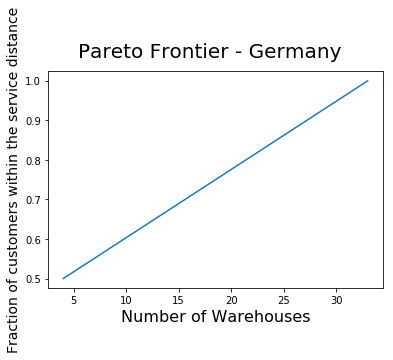


% of Customers within the service distance:  75.0 %
Optimization Status Optimal
Objective:  11.0
Run Time of model in seconds 37.3
Total Run Time in seconds 201.9


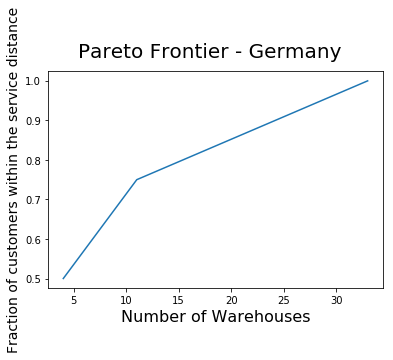


% of Customers within the service distance:  62.5 %
Optimization Status Optimal
Objective:  7.0
Run Time of model in seconds 31.2
Total Run Time in seconds 233.7


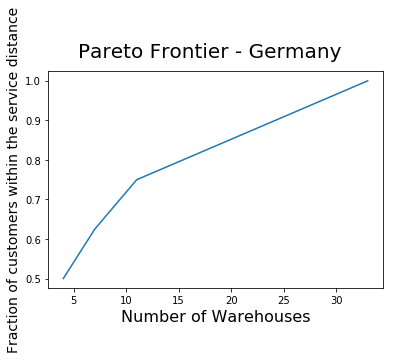


% of Customers within the service distance:  87.5 %
Optimization Status Optimal
Objective:  18.0
Run Time of model in seconds 28.8
Total Run Time in seconds 262.9


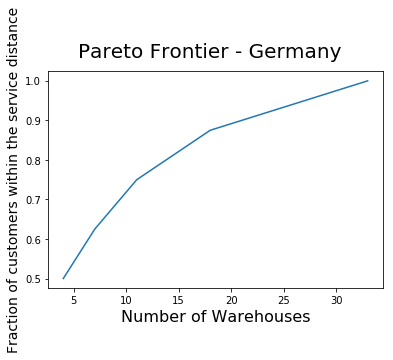

In [8]:
#getting input data
service_level_par, warehouses, customers, customer_demands, distance = get_data()

#print("loaded input data")
#distance_band = [distance_band_1, distance_band_2, distance_band_3, distance_band_4]

#opening text file in write mode
file = open(scenario_name+'summary' + '.txt',"w")
file.write('loaded input data')
print("loaded input data")  #Also print to Jupyter

#testing input data
file.write('\nTesting Input Data')
test_input(warehouses, customers, customer_demands, distance)

#RunCode = ()  #We need some function in here that runs the whole thing.
file.write('\nBuilding the models')

sl_customers_list = [sl_customers,1]
df_assign_vars = {}
list_facility_vars = {}
number_of_warehouses = {}
for i in range(iterations):    
    for j in sl_customers_list:
        if j not in number_of_warehouses:
            file.write("\n% of Customers {:.1f}" .format(j*100))
            print ('\n% of Customers within the service distance: ',j*100,'%')
            df_assign_vars[j], list_facility_vars[j], number_of_warehouses[j] = optimal_location(service_level, j, service_level_par, warehouses, customers, customer_demands, distance, scenario_name)        
            if output_inline == True:
                output_visual_inline(number_of_warehouses)                
            if output_new_window == True:
                output_visual_new_window(number_of_warehouses)              
    sl_customers_list = one_iter(sl_customers_list)

#closing the file
file.close()